In [1]:
import numpy as np
import pandas as pd
import mne
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import os
from scipy import signal


In [2]:
# np.random.seed(42)
# torch.manual_seed(42)

# Define constants
N_CHANNELS_PSG = 6
N_CHANNELS_HEADBAND = 2
EPOCH_LENGTH_SEC = 30  
SAMPLE_RATE = 256  
FFT_WINDOW_SIZE = 4  # seconds
BATCH_SIZE = 64
NUM_EPOCHS = 50
LEARNING_RATE = 0.0001

# Sleep stage labels (standard)
SLEEP_STAGES = {
    0: 'Wake', # Wake
    1: 'N1',   # Non-REM stage 1
    2: 'N2',   # Non-REM stage 2
    3: 'N3',   # Non-REM stage 3
    4: 'REM'  # REM sleep
    # 8: 'noCon' # No Connection(PSG disconnection)
}
SLEEP_STAGES_reverse = {
    'W':0,    # Wake
    'N1':1,   # Non-REM stage 1
    'N2':2,   # Non-REM stage 2
    'N3':3,   # Non-REM stage 3
    'R':4     # REM sleep
    # 'noCon':8  # No Connection(PSG disconnection)
}
def load_edf_files(psg_path, headband_path):
    """Load PSG and headband EDF files"""
    print("Loading EDF files...")
    
    # Load PSG data
    psg_raw = mne.io.read_raw_edf(psg_path, preload=True)
    
    # Load headband data
    headband_raw = mne.io.read_raw_edf(headband_path, preload=True)
    
    return psg_raw, headband_raw
    
def load_hypnogram(hypno_path):
    """Load sleep stages from a hypnogram file"""
    # This function would need to be adapted based on your hypnogram format
    # For this example, we'll assume a simple CSV with epoch number and stage
    # .map(SLEEP_STAGES_reverse).fillna('W')
    hypno_df = pd.read_csv(hypno_path, sep='\t')
    sleep_stages = hypno_df['majority'].apply(lambda s: s if s in [0, 1, 2, 3, 4] else 0).values
    
    return sleep_stages
    
# def synchronize_recordings(psg_raw, headband_raw):
#     """Synchronize PSG and headband recordings based on timestamps"""
#     # Extract start times
#     psg_start = psg_raw.info['meas_date']
#     headband_start = headband_raw.info['meas_date']
    
#     print(f"PSG start time: {psg_start}")
#     print(f"Headband start time: {headband_start}")
    
#     # Calculate offset
#     if psg_start and headband_start:
#         time_diff = (headband_start - psg_start).total_seconds()
#         print(f"Time difference: {time_diff} seconds")
        
#         # Determine which recording started first and crop accordingly
#         if time_diff > 0:
#             # Headband started later, crop PSG
#             psg_raw.crop(tmin=time_diff)
#         else:
#             # PSG started later, crop headband
#             headband_raw.crop(tmin=-time_diff)
    
#     # Ensure both recordings have the same duration
#     duration = min(psg_raw.times[-1], headband_raw.times[-1])
#     psg_raw.crop(tmax=duration)
#     headband_raw.crop(tmax=duration)
    
#     print(f"Synchronized duration: {duration} seconds")
    
#     return psg_raw, headband_raw

def extract_features(raw_data, channel_names, window_size=FFT_WINDOW_SIZE, sample_rate=SAMPLE_RATE):
    """Extract frequency domain features from EEG signals"""
    # Select only the channels we want
    data = raw_data.get_data(picks=channel_names)
    
    # Calculate number of epochs
    n_epochs = int(data.shape[1] / (EPOCH_LENGTH_SEC * sample_rate))
    
    # Initialize feature arrays
    n_channels = len(channel_names)
    
    # Define frequency bands
    bands = {
        'delta': (0.5, 4),
        'theta': (4, 8),
        'alpha': (8, 13),
        'beta': (13, 30),
        'gamma': (30, 45)
    }
    
    # Initialize feature matrix
    n_bands = len(bands)
    features = np.zeros((n_epochs, n_channels * n_bands * 2))  # 2 features per band (power, rel_power)
    
    # Process each epoch
    for epoch_idx in range(n_epochs):
        start_sample = epoch_idx * EPOCH_LENGTH_SEC * sample_rate
        end_sample = (epoch_idx + 1) * EPOCH_LENGTH_SEC * sample_rate
        
        # Extract epoch data
        epoch_data = data[:, start_sample:end_sample]
        
        # Calculate features for each channel
        for ch_idx in range(n_channels):
            channel_data = epoch_data[ch_idx, :]
            
            # Compute power spectral density
            freqs, psd = signal.welch(channel_data, fs=sample_rate, nperseg=window_size*sample_rate)
            
            # Calculate band powers
            feature_idx = ch_idx * n_bands * 2
            total_power = np.sum(psd)
            
            for band_idx, (band_name, (low_freq, high_freq)) in enumerate(bands.items()):
                # Find indices corresponding to the frequency band
                idx_band = np.logical_and(freqs >= low_freq, freqs <= high_freq)
                
                # Calculate absolute and relative band power
                band_power = np.sum(psd[idx_band])
                rel_power = band_power / total_power if total_power > 0 else 0
                
                # Store features
                features[epoch_idx, feature_idx + band_idx*2] = band_power
                features[epoch_idx, feature_idx + band_idx*2 + 1] = rel_power
    
    return features


In [3]:
class SleepDataset(Dataset):
    """PyTorch dataset for sleep staging"""
    def __init__(self, X, y):
        # Convert X and y to numpy arrays with proper types first
        if isinstance(X, np.ndarray) and X.dtype == object:
            X = np.stack(X).astype(np.float32)
        if isinstance(y, np.ndarray) and y.dtype == object:
            y = np.array(y, dtype=np.int64)
            
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [4]:
class TransformerModel(nn.Module):
    """Simple transformer model for sleep stage classification"""
    def __init__(self, input_dim, num_classes, d_model=64, nhead=4, num_layers=2, dropout=0.1):
        super(TransformerModel, self).__init__()
        
        # Reshape input to sequence for transformer
        # For spectral features, we'll treat each channel-band combination as a token
        self.input_dim = input_dim
        self.d_model = d_model
        
        # Project input to d_model dimensions
        self.input_projection = nn.Linear(input_dim, d_model)
        
        # Create positional encoding (fixed)
        self.pos_encoder = nn.Sequential(
            nn.Linear(1, d_model),
            nn.GELU()
        )
        
        # Transformer encoder
        encoder_layers = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, 
                                                  dim_feedforward=d_model*4,
                                                  dropout=dropout, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(d_model, d_model // 2),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model // 2, num_classes)
        )
    
    def forward(self, x):
        # Reshape input to sequence form
        # Here we're treating the whole feature vector as a single token
        # For more complex models, you could reshape to have multiple tokens
        batch_size = x.size(0)
        
        # Project input
        x = self.input_projection(x).unsqueeze(1)  # [batch, 1, d_model]
        
        # Add positional encoding
        positions = torch.zeros(1, 1, 1).to(x.device)
        pos_encoding = self.pos_encoder(positions)
        x = x + pos_encoding
        
        # Apply transformer
        x = self.transformer_encoder(x)
        
        # Take the output corresponding to the first position
        x = x[:, 0, :]
        
        # Classify
        x = self.classifier(x)
        
        return x

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    """Train the model"""
    model.to(device)
    best_val_acc = 0.0
    best_model = None
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Train]"):
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Statistics
            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)
        
        train_loss = train_loss / train_total
        train_acc = train_correct / train_total
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{num_epochs} [Val]"):
                inputs, labels = inputs.to(device), labels.to(device)
                
                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                # Statistics
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)
        
        val_loss = val_loss / val_total
        val_acc = val_correct / val_total
        
        print(f"Epoch {epoch+1}/{num_epochs}: "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model = model.state_dict().copy()
    
    # Load best model
    model.load_state_dict(best_model)
    
    return model

def evaluate_model(model, test_loader, device):
    """Evaluate the model on test data"""
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating"):
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    acc = accuracy_score(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, labels=list(SLEEP_STAGES.keys()), target_names=list(SLEEP_STAGES.values()), output_dict=True)
    
    # Create confusion matrix
    cm = confusion_matrix(all_labels, all_preds)
    
    return acc, report, cm, all_preds, all_labels

def visualize_results(cm, report, sleep_stages):
    """Visualize classification results"""
    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=list(sleep_stages.values()),
                yticklabels=list(sleep_stages.values()))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    plt.close()
    
    # Plot performance metrics
    metrics = ['precision', 'recall', 'f1-score']
    plt.figure(figsize=(12, 6))
    
    for i, metric in enumerate(metrics):
        plt.subplot(1, 3, i+1)
        values = [report[stage][metric] for stage in sleep_stages.values()]
        sns.barplot(x=list(sleep_stages.values()), y=values)
        plt.title(f'{metric.capitalize()}')
        plt.ylim(0, 1)
        plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.savefig('performance_metrics.png')
    plt.close()


In [5]:
"""Main function to compare PSG and headband recordings and evaluate sleep stage prediction"""
accuracy_list = []
classification_reports = []
confusion_matrices = []
all_preds = []
all_labels = []

for sub_no in range(1,129):
    if sub_no ==20: ##this is problematic subjct no
        continue
    psg_path = f"Dataset_clean_for_jupyter/sub-{sub_no}/eeg/sub-{sub_no}_task-Sleep_acq-psg_eeg_6-channels.edf"
    headband_path = f"Dataset_clean_for_jupyter/sub-{sub_no}/eeg/sub-{sub_no}_task-Sleep_acq-headband_eeg_2-channels.edf" 
    hypnogram_path = f"Dataset_clean_for_jupyter/sub-{sub_no}/eeg/sub-{sub_no}_task-Sleep_acq-psg_events.tsv"

    # 1. Load EDF files
    psg_raw, headband_raw = load_edf_files(psg_path, headband_path)

    # 2. Synchronize recordings
    # psg_raw, headband_raw = synchronize_recordings(psg_raw, headband_raw)

    # 3. Extract features
    # psg_channels = ['PSG_F3', 'PSG_F4', 'PSG_C3', 'PSG_C4', 'PSG_O1', 'PSG_O2']
    psg_channels = ['PSG_F3', 'PSG_F4']
    headband_channels = ['HB_1', 'HB_2']
    
    # print("Extracting PSG features...")
    psg_features = extract_features(psg_raw, psg_channels)

    # print("Extracting headband features...")
    headband_features = extract_features(headband_raw, headband_channels)
    
    # 4. Load sleep stages (ground truth)
    sleep_stages = load_hypnogram(hypnogram_path) 
    print(f"Loaded {len(sleep_stages)} sleep stage labels")

    # to solve stratify problem if only 1 instance of sleepstage is present
    class_counts = np.bincount(sleep_stages)
    rare_indices = [i for i, stage in enumerate(sleep_stages) if class_counts[stage] == 1]
    if rare_indices:
        sleep_stages[rare_indices[0]-1] = sleep_stages[rare_indices[0]]
        
    # 5. Split data into train, validation, and test sets
    # X_train, X_temp, y_train, y_temp = train_test_split(
    #     headband_features, sleep_stages, test_size=0.3, random_state=42, stratify=sleep_stages
    # )
    # X_val, X_test, y_val, y_test = train_test_split(
    #     X_temp, y_temp, test_size=0.5, random_state=42
    # )

        
    # # 5. Split data into train, validation, and test sets
    X_train, X_val, y_train, y_val  = train_test_split(
        psg_features, sleep_stages, test_size=0.3, random_state=42, stratify=sleep_stages
    )
    X_test, y_test = headband_features, sleep_stages
    
    
    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Validation set: {X_val.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")
    
    # # 6. Scale features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    
    # 7. Create data loaders
    train_dataset = SleepDataset(X_train, y_train)
    val_dataset = SleepDataset(X_val, y_val)
    test_dataset = SleepDataset(X_test, y_test)
    
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

    
    # 8. Initialize model
    input_dim = X_train.shape[1]
    num_classes = len(SLEEP_STAGES)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model = TransformerModel(input_dim, num_classes)
    print(f"Model created with {sum(p.numel() for p in model.parameters())} parameters")
    
    # 9. Train model
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    model = train_model(model, train_loader, val_loader, criterion, optimizer, NUM_EPOCHS, device)
    
    # 10. Evaluate model
    acc, report, cm, predictions, true_labels = evaluate_model(model, test_loader, device)

    #11. Storing the Output
    accuracy_list.append(acc)
    classification_reports.append(report)
    confusion_matrices.append(cm)
    
    all_preds.extend(predictions)
    all_labels.extend(true_labels)
    


Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-1\eeg\sub-1_task-Sleep_acq-psg_eeg_6-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7029503  =      0.000 ... 27458.996 secs...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-1\eeg\sub-1_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7029503  =      0.000 ... 27458.996 secs...
Loaded 915 sleep stage labels
Training set: 640 samples
Validation set: 275 samples
Test set: 915 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 344.02it/s]


Epoch 1/50: Train Loss: 1.6080, Train Acc: 0.2094, Val Loss: 1.5248, Val Acc: 0.4364


Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.31it/s]


Epoch 2/50: Train Loss: 1.4909, Train Acc: 0.4938, Val Loss: 1.4306, Val Acc: 0.5673


Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 478.51it/s]


Epoch 3/50: Train Loss: 1.4076, Train Acc: 0.5484, Val Loss: 1.3521, Val Acc: 0.5855


Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.42it/s]


Epoch 4/50: Train Loss: 1.3322, Train Acc: 0.5828, Val Loss: 1.2771, Val Acc: 0.5891


Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.36it/s]


Epoch 5/50: Train Loss: 1.2583, Train Acc: 0.6016, Val Loss: 1.2038, Val Acc: 0.6109


Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 397.21it/s]


Epoch 6/50: Train Loss: 1.1845, Train Acc: 0.6328, Val Loss: 1.1339, Val Acc: 0.6473


Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.24it/s]


Epoch 7/50: Train Loss: 1.1230, Train Acc: 0.6797, Val Loss: 1.0702, Val Acc: 0.6873


Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 368.76it/s]


Epoch 8/50: Train Loss: 1.0615, Train Acc: 0.7125, Val Loss: 1.0122, Val Acc: 0.7345


Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.97it/s]


Epoch 9/50: Train Loss: 1.0071, Train Acc: 0.7391, Val Loss: 0.9587, Val Acc: 0.7600


Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 413.10it/s]


Epoch 10/50: Train Loss: 0.9587, Train Acc: 0.7562, Val Loss: 0.9100, Val Acc: 0.7636


Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.28it/s]


Epoch 11/50: Train Loss: 0.9135, Train Acc: 0.7703, Val Loss: 0.8654, Val Acc: 0.7600


Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 262.24it/s]


Epoch 12/50: Train Loss: 0.8638, Train Acc: 0.7766, Val Loss: 0.8251, Val Acc: 0.7745


Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 237.60it/s]


Epoch 13/50: Train Loss: 0.8199, Train Acc: 0.7812, Val Loss: 0.7891, Val Acc: 0.7745


Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.16it/s]


Epoch 14/50: Train Loss: 0.8024, Train Acc: 0.7797, Val Loss: 0.7587, Val Acc: 0.7745


Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.19it/s]


Epoch 15/50: Train Loss: 0.7797, Train Acc: 0.7797, Val Loss: 0.7297, Val Acc: 0.7818


Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.58it/s]


Epoch 16/50: Train Loss: 0.7393, Train Acc: 0.7891, Val Loss: 0.7047, Val Acc: 0.7855


Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.46it/s]


Epoch 17/50: Train Loss: 0.7150, Train Acc: 0.7859, Val Loss: 0.6825, Val Acc: 0.7855


Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.81it/s]


Epoch 18/50: Train Loss: 0.6934, Train Acc: 0.7953, Val Loss: 0.6618, Val Acc: 0.7927


Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 480.70it/s]


Epoch 19/50: Train Loss: 0.6739, Train Acc: 0.8063, Val Loss: 0.6452, Val Acc: 0.7964


Epoch 20/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 430.83it/s]


Epoch 20/50: Train Loss: 0.6603, Train Acc: 0.7937, Val Loss: 0.6269, Val Acc: 0.7927


Epoch 21/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 524.51it/s]


Epoch 21/50: Train Loss: 0.6378, Train Acc: 0.7969, Val Loss: 0.6128, Val Acc: 0.7964


Epoch 22/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.48it/s]


Epoch 22/50: Train Loss: 0.6197, Train Acc: 0.8063, Val Loss: 0.6004, Val Acc: 0.8000


Epoch 23/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 498.17it/s]


Epoch 23/50: Train Loss: 0.5990, Train Acc: 0.8125, Val Loss: 0.5866, Val Acc: 0.7927


Epoch 24/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 495.97it/s]


Epoch 24/50: Train Loss: 0.5867, Train Acc: 0.8234, Val Loss: 0.5781, Val Acc: 0.8036


Epoch 25/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 498.78it/s]


Epoch 25/50: Train Loss: 0.5835, Train Acc: 0.8047, Val Loss: 0.5667, Val Acc: 0.7964


Epoch 26/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 497.63it/s]


Epoch 26/50: Train Loss: 0.5786, Train Acc: 0.8063, Val Loss: 0.5601, Val Acc: 0.7964


Epoch 27/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.54it/s]


Epoch 27/50: Train Loss: 0.5571, Train Acc: 0.8203, Val Loss: 0.5525, Val Acc: 0.8036


Epoch 28/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.28it/s]


Epoch 28/50: Train Loss: 0.5411, Train Acc: 0.8266, Val Loss: 0.5439, Val Acc: 0.7964


Epoch 29/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 485.11it/s]


Epoch 29/50: Train Loss: 0.5271, Train Acc: 0.8281, Val Loss: 0.5361, Val Acc: 0.7964


Epoch 30/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 554.92it/s]


Epoch 30/50: Train Loss: 0.5137, Train Acc: 0.8250, Val Loss: 0.5320, Val Acc: 0.8036


Epoch 31/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.67it/s]


Epoch 31/50: Train Loss: 0.5215, Train Acc: 0.8234, Val Loss: 0.5242, Val Acc: 0.8073


Epoch 32/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.38it/s]


Epoch 32/50: Train Loss: 0.5204, Train Acc: 0.8250, Val Loss: 0.5210, Val Acc: 0.8000


Epoch 33/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 292.77it/s]


Epoch 33/50: Train Loss: 0.5084, Train Acc: 0.8281, Val Loss: 0.5148, Val Acc: 0.8109


Epoch 34/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.44it/s]


Epoch 34/50: Train Loss: 0.5039, Train Acc: 0.8266, Val Loss: 0.5114, Val Acc: 0.8073


Epoch 35/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.21it/s]


Epoch 35/50: Train Loss: 0.5011, Train Acc: 0.8266, Val Loss: 0.5072, Val Acc: 0.8073


Epoch 36/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.07it/s]


Epoch 36/50: Train Loss: 0.5021, Train Acc: 0.8281, Val Loss: 0.5085, Val Acc: 0.8000


Epoch 37/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 321.05it/s]


Epoch 37/50: Train Loss: 0.4877, Train Acc: 0.8344, Val Loss: 0.5035, Val Acc: 0.8036


Epoch 38/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.20it/s]


Epoch 38/50: Train Loss: 0.4783, Train Acc: 0.8359, Val Loss: 0.4985, Val Acc: 0.8036


Epoch 39/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.46it/s]


Epoch 39/50: Train Loss: 0.4695, Train Acc: 0.8422, Val Loss: 0.4911, Val Acc: 0.8109


Epoch 40/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.04it/s]


Epoch 40/50: Train Loss: 0.4808, Train Acc: 0.8234, Val Loss: 0.4894, Val Acc: 0.8036


Epoch 41/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.20it/s]


Epoch 41/50: Train Loss: 0.4730, Train Acc: 0.8391, Val Loss: 0.4874, Val Acc: 0.8073


Epoch 42/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 414.51it/s]


Epoch 42/50: Train Loss: 0.4716, Train Acc: 0.8328, Val Loss: 0.4864, Val Acc: 0.8145


Epoch 43/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.52it/s]


Epoch 43/50: Train Loss: 0.4519, Train Acc: 0.8328, Val Loss: 0.4855, Val Acc: 0.8145


Epoch 44/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 340.16it/s]


Epoch 44/50: Train Loss: 0.4556, Train Acc: 0.8359, Val Loss: 0.4835, Val Acc: 0.8145


Epoch 45/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.59it/s]


Epoch 45/50: Train Loss: 0.4442, Train Acc: 0.8484, Val Loss: 0.4823, Val Acc: 0.8109


Epoch 46/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 382.84it/s]


Epoch 46/50: Train Loss: 0.4489, Train Acc: 0.8516, Val Loss: 0.4803, Val Acc: 0.8109


Epoch 47/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 378.22it/s]


Epoch 47/50: Train Loss: 0.4404, Train Acc: 0.8469, Val Loss: 0.4766, Val Acc: 0.8109


Epoch 48/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 344.40it/s]


Epoch 48/50: Train Loss: 0.4514, Train Acc: 0.8297, Val Loss: 0.4813, Val Acc: 0.8109


Epoch 49/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.08it/s]


Epoch 49/50: Train Loss: 0.4361, Train Acc: 0.8406, Val Loss: 0.4754, Val Acc: 0.8109


Epoch 50/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.14it/s]


Epoch 50/50: Train Loss: 0.4397, Train Acc: 0.8375, Val Loss: 0.4732, Val Acc: 0.8109


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 445.58it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-2\eeg\sub-2_task-Sleep_acq-psg_eeg_6-channels.edf...


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7014399  =      0.000 ... 27399.996 secs...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-2\eeg\sub-2_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7014399  =      0.000 ... 27399.996 secs...
Loaded 913 sleep stage labels
Training set: 639 samples
Validation set: 274 samples
Test set: 913 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.74it/s]


Epoch 1/50: Train Loss: 1.5418, Train Acc: 0.4147, Val Loss: 1.4580, Val Acc: 0.5109


Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.23it/s]


Epoch 2/50: Train Loss: 1.4165, Train Acc: 0.5070, Val Loss: 1.3614, Val Acc: 0.5146


Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.14it/s]


Epoch 3/50: Train Loss: 1.3266, Train Acc: 0.5211, Val Loss: 1.2999, Val Acc: 0.5109


Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 343.85it/s]


Epoch 4/50: Train Loss: 1.2775, Train Acc: 0.5211, Val Loss: 1.2560, Val Acc: 0.5146


Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.27it/s]


Epoch 5/50: Train Loss: 1.2327, Train Acc: 0.5243, Val Loss: 1.2180, Val Acc: 0.5146


Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 382.80it/s]


Epoch 6/50: Train Loss: 1.1945, Train Acc: 0.5227, Val Loss: 1.1824, Val Acc: 0.5146


Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.34it/s]


Epoch 7/50: Train Loss: 1.1536, Train Acc: 0.5290, Val Loss: 1.1488, Val Acc: 0.5182


Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 451.98it/s]


Epoch 8/50: Train Loss: 1.1180, Train Acc: 0.5415, Val Loss: 1.1168, Val Acc: 0.5182


Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 497.62it/s]


Epoch 9/50: Train Loss: 1.0909, Train Acc: 0.5571, Val Loss: 1.0861, Val Acc: 0.5255


Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.06it/s]


Epoch 10/50: Train Loss: 1.0411, Train Acc: 0.5696, Val Loss: 1.0573, Val Acc: 0.5219


Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.27it/s]


Epoch 11/50: Train Loss: 1.0194, Train Acc: 0.5728, Val Loss: 1.0311, Val Acc: 0.5474


Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.36it/s]


Epoch 12/50: Train Loss: 0.9859, Train Acc: 0.5900, Val Loss: 1.0079, Val Acc: 0.5839


Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.76it/s]


Epoch 13/50: Train Loss: 0.9750, Train Acc: 0.5994, Val Loss: 0.9853, Val Acc: 0.5985


Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.14it/s]


Epoch 14/50: Train Loss: 0.9394, Train Acc: 0.6056, Val Loss: 0.9646, Val Acc: 0.6314


Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 414.93it/s]


Epoch 15/50: Train Loss: 0.9226, Train Acc: 0.6463, Val Loss: 0.9461, Val Acc: 0.6350


Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 431.75it/s]


Epoch 16/50: Train Loss: 0.9064, Train Acc: 0.6463, Val Loss: 0.9303, Val Acc: 0.6387


Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.24it/s]


Epoch 17/50: Train Loss: 0.8797, Train Acc: 0.6275, Val Loss: 0.9165, Val Acc: 0.6423


Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.68it/s]


Epoch 18/50: Train Loss: 0.8630, Train Acc: 0.6682, Val Loss: 0.9021, Val Acc: 0.6460


Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.81it/s]


Epoch 19/50: Train Loss: 0.8408, Train Acc: 0.6573, Val Loss: 0.8898, Val Acc: 0.6533


Epoch 20/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 473.55it/s]


Epoch 20/50: Train Loss: 0.8273, Train Acc: 0.6870, Val Loss: 0.8776, Val Acc: 0.6569


Epoch 21/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 432.80it/s]


Epoch 21/50: Train Loss: 0.8056, Train Acc: 0.6917, Val Loss: 0.8651, Val Acc: 0.6788


Epoch 22/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 432.57it/s]


Epoch 22/50: Train Loss: 0.8041, Train Acc: 0.6854, Val Loss: 0.8533, Val Acc: 0.6825


Epoch 23/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 524.33it/s]


Epoch 23/50: Train Loss: 0.7867, Train Acc: 0.6964, Val Loss: 0.8435, Val Acc: 0.6898


Epoch 24/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 488.88it/s]


Epoch 24/50: Train Loss: 0.7685, Train Acc: 0.7027, Val Loss: 0.8337, Val Acc: 0.6788


Epoch 25/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.12it/s]


Epoch 25/50: Train Loss: 0.7555, Train Acc: 0.7089, Val Loss: 0.8242, Val Acc: 0.6752


Epoch 26/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 554.00it/s]


Epoch 26/50: Train Loss: 0.7411, Train Acc: 0.7261, Val Loss: 0.8156, Val Acc: 0.6898


Epoch 27/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 553.53it/s]


Epoch 27/50: Train Loss: 0.7318, Train Acc: 0.7293, Val Loss: 0.8058, Val Acc: 0.6934


Epoch 28/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.43it/s]


Epoch 28/50: Train Loss: 0.7245, Train Acc: 0.7324, Val Loss: 0.7980, Val Acc: 0.6934


Epoch 29/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.43it/s]


Epoch 29/50: Train Loss: 0.7120, Train Acc: 0.7230, Val Loss: 0.7908, Val Acc: 0.7044


Epoch 30/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 524.34it/s]


Epoch 30/50: Train Loss: 0.7053, Train Acc: 0.7418, Val Loss: 0.7831, Val Acc: 0.7153


Epoch 31/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.90it/s]


Epoch 31/50: Train Loss: 0.7004, Train Acc: 0.7324, Val Loss: 0.7769, Val Acc: 0.7044


Epoch 32/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 498.47it/s]


Epoch 32/50: Train Loss: 0.6948, Train Acc: 0.7355, Val Loss: 0.7687, Val Acc: 0.7299


Epoch 33/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.18it/s]


Epoch 33/50: Train Loss: 0.6698, Train Acc: 0.7621, Val Loss: 0.7628, Val Acc: 0.7336


Epoch 34/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 476.17it/s]


Epoch 34/50: Train Loss: 0.6553, Train Acc: 0.7746, Val Loss: 0.7532, Val Acc: 0.7299


Epoch 35/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 452.43it/s]


Epoch 35/50: Train Loss: 0.6430, Train Acc: 0.7637, Val Loss: 0.7457, Val Acc: 0.7299


Epoch 36/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.21it/s]


Epoch 36/50: Train Loss: 0.6418, Train Acc: 0.7606, Val Loss: 0.7388, Val Acc: 0.7299


Epoch 37/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.94it/s]


Epoch 37/50: Train Loss: 0.6420, Train Acc: 0.7684, Val Loss: 0.7357, Val Acc: 0.7409


Epoch 38/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.27it/s]


Epoch 38/50: Train Loss: 0.6420, Train Acc: 0.7543, Val Loss: 0.7296, Val Acc: 0.7372


Epoch 39/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 211.52it/s]


Epoch 39/50: Train Loss: 0.6159, Train Acc: 0.7762, Val Loss: 0.7259, Val Acc: 0.7263


Epoch 40/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.75it/s]


Epoch 40/50: Train Loss: 0.6112, Train Acc: 0.7746, Val Loss: 0.7227, Val Acc: 0.7263


Epoch 41/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.48it/s]


Epoch 41/50: Train Loss: 0.6007, Train Acc: 0.7762, Val Loss: 0.7185, Val Acc: 0.7299


Epoch 42/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 457.74it/s]


Epoch 42/50: Train Loss: 0.6135, Train Acc: 0.7684, Val Loss: 0.7132, Val Acc: 0.7263


Epoch 43/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.25it/s]


Epoch 43/50: Train Loss: 0.6020, Train Acc: 0.7731, Val Loss: 0.7090, Val Acc: 0.7299


Epoch 44/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.71it/s]


Epoch 44/50: Train Loss: 0.6167, Train Acc: 0.7778, Val Loss: 0.7070, Val Acc: 0.7445


Epoch 45/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 414.29it/s]


Epoch 45/50: Train Loss: 0.5918, Train Acc: 0.7731, Val Loss: 0.7053, Val Acc: 0.7372


Epoch 46/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 494.22it/s]


Epoch 46/50: Train Loss: 0.5978, Train Acc: 0.7762, Val Loss: 0.7069, Val Acc: 0.7299


Epoch 47/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.04it/s]


Epoch 47/50: Train Loss: 0.5906, Train Acc: 0.7887, Val Loss: 0.7093, Val Acc: 0.7299


Epoch 48/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.30it/s]


Epoch 48/50: Train Loss: 0.5651, Train Acc: 0.7919, Val Loss: 0.7054, Val Acc: 0.7299


Epoch 49/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.91it/s]


Epoch 49/50: Train Loss: 0.5876, Train Acc: 0.7840, Val Loss: 0.7014, Val Acc: 0.7299


Epoch 50/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.09it/s]


Epoch 50/50: Train Loss: 0.5755, Train Acc: 0.8013, Val Loss: 0.6963, Val Acc: 0.7299


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 502.80it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-3\eeg\sub-3_task-Sleep_acq-psg_eeg_6-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7659775  =      0.000 ... 29920.996 secs...


Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-3\eeg\sub-3_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7659775  =      0.000 ... 29920.996 secs...
Loaded 997 sleep stage labels
Training set: 697 samples
Validation set: 300 samples
Test set: 997 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.94it/s]


Epoch 1/50: Train Loss: 1.5555, Train Acc: 0.2238, Val Loss: 1.4555, Val Acc: 0.4533


Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 311.14it/s]


Epoch 2/50: Train Loss: 1.3780, Train Acc: 0.5208, Val Loss: 1.2755, Val Acc: 0.5867


Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.55it/s]


Epoch 3/50: Train Loss: 1.2056, Train Acc: 0.6499, Val Loss: 1.1175, Val Acc: 0.6800


Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.58it/s]


Epoch 4/50: Train Loss: 1.0706, Train Acc: 0.6987, Val Loss: 1.0023, Val Acc: 0.6867


Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.54it/s]


Epoch 5/50: Train Loss: 0.9747, Train Acc: 0.7044, Val Loss: 0.9219, Val Acc: 0.7000


Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.18it/s]


Epoch 6/50: Train Loss: 0.9001, Train Acc: 0.7188, Val Loss: 0.8587, Val Acc: 0.7200


Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 293.42it/s]


Epoch 7/50: Train Loss: 0.8337, Train Acc: 0.7331, Val Loss: 0.8061, Val Acc: 0.7533


Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 356.32it/s]


Epoch 8/50: Train Loss: 0.7970, Train Acc: 0.7403, Val Loss: 0.7642, Val Acc: 0.7533


Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 364.01it/s]


Epoch 9/50: Train Loss: 0.7638, Train Acc: 0.7475, Val Loss: 0.7309, Val Acc: 0.7600


Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 359.54it/s]


Epoch 10/50: Train Loss: 0.7205, Train Acc: 0.7561, Val Loss: 0.7034, Val Acc: 0.7567


Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 330.97it/s]


Epoch 11/50: Train Loss: 0.6998, Train Acc: 0.7704, Val Loss: 0.6797, Val Acc: 0.7567


Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 354.19it/s]


Epoch 12/50: Train Loss: 0.6773, Train Acc: 0.7791, Val Loss: 0.6587, Val Acc: 0.7600


Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 414.69it/s]


Epoch 13/50: Train Loss: 0.6553, Train Acc: 0.7704, Val Loss: 0.6400, Val Acc: 0.7600


Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 397.96it/s]


Epoch 14/50: Train Loss: 0.6323, Train Acc: 0.7862, Val Loss: 0.6231, Val Acc: 0.7700


Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 419.72it/s]


Epoch 15/50: Train Loss: 0.6057, Train Acc: 0.7991, Val Loss: 0.6062, Val Acc: 0.7767


Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.16it/s]


Epoch 16/50: Train Loss: 0.6021, Train Acc: 0.7991, Val Loss: 0.5909, Val Acc: 0.7833


Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 356.43it/s]


Epoch 17/50: Train Loss: 0.5799, Train Acc: 0.8121, Val Loss: 0.5772, Val Acc: 0.7867


Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 384.73it/s]


Epoch 18/50: Train Loss: 0.5654, Train Acc: 0.7963, Val Loss: 0.5648, Val Acc: 0.8133


Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 454.16it/s]


Epoch 19/50: Train Loss: 0.5552, Train Acc: 0.8178, Val Loss: 0.5542, Val Acc: 0.8133


Epoch 20/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.85it/s]


Epoch 20/50: Train Loss: 0.5594, Train Acc: 0.8164, Val Loss: 0.5433, Val Acc: 0.8267


Epoch 21/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 454.25it/s]


Epoch 21/50: Train Loss: 0.5363, Train Acc: 0.8364, Val Loss: 0.5345, Val Acc: 0.8200


Epoch 22/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 416.76it/s]


Epoch 22/50: Train Loss: 0.5228, Train Acc: 0.8235, Val Loss: 0.5243, Val Acc: 0.8300


Epoch 23/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 384.56it/s]


Epoch 23/50: Train Loss: 0.5150, Train Acc: 0.8264, Val Loss: 0.5157, Val Acc: 0.8400


Epoch 24/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 454.57it/s]


Epoch 24/50: Train Loss: 0.5057, Train Acc: 0.8336, Val Loss: 0.5069, Val Acc: 0.8400


Epoch 25/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 384.22it/s]


Epoch 25/50: Train Loss: 0.5066, Train Acc: 0.8178, Val Loss: 0.5003, Val Acc: 0.8467


Epoch 26/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.62it/s]


Epoch 26/50: Train Loss: 0.4889, Train Acc: 0.8293, Val Loss: 0.4934, Val Acc: 0.8467


Epoch 27/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 454.30it/s]


Epoch 27/50: Train Loss: 0.4939, Train Acc: 0.8293, Val Loss: 0.4865, Val Acc: 0.8467


Epoch 28/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 237.39it/s]


Epoch 28/50: Train Loss: 0.4804, Train Acc: 0.8321, Val Loss: 0.4799, Val Acc: 0.8500


Epoch 29/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.91it/s]


Epoch 29/50: Train Loss: 0.4855, Train Acc: 0.8436, Val Loss: 0.4754, Val Acc: 0.8500


Epoch 30/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 489.26it/s]


Epoch 30/50: Train Loss: 0.4743, Train Acc: 0.8350, Val Loss: 0.4716, Val Acc: 0.8467


Epoch 31/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.45it/s]


Epoch 31/50: Train Loss: 0.4595, Train Acc: 0.8465, Val Loss: 0.4675, Val Acc: 0.8500


Epoch 32/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.91it/s]


Epoch 32/50: Train Loss: 0.4614, Train Acc: 0.8264, Val Loss: 0.4651, Val Acc: 0.8600


Epoch 33/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.15it/s]


Epoch 33/50: Train Loss: 0.4542, Train Acc: 0.8407, Val Loss: 0.4594, Val Acc: 0.8500


Epoch 34/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.36it/s]


Epoch 34/50: Train Loss: 0.4518, Train Acc: 0.8436, Val Loss: 0.4567, Val Acc: 0.8500


Epoch 35/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.89it/s]


Epoch 35/50: Train Loss: 0.4431, Train Acc: 0.8465, Val Loss: 0.4546, Val Acc: 0.8633


Epoch 36/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 366.76it/s]


Epoch 36/50: Train Loss: 0.4438, Train Acc: 0.8436, Val Loss: 0.4517, Val Acc: 0.8533


Epoch 37/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.17it/s]


Epoch 37/50: Train Loss: 0.4348, Train Acc: 0.8565, Val Loss: 0.4495, Val Acc: 0.8600


Epoch 38/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.42it/s]


Epoch 38/50: Train Loss: 0.4285, Train Acc: 0.8508, Val Loss: 0.4469, Val Acc: 0.8567


Epoch 39/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.45it/s]


Epoch 39/50: Train Loss: 0.4213, Train Acc: 0.8565, Val Loss: 0.4442, Val Acc: 0.8533


Epoch 40/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.31it/s]


Epoch 40/50: Train Loss: 0.4281, Train Acc: 0.8594, Val Loss: 0.4410, Val Acc: 0.8500


Epoch 41/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.47it/s]


Epoch 41/50: Train Loss: 0.4243, Train Acc: 0.8537, Val Loss: 0.4392, Val Acc: 0.8533


Epoch 42/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 432.83it/s]


Epoch 42/50: Train Loss: 0.4279, Train Acc: 0.8522, Val Loss: 0.4379, Val Acc: 0.8533


Epoch 43/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.92it/s]


Epoch 43/50: Train Loss: 0.4161, Train Acc: 0.8580, Val Loss: 0.4375, Val Acc: 0.8533


Epoch 44/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.07it/s]


Epoch 44/50: Train Loss: 0.4137, Train Acc: 0.8537, Val Loss: 0.4356, Val Acc: 0.8533


Epoch 45/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.67it/s]


Epoch 45/50: Train Loss: 0.4195, Train Acc: 0.8479, Val Loss: 0.4327, Val Acc: 0.8533


Epoch 46/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.57it/s]


Epoch 46/50: Train Loss: 0.4095, Train Acc: 0.8594, Val Loss: 0.4324, Val Acc: 0.8533


Epoch 47/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.71it/s]


Epoch 47/50: Train Loss: 0.4153, Train Acc: 0.8565, Val Loss: 0.4293, Val Acc: 0.8533


Epoch 48/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.30it/s]


Epoch 48/50: Train Loss: 0.4101, Train Acc: 0.8580, Val Loss: 0.4276, Val Acc: 0.8567


Epoch 49/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 476.07it/s]


Epoch 49/50: Train Loss: 0.4004, Train Acc: 0.8623, Val Loss: 0.4276, Val Acc: 0.8533


Epoch 50/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 487.57it/s]


Epoch 50/50: Train Loss: 0.4069, Train Acc: 0.8637, Val Loss: 0.4250, Val Acc: 0.8600


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 523.72it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-4\eeg\sub-4_task-Sleep_acq-psg_eeg_6-channels.edf...



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} 

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8219647  =      0.000 ... 32107.996 secs...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-4\eeg\sub-4_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8219647  =      0.000 ... 32107.996 secs...
Loaded 1070 sleep stage labels
Training set: 749 samples
Validation set: 321 samples
Test set: 1070 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 443.08it/s]


Epoch 1/50: Train Loss: 1.6193, Train Acc: 0.1883, Val Loss: 1.5276, Val Acc: 0.4330


Epoch 2/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 498.44it/s]


Epoch 2/50: Train Loss: 1.4761, Train Acc: 0.5487, Val Loss: 1.4050, Val Acc: 0.6978


Epoch 3/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 479.60it/s]


Epoch 3/50: Train Loss: 1.3704, Train Acc: 0.6422, Val Loss: 1.3029, Val Acc: 0.6106


Epoch 4/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 443.55it/s]


Epoch 4/50: Train Loss: 1.2818, Train Acc: 0.6222, Val Loss: 1.2132, Val Acc: 0.6106


Epoch 5/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 520.58it/s]


Epoch 5/50: Train Loss: 1.2027, Train Acc: 0.6155, Val Loss: 1.1396, Val Acc: 0.6106


Epoch 6/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 385.78it/s]


Epoch 6/50: Train Loss: 1.1460, Train Acc: 0.6155, Val Loss: 1.0824, Val Acc: 0.6106


Epoch 7/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 521.59it/s]


Epoch 7/50: Train Loss: 1.0909, Train Acc: 0.6155, Val Loss: 1.0354, Val Acc: 0.6106


Epoch 8/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 519.69it/s]


Epoch 8/50: Train Loss: 1.0507, Train Acc: 0.6302, Val Loss: 0.9937, Val Acc: 0.6355


Epoch 9/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 479.41it/s]


Epoch 9/50: Train Loss: 1.0057, Train Acc: 0.6676, Val Loss: 0.9558, Val Acc: 0.6978


Epoch 10/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 479.18it/s]


Epoch 10/50: Train Loss: 0.9755, Train Acc: 0.6943, Val Loss: 0.9206, Val Acc: 0.7290


Epoch 11/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 443.51it/s]


Epoch 11/50: Train Loss: 0.9540, Train Acc: 0.7250, Val Loss: 0.8862, Val Acc: 0.7601


Epoch 12/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 460.93it/s]


Epoch 12/50: Train Loss: 0.9119, Train Acc: 0.7383, Val Loss: 0.8528, Val Acc: 0.7695


Epoch 13/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 521.17it/s]


Epoch 13/50: Train Loss: 0.8809, Train Acc: 0.7450, Val Loss: 0.8229, Val Acc: 0.7695


Epoch 14/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 291.45it/s]


Epoch 14/50: Train Loss: 0.8513, Train Acc: 0.7477, Val Loss: 0.7958, Val Acc: 0.7757


Epoch 15/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 479.35it/s]


Epoch 15/50: Train Loss: 0.8246, Train Acc: 0.7490, Val Loss: 0.7718, Val Acc: 0.7757


Epoch 16/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 479.40it/s]


Epoch 16/50: Train Loss: 0.7882, Train Acc: 0.7637, Val Loss: 0.7505, Val Acc: 0.7664


Epoch 17/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 410.21it/s]


Epoch 17/50: Train Loss: 0.7795, Train Acc: 0.7597, Val Loss: 0.7314, Val Acc: 0.7757


Epoch 18/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 520.75it/s]


Epoch 18/50: Train Loss: 0.7587, Train Acc: 0.7717, Val Loss: 0.7137, Val Acc: 0.7788


Epoch 19/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 479.71it/s]


Epoch 19/50: Train Loss: 0.7488, Train Acc: 0.7704, Val Loss: 0.6977, Val Acc: 0.7788


Epoch 20/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 496.71it/s]


Epoch 20/50: Train Loss: 0.7230, Train Acc: 0.7770, Val Loss: 0.6831, Val Acc: 0.7788


Epoch 21/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 479.44it/s]


Epoch 21/50: Train Loss: 0.7251, Train Acc: 0.7770, Val Loss: 0.6698, Val Acc: 0.7819


Epoch 22/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 520.44it/s]


Epoch 22/50: Train Loss: 0.6952, Train Acc: 0.7810, Val Loss: 0.6574, Val Acc: 0.7757


Epoch 23/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 441.81it/s]


Epoch 23/50: Train Loss: 0.6858, Train Acc: 0.7770, Val Loss: 0.6453, Val Acc: 0.7788


Epoch 24/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 437.69it/s]


Epoch 24/50: Train Loss: 0.6661, Train Acc: 0.7730, Val Loss: 0.6350, Val Acc: 0.7788


Epoch 25/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 479.15it/s]


Epoch 25/50: Train Loss: 0.6626, Train Acc: 0.7744, Val Loss: 0.6257, Val Acc: 0.7757


Epoch 26/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 520.16it/s]


Epoch 26/50: Train Loss: 0.6555, Train Acc: 0.7810, Val Loss: 0.6171, Val Acc: 0.7788


Epoch 27/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 521.00it/s]


Epoch 27/50: Train Loss: 0.6495, Train Acc: 0.7837, Val Loss: 0.6090, Val Acc: 0.7788


Epoch 28/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 478.65it/s]


Epoch 28/50: Train Loss: 0.6368, Train Acc: 0.7824, Val Loss: 0.6015, Val Acc: 0.7819


Epoch 29/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 498.70it/s]


Epoch 29/50: Train Loss: 0.6219, Train Acc: 0.7837, Val Loss: 0.5956, Val Acc: 0.7819


Epoch 30/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 521.25it/s]


Epoch 30/50: Train Loss: 0.6154, Train Acc: 0.7824, Val Loss: 0.5889, Val Acc: 0.7819


Epoch 31/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 363.40it/s]


Epoch 31/50: Train Loss: 0.6273, Train Acc: 0.7797, Val Loss: 0.5836, Val Acc: 0.7819


Epoch 32/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 479.35it/s]


Epoch 32/50: Train Loss: 0.6076, Train Acc: 0.7891, Val Loss: 0.5784, Val Acc: 0.7850


Epoch 33/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 479.29it/s]


Epoch 33/50: Train Loss: 0.5996, Train Acc: 0.7931, Val Loss: 0.5736, Val Acc: 0.7975


Epoch 34/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 331.74it/s]


Epoch 34/50: Train Loss: 0.5851, Train Acc: 0.7944, Val Loss: 0.5688, Val Acc: 0.7944


Epoch 35/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 486.57it/s]


Epoch 35/50: Train Loss: 0.5854, Train Acc: 0.7944, Val Loss: 0.5647, Val Acc: 0.7944


Epoch 36/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 314.40it/s]


Epoch 36/50: Train Loss: 0.5749, Train Acc: 0.7984, Val Loss: 0.5606, Val Acc: 0.7882


Epoch 37/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 386.28it/s]


Epoch 37/50: Train Loss: 0.5806, Train Acc: 0.7997, Val Loss: 0.5575, Val Acc: 0.7913


Epoch 38/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 374.37it/s]


Epoch 38/50: Train Loss: 0.5823, Train Acc: 0.7957, Val Loss: 0.5542, Val Acc: 0.7882


Epoch 39/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 374.47it/s]


Epoch 39/50: Train Loss: 0.5602, Train Acc: 0.8051, Val Loss: 0.5515, Val Acc: 0.7850


Epoch 40/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 443.30it/s]


Epoch 40/50: Train Loss: 0.5655, Train Acc: 0.8051, Val Loss: 0.5489, Val Acc: 0.7882


Epoch 41/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 362.98it/s]


Epoch 41/50: Train Loss: 0.5753, Train Acc: 0.7944, Val Loss: 0.5462, Val Acc: 0.7913


Epoch 42/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 444.10it/s]


Epoch 42/50: Train Loss: 0.5465, Train Acc: 0.8051, Val Loss: 0.5428, Val Acc: 0.7882


Epoch 43/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 478.49it/s]


Epoch 43/50: Train Loss: 0.5489, Train Acc: 0.8011, Val Loss: 0.5399, Val Acc: 0.7913


Epoch 44/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 385.29it/s]


Epoch 44/50: Train Loss: 0.5564, Train Acc: 0.8051, Val Loss: 0.5383, Val Acc: 0.7913


Epoch 45/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 459.83it/s]


Epoch 45/50: Train Loss: 0.5519, Train Acc: 0.8211, Val Loss: 0.5355, Val Acc: 0.7882


Epoch 46/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 479.31it/s]


Epoch 46/50: Train Loss: 0.5304, Train Acc: 0.8077, Val Loss: 0.5338, Val Acc: 0.7913


Epoch 47/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 443.99it/s]


Epoch 47/50: Train Loss: 0.5400, Train Acc: 0.8077, Val Loss: 0.5312, Val Acc: 0.7882


Epoch 48/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 477.83it/s]


Epoch 48/50: Train Loss: 0.5485, Train Acc: 0.8051, Val Loss: 0.5294, Val Acc: 0.7850


Epoch 49/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 413.51it/s]


Epoch 49/50: Train Loss: 0.5357, Train Acc: 0.8037, Val Loss: 0.5286, Val Acc: 0.8100


Epoch 50/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 398.96it/s]


Epoch 50/50: Train Loss: 0.5378, Train Acc: 0.8037, Val Loss: 0.5268, Val Acc: 0.8100


Evaluating: 100%|██████████| 17/17 [00:00<00:00, 437.56it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-5\eeg\sub-5_task-Sleep_acq-psg_eeg_6-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7725567  =      0.000 ... 30177.996 secs...


Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-5\eeg\sub-5_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7725567  =      0.000 ... 30177.996 secs...
Loaded 1005 sleep stage labels
Training set: 703 samples
Validation set: 302 samples
Test set: 1005 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 293.65it/s]


Epoch 1/50: Train Loss: 1.3689, Train Acc: 0.5903, Val Loss: 1.2166, Val Acc: 0.7450


Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 384.19it/s]


Epoch 2/50: Train Loss: 1.1526, Train Acc: 0.7624, Val Loss: 1.0333, Val Acc: 0.7384


Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 237.15it/s]


Epoch 3/50: Train Loss: 0.9886, Train Acc: 0.7425, Val Loss: 0.9003, Val Acc: 0.7351


Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 187.97it/s]


Epoch 4/50: Train Loss: 0.8690, Train Acc: 0.7496, Val Loss: 0.7970, Val Acc: 0.7384


Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 360.99it/s]


Epoch 5/50: Train Loss: 0.7795, Train Acc: 0.7624, Val Loss: 0.7086, Val Acc: 0.7715


Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 226.49it/s]


Epoch 6/50: Train Loss: 0.6966, Train Acc: 0.8080, Val Loss: 0.6309, Val Acc: 0.8576


Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 331.52it/s]


Epoch 7/50: Train Loss: 0.6262, Train Acc: 0.8492, Val Loss: 0.5684, Val Acc: 0.8642


Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 354.63it/s]


Epoch 8/50: Train Loss: 0.5690, Train Acc: 0.8663, Val Loss: 0.5198, Val Acc: 0.8709


Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.74it/s]


Epoch 9/50: Train Loss: 0.5240, Train Acc: 0.8663, Val Loss: 0.4825, Val Acc: 0.8742


Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.19it/s]


Epoch 10/50: Train Loss: 0.4925, Train Acc: 0.8706, Val Loss: 0.4546, Val Acc: 0.8742


Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 431.22it/s]


Epoch 11/50: Train Loss: 0.4581, Train Acc: 0.8706, Val Loss: 0.4324, Val Acc: 0.8775


Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.54it/s]


Epoch 12/50: Train Loss: 0.4311, Train Acc: 0.8805, Val Loss: 0.4142, Val Acc: 0.8907


Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.78it/s]


Epoch 13/50: Train Loss: 0.4017, Train Acc: 0.8890, Val Loss: 0.3989, Val Acc: 0.8874


Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.60it/s]


Epoch 14/50: Train Loss: 0.3859, Train Acc: 0.8905, Val Loss: 0.3867, Val Acc: 0.8907


Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.48it/s]


Epoch 15/50: Train Loss: 0.3790, Train Acc: 0.8862, Val Loss: 0.3765, Val Acc: 0.8974


Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 413.97it/s]


Epoch 16/50: Train Loss: 0.3566, Train Acc: 0.9004, Val Loss: 0.3655, Val Acc: 0.8907


Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 356.02it/s]


Epoch 17/50: Train Loss: 0.3472, Train Acc: 0.9118, Val Loss: 0.3568, Val Acc: 0.8907


Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.79it/s]


Epoch 18/50: Train Loss: 0.3385, Train Acc: 0.9104, Val Loss: 0.3505, Val Acc: 0.9007


Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.57it/s]


Epoch 19/50: Train Loss: 0.3251, Train Acc: 0.9118, Val Loss: 0.3448, Val Acc: 0.9106


Epoch 20/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.84it/s]


Epoch 20/50: Train Loss: 0.3252, Train Acc: 0.9132, Val Loss: 0.3387, Val Acc: 0.9073


Epoch 21/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 450.63it/s]


Epoch 21/50: Train Loss: 0.3140, Train Acc: 0.9118, Val Loss: 0.3328, Val Acc: 0.9040


Epoch 22/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 382.50it/s]


Epoch 22/50: Train Loss: 0.3002, Train Acc: 0.9175, Val Loss: 0.3295, Val Acc: 0.9106


Epoch 23/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.21it/s]


Epoch 23/50: Train Loss: 0.3021, Train Acc: 0.9175, Val Loss: 0.3264, Val Acc: 0.9139


Epoch 24/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 391.41it/s]


Epoch 24/50: Train Loss: 0.2955, Train Acc: 0.9132, Val Loss: 0.3231, Val Acc: 0.9106


Epoch 25/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.01it/s]


Epoch 25/50: Train Loss: 0.2874, Train Acc: 0.9118, Val Loss: 0.3213, Val Acc: 0.9073


Epoch 26/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.79it/s]


Epoch 26/50: Train Loss: 0.2719, Train Acc: 0.9246, Val Loss: 0.3172, Val Acc: 0.9106


Epoch 27/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.23it/s]


Epoch 27/50: Train Loss: 0.2737, Train Acc: 0.9161, Val Loss: 0.3151, Val Acc: 0.9073


Epoch 28/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 498.56it/s]


Epoch 28/50: Train Loss: 0.2748, Train Acc: 0.9147, Val Loss: 0.3134, Val Acc: 0.8974


Epoch 29/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.45it/s]


Epoch 29/50: Train Loss: 0.2629, Train Acc: 0.9175, Val Loss: 0.3117, Val Acc: 0.8974


Epoch 30/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.46it/s]


Epoch 30/50: Train Loss: 0.2643, Train Acc: 0.9232, Val Loss: 0.3132, Val Acc: 0.8907


Epoch 31/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.76it/s]


Epoch 31/50: Train Loss: 0.2571, Train Acc: 0.9147, Val Loss: 0.3095, Val Acc: 0.8907


Epoch 32/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.73it/s]


Epoch 32/50: Train Loss: 0.2499, Train Acc: 0.9218, Val Loss: 0.3089, Val Acc: 0.8874


Epoch 33/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.39it/s]


Epoch 33/50: Train Loss: 0.2548, Train Acc: 0.9189, Val Loss: 0.3087, Val Acc: 0.8874


Epoch 34/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.51it/s]


Epoch 34/50: Train Loss: 0.2528, Train Acc: 0.9175, Val Loss: 0.3048, Val Acc: 0.8874


Epoch 35/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 497.56it/s]


Epoch 35/50: Train Loss: 0.2586, Train Acc: 0.9175, Val Loss: 0.3053, Val Acc: 0.8874


Epoch 36/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.83it/s]


Epoch 36/50: Train Loss: 0.2351, Train Acc: 0.9246, Val Loss: 0.3040, Val Acc: 0.8808


Epoch 37/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.05it/s]


Epoch 37/50: Train Loss: 0.2465, Train Acc: 0.9232, Val Loss: 0.3029, Val Acc: 0.8808


Epoch 38/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.29it/s]


Epoch 38/50: Train Loss: 0.2413, Train Acc: 0.9175, Val Loss: 0.3026, Val Acc: 0.8841


Epoch 39/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.15it/s]


Epoch 39/50: Train Loss: 0.2406, Train Acc: 0.9218, Val Loss: 0.3005, Val Acc: 0.8808


Epoch 40/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 499.38it/s]


Epoch 40/50: Train Loss: 0.2409, Train Acc: 0.9161, Val Loss: 0.2988, Val Acc: 0.8874


Epoch 41/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 421.52it/s]


Epoch 41/50: Train Loss: 0.2320, Train Acc: 0.9203, Val Loss: 0.2998, Val Acc: 0.8874


Epoch 42/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.58it/s]


Epoch 42/50: Train Loss: 0.2305, Train Acc: 0.9203, Val Loss: 0.2971, Val Acc: 0.8841


Epoch 43/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 344.12it/s]


Epoch 43/50: Train Loss: 0.2353, Train Acc: 0.9175, Val Loss: 0.2989, Val Acc: 0.8841


Epoch 44/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 452.26it/s]


Epoch 44/50: Train Loss: 0.2291, Train Acc: 0.9189, Val Loss: 0.2967, Val Acc: 0.8841


Epoch 45/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.18it/s]


Epoch 45/50: Train Loss: 0.2293, Train Acc: 0.9189, Val Loss: 0.2970, Val Acc: 0.8841


Epoch 46/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 356.10it/s]


Epoch 46/50: Train Loss: 0.2230, Train Acc: 0.9203, Val Loss: 0.2969, Val Acc: 0.8808


Epoch 47/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.67it/s]


Epoch 47/50: Train Loss: 0.2185, Train Acc: 0.9161, Val Loss: 0.2944, Val Acc: 0.8808


Epoch 48/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.10it/s]


Epoch 48/50: Train Loss: 0.2253, Train Acc: 0.9232, Val Loss: 0.2978, Val Acc: 0.8775


Epoch 49/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 418.23it/s]


Epoch 49/50: Train Loss: 0.2192, Train Acc: 0.9218, Val Loss: 0.2955, Val Acc: 0.8841


Epoch 50/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 356.19it/s]


Epoch 50/50: Train Loss: 0.2214, Train Acc: 0.9246, Val Loss: 0.2937, Val Acc: 0.8874


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 437.29it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-6\eeg\sub-6_task-Sleep_acq-psg_eeg_6-channels.edf...



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} 

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7670015  =      0.000 ... 29960.996 secs...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-6\eeg\sub-6_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7670015  =      0.000 ... 29960.996 secs...
Loaded 998 sleep stage labels
Training set: 698 samples
Validation set: 300 samples
Test set: 998 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.46it/s]


Epoch 1/50: Train Loss: 1.6538, Train Acc: 0.1390, Val Loss: 1.5279, Val Acc: 0.4833


Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 321.81it/s]


Epoch 2/50: Train Loss: 1.4385, Train Acc: 0.6074, Val Loss: 1.3330, Val Acc: 0.7100


Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 355.74it/s]


Epoch 3/50: Train Loss: 1.2708, Train Acc: 0.6977, Val Loss: 1.1727, Val Acc: 0.6967


Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 414.66it/s]


Epoch 4/50: Train Loss: 1.1337, Train Acc: 0.6834, Val Loss: 1.0460, Val Acc: 0.7000


Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 432.85it/s]


Epoch 5/50: Train Loss: 1.0363, Train Acc: 0.6934, Val Loss: 0.9511, Val Acc: 0.7033


Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 401.16it/s]


Epoch 6/50: Train Loss: 0.9552, Train Acc: 0.6977, Val Loss: 0.8794, Val Acc: 0.7067


Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.48it/s]


Epoch 7/50: Train Loss: 0.8900, Train Acc: 0.6977, Val Loss: 0.8204, Val Acc: 0.7067


Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 327.56it/s]


Epoch 8/50: Train Loss: 0.8421, Train Acc: 0.7034, Val Loss: 0.7676, Val Acc: 0.7133


Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.01it/s]


Epoch 9/50: Train Loss: 0.8030, Train Acc: 0.7149, Val Loss: 0.7186, Val Acc: 0.7533


Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 382.78it/s]


Epoch 10/50: Train Loss: 0.7467, Train Acc: 0.7479, Val Loss: 0.6747, Val Acc: 0.7900


Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 468.11it/s]


Epoch 11/50: Train Loss: 0.7139, Train Acc: 0.7708, Val Loss: 0.6368, Val Acc: 0.8300


Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 370.78it/s]


Epoch 12/50: Train Loss: 0.6730, Train Acc: 0.7794, Val Loss: 0.6038, Val Acc: 0.8467


Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 420.94it/s]


Epoch 13/50: Train Loss: 0.6448, Train Acc: 0.7994, Val Loss: 0.5768, Val Acc: 0.8500


Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 386.44it/s]


Epoch 14/50: Train Loss: 0.6278, Train Acc: 0.8023, Val Loss: 0.5542, Val Acc: 0.8567


Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.38it/s]


Epoch 15/50: Train Loss: 0.6009, Train Acc: 0.8209, Val Loss: 0.5343, Val Acc: 0.8600


Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 311.93it/s]


Epoch 16/50: Train Loss: 0.5831, Train Acc: 0.8281, Val Loss: 0.5161, Val Acc: 0.8600


Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 381.15it/s]


Epoch 17/50: Train Loss: 0.5572, Train Acc: 0.8338, Val Loss: 0.5009, Val Acc: 0.8567


Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.74it/s]


Epoch 18/50: Train Loss: 0.5390, Train Acc: 0.8424, Val Loss: 0.4882, Val Acc: 0.8600


Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.49it/s]


Epoch 19/50: Train Loss: 0.5252, Train Acc: 0.8453, Val Loss: 0.4764, Val Acc: 0.8667


Epoch 20/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.28it/s]


Epoch 20/50: Train Loss: 0.5228, Train Acc: 0.8438, Val Loss: 0.4656, Val Acc: 0.8667


Epoch 21/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 205.46it/s]


Epoch 21/50: Train Loss: 0.4981, Train Acc: 0.8582, Val Loss: 0.4546, Val Acc: 0.8733


Epoch 22/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.70it/s]


Epoch 22/50: Train Loss: 0.4881, Train Acc: 0.8524, Val Loss: 0.4422, Val Acc: 0.8733


Epoch 23/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 311.33it/s]


Epoch 23/50: Train Loss: 0.4783, Train Acc: 0.8582, Val Loss: 0.4372, Val Acc: 0.8700


Epoch 24/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 168.51it/s]


Epoch 24/50: Train Loss: 0.4698, Train Acc: 0.8567, Val Loss: 0.4275, Val Acc: 0.8733


Epoch 25/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.65it/s]


Epoch 25/50: Train Loss: 0.4554, Train Acc: 0.8610, Val Loss: 0.4188, Val Acc: 0.8733


Epoch 26/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 321.94it/s]


Epoch 26/50: Train Loss: 0.4436, Train Acc: 0.8610, Val Loss: 0.4092, Val Acc: 0.8767


Epoch 27/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 388.80it/s]


Epoch 27/50: Train Loss: 0.4436, Train Acc: 0.8639, Val Loss: 0.4049, Val Acc: 0.8800


Epoch 28/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 356.20it/s]


Epoch 28/50: Train Loss: 0.4349, Train Acc: 0.8682, Val Loss: 0.3953, Val Acc: 0.8767


Epoch 29/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 394.14it/s]


Epoch 29/50: Train Loss: 0.4256, Train Acc: 0.8682, Val Loss: 0.3900, Val Acc: 0.8800


Epoch 30/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 397.75it/s]


Epoch 30/50: Train Loss: 0.4172, Train Acc: 0.8696, Val Loss: 0.3843, Val Acc: 0.8767


Epoch 31/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.68it/s]


Epoch 31/50: Train Loss: 0.4122, Train Acc: 0.8711, Val Loss: 0.3780, Val Acc: 0.8800


Epoch 32/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 413.90it/s]


Epoch 32/50: Train Loss: 0.4032, Train Acc: 0.8711, Val Loss: 0.3738, Val Acc: 0.8800


Epoch 33/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.68it/s]


Epoch 33/50: Train Loss: 0.3963, Train Acc: 0.8782, Val Loss: 0.3713, Val Acc: 0.8800


Epoch 34/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.24it/s]


Epoch 34/50: Train Loss: 0.3930, Train Acc: 0.8711, Val Loss: 0.3663, Val Acc: 0.8767


Epoch 35/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 487.47it/s]


Epoch 35/50: Train Loss: 0.3809, Train Acc: 0.8711, Val Loss: 0.3631, Val Acc: 0.8833


Epoch 36/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.10it/s]


Epoch 36/50: Train Loss: 0.3856, Train Acc: 0.8725, Val Loss: 0.3565, Val Acc: 0.8767


Epoch 37/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 367.24it/s]


Epoch 37/50: Train Loss: 0.3819, Train Acc: 0.8725, Val Loss: 0.3570, Val Acc: 0.8767


Epoch 38/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.85it/s]


Epoch 38/50: Train Loss: 0.3734, Train Acc: 0.8797, Val Loss: 0.3551, Val Acc: 0.8767


Epoch 39/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 292.90it/s]


Epoch 39/50: Train Loss: 0.3627, Train Acc: 0.8825, Val Loss: 0.3492, Val Acc: 0.8767


Epoch 40/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.95it/s]


Epoch 40/50: Train Loss: 0.3664, Train Acc: 0.8768, Val Loss: 0.3471, Val Acc: 0.8833


Epoch 41/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 451.19it/s]


Epoch 41/50: Train Loss: 0.3597, Train Acc: 0.8868, Val Loss: 0.3403, Val Acc: 0.8800


Epoch 42/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.31it/s]


Epoch 42/50: Train Loss: 0.3527, Train Acc: 0.8840, Val Loss: 0.3395, Val Acc: 0.8800


Epoch 43/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 452.02it/s]


Epoch 43/50: Train Loss: 0.3463, Train Acc: 0.8897, Val Loss: 0.3382, Val Acc: 0.8900


Epoch 44/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.25it/s]


Epoch 44/50: Train Loss: 0.3422, Train Acc: 0.8825, Val Loss: 0.3349, Val Acc: 0.8933


Epoch 45/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.61it/s]


Epoch 45/50: Train Loss: 0.3483, Train Acc: 0.8725, Val Loss: 0.3313, Val Acc: 0.8933


Epoch 46/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 496.67it/s]


Epoch 46/50: Train Loss: 0.3419, Train Acc: 0.8840, Val Loss: 0.3296, Val Acc: 0.8967


Epoch 47/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 321.53it/s]


Epoch 47/50: Train Loss: 0.3377, Train Acc: 0.8840, Val Loss: 0.3255, Val Acc: 0.8933


Epoch 48/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.08it/s]


Epoch 48/50: Train Loss: 0.3329, Train Acc: 0.8897, Val Loss: 0.3250, Val Acc: 0.8933


Epoch 49/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 524.64it/s]


Epoch 49/50: Train Loss: 0.3163, Train Acc: 0.8997, Val Loss: 0.3241, Val Acc: 0.8967


Epoch 50/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 401.61it/s]


Epoch 50/50: Train Loss: 0.3281, Train Acc: 0.8897, Val Loss: 0.3222, Val Acc: 0.8933


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 430.07it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-7\eeg\sub-7_task-Sleep_acq-psg_eeg_6-channels.edf...


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7187967  =      0.000 ... 28077.996 secs...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-7\eeg\sub-7_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7187967  =      0.000 ... 28077.996 secs...
Loaded 935 sleep stage labels
Training set: 654 samples
Validation set: 281 samples
Test set: 935 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 365.52it/s]


Epoch 1/50: Train Loss: 1.6300, Train Acc: 0.1713, Val Loss: 1.5357, Val Acc: 0.3274


Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 254.29it/s]


Epoch 2/50: Train Loss: 1.4958, Train Acc: 0.4511, Val Loss: 1.4135, Val Acc: 0.6619


Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.81it/s]


Epoch 3/50: Train Loss: 1.3925, Train Acc: 0.6346, Val Loss: 1.3156, Val Acc: 0.6548


Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.38it/s]


Epoch 4/50: Train Loss: 1.2953, Train Acc: 0.6453, Val Loss: 1.2340, Val Acc: 0.6441


Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 439.76it/s]


Epoch 5/50: Train Loss: 1.2352, Train Acc: 0.6269, Val Loss: 1.1634, Val Acc: 0.6726


Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.57it/s]


Epoch 6/50: Train Loss: 1.1649, Train Acc: 0.6896, Val Loss: 1.0997, Val Acc: 0.7082


Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 397.50it/s]


Epoch 7/50: Train Loss: 1.1170, Train Acc: 0.6850, Val Loss: 1.0414, Val Acc: 0.7295


Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.71it/s]


Epoch 8/50: Train Loss: 1.0567, Train Acc: 0.7187, Val Loss: 0.9862, Val Acc: 0.7402


Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.52it/s]


Epoch 9/50: Train Loss: 0.9950, Train Acc: 0.7339, Val Loss: 0.9348, Val Acc: 0.7616


Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.97it/s]


Epoch 10/50: Train Loss: 0.9441, Train Acc: 0.7630, Val Loss: 0.8882, Val Acc: 0.7651


Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.91it/s]


Epoch 11/50: Train Loss: 0.8982, Train Acc: 0.7661, Val Loss: 0.8438, Val Acc: 0.7758


Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 336.03it/s]


Epoch 12/50: Train Loss: 0.8628, Train Acc: 0.7737, Val Loss: 0.8043, Val Acc: 0.7900


Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 507.18it/s]


Epoch 13/50: Train Loss: 0.8174, Train Acc: 0.7829, Val Loss: 0.7681, Val Acc: 0.8114


Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.61it/s]


Epoch 14/50: Train Loss: 0.7820, Train Acc: 0.7890, Val Loss: 0.7332, Val Acc: 0.8292


Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 452.12it/s]


Epoch 15/50: Train Loss: 0.7743, Train Acc: 0.7982, Val Loss: 0.7013, Val Acc: 0.8363


Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.62it/s]


Epoch 16/50: Train Loss: 0.7364, Train Acc: 0.8165, Val Loss: 0.6727, Val Acc: 0.8399


Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.59it/s]


Epoch 17/50: Train Loss: 0.7176, Train Acc: 0.8104, Val Loss: 0.6464, Val Acc: 0.8434


Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 497.92it/s]


Epoch 18/50: Train Loss: 0.6850, Train Acc: 0.8150, Val Loss: 0.6233, Val Acc: 0.8434


Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.32it/s]


Epoch 19/50: Train Loss: 0.6589, Train Acc: 0.8242, Val Loss: 0.6016, Val Acc: 0.8434


Epoch 20/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.49it/s]


Epoch 20/50: Train Loss: 0.6327, Train Acc: 0.8180, Val Loss: 0.5815, Val Acc: 0.8505


Epoch 21/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.62it/s]


Epoch 21/50: Train Loss: 0.6203, Train Acc: 0.8165, Val Loss: 0.5621, Val Acc: 0.8612


Epoch 22/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.92it/s]


Epoch 22/50: Train Loss: 0.6048, Train Acc: 0.8211, Val Loss: 0.5458, Val Acc: 0.8612


Epoch 23/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.35it/s]


Epoch 23/50: Train Loss: 0.5810, Train Acc: 0.8333, Val Loss: 0.5315, Val Acc: 0.8612


Epoch 24/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 523.48it/s]


Epoch 24/50: Train Loss: 0.5822, Train Acc: 0.8333, Val Loss: 0.5187, Val Acc: 0.8577


Epoch 25/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 498.98it/s]


Epoch 25/50: Train Loss: 0.5662, Train Acc: 0.8333, Val Loss: 0.5073, Val Acc: 0.8577


Epoch 26/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.29it/s]


Epoch 26/50: Train Loss: 0.5505, Train Acc: 0.8502, Val Loss: 0.4995, Val Acc: 0.8541


Epoch 27/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 493.69it/s]


Epoch 27/50: Train Loss: 0.5347, Train Acc: 0.8364, Val Loss: 0.4885, Val Acc: 0.8577


Epoch 28/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.31it/s]


Epoch 28/50: Train Loss: 0.5289, Train Acc: 0.8364, Val Loss: 0.4789, Val Acc: 0.8648


Epoch 29/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.36it/s]


Epoch 29/50: Train Loss: 0.5161, Train Acc: 0.8379, Val Loss: 0.4739, Val Acc: 0.8577


Epoch 30/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 494.87it/s]


Epoch 30/50: Train Loss: 0.5268, Train Acc: 0.8364, Val Loss: 0.4635, Val Acc: 0.8612


Epoch 31/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 255.62it/s]


Epoch 31/50: Train Loss: 0.5012, Train Acc: 0.8563, Val Loss: 0.4614, Val Acc: 0.8683


Epoch 32/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 414.48it/s]


Epoch 32/50: Train Loss: 0.4951, Train Acc: 0.8532, Val Loss: 0.4551, Val Acc: 0.8648


Epoch 33/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.39it/s]


Epoch 33/50: Train Loss: 0.4843, Train Acc: 0.8593, Val Loss: 0.4492, Val Acc: 0.8612


Epoch 34/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 451.79it/s]


Epoch 34/50: Train Loss: 0.4790, Train Acc: 0.8502, Val Loss: 0.4424, Val Acc: 0.8754


Epoch 35/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.26it/s]


Epoch 35/50: Train Loss: 0.4687, Train Acc: 0.8654, Val Loss: 0.4395, Val Acc: 0.8719


Epoch 36/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 497.06it/s]


Epoch 36/50: Train Loss: 0.4726, Train Acc: 0.8609, Val Loss: 0.4392, Val Acc: 0.8719


Epoch 37/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.90it/s]


Epoch 37/50: Train Loss: 0.4662, Train Acc: 0.8654, Val Loss: 0.4357, Val Acc: 0.8754


Epoch 38/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.72it/s]


Epoch 38/50: Train Loss: 0.4584, Train Acc: 0.8654, Val Loss: 0.4329, Val Acc: 0.8754


Epoch 39/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.61it/s]


Epoch 39/50: Train Loss: 0.4602, Train Acc: 0.8547, Val Loss: 0.4287, Val Acc: 0.8790


Epoch 40/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 431.47it/s]


Epoch 40/50: Train Loss: 0.4338, Train Acc: 0.8823, Val Loss: 0.4250, Val Acc: 0.8754


Epoch 41/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 414.35it/s]


Epoch 41/50: Train Loss: 0.4298, Train Acc: 0.8639, Val Loss: 0.4249, Val Acc: 0.8719


Epoch 42/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.47it/s]


Epoch 42/50: Train Loss: 0.4328, Train Acc: 0.8639, Val Loss: 0.4202, Val Acc: 0.8826


Epoch 43/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 524.77it/s]


Epoch 43/50: Train Loss: 0.4307, Train Acc: 0.8685, Val Loss: 0.4170, Val Acc: 0.8826


Epoch 44/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 355.98it/s]


Epoch 44/50: Train Loss: 0.4269, Train Acc: 0.8639, Val Loss: 0.4204, Val Acc: 0.8719


Epoch 45/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 380.84it/s]


Epoch 45/50: Train Loss: 0.4292, Train Acc: 0.8639, Val Loss: 0.4145, Val Acc: 0.8826


Epoch 46/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 355.53it/s]


Epoch 46/50: Train Loss: 0.4147, Train Acc: 0.8777, Val Loss: 0.4197, Val Acc: 0.8719


Epoch 47/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 372.76it/s]


Epoch 47/50: Train Loss: 0.4105, Train Acc: 0.8746, Val Loss: 0.4214, Val Acc: 0.8754


Epoch 48/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 301.75it/s]


Epoch 48/50: Train Loss: 0.4152, Train Acc: 0.8792, Val Loss: 0.4100, Val Acc: 0.8754


Epoch 49/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 473.79it/s]


Epoch 49/50: Train Loss: 0.4130, Train Acc: 0.8639, Val Loss: 0.4135, Val Acc: 0.8754


Epoch 50/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 311.45it/s]


Epoch 50/50: Train Loss: 0.4220, Train Acc: 0.8761, Val Loss: 0.4121, Val Acc: 0.8754


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 377.98it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-8\eeg\sub-8_task-Sleep_acq-psg_eeg_6-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3146239  =      0.000 ... 12289.996 secs...


Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-8\eeg\sub-8_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3146239  =      0.000 ... 12289.996 secs...
Loaded 409 sleep stage labels
Training set: 286 samples
Validation set: 123 samples
Test set: 409 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 265.61it/s]


Epoch 1/50: Train Loss: 1.6637, Train Acc: 0.1119, Val Loss: 1.5795, Val Acc: 0.2602


Epoch 2/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 199.54it/s]


Epoch 2/50: Train Loss: 1.5810, Train Acc: 0.2692, Val Loss: 1.4938, Val Acc: 0.5935


Epoch 3/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 333.45it/s]


Epoch 3/50: Train Loss: 1.5063, Train Acc: 0.5175, Val Loss: 1.4147, Val Acc: 0.7480


Epoch 4/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 307.28it/s]


Epoch 4/50: Train Loss: 1.4156, Train Acc: 0.6399, Val Loss: 1.3416, Val Acc: 0.7967


Epoch 5/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 361.13it/s]


Epoch 5/50: Train Loss: 1.3582, Train Acc: 0.6643, Val Loss: 1.2747, Val Acc: 0.7967


Epoch 6/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 386.30it/s]


Epoch 6/50: Train Loss: 1.2976, Train Acc: 0.7063, Val Loss: 1.2143, Val Acc: 0.8049


Epoch 7/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 333.38it/s]


Epoch 7/50: Train Loss: 1.2408, Train Acc: 0.7203, Val Loss: 1.1600, Val Acc: 0.8293


Epoch 8/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 304.16it/s]


Epoch 8/50: Train Loss: 1.1974, Train Acc: 0.7448, Val Loss: 1.1112, Val Acc: 0.8374


Epoch 9/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 361.47it/s]


Epoch 9/50: Train Loss: 1.1368, Train Acc: 0.7483, Val Loss: 1.0663, Val Acc: 0.8455


Epoch 10/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 361.41it/s]


Epoch 10/50: Train Loss: 1.1118, Train Acc: 0.7727, Val Loss: 1.0250, Val Acc: 0.8455


Epoch 11/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 360.37it/s]


Epoch 11/50: Train Loss: 1.0715, Train Acc: 0.7657, Val Loss: 0.9870, Val Acc: 0.8537


Epoch 12/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 399.76it/s]


Epoch 12/50: Train Loss: 1.0236, Train Acc: 0.7517, Val Loss: 0.9517, Val Acc: 0.8618


Epoch 13/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 306.60it/s]


Epoch 13/50: Train Loss: 1.0105, Train Acc: 0.7657, Val Loss: 0.9186, Val Acc: 0.8618


Epoch 14/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 381.49it/s]


Epoch 14/50: Train Loss: 0.9741, Train Acc: 0.7517, Val Loss: 0.8877, Val Acc: 0.8537


Epoch 15/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 441.62it/s]


Epoch 15/50: Train Loss: 0.9370, Train Acc: 0.7867, Val Loss: 0.8582, Val Acc: 0.8455


Epoch 16/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 304.97it/s]


Epoch 16/50: Train Loss: 0.9060, Train Acc: 0.7972, Val Loss: 0.8302, Val Acc: 0.8537


Epoch 17/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 361.59it/s]


Epoch 17/50: Train Loss: 0.8860, Train Acc: 0.7797, Val Loss: 0.8038, Val Acc: 0.8537


Epoch 18/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 301.89it/s]


Epoch 18/50: Train Loss: 0.8378, Train Acc: 0.7972, Val Loss: 0.7788, Val Acc: 0.8537


Epoch 19/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 331.79it/s]


Epoch 19/50: Train Loss: 0.8321, Train Acc: 0.7902, Val Loss: 0.7551, Val Acc: 0.8537


Epoch 20/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 328.06it/s]


Epoch 20/50: Train Loss: 0.7939, Train Acc: 0.8112, Val Loss: 0.7324, Val Acc: 0.8537


Epoch 21/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 362.03it/s]


Epoch 21/50: Train Loss: 0.7978, Train Acc: 0.7937, Val Loss: 0.7114, Val Acc: 0.8537


Epoch 22/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 361.72it/s]


Epoch 22/50: Train Loss: 0.7698, Train Acc: 0.8042, Val Loss: 0.6915, Val Acc: 0.8537


Epoch 23/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 500.01it/s]


Epoch 23/50: Train Loss: 0.7528, Train Acc: 0.7937, Val Loss: 0.6729, Val Acc: 0.8537


Epoch 24/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 306.40it/s]


Epoch 24/50: Train Loss: 0.7255, Train Acc: 0.8077, Val Loss: 0.6555, Val Acc: 0.8537


Epoch 25/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 363.22it/s]


Epoch 25/50: Train Loss: 0.7268, Train Acc: 0.8147, Val Loss: 0.6390, Val Acc: 0.8537


Epoch 26/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 400.12it/s]


Epoch 26/50: Train Loss: 0.6881, Train Acc: 0.8287, Val Loss: 0.6233, Val Acc: 0.8537


Epoch 27/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 332.99it/s]


Epoch 27/50: Train Loss: 0.6939, Train Acc: 0.8042, Val Loss: 0.6087, Val Acc: 0.8537


Epoch 28/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 399.34it/s]


Epoch 28/50: Train Loss: 0.6863, Train Acc: 0.8147, Val Loss: 0.5946, Val Acc: 0.8537


Epoch 29/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 234.00it/s]


Epoch 29/50: Train Loss: 0.6559, Train Acc: 0.8217, Val Loss: 0.5813, Val Acc: 0.8537


Epoch 30/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 307.31it/s]


Epoch 30/50: Train Loss: 0.6555, Train Acc: 0.8322, Val Loss: 0.5689, Val Acc: 0.8618


Epoch 31/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 264.93it/s]


Epoch 31/50: Train Loss: 0.6379, Train Acc: 0.8287, Val Loss: 0.5575, Val Acc: 0.8618


Epoch 32/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 278.64it/s]


Epoch 32/50: Train Loss: 0.6023, Train Acc: 0.8252, Val Loss: 0.5472, Val Acc: 0.8618


Epoch 33/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 332.43it/s]


Epoch 33/50: Train Loss: 0.5989, Train Acc: 0.8252, Val Loss: 0.5378, Val Acc: 0.8618


Epoch 34/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 363.69it/s]


Epoch 34/50: Train Loss: 0.5828, Train Acc: 0.8497, Val Loss: 0.5290, Val Acc: 0.8699


Epoch 35/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 306.34it/s]


Epoch 35/50: Train Loss: 0.5813, Train Acc: 0.8077, Val Loss: 0.5204, Val Acc: 0.8780


Epoch 36/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 363.36it/s]


Epoch 36/50: Train Loss: 0.5630, Train Acc: 0.8322, Val Loss: 0.5113, Val Acc: 0.8780


Epoch 37/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 331.17it/s]


Epoch 37/50: Train Loss: 0.5602, Train Acc: 0.8252, Val Loss: 0.5031, Val Acc: 0.8780


Epoch 38/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 468.82it/s]


Epoch 38/50: Train Loss: 0.5256, Train Acc: 0.8462, Val Loss: 0.4954, Val Acc: 0.8780


Epoch 39/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 247.46it/s]


Epoch 39/50: Train Loss: 0.5249, Train Acc: 0.8427, Val Loss: 0.4886, Val Acc: 0.8780


Epoch 40/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 391.77it/s]


Epoch 40/50: Train Loss: 0.5296, Train Acc: 0.8427, Val Loss: 0.4830, Val Acc: 0.8780


Epoch 41/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 443.84it/s]


Epoch 41/50: Train Loss: 0.5160, Train Acc: 0.8392, Val Loss: 0.4778, Val Acc: 0.8780


Epoch 42/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 399.76it/s]


Epoch 42/50: Train Loss: 0.4942, Train Acc: 0.8531, Val Loss: 0.4734, Val Acc: 0.8780


Epoch 43/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 332.50it/s]


Epoch 43/50: Train Loss: 0.4830, Train Acc: 0.8776, Val Loss: 0.4686, Val Acc: 0.8780


Epoch 44/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 384.48it/s]


Epoch 44/50: Train Loss: 0.4819, Train Acc: 0.8462, Val Loss: 0.4639, Val Acc: 0.8780


Epoch 45/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 363.08it/s]


Epoch 45/50: Train Loss: 0.4843, Train Acc: 0.8566, Val Loss: 0.4601, Val Acc: 0.8699


Epoch 46/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 362.12it/s]


Epoch 46/50: Train Loss: 0.4811, Train Acc: 0.8601, Val Loss: 0.4575, Val Acc: 0.8780


Epoch 47/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 333.37it/s]


Epoch 47/50: Train Loss: 0.4495, Train Acc: 0.8671, Val Loss: 0.4547, Val Acc: 0.8862


Epoch 48/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 440.72it/s]


Epoch 48/50: Train Loss: 0.4374, Train Acc: 0.8846, Val Loss: 0.4519, Val Acc: 0.8780


Epoch 49/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 362.84it/s]


Epoch 49/50: Train Loss: 0.4324, Train Acc: 0.8811, Val Loss: 0.4489, Val Acc: 0.8780


Epoch 50/50 [Val]: 100%|██████████| 2/2 [00:00<00:00, 285.12it/s]


Epoch 50/50: Train Loss: 0.4376, Train Acc: 0.8706, Val Loss: 0.4445, Val Acc: 0.8618


Evaluating: 100%|██████████| 7/7 [00:00<00:00, 422.58it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-9\eeg\sub-9_task-Sleep_acq-psg_eeg_6-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8107775  =      0.000 ... 31670.996 secs...



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} 

Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-9\eeg\sub-9_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8107775  =      0.000 ... 31670.996 secs...
Loaded 1055 sleep stage labels
Training set: 738 samples
Validation set: 317 samples
Test set: 1055 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.74it/s]


Epoch 1/50: Train Loss: 1.5225, Train Acc: 0.3604, Val Loss: 1.3906, Val Acc: 0.5773


Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.20it/s]


Epoch 2/50: Train Loss: 1.3645, Train Acc: 0.5691, Val Loss: 1.2369, Val Acc: 0.6467


Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.41it/s]


Epoch 3/50: Train Loss: 1.2305, Train Acc: 0.6247, Val Loss: 1.1214, Val Acc: 0.6562


Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.66it/s]


Epoch 4/50: Train Loss: 1.1312, Train Acc: 0.6477, Val Loss: 1.0311, Val Acc: 0.7035


Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 414.68it/s]


Epoch 5/50: Train Loss: 1.0537, Train Acc: 0.6775, Val Loss: 0.9540, Val Acc: 0.7445


Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.15it/s]


Epoch 6/50: Train Loss: 0.9810, Train Acc: 0.7114, Val Loss: 0.8841, Val Acc: 0.7634


Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 495.53it/s]


Epoch 7/50: Train Loss: 0.9089, Train Acc: 0.7222, Val Loss: 0.8217, Val Acc: 0.7697


Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 412.21it/s]


Epoch 8/50: Train Loss: 0.8575, Train Acc: 0.7249, Val Loss: 0.7679, Val Acc: 0.7666


Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.49it/s]


Epoch 9/50: Train Loss: 0.8129, Train Acc: 0.7398, Val Loss: 0.7234, Val Acc: 0.7792


Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 336.54it/s]


Epoch 10/50: Train Loss: 0.7637, Train Acc: 0.7453, Val Loss: 0.6866, Val Acc: 0.7886


Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.17it/s]


Epoch 11/50: Train Loss: 0.7358, Train Acc: 0.7493, Val Loss: 0.6566, Val Acc: 0.8013


Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 432.86it/s]


Epoch 12/50: Train Loss: 0.7062, Train Acc: 0.7588, Val Loss: 0.6319, Val Acc: 0.8013


Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 371.68it/s]


Epoch 13/50: Train Loss: 0.6791, Train Acc: 0.7629, Val Loss: 0.6112, Val Acc: 0.8044


Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.82it/s]


Epoch 14/50: Train Loss: 0.6618, Train Acc: 0.7656, Val Loss: 0.5931, Val Acc: 0.8013


Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 424.72it/s]


Epoch 15/50: Train Loss: 0.6365, Train Acc: 0.7683, Val Loss: 0.5767, Val Acc: 0.8013


Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.73it/s]


Epoch 16/50: Train Loss: 0.6258, Train Acc: 0.7818, Val Loss: 0.5632, Val Acc: 0.7918


Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.42it/s]


Epoch 17/50: Train Loss: 0.6101, Train Acc: 0.7737, Val Loss: 0.5509, Val Acc: 0.7950


Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 321.53it/s]


Epoch 18/50: Train Loss: 0.5876, Train Acc: 0.7832, Val Loss: 0.5404, Val Acc: 0.8013


Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.44it/s]


Epoch 19/50: Train Loss: 0.5776, Train Acc: 0.7981, Val Loss: 0.5306, Val Acc: 0.7950


Epoch 20/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.54it/s]


Epoch 20/50: Train Loss: 0.5702, Train Acc: 0.7927, Val Loss: 0.5218, Val Acc: 0.7981


Epoch 21/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.46it/s]


Epoch 21/50: Train Loss: 0.5595, Train Acc: 0.7913, Val Loss: 0.5136, Val Acc: 0.8044


Epoch 22/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 426.21it/s]


Epoch 22/50: Train Loss: 0.5610, Train Acc: 0.7859, Val Loss: 0.5077, Val Acc: 0.7981


Epoch 23/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.17it/s]


Epoch 23/50: Train Loss: 0.5461, Train Acc: 0.7981, Val Loss: 0.5018, Val Acc: 0.8013


Epoch 24/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.49it/s]


Epoch 24/50: Train Loss: 0.5305, Train Acc: 0.8103, Val Loss: 0.4959, Val Acc: 0.8013


Epoch 25/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.15it/s]


Epoch 25/50: Train Loss: 0.5332, Train Acc: 0.7967, Val Loss: 0.4907, Val Acc: 0.8044


Epoch 26/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.00it/s]


Epoch 26/50: Train Loss: 0.5283, Train Acc: 0.8049, Val Loss: 0.4867, Val Acc: 0.8107


Epoch 27/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 473.85it/s]


Epoch 27/50: Train Loss: 0.5195, Train Acc: 0.8035, Val Loss: 0.4819, Val Acc: 0.8107


Epoch 28/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 497.13it/s]


Epoch 28/50: Train Loss: 0.5240, Train Acc: 0.8008, Val Loss: 0.4790, Val Acc: 0.8107


Epoch 29/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 355.18it/s]


Epoch 29/50: Train Loss: 0.5052, Train Acc: 0.8184, Val Loss: 0.4760, Val Acc: 0.8107


Epoch 30/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.02it/s]


Epoch 30/50: Train Loss: 0.5027, Train Acc: 0.8089, Val Loss: 0.4730, Val Acc: 0.8139


Epoch 31/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.09it/s]


Epoch 31/50: Train Loss: 0.5126, Train Acc: 0.8062, Val Loss: 0.4704, Val Acc: 0.8076


Epoch 32/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 450.44it/s]


Epoch 32/50: Train Loss: 0.4950, Train Acc: 0.8062, Val Loss: 0.4674, Val Acc: 0.8170


Epoch 33/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.82it/s]


Epoch 33/50: Train Loss: 0.4964, Train Acc: 0.8333, Val Loss: 0.4651, Val Acc: 0.8170


Epoch 34/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.60it/s]


Epoch 34/50: Train Loss: 0.4847, Train Acc: 0.8144, Val Loss: 0.4620, Val Acc: 0.8202


Epoch 35/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 380.69it/s]


Epoch 35/50: Train Loss: 0.4834, Train Acc: 0.8279, Val Loss: 0.4617, Val Acc: 0.8170


Epoch 36/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.34it/s]


Epoch 36/50: Train Loss: 0.4754, Train Acc: 0.8238, Val Loss: 0.4605, Val Acc: 0.8139


Epoch 37/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 331.26it/s]


Epoch 37/50: Train Loss: 0.4787, Train Acc: 0.8225, Val Loss: 0.4559, Val Acc: 0.8233


Epoch 38/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.74it/s]


Epoch 38/50: Train Loss: 0.4691, Train Acc: 0.8333, Val Loss: 0.4539, Val Acc: 0.8202


Epoch 39/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 451.71it/s]


Epoch 39/50: Train Loss: 0.4763, Train Acc: 0.8238, Val Loss: 0.4551, Val Acc: 0.8170


Epoch 40/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.62it/s]


Epoch 40/50: Train Loss: 0.4676, Train Acc: 0.8184, Val Loss: 0.4512, Val Acc: 0.8233


Epoch 41/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 462.53it/s]


Epoch 41/50: Train Loss: 0.4708, Train Acc: 0.8157, Val Loss: 0.4485, Val Acc: 0.8233


Epoch 42/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 377.34it/s]


Epoch 42/50: Train Loss: 0.4626, Train Acc: 0.8279, Val Loss: 0.4477, Val Acc: 0.8233


Epoch 43/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 421.39it/s]


Epoch 43/50: Train Loss: 0.4515, Train Acc: 0.8333, Val Loss: 0.4465, Val Acc: 0.8233


Epoch 44/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.03it/s]


Epoch 44/50: Train Loss: 0.4548, Train Acc: 0.8347, Val Loss: 0.4447, Val Acc: 0.8265


Epoch 45/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.83it/s]


Epoch 45/50: Train Loss: 0.4623, Train Acc: 0.8252, Val Loss: 0.4438, Val Acc: 0.8233


Epoch 46/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.29it/s]


Epoch 46/50: Train Loss: 0.4482, Train Acc: 0.8374, Val Loss: 0.4399, Val Acc: 0.8265


Epoch 47/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 414.51it/s]


Epoch 47/50: Train Loss: 0.4578, Train Acc: 0.8293, Val Loss: 0.4391, Val Acc: 0.8265


Epoch 48/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 321.34it/s]


Epoch 48/50: Train Loss: 0.4516, Train Acc: 0.8252, Val Loss: 0.4385, Val Acc: 0.8265


Epoch 49/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 413.94it/s]


Epoch 49/50: Train Loss: 0.4533, Train Acc: 0.8279, Val Loss: 0.4365, Val Acc: 0.8297


Epoch 50/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 311.99it/s]


Epoch 50/50: Train Loss: 0.4406, Train Acc: 0.8401, Val Loss: 0.4360, Val Acc: 0.8265


Evaluating: 100%|██████████| 17/17 [00:00<00:00, 399.57it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-10\eeg\sub-10_task-Sleep_acq-psg_eeg_6-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7631615  =      0.000 ... 29810.996 secs...


Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-10\eeg\sub-10_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7631615  =      0.000 ... 29810.996 secs...
Loaded 993 sleep stage labels
Training set: 695 samples
Validation set: 298 samples
Test set: 993 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 379.41it/s]


Epoch 1/50: Train Loss: 1.7259, Train Acc: 0.0806, Val Loss: 1.6224, Val Acc: 0.1577


Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 452.56it/s]


Epoch 2/50: Train Loss: 1.5470, Train Acc: 0.3036, Val Loss: 1.4673, Val Acc: 0.4832


Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.88it/s]


Epoch 3/50: Train Loss: 1.3981, Train Acc: 0.6187, Val Loss: 1.3210, Val Acc: 0.7383


Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.89it/s]


Epoch 4/50: Train Loss: 1.2480, Train Acc: 0.7410, Val Loss: 1.1788, Val Acc: 0.7617


Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 526.22it/s]


Epoch 5/50: Train Loss: 1.1227, Train Acc: 0.7626, Val Loss: 1.0547, Val Acc: 0.7617


Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 473.22it/s]


Epoch 6/50: Train Loss: 1.0142, Train Acc: 0.7612, Val Loss: 0.9632, Val Acc: 0.7617


Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 452.55it/s]


Epoch 7/50: Train Loss: 0.9532, Train Acc: 0.7612, Val Loss: 0.9029, Val Acc: 0.7617


Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.84it/s]


Epoch 8/50: Train Loss: 0.8922, Train Acc: 0.7612, Val Loss: 0.8619, Val Acc: 0.7617


Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.89it/s]


Epoch 9/50: Train Loss: 0.8603, Train Acc: 0.7612, Val Loss: 0.8311, Val Acc: 0.7617


Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 526.26it/s]


Epoch 10/50: Train Loss: 0.8264, Train Acc: 0.7612, Val Loss: 0.8046, Val Acc: 0.7617


Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.93it/s]


Epoch 11/50: Train Loss: 0.7929, Train Acc: 0.7626, Val Loss: 0.7806, Val Acc: 0.7685


Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 355.74it/s]


Epoch 12/50: Train Loss: 0.7709, Train Acc: 0.7669, Val Loss: 0.7575, Val Acc: 0.7718


Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.24it/s]


Epoch 13/50: Train Loss: 0.7491, Train Acc: 0.7669, Val Loss: 0.7342, Val Acc: 0.7819


Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.61it/s]


Epoch 14/50: Train Loss: 0.7178, Train Acc: 0.7741, Val Loss: 0.7114, Val Acc: 0.7819


Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.18it/s]


Epoch 15/50: Train Loss: 0.7002, Train Acc: 0.7784, Val Loss: 0.6890, Val Acc: 0.7852


Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.94it/s]


Epoch 16/50: Train Loss: 0.6740, Train Acc: 0.7827, Val Loss: 0.6669, Val Acc: 0.7919


Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 226.16it/s]


Epoch 17/50: Train Loss: 0.6477, Train Acc: 0.7928, Val Loss: 0.6465, Val Acc: 0.7987


Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.46it/s]


Epoch 18/50: Train Loss: 0.6239, Train Acc: 0.8029, Val Loss: 0.6268, Val Acc: 0.8054


Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.36it/s]


Epoch 19/50: Train Loss: 0.6099, Train Acc: 0.8014, Val Loss: 0.6091, Val Acc: 0.8054


Epoch 20/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 476.17it/s]


Epoch 20/50: Train Loss: 0.5950, Train Acc: 0.8029, Val Loss: 0.5937, Val Acc: 0.8087


Epoch 21/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.63it/s]


Epoch 21/50: Train Loss: 0.5770, Train Acc: 0.8158, Val Loss: 0.5797, Val Acc: 0.8087


Epoch 22/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.46it/s]


Epoch 22/50: Train Loss: 0.5595, Train Acc: 0.8115, Val Loss: 0.5678, Val Acc: 0.8121


Epoch 23/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 262.55it/s]


Epoch 23/50: Train Loss: 0.5550, Train Acc: 0.8245, Val Loss: 0.5554, Val Acc: 0.8221


Epoch 24/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.50it/s]


Epoch 24/50: Train Loss: 0.5422, Train Acc: 0.8144, Val Loss: 0.5436, Val Acc: 0.8356


Epoch 25/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 302.52it/s]


Epoch 25/50: Train Loss: 0.5225, Train Acc: 0.8259, Val Loss: 0.5337, Val Acc: 0.8389


Epoch 26/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 368.87it/s]


Epoch 26/50: Train Loss: 0.5246, Train Acc: 0.8259, Val Loss: 0.5265, Val Acc: 0.8356


Epoch 27/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 301.14it/s]


Epoch 27/50: Train Loss: 0.4967, Train Acc: 0.8374, Val Loss: 0.5178, Val Acc: 0.8423


Epoch 28/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 514.23it/s]


Epoch 28/50: Train Loss: 0.4896, Train Acc: 0.8388, Val Loss: 0.5109, Val Acc: 0.8456


Epoch 29/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 320.67it/s]


Epoch 29/50: Train Loss: 0.4898, Train Acc: 0.8317, Val Loss: 0.5050, Val Acc: 0.8456


Epoch 30/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 432.89it/s]


Epoch 30/50: Train Loss: 0.4777, Train Acc: 0.8417, Val Loss: 0.4997, Val Acc: 0.8456


Epoch 31/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.43it/s]


Epoch 31/50: Train Loss: 0.4583, Train Acc: 0.8489, Val Loss: 0.4935, Val Acc: 0.8591


Epoch 32/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.24it/s]


Epoch 32/50: Train Loss: 0.4631, Train Acc: 0.8417, Val Loss: 0.4917, Val Acc: 0.8490


Epoch 33/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 325.92it/s]


Epoch 33/50: Train Loss: 0.4606, Train Acc: 0.8388, Val Loss: 0.4897, Val Acc: 0.8490


Epoch 34/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 177.49it/s]


Epoch 34/50: Train Loss: 0.4611, Train Acc: 0.8432, Val Loss: 0.4850, Val Acc: 0.8624


Epoch 35/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.66it/s]


Epoch 35/50: Train Loss: 0.4494, Train Acc: 0.8475, Val Loss: 0.4812, Val Acc: 0.8591


Epoch 36/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.92it/s]


Epoch 36/50: Train Loss: 0.4430, Train Acc: 0.8432, Val Loss: 0.4785, Val Acc: 0.8591


Epoch 37/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 311.74it/s]


Epoch 37/50: Train Loss: 0.4337, Train Acc: 0.8446, Val Loss: 0.4773, Val Acc: 0.8591


Epoch 38/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.40it/s]


Epoch 38/50: Train Loss: 0.4422, Train Acc: 0.8388, Val Loss: 0.4756, Val Acc: 0.8591


Epoch 39/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 432.01it/s]


Epoch 39/50: Train Loss: 0.4227, Train Acc: 0.8432, Val Loss: 0.4748, Val Acc: 0.8591


Epoch 40/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 523.44it/s]


Epoch 40/50: Train Loss: 0.4308, Train Acc: 0.8273, Val Loss: 0.4730, Val Acc: 0.8557


Epoch 41/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.12it/s]


Epoch 41/50: Train Loss: 0.4206, Train Acc: 0.8518, Val Loss: 0.4699, Val Acc: 0.8591


Epoch 42/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 291.45it/s]


Epoch 42/50: Train Loss: 0.4216, Train Acc: 0.8403, Val Loss: 0.4693, Val Acc: 0.8658


Epoch 43/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.59it/s]


Epoch 43/50: Train Loss: 0.4182, Train Acc: 0.8489, Val Loss: 0.4695, Val Acc: 0.8591


Epoch 44/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.29it/s]


Epoch 44/50: Train Loss: 0.4221, Train Acc: 0.8446, Val Loss: 0.4689, Val Acc: 0.8624


Epoch 45/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 355.90it/s]


Epoch 45/50: Train Loss: 0.4219, Train Acc: 0.8432, Val Loss: 0.4671, Val Acc: 0.8658


Epoch 46/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.20it/s]


Epoch 46/50: Train Loss: 0.4173, Train Acc: 0.8432, Val Loss: 0.4657, Val Acc: 0.8691


Epoch 47/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 368.10it/s]


Epoch 47/50: Train Loss: 0.4037, Train Acc: 0.8518, Val Loss: 0.4652, Val Acc: 0.8658


Epoch 48/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.78it/s]


Epoch 48/50: Train Loss: 0.4003, Train Acc: 0.8460, Val Loss: 0.4651, Val Acc: 0.8591


Epoch 49/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.90it/s]


Epoch 49/50: Train Loss: 0.4105, Train Acc: 0.8432, Val Loss: 0.4640, Val Acc: 0.8624


Epoch 50/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.72it/s]


Epoch 50/50: Train Loss: 0.3991, Train Acc: 0.8518, Val Loss: 0.4640, Val Acc: 0.8624


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 506.91it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-11\eeg\sub-11_task-Sleep_acq-psg_eeg_6-channels.edf...
EDF file detected



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} 

Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7568127  =      0.000 ... 29562.996 secs...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-11\eeg\sub-11_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7568127  =      0.000 ... 29562.996 secs...
Loaded 985 sleep stage labels
Training set: 689 samples
Validation set: 296 samples
Test set: 985 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 249.44it/s]


Epoch 1/50: Train Loss: 1.6959, Train Acc: 0.1814, Val Loss: 1.5490, Val Acc: 0.3649


Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.28it/s]


Epoch 2/50: Train Loss: 1.4766, Train Acc: 0.4253, Val Loss: 1.3515, Val Acc: 0.6655


Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.85it/s]


Epoch 3/50: Train Loss: 1.2884, Train Acc: 0.6357, Val Loss: 1.1912, Val Acc: 0.6419


Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.09it/s]


Epoch 4/50: Train Loss: 1.1387, Train Acc: 0.6372, Val Loss: 1.0664, Val Acc: 0.6419


Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.96it/s]


Epoch 5/50: Train Loss: 1.0260, Train Acc: 0.6444, Val Loss: 0.9684, Val Acc: 0.6419


Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.44it/s]


Epoch 6/50: Train Loss: 0.9375, Train Acc: 0.6705, Val Loss: 0.8879, Val Acc: 0.6588


Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.22it/s]


Epoch 7/50: Train Loss: 0.8546, Train Acc: 0.6996, Val Loss: 0.8205, Val Acc: 0.7095


Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 419.67it/s]


Epoch 8/50: Train Loss: 0.8004, Train Acc: 0.7373, Val Loss: 0.7634, Val Acc: 0.7264


Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.61it/s]


Epoch 9/50: Train Loss: 0.7435, Train Acc: 0.7591, Val Loss: 0.7148, Val Acc: 0.7500


Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 347.40it/s]


Epoch 10/50: Train Loss: 0.6955, Train Acc: 0.7794, Val Loss: 0.6742, Val Acc: 0.7804


Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 216.15it/s]


Epoch 11/50: Train Loss: 0.6629, Train Acc: 0.7925, Val Loss: 0.6407, Val Acc: 0.7838


Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 414.41it/s]


Epoch 12/50: Train Loss: 0.6209, Train Acc: 0.7983, Val Loss: 0.6124, Val Acc: 0.7905


Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 262.30it/s]


Epoch 13/50: Train Loss: 0.5957, Train Acc: 0.7910, Val Loss: 0.5870, Val Acc: 0.7905


Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 311.78it/s]


Epoch 14/50: Train Loss: 0.5742, Train Acc: 0.7939, Val Loss: 0.5650, Val Acc: 0.7905


Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 331.83it/s]


Epoch 15/50: Train Loss: 0.5585, Train Acc: 0.7968, Val Loss: 0.5450, Val Acc: 0.7973


Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 344.54it/s]


Epoch 16/50: Train Loss: 0.5393, Train Acc: 0.8026, Val Loss: 0.5283, Val Acc: 0.8142


Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 261.98it/s]


Epoch 17/50: Train Loss: 0.5266, Train Acc: 0.8128, Val Loss: 0.5151, Val Acc: 0.8209


Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 202.89it/s]


Epoch 18/50: Train Loss: 0.5118, Train Acc: 0.8302, Val Loss: 0.5034, Val Acc: 0.8345


Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 354.32it/s]


Epoch 19/50: Train Loss: 0.4869, Train Acc: 0.8389, Val Loss: 0.4927, Val Acc: 0.8311


Epoch 20/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 343.64it/s]


Epoch 20/50: Train Loss: 0.4779, Train Acc: 0.8258, Val Loss: 0.4825, Val Acc: 0.8311


Epoch 21/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 354.92it/s]


Epoch 21/50: Train Loss: 0.4669, Train Acc: 0.8447, Val Loss: 0.4740, Val Acc: 0.8446


Epoch 22/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 292.91it/s]


Epoch 22/50: Train Loss: 0.4621, Train Acc: 0.8403, Val Loss: 0.4697, Val Acc: 0.8480


Epoch 23/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 302.52it/s]


Epoch 23/50: Train Loss: 0.4476, Train Acc: 0.8549, Val Loss: 0.4632, Val Acc: 0.8480


Epoch 24/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 332.13it/s]


Epoch 24/50: Train Loss: 0.4298, Train Acc: 0.8534, Val Loss: 0.4556, Val Acc: 0.8480


Epoch 25/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 276.45it/s]


Epoch 25/50: Train Loss: 0.4259, Train Acc: 0.8549, Val Loss: 0.4516, Val Acc: 0.8547


Epoch 26/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 311.03it/s]


Epoch 26/50: Train Loss: 0.4241, Train Acc: 0.8563, Val Loss: 0.4499, Val Acc: 0.8547


Epoch 27/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 355.93it/s]


Epoch 27/50: Train Loss: 0.4175, Train Acc: 0.8549, Val Loss: 0.4455, Val Acc: 0.8581


Epoch 28/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 262.04it/s]


Epoch 28/50: Train Loss: 0.4049, Train Acc: 0.8650, Val Loss: 0.4396, Val Acc: 0.8581


Epoch 29/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 350.54it/s]


Epoch 29/50: Train Loss: 0.4100, Train Acc: 0.8549, Val Loss: 0.4384, Val Acc: 0.8615


Epoch 30/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 276.97it/s]


Epoch 30/50: Train Loss: 0.4040, Train Acc: 0.8592, Val Loss: 0.4365, Val Acc: 0.8615


Epoch 31/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.49it/s]


Epoch 31/50: Train Loss: 0.3871, Train Acc: 0.8781, Val Loss: 0.4328, Val Acc: 0.8649


Epoch 32/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 414.24it/s]


Epoch 32/50: Train Loss: 0.3826, Train Acc: 0.8665, Val Loss: 0.4327, Val Acc: 0.8682


Epoch 33/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.11it/s]


Epoch 33/50: Train Loss: 0.3917, Train Acc: 0.8636, Val Loss: 0.4300, Val Acc: 0.8682


Epoch 34/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 343.77it/s]


Epoch 34/50: Train Loss: 0.3753, Train Acc: 0.8737, Val Loss: 0.4296, Val Acc: 0.8682


Epoch 35/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 262.01it/s]


Epoch 35/50: Train Loss: 0.3838, Train Acc: 0.8650, Val Loss: 0.4311, Val Acc: 0.8615


Epoch 36/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 263.75it/s]


Epoch 36/50: Train Loss: 0.3668, Train Acc: 0.8636, Val Loss: 0.4287, Val Acc: 0.8682


Epoch 37/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 396.80it/s]


Epoch 37/50: Train Loss: 0.3710, Train Acc: 0.8650, Val Loss: 0.4230, Val Acc: 0.8682


Epoch 38/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 343.94it/s]


Epoch 38/50: Train Loss: 0.3564, Train Acc: 0.8868, Val Loss: 0.4266, Val Acc: 0.8682


Epoch 39/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.87it/s]


Epoch 39/50: Train Loss: 0.3699, Train Acc: 0.8636, Val Loss: 0.4242, Val Acc: 0.8682


Epoch 40/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 440.88it/s]


Epoch 40/50: Train Loss: 0.3633, Train Acc: 0.8781, Val Loss: 0.4233, Val Acc: 0.8682


Epoch 41/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.58it/s]


Epoch 41/50: Train Loss: 0.3599, Train Acc: 0.8853, Val Loss: 0.4230, Val Acc: 0.8716


Epoch 42/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.74it/s]


Epoch 42/50: Train Loss: 0.3451, Train Acc: 0.8839, Val Loss: 0.4226, Val Acc: 0.8615


Epoch 43/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 284.30it/s]


Epoch 43/50: Train Loss: 0.3454, Train Acc: 0.8882, Val Loss: 0.4209, Val Acc: 0.8716


Epoch 44/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.33it/s]


Epoch 44/50: Train Loss: 0.3459, Train Acc: 0.8737, Val Loss: 0.4208, Val Acc: 0.8716


Epoch 45/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 299.08it/s]


Epoch 45/50: Train Loss: 0.3426, Train Acc: 0.8723, Val Loss: 0.4203, Val Acc: 0.8682


Epoch 46/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 388.84it/s]


Epoch 46/50: Train Loss: 0.3417, Train Acc: 0.8897, Val Loss: 0.4213, Val Acc: 0.8682


Epoch 47/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 306.32it/s]


Epoch 47/50: Train Loss: 0.3292, Train Acc: 0.8853, Val Loss: 0.4198, Val Acc: 0.8682


Epoch 48/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.39it/s]


Epoch 48/50: Train Loss: 0.3495, Train Acc: 0.8723, Val Loss: 0.4153, Val Acc: 0.8750


Epoch 49/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 497.39it/s]


Epoch 49/50: Train Loss: 0.3431, Train Acc: 0.8853, Val Loss: 0.4181, Val Acc: 0.8649


Epoch 50/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 448.78it/s]


Epoch 50/50: Train Loss: 0.3337, Train Acc: 0.8795, Val Loss: 0.4174, Val Acc: 0.8547


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 442.60it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-12\eeg\sub-12_task-Sleep_acq-psg_eeg_6-channels.edf...
EDF file detected



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} 

Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7783423  =      0.000 ... 30403.996 secs...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-12\eeg\sub-12_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7783423  =      0.000 ... 30403.996 secs...
Loaded 1013 sleep stage labels
Training set: 709 samples
Validation set: 304 samples
Test set: 1013 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.14it/s]


Epoch 1/50: Train Loss: 1.6121, Train Acc: 0.1890, Val Loss: 1.4804, Val Acc: 0.5428


Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 397.93it/s]


Epoch 2/50: Train Loss: 1.4315, Train Acc: 0.6093, Val Loss: 1.3258, Val Acc: 0.7566


Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.60it/s]


Epoch 3/50: Train Loss: 1.2881, Train Acc: 0.7630, Val Loss: 1.1925, Val Acc: 0.7928


Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.70it/s]


Epoch 4/50: Train Loss: 1.1698, Train Acc: 0.7927, Val Loss: 1.0735, Val Acc: 0.7993


Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 452.99it/s]


Epoch 5/50: Train Loss: 1.0516, Train Acc: 0.8039, Val Loss: 0.9749, Val Acc: 0.8092


Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.73it/s]


Epoch 6/50: Train Loss: 0.9673, Train Acc: 0.8138, Val Loss: 0.8974, Val Acc: 0.8158


Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.35it/s]


Epoch 7/50: Train Loss: 0.8982, Train Acc: 0.8152, Val Loss: 0.8380, Val Acc: 0.8158


Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.49it/s]


Epoch 8/50: Train Loss: 0.8429, Train Acc: 0.8138, Val Loss: 0.7921, Val Acc: 0.8158


Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 432.47it/s]


Epoch 9/50: Train Loss: 0.7987, Train Acc: 0.8181, Val Loss: 0.7561, Val Acc: 0.8158


Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.38it/s]


Epoch 10/50: Train Loss: 0.7637, Train Acc: 0.8181, Val Loss: 0.7268, Val Acc: 0.8158


Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 355.23it/s]


Epoch 11/50: Train Loss: 0.7383, Train Acc: 0.8195, Val Loss: 0.7025, Val Acc: 0.8158


Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 544.43it/s]


Epoch 12/50: Train Loss: 0.7105, Train Acc: 0.8166, Val Loss: 0.6817, Val Acc: 0.8158


Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 356.37it/s]


Epoch 13/50: Train Loss: 0.6836, Train Acc: 0.8195, Val Loss: 0.6638, Val Acc: 0.8158


Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.53it/s]


Epoch 14/50: Train Loss: 0.6684, Train Acc: 0.8152, Val Loss: 0.6472, Val Acc: 0.8125


Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 291.85it/s]


Epoch 15/50: Train Loss: 0.6571, Train Acc: 0.8152, Val Loss: 0.6321, Val Acc: 0.8125


Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.76it/s]


Epoch 16/50: Train Loss: 0.6374, Train Acc: 0.8223, Val Loss: 0.6164, Val Acc: 0.8125


Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.50it/s]


Epoch 17/50: Train Loss: 0.6397, Train Acc: 0.8195, Val Loss: 0.6017, Val Acc: 0.8125


Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.56it/s]


Epoch 18/50: Train Loss: 0.6188, Train Acc: 0.8195, Val Loss: 0.5871, Val Acc: 0.8125


Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.11it/s]


Epoch 19/50: Train Loss: 0.5995, Train Acc: 0.8209, Val Loss: 0.5712, Val Acc: 0.8158


Epoch 20/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 321.31it/s]


Epoch 20/50: Train Loss: 0.5903, Train Acc: 0.8251, Val Loss: 0.5548, Val Acc: 0.8158


Epoch 21/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 452.91it/s]


Epoch 21/50: Train Loss: 0.5754, Train Acc: 0.8237, Val Loss: 0.5393, Val Acc: 0.8158


Epoch 22/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.87it/s]


Epoch 22/50: Train Loss: 0.5608, Train Acc: 0.8209, Val Loss: 0.5228, Val Acc: 0.8257


Epoch 23/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.24it/s]


Epoch 23/50: Train Loss: 0.5534, Train Acc: 0.8322, Val Loss: 0.5071, Val Acc: 0.8355


Epoch 24/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 414.33it/s]


Epoch 24/50: Train Loss: 0.5300, Train Acc: 0.8364, Val Loss: 0.4915, Val Acc: 0.8454


Epoch 25/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.25it/s]


Epoch 25/50: Train Loss: 0.5206, Train Acc: 0.8406, Val Loss: 0.4769, Val Acc: 0.8487


Epoch 26/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 432.97it/s]


Epoch 26/50: Train Loss: 0.5126, Train Acc: 0.8420, Val Loss: 0.4636, Val Acc: 0.8717


Epoch 27/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.82it/s]


Epoch 27/50: Train Loss: 0.4885, Train Acc: 0.8575, Val Loss: 0.4502, Val Acc: 0.8750


Epoch 28/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.52it/s]


Epoch 28/50: Train Loss: 0.4798, Train Acc: 0.8575, Val Loss: 0.4377, Val Acc: 0.8750


Epoch 29/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 380.85it/s]


Epoch 29/50: Train Loss: 0.4578, Train Acc: 0.8618, Val Loss: 0.4263, Val Acc: 0.8717


Epoch 30/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 368.65it/s]


Epoch 30/50: Train Loss: 0.4525, Train Acc: 0.8745, Val Loss: 0.4154, Val Acc: 0.8750


Epoch 31/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 413.22it/s]


Epoch 31/50: Train Loss: 0.4461, Train Acc: 0.8688, Val Loss: 0.4055, Val Acc: 0.8816


Epoch 32/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.37it/s]


Epoch 32/50: Train Loss: 0.4351, Train Acc: 0.8702, Val Loss: 0.3990, Val Acc: 0.8783


Epoch 33/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.98it/s]


Epoch 33/50: Train Loss: 0.4200, Train Acc: 0.8801, Val Loss: 0.3928, Val Acc: 0.8816


Epoch 34/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.10it/s]


Epoch 34/50: Train Loss: 0.4148, Train Acc: 0.8843, Val Loss: 0.3855, Val Acc: 0.8849


Epoch 35/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.30it/s]


Epoch 35/50: Train Loss: 0.4111, Train Acc: 0.8787, Val Loss: 0.3815, Val Acc: 0.8783


Epoch 36/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.29it/s]


Epoch 36/50: Train Loss: 0.4033, Train Acc: 0.8745, Val Loss: 0.3766, Val Acc: 0.8816


Epoch 37/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.01it/s]


Epoch 37/50: Train Loss: 0.3912, Train Acc: 0.8858, Val Loss: 0.3692, Val Acc: 0.8849


Epoch 38/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.76it/s]


Epoch 38/50: Train Loss: 0.3866, Train Acc: 0.8801, Val Loss: 0.3665, Val Acc: 0.8882


Epoch 39/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.47it/s]


Epoch 39/50: Train Loss: 0.3819, Train Acc: 0.8872, Val Loss: 0.3629, Val Acc: 0.8849


Epoch 40/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.41it/s]


Epoch 40/50: Train Loss: 0.3894, Train Acc: 0.8829, Val Loss: 0.3575, Val Acc: 0.8849


Epoch 41/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.68it/s]


Epoch 41/50: Train Loss: 0.3832, Train Acc: 0.8829, Val Loss: 0.3531, Val Acc: 0.8849


Epoch 42/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 432.93it/s]


Epoch 42/50: Train Loss: 0.3776, Train Acc: 0.8872, Val Loss: 0.3514, Val Acc: 0.8882


Epoch 43/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 293.17it/s]


Epoch 43/50: Train Loss: 0.3690, Train Acc: 0.8886, Val Loss: 0.3479, Val Acc: 0.8882


Epoch 44/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 310.91it/s]


Epoch 44/50: Train Loss: 0.3675, Train Acc: 0.8900, Val Loss: 0.3482, Val Acc: 0.8882


Epoch 45/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 368.63it/s]


Epoch 45/50: Train Loss: 0.3560, Train Acc: 0.8942, Val Loss: 0.3452, Val Acc: 0.8882


Epoch 46/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.18it/s]


Epoch 46/50: Train Loss: 0.3538, Train Acc: 0.8886, Val Loss: 0.3435, Val Acc: 0.8882


Epoch 47/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 302.09it/s]


Epoch 47/50: Train Loss: 0.3577, Train Acc: 0.8886, Val Loss: 0.3450, Val Acc: 0.8849


Epoch 48/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 363.75it/s]


Epoch 48/50: Train Loss: 0.3510, Train Acc: 0.8928, Val Loss: 0.3399, Val Acc: 0.8882


Epoch 49/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 310.37it/s]


Epoch 49/50: Train Loss: 0.3456, Train Acc: 0.8942, Val Loss: 0.3381, Val Acc: 0.8882


Epoch 50/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 355.05it/s]


Epoch 50/50: Train Loss: 0.3517, Train Acc: 0.8872, Val Loss: 0.3388, Val Acc: 0.8882


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 400.18it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-13\eeg\sub-13_task-Sleep_acq-psg_eeg_6-channels.edf...



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7663359  =      0.000 ... 29934.996 secs...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-13\eeg\sub-13_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7663359  =      0.000 ... 29934.996 secs...
Loaded 997 sleep stage labels
Training set: 697 samples
Validation set: 300 samples
Test set: 997 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 454.38it/s]


Epoch 1/50: Train Loss: 1.5271, Train Acc: 0.3544, Val Loss: 1.4423, Val Acc: 0.5967


Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 454.50it/s]


Epoch 2/50: Train Loss: 1.3890, Train Acc: 0.6341, Val Loss: 1.3115, Val Acc: 0.6900


Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.89it/s]


Epoch 3/50: Train Loss: 1.2756, Train Acc: 0.6844, Val Loss: 1.2064, Val Acc: 0.6900


Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 416.56it/s]


Epoch 4/50: Train Loss: 1.1764, Train Acc: 0.6887, Val Loss: 1.1239, Val Acc: 0.6900


Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 454.08it/s]


Epoch 5/50: Train Loss: 1.1048, Train Acc: 0.6887, Val Loss: 1.0613, Val Acc: 0.6900


Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 384.48it/s]


Epoch 6/50: Train Loss: 1.0590, Train Acc: 0.6887, Val Loss: 1.0118, Val Acc: 0.6900


Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 384.22it/s]


Epoch 7/50: Train Loss: 1.0175, Train Acc: 0.6887, Val Loss: 0.9686, Val Acc: 0.6900


Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 416.68it/s]


Epoch 8/50: Train Loss: 0.9840, Train Acc: 0.6901, Val Loss: 0.9273, Val Acc: 0.6900


Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 454.28it/s]


Epoch 9/50: Train Loss: 0.9399, Train Acc: 0.6915, Val Loss: 0.8869, Val Acc: 0.6933


Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.94it/s]


Epoch 10/50: Train Loss: 0.9037, Train Acc: 0.7073, Val Loss: 0.8491, Val Acc: 0.7100


Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.18it/s]


Epoch 11/50: Train Loss: 0.8735, Train Acc: 0.7274, Val Loss: 0.8142, Val Acc: 0.7400


Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 445.34it/s]


Epoch 12/50: Train Loss: 0.8388, Train Acc: 0.7360, Val Loss: 0.7810, Val Acc: 0.7567


Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.77it/s]


Epoch 13/50: Train Loss: 0.8250, Train Acc: 0.7475, Val Loss: 0.7490, Val Acc: 0.7700


Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 447.93it/s]


Epoch 14/50: Train Loss: 0.7864, Train Acc: 0.7776, Val Loss: 0.7189, Val Acc: 0.7667


Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 430.21it/s]


Epoch 15/50: Train Loss: 0.7655, Train Acc: 0.7747, Val Loss: 0.6925, Val Acc: 0.7833


Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.23it/s]


Epoch 16/50: Train Loss: 0.7348, Train Acc: 0.7920, Val Loss: 0.6670, Val Acc: 0.8133


Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 452.10it/s]


Epoch 17/50: Train Loss: 0.7031, Train Acc: 0.7905, Val Loss: 0.6443, Val Acc: 0.8200


Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.99it/s]


Epoch 18/50: Train Loss: 0.6874, Train Acc: 0.8092, Val Loss: 0.6235, Val Acc: 0.8200


Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.48it/s]


Epoch 19/50: Train Loss: 0.6661, Train Acc: 0.8106, Val Loss: 0.6054, Val Acc: 0.8367


Epoch 20/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.44it/s]


Epoch 20/50: Train Loss: 0.6433, Train Acc: 0.8149, Val Loss: 0.5894, Val Acc: 0.8300


Epoch 21/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.32it/s]


Epoch 21/50: Train Loss: 0.6307, Train Acc: 0.8192, Val Loss: 0.5760, Val Acc: 0.8267


Epoch 22/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 435.98it/s]


Epoch 22/50: Train Loss: 0.6056, Train Acc: 0.8321, Val Loss: 0.5593, Val Acc: 0.8367


Epoch 23/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.73it/s]


Epoch 23/50: Train Loss: 0.5991, Train Acc: 0.8293, Val Loss: 0.5477, Val Acc: 0.8267


Epoch 24/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.17it/s]


Epoch 24/50: Train Loss: 0.5731, Train Acc: 0.8379, Val Loss: 0.5369, Val Acc: 0.8267


Epoch 25/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 368.96it/s]


Epoch 25/50: Train Loss: 0.5690, Train Acc: 0.8379, Val Loss: 0.5267, Val Acc: 0.8367


Epoch 26/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.19it/s]


Epoch 26/50: Train Loss: 0.5478, Train Acc: 0.8278, Val Loss: 0.5184, Val Acc: 0.8333


Epoch 27/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.23it/s]


Epoch 27/50: Train Loss: 0.5303, Train Acc: 0.8522, Val Loss: 0.5115, Val Acc: 0.8267


Epoch 28/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.63it/s]


Epoch 28/50: Train Loss: 0.5217, Train Acc: 0.8393, Val Loss: 0.5034, Val Acc: 0.8267


Epoch 29/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.23it/s]


Epoch 29/50: Train Loss: 0.5228, Train Acc: 0.8451, Val Loss: 0.4956, Val Acc: 0.8267


Epoch 30/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.47it/s]


Epoch 30/50: Train Loss: 0.5061, Train Acc: 0.8465, Val Loss: 0.4922, Val Acc: 0.8300


Epoch 31/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.08it/s]


Epoch 31/50: Train Loss: 0.4948, Train Acc: 0.8407, Val Loss: 0.4908, Val Acc: 0.8167


Epoch 32/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.04it/s]


Epoch 32/50: Train Loss: 0.4858, Train Acc: 0.8465, Val Loss: 0.4842, Val Acc: 0.8200


Epoch 33/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.60it/s]


Epoch 33/50: Train Loss: 0.4809, Train Acc: 0.8494, Val Loss: 0.4783, Val Acc: 0.8233


Epoch 34/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 414.46it/s]


Epoch 34/50: Train Loss: 0.4678, Train Acc: 0.8537, Val Loss: 0.4740, Val Acc: 0.8200


Epoch 35/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.95it/s]


Epoch 35/50: Train Loss: 0.4681, Train Acc: 0.8537, Val Loss: 0.4706, Val Acc: 0.8200


Epoch 36/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.32it/s]


Epoch 36/50: Train Loss: 0.4531, Train Acc: 0.8537, Val Loss: 0.4675, Val Acc: 0.8167


Epoch 37/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 448.02it/s]


Epoch 37/50: Train Loss: 0.4463, Train Acc: 0.8637, Val Loss: 0.4654, Val Acc: 0.8200


Epoch 38/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 425.45it/s]


Epoch 38/50: Train Loss: 0.4497, Train Acc: 0.8580, Val Loss: 0.4636, Val Acc: 0.8233


Epoch 39/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 403.48it/s]


Epoch 39/50: Train Loss: 0.4510, Train Acc: 0.8623, Val Loss: 0.4617, Val Acc: 0.8267


Epoch 40/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 524.41it/s]


Epoch 40/50: Train Loss: 0.4418, Train Acc: 0.8565, Val Loss: 0.4602, Val Acc: 0.8167


Epoch 41/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 381.61it/s]


Epoch 41/50: Train Loss: 0.4447, Train Acc: 0.8522, Val Loss: 0.4604, Val Acc: 0.8167


Epoch 42/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 524.75it/s]


Epoch 42/50: Train Loss: 0.4315, Train Acc: 0.8694, Val Loss: 0.4560, Val Acc: 0.8267


Epoch 43/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 451.78it/s]


Epoch 43/50: Train Loss: 0.4326, Train Acc: 0.8479, Val Loss: 0.4538, Val Acc: 0.8233


Epoch 44/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.63it/s]


Epoch 44/50: Train Loss: 0.4310, Train Acc: 0.8680, Val Loss: 0.4535, Val Acc: 0.8200


Epoch 45/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.55it/s]


Epoch 45/50: Train Loss: 0.4206, Train Acc: 0.8637, Val Loss: 0.4554, Val Acc: 0.8200


Epoch 46/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 587.22it/s]


Epoch 46/50: Train Loss: 0.4206, Train Acc: 0.8723, Val Loss: 0.4520, Val Acc: 0.8200


Epoch 47/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.47it/s]


Epoch 47/50: Train Loss: 0.4237, Train Acc: 0.8537, Val Loss: 0.4531, Val Acc: 0.8200


Epoch 48/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.64it/s]


Epoch 48/50: Train Loss: 0.4043, Train Acc: 0.8694, Val Loss: 0.4485, Val Acc: 0.8233


Epoch 49/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 455.78it/s]


Epoch 49/50: Train Loss: 0.4115, Train Acc: 0.8666, Val Loss: 0.4461, Val Acc: 0.8233


Epoch 50/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.16it/s]


Epoch 50/50: Train Loss: 0.4166, Train Acc: 0.8580, Val Loss: 0.4480, Val Acc: 0.8233


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 506.48it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-14\eeg\sub-14_task-Sleep_acq-psg_eeg_6-channels.edf...
EDF file detected
Setting channel info structure...



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} 

Creating raw.info structure...
Reading 0 ... 8220927  =      0.000 ... 32112.996 secs...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-14\eeg\sub-14_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8220927  =      0.000 ... 32112.996 secs...
Loaded 1070 sleep stage labels
Training set: 749 samples
Validation set: 321 samples
Test set: 1070 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 478.59it/s]


Epoch 1/50: Train Loss: 1.5994, Train Acc: 0.2457, Val Loss: 1.4828, Val Acc: 0.4891


Epoch 2/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 397.77it/s]


Epoch 2/50: Train Loss: 1.4317, Train Acc: 0.5701, Val Loss: 1.3389, Val Acc: 0.6573


Epoch 3/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 478.87it/s]


Epoch 3/50: Train Loss: 1.3078, Train Acc: 0.6756, Val Loss: 1.2216, Val Acc: 0.7009


Epoch 4/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 458.63it/s]


Epoch 4/50: Train Loss: 1.2057, Train Acc: 0.6929, Val Loss: 1.1154, Val Acc: 0.7009


Epoch 5/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 459.25it/s]


Epoch 5/50: Train Loss: 1.1064, Train Acc: 0.6969, Val Loss: 1.0217, Val Acc: 0.7072


Epoch 6/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 570.10it/s]


Epoch 6/50: Train Loss: 1.0197, Train Acc: 0.6969, Val Loss: 0.9436, Val Acc: 0.7072


Epoch 7/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 443.92it/s]


Epoch 7/50: Train Loss: 0.9460, Train Acc: 0.7076, Val Loss: 0.8783, Val Acc: 0.7227


Epoch 8/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 412.53it/s]


Epoch 8/50: Train Loss: 0.8967, Train Acc: 0.7196, Val Loss: 0.8238, Val Acc: 0.7414


Epoch 9/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 412.77it/s]


Epoch 9/50: Train Loss: 0.8446, Train Acc: 0.7410, Val Loss: 0.7777, Val Acc: 0.7695


Epoch 10/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 426.35it/s]


Epoch 10/50: Train Loss: 0.7965, Train Acc: 0.7690, Val Loss: 0.7368, Val Acc: 0.7913


Epoch 11/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 398.34it/s]


Epoch 11/50: Train Loss: 0.7707, Train Acc: 0.7770, Val Loss: 0.7008, Val Acc: 0.7975


Epoch 12/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 460.57it/s]


Epoch 12/50: Train Loss: 0.7331, Train Acc: 0.7931, Val Loss: 0.6678, Val Acc: 0.8006


Epoch 13/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 478.62it/s]


Epoch 13/50: Train Loss: 0.7034, Train Acc: 0.7931, Val Loss: 0.6381, Val Acc: 0.7944


Epoch 14/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 460.15it/s]


Epoch 14/50: Train Loss: 0.6859, Train Acc: 0.7971, Val Loss: 0.6117, Val Acc: 0.7944


Epoch 15/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 427.21it/s]


Epoch 15/50: Train Loss: 0.6451, Train Acc: 0.8024, Val Loss: 0.5878, Val Acc: 0.8069


Epoch 16/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 397.31it/s]


Epoch 16/50: Train Loss: 0.6281, Train Acc: 0.8198, Val Loss: 0.5671, Val Acc: 0.8131


Epoch 17/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 412.49it/s]


Epoch 17/50: Train Loss: 0.6072, Train Acc: 0.8184, Val Loss: 0.5478, Val Acc: 0.8287


Epoch 18/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 386.45it/s]


Epoch 18/50: Train Loss: 0.5892, Train Acc: 0.8304, Val Loss: 0.5304, Val Acc: 0.8349


Epoch 19/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 459.95it/s]


Epoch 19/50: Train Loss: 0.5774, Train Acc: 0.8278, Val Loss: 0.5130, Val Acc: 0.8505


Epoch 20/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 397.34it/s]


Epoch 20/50: Train Loss: 0.5519, Train Acc: 0.8291, Val Loss: 0.5010, Val Acc: 0.8474


Epoch 21/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 386.38it/s]


Epoch 21/50: Train Loss: 0.5467, Train Acc: 0.8331, Val Loss: 0.4878, Val Acc: 0.8505


Epoch 22/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 458.80it/s]


Epoch 22/50: Train Loss: 0.5299, Train Acc: 0.8385, Val Loss: 0.4757, Val Acc: 0.8567


Epoch 23/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 443.07it/s]


Epoch 23/50: Train Loss: 0.5225, Train Acc: 0.8344, Val Loss: 0.4667, Val Acc: 0.8536


Epoch 24/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 461.14it/s]


Epoch 24/50: Train Loss: 0.5252, Train Acc: 0.8411, Val Loss: 0.4573, Val Acc: 0.8536


Epoch 25/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 412.62it/s]


Epoch 25/50: Train Loss: 0.5043, Train Acc: 0.8398, Val Loss: 0.4493, Val Acc: 0.8536


Epoch 26/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 411.76it/s]


Epoch 26/50: Train Loss: 0.5073, Train Acc: 0.8371, Val Loss: 0.4401, Val Acc: 0.8505


Epoch 27/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 479.46it/s]


Epoch 27/50: Train Loss: 0.4921, Train Acc: 0.8451, Val Loss: 0.4332, Val Acc: 0.8598


Epoch 28/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 443.10it/s]


Epoch 28/50: Train Loss: 0.4898, Train Acc: 0.8491, Val Loss: 0.4297, Val Acc: 0.8660


Epoch 29/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 517.78it/s]


Epoch 29/50: Train Loss: 0.4827, Train Acc: 0.8425, Val Loss: 0.4271, Val Acc: 0.8660


Epoch 30/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 386.28it/s]


Epoch 30/50: Train Loss: 0.4713, Train Acc: 0.8545, Val Loss: 0.4173, Val Acc: 0.8598


Epoch 31/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 460.35it/s]


Epoch 31/50: Train Loss: 0.4555, Train Acc: 0.8491, Val Loss: 0.4150, Val Acc: 0.8692


Epoch 32/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 427.17it/s]


Epoch 32/50: Train Loss: 0.4574, Train Acc: 0.8478, Val Loss: 0.4094, Val Acc: 0.8692


Epoch 33/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 478.54it/s]


Epoch 33/50: Train Loss: 0.4526, Train Acc: 0.8545, Val Loss: 0.4065, Val Acc: 0.8629


Epoch 34/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 520.26it/s]


Epoch 34/50: Train Loss: 0.4453, Train Acc: 0.8491, Val Loss: 0.4042, Val Acc: 0.8692


Epoch 35/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 362.25it/s]


Epoch 35/50: Train Loss: 0.4557, Train Acc: 0.8491, Val Loss: 0.4000, Val Acc: 0.8660


Epoch 36/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 398.55it/s]


Epoch 36/50: Train Loss: 0.4349, Train Acc: 0.8545, Val Loss: 0.3970, Val Acc: 0.8660


Epoch 37/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 460.10it/s]


Epoch 37/50: Train Loss: 0.4382, Train Acc: 0.8478, Val Loss: 0.3950, Val Acc: 0.8660


Epoch 38/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 442.95it/s]


Epoch 38/50: Train Loss: 0.4419, Train Acc: 0.8531, Val Loss: 0.3898, Val Acc: 0.8692


Epoch 39/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 521.53it/s]


Epoch 39/50: Train Loss: 0.4245, Train Acc: 0.8585, Val Loss: 0.3863, Val Acc: 0.8660


Epoch 40/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 362.34it/s]


Epoch 40/50: Train Loss: 0.4318, Train Acc: 0.8571, Val Loss: 0.3852, Val Acc: 0.8660


Epoch 41/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 412.58it/s]


Epoch 41/50: Train Loss: 0.4262, Train Acc: 0.8611, Val Loss: 0.3826, Val Acc: 0.8629


Epoch 42/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 519.36it/s]


Epoch 42/50: Train Loss: 0.4230, Train Acc: 0.8518, Val Loss: 0.3781, Val Acc: 0.8660


Epoch 43/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 459.21it/s]


Epoch 43/50: Train Loss: 0.4125, Train Acc: 0.8611, Val Loss: 0.3767, Val Acc: 0.8660


Epoch 44/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 442.44it/s]


Epoch 44/50: Train Loss: 0.4267, Train Acc: 0.8465, Val Loss: 0.3765, Val Acc: 0.8660


Epoch 45/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 479.21it/s]


Epoch 45/50: Train Loss: 0.4128, Train Acc: 0.8518, Val Loss: 0.3733, Val Acc: 0.8660


Epoch 46/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 457.12it/s]


Epoch 46/50: Train Loss: 0.4121, Train Acc: 0.8638, Val Loss: 0.3743, Val Acc: 0.8660


Epoch 47/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 478.67it/s]


Epoch 47/50: Train Loss: 0.3985, Train Acc: 0.8625, Val Loss: 0.3721, Val Acc: 0.8660


Epoch 48/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 520.88it/s]


Epoch 48/50: Train Loss: 0.3973, Train Acc: 0.8598, Val Loss: 0.3691, Val Acc: 0.8660


Epoch 49/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 459.76it/s]


Epoch 49/50: Train Loss: 0.4092, Train Acc: 0.8505, Val Loss: 0.3676, Val Acc: 0.8660


Epoch 50/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 479.47it/s]


Epoch 50/50: Train Loss: 0.3910, Train Acc: 0.8598, Val Loss: 0.3696, Val Acc: 0.8660


Evaluating: 100%|██████████| 17/17 [00:00<00:00, 470.20it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-15\eeg\sub-15_task-Sleep_acq-psg_eeg_6-channels.edf...



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} 

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8403711  =      0.000 ... 32826.996 secs...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-15\eeg\sub-15_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8403711  =      0.000 ... 32826.996 secs...
Loaded 1094 sleep stage labels
Training set: 765 samples
Validation set: 329 samples
Test set: 1094 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 480.02it/s]


Epoch 1/50: Train Loss: 1.5682, Train Acc: 0.3621, Val Loss: 1.4352, Val Acc: 0.6960


Epoch 2/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 426.97it/s]


Epoch 2/50: Train Loss: 1.3786, Train Acc: 0.6928, Val Loss: 1.3045, Val Acc: 0.7021


Epoch 3/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 478.97it/s]


Epoch 3/50: Train Loss: 1.2669, Train Acc: 0.6837, Val Loss: 1.2040, Val Acc: 0.6839


Epoch 4/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 411.28it/s]


Epoch 4/50: Train Loss: 1.1755, Train Acc: 0.6824, Val Loss: 1.1220, Val Acc: 0.6809


Epoch 5/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 444.43it/s]


Epoch 5/50: Train Loss: 1.1044, Train Acc: 0.6876, Val Loss: 1.0570, Val Acc: 0.6900


Epoch 6/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 374.26it/s]


Epoch 6/50: Train Loss: 1.0427, Train Acc: 0.6902, Val Loss: 1.0019, Val Acc: 0.6991


Epoch 7/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 460.09it/s]


Epoch 7/50: Train Loss: 0.9906, Train Acc: 0.6954, Val Loss: 0.9521, Val Acc: 0.7052


Epoch 8/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 374.22it/s]


Epoch 8/50: Train Loss: 0.9457, Train Acc: 0.7033, Val Loss: 0.9061, Val Acc: 0.7143


Epoch 9/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 412.82it/s]


Epoch 9/50: Train Loss: 0.9025, Train Acc: 0.7203, Val Loss: 0.8629, Val Acc: 0.7204


Epoch 10/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 520.78it/s]


Epoch 10/50: Train Loss: 0.8502, Train Acc: 0.7268, Val Loss: 0.8228, Val Acc: 0.7264


Epoch 11/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 478.48it/s]


Epoch 11/50: Train Loss: 0.8152, Train Acc: 0.7464, Val Loss: 0.7857, Val Acc: 0.7477


Epoch 12/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 373.54it/s]


Epoch 12/50: Train Loss: 0.7840, Train Acc: 0.7542, Val Loss: 0.7524, Val Acc: 0.7599


Epoch 13/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 362.41it/s]


Epoch 13/50: Train Loss: 0.7489, Train Acc: 0.7765, Val Loss: 0.7217, Val Acc: 0.7812


Epoch 14/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 371.31it/s]


Epoch 14/50: Train Loss: 0.7064, Train Acc: 0.7739, Val Loss: 0.6920, Val Acc: 0.7872


Epoch 15/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 412.85it/s]


Epoch 15/50: Train Loss: 0.6816, Train Acc: 0.7922, Val Loss: 0.6679, Val Acc: 0.7903


Epoch 16/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 386.04it/s]


Epoch 16/50: Train Loss: 0.6535, Train Acc: 0.7961, Val Loss: 0.6446, Val Acc: 0.8024


Epoch 17/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 386.26it/s]


Epoch 17/50: Train Loss: 0.6212, Train Acc: 0.8131, Val Loss: 0.6270, Val Acc: 0.8024


Epoch 18/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 519.91it/s]


Epoch 18/50: Train Loss: 0.6023, Train Acc: 0.8131, Val Loss: 0.6085, Val Acc: 0.8176


Epoch 19/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 570.47it/s]


Epoch 19/50: Train Loss: 0.5951, Train Acc: 0.8170, Val Loss: 0.5969, Val Acc: 0.8116


Epoch 20/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 398.69it/s]


Epoch 20/50: Train Loss: 0.5765, Train Acc: 0.8222, Val Loss: 0.5808, Val Acc: 0.8176


Epoch 21/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 385.74it/s]


Epoch 21/50: Train Loss: 0.5610, Train Acc: 0.8288, Val Loss: 0.5724, Val Acc: 0.8176


Epoch 22/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 458.72it/s]


Epoch 22/50: Train Loss: 0.5380, Train Acc: 0.8327, Val Loss: 0.5657, Val Acc: 0.8176


Epoch 23/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 373.80it/s]


Epoch 23/50: Train Loss: 0.5218, Train Acc: 0.8392, Val Loss: 0.5549, Val Acc: 0.8207


Epoch 24/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 427.08it/s]


Epoch 24/50: Train Loss: 0.5209, Train Acc: 0.8340, Val Loss: 0.5485, Val Acc: 0.8176


Epoch 25/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 427.19it/s]


Epoch 25/50: Train Loss: 0.5152, Train Acc: 0.8340, Val Loss: 0.5403, Val Acc: 0.8207


Epoch 26/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 427.63it/s]


Epoch 26/50: Train Loss: 0.5091, Train Acc: 0.8366, Val Loss: 0.5349, Val Acc: 0.8207


Epoch 27/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 385.63it/s]


Epoch 27/50: Train Loss: 0.4960, Train Acc: 0.8392, Val Loss: 0.5309, Val Acc: 0.8207


Epoch 28/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 569.99it/s]


Epoch 28/50: Train Loss: 0.4871, Train Acc: 0.8471, Val Loss: 0.5250, Val Acc: 0.8116


Epoch 29/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 413.02it/s]


Epoch 29/50: Train Loss: 0.4844, Train Acc: 0.8523, Val Loss: 0.5192, Val Acc: 0.8024


Epoch 30/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 403.39it/s]


Epoch 30/50: Train Loss: 0.4727, Train Acc: 0.8458, Val Loss: 0.5168, Val Acc: 0.8085


Epoch 31/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 413.14it/s]


Epoch 31/50: Train Loss: 0.4661, Train Acc: 0.8510, Val Loss: 0.5074, Val Acc: 0.8207


Epoch 32/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 520.83it/s]


Epoch 32/50: Train Loss: 0.4507, Train Acc: 0.8458, Val Loss: 0.5113, Val Acc: 0.8176


Epoch 33/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 443.46it/s]


Epoch 33/50: Train Loss: 0.4484, Train Acc: 0.8536, Val Loss: 0.4975, Val Acc: 0.8207


Epoch 34/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 443.15it/s]


Epoch 34/50: Train Loss: 0.4536, Train Acc: 0.8549, Val Loss: 0.4968, Val Acc: 0.8207


Epoch 35/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 427.18it/s]


Epoch 35/50: Train Loss: 0.4474, Train Acc: 0.8562, Val Loss: 0.4905, Val Acc: 0.8207


Epoch 36/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 427.48it/s]


Epoch 36/50: Train Loss: 0.4426, Train Acc: 0.8484, Val Loss: 0.4944, Val Acc: 0.8146


Epoch 37/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 459.96it/s]


Epoch 37/50: Train Loss: 0.4444, Train Acc: 0.8510, Val Loss: 0.4880, Val Acc: 0.8146


Epoch 38/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 479.04it/s]


Epoch 38/50: Train Loss: 0.4369, Train Acc: 0.8614, Val Loss: 0.4828, Val Acc: 0.8146


Epoch 39/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 460.30it/s]


Epoch 39/50: Train Loss: 0.4314, Train Acc: 0.8536, Val Loss: 0.4842, Val Acc: 0.8176


Epoch 40/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 478.91it/s]


Epoch 40/50: Train Loss: 0.4240, Train Acc: 0.8641, Val Loss: 0.4765, Val Acc: 0.8267


Epoch 41/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 422.87it/s]


Epoch 41/50: Train Loss: 0.4352, Train Acc: 0.8588, Val Loss: 0.4789, Val Acc: 0.8146


Epoch 42/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 478.87it/s]


Epoch 42/50: Train Loss: 0.4261, Train Acc: 0.8588, Val Loss: 0.4718, Val Acc: 0.8207


Epoch 43/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 385.96it/s]


Epoch 43/50: Train Loss: 0.4223, Train Acc: 0.8614, Val Loss: 0.4692, Val Acc: 0.8237


Epoch 44/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 443.87it/s]


Epoch 44/50: Train Loss: 0.4212, Train Acc: 0.8680, Val Loss: 0.4680, Val Acc: 0.8237


Epoch 45/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 373.05it/s]


Epoch 45/50: Train Loss: 0.4195, Train Acc: 0.8667, Val Loss: 0.4639, Val Acc: 0.8298


Epoch 46/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 398.91it/s]


Epoch 46/50: Train Loss: 0.4038, Train Acc: 0.8680, Val Loss: 0.4642, Val Acc: 0.8328


Epoch 47/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 351.88it/s]


Epoch 47/50: Train Loss: 0.4147, Train Acc: 0.8562, Val Loss: 0.4621, Val Acc: 0.8328


Epoch 48/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 351.91it/s]


Epoch 48/50: Train Loss: 0.4146, Train Acc: 0.8627, Val Loss: 0.4561, Val Acc: 0.8359


Epoch 49/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 362.63it/s]


Epoch 49/50: Train Loss: 0.4123, Train Acc: 0.8562, Val Loss: 0.4632, Val Acc: 0.8267


Epoch 50/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 413.09it/s]


Epoch 50/50: Train Loss: 0.4156, Train Acc: 0.8627, Val Loss: 0.4532, Val Acc: 0.8359


Evaluating: 100%|██████████| 18/18 [00:00<00:00, 417.64it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-16\eeg\sub-16_task-Sleep_acq-psg_eeg_6-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7898879  =      0.000 ... 30854.996 secs...



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} 

Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-16\eeg\sub-16_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7898879  =      0.000 ... 30854.996 secs...
Loaded 1028 sleep stage labels
Training set: 719 samples
Validation set: 309 samples
Test set: 1028 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 448.67it/s]


Epoch 1/50: Train Loss: 1.5448, Train Acc: 0.4242, Val Loss: 1.4284, Val Acc: 0.6246


Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.71it/s]


Epoch 2/50: Train Loss: 1.3776, Train Acc: 0.6231, Val Loss: 1.2745, Val Acc: 0.6278


Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.99it/s]


Epoch 3/50: Train Loss: 1.2394, Train Acc: 0.6342, Val Loss: 1.1387, Val Acc: 0.6440


Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.65it/s]


Epoch 4/50: Train Loss: 1.1217, Train Acc: 0.6606, Val Loss: 1.0236, Val Acc: 0.6764


Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.99it/s]


Epoch 5/50: Train Loss: 1.0150, Train Acc: 0.6912, Val Loss: 0.9282, Val Acc: 0.7120


Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 269.50it/s]


Epoch 6/50: Train Loss: 0.9327, Train Acc: 0.7051, Val Loss: 0.8471, Val Acc: 0.7508


Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.43it/s]


Epoch 7/50: Train Loss: 0.8528, Train Acc: 0.7469, Val Loss: 0.7775, Val Acc: 0.7832


Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 413.85it/s]


Epoch 8/50: Train Loss: 0.7989, Train Acc: 0.7844, Val Loss: 0.7204, Val Acc: 0.8123


Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 344.05it/s]


Epoch 9/50: Train Loss: 0.7455, Train Acc: 0.8136, Val Loss: 0.6747, Val Acc: 0.8220


Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 292.98it/s]


Epoch 10/50: Train Loss: 0.7051, Train Acc: 0.8150, Val Loss: 0.6389, Val Acc: 0.8285


Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.06it/s]


Epoch 11/50: Train Loss: 0.6686, Train Acc: 0.8317, Val Loss: 0.6087, Val Acc: 0.8317


Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 357.05it/s]


Epoch 12/50: Train Loss: 0.6439, Train Acc: 0.8303, Val Loss: 0.5816, Val Acc: 0.8479


Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 332.86it/s]


Epoch 13/50: Train Loss: 0.6167, Train Acc: 0.8331, Val Loss: 0.5584, Val Acc: 0.8511


Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 357.03it/s]


Epoch 14/50: Train Loss: 0.5921, Train Acc: 0.8387, Val Loss: 0.5396, Val Acc: 0.8511


Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 356.67it/s]


Epoch 15/50: Train Loss: 0.5729, Train Acc: 0.8428, Val Loss: 0.5244, Val Acc: 0.8511


Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 333.50it/s]


Epoch 16/50: Train Loss: 0.5651, Train Acc: 0.8331, Val Loss: 0.5094, Val Acc: 0.8511


Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.00it/s]


Epoch 17/50: Train Loss: 0.5401, Train Acc: 0.8484, Val Loss: 0.4902, Val Acc: 0.8608


Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 452.53it/s]


Epoch 18/50: Train Loss: 0.5261, Train Acc: 0.8470, Val Loss: 0.4792, Val Acc: 0.8673


Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 343.93it/s]


Epoch 19/50: Train Loss: 0.5092, Train Acc: 0.8512, Val Loss: 0.4688, Val Acc: 0.8641


Epoch 20/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 284.58it/s]


Epoch 20/50: Train Loss: 0.4996, Train Acc: 0.8498, Val Loss: 0.4583, Val Acc: 0.8641


Epoch 21/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 355.61it/s]


Epoch 21/50: Train Loss: 0.4958, Train Acc: 0.8581, Val Loss: 0.4478, Val Acc: 0.8706


Epoch 22/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 331.45it/s]


Epoch 22/50: Train Loss: 0.4781, Train Acc: 0.8637, Val Loss: 0.4399, Val Acc: 0.8673


Epoch 23/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 414.24it/s]


Epoch 23/50: Train Loss: 0.4701, Train Acc: 0.8498, Val Loss: 0.4340, Val Acc: 0.8673


Epoch 24/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 356.29it/s]


Epoch 24/50: Train Loss: 0.4563, Train Acc: 0.8567, Val Loss: 0.4268, Val Acc: 0.8706


Epoch 25/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.93it/s]


Epoch 25/50: Train Loss: 0.4521, Train Acc: 0.8665, Val Loss: 0.4217, Val Acc: 0.8770


Epoch 26/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 355.78it/s]


Epoch 26/50: Train Loss: 0.4418, Train Acc: 0.8804, Val Loss: 0.4165, Val Acc: 0.8803


Epoch 27/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.45it/s]


Epoch 27/50: Train Loss: 0.4301, Train Acc: 0.8734, Val Loss: 0.4095, Val Acc: 0.8770


Epoch 28/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 343.49it/s]


Epoch 28/50: Train Loss: 0.4206, Train Acc: 0.8860, Val Loss: 0.4067, Val Acc: 0.8803


Epoch 29/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 358.16it/s]


Epoch 29/50: Train Loss: 0.4091, Train Acc: 0.8929, Val Loss: 0.4006, Val Acc: 0.8803


Epoch 30/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 293.21it/s]


Epoch 30/50: Train Loss: 0.4043, Train Acc: 0.8790, Val Loss: 0.3958, Val Acc: 0.8770


Epoch 31/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.56it/s]


Epoch 31/50: Train Loss: 0.4036, Train Acc: 0.8929, Val Loss: 0.3922, Val Acc: 0.8770


Epoch 32/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.87it/s]


Epoch 32/50: Train Loss: 0.4088, Train Acc: 0.8832, Val Loss: 0.3907, Val Acc: 0.8803


Epoch 33/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.20it/s]


Epoch 33/50: Train Loss: 0.3962, Train Acc: 0.8790, Val Loss: 0.3869, Val Acc: 0.8770


Epoch 34/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 416.01it/s]


Epoch 34/50: Train Loss: 0.3927, Train Acc: 0.8860, Val Loss: 0.3790, Val Acc: 0.8835


Epoch 35/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 356.63it/s]


Epoch 35/50: Train Loss: 0.3911, Train Acc: 0.8846, Val Loss: 0.3792, Val Acc: 0.8867


Epoch 36/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 344.48it/s]


Epoch 36/50: Train Loss: 0.3912, Train Acc: 0.8804, Val Loss: 0.3767, Val Acc: 0.8867


Epoch 37/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 355.40it/s]


Epoch 37/50: Train Loss: 0.3776, Train Acc: 0.8832, Val Loss: 0.3729, Val Acc: 0.8835


Epoch 38/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 355.44it/s]


Epoch 38/50: Train Loss: 0.3904, Train Acc: 0.8846, Val Loss: 0.3710, Val Acc: 0.8835


Epoch 39/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 355.46it/s]


Epoch 39/50: Train Loss: 0.3641, Train Acc: 0.8943, Val Loss: 0.3664, Val Acc: 0.8803


Epoch 40/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 356.26it/s]


Epoch 40/50: Train Loss: 0.3849, Train Acc: 0.8818, Val Loss: 0.3669, Val Acc: 0.8867


Epoch 41/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.73it/s]


Epoch 41/50: Train Loss: 0.3688, Train Acc: 0.8901, Val Loss: 0.3652, Val Acc: 0.8835


Epoch 42/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 384.24it/s]


Epoch 42/50: Train Loss: 0.3575, Train Acc: 0.8887, Val Loss: 0.3628, Val Acc: 0.8803


Epoch 43/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.44it/s]


Epoch 43/50: Train Loss: 0.3541, Train Acc: 0.8915, Val Loss: 0.3612, Val Acc: 0.8770


Epoch 44/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.55it/s]


Epoch 44/50: Train Loss: 0.3693, Train Acc: 0.8846, Val Loss: 0.3621, Val Acc: 0.8835


Epoch 45/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.12it/s]


Epoch 45/50: Train Loss: 0.3539, Train Acc: 0.8873, Val Loss: 0.3576, Val Acc: 0.8835


Epoch 46/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 349.65it/s]


Epoch 46/50: Train Loss: 0.3485, Train Acc: 0.8887, Val Loss: 0.3507, Val Acc: 0.8867


Epoch 47/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.96it/s]


Epoch 47/50: Train Loss: 0.3492, Train Acc: 0.8887, Val Loss: 0.3492, Val Acc: 0.8835


Epoch 48/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.11it/s]


Epoch 48/50: Train Loss: 0.3519, Train Acc: 0.8929, Val Loss: 0.3499, Val Acc: 0.8835


Epoch 49/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.57it/s]


Epoch 49/50: Train Loss: 0.3359, Train Acc: 0.8957, Val Loss: 0.3458, Val Acc: 0.8835


Epoch 50/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 381.72it/s]


Epoch 50/50: Train Loss: 0.3427, Train Acc: 0.8915, Val Loss: 0.3446, Val Acc: 0.8867


Evaluating: 100%|██████████| 17/17 [00:00<00:00, 451.33it/s]


Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-17\eeg\sub-17_task-Sleep_acq-psg_eeg_6-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7584767  =      0.000 ... 29627.996 secs...


C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-17\eeg\sub-17_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7584767  =      0.000 ... 29627.996 secs...
Loaded 987 sleep stage labels
Training set: 690 samples
Validation set: 297 samples
Test set: 987 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.14it/s]


Epoch 1/50: Train Loss: 1.3238, Train Acc: 0.6420, Val Loss: 1.1555, Val Acc: 0.8013


Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.33it/s]


Epoch 2/50: Train Loss: 1.1017, Train Acc: 0.7783, Val Loss: 0.9804, Val Acc: 0.8114


Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 414.13it/s]


Epoch 3/50: Train Loss: 0.9729, Train Acc: 0.7725, Val Loss: 0.8680, Val Acc: 0.8114


Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 355.49it/s]


Epoch 4/50: Train Loss: 0.8664, Train Acc: 0.7797, Val Loss: 0.7887, Val Acc: 0.8047


Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 321.56it/s]


Epoch 5/50: Train Loss: 0.8064, Train Acc: 0.7710, Val Loss: 0.7301, Val Acc: 0.8081


Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.63it/s]


Epoch 6/50: Train Loss: 0.7489, Train Acc: 0.7841, Val Loss: 0.6849, Val Acc: 0.8114


Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 414.96it/s]


Epoch 7/50: Train Loss: 0.7069, Train Acc: 0.7855, Val Loss: 0.6481, Val Acc: 0.8148


Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 343.36it/s]


Epoch 8/50: Train Loss: 0.6774, Train Acc: 0.7884, Val Loss: 0.6175, Val Acc: 0.8182


Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.53it/s]


Epoch 9/50: Train Loss: 0.6399, Train Acc: 0.7899, Val Loss: 0.5917, Val Acc: 0.8249


Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.56it/s]


Epoch 10/50: Train Loss: 0.6081, Train Acc: 0.8072, Val Loss: 0.5700, Val Acc: 0.8182


Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.46it/s]


Epoch 11/50: Train Loss: 0.5987, Train Acc: 0.8188, Val Loss: 0.5516, Val Acc: 0.8215


Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 355.58it/s]


Epoch 12/50: Train Loss: 0.5777, Train Acc: 0.8261, Val Loss: 0.5360, Val Acc: 0.8418


Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.08it/s]


Epoch 13/50: Train Loss: 0.5526, Train Acc: 0.8435, Val Loss: 0.5235, Val Acc: 0.8418


Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 356.53it/s]


Epoch 14/50: Train Loss: 0.5499, Train Acc: 0.8449, Val Loss: 0.5137, Val Acc: 0.8485


Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 354.90it/s]


Epoch 15/50: Train Loss: 0.5365, Train Acc: 0.8536, Val Loss: 0.5052, Val Acc: 0.8519


Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 372.46it/s]


Epoch 16/50: Train Loss: 0.5196, Train Acc: 0.8478, Val Loss: 0.4981, Val Acc: 0.8586


Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.14it/s]


Epoch 17/50: Train Loss: 0.5189, Train Acc: 0.8536, Val Loss: 0.4915, Val Acc: 0.8552


Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.80it/s]


Epoch 18/50: Train Loss: 0.5006, Train Acc: 0.8580, Val Loss: 0.4854, Val Acc: 0.8519


Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.13it/s]


Epoch 19/50: Train Loss: 0.4998, Train Acc: 0.8638, Val Loss: 0.4804, Val Acc: 0.8552


Epoch 20/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 381.21it/s]


Epoch 20/50: Train Loss: 0.4895, Train Acc: 0.8580, Val Loss: 0.4762, Val Acc: 0.8552


Epoch 21/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.31it/s]


Epoch 21/50: Train Loss: 0.4771, Train Acc: 0.8609, Val Loss: 0.4722, Val Acc: 0.8586


Epoch 22/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 414.28it/s]


Epoch 22/50: Train Loss: 0.4776, Train Acc: 0.8623, Val Loss: 0.4692, Val Acc: 0.8586


Epoch 23/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 354.82it/s]


Epoch 23/50: Train Loss: 0.4835, Train Acc: 0.8551, Val Loss: 0.4637, Val Acc: 0.8620


Epoch 24/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.81it/s]


Epoch 24/50: Train Loss: 0.4589, Train Acc: 0.8652, Val Loss: 0.4598, Val Acc: 0.8586


Epoch 25/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.54it/s]


Epoch 25/50: Train Loss: 0.4652, Train Acc: 0.8696, Val Loss: 0.4551, Val Acc: 0.8620


Epoch 26/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 413.64it/s]


Epoch 26/50: Train Loss: 0.4535, Train Acc: 0.8681, Val Loss: 0.4512, Val Acc: 0.8620


Epoch 27/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 457.88it/s]


Epoch 27/50: Train Loss: 0.4470, Train Acc: 0.8667, Val Loss: 0.4481, Val Acc: 0.8653


Epoch 28/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.17it/s]


Epoch 28/50: Train Loss: 0.4471, Train Acc: 0.8696, Val Loss: 0.4450, Val Acc: 0.8653


Epoch 29/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.96it/s]


Epoch 29/50: Train Loss: 0.4367, Train Acc: 0.8739, Val Loss: 0.4421, Val Acc: 0.8653


Epoch 30/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 432.72it/s]


Epoch 30/50: Train Loss: 0.4314, Train Acc: 0.8783, Val Loss: 0.4375, Val Acc: 0.8653


Epoch 31/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.88it/s]


Epoch 31/50: Train Loss: 0.4255, Train Acc: 0.8739, Val Loss: 0.4332, Val Acc: 0.8721


Epoch 32/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.35it/s]


Epoch 32/50: Train Loss: 0.4282, Train Acc: 0.8710, Val Loss: 0.4294, Val Acc: 0.8754


Epoch 33/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.29it/s]


Epoch 33/50: Train Loss: 0.4198, Train Acc: 0.8754, Val Loss: 0.4263, Val Acc: 0.8754


Epoch 34/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 344.00it/s]


Epoch 34/50: Train Loss: 0.4230, Train Acc: 0.8797, Val Loss: 0.4242, Val Acc: 0.8754


Epoch 35/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 452.48it/s]


Epoch 35/50: Train Loss: 0.4137, Train Acc: 0.8681, Val Loss: 0.4205, Val Acc: 0.8754


Epoch 36/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 492.57it/s]


Epoch 36/50: Train Loss: 0.4021, Train Acc: 0.8768, Val Loss: 0.4170, Val Acc: 0.8788


Epoch 37/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.07it/s]


Epoch 37/50: Train Loss: 0.3965, Train Acc: 0.8710, Val Loss: 0.4153, Val Acc: 0.8788


Epoch 38/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 414.29it/s]


Epoch 38/50: Train Loss: 0.4032, Train Acc: 0.8768, Val Loss: 0.4123, Val Acc: 0.8822


Epoch 39/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.23it/s]


Epoch 39/50: Train Loss: 0.3996, Train Acc: 0.8783, Val Loss: 0.4077, Val Acc: 0.8822


Epoch 40/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 356.35it/s]


Epoch 40/50: Train Loss: 0.3878, Train Acc: 0.8783, Val Loss: 0.4027, Val Acc: 0.8822


Epoch 41/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.76it/s]


Epoch 41/50: Train Loss: 0.3841, Train Acc: 0.8928, Val Loss: 0.4011, Val Acc: 0.8788


Epoch 42/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.40it/s]


Epoch 42/50: Train Loss: 0.3880, Train Acc: 0.8826, Val Loss: 0.4001, Val Acc: 0.8754


Epoch 43/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.60it/s]


Epoch 43/50: Train Loss: 0.3891, Train Acc: 0.8812, Val Loss: 0.3977, Val Acc: 0.8788


Epoch 44/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 414.01it/s]


Epoch 44/50: Train Loss: 0.3699, Train Acc: 0.8913, Val Loss: 0.3953, Val Acc: 0.8721


Epoch 45/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.09it/s]


Epoch 45/50: Train Loss: 0.3727, Train Acc: 0.8797, Val Loss: 0.3957, Val Acc: 0.8721


Epoch 46/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 506.07it/s]


Epoch 46/50: Train Loss: 0.3703, Train Acc: 0.8855, Val Loss: 0.3939, Val Acc: 0.8754


Epoch 47/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 384.02it/s]


Epoch 47/50: Train Loss: 0.3660, Train Acc: 0.8942, Val Loss: 0.3900, Val Acc: 0.8754


Epoch 48/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.62it/s]


Epoch 48/50: Train Loss: 0.3684, Train Acc: 0.8899, Val Loss: 0.3860, Val Acc: 0.8721


Epoch 49/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.17it/s]


Epoch 49/50: Train Loss: 0.3614, Train Acc: 0.8884, Val Loss: 0.3848, Val Acc: 0.8788


Epoch 50/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.51it/s]


Epoch 50/50: Train Loss: 0.3604, Train Acc: 0.8884, Val Loss: 0.3835, Val Acc: 0.8754


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 499.20it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-18\eeg\sub-18_task-Sleep_acq-psg_eeg_6-channels.edf...



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} 

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8043775  =      0.000 ... 31420.996 secs...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-18\eeg\sub-18_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8043775  =      0.000 ... 31420.996 secs...
Loaded 1047 sleep stage labels
Training set: 732 samples
Validation set: 315 samples
Test set: 1047 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 396.69it/s]


Epoch 1/50: Train Loss: 1.4181, Train Acc: 0.5246, Val Loss: 1.3103, Val Acc: 0.6286


Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.17it/s]


Epoch 2/50: Train Loss: 1.2708, Train Acc: 0.6202, Val Loss: 1.1747, Val Acc: 0.6476


Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.80it/s]


Epoch 3/50: Train Loss: 1.1505, Train Acc: 0.6270, Val Loss: 1.0677, Val Acc: 0.6444


Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.35it/s]


Epoch 4/50: Train Loss: 1.0547, Train Acc: 0.6612, Val Loss: 0.9817, Val Acc: 0.7175


Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.22it/s]


Epoch 5/50: Train Loss: 0.9889, Train Acc: 0.7077, Val Loss: 0.9095, Val Acc: 0.7651


Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.03it/s]


Epoch 6/50: Train Loss: 0.9230, Train Acc: 0.7227, Val Loss: 0.8483, Val Acc: 0.7905


Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.46it/s]


Epoch 7/50: Train Loss: 0.8689, Train Acc: 0.7514, Val Loss: 0.7961, Val Acc: 0.7937


Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.63it/s]


Epoch 8/50: Train Loss: 0.8233, Train Acc: 0.7719, Val Loss: 0.7511, Val Acc: 0.7968


Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.03it/s]


Epoch 9/50: Train Loss: 0.7851, Train Acc: 0.7760, Val Loss: 0.7118, Val Acc: 0.8127


Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 400.59it/s]


Epoch 10/50: Train Loss: 0.7491, Train Acc: 0.7992, Val Loss: 0.6789, Val Acc: 0.8254


Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 414.23it/s]


Epoch 11/50: Train Loss: 0.7169, Train Acc: 0.7964, Val Loss: 0.6510, Val Acc: 0.8254


Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.73it/s]


Epoch 12/50: Train Loss: 0.6879, Train Acc: 0.7978, Val Loss: 0.6254, Val Acc: 0.8317


Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 472.75it/s]


Epoch 13/50: Train Loss: 0.6777, Train Acc: 0.8060, Val Loss: 0.6032, Val Acc: 0.8286


Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.54it/s]


Epoch 14/50: Train Loss: 0.6560, Train Acc: 0.7978, Val Loss: 0.5836, Val Acc: 0.8222


Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.44it/s]


Epoch 15/50: Train Loss: 0.6416, Train Acc: 0.8033, Val Loss: 0.5651, Val Acc: 0.8254


Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.91it/s]


Epoch 16/50: Train Loss: 0.6100, Train Acc: 0.8087, Val Loss: 0.5478, Val Acc: 0.8254


Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.46it/s]


Epoch 17/50: Train Loss: 0.5998, Train Acc: 0.8033, Val Loss: 0.5307, Val Acc: 0.8317


Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 497.65it/s]


Epoch 18/50: Train Loss: 0.5866, Train Acc: 0.8087, Val Loss: 0.5161, Val Acc: 0.8254


Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 444.38it/s]


Epoch 19/50: Train Loss: 0.5833, Train Acc: 0.8074, Val Loss: 0.5035, Val Acc: 0.8317


Epoch 20/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.17it/s]


Epoch 20/50: Train Loss: 0.5508, Train Acc: 0.8156, Val Loss: 0.4905, Val Acc: 0.8317


Epoch 21/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.58it/s]


Epoch 21/50: Train Loss: 0.5348, Train Acc: 0.8238, Val Loss: 0.4784, Val Acc: 0.8349


Epoch 22/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.69it/s]


Epoch 22/50: Train Loss: 0.5246, Train Acc: 0.8210, Val Loss: 0.4677, Val Acc: 0.8381


Epoch 23/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.92it/s]


Epoch 23/50: Train Loss: 0.5153, Train Acc: 0.8210, Val Loss: 0.4569, Val Acc: 0.8349


Epoch 24/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 413.75it/s]


Epoch 24/50: Train Loss: 0.5011, Train Acc: 0.8333, Val Loss: 0.4473, Val Acc: 0.8317


Epoch 25/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.12it/s]


Epoch 25/50: Train Loss: 0.4961, Train Acc: 0.8388, Val Loss: 0.4383, Val Acc: 0.8317


Epoch 26/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.51it/s]


Epoch 26/50: Train Loss: 0.4831, Train Acc: 0.8347, Val Loss: 0.4305, Val Acc: 0.8381


Epoch 27/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.26it/s]


Epoch 27/50: Train Loss: 0.4798, Train Acc: 0.8333, Val Loss: 0.4246, Val Acc: 0.8413


Epoch 28/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.49it/s]


Epoch 28/50: Train Loss: 0.4674, Train Acc: 0.8443, Val Loss: 0.4173, Val Acc: 0.8413


Epoch 29/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.64it/s]


Epoch 29/50: Train Loss: 0.4691, Train Acc: 0.8443, Val Loss: 0.4124, Val Acc: 0.8444


Epoch 30/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.81it/s]


Epoch 30/50: Train Loss: 0.4533, Train Acc: 0.8497, Val Loss: 0.4095, Val Acc: 0.8381


Epoch 31/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.71it/s]


Epoch 31/50: Train Loss: 0.4589, Train Acc: 0.8429, Val Loss: 0.4054, Val Acc: 0.8444


Epoch 32/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.03it/s]


Epoch 32/50: Train Loss: 0.4449, Train Acc: 0.8470, Val Loss: 0.3990, Val Acc: 0.8476


Epoch 33/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.08it/s]


Epoch 33/50: Train Loss: 0.4381, Train Acc: 0.8429, Val Loss: 0.3938, Val Acc: 0.8476


Epoch 34/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 332.39it/s]


Epoch 34/50: Train Loss: 0.4199, Train Acc: 0.8593, Val Loss: 0.3901, Val Acc: 0.8508


Epoch 35/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 368.89it/s]


Epoch 35/50: Train Loss: 0.4320, Train Acc: 0.8511, Val Loss: 0.3879, Val Acc: 0.8476


Epoch 36/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.76it/s]


Epoch 36/50: Train Loss: 0.4196, Train Acc: 0.8566, Val Loss: 0.3850, Val Acc: 0.8476


Epoch 37/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.52it/s]


Epoch 37/50: Train Loss: 0.4257, Train Acc: 0.8497, Val Loss: 0.3865, Val Acc: 0.8508


Epoch 38/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.99it/s]


Epoch 38/50: Train Loss: 0.4169, Train Acc: 0.8511, Val Loss: 0.3846, Val Acc: 0.8476


Epoch 39/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.41it/s]


Epoch 39/50: Train Loss: 0.4231, Train Acc: 0.8484, Val Loss: 0.3790, Val Acc: 0.8444


Epoch 40/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.41it/s]


Epoch 40/50: Train Loss: 0.4116, Train Acc: 0.8552, Val Loss: 0.3775, Val Acc: 0.8508


Epoch 41/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.64it/s]


Epoch 41/50: Train Loss: 0.4025, Train Acc: 0.8566, Val Loss: 0.3750, Val Acc: 0.8444


Epoch 42/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.30it/s]


Epoch 42/50: Train Loss: 0.4089, Train Acc: 0.8566, Val Loss: 0.3749, Val Acc: 0.8444


Epoch 43/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 302.07it/s]


Epoch 43/50: Train Loss: 0.3997, Train Acc: 0.8620, Val Loss: 0.3738, Val Acc: 0.8444


Epoch 44/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 322.29it/s]


Epoch 44/50: Train Loss: 0.3965, Train Acc: 0.8716, Val Loss: 0.3714, Val Acc: 0.8444


Epoch 45/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.36it/s]


Epoch 45/50: Train Loss: 0.3987, Train Acc: 0.8497, Val Loss: 0.3696, Val Acc: 0.8444


Epoch 46/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 448.99it/s]


Epoch 46/50: Train Loss: 0.4015, Train Acc: 0.8579, Val Loss: 0.3677, Val Acc: 0.8476


Epoch 47/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 394.97it/s]


Epoch 47/50: Train Loss: 0.3961, Train Acc: 0.8511, Val Loss: 0.3664, Val Acc: 0.8476


Epoch 48/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 587.45it/s]


Epoch 48/50: Train Loss: 0.3910, Train Acc: 0.8593, Val Loss: 0.3664, Val Acc: 0.8508


Epoch 49/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.48it/s]


Epoch 49/50: Train Loss: 0.3906, Train Acc: 0.8634, Val Loss: 0.3657, Val Acc: 0.8540


Epoch 50/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 343.22it/s]


Epoch 50/50: Train Loss: 0.3858, Train Acc: 0.8689, Val Loss: 0.3637, Val Acc: 0.8540


Evaluating: 100%|██████████| 17/17 [00:00<00:00, 423.75it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-19\eeg\sub-19_task-Sleep_acq-psg_eeg_6-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7776511  =      0.000 ... 30376.996 secs...


Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-19\eeg\sub-19_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7776511  =      0.000 ... 30376.996 secs...
Loaded 1012 sleep stage labels
Training set: 708 samples
Validation set: 304 samples
Test set: 1012 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.87it/s]


Epoch 1/50: Train Loss: 1.5091, Train Acc: 0.4661, Val Loss: 1.3942, Val Acc: 0.6184


Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 356.75it/s]


Epoch 2/50: Train Loss: 1.3396, Train Acc: 0.6116, Val Loss: 1.2520, Val Acc: 0.6382


Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 332.78it/s]


Epoch 3/50: Train Loss: 1.2201, Train Acc: 0.6215, Val Loss: 1.1461, Val Acc: 0.6250


Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 384.34it/s]


Epoch 4/50: Train Loss: 1.1338, Train Acc: 0.6398, Val Loss: 1.0588, Val Acc: 0.6382


Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 312.05it/s]


Epoch 5/50: Train Loss: 1.0489, Train Acc: 0.6596, Val Loss: 0.9818, Val Acc: 0.6711


Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 384.31it/s]


Epoch 6/50: Train Loss: 0.9737, Train Acc: 0.7105, Val Loss: 0.9114, Val Acc: 0.7566


Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 416.18it/s]


Epoch 7/50: Train Loss: 0.9138, Train Acc: 0.7528, Val Loss: 0.8483, Val Acc: 0.7599


Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 416.44it/s]


Epoch 8/50: Train Loss: 0.8555, Train Acc: 0.7740, Val Loss: 0.7933, Val Acc: 0.7862


Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.46it/s]


Epoch 9/50: Train Loss: 0.7960, Train Acc: 0.7952, Val Loss: 0.7439, Val Acc: 0.8059


Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 402.03it/s]


Epoch 10/50: Train Loss: 0.7466, Train Acc: 0.8079, Val Loss: 0.7020, Val Acc: 0.8125


Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 357.00it/s]


Epoch 11/50: Train Loss: 0.7056, Train Acc: 0.8121, Val Loss: 0.6671, Val Acc: 0.8191


Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.99it/s]


Epoch 12/50: Train Loss: 0.6754, Train Acc: 0.8178, Val Loss: 0.6345, Val Acc: 0.8388


Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 416.34it/s]


Epoch 13/50: Train Loss: 0.6571, Train Acc: 0.8079, Val Loss: 0.6096, Val Acc: 0.8355


Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.62it/s]


Epoch 14/50: Train Loss: 0.6276, Train Acc: 0.8136, Val Loss: 0.5889, Val Acc: 0.8322


Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.65it/s]


Epoch 15/50: Train Loss: 0.6115, Train Acc: 0.8220, Val Loss: 0.5729, Val Acc: 0.8289


Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 414.88it/s]


Epoch 16/50: Train Loss: 0.5898, Train Acc: 0.8263, Val Loss: 0.5582, Val Acc: 0.8257


Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 497.72it/s]


Epoch 17/50: Train Loss: 0.5792, Train Acc: 0.8220, Val Loss: 0.5424, Val Acc: 0.8289


Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 396.65it/s]


Epoch 18/50: Train Loss: 0.5586, Train Acc: 0.8333, Val Loss: 0.5337, Val Acc: 0.8289


Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 523.91it/s]


Epoch 19/50: Train Loss: 0.5524, Train Acc: 0.8178, Val Loss: 0.5278, Val Acc: 0.8289


Epoch 20/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.26it/s]


Epoch 20/50: Train Loss: 0.5398, Train Acc: 0.8376, Val Loss: 0.5175, Val Acc: 0.8454


Epoch 21/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.54it/s]


Epoch 21/50: Train Loss: 0.5320, Train Acc: 0.8362, Val Loss: 0.5125, Val Acc: 0.8355


Epoch 22/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 524.64it/s]


Epoch 22/50: Train Loss: 0.5357, Train Acc: 0.8206, Val Loss: 0.5067, Val Acc: 0.8355


Epoch 23/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.69it/s]


Epoch 23/50: Train Loss: 0.5273, Train Acc: 0.8347, Val Loss: 0.5027, Val Acc: 0.8388


Epoch 24/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 388.43it/s]


Epoch 24/50: Train Loss: 0.5151, Train Acc: 0.8333, Val Loss: 0.4965, Val Acc: 0.8355


Epoch 25/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.74it/s]


Epoch 25/50: Train Loss: 0.5082, Train Acc: 0.8319, Val Loss: 0.4907, Val Acc: 0.8421


Epoch 26/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 397.46it/s]


Epoch 26/50: Train Loss: 0.4878, Train Acc: 0.8503, Val Loss: 0.4876, Val Acc: 0.8421


Epoch 27/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.44it/s]


Epoch 27/50: Train Loss: 0.4966, Train Acc: 0.8376, Val Loss: 0.4846, Val Acc: 0.8355


Epoch 28/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 416.07it/s]


Epoch 28/50: Train Loss: 0.4874, Train Acc: 0.8333, Val Loss: 0.4788, Val Acc: 0.8454


Epoch 29/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 295.64it/s]


Epoch 29/50: Train Loss: 0.4849, Train Acc: 0.8503, Val Loss: 0.4780, Val Acc: 0.8454


Epoch 30/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 355.67it/s]


Epoch 30/50: Train Loss: 0.4830, Train Acc: 0.8475, Val Loss: 0.4721, Val Acc: 0.8454


Epoch 31/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 355.60it/s]


Epoch 31/50: Train Loss: 0.4781, Train Acc: 0.8418, Val Loss: 0.4657, Val Acc: 0.8421


Epoch 32/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 311.41it/s]


Epoch 32/50: Train Loss: 0.4829, Train Acc: 0.8475, Val Loss: 0.4690, Val Acc: 0.8454


Epoch 33/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 343.95it/s]


Epoch 33/50: Train Loss: 0.4677, Train Acc: 0.8489, Val Loss: 0.4674, Val Acc: 0.8520


Epoch 34/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.83it/s]


Epoch 34/50: Train Loss: 0.4566, Train Acc: 0.8460, Val Loss: 0.4597, Val Acc: 0.8454


Epoch 35/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 368.39it/s]


Epoch 35/50: Train Loss: 0.4697, Train Acc: 0.8460, Val Loss: 0.4572, Val Acc: 0.8454


Epoch 36/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.13it/s]


Epoch 36/50: Train Loss: 0.4585, Train Acc: 0.8460, Val Loss: 0.4531, Val Acc: 0.8487


Epoch 37/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.02it/s]


Epoch 37/50: Train Loss: 0.4529, Train Acc: 0.8432, Val Loss: 0.4523, Val Acc: 0.8487


Epoch 38/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.68it/s]


Epoch 38/50: Train Loss: 0.4586, Train Acc: 0.8390, Val Loss: 0.4515, Val Acc: 0.8487


Epoch 39/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.91it/s]


Epoch 39/50: Train Loss: 0.4410, Train Acc: 0.8475, Val Loss: 0.4498, Val Acc: 0.8520


Epoch 40/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.19it/s]


Epoch 40/50: Train Loss: 0.4411, Train Acc: 0.8460, Val Loss: 0.4469, Val Acc: 0.8520


Epoch 41/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 452.87it/s]


Epoch 41/50: Train Loss: 0.4456, Train Acc: 0.8432, Val Loss: 0.4420, Val Acc: 0.8651


Epoch 42/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.17it/s]


Epoch 42/50: Train Loss: 0.4336, Train Acc: 0.8573, Val Loss: 0.4400, Val Acc: 0.8553


Epoch 43/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.76it/s]


Epoch 43/50: Train Loss: 0.4418, Train Acc: 0.8517, Val Loss: 0.4401, Val Acc: 0.8651


Epoch 44/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.02it/s]


Epoch 44/50: Train Loss: 0.4336, Train Acc: 0.8460, Val Loss: 0.4375, Val Acc: 0.8553


Epoch 45/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.17it/s]


Epoch 45/50: Train Loss: 0.4324, Train Acc: 0.8588, Val Loss: 0.4314, Val Acc: 0.8651


Epoch 46/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 410.18it/s]


Epoch 46/50: Train Loss: 0.4064, Train Acc: 0.8616, Val Loss: 0.4303, Val Acc: 0.8586


Epoch 47/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 381.32it/s]


Epoch 47/50: Train Loss: 0.4159, Train Acc: 0.8616, Val Loss: 0.4316, Val Acc: 0.8684


Epoch 48/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.68it/s]


Epoch 48/50: Train Loss: 0.4183, Train Acc: 0.8559, Val Loss: 0.4309, Val Acc: 0.8651


Epoch 49/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.08it/s]


Epoch 49/50: Train Loss: 0.4099, Train Acc: 0.8573, Val Loss: 0.4267, Val Acc: 0.8651


Epoch 50/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.36it/s]


Epoch 50/50: Train Loss: 0.4073, Train Acc: 0.8517, Val Loss: 0.4228, Val Acc: 0.8651


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 436.30it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-21\eeg\sub-21_task-Sleep_acq-psg_eeg_6-channels.edf...


EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8012543  =      0.000 ... 31298.996 secs...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-21\eeg\sub-21_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8012543  =      0.000 ... 31298.996 secs...
Loaded 1043 sleep stage labels
Training set: 730 samples
Validation set: 313 samples
Test set: 1043 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 432.85it/s]


Epoch 1/50: Train Loss: 1.5078, Train Acc: 0.3781, Val Loss: 1.3682, Val Acc: 0.5559


Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.15it/s]


Epoch 2/50: Train Loss: 1.3078, Train Acc: 0.5630, Val Loss: 1.1974, Val Acc: 0.5815


Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 496.81it/s]


Epoch 3/50: Train Loss: 1.1567, Train Acc: 0.6027, Val Loss: 1.0715, Val Acc: 0.6198


Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 344.26it/s]


Epoch 4/50: Train Loss: 1.0423, Train Acc: 0.6658, Val Loss: 0.9753, Val Acc: 0.6741


Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.14it/s]


Epoch 5/50: Train Loss: 0.9548, Train Acc: 0.7096, Val Loss: 0.8981, Val Acc: 0.7444


Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 430.98it/s]


Epoch 6/50: Train Loss: 0.8858, Train Acc: 0.7685, Val Loss: 0.8324, Val Acc: 0.7827


Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 397.64it/s]


Epoch 7/50: Train Loss: 0.8204, Train Acc: 0.8055, Val Loss: 0.7759, Val Acc: 0.8115


Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.29it/s]


Epoch 8/50: Train Loss: 0.7728, Train Acc: 0.8233, Val Loss: 0.7263, Val Acc: 0.8275


Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.01it/s]


Epoch 9/50: Train Loss: 0.7289, Train Acc: 0.8384, Val Loss: 0.6827, Val Acc: 0.8435


Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 382.80it/s]


Epoch 10/50: Train Loss: 0.6865, Train Acc: 0.8438, Val Loss: 0.6427, Val Acc: 0.8594


Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 284.33it/s]


Epoch 11/50: Train Loss: 0.6424, Train Acc: 0.8493, Val Loss: 0.6072, Val Acc: 0.8594


Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 332.36it/s]


Epoch 12/50: Train Loss: 0.6132, Train Acc: 0.8521, Val Loss: 0.5751, Val Acc: 0.8562


Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.07it/s]


Epoch 13/50: Train Loss: 0.5862, Train Acc: 0.8562, Val Loss: 0.5454, Val Acc: 0.8626


Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.08it/s]


Epoch 14/50: Train Loss: 0.5534, Train Acc: 0.8658, Val Loss: 0.5196, Val Acc: 0.8594


Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 381.95it/s]


Epoch 15/50: Train Loss: 0.5306, Train Acc: 0.8630, Val Loss: 0.4984, Val Acc: 0.8626


Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 344.03it/s]


Epoch 16/50: Train Loss: 0.5079, Train Acc: 0.8699, Val Loss: 0.4771, Val Acc: 0.8658


Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 276.36it/s]


Epoch 17/50: Train Loss: 0.4884, Train Acc: 0.8726, Val Loss: 0.4601, Val Acc: 0.8722


Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.78it/s]


Epoch 18/50: Train Loss: 0.4716, Train Acc: 0.8781, Val Loss: 0.4449, Val Acc: 0.8754


Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 397.90it/s]


Epoch 19/50: Train Loss: 0.4537, Train Acc: 0.8781, Val Loss: 0.4327, Val Acc: 0.8754


Epoch 20/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 397.97it/s]


Epoch 20/50: Train Loss: 0.4487, Train Acc: 0.8753, Val Loss: 0.4213, Val Acc: 0.8818


Epoch 21/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 355.34it/s]


Epoch 21/50: Train Loss: 0.4281, Train Acc: 0.8836, Val Loss: 0.4137, Val Acc: 0.8818


Epoch 22/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.03it/s]


Epoch 22/50: Train Loss: 0.4245, Train Acc: 0.8918, Val Loss: 0.4033, Val Acc: 0.8946


Epoch 23/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 406.37it/s]


Epoch 23/50: Train Loss: 0.4123, Train Acc: 0.8904, Val Loss: 0.3969, Val Acc: 0.8978


Epoch 24/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.15it/s]


Epoch 24/50: Train Loss: 0.4014, Train Acc: 0.8918, Val Loss: 0.3891, Val Acc: 0.9010


Epoch 25/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 321.82it/s]


Epoch 25/50: Train Loss: 0.3875, Train Acc: 0.9000, Val Loss: 0.3827, Val Acc: 0.9010


Epoch 26/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 302.37it/s]


Epoch 26/50: Train Loss: 0.3856, Train Acc: 0.8932, Val Loss: 0.3778, Val Acc: 0.9073


Epoch 27/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 389.66it/s]


Epoch 27/50: Train Loss: 0.3817, Train Acc: 0.8973, Val Loss: 0.3715, Val Acc: 0.9073


Epoch 28/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 460.14it/s]


Epoch 28/50: Train Loss: 0.3628, Train Acc: 0.9014, Val Loss: 0.3667, Val Acc: 0.9073


Epoch 29/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 498.42it/s]


Epoch 29/50: Train Loss: 0.3576, Train Acc: 0.8959, Val Loss: 0.3630, Val Acc: 0.9042


Epoch 30/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 414.61it/s]


Epoch 30/50: Train Loss: 0.3577, Train Acc: 0.9027, Val Loss: 0.3572, Val Acc: 0.9042


Epoch 31/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.05it/s]


Epoch 31/50: Train Loss: 0.3514, Train Acc: 0.9000, Val Loss: 0.3535, Val Acc: 0.9042


Epoch 32/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.37it/s]


Epoch 32/50: Train Loss: 0.3433, Train Acc: 0.8986, Val Loss: 0.3494, Val Acc: 0.9073


Epoch 33/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.92it/s]


Epoch 33/50: Train Loss: 0.3383, Train Acc: 0.9096, Val Loss: 0.3435, Val Acc: 0.9137


Epoch 34/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 432.74it/s]


Epoch 34/50: Train Loss: 0.3270, Train Acc: 0.9068, Val Loss: 0.3393, Val Acc: 0.9105


Epoch 35/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 312.42it/s]


Epoch 35/50: Train Loss: 0.3244, Train Acc: 0.9055, Val Loss: 0.3362, Val Acc: 0.9137


Epoch 36/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 499.54it/s]


Epoch 36/50: Train Loss: 0.3165, Train Acc: 0.9096, Val Loss: 0.3327, Val Acc: 0.9137


Epoch 37/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 416.11it/s]


Epoch 37/50: Train Loss: 0.3180, Train Acc: 0.9068, Val Loss: 0.3287, Val Acc: 0.9105


Epoch 38/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 500.27it/s]


Epoch 38/50: Train Loss: 0.3087, Train Acc: 0.9041, Val Loss: 0.3269, Val Acc: 0.9137


Epoch 39/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.76it/s]


Epoch 39/50: Train Loss: 0.3035, Train Acc: 0.9068, Val Loss: 0.3236, Val Acc: 0.9169


Epoch 40/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 384.21it/s]


Epoch 40/50: Train Loss: 0.3049, Train Acc: 0.9082, Val Loss: 0.3211, Val Acc: 0.9169


Epoch 41/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 384.26it/s]


Epoch 41/50: Train Loss: 0.3030, Train Acc: 0.9055, Val Loss: 0.3183, Val Acc: 0.9169


Epoch 42/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 312.04it/s]


Epoch 42/50: Train Loss: 0.2976, Train Acc: 0.9123, Val Loss: 0.3167, Val Acc: 0.9201


Epoch 43/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 343.98it/s]


Epoch 43/50: Train Loss: 0.2952, Train Acc: 0.8986, Val Loss: 0.3144, Val Acc: 0.9201


Epoch 44/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.02it/s]


Epoch 44/50: Train Loss: 0.2874, Train Acc: 0.9082, Val Loss: 0.3121, Val Acc: 0.9169


Epoch 45/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 484.60it/s]


Epoch 45/50: Train Loss: 0.2866, Train Acc: 0.9068, Val Loss: 0.3100, Val Acc: 0.9201


Epoch 46/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.84it/s]


Epoch 46/50: Train Loss: 0.2940, Train Acc: 0.9055, Val Loss: 0.3085, Val Acc: 0.9233


Epoch 47/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.30it/s]


Epoch 47/50: Train Loss: 0.2811, Train Acc: 0.9178, Val Loss: 0.3071, Val Acc: 0.9201


Epoch 48/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 451.33it/s]


Epoch 48/50: Train Loss: 0.2781, Train Acc: 0.9055, Val Loss: 0.3066, Val Acc: 0.9201


Epoch 49/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.73it/s]


Epoch 49/50: Train Loss: 0.2808, Train Acc: 0.9096, Val Loss: 0.3043, Val Acc: 0.9201


Epoch 50/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.95it/s]


Epoch 50/50: Train Loss: 0.2691, Train Acc: 0.9082, Val Loss: 0.3023, Val Acc: 0.9201


Evaluating: 100%|██████████| 17/17 [00:00<00:00, 435.09it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-22\eeg\sub-22_task-Sleep_acq-psg_eeg_6-channels.edf...



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} 

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7945471  =      0.000 ... 31036.996 secs...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-22\eeg\sub-22_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7945471  =      0.000 ... 31036.996 secs...
Loaded 1034 sleep stage labels
Training set: 723 samples
Validation set: 311 samples
Test set: 1034 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.60it/s]


Epoch 1/50: Train Loss: 1.6682, Train Acc: 0.1812, Val Loss: 1.5519, Val Acc: 0.3826


Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 356.04it/s]


Epoch 2/50: Train Loss: 1.5101, Train Acc: 0.4703, Val Loss: 1.4304, Val Acc: 0.5852


Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.93it/s]


Epoch 3/50: Train Loss: 1.4014, Train Acc: 0.6238, Val Loss: 1.3342, Val Acc: 0.6527


Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.15it/s]


Epoch 4/50: Train Loss: 1.3031, Train Acc: 0.6833, Val Loss: 1.2406, Val Acc: 0.6785


Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.24it/s]


Epoch 5/50: Train Loss: 1.2153, Train Acc: 0.7109, Val Loss: 1.1518, Val Acc: 0.6945


Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.17it/s]


Epoch 6/50: Train Loss: 1.1255, Train Acc: 0.7178, Val Loss: 1.0733, Val Acc: 0.7106


Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 343.32it/s]


Epoch 7/50: Train Loss: 1.0549, Train Acc: 0.7386, Val Loss: 1.0075, Val Acc: 0.7331


Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.43it/s]


Epoch 8/50: Train Loss: 0.9932, Train Acc: 0.7593, Val Loss: 0.9517, Val Acc: 0.7460


Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 354.83it/s]


Epoch 9/50: Train Loss: 0.9405, Train Acc: 0.7759, Val Loss: 0.9030, Val Acc: 0.7556


Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 385.29it/s]


Epoch 10/50: Train Loss: 0.8857, Train Acc: 0.7898, Val Loss: 0.8582, Val Acc: 0.7781


Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.72it/s]


Epoch 11/50: Train Loss: 0.8448, Train Acc: 0.8050, Val Loss: 0.8164, Val Acc: 0.7814


Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 332.55it/s]


Epoch 12/50: Train Loss: 0.8047, Train Acc: 0.8133, Val Loss: 0.7782, Val Acc: 0.7814


Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 411.06it/s]


Epoch 13/50: Train Loss: 0.7678, Train Acc: 0.8285, Val Loss: 0.7446, Val Acc: 0.8006


Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.45it/s]


Epoch 14/50: Train Loss: 0.7251, Train Acc: 0.8396, Val Loss: 0.7147, Val Acc: 0.8039


Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.43it/s]


Epoch 15/50: Train Loss: 0.7058, Train Acc: 0.8340, Val Loss: 0.6885, Val Acc: 0.8103


Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 343.92it/s]


Epoch 16/50: Train Loss: 0.6827, Train Acc: 0.8340, Val Loss: 0.6656, Val Acc: 0.8103


Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.02it/s]


Epoch 17/50: Train Loss: 0.6567, Train Acc: 0.8354, Val Loss: 0.6456, Val Acc: 0.8103


Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 367.22it/s]


Epoch 18/50: Train Loss: 0.6305, Train Acc: 0.8451, Val Loss: 0.6275, Val Acc: 0.8135


Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.86it/s]


Epoch 19/50: Train Loss: 0.6133, Train Acc: 0.8409, Val Loss: 0.6106, Val Acc: 0.8135


Epoch 20/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.58it/s]


Epoch 20/50: Train Loss: 0.5940, Train Acc: 0.8465, Val Loss: 0.5956, Val Acc: 0.8167


Epoch 21/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 363.50it/s]


Epoch 21/50: Train Loss: 0.5796, Train Acc: 0.8451, Val Loss: 0.5811, Val Acc: 0.8232


Epoch 22/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 421.61it/s]


Epoch 22/50: Train Loss: 0.5696, Train Acc: 0.8520, Val Loss: 0.5681, Val Acc: 0.8232


Epoch 23/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.51it/s]


Epoch 23/50: Train Loss: 0.5416, Train Acc: 0.8534, Val Loss: 0.5566, Val Acc: 0.8296


Epoch 24/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.74it/s]


Epoch 24/50: Train Loss: 0.5287, Train Acc: 0.8631, Val Loss: 0.5451, Val Acc: 0.8360


Epoch 25/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.31it/s]


Epoch 25/50: Train Loss: 0.5290, Train Acc: 0.8506, Val Loss: 0.5338, Val Acc: 0.8392


Epoch 26/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 401.45it/s]


Epoch 26/50: Train Loss: 0.5065, Train Acc: 0.8603, Val Loss: 0.5245, Val Acc: 0.8424


Epoch 27/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 344.05it/s]


Epoch 27/50: Train Loss: 0.4956, Train Acc: 0.8617, Val Loss: 0.5143, Val Acc: 0.8457


Epoch 28/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 374.60it/s]


Epoch 28/50: Train Loss: 0.4777, Train Acc: 0.8769, Val Loss: 0.5043, Val Acc: 0.8521


Epoch 29/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 452.97it/s]


Epoch 29/50: Train Loss: 0.4646, Train Acc: 0.8755, Val Loss: 0.4948, Val Acc: 0.8521


Epoch 30/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.47it/s]


Epoch 30/50: Train Loss: 0.4611, Train Acc: 0.8755, Val Loss: 0.4861, Val Acc: 0.8553


Epoch 31/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.16it/s]


Epoch 31/50: Train Loss: 0.4412, Train Acc: 0.8728, Val Loss: 0.4770, Val Acc: 0.8553


Epoch 32/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 397.99it/s]


Epoch 32/50: Train Loss: 0.4376, Train Acc: 0.8811, Val Loss: 0.4695, Val Acc: 0.8617


Epoch 33/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.54it/s]


Epoch 33/50: Train Loss: 0.4314, Train Acc: 0.8797, Val Loss: 0.4618, Val Acc: 0.8553


Epoch 34/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 432.88it/s]


Epoch 34/50: Train Loss: 0.4232, Train Acc: 0.8852, Val Loss: 0.4539, Val Acc: 0.8650


Epoch 35/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.54it/s]


Epoch 35/50: Train Loss: 0.4099, Train Acc: 0.8824, Val Loss: 0.4471, Val Acc: 0.8682


Epoch 36/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.89it/s]


Epoch 36/50: Train Loss: 0.4024, Train Acc: 0.8838, Val Loss: 0.4421, Val Acc: 0.8617


Epoch 37/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.80it/s]


Epoch 37/50: Train Loss: 0.4041, Train Acc: 0.8893, Val Loss: 0.4348, Val Acc: 0.8650


Epoch 38/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.55it/s]


Epoch 38/50: Train Loss: 0.3841, Train Acc: 0.8824, Val Loss: 0.4296, Val Acc: 0.8746


Epoch 39/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.41it/s]


Epoch 39/50: Train Loss: 0.3877, Train Acc: 0.8824, Val Loss: 0.4266, Val Acc: 0.8682


Epoch 40/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 401.98it/s]


Epoch 40/50: Train Loss: 0.3835, Train Acc: 0.8907, Val Loss: 0.4213, Val Acc: 0.8682


Epoch 41/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.43it/s]


Epoch 41/50: Train Loss: 0.3664, Train Acc: 0.8838, Val Loss: 0.4171, Val Acc: 0.8746


Epoch 42/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 292.76it/s]


Epoch 42/50: Train Loss: 0.3613, Train Acc: 0.8976, Val Loss: 0.4137, Val Acc: 0.8682


Epoch 43/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 319.82it/s]


Epoch 43/50: Train Loss: 0.3625, Train Acc: 0.8880, Val Loss: 0.4120, Val Acc: 0.8682


Epoch 44/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 311.18it/s]


Epoch 44/50: Train Loss: 0.3514, Train Acc: 0.8866, Val Loss: 0.4089, Val Acc: 0.8714


Epoch 45/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 344.44it/s]


Epoch 45/50: Train Loss: 0.3470, Train Acc: 0.8880, Val Loss: 0.4054, Val Acc: 0.8714


Epoch 46/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.92it/s]


Epoch 46/50: Train Loss: 0.3547, Train Acc: 0.8935, Val Loss: 0.4033, Val Acc: 0.8682


Epoch 47/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.02it/s]


Epoch 47/50: Train Loss: 0.3325, Train Acc: 0.8963, Val Loss: 0.4032, Val Acc: 0.8746


Epoch 48/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 368.65it/s]


Epoch 48/50: Train Loss: 0.3324, Train Acc: 0.8907, Val Loss: 0.4007, Val Acc: 0.8714


Epoch 49/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.94it/s]


Epoch 49/50: Train Loss: 0.3381, Train Acc: 0.8935, Val Loss: 0.3982, Val Acc: 0.8650


Epoch 50/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.46it/s]


Epoch 50/50: Train Loss: 0.3291, Train Acc: 0.8976, Val Loss: 0.3967, Val Acc: 0.8617


Evaluating: 100%|██████████| 17/17 [00:00<00:00, 380.17it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-23\eeg\sub-23_task-Sleep_acq-psg_eeg_6-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8601087  =      0.000 ... 33597.996 secs...



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} 

Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-23\eeg\sub-23_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8601087  =      0.000 ... 33597.996 secs...
Loaded 1119 sleep stage labels
Training set: 783 samples
Validation set: 336 samples
Test set: 1119 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 398.91it/s]


Epoch 1/50: Train Loss: 1.3787, Train Acc: 0.6207, Val Loss: 1.2362, Val Acc: 0.6786


Epoch 2/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 412.67it/s]


Epoch 2/50: Train Loss: 1.1726, Train Acc: 0.6552, Val Loss: 1.0674, Val Acc: 0.6577


Epoch 3/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 443.90it/s]


Epoch 3/50: Train Loss: 1.0307, Train Acc: 0.6590, Val Loss: 0.9493, Val Acc: 0.6667


Epoch 4/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 479.28it/s]


Epoch 4/50: Train Loss: 0.9211, Train Acc: 0.6820, Val Loss: 0.8676, Val Acc: 0.6815


Epoch 5/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 479.18it/s]


Epoch 5/50: Train Loss: 0.8395, Train Acc: 0.7203, Val Loss: 0.8059, Val Acc: 0.7440


Epoch 6/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 374.41it/s]


Epoch 6/50: Train Loss: 0.7719, Train Acc: 0.7803, Val Loss: 0.7571, Val Acc: 0.7798


Epoch 7/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 443.22it/s]


Epoch 7/50: Train Loss: 0.7263, Train Acc: 0.7969, Val Loss: 0.7170, Val Acc: 0.7887


Epoch 8/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 443.29it/s]


Epoch 8/50: Train Loss: 0.6779, Train Acc: 0.8225, Val Loss: 0.6829, Val Acc: 0.7887


Epoch 9/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 443.18it/s]


Epoch 9/50: Train Loss: 0.6442, Train Acc: 0.8174, Val Loss: 0.6531, Val Acc: 0.7917


Epoch 10/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 465.34it/s]


Epoch 10/50: Train Loss: 0.6093, Train Acc: 0.8238, Val Loss: 0.6271, Val Acc: 0.7946


Epoch 11/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 341.87it/s]


Epoch 11/50: Train Loss: 0.5785, Train Acc: 0.8378, Val Loss: 0.6054, Val Acc: 0.8065


Epoch 12/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 299.06it/s]


Epoch 12/50: Train Loss: 0.5589, Train Acc: 0.8455, Val Loss: 0.5878, Val Acc: 0.8095


Epoch 13/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 426.58it/s]


Epoch 13/50: Train Loss: 0.5387, Train Acc: 0.8378, Val Loss: 0.5731, Val Acc: 0.8125


Epoch 14/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 443.14it/s]


Epoch 14/50: Train Loss: 0.5187, Train Acc: 0.8519, Val Loss: 0.5590, Val Acc: 0.8185


Epoch 15/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 398.85it/s]


Epoch 15/50: Train Loss: 0.5007, Train Acc: 0.8519, Val Loss: 0.5468, Val Acc: 0.8304


Epoch 16/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 444.08it/s]


Epoch 16/50: Train Loss: 0.4935, Train Acc: 0.8455, Val Loss: 0.5371, Val Acc: 0.8304


Epoch 17/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 460.10it/s]


Epoch 17/50: Train Loss: 0.4785, Train Acc: 0.8608, Val Loss: 0.5292, Val Acc: 0.8363


Epoch 18/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 443.79it/s]


Epoch 18/50: Train Loss: 0.4676, Train Acc: 0.8633, Val Loss: 0.5225, Val Acc: 0.8333


Epoch 19/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 460.39it/s]


Epoch 19/50: Train Loss: 0.4575, Train Acc: 0.8659, Val Loss: 0.5136, Val Acc: 0.8274


Epoch 20/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 499.07it/s]


Epoch 20/50: Train Loss: 0.4444, Train Acc: 0.8646, Val Loss: 0.5071, Val Acc: 0.8274


Epoch 21/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 412.25it/s]


Epoch 21/50: Train Loss: 0.4357, Train Acc: 0.8633, Val Loss: 0.5011, Val Acc: 0.8244


Epoch 22/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 386.64it/s]


Epoch 22/50: Train Loss: 0.4273, Train Acc: 0.8697, Val Loss: 0.4973, Val Acc: 0.8304


Epoch 23/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 398.89it/s]


Epoch 23/50: Train Loss: 0.4186, Train Acc: 0.8825, Val Loss: 0.4943, Val Acc: 0.8244


Epoch 24/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 479.39it/s]


Epoch 24/50: Train Loss: 0.4107, Train Acc: 0.8799, Val Loss: 0.4870, Val Acc: 0.8244


Epoch 25/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 427.55it/s]


Epoch 25/50: Train Loss: 0.4138, Train Acc: 0.8685, Val Loss: 0.4818, Val Acc: 0.8274


Epoch 26/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 460.45it/s]


Epoch 26/50: Train Loss: 0.4051, Train Acc: 0.8787, Val Loss: 0.4784, Val Acc: 0.8304


Epoch 27/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 443.72it/s]


Epoch 27/50: Train Loss: 0.3950, Train Acc: 0.8774, Val Loss: 0.4767, Val Acc: 0.8304


Epoch 28/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 399.27it/s]


Epoch 28/50: Train Loss: 0.3928, Train Acc: 0.8748, Val Loss: 0.4728, Val Acc: 0.8333


Epoch 29/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 426.01it/s]


Epoch 29/50: Train Loss: 0.3811, Train Acc: 0.8863, Val Loss: 0.4676, Val Acc: 0.8333


Epoch 30/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 427.09it/s]


Epoch 30/50: Train Loss: 0.3768, Train Acc: 0.8889, Val Loss: 0.4668, Val Acc: 0.8363


Epoch 31/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 427.73it/s]


Epoch 31/50: Train Loss: 0.3739, Train Acc: 0.8799, Val Loss: 0.4627, Val Acc: 0.8333


Epoch 32/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 478.99it/s]


Epoch 32/50: Train Loss: 0.3718, Train Acc: 0.8876, Val Loss: 0.4605, Val Acc: 0.8333


Epoch 33/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 413.51it/s]


Epoch 33/50: Train Loss: 0.3702, Train Acc: 0.8799, Val Loss: 0.4568, Val Acc: 0.8363


Epoch 34/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 524.82it/s]


Epoch 34/50: Train Loss: 0.3507, Train Acc: 0.8838, Val Loss: 0.4571, Val Acc: 0.8393


Epoch 35/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 520.70it/s]


Epoch 35/50: Train Loss: 0.3552, Train Acc: 0.8902, Val Loss: 0.4523, Val Acc: 0.8304


Epoch 36/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 479.33it/s]


Epoch 36/50: Train Loss: 0.3596, Train Acc: 0.8914, Val Loss: 0.4490, Val Acc: 0.8304


Epoch 37/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 479.79it/s]


Epoch 37/50: Train Loss: 0.3364, Train Acc: 0.8889, Val Loss: 0.4490, Val Acc: 0.8363


Epoch 38/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 444.01it/s]


Epoch 38/50: Train Loss: 0.3405, Train Acc: 0.8889, Val Loss: 0.4462, Val Acc: 0.8393


Epoch 39/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 428.08it/s]


Epoch 39/50: Train Loss: 0.3486, Train Acc: 0.8838, Val Loss: 0.4449, Val Acc: 0.8363


Epoch 40/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 411.97it/s]


Epoch 40/50: Train Loss: 0.3335, Train Acc: 0.8902, Val Loss: 0.4454, Val Acc: 0.8363


Epoch 41/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 473.18it/s]


Epoch 41/50: Train Loss: 0.3280, Train Acc: 0.8978, Val Loss: 0.4438, Val Acc: 0.8363


Epoch 42/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 460.58it/s]


Epoch 42/50: Train Loss: 0.3270, Train Acc: 0.8953, Val Loss: 0.4413, Val Acc: 0.8452


Epoch 43/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 477.95it/s]


Epoch 43/50: Train Loss: 0.3287, Train Acc: 0.9029, Val Loss: 0.4385, Val Acc: 0.8363


Epoch 44/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 490.94it/s]


Epoch 44/50: Train Loss: 0.3317, Train Acc: 0.8851, Val Loss: 0.4424, Val Acc: 0.8393


Epoch 45/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 399.24it/s]


Epoch 45/50: Train Loss: 0.3243, Train Acc: 0.8927, Val Loss: 0.4370, Val Acc: 0.8363


Epoch 46/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 427.50it/s]


Epoch 46/50: Train Loss: 0.3187, Train Acc: 0.8991, Val Loss: 0.4342, Val Acc: 0.8423


Epoch 47/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 443.51it/s]


Epoch 47/50: Train Loss: 0.3154, Train Acc: 0.9029, Val Loss: 0.4355, Val Acc: 0.8363


Epoch 48/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 520.65it/s]


Epoch 48/50: Train Loss: 0.3050, Train Acc: 0.9068, Val Loss: 0.4353, Val Acc: 0.8393


Epoch 49/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 334.08it/s]


Epoch 49/50: Train Loss: 0.3033, Train Acc: 0.8966, Val Loss: 0.4355, Val Acc: 0.8333


Epoch 50/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 399.58it/s]


Epoch 50/50: Train Loss: 0.3072, Train Acc: 0.9055, Val Loss: 0.4321, Val Acc: 0.8304


Evaluating: 100%|██████████| 18/18 [00:00<00:00, 449.31it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-24\eeg\sub-24_task-Sleep_acq-psg_eeg_6-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7168511  =      0.000 ... 28001.996 secs...



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} 

Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-24\eeg\sub-24_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7168511  =      0.000 ... 28001.996 secs...
Loaded 933 sleep stage labels
Training set: 653 samples
Validation set: 280 samples
Test set: 933 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.45it/s]


Epoch 1/50: Train Loss: 1.5279, Train Acc: 0.4058, Val Loss: 1.4366, Val Acc: 0.6786


Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 355.59it/s]


Epoch 2/50: Train Loss: 1.4005, Train Acc: 0.6478, Val Loss: 1.3213, Val Acc: 0.7500


Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.48it/s]


Epoch 3/50: Train Loss: 1.2971, Train Acc: 0.6907, Val Loss: 1.2208, Val Acc: 0.7500


Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 455.09it/s]


Epoch 4/50: Train Loss: 1.2039, Train Acc: 0.7198, Val Loss: 1.1303, Val Acc: 0.7571


Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.63it/s]


Epoch 5/50: Train Loss: 1.1184, Train Acc: 0.7305, Val Loss: 1.0484, Val Acc: 0.7607


Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.44it/s]


Epoch 6/50: Train Loss: 1.0537, Train Acc: 0.7335, Val Loss: 0.9759, Val Acc: 0.7607


Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.73it/s]


Epoch 7/50: Train Loss: 0.9835, Train Acc: 0.7473, Val Loss: 0.9129, Val Acc: 0.7607


Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.17it/s]


Epoch 8/50: Train Loss: 0.9253, Train Acc: 0.7458, Val Loss: 0.8583, Val Acc: 0.7679


Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.02it/s]


Epoch 9/50: Train Loss: 0.8904, Train Acc: 0.7473, Val Loss: 0.8113, Val Acc: 0.7750


Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 344.00it/s]


Epoch 10/50: Train Loss: 0.8548, Train Acc: 0.7672, Val Loss: 0.7702, Val Acc: 0.7821


Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.55it/s]


Epoch 11/50: Train Loss: 0.8208, Train Acc: 0.7596, Val Loss: 0.7344, Val Acc: 0.7857


Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.72it/s]


Epoch 12/50: Train Loss: 0.7779, Train Acc: 0.7565, Val Loss: 0.7017, Val Acc: 0.7893


Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 499.55it/s]


Epoch 13/50: Train Loss: 0.7592, Train Acc: 0.7657, Val Loss: 0.6722, Val Acc: 0.7929


Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.33it/s]


Epoch 14/50: Train Loss: 0.7358, Train Acc: 0.7596, Val Loss: 0.6440, Val Acc: 0.8000


Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.67it/s]


Epoch 15/50: Train Loss: 0.6952, Train Acc: 0.7734, Val Loss: 0.6172, Val Acc: 0.8036


Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.18it/s]


Epoch 16/50: Train Loss: 0.6738, Train Acc: 0.7688, Val Loss: 0.5917, Val Acc: 0.8036


Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 414.68it/s]


Epoch 17/50: Train Loss: 0.6454, Train Acc: 0.7933, Val Loss: 0.5681, Val Acc: 0.8036


Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 356.34it/s]


Epoch 18/50: Train Loss: 0.6240, Train Acc: 0.7917, Val Loss: 0.5444, Val Acc: 0.8500


Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 496.46it/s]


Epoch 19/50: Train Loss: 0.6021, Train Acc: 0.8070, Val Loss: 0.5221, Val Acc: 0.8643


Epoch 20/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.72it/s]


Epoch 20/50: Train Loss: 0.5823, Train Acc: 0.8193, Val Loss: 0.5026, Val Acc: 0.8714


Epoch 21/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 498.46it/s]


Epoch 21/50: Train Loss: 0.5608, Train Acc: 0.8254, Val Loss: 0.4844, Val Acc: 0.8750


Epoch 22/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.84it/s]


Epoch 22/50: Train Loss: 0.5335, Train Acc: 0.8453, Val Loss: 0.4673, Val Acc: 0.8857


Epoch 23/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 387.10it/s]


Epoch 23/50: Train Loss: 0.5110, Train Acc: 0.8484, Val Loss: 0.4514, Val Acc: 0.8857


Epoch 24/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.98it/s]


Epoch 24/50: Train Loss: 0.5056, Train Acc: 0.8499, Val Loss: 0.4381, Val Acc: 0.8821


Epoch 25/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.75it/s]


Epoch 25/50: Train Loss: 0.4775, Train Acc: 0.8714, Val Loss: 0.4245, Val Acc: 0.8857


Epoch 26/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 362.23it/s]


Epoch 26/50: Train Loss: 0.4750, Train Acc: 0.8668, Val Loss: 0.4114, Val Acc: 0.8821


Epoch 27/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 432.97it/s]


Epoch 27/50: Train Loss: 0.4529, Train Acc: 0.8729, Val Loss: 0.4004, Val Acc: 0.8857


Epoch 28/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.85it/s]


Epoch 28/50: Train Loss: 0.4516, Train Acc: 0.8591, Val Loss: 0.3907, Val Acc: 0.8893


Epoch 29/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 552.70it/s]


Epoch 29/50: Train Loss: 0.4408, Train Acc: 0.8760, Val Loss: 0.3815, Val Acc: 0.8893


Epoch 30/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.00it/s]


Epoch 30/50: Train Loss: 0.4217, Train Acc: 0.8806, Val Loss: 0.3727, Val Acc: 0.8893


Epoch 31/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.94it/s]


Epoch 31/50: Train Loss: 0.4098, Train Acc: 0.8729, Val Loss: 0.3654, Val Acc: 0.8964


Epoch 32/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.43it/s]


Epoch 32/50: Train Loss: 0.4022, Train Acc: 0.8790, Val Loss: 0.3586, Val Acc: 0.8964


Epoch 33/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.93it/s]


Epoch 33/50: Train Loss: 0.3972, Train Acc: 0.8821, Val Loss: 0.3518, Val Acc: 0.8964


Epoch 34/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 432.50it/s]


Epoch 34/50: Train Loss: 0.3964, Train Acc: 0.8775, Val Loss: 0.3481, Val Acc: 0.8857


Epoch 35/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.05it/s]


Epoch 35/50: Train Loss: 0.3862, Train Acc: 0.8760, Val Loss: 0.3413, Val Acc: 0.8821


Epoch 36/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.93it/s]


Epoch 36/50: Train Loss: 0.3784, Train Acc: 0.8806, Val Loss: 0.3368, Val Acc: 0.8857


Epoch 37/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.54it/s]


Epoch 37/50: Train Loss: 0.3666, Train Acc: 0.8882, Val Loss: 0.3326, Val Acc: 0.8893


Epoch 38/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.50it/s]


Epoch 38/50: Train Loss: 0.3716, Train Acc: 0.8775, Val Loss: 0.3293, Val Acc: 0.8893


Epoch 39/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.27it/s]


Epoch 39/50: Train Loss: 0.3588, Train Acc: 0.8867, Val Loss: 0.3229, Val Acc: 0.8857


Epoch 40/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.32it/s]


Epoch 40/50: Train Loss: 0.3386, Train Acc: 0.8851, Val Loss: 0.3188, Val Acc: 0.8893


Epoch 41/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 499.20it/s]


Epoch 41/50: Train Loss: 0.3302, Train Acc: 0.8867, Val Loss: 0.3169, Val Acc: 0.8929


Epoch 42/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.53it/s]


Epoch 42/50: Train Loss: 0.3277, Train Acc: 0.9035, Val Loss: 0.3141, Val Acc: 0.8929


Epoch 43/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.54it/s]


Epoch 43/50: Train Loss: 0.3287, Train Acc: 0.9020, Val Loss: 0.3105, Val Acc: 0.8929


Epoch 44/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.09it/s]


Epoch 44/50: Train Loss: 0.3267, Train Acc: 0.8974, Val Loss: 0.3083, Val Acc: 0.8929


Epoch 45/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.42it/s]


Epoch 45/50: Train Loss: 0.3242, Train Acc: 0.8913, Val Loss: 0.3070, Val Acc: 0.8929


Epoch 46/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 498.72it/s]


Epoch 46/50: Train Loss: 0.3190, Train Acc: 0.9005, Val Loss: 0.3035, Val Acc: 0.8929


Epoch 47/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 476.33it/s]


Epoch 47/50: Train Loss: 0.2950, Train Acc: 0.9096, Val Loss: 0.3021, Val Acc: 0.8893


Epoch 48/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 431.53it/s]


Epoch 48/50: Train Loss: 0.2961, Train Acc: 0.9005, Val Loss: 0.2998, Val Acc: 0.8964


Epoch 49/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.54it/s]


Epoch 49/50: Train Loss: 0.2971, Train Acc: 0.9005, Val Loss: 0.2980, Val Acc: 0.8929


Epoch 50/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.17it/s]


Epoch 50/50: Train Loss: 0.2912, Train Acc: 0.9204, Val Loss: 0.2954, Val Acc: 0.8964


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 515.15it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-25\eeg\sub-25_task-Sleep_acq-psg_eeg_6-channels.edf...
EDF file detected



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} 

Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8321535  =      0.000 ... 32505.996 secs...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-25\eeg\sub-25_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8321535  =      0.000 ... 32505.996 secs...
Loaded 1083 sleep stage labels
Training set: 758 samples
Validation set: 325 samples
Test set: 1083 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 443.26it/s]


Epoch 1/50: Train Loss: 1.4650, Train Acc: 0.5343, Val Loss: 1.3648, Val Acc: 0.5754


Epoch 2/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 460.42it/s]


Epoch 2/50: Train Loss: 1.3138, Train Acc: 0.5831, Val Loss: 1.2374, Val Acc: 0.5815


Epoch 3/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 412.96it/s]


Epoch 3/50: Train Loss: 1.1999, Train Acc: 0.5937, Val Loss: 1.1492, Val Acc: 0.6031


Epoch 4/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 569.72it/s]


Epoch 4/50: Train Loss: 1.1358, Train Acc: 0.6227, Val Loss: 1.0884, Val Acc: 0.6308


Epoch 5/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 477.89it/s]


Epoch 5/50: Train Loss: 1.0891, Train Acc: 0.6412, Val Loss: 1.0445, Val Acc: 0.6462


Epoch 6/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 427.15it/s]


Epoch 6/50: Train Loss: 1.0517, Train Acc: 0.6623, Val Loss: 1.0101, Val Acc: 0.6554


Epoch 7/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 478.77it/s]


Epoch 7/50: Train Loss: 1.0138, Train Acc: 0.6755, Val Loss: 0.9827, Val Acc: 0.6646


Epoch 8/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 456.46it/s]


Epoch 8/50: Train Loss: 0.9877, Train Acc: 0.6873, Val Loss: 0.9585, Val Acc: 0.6769


Epoch 9/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 443.43it/s]


Epoch 9/50: Train Loss: 0.9647, Train Acc: 0.6887, Val Loss: 0.9368, Val Acc: 0.6862


Epoch 10/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 480.61it/s]


Epoch 10/50: Train Loss: 0.9526, Train Acc: 0.6821, Val Loss: 0.9172, Val Acc: 0.6923


Epoch 11/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 478.84it/s]


Epoch 11/50: Train Loss: 0.9346, Train Acc: 0.6860, Val Loss: 0.8988, Val Acc: 0.7015


Epoch 12/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 477.92it/s]


Epoch 12/50: Train Loss: 0.9120, Train Acc: 0.6873, Val Loss: 0.8806, Val Acc: 0.7015


Epoch 13/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 465.53it/s]


Epoch 13/50: Train Loss: 0.8950, Train Acc: 0.6926, Val Loss: 0.8626, Val Acc: 0.7015


Epoch 14/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 460.08it/s]


Epoch 14/50: Train Loss: 0.8692, Train Acc: 0.6966, Val Loss: 0.8452, Val Acc: 0.7046


Epoch 15/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 442.97it/s]


Epoch 15/50: Train Loss: 0.8573, Train Acc: 0.6939, Val Loss: 0.8274, Val Acc: 0.7169


Epoch 16/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 442.66it/s]


Epoch 16/50: Train Loss: 0.8330, Train Acc: 0.7018, Val Loss: 0.8111, Val Acc: 0.7077


Epoch 17/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 478.84it/s]


Epoch 17/50: Train Loss: 0.8284, Train Acc: 0.7018, Val Loss: 0.7952, Val Acc: 0.7015


Epoch 18/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 443.20it/s]


Epoch 18/50: Train Loss: 0.8116, Train Acc: 0.7018, Val Loss: 0.7791, Val Acc: 0.7015


Epoch 19/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 412.00it/s]


Epoch 19/50: Train Loss: 0.7927, Train Acc: 0.6992, Val Loss: 0.7628, Val Acc: 0.7046


Epoch 20/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 479.25it/s]


Epoch 20/50: Train Loss: 0.7867, Train Acc: 0.7084, Val Loss: 0.7479, Val Acc: 0.7169


Epoch 21/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 479.08it/s]


Epoch 21/50: Train Loss: 0.7588, Train Acc: 0.7230, Val Loss: 0.7333, Val Acc: 0.7231


Epoch 22/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 499.41it/s]


Epoch 22/50: Train Loss: 0.7615, Train Acc: 0.7124, Val Loss: 0.7206, Val Acc: 0.7292


Epoch 23/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 412.95it/s]


Epoch 23/50: Train Loss: 0.7464, Train Acc: 0.7296, Val Loss: 0.7082, Val Acc: 0.7323


Epoch 24/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 477.01it/s]


Epoch 24/50: Train Loss: 0.7323, Train Acc: 0.7216, Val Loss: 0.6964, Val Acc: 0.7415


Epoch 25/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 460.02it/s]


Epoch 25/50: Train Loss: 0.7192, Train Acc: 0.7388, Val Loss: 0.6865, Val Acc: 0.7415


Epoch 26/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 443.48it/s]


Epoch 26/50: Train Loss: 0.6992, Train Acc: 0.7375, Val Loss: 0.6764, Val Acc: 0.7446


Epoch 27/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 443.04it/s]


Epoch 27/50: Train Loss: 0.7071, Train Acc: 0.7414, Val Loss: 0.6674, Val Acc: 0.7446


Epoch 28/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 418.51it/s]


Epoch 28/50: Train Loss: 0.6829, Train Acc: 0.7441, Val Loss: 0.6584, Val Acc: 0.7508


Epoch 29/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 479.22it/s]


Epoch 29/50: Train Loss: 0.6760, Train Acc: 0.7414, Val Loss: 0.6498, Val Acc: 0.7508


Epoch 30/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 443.70it/s]


Epoch 30/50: Train Loss: 0.6652, Train Acc: 0.7520, Val Loss: 0.6420, Val Acc: 0.7446


Epoch 31/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 475.60it/s]


Epoch 31/50: Train Loss: 0.6635, Train Acc: 0.7533, Val Loss: 0.6346, Val Acc: 0.7600


Epoch 32/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 459.92it/s]


Epoch 32/50: Train Loss: 0.6497, Train Acc: 0.7639, Val Loss: 0.6278, Val Acc: 0.7600


Epoch 33/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 399.19it/s]


Epoch 33/50: Train Loss: 0.6220, Train Acc: 0.7678, Val Loss: 0.6227, Val Acc: 0.7631


Epoch 34/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 459.85it/s]


Epoch 34/50: Train Loss: 0.6304, Train Acc: 0.7599, Val Loss: 0.6168, Val Acc: 0.7600


Epoch 35/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 426.86it/s]


Epoch 35/50: Train Loss: 0.6238, Train Acc: 0.7652, Val Loss: 0.6123, Val Acc: 0.7569


Epoch 36/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 434.73it/s]


Epoch 36/50: Train Loss: 0.6225, Train Acc: 0.7559, Val Loss: 0.6086, Val Acc: 0.7692


Epoch 37/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 412.68it/s]


Epoch 37/50: Train Loss: 0.6251, Train Acc: 0.7665, Val Loss: 0.6040, Val Acc: 0.7600


Epoch 38/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 358.42it/s]


Epoch 38/50: Train Loss: 0.6032, Train Acc: 0.7678, Val Loss: 0.5994, Val Acc: 0.7754


Epoch 39/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 398.11it/s]


Epoch 39/50: Train Loss: 0.6189, Train Acc: 0.7718, Val Loss: 0.5950, Val Acc: 0.7692


Epoch 40/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 386.23it/s]


Epoch 40/50: Train Loss: 0.5970, Train Acc: 0.7691, Val Loss: 0.5912, Val Acc: 0.7692


Epoch 41/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 411.76it/s]


Epoch 41/50: Train Loss: 0.6007, Train Acc: 0.7665, Val Loss: 0.5910, Val Acc: 0.7815


Epoch 42/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 426.71it/s]


Epoch 42/50: Train Loss: 0.5811, Train Acc: 0.7731, Val Loss: 0.5849, Val Acc: 0.7662


Epoch 43/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 536.57it/s]


Epoch 43/50: Train Loss: 0.5835, Train Acc: 0.7757, Val Loss: 0.5831, Val Acc: 0.7785


Epoch 44/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 541.31it/s]


Epoch 44/50: Train Loss: 0.5887, Train Acc: 0.7823, Val Loss: 0.5811, Val Acc: 0.7600


Epoch 45/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 373.79it/s]


Epoch 45/50: Train Loss: 0.5872, Train Acc: 0.7823, Val Loss: 0.5812, Val Acc: 0.7877


Epoch 46/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 386.82it/s]


Epoch 46/50: Train Loss: 0.5763, Train Acc: 0.7757, Val Loss: 0.5744, Val Acc: 0.7785


Epoch 47/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 385.10it/s]


Epoch 47/50: Train Loss: 0.5815, Train Acc: 0.7823, Val Loss: 0.5724, Val Acc: 0.7877


Epoch 48/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 411.91it/s]


Epoch 48/50: Train Loss: 0.5680, Train Acc: 0.7916, Val Loss: 0.5706, Val Acc: 0.7877


Epoch 49/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 412.72it/s]


Epoch 49/50: Train Loss: 0.5666, Train Acc: 0.7823, Val Loss: 0.5661, Val Acc: 0.7846


Epoch 50/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 412.57it/s]


Epoch 50/50: Train Loss: 0.5408, Train Acc: 0.8021, Val Loss: 0.5656, Val Acc: 0.7877


Evaluating: 100%|██████████| 17/17 [00:00<00:00, 384.72it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-26\eeg\sub-26_task-Sleep_acq-psg_eeg_6-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7470847  =      0.000 ... 29182.996 secs...


Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-26\eeg\sub-26_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7470847  =      0.000 ... 29182.996 secs...
Loaded 972 sleep stage labels
Training set: 680 samples
Validation set: 292 samples
Test set: 972 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 356.85it/s]


Epoch 1/50: Train Loss: 1.5442, Train Acc: 0.3735, Val Loss: 1.4428, Val Acc: 0.4932


Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 416.14it/s]


Epoch 2/50: Train Loss: 1.3959, Train Acc: 0.5162, Val Loss: 1.3067, Val Acc: 0.5342


Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 384.49it/s]


Epoch 3/50: Train Loss: 1.2792, Train Acc: 0.5647, Val Loss: 1.1953, Val Acc: 0.5993


Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.37it/s]


Epoch 4/50: Train Loss: 1.1772, Train Acc: 0.6368, Val Loss: 1.0982, Val Acc: 0.6918


Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.05it/s]


Epoch 5/50: Train Loss: 1.0854, Train Acc: 0.6838, Val Loss: 1.0130, Val Acc: 0.7089


Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.99it/s]


Epoch 6/50: Train Loss: 1.0202, Train Acc: 0.6824, Val Loss: 0.9400, Val Acc: 0.7226


Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.79it/s]


Epoch 7/50: Train Loss: 0.9547, Train Acc: 0.7132, Val Loss: 0.8790, Val Acc: 0.7260


Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.43it/s]


Epoch 8/50: Train Loss: 0.9030, Train Acc: 0.7353, Val Loss: 0.8292, Val Acc: 0.7432


Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.43it/s]


Epoch 9/50: Train Loss: 0.8544, Train Acc: 0.7559, Val Loss: 0.7867, Val Acc: 0.7671


Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.03it/s]


Epoch 10/50: Train Loss: 0.8197, Train Acc: 0.7588, Val Loss: 0.7480, Val Acc: 0.7705


Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 377.54it/s]


Epoch 11/50: Train Loss: 0.7834, Train Acc: 0.7824, Val Loss: 0.7138, Val Acc: 0.7979


Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.98it/s]


Epoch 12/50: Train Loss: 0.7585, Train Acc: 0.7868, Val Loss: 0.6836, Val Acc: 0.8082


Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 413.72it/s]


Epoch 13/50: Train Loss: 0.7219, Train Acc: 0.8103, Val Loss: 0.6553, Val Acc: 0.8219


Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.19it/s]


Epoch 14/50: Train Loss: 0.7002, Train Acc: 0.8074, Val Loss: 0.6311, Val Acc: 0.8322


Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.51it/s]


Epoch 15/50: Train Loss: 0.6636, Train Acc: 0.8250, Val Loss: 0.6111, Val Acc: 0.8356


Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.37it/s]


Epoch 16/50: Train Loss: 0.6450, Train Acc: 0.8353, Val Loss: 0.5900, Val Acc: 0.8356


Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 483.57it/s]


Epoch 17/50: Train Loss: 0.6205, Train Acc: 0.8412, Val Loss: 0.5733, Val Acc: 0.8356


Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.63it/s]


Epoch 18/50: Train Loss: 0.6159, Train Acc: 0.8279, Val Loss: 0.5586, Val Acc: 0.8356


Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 404.15it/s]


Epoch 19/50: Train Loss: 0.5912, Train Acc: 0.8324, Val Loss: 0.5449, Val Acc: 0.8459


Epoch 20/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.65it/s]


Epoch 20/50: Train Loss: 0.5805, Train Acc: 0.8368, Val Loss: 0.5332, Val Acc: 0.8459


Epoch 21/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.48it/s]


Epoch 21/50: Train Loss: 0.5653, Train Acc: 0.8471, Val Loss: 0.5237, Val Acc: 0.8493


Epoch 22/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.59it/s]


Epoch 22/50: Train Loss: 0.5583, Train Acc: 0.8368, Val Loss: 0.5153, Val Acc: 0.8493


Epoch 23/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 473.85it/s]


Epoch 23/50: Train Loss: 0.5412, Train Acc: 0.8544, Val Loss: 0.5078, Val Acc: 0.8527


Epoch 24/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.70it/s]


Epoch 24/50: Train Loss: 0.5365, Train Acc: 0.8544, Val Loss: 0.5002, Val Acc: 0.8493


Epoch 25/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 465.89it/s]


Epoch 25/50: Train Loss: 0.5176, Train Acc: 0.8515, Val Loss: 0.4928, Val Acc: 0.8527


Epoch 26/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 340.66it/s]


Epoch 26/50: Train Loss: 0.5101, Train Acc: 0.8559, Val Loss: 0.4845, Val Acc: 0.8527


Epoch 27/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.68it/s]


Epoch 27/50: Train Loss: 0.4978, Train Acc: 0.8515, Val Loss: 0.4808, Val Acc: 0.8527


Epoch 28/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 497.76it/s]


Epoch 28/50: Train Loss: 0.5017, Train Acc: 0.8500, Val Loss: 0.4747, Val Acc: 0.8527


Epoch 29/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 524.08it/s]


Epoch 29/50: Train Loss: 0.4895, Train Acc: 0.8603, Val Loss: 0.4729, Val Acc: 0.8527


Epoch 30/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.66it/s]


Epoch 30/50: Train Loss: 0.4892, Train Acc: 0.8529, Val Loss: 0.4665, Val Acc: 0.8527


Epoch 31/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 396.64it/s]


Epoch 31/50: Train Loss: 0.4738, Train Acc: 0.8647, Val Loss: 0.4646, Val Acc: 0.8527


Epoch 32/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 345.69it/s]


Epoch 32/50: Train Loss: 0.4730, Train Acc: 0.8544, Val Loss: 0.4626, Val Acc: 0.8527


Epoch 33/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.82it/s]


Epoch 33/50: Train Loss: 0.4623, Train Acc: 0.8588, Val Loss: 0.4596, Val Acc: 0.8527


Epoch 34/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 370.02it/s]


Epoch 34/50: Train Loss: 0.4757, Train Acc: 0.8574, Val Loss: 0.4516, Val Acc: 0.8527


Epoch 35/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.23it/s]


Epoch 35/50: Train Loss: 0.4643, Train Acc: 0.8529, Val Loss: 0.4479, Val Acc: 0.8562


Epoch 36/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.50it/s]


Epoch 36/50: Train Loss: 0.4693, Train Acc: 0.8618, Val Loss: 0.4476, Val Acc: 0.8562


Epoch 37/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.31it/s]


Epoch 37/50: Train Loss: 0.4483, Train Acc: 0.8603, Val Loss: 0.4430, Val Acc: 0.8527


Epoch 38/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 428.26it/s]


Epoch 38/50: Train Loss: 0.4318, Train Acc: 0.8544, Val Loss: 0.4391, Val Acc: 0.8562


Epoch 39/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 416.14it/s]


Epoch 39/50: Train Loss: 0.4527, Train Acc: 0.8765, Val Loss: 0.4350, Val Acc: 0.8527


Epoch 40/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.84it/s]


Epoch 40/50: Train Loss: 0.4387, Train Acc: 0.8676, Val Loss: 0.4407, Val Acc: 0.8596


Epoch 41/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.74it/s]


Epoch 41/50: Train Loss: 0.4381, Train Acc: 0.8632, Val Loss: 0.4329, Val Acc: 0.8596


Epoch 42/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.47it/s]


Epoch 42/50: Train Loss: 0.4434, Train Acc: 0.8618, Val Loss: 0.4267, Val Acc: 0.8562


Epoch 43/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.76it/s]


Epoch 43/50: Train Loss: 0.4133, Train Acc: 0.8706, Val Loss: 0.4265, Val Acc: 0.8562


Epoch 44/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.20it/s]


Epoch 44/50: Train Loss: 0.4327, Train Acc: 0.8647, Val Loss: 0.4256, Val Acc: 0.8562


Epoch 45/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 368.83it/s]


Epoch 45/50: Train Loss: 0.4276, Train Acc: 0.8603, Val Loss: 0.4259, Val Acc: 0.8562


Epoch 46/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 390.81it/s]


Epoch 46/50: Train Loss: 0.4085, Train Acc: 0.8632, Val Loss: 0.4238, Val Acc: 0.8596


Epoch 47/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 444.07it/s]


Epoch 47/50: Train Loss: 0.4112, Train Acc: 0.8750, Val Loss: 0.4206, Val Acc: 0.8596


Epoch 48/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 483.69it/s]


Epoch 48/50: Train Loss: 0.4201, Train Acc: 0.8544, Val Loss: 0.4225, Val Acc: 0.8562


Epoch 49/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.53it/s]


Epoch 49/50: Train Loss: 0.4142, Train Acc: 0.8632, Val Loss: 0.4221, Val Acc: 0.8596


Epoch 50/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.89it/s]


Epoch 50/50: Train Loss: 0.4132, Train Acc: 0.8618, Val Loss: 0.4205, Val Acc: 0.8596


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 424.95it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-27\eeg\sub-27_task-Sleep_acq-psg_eeg_6-channels.edf...



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} 

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7311615  =      0.000 ... 28560.996 secs...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-27\eeg\sub-27_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7311615  =      0.000 ... 28560.996 secs...
Loaded 952 sleep stage labels
Training set: 666 samples
Validation set: 286 samples
Test set: 952 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 382.89it/s]


Epoch 1/50: Train Loss: 1.6177, Train Acc: 0.2012, Val Loss: 1.4986, Val Acc: 0.5490


Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.39it/s]


Epoch 2/50: Train Loss: 1.4308, Train Acc: 0.6096, Val Loss: 1.3366, Val Acc: 0.7308


Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.73it/s]


Epoch 3/50: Train Loss: 1.2969, Train Acc: 0.7072, Val Loss: 1.2123, Val Acc: 0.7378


Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.71it/s]


Epoch 4/50: Train Loss: 1.1906, Train Acc: 0.7432, Val Loss: 1.1112, Val Acc: 0.7587


Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.25it/s]


Epoch 5/50: Train Loss: 1.1005, Train Acc: 0.7342, Val Loss: 1.0258, Val Acc: 0.7692


Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 498.56it/s]


Epoch 6/50: Train Loss: 1.0178, Train Acc: 0.7568, Val Loss: 0.9504, Val Acc: 0.7657


Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.56it/s]


Epoch 7/50: Train Loss: 0.9500, Train Acc: 0.7688, Val Loss: 0.8838, Val Acc: 0.7657


Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 380.57it/s]


Epoch 8/50: Train Loss: 0.8930, Train Acc: 0.7808, Val Loss: 0.8242, Val Acc: 0.7832


Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.43it/s]


Epoch 9/50: Train Loss: 0.8356, Train Acc: 0.7943, Val Loss: 0.7696, Val Acc: 0.7937


Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.78it/s]


Epoch 10/50: Train Loss: 0.7792, Train Acc: 0.8003, Val Loss: 0.7203, Val Acc: 0.8042


Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 290.63it/s]


Epoch 11/50: Train Loss: 0.7343, Train Acc: 0.8093, Val Loss: 0.6760, Val Acc: 0.8217


Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.86it/s]


Epoch 12/50: Train Loss: 0.6899, Train Acc: 0.8228, Val Loss: 0.6363, Val Acc: 0.8427


Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.97it/s]


Epoch 13/50: Train Loss: 0.6516, Train Acc: 0.8363, Val Loss: 0.6017, Val Acc: 0.8462


Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.96it/s]


Epoch 14/50: Train Loss: 0.6137, Train Acc: 0.8288, Val Loss: 0.5739, Val Acc: 0.8462


Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 355.65it/s]


Epoch 15/50: Train Loss: 0.5816, Train Acc: 0.8423, Val Loss: 0.5495, Val Acc: 0.8531


Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.10it/s]


Epoch 16/50: Train Loss: 0.5671, Train Acc: 0.8468, Val Loss: 0.5301, Val Acc: 0.8566


Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 413.93it/s]


Epoch 17/50: Train Loss: 0.5458, Train Acc: 0.8468, Val Loss: 0.5135, Val Acc: 0.8531


Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 390.68it/s]


Epoch 18/50: Train Loss: 0.5296, Train Acc: 0.8438, Val Loss: 0.4988, Val Acc: 0.8566


Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.49it/s]


Epoch 19/50: Train Loss: 0.5118, Train Acc: 0.8589, Val Loss: 0.4863, Val Acc: 0.8566


Epoch 20/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 414.81it/s]


Epoch 20/50: Train Loss: 0.5019, Train Acc: 0.8574, Val Loss: 0.4735, Val Acc: 0.8601


Epoch 21/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.44it/s]


Epoch 21/50: Train Loss: 0.4783, Train Acc: 0.8604, Val Loss: 0.4634, Val Acc: 0.8601


Epoch 22/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 414.76it/s]


Epoch 22/50: Train Loss: 0.4705, Train Acc: 0.8649, Val Loss: 0.4539, Val Acc: 0.8601


Epoch 23/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.14it/s]


Epoch 23/50: Train Loss: 0.4584, Train Acc: 0.8634, Val Loss: 0.4479, Val Acc: 0.8636


Epoch 24/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 473.92it/s]


Epoch 24/50: Train Loss: 0.4571, Train Acc: 0.8619, Val Loss: 0.4424, Val Acc: 0.8636


Epoch 25/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 384.35it/s]


Epoch 25/50: Train Loss: 0.4437, Train Acc: 0.8619, Val Loss: 0.4331, Val Acc: 0.8671


Epoch 26/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.45it/s]


Epoch 26/50: Train Loss: 0.4241, Train Acc: 0.8769, Val Loss: 0.4290, Val Acc: 0.8636


Epoch 27/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 355.99it/s]


Epoch 27/50: Train Loss: 0.4262, Train Acc: 0.8694, Val Loss: 0.4245, Val Acc: 0.8671


Epoch 28/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.28it/s]


Epoch 28/50: Train Loss: 0.4206, Train Acc: 0.8709, Val Loss: 0.4181, Val Acc: 0.8671


Epoch 29/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.44it/s]


Epoch 29/50: Train Loss: 0.4203, Train Acc: 0.8724, Val Loss: 0.4141, Val Acc: 0.8671


Epoch 30/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 432.98it/s]


Epoch 30/50: Train Loss: 0.4142, Train Acc: 0.8724, Val Loss: 0.4108, Val Acc: 0.8671


Epoch 31/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 341.55it/s]


Epoch 31/50: Train Loss: 0.3947, Train Acc: 0.8814, Val Loss: 0.4060, Val Acc: 0.8671


Epoch 32/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 401.93it/s]


Epoch 32/50: Train Loss: 0.4008, Train Acc: 0.8709, Val Loss: 0.4039, Val Acc: 0.8706


Epoch 33/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 497.37it/s]


Epoch 33/50: Train Loss: 0.3942, Train Acc: 0.8859, Val Loss: 0.4017, Val Acc: 0.8706


Epoch 34/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 416.14it/s]


Epoch 34/50: Train Loss: 0.3908, Train Acc: 0.8724, Val Loss: 0.3982, Val Acc: 0.8706


Epoch 35/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 586.12it/s]


Epoch 35/50: Train Loss: 0.3870, Train Acc: 0.8769, Val Loss: 0.3941, Val Acc: 0.8671


Epoch 36/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.02it/s]


Epoch 36/50: Train Loss: 0.3837, Train Acc: 0.8769, Val Loss: 0.3934, Val Acc: 0.8671


Epoch 37/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.74it/s]


Epoch 37/50: Train Loss: 0.3765, Train Acc: 0.8904, Val Loss: 0.3910, Val Acc: 0.8671


Epoch 38/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.62it/s]


Epoch 38/50: Train Loss: 0.3775, Train Acc: 0.8829, Val Loss: 0.3881, Val Acc: 0.8706


Epoch 39/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.84it/s]


Epoch 39/50: Train Loss: 0.3704, Train Acc: 0.8829, Val Loss: 0.3826, Val Acc: 0.8706


Epoch 40/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 302.00it/s]


Epoch 40/50: Train Loss: 0.3616, Train Acc: 0.8859, Val Loss: 0.3845, Val Acc: 0.8741


Epoch 41/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.93it/s]


Epoch 41/50: Train Loss: 0.3553, Train Acc: 0.8859, Val Loss: 0.3802, Val Acc: 0.8706


Epoch 42/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.90it/s]


Epoch 42/50: Train Loss: 0.3579, Train Acc: 0.8859, Val Loss: 0.3749, Val Acc: 0.8706


Epoch 43/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 375.62it/s]


Epoch 43/50: Train Loss: 0.3506, Train Acc: 0.8859, Val Loss: 0.3710, Val Acc: 0.8706


Epoch 44/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.53it/s]


Epoch 44/50: Train Loss: 0.3412, Train Acc: 0.8979, Val Loss: 0.3689, Val Acc: 0.8741


Epoch 45/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 497.62it/s]


Epoch 45/50: Train Loss: 0.3517, Train Acc: 0.8889, Val Loss: 0.3708, Val Acc: 0.8706


Epoch 46/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.77it/s]


Epoch 46/50: Train Loss: 0.3450, Train Acc: 0.8874, Val Loss: 0.3684, Val Acc: 0.8706


Epoch 47/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 439.89it/s]


Epoch 47/50: Train Loss: 0.3351, Train Acc: 0.8964, Val Loss: 0.3673, Val Acc: 0.8741


Epoch 48/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.07it/s]


Epoch 48/50: Train Loss: 0.3345, Train Acc: 0.8994, Val Loss: 0.3631, Val Acc: 0.8741


Epoch 49/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.43it/s]


Epoch 49/50: Train Loss: 0.3376, Train Acc: 0.8934, Val Loss: 0.3587, Val Acc: 0.8776


Epoch 50/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.62it/s]


Epoch 50/50: Train Loss: 0.3300, Train Acc: 0.8949, Val Loss: 0.3614, Val Acc: 0.8776


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 467.84it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-28\eeg\sub-28_task-Sleep_acq-psg_eeg_6-channels.edf...



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6598143  =      0.000 ... 25773.996 secs...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-28\eeg\sub-28_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6598143  =      0.000 ... 25773.996 secs...
Loaded 859 sleep stage labels
Training set: 601 samples
Validation set: 258 samples
Test set: 859 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.76it/s]


Epoch 1/50: Train Loss: 1.6457, Train Acc: 0.2030, Val Loss: 1.5714, Val Acc: 0.3411


Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.47it/s]


Epoch 2/50: Train Loss: 1.5209, Train Acc: 0.4493, Val Loss: 1.4560, Val Acc: 0.6357


Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 587.06it/s]


Epoch 3/50: Train Loss: 1.4180, Train Acc: 0.5990, Val Loss: 1.3488, Val Acc: 0.7326


Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 451.87it/s]


Epoch 4/50: Train Loss: 1.3203, Train Acc: 0.6789, Val Loss: 1.2446, Val Acc: 0.7364


Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.32it/s]


Epoch 5/50: Train Loss: 1.2267, Train Acc: 0.6889, Val Loss: 1.1463, Val Acc: 0.7287


Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.86it/s]


Epoch 6/50: Train Loss: 1.1331, Train Acc: 0.7221, Val Loss: 1.0572, Val Acc: 0.7364


Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.80it/s]


Epoch 7/50: Train Loss: 1.0570, Train Acc: 0.7354, Val Loss: 0.9784, Val Acc: 0.7403


Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.57it/s]


Epoch 8/50: Train Loss: 0.9817, Train Acc: 0.7388, Val Loss: 0.9100, Val Acc: 0.7674


Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.46it/s]


Epoch 9/50: Train Loss: 0.9255, Train Acc: 0.7637, Val Loss: 0.8522, Val Acc: 0.7868


Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 367.81it/s]


Epoch 10/50: Train Loss: 0.8649, Train Acc: 0.7637, Val Loss: 0.8033, Val Acc: 0.7868


Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 448.57it/s]


Epoch 11/50: Train Loss: 0.8264, Train Acc: 0.7654, Val Loss: 0.7611, Val Acc: 0.7829


Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 343.37it/s]


Epoch 12/50: Train Loss: 0.7879, Train Acc: 0.7687, Val Loss: 0.7239, Val Acc: 0.7868


Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.20it/s]


Epoch 13/50: Train Loss: 0.7542, Train Acc: 0.7720, Val Loss: 0.6905, Val Acc: 0.7946


Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.82it/s]


Epoch 14/50: Train Loss: 0.7293, Train Acc: 0.7804, Val Loss: 0.6594, Val Acc: 0.8101


Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.39it/s]


Epoch 15/50: Train Loss: 0.7027, Train Acc: 0.7903, Val Loss: 0.6313, Val Acc: 0.8178


Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 409.34it/s]


Epoch 16/50: Train Loss: 0.6645, Train Acc: 0.8020, Val Loss: 0.6058, Val Acc: 0.8256


Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.43it/s]


Epoch 17/50: Train Loss: 0.6625, Train Acc: 0.7920, Val Loss: 0.5820, Val Acc: 0.8333


Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 368.80it/s]


Epoch 18/50: Train Loss: 0.6240, Train Acc: 0.8236, Val Loss: 0.5602, Val Acc: 0.8295


Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 361.65it/s]


Epoch 19/50: Train Loss: 0.6109, Train Acc: 0.8003, Val Loss: 0.5408, Val Acc: 0.8333


Epoch 20/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 355.74it/s]


Epoch 20/50: Train Loss: 0.5828, Train Acc: 0.8120, Val Loss: 0.5241, Val Acc: 0.8372


Epoch 21/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 321.66it/s]


Epoch 21/50: Train Loss: 0.5676, Train Acc: 0.8120, Val Loss: 0.5092, Val Acc: 0.8372


Epoch 22/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 355.35it/s]


Epoch 22/50: Train Loss: 0.5543, Train Acc: 0.8136, Val Loss: 0.4944, Val Acc: 0.8372


Epoch 23/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 432.90it/s]


Epoch 23/50: Train Loss: 0.5389, Train Acc: 0.8103, Val Loss: 0.4826, Val Acc: 0.8450


Epoch 24/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 394.70it/s]


Epoch 24/50: Train Loss: 0.5217, Train Acc: 0.8186, Val Loss: 0.4711, Val Acc: 0.8527


Epoch 25/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 524.42it/s]


Epoch 25/50: Train Loss: 0.5280, Train Acc: 0.8120, Val Loss: 0.4613, Val Acc: 0.8527


Epoch 26/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.31it/s]


Epoch 26/50: Train Loss: 0.5092, Train Acc: 0.8303, Val Loss: 0.4534, Val Acc: 0.8527


Epoch 27/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.81it/s]


Epoch 27/50: Train Loss: 0.5018, Train Acc: 0.8270, Val Loss: 0.4485, Val Acc: 0.8566


Epoch 28/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 368.63it/s]


Epoch 28/50: Train Loss: 0.5054, Train Acc: 0.8319, Val Loss: 0.4403, Val Acc: 0.8605


Epoch 29/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 332.03it/s]


Epoch 29/50: Train Loss: 0.4753, Train Acc: 0.8336, Val Loss: 0.4323, Val Acc: 0.8527


Epoch 30/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.67it/s]


Epoch 30/50: Train Loss: 0.4748, Train Acc: 0.8369, Val Loss: 0.4273, Val Acc: 0.8643


Epoch 31/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.33it/s]


Epoch 31/50: Train Loss: 0.4782, Train Acc: 0.8220, Val Loss: 0.4223, Val Acc: 0.8450


Epoch 32/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 380.57it/s]


Epoch 32/50: Train Loss: 0.4656, Train Acc: 0.8403, Val Loss: 0.4169, Val Acc: 0.8643


Epoch 33/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.32it/s]


Epoch 33/50: Train Loss: 0.4599, Train Acc: 0.8253, Val Loss: 0.4129, Val Acc: 0.8566


Epoch 34/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 321.79it/s]


Epoch 34/50: Train Loss: 0.4415, Train Acc: 0.8386, Val Loss: 0.4090, Val Acc: 0.8643


Epoch 35/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 342.28it/s]


Epoch 35/50: Train Loss: 0.4476, Train Acc: 0.8369, Val Loss: 0.4064, Val Acc: 0.8566


Epoch 36/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.44it/s]


Epoch 36/50: Train Loss: 0.4409, Train Acc: 0.8469, Val Loss: 0.4046, Val Acc: 0.8527


Epoch 37/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 332.21it/s]


Epoch 37/50: Train Loss: 0.4304, Train Acc: 0.8369, Val Loss: 0.3989, Val Acc: 0.8605


Epoch 38/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 284.69it/s]


Epoch 38/50: Train Loss: 0.4323, Train Acc: 0.8319, Val Loss: 0.3959, Val Acc: 0.8605


Epoch 39/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.10it/s]


Epoch 39/50: Train Loss: 0.4331, Train Acc: 0.8486, Val Loss: 0.3955, Val Acc: 0.8527


Epoch 40/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.36it/s]


Epoch 40/50: Train Loss: 0.4208, Train Acc: 0.8453, Val Loss: 0.3928, Val Acc: 0.8605


Epoch 41/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 331.46it/s]


Epoch 41/50: Train Loss: 0.4237, Train Acc: 0.8336, Val Loss: 0.3888, Val Acc: 0.8527


Epoch 42/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 331.49it/s]


Epoch 42/50: Train Loss: 0.4181, Train Acc: 0.8536, Val Loss: 0.3866, Val Acc: 0.8605


Epoch 43/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.21it/s]


Epoch 43/50: Train Loss: 0.4238, Train Acc: 0.8419, Val Loss: 0.3825, Val Acc: 0.8643


Epoch 44/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.53it/s]


Epoch 44/50: Train Loss: 0.4050, Train Acc: 0.8519, Val Loss: 0.3811, Val Acc: 0.8527


Epoch 45/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.49it/s]


Epoch 45/50: Train Loss: 0.4133, Train Acc: 0.8453, Val Loss: 0.3801, Val Acc: 0.8605


Epoch 46/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.27it/s]


Epoch 46/50: Train Loss: 0.4102, Train Acc: 0.8419, Val Loss: 0.3777, Val Acc: 0.8527


Epoch 47/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.95it/s]


Epoch 47/50: Train Loss: 0.3972, Train Acc: 0.8569, Val Loss: 0.3759, Val Acc: 0.8566


Epoch 48/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 452.87it/s]


Epoch 48/50: Train Loss: 0.4135, Train Acc: 0.8403, Val Loss: 0.3740, Val Acc: 0.8605


Epoch 49/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 524.73it/s]


Epoch 49/50: Train Loss: 0.3938, Train Acc: 0.8602, Val Loss: 0.3721, Val Acc: 0.8643


Epoch 50/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.28it/s]


Epoch 50/50: Train Loss: 0.3964, Train Acc: 0.8602, Val Loss: 0.3720, Val Acc: 0.8643


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 357.40it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-29\eeg\sub-29_task-Sleep_acq-psg_eeg_6-channels.edf...



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} 

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8510463  =      0.000 ... 33243.996 secs...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-29\eeg\sub-29_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8510463  =      0.000 ... 33243.996 secs...
Loaded 1108 sleep stage labels
Training set: 775 samples
Validation set: 333 samples
Test set: 1108 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 341.72it/s]


Epoch 1/50: Train Loss: 1.4650, Train Acc: 0.4594, Val Loss: 1.3256, Val Acc: 0.6486


Epoch 2/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 427.38it/s]


Epoch 2/50: Train Loss: 1.2842, Train Acc: 0.6142, Val Loss: 1.1717, Val Acc: 0.6517


Epoch 3/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 425.64it/s]


Epoch 3/50: Train Loss: 1.1526, Train Acc: 0.6426, Val Loss: 1.0658, Val Acc: 0.6396


Epoch 4/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 385.78it/s]


Epoch 4/50: Train Loss: 1.0658, Train Acc: 0.6361, Val Loss: 0.9883, Val Acc: 0.6456


Epoch 5/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 442.68it/s]


Epoch 5/50: Train Loss: 1.0004, Train Acc: 0.6452, Val Loss: 0.9238, Val Acc: 0.6727


Epoch 6/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 479.30it/s]


Epoch 6/50: Train Loss: 0.9356, Train Acc: 0.6723, Val Loss: 0.8659, Val Acc: 0.6937


Epoch 7/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 314.40it/s]


Epoch 7/50: Train Loss: 0.8905, Train Acc: 0.6955, Val Loss: 0.8144, Val Acc: 0.7417


Epoch 8/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 363.00it/s]


Epoch 8/50: Train Loss: 0.8352, Train Acc: 0.7303, Val Loss: 0.7702, Val Acc: 0.7598


Epoch 9/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 412.65it/s]


Epoch 9/50: Train Loss: 0.7909, Train Acc: 0.7419, Val Loss: 0.7325, Val Acc: 0.7628


Epoch 10/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 404.70it/s]


Epoch 10/50: Train Loss: 0.7659, Train Acc: 0.7548, Val Loss: 0.6993, Val Acc: 0.7658


Epoch 11/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 304.35it/s]


Epoch 11/50: Train Loss: 0.7324, Train Acc: 0.7613, Val Loss: 0.6693, Val Acc: 0.7778


Epoch 12/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 413.46it/s]


Epoch 12/50: Train Loss: 0.7023, Train Acc: 0.7626, Val Loss: 0.6424, Val Acc: 0.7718


Epoch 13/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 413.28it/s]


Epoch 13/50: Train Loss: 0.6784, Train Acc: 0.7794, Val Loss: 0.6178, Val Acc: 0.7778


Epoch 14/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 427.48it/s]


Epoch 14/50: Train Loss: 0.6507, Train Acc: 0.7819, Val Loss: 0.5946, Val Acc: 0.7958


Epoch 15/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 570.34it/s]


Epoch 15/50: Train Loss: 0.6275, Train Acc: 0.7961, Val Loss: 0.5763, Val Acc: 0.7928


Epoch 16/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 459.62it/s]


Epoch 16/50: Train Loss: 0.6042, Train Acc: 0.7987, Val Loss: 0.5601, Val Acc: 0.8018


Epoch 17/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 479.42it/s]


Epoch 17/50: Train Loss: 0.6074, Train Acc: 0.7858, Val Loss: 0.5439, Val Acc: 0.8228


Epoch 18/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 475.52it/s]


Epoch 18/50: Train Loss: 0.5771, Train Acc: 0.8103, Val Loss: 0.5296, Val Acc: 0.8378


Epoch 19/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 498.84it/s]


Epoch 19/50: Train Loss: 0.5625, Train Acc: 0.8129, Val Loss: 0.5185, Val Acc: 0.8408


Epoch 20/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 498.81it/s]


Epoch 20/50: Train Loss: 0.5592, Train Acc: 0.8116, Val Loss: 0.5086, Val Acc: 0.8438


Epoch 21/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 457.79it/s]


Epoch 21/50: Train Loss: 0.5389, Train Acc: 0.8271, Val Loss: 0.4964, Val Acc: 0.8378


Epoch 22/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 519.02it/s]


Epoch 22/50: Train Loss: 0.5234, Train Acc: 0.8323, Val Loss: 0.4872, Val Acc: 0.8378


Epoch 23/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 521.43it/s]


Epoch 23/50: Train Loss: 0.5273, Train Acc: 0.8297, Val Loss: 0.4811, Val Acc: 0.8318


Epoch 24/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 459.14it/s]


Epoch 24/50: Train Loss: 0.5040, Train Acc: 0.8323, Val Loss: 0.4733, Val Acc: 0.8378


Epoch 25/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 443.11it/s]


Epoch 25/50: Train Loss: 0.4988, Train Acc: 0.8348, Val Loss: 0.4657, Val Acc: 0.8348


Epoch 26/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 520.41it/s]


Epoch 26/50: Train Loss: 0.4975, Train Acc: 0.8271, Val Loss: 0.4615, Val Acc: 0.8318


Epoch 27/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 478.85it/s]


Epoch 27/50: Train Loss: 0.4828, Train Acc: 0.8400, Val Loss: 0.4528, Val Acc: 0.8378


Epoch 28/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 480.14it/s]


Epoch 28/50: Train Loss: 0.4732, Train Acc: 0.8503, Val Loss: 0.4475, Val Acc: 0.8438


Epoch 29/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 521.66it/s]


Epoch 29/50: Train Loss: 0.4674, Train Acc: 0.8503, Val Loss: 0.4432, Val Acc: 0.8408


Epoch 30/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 570.89it/s]


Epoch 30/50: Train Loss: 0.4649, Train Acc: 0.8413, Val Loss: 0.4388, Val Acc: 0.8378


Epoch 31/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 413.40it/s]


Epoch 31/50: Train Loss: 0.4593, Train Acc: 0.8529, Val Loss: 0.4335, Val Acc: 0.8348


Epoch 32/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 460.45it/s]


Epoch 32/50: Train Loss: 0.4464, Train Acc: 0.8594, Val Loss: 0.4287, Val Acc: 0.8378


Epoch 33/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 443.82it/s]


Epoch 33/50: Train Loss: 0.4545, Train Acc: 0.8503, Val Loss: 0.4235, Val Acc: 0.8318


Epoch 34/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 433.05it/s]


Epoch 34/50: Train Loss: 0.4491, Train Acc: 0.8413, Val Loss: 0.4193, Val Acc: 0.8348


Epoch 35/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 459.02it/s]


Epoch 35/50: Train Loss: 0.4416, Train Acc: 0.8516, Val Loss: 0.4164, Val Acc: 0.8348


Epoch 36/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 443.01it/s]


Epoch 36/50: Train Loss: 0.4319, Train Acc: 0.8439, Val Loss: 0.4117, Val Acc: 0.8408


Epoch 37/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 477.70it/s]


Epoch 37/50: Train Loss: 0.4320, Train Acc: 0.8439, Val Loss: 0.4072, Val Acc: 0.8408


Epoch 38/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 479.73it/s]


Epoch 38/50: Train Loss: 0.4141, Train Acc: 0.8503, Val Loss: 0.4057, Val Acc: 0.8348


Epoch 39/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 444.08it/s]


Epoch 39/50: Train Loss: 0.4194, Train Acc: 0.8477, Val Loss: 0.4011, Val Acc: 0.8408


Epoch 40/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 459.51it/s]


Epoch 40/50: Train Loss: 0.4119, Train Acc: 0.8606, Val Loss: 0.3967, Val Acc: 0.8498


Epoch 41/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 444.07it/s]


Epoch 41/50: Train Loss: 0.3999, Train Acc: 0.8516, Val Loss: 0.3969, Val Acc: 0.8378


Epoch 42/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 441.58it/s]


Epoch 42/50: Train Loss: 0.4044, Train Acc: 0.8490, Val Loss: 0.3937, Val Acc: 0.8438


Epoch 43/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 479.75it/s]


Epoch 43/50: Train Loss: 0.4083, Train Acc: 0.8594, Val Loss: 0.3920, Val Acc: 0.8438


Epoch 44/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 478.77it/s]


Epoch 44/50: Train Loss: 0.3984, Train Acc: 0.8619, Val Loss: 0.3889, Val Acc: 0.8498


Epoch 45/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 520.85it/s]


Epoch 45/50: Train Loss: 0.3829, Train Acc: 0.8697, Val Loss: 0.3838, Val Acc: 0.8498


Epoch 46/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 442.75it/s]


Epoch 46/50: Train Loss: 0.3951, Train Acc: 0.8606, Val Loss: 0.3831, Val Acc: 0.8498


Epoch 47/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 520.88it/s]


Epoch 47/50: Train Loss: 0.3889, Train Acc: 0.8568, Val Loss: 0.3815, Val Acc: 0.8529


Epoch 48/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 443.42it/s]


Epoch 48/50: Train Loss: 0.3751, Train Acc: 0.8581, Val Loss: 0.3778, Val Acc: 0.8529


Epoch 49/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 540.76it/s]


Epoch 49/50: Train Loss: 0.3698, Train Acc: 0.8632, Val Loss: 0.3782, Val Acc: 0.8529


Epoch 50/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 479.21it/s]


Epoch 50/50: Train Loss: 0.3735, Train Acc: 0.8542, Val Loss: 0.3784, Val Acc: 0.8498


Evaluating: 100%|██████████| 18/18 [00:00<00:00, 478.50it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-30\eeg\sub-30_task-Sleep_acq-psg_eeg_6-channels.edf...



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} 

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6408191  =      0.000 ... 25031.996 secs...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-30\eeg\sub-30_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6408191  =      0.000 ... 25031.996 secs...
Loaded 834 sleep stage labels
Training set: 583 samples
Validation set: 251 samples
Test set: 834 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 397.23it/s]


Epoch 1/50: Train Loss: 1.4370, Train Acc: 0.2298, Val Loss: 1.2927, Val Acc: 0.3825


Epoch 2/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 419.51it/s]


Epoch 2/50: Train Loss: 1.2311, Train Acc: 0.4751, Val Loss: 1.1339, Val Acc: 0.6135


Epoch 3/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 391.70it/s]


Epoch 3/50: Train Loss: 1.0959, Train Acc: 0.6381, Val Loss: 1.0266, Val Acc: 0.6773


Epoch 4/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.23it/s]


Epoch 4/50: Train Loss: 1.0020, Train Acc: 0.6775, Val Loss: 0.9508, Val Acc: 0.6853


Epoch 5/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.27it/s]


Epoch 5/50: Train Loss: 0.9378, Train Acc: 0.6947, Val Loss: 0.8933, Val Acc: 0.7012


Epoch 6/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 379.59it/s]


Epoch 6/50: Train Loss: 0.8927, Train Acc: 0.7136, Val Loss: 0.8474, Val Acc: 0.7291


Epoch 7/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 419.55it/s]


Epoch 7/50: Train Loss: 0.8454, Train Acc: 0.7238, Val Loss: 0.8092, Val Acc: 0.7410


Epoch 8/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 360.90it/s]


Epoch 8/50: Train Loss: 0.8145, Train Acc: 0.7376, Val Loss: 0.7761, Val Acc: 0.7410


Epoch 9/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 419.85it/s]


Epoch 9/50: Train Loss: 0.7787, Train Acc: 0.7410, Val Loss: 0.7462, Val Acc: 0.7450


Epoch 10/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 469.69it/s]


Epoch 10/50: Train Loss: 0.7467, Train Acc: 0.7496, Val Loss: 0.7181, Val Acc: 0.7490


Epoch 11/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 469.91it/s]


Epoch 11/50: Train Loss: 0.7225, Train Acc: 0.7444, Val Loss: 0.6910, Val Acc: 0.7530


Epoch 12/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 346.69it/s]


Epoch 12/50: Train Loss: 0.6871, Train Acc: 0.7702, Val Loss: 0.6638, Val Acc: 0.7649


Epoch 13/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 419.69it/s]


Epoch 13/50: Train Loss: 0.6563, Train Acc: 0.8027, Val Loss: 0.6370, Val Acc: 0.8008


Epoch 14/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 433.28it/s]


Epoch 14/50: Train Loss: 0.6158, Train Acc: 0.8319, Val Loss: 0.6107, Val Acc: 0.8247


Epoch 15/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 346.33it/s]


Epoch 15/50: Train Loss: 0.5955, Train Acc: 0.8439, Val Loss: 0.5856, Val Acc: 0.8526


Epoch 16/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 419.64it/s]


Epoch 16/50: Train Loss: 0.5694, Train Acc: 0.8508, Val Loss: 0.5615, Val Acc: 0.8486


Epoch 17/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 256.91it/s]


Epoch 17/50: Train Loss: 0.5412, Train Acc: 0.8696, Val Loss: 0.5403, Val Acc: 0.8566


Epoch 18/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 380.69it/s]


Epoch 18/50: Train Loss: 0.5091, Train Acc: 0.8868, Val Loss: 0.5228, Val Acc: 0.8566


Epoch 19/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 419.86it/s]


Epoch 19/50: Train Loss: 0.4919, Train Acc: 0.8799, Val Loss: 0.5076, Val Acc: 0.8566


Epoch 20/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 379.39it/s]


Epoch 20/50: Train Loss: 0.4650, Train Acc: 0.8816, Val Loss: 0.4935, Val Acc: 0.8566


Epoch 21/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 355.04it/s]


Epoch 21/50: Train Loss: 0.4512, Train Acc: 0.8885, Val Loss: 0.4836, Val Acc: 0.8606


Epoch 22/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.43it/s]


Epoch 22/50: Train Loss: 0.4465, Train Acc: 0.8834, Val Loss: 0.4740, Val Acc: 0.8606


Epoch 23/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 380.33it/s]


Epoch 23/50: Train Loss: 0.4348, Train Acc: 0.8782, Val Loss: 0.4643, Val Acc: 0.8645


Epoch 24/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 390.29it/s]


Epoch 24/50: Train Loss: 0.4187, Train Acc: 0.8902, Val Loss: 0.4570, Val Acc: 0.8645


Epoch 25/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 347.00it/s]


Epoch 25/50: Train Loss: 0.4143, Train Acc: 0.8919, Val Loss: 0.4500, Val Acc: 0.8645


Epoch 26/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.04it/s]


Epoch 26/50: Train Loss: 0.4000, Train Acc: 0.8885, Val Loss: 0.4476, Val Acc: 0.8606


Epoch 27/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 401.38it/s]


Epoch 27/50: Train Loss: 0.3891, Train Acc: 0.8902, Val Loss: 0.4401, Val Acc: 0.8645


Epoch 28/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 468.65it/s]


Epoch 28/50: Train Loss: 0.3806, Train Acc: 0.8937, Val Loss: 0.4327, Val Acc: 0.8685


Epoch 29/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 380.70it/s]


Epoch 29/50: Train Loss: 0.3812, Train Acc: 0.8988, Val Loss: 0.4264, Val Acc: 0.8725


Epoch 30/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.38it/s]


Epoch 30/50: Train Loss: 0.3642, Train Acc: 0.9057, Val Loss: 0.4208, Val Acc: 0.8725


Epoch 31/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 379.61it/s]


Epoch 31/50: Train Loss: 0.3613, Train Acc: 0.9022, Val Loss: 0.4166, Val Acc: 0.8725


Epoch 32/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 435.36it/s]


Epoch 32/50: Train Loss: 0.3601, Train Acc: 0.9022, Val Loss: 0.4136, Val Acc: 0.8725


Epoch 33/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 347.34it/s]


Epoch 33/50: Train Loss: 0.3608, Train Acc: 0.9039, Val Loss: 0.4067, Val Acc: 0.8765


Epoch 34/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 295.34it/s]


Epoch 34/50: Train Loss: 0.3527, Train Acc: 0.9022, Val Loss: 0.4016, Val Acc: 0.8765


Epoch 35/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 422.03it/s]


Epoch 35/50: Train Loss: 0.3474, Train Acc: 0.9125, Val Loss: 0.3976, Val Acc: 0.8765


Epoch 36/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 379.88it/s]


Epoch 36/50: Train Loss: 0.3345, Train Acc: 0.9057, Val Loss: 0.3932, Val Acc: 0.8765


Epoch 37/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 470.03it/s]


Epoch 37/50: Train Loss: 0.3452, Train Acc: 0.8937, Val Loss: 0.3894, Val Acc: 0.8765


Epoch 38/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.49it/s]


Epoch 38/50: Train Loss: 0.3394, Train Acc: 0.9057, Val Loss: 0.3863, Val Acc: 0.8765


Epoch 39/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 434.19it/s]


Epoch 39/50: Train Loss: 0.3255, Train Acc: 0.9091, Val Loss: 0.3831, Val Acc: 0.8805


Epoch 40/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 427.66it/s]


Epoch 40/50: Train Loss: 0.3275, Train Acc: 0.9039, Val Loss: 0.3805, Val Acc: 0.8845


Epoch 41/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 394.45it/s]


Epoch 41/50: Train Loss: 0.3146, Train Acc: 0.9177, Val Loss: 0.3768, Val Acc: 0.8805


Epoch 42/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 433.25it/s]


Epoch 42/50: Train Loss: 0.3172, Train Acc: 0.9091, Val Loss: 0.3724, Val Acc: 0.8805


Epoch 43/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 144.41it/s]


Epoch 43/50: Train Loss: 0.3293, Train Acc: 0.9057, Val Loss: 0.3690, Val Acc: 0.8884


Epoch 44/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 423.41it/s]


Epoch 44/50: Train Loss: 0.3157, Train Acc: 0.9108, Val Loss: 0.3647, Val Acc: 0.8884


Epoch 45/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 470.03it/s]


Epoch 45/50: Train Loss: 0.3130, Train Acc: 0.9142, Val Loss: 0.3618, Val Acc: 0.8845


Epoch 46/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 469.53it/s]


Epoch 46/50: Train Loss: 0.3150, Train Acc: 0.8954, Val Loss: 0.3579, Val Acc: 0.8884


Epoch 47/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 443.09it/s]


Epoch 47/50: Train Loss: 0.3023, Train Acc: 0.9091, Val Loss: 0.3556, Val Acc: 0.8845


Epoch 48/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.69it/s]


Epoch 48/50: Train Loss: 0.2980, Train Acc: 0.9091, Val Loss: 0.3520, Val Acc: 0.8964


Epoch 49/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 394.52it/s]


Epoch 49/50: Train Loss: 0.3090, Train Acc: 0.9091, Val Loss: 0.3493, Val Acc: 0.8884


Epoch 50/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 382.77it/s]


Epoch 50/50: Train Loss: 0.2950, Train Acc: 0.9228, Val Loss: 0.3476, Val Acc: 0.8845


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 439.28it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-31\eeg\sub-31_task-Sleep_acq-psg_eeg_6-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6533887  =      0.000 ... 25522.996 secs...



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} 

Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-31\eeg\sub-31_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6533887  =      0.000 ... 25522.996 secs...
Loaded 850 sleep stage labels
Training set: 595 samples
Validation set: 255 samples
Test set: 850 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 345.76it/s]


Epoch 1/50: Train Loss: 1.3625, Train Acc: 0.5311, Val Loss: 1.2332, Val Acc: 0.6824


Epoch 2/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 419.93it/s]


Epoch 2/50: Train Loss: 1.1857, Train Acc: 0.6941, Val Loss: 1.0613, Val Acc: 0.7725


Epoch 3/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.29it/s]


Epoch 3/50: Train Loss: 1.0333, Train Acc: 0.7496, Val Loss: 0.9196, Val Acc: 0.8118


Epoch 4/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 379.97it/s]


Epoch 4/50: Train Loss: 0.9067, Train Acc: 0.7765, Val Loss: 0.8062, Val Acc: 0.8196


Epoch 5/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 319.09it/s]


Epoch 5/50: Train Loss: 0.8077, Train Acc: 0.7933, Val Loss: 0.7159, Val Acc: 0.8235


Epoch 6/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.42it/s]


Epoch 6/50: Train Loss: 0.7296, Train Acc: 0.8151, Val Loss: 0.6438, Val Acc: 0.8353


Epoch 7/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 361.76it/s]


Epoch 7/50: Train Loss: 0.6683, Train Acc: 0.8067, Val Loss: 0.5854, Val Acc: 0.8627


Epoch 8/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 347.32it/s]


Epoch 8/50: Train Loss: 0.6058, Train Acc: 0.8504, Val Loss: 0.5366, Val Acc: 0.8824


Epoch 9/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 469.66it/s]


Epoch 9/50: Train Loss: 0.5548, Train Acc: 0.8605, Val Loss: 0.4952, Val Acc: 0.8902


Epoch 10/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.36it/s]


Epoch 10/50: Train Loss: 0.5123, Train Acc: 0.8840, Val Loss: 0.4600, Val Acc: 0.9020


Epoch 11/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.87it/s]


Epoch 11/50: Train Loss: 0.4892, Train Acc: 0.8824, Val Loss: 0.4302, Val Acc: 0.9020


Epoch 12/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 362.43it/s]


Epoch 12/50: Train Loss: 0.4536, Train Acc: 0.8773, Val Loss: 0.4045, Val Acc: 0.9059


Epoch 13/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 380.27it/s]


Epoch 13/50: Train Loss: 0.4364, Train Acc: 0.8908, Val Loss: 0.3837, Val Acc: 0.9098


Epoch 14/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.03it/s]


Epoch 14/50: Train Loss: 0.4132, Train Acc: 0.8958, Val Loss: 0.3651, Val Acc: 0.9137


Epoch 15/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.03it/s]


Epoch 15/50: Train Loss: 0.4026, Train Acc: 0.8924, Val Loss: 0.3481, Val Acc: 0.9216


Epoch 16/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.22it/s]


Epoch 16/50: Train Loss: 0.3820, Train Acc: 0.8924, Val Loss: 0.3342, Val Acc: 0.9216


Epoch 17/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 257.80it/s]


Epoch 17/50: Train Loss: 0.3764, Train Acc: 0.8958, Val Loss: 0.3230, Val Acc: 0.9176


Epoch 18/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 306.03it/s]


Epoch 18/50: Train Loss: 0.3560, Train Acc: 0.9025, Val Loss: 0.3114, Val Acc: 0.9216


Epoch 19/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 419.90it/s]


Epoch 19/50: Train Loss: 0.3457, Train Acc: 0.8941, Val Loss: 0.3009, Val Acc: 0.9216


Epoch 20/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 399.02it/s]


Epoch 20/50: Train Loss: 0.3450, Train Acc: 0.8924, Val Loss: 0.2921, Val Acc: 0.9255


Epoch 21/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 409.70it/s]


Epoch 21/50: Train Loss: 0.3350, Train Acc: 0.8975, Val Loss: 0.2860, Val Acc: 0.9255


Epoch 22/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.36it/s]


Epoch 22/50: Train Loss: 0.3363, Train Acc: 0.8992, Val Loss: 0.2777, Val Acc: 0.9255


Epoch 23/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 419.17it/s]


Epoch 23/50: Train Loss: 0.3171, Train Acc: 0.9008, Val Loss: 0.2708, Val Acc: 0.9255


Epoch 24/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 380.12it/s]


Epoch 24/50: Train Loss: 0.3092, Train Acc: 0.9059, Val Loss: 0.2669, Val Acc: 0.9255


Epoch 25/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.22it/s]


Epoch 25/50: Train Loss: 0.3122, Train Acc: 0.9042, Val Loss: 0.2619, Val Acc: 0.9255


Epoch 26/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 319.23it/s]


Epoch 26/50: Train Loss: 0.3037, Train Acc: 0.9076, Val Loss: 0.2578, Val Acc: 0.9333


Epoch 27/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 380.59it/s]


Epoch 27/50: Train Loss: 0.2917, Train Acc: 0.9025, Val Loss: 0.2547, Val Acc: 0.9373


Epoch 28/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 379.59it/s]


Epoch 28/50: Train Loss: 0.2948, Train Acc: 0.9092, Val Loss: 0.2519, Val Acc: 0.9412


Epoch 29/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 469.00it/s]


Epoch 29/50: Train Loss: 0.2857, Train Acc: 0.9042, Val Loss: 0.2484, Val Acc: 0.9373


Epoch 30/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.28it/s]


Epoch 30/50: Train Loss: 0.2855, Train Acc: 0.9008, Val Loss: 0.2454, Val Acc: 0.9373


Epoch 31/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.20it/s]


Epoch 31/50: Train Loss: 0.2808, Train Acc: 0.9042, Val Loss: 0.2439, Val Acc: 0.9373


Epoch 32/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.34it/s]


Epoch 32/50: Train Loss: 0.2788, Train Acc: 0.9059, Val Loss: 0.2409, Val Acc: 0.9373


Epoch 33/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 469.94it/s]


Epoch 33/50: Train Loss: 0.2724, Train Acc: 0.9109, Val Loss: 0.2397, Val Acc: 0.9373


Epoch 34/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 398.96it/s]


Epoch 34/50: Train Loss: 0.2649, Train Acc: 0.9143, Val Loss: 0.2380, Val Acc: 0.9333


Epoch 35/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 533.15it/s]


Epoch 35/50: Train Loss: 0.2714, Train Acc: 0.9059, Val Loss: 0.2360, Val Acc: 0.9294


Epoch 36/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 377.55it/s]


Epoch 36/50: Train Loss: 0.2679, Train Acc: 0.9143, Val Loss: 0.2345, Val Acc: 0.9333


Epoch 37/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 379.90it/s]


Epoch 37/50: Train Loss: 0.2728, Train Acc: 0.9076, Val Loss: 0.2330, Val Acc: 0.9255


Epoch 38/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 390.72it/s]


Epoch 38/50: Train Loss: 0.2627, Train Acc: 0.9143, Val Loss: 0.2316, Val Acc: 0.9333


Epoch 39/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 443.64it/s]


Epoch 39/50: Train Loss: 0.2577, Train Acc: 0.9109, Val Loss: 0.2309, Val Acc: 0.9333


Epoch 40/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 469.56it/s]


Epoch 40/50: Train Loss: 0.2564, Train Acc: 0.9160, Val Loss: 0.2296, Val Acc: 0.9333


Epoch 41/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 380.29it/s]


Epoch 41/50: Train Loss: 0.2612, Train Acc: 0.9143, Val Loss: 0.2289, Val Acc: 0.9373


Epoch 42/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 380.65it/s]


Epoch 42/50: Train Loss: 0.2548, Train Acc: 0.9126, Val Loss: 0.2287, Val Acc: 0.9333


Epoch 43/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 443.35it/s]


Epoch 43/50: Train Loss: 0.2568, Train Acc: 0.9210, Val Loss: 0.2282, Val Acc: 0.9373


Epoch 44/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 347.15it/s]


Epoch 44/50: Train Loss: 0.2532, Train Acc: 0.9008, Val Loss: 0.2281, Val Acc: 0.9333


Epoch 45/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 380.05it/s]


Epoch 45/50: Train Loss: 0.2429, Train Acc: 0.9227, Val Loss: 0.2262, Val Acc: 0.9333


Epoch 46/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 470.12it/s]


Epoch 46/50: Train Loss: 0.2498, Train Acc: 0.9143, Val Loss: 0.2245, Val Acc: 0.9333


Epoch 47/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 469.28it/s]


Epoch 47/50: Train Loss: 0.2460, Train Acc: 0.9176, Val Loss: 0.2251, Val Acc: 0.9333


Epoch 48/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 469.92it/s]


Epoch 48/50: Train Loss: 0.2409, Train Acc: 0.9143, Val Loss: 0.2243, Val Acc: 0.9333


Epoch 49/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 360.68it/s]


Epoch 49/50: Train Loss: 0.2401, Train Acc: 0.9143, Val Loss: 0.2228, Val Acc: 0.9373


Epoch 50/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 419.56it/s]


Epoch 50/50: Train Loss: 0.2525, Train Acc: 0.9109, Val Loss: 0.2228, Val Acc: 0.9373


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 489.89it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-32\eeg\sub-32_task-Sleep_acq-psg_eeg_6-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} 

Reading 0 ... 6394367  =      0.000 ... 24977.996 secs...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-32\eeg\sub-32_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6394367  =      0.000 ... 24977.996 secs...
Loaded 832 sleep stage labels
Training set: 582 samples
Validation set: 250 samples
Test set: 832 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 295.02it/s]


Epoch 1/50: Train Loss: 1.6337, Train Acc: 0.1701, Val Loss: 1.5156, Val Acc: 0.4400


Epoch 2/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 319.41it/s]


Epoch 2/50: Train Loss: 1.4614, Train Acc: 0.4863, Val Loss: 1.3566, Val Acc: 0.5800


Epoch 3/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 360.20it/s]


Epoch 3/50: Train Loss: 1.3118, Train Acc: 0.6031, Val Loss: 1.2204, Val Acc: 0.6880


Epoch 4/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 295.33it/s]


Epoch 4/50: Train Loss: 1.1931, Train Acc: 0.6787, Val Loss: 1.1075, Val Acc: 0.7400


Epoch 5/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 347.10it/s]


Epoch 5/50: Train Loss: 1.0831, Train Acc: 0.7423, Val Loss: 1.0151, Val Acc: 0.7600


Epoch 6/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 396.10it/s]


Epoch 6/50: Train Loss: 0.9990, Train Acc: 0.7577, Val Loss: 0.9395, Val Acc: 0.7680


Epoch 7/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 346.72it/s]


Epoch 7/50: Train Loss: 0.9191, Train Acc: 0.7680, Val Loss: 0.8776, Val Acc: 0.7640


Epoch 8/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.46it/s]


Epoch 8/50: Train Loss: 0.8652, Train Acc: 0.7680, Val Loss: 0.8263, Val Acc: 0.7640


Epoch 9/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 418.43it/s]


Epoch 9/50: Train Loss: 0.7971, Train Acc: 0.7732, Val Loss: 0.7829, Val Acc: 0.7680


Epoch 10/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 419.67it/s]


Epoch 10/50: Train Loss: 0.7499, Train Acc: 0.7784, Val Loss: 0.7458, Val Acc: 0.7680


Epoch 11/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 362.57it/s]


Epoch 11/50: Train Loss: 0.7159, Train Acc: 0.7904, Val Loss: 0.7135, Val Acc: 0.8080


Epoch 12/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 346.91it/s]


Epoch 12/50: Train Loss: 0.6785, Train Acc: 0.7955, Val Loss: 0.6861, Val Acc: 0.8160


Epoch 13/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 393.79it/s]


Epoch 13/50: Train Loss: 0.6494, Train Acc: 0.8179, Val Loss: 0.6593, Val Acc: 0.8440


Epoch 14/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 76.41it/s]


Epoch 14/50: Train Loss: 0.6314, Train Acc: 0.8368, Val Loss: 0.6359, Val Acc: 0.8440


Epoch 15/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 332.00it/s]


Epoch 15/50: Train Loss: 0.6006, Train Acc: 0.8505, Val Loss: 0.6145, Val Acc: 0.8480


Epoch 16/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.14it/s]


Epoch 16/50: Train Loss: 0.5863, Train Acc: 0.8454, Val Loss: 0.5958, Val Acc: 0.8440


Epoch 17/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 295.50it/s]


Epoch 17/50: Train Loss: 0.5564, Train Acc: 0.8625, Val Loss: 0.5801, Val Acc: 0.8440


Epoch 18/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 346.78it/s]


Epoch 18/50: Train Loss: 0.5479, Train Acc: 0.8488, Val Loss: 0.5657, Val Acc: 0.8520


Epoch 19/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 346.96it/s]


Epoch 19/50: Train Loss: 0.5415, Train Acc: 0.8643, Val Loss: 0.5531, Val Acc: 0.8560


Epoch 20/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 362.95it/s]


Epoch 20/50: Train Loss: 0.5200, Train Acc: 0.8643, Val Loss: 0.5401, Val Acc: 0.8560


Epoch 21/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.70it/s]


Epoch 21/50: Train Loss: 0.5122, Train Acc: 0.8643, Val Loss: 0.5290, Val Acc: 0.8560


Epoch 22/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 380.14it/s]


Epoch 22/50: Train Loss: 0.4988, Train Acc: 0.8608, Val Loss: 0.5198, Val Acc: 0.8600


Epoch 23/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 306.39it/s]


Epoch 23/50: Train Loss: 0.4911, Train Acc: 0.8591, Val Loss: 0.5140, Val Acc: 0.8640


Epoch 24/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 241.02it/s]


Epoch 24/50: Train Loss: 0.4770, Train Acc: 0.8677, Val Loss: 0.5047, Val Acc: 0.8640


Epoch 25/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 469.65it/s]


Epoch 25/50: Train Loss: 0.4668, Train Acc: 0.8694, Val Loss: 0.4947, Val Acc: 0.8680


Epoch 26/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 318.96it/s]


Epoch 26/50: Train Loss: 0.4685, Train Acc: 0.8660, Val Loss: 0.4892, Val Acc: 0.8720


Epoch 27/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 433.76it/s]


Epoch 27/50: Train Loss: 0.4461, Train Acc: 0.8677, Val Loss: 0.4813, Val Acc: 0.8720


Epoch 28/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 443.51it/s]


Epoch 28/50: Train Loss: 0.4573, Train Acc: 0.8711, Val Loss: 0.4759, Val Acc: 0.8720


Epoch 29/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 443.23it/s]


Epoch 29/50: Train Loss: 0.4467, Train Acc: 0.8711, Val Loss: 0.4696, Val Acc: 0.8720


Epoch 30/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 379.67it/s]


Epoch 30/50: Train Loss: 0.4414, Train Acc: 0.8694, Val Loss: 0.4629, Val Acc: 0.8720


Epoch 31/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.18it/s]


Epoch 31/50: Train Loss: 0.4276, Train Acc: 0.8660, Val Loss: 0.4594, Val Acc: 0.8720


Epoch 32/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.16it/s]


Epoch 32/50: Train Loss: 0.4243, Train Acc: 0.8677, Val Loss: 0.4559, Val Acc: 0.8680


Epoch 33/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.64it/s]


Epoch 33/50: Train Loss: 0.4254, Train Acc: 0.8660, Val Loss: 0.4524, Val Acc: 0.8680


Epoch 34/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 438.62it/s]


Epoch 34/50: Train Loss: 0.4166, Train Acc: 0.8711, Val Loss: 0.4476, Val Acc: 0.8680


Epoch 35/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 319.16it/s]


Epoch 35/50: Train Loss: 0.4157, Train Acc: 0.8746, Val Loss: 0.4417, Val Acc: 0.8680


Epoch 36/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 399.57it/s]


Epoch 36/50: Train Loss: 0.4050, Train Acc: 0.8814, Val Loss: 0.4337, Val Acc: 0.8680


Epoch 37/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 331.95it/s]


Epoch 37/50: Train Loss: 0.4102, Train Acc: 0.8729, Val Loss: 0.4325, Val Acc: 0.8640


Epoch 38/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 369.99it/s]


Epoch 38/50: Train Loss: 0.4033, Train Acc: 0.8711, Val Loss: 0.4280, Val Acc: 0.8640


Epoch 39/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 295.04it/s]


Epoch 39/50: Train Loss: 0.3989, Train Acc: 0.8729, Val Loss: 0.4268, Val Acc: 0.8640


Epoch 40/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.28it/s]


Epoch 40/50: Train Loss: 0.3949, Train Acc: 0.8729, Val Loss: 0.4231, Val Acc: 0.8720


Epoch 41/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 469.45it/s]


Epoch 41/50: Train Loss: 0.3890, Train Acc: 0.8797, Val Loss: 0.4165, Val Acc: 0.8760


Epoch 42/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 468.77it/s]


Epoch 42/50: Train Loss: 0.3808, Train Acc: 0.8797, Val Loss: 0.4133, Val Acc: 0.8760


Epoch 43/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 347.32it/s]


Epoch 43/50: Train Loss: 0.3860, Train Acc: 0.8797, Val Loss: 0.4102, Val Acc: 0.8760


Epoch 44/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 444.14it/s]


Epoch 44/50: Train Loss: 0.3763, Train Acc: 0.8866, Val Loss: 0.4074, Val Acc: 0.8760


Epoch 45/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 444.09it/s]


Epoch 45/50: Train Loss: 0.3713, Train Acc: 0.8797, Val Loss: 0.4054, Val Acc: 0.8720


Epoch 46/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 363.54it/s]


Epoch 46/50: Train Loss: 0.3766, Train Acc: 0.8763, Val Loss: 0.4001, Val Acc: 0.8840


Epoch 47/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 332.86it/s]


Epoch 47/50: Train Loss: 0.3658, Train Acc: 0.8849, Val Loss: 0.4014, Val Acc: 0.8760


Epoch 48/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 419.63it/s]


Epoch 48/50: Train Loss: 0.3775, Train Acc: 0.8763, Val Loss: 0.3964, Val Acc: 0.8800


Epoch 49/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 444.29it/s]


Epoch 49/50: Train Loss: 0.3666, Train Acc: 0.8849, Val Loss: 0.3925, Val Acc: 0.8920


Epoch 50/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 444.54it/s]


Epoch 50/50: Train Loss: 0.3702, Train Acc: 0.8780, Val Loss: 0.3912, Val Acc: 0.8920


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 500.09it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-33\eeg\sub-33_task-Sleep_acq-psg_eeg_6-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6733055  =      0.000 ... 26300.996 secs...



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} 

Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-33\eeg\sub-33_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6733055  =      0.000 ... 26300.996 secs...
Loaded 876 sleep stage labels
Training set: 613 samples
Validation set: 263 samples
Test set: 876 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.12it/s]


Epoch 1/50: Train Loss: 1.5698, Train Acc: 0.1958, Val Loss: 1.4767, Val Acc: 0.5019


Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.20it/s]


Epoch 2/50: Train Loss: 1.4272, Train Acc: 0.6542, Val Loss: 1.3460, Val Acc: 0.6806


Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.73it/s]


Epoch 3/50: Train Loss: 1.3041, Train Acc: 0.6966, Val Loss: 1.2377, Val Acc: 0.6996


Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.75it/s]


Epoch 4/50: Train Loss: 1.2041, Train Acc: 0.6917, Val Loss: 1.1477, Val Acc: 0.7034


Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 552.42it/s]


Epoch 5/50: Train Loss: 1.1213, Train Acc: 0.7064, Val Loss: 1.0721, Val Acc: 0.7072


Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 498.59it/s]


Epoch 6/50: Train Loss: 1.0496, Train Acc: 0.7162, Val Loss: 1.0053, Val Acc: 0.7034


Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.64it/s]


Epoch 7/50: Train Loss: 0.9841, Train Acc: 0.7194, Val Loss: 0.9442, Val Acc: 0.7034


Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.47it/s]


Epoch 8/50: Train Loss: 0.9168, Train Acc: 0.7227, Val Loss: 0.8879, Val Acc: 0.7186


Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 624.34it/s]


Epoch 9/50: Train Loss: 0.8553, Train Acc: 0.7504, Val Loss: 0.8375, Val Acc: 0.7757


Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 413.39it/s]


Epoch 10/50: Train Loss: 0.7958, Train Acc: 0.7896, Val Loss: 0.7940, Val Acc: 0.7871


Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.36it/s]


Epoch 11/50: Train Loss: 0.7556, Train Acc: 0.7977, Val Loss: 0.7574, Val Acc: 0.8061


Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.49it/s]


Epoch 12/50: Train Loss: 0.7071, Train Acc: 0.8238, Val Loss: 0.7263, Val Acc: 0.8175


Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.17it/s]


Epoch 13/50: Train Loss: 0.6793, Train Acc: 0.8418, Val Loss: 0.6991, Val Acc: 0.8137


Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.54it/s]


Epoch 14/50: Train Loss: 0.6420, Train Acc: 0.8303, Val Loss: 0.6760, Val Acc: 0.8175


Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.47it/s]


Epoch 15/50: Train Loss: 0.6157, Train Acc: 0.8483, Val Loss: 0.6555, Val Acc: 0.8137


Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.00it/s]


Epoch 16/50: Train Loss: 0.5883, Train Acc: 0.8352, Val Loss: 0.6380, Val Acc: 0.8061


Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.42it/s]


Epoch 17/50: Train Loss: 0.5691, Train Acc: 0.8548, Val Loss: 0.6221, Val Acc: 0.8099


Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.29it/s]


Epoch 18/50: Train Loss: 0.5491, Train Acc: 0.8483, Val Loss: 0.6063, Val Acc: 0.8099


Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.37it/s]


Epoch 19/50: Train Loss: 0.5374, Train Acc: 0.8532, Val Loss: 0.5935, Val Acc: 0.8099


Epoch 20/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.76it/s]


Epoch 20/50: Train Loss: 0.5241, Train Acc: 0.8483, Val Loss: 0.5813, Val Acc: 0.8137


Epoch 21/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.72it/s]


Epoch 21/50: Train Loss: 0.5085, Train Acc: 0.8548, Val Loss: 0.5719, Val Acc: 0.8175


Epoch 22/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 499.13it/s]


Epoch 22/50: Train Loss: 0.4890, Train Acc: 0.8564, Val Loss: 0.5590, Val Acc: 0.8175


Epoch 23/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.18it/s]


Epoch 23/50: Train Loss: 0.4804, Train Acc: 0.8597, Val Loss: 0.5513, Val Acc: 0.8175


Epoch 24/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 220.12it/s]


Epoch 24/50: Train Loss: 0.4726, Train Acc: 0.8564, Val Loss: 0.5440, Val Acc: 0.8175


Epoch 25/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 343.41it/s]


Epoch 25/50: Train Loss: 0.4650, Train Acc: 0.8662, Val Loss: 0.5363, Val Acc: 0.8213


Epoch 26/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 176.90it/s]


Epoch 26/50: Train Loss: 0.4462, Train Acc: 0.8597, Val Loss: 0.5270, Val Acc: 0.8213


Epoch 27/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.10it/s]


Epoch 27/50: Train Loss: 0.4450, Train Acc: 0.8630, Val Loss: 0.5213, Val Acc: 0.8175


Epoch 28/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.12it/s]


Epoch 28/50: Train Loss: 0.4280, Train Acc: 0.8744, Val Loss: 0.5181, Val Acc: 0.8175


Epoch 29/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.92it/s]


Epoch 29/50: Train Loss: 0.4218, Train Acc: 0.8613, Val Loss: 0.5143, Val Acc: 0.8175


Epoch 30/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 370.08it/s]


Epoch 30/50: Train Loss: 0.4134, Train Acc: 0.8662, Val Loss: 0.5080, Val Acc: 0.8251


Epoch 31/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.78it/s]


Epoch 31/50: Train Loss: 0.4131, Train Acc: 0.8630, Val Loss: 0.5020, Val Acc: 0.8251


Epoch 32/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.65it/s]


Epoch 32/50: Train Loss: 0.4040, Train Acc: 0.8728, Val Loss: 0.4987, Val Acc: 0.8213


Epoch 33/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.71it/s]


Epoch 33/50: Train Loss: 0.3982, Train Acc: 0.8728, Val Loss: 0.4959, Val Acc: 0.8213


Epoch 34/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.28it/s]


Epoch 34/50: Train Loss: 0.3917, Train Acc: 0.8662, Val Loss: 0.4898, Val Acc: 0.8213


Epoch 35/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 232.91it/s]


Epoch 35/50: Train Loss: 0.3785, Train Acc: 0.8695, Val Loss: 0.4888, Val Acc: 0.8175


Epoch 36/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.82it/s]


Epoch 36/50: Train Loss: 0.3787, Train Acc: 0.8809, Val Loss: 0.4872, Val Acc: 0.8251


Epoch 37/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.55it/s]


Epoch 37/50: Train Loss: 0.3765, Train Acc: 0.8728, Val Loss: 0.4816, Val Acc: 0.8251


Epoch 38/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.22it/s]


Epoch 38/50: Train Loss: 0.3739, Train Acc: 0.8630, Val Loss: 0.4779, Val Acc: 0.8213


Epoch 39/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.31it/s]


Epoch 39/50: Train Loss: 0.3646, Train Acc: 0.8777, Val Loss: 0.4761, Val Acc: 0.8213


Epoch 40/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.94it/s]


Epoch 40/50: Train Loss: 0.3673, Train Acc: 0.8777, Val Loss: 0.4752, Val Acc: 0.8251


Epoch 41/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 498.59it/s]


Epoch 41/50: Train Loss: 0.3616, Train Acc: 0.8728, Val Loss: 0.4731, Val Acc: 0.8289


Epoch 42/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.90it/s]


Epoch 42/50: Train Loss: 0.3583, Train Acc: 0.8744, Val Loss: 0.4693, Val Acc: 0.8251


Epoch 43/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.90it/s]


Epoch 43/50: Train Loss: 0.3518, Train Acc: 0.8809, Val Loss: 0.4652, Val Acc: 0.8251


Epoch 44/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 499.12it/s]


Epoch 44/50: Train Loss: 0.3440, Train Acc: 0.8793, Val Loss: 0.4660, Val Acc: 0.8327


Epoch 45/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 524.39it/s]


Epoch 45/50: Train Loss: 0.3509, Train Acc: 0.8728, Val Loss: 0.4635, Val Acc: 0.8327


Epoch 46/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.63it/s]


Epoch 46/50: Train Loss: 0.3406, Train Acc: 0.8777, Val Loss: 0.4596, Val Acc: 0.8289


Epoch 47/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.69it/s]


Epoch 47/50: Train Loss: 0.3298, Train Acc: 0.8744, Val Loss: 0.4568, Val Acc: 0.8289


Epoch 48/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.14it/s]


Epoch 48/50: Train Loss: 0.3291, Train Acc: 0.8842, Val Loss: 0.4574, Val Acc: 0.8365


Epoch 49/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.10it/s]


Epoch 49/50: Train Loss: 0.3306, Train Acc: 0.8891, Val Loss: 0.4602, Val Acc: 0.8289


Epoch 50/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 414.89it/s]


Epoch 50/50: Train Loss: 0.3259, Train Acc: 0.8793, Val Loss: 0.4549, Val Acc: 0.8251


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 436.27it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-34\eeg\sub-34_task-Sleep_acq-psg_eeg_6-channels.edf...



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7214847  =      0.000 ... 28182.996 secs...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-34\eeg\sub-34_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7214847  =      0.000 ... 28182.996 secs...
Loaded 939 sleep stage labels
Training set: 657 samples
Validation set: 282 samples
Test set: 939 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 355.53it/s]


Epoch 1/50: Train Loss: 1.5814, Train Acc: 0.2709, Val Loss: 1.4364, Val Acc: 0.6454


Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 526.25it/s]


Epoch 2/50: Train Loss: 1.3737, Train Acc: 0.6454, Val Loss: 1.2542, Val Acc: 0.7872


Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 452.45it/s]


Epoch 3/50: Train Loss: 1.2143, Train Acc: 0.7808, Val Loss: 1.1112, Val Acc: 0.8156


Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.44it/s]


Epoch 4/50: Train Loss: 1.0922, Train Acc: 0.8128, Val Loss: 0.9865, Val Acc: 0.8333


Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 346.65it/s]


Epoch 5/50: Train Loss: 0.9790, Train Acc: 0.8295, Val Loss: 0.8757, Val Acc: 0.8511


Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 221.01it/s]


Epoch 6/50: Train Loss: 0.8738, Train Acc: 0.8417, Val Loss: 0.7799, Val Acc: 0.8582


Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.65it/s]


Epoch 7/50: Train Loss: 0.7899, Train Acc: 0.8447, Val Loss: 0.7005, Val Acc: 0.8617


Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.85it/s]


Epoch 8/50: Train Loss: 0.7088, Train Acc: 0.8615, Val Loss: 0.6363, Val Acc: 0.8688


Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.25it/s]


Epoch 9/50: Train Loss: 0.6456, Train Acc: 0.8691, Val Loss: 0.5853, Val Acc: 0.8759


Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.58it/s]


Epoch 10/50: Train Loss: 0.6042, Train Acc: 0.8706, Val Loss: 0.5444, Val Acc: 0.8794


Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 450.02it/s]


Epoch 11/50: Train Loss: 0.5590, Train Acc: 0.8782, Val Loss: 0.5115, Val Acc: 0.8794


Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.26it/s]


Epoch 12/50: Train Loss: 0.5342, Train Acc: 0.8843, Val Loss: 0.4849, Val Acc: 0.8794


Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 498.50it/s]


Epoch 13/50: Train Loss: 0.5024, Train Acc: 0.8813, Val Loss: 0.4628, Val Acc: 0.8794


Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.40it/s]


Epoch 14/50: Train Loss: 0.4779, Train Acc: 0.8843, Val Loss: 0.4446, Val Acc: 0.8794


Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 452.05it/s]


Epoch 15/50: Train Loss: 0.4638, Train Acc: 0.8843, Val Loss: 0.4293, Val Acc: 0.8830


Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.41it/s]


Epoch 16/50: Train Loss: 0.4378, Train Acc: 0.8858, Val Loss: 0.4158, Val Acc: 0.8830


Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.15it/s]


Epoch 17/50: Train Loss: 0.4343, Train Acc: 0.8828, Val Loss: 0.4032, Val Acc: 0.8865


Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.69it/s]


Epoch 18/50: Train Loss: 0.4060, Train Acc: 0.8874, Val Loss: 0.3935, Val Acc: 0.8865


Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.53it/s]


Epoch 19/50: Train Loss: 0.4063, Train Acc: 0.8904, Val Loss: 0.3840, Val Acc: 0.8865


Epoch 20/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.50it/s]


Epoch 20/50: Train Loss: 0.3919, Train Acc: 0.8980, Val Loss: 0.3754, Val Acc: 0.8865


Epoch 21/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.34it/s]


Epoch 21/50: Train Loss: 0.3798, Train Acc: 0.8858, Val Loss: 0.3691, Val Acc: 0.8830


Epoch 22/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 414.74it/s]


Epoch 22/50: Train Loss: 0.3710, Train Acc: 0.8965, Val Loss: 0.3614, Val Acc: 0.8830


Epoch 23/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.42it/s]


Epoch 23/50: Train Loss: 0.3567, Train Acc: 0.8950, Val Loss: 0.3533, Val Acc: 0.8865


Epoch 24/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.71it/s]


Epoch 24/50: Train Loss: 0.3528, Train Acc: 0.8965, Val Loss: 0.3461, Val Acc: 0.8901


Epoch 25/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 454.04it/s]


Epoch 25/50: Train Loss: 0.3459, Train Acc: 0.9056, Val Loss: 0.3385, Val Acc: 0.8901


Epoch 26/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 368.18it/s]


Epoch 26/50: Train Loss: 0.3420, Train Acc: 0.9011, Val Loss: 0.3325, Val Acc: 0.8936


Epoch 27/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 332.37it/s]


Epoch 27/50: Train Loss: 0.3243, Train Acc: 0.9117, Val Loss: 0.3253, Val Acc: 0.9007


Epoch 28/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.77it/s]


Epoch 28/50: Train Loss: 0.3221, Train Acc: 0.9148, Val Loss: 0.3184, Val Acc: 0.9007


Epoch 29/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.33it/s]


Epoch 29/50: Train Loss: 0.3137, Train Acc: 0.9209, Val Loss: 0.3123, Val Acc: 0.9043


Epoch 30/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.95it/s]


Epoch 30/50: Train Loss: 0.3105, Train Acc: 0.9132, Val Loss: 0.3062, Val Acc: 0.9043


Epoch 31/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 370.19it/s]


Epoch 31/50: Train Loss: 0.3004, Train Acc: 0.9193, Val Loss: 0.3004, Val Acc: 0.9007


Epoch 32/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.58it/s]


Epoch 32/50: Train Loss: 0.2865, Train Acc: 0.9209, Val Loss: 0.2965, Val Acc: 0.9078


Epoch 33/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.77it/s]


Epoch 33/50: Train Loss: 0.2824, Train Acc: 0.9285, Val Loss: 0.2907, Val Acc: 0.9113


Epoch 34/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.73it/s]


Epoch 34/50: Train Loss: 0.2901, Train Acc: 0.9254, Val Loss: 0.2862, Val Acc: 0.9113


Epoch 35/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 524.83it/s]


Epoch 35/50: Train Loss: 0.2820, Train Acc: 0.9224, Val Loss: 0.2839, Val Acc: 0.9149


Epoch 36/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.25it/s]


Epoch 36/50: Train Loss: 0.2725, Train Acc: 0.9285, Val Loss: 0.2821, Val Acc: 0.9149


Epoch 37/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.96it/s]


Epoch 37/50: Train Loss: 0.2590, Train Acc: 0.9285, Val Loss: 0.2788, Val Acc: 0.9149


Epoch 38/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.60it/s]


Epoch 38/50: Train Loss: 0.2645, Train Acc: 0.9300, Val Loss: 0.2754, Val Acc: 0.9220


Epoch 39/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.79it/s]


Epoch 39/50: Train Loss: 0.2521, Train Acc: 0.9330, Val Loss: 0.2720, Val Acc: 0.9255


Epoch 40/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 416.48it/s]


Epoch 40/50: Train Loss: 0.2555, Train Acc: 0.9330, Val Loss: 0.2711, Val Acc: 0.9220


Epoch 41/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 492.50it/s]


Epoch 41/50: Train Loss: 0.2549, Train Acc: 0.9315, Val Loss: 0.2694, Val Acc: 0.9255


Epoch 42/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.14it/s]


Epoch 42/50: Train Loss: 0.2426, Train Acc: 0.9300, Val Loss: 0.2659, Val Acc: 0.9255


Epoch 43/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.85it/s]


Epoch 43/50: Train Loss: 0.2464, Train Acc: 0.9285, Val Loss: 0.2678, Val Acc: 0.9220


Epoch 44/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 333.91it/s]


Epoch 44/50: Train Loss: 0.2328, Train Acc: 0.9346, Val Loss: 0.2662, Val Acc: 0.9184


Epoch 45/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 438.18it/s]


Epoch 45/50: Train Loss: 0.2302, Train Acc: 0.9346, Val Loss: 0.2681, Val Acc: 0.9149


Epoch 46/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.86it/s]


Epoch 46/50: Train Loss: 0.2248, Train Acc: 0.9406, Val Loss: 0.2672, Val Acc: 0.9149


Epoch 47/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 470.10it/s]


Epoch 47/50: Train Loss: 0.2287, Train Acc: 0.9361, Val Loss: 0.2652, Val Acc: 0.9149


Epoch 48/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.40it/s]


Epoch 48/50: Train Loss: 0.2324, Train Acc: 0.9346, Val Loss: 0.2623, Val Acc: 0.9184


Epoch 49/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.99it/s]


Epoch 49/50: Train Loss: 0.2276, Train Acc: 0.9315, Val Loss: 0.2625, Val Acc: 0.9184


Epoch 50/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 499.63it/s]


Epoch 50/50: Train Loss: 0.2105, Train Acc: 0.9437, Val Loss: 0.2736, Val Acc: 0.9149


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 498.69it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-35\eeg\sub-35_task-Sleep_acq-psg_eeg_6-channels.edf...



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6727935  =      0.000 ... 26280.996 secs...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-35\eeg\sub-35_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6727935  =      0.000 ... 26280.996 secs...
Loaded 876 sleep stage labels
Training set: 613 samples
Validation set: 263 samples
Test set: 876 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 428.51it/s]


Epoch 1/50: Train Loss: 1.4509, Train Acc: 0.3915, Val Loss: 1.3458, Val Acc: 0.6616


Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.47it/s]


Epoch 2/50: Train Loss: 1.2804, Train Acc: 0.7308, Val Loss: 1.2024, Val Acc: 0.7871


Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.13it/s]


Epoch 3/50: Train Loss: 1.1577, Train Acc: 0.7928, Val Loss: 1.0869, Val Acc: 0.8213


Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.58it/s]


Epoch 4/50: Train Loss: 1.0421, Train Acc: 0.8222, Val Loss: 0.9882, Val Acc: 0.8365


Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.71it/s]


Epoch 5/50: Train Loss: 0.9491, Train Acc: 0.8352, Val Loss: 0.9026, Val Acc: 0.8441


Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.63it/s]


Epoch 6/50: Train Loss: 0.8714, Train Acc: 0.8450, Val Loss: 0.8305, Val Acc: 0.8479


Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.12it/s]


Epoch 7/50: Train Loss: 0.7945, Train Acc: 0.8548, Val Loss: 0.7706, Val Acc: 0.8403


Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.34it/s]


Epoch 8/50: Train Loss: 0.7499, Train Acc: 0.8613, Val Loss: 0.7219, Val Acc: 0.8403


Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.53it/s]


Epoch 9/50: Train Loss: 0.6998, Train Acc: 0.8581, Val Loss: 0.6820, Val Acc: 0.8403


Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.18it/s]


Epoch 10/50: Train Loss: 0.6511, Train Acc: 0.8646, Val Loss: 0.6492, Val Acc: 0.8441


Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 432.82it/s]


Epoch 11/50: Train Loss: 0.6218, Train Acc: 0.8646, Val Loss: 0.6215, Val Acc: 0.8403


Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.77it/s]


Epoch 12/50: Train Loss: 0.5885, Train Acc: 0.8646, Val Loss: 0.5978, Val Acc: 0.8403


Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 268.50it/s]


Epoch 13/50: Train Loss: 0.5651, Train Acc: 0.8679, Val Loss: 0.5773, Val Acc: 0.8403


Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 355.04it/s]


Epoch 14/50: Train Loss: 0.5459, Train Acc: 0.8744, Val Loss: 0.5589, Val Acc: 0.8403


Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 269.24it/s]


Epoch 15/50: Train Loss: 0.5341, Train Acc: 0.8695, Val Loss: 0.5419, Val Acc: 0.8441


Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.96it/s]


Epoch 16/50: Train Loss: 0.5086, Train Acc: 0.8760, Val Loss: 0.5268, Val Acc: 0.8479


Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 331.61it/s]


Epoch 17/50: Train Loss: 0.4952, Train Acc: 0.8662, Val Loss: 0.5127, Val Acc: 0.8517


Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.07it/s]


Epoch 18/50: Train Loss: 0.4719, Train Acc: 0.8874, Val Loss: 0.5000, Val Acc: 0.8555


Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.05it/s]


Epoch 19/50: Train Loss: 0.4605, Train Acc: 0.8809, Val Loss: 0.4881, Val Acc: 0.8555


Epoch 20/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 524.26it/s]


Epoch 20/50: Train Loss: 0.4465, Train Acc: 0.8858, Val Loss: 0.4770, Val Acc: 0.8517


Epoch 21/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 351.29it/s]


Epoch 21/50: Train Loss: 0.4259, Train Acc: 0.9021, Val Loss: 0.4672, Val Acc: 0.8517


Epoch 22/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.35it/s]


Epoch 22/50: Train Loss: 0.4115, Train Acc: 0.8858, Val Loss: 0.4587, Val Acc: 0.8631


Epoch 23/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.25it/s]


Epoch 23/50: Train Loss: 0.3956, Train Acc: 0.9054, Val Loss: 0.4516, Val Acc: 0.8745


Epoch 24/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.15it/s]


Epoch 24/50: Train Loss: 0.3892, Train Acc: 0.9021, Val Loss: 0.4447, Val Acc: 0.8783


Epoch 25/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 366.10it/s]


Epoch 25/50: Train Loss: 0.3840, Train Acc: 0.9070, Val Loss: 0.4385, Val Acc: 0.8783


Epoch 26/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 332.10it/s]


Epoch 26/50: Train Loss: 0.3726, Train Acc: 0.9103, Val Loss: 0.4338, Val Acc: 0.8783


Epoch 27/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.30it/s]


Epoch 27/50: Train Loss: 0.3565, Train Acc: 0.9119, Val Loss: 0.4286, Val Acc: 0.8783


Epoch 28/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.31it/s]


Epoch 28/50: Train Loss: 0.3549, Train Acc: 0.9005, Val Loss: 0.4227, Val Acc: 0.8783


Epoch 29/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 471.67it/s]


Epoch 29/50: Train Loss: 0.3420, Train Acc: 0.9103, Val Loss: 0.4192, Val Acc: 0.8783


Epoch 30/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.87it/s]


Epoch 30/50: Train Loss: 0.3304, Train Acc: 0.9217, Val Loss: 0.4154, Val Acc: 0.8783


Epoch 31/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.07it/s]


Epoch 31/50: Train Loss: 0.3295, Train Acc: 0.9103, Val Loss: 0.4123, Val Acc: 0.8783


Epoch 32/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.25it/s]


Epoch 32/50: Train Loss: 0.3171, Train Acc: 0.9184, Val Loss: 0.4084, Val Acc: 0.8821


Epoch 33/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 451.60it/s]


Epoch 33/50: Train Loss: 0.3171, Train Acc: 0.9119, Val Loss: 0.4069, Val Acc: 0.8859


Epoch 34/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 308.37it/s]


Epoch 34/50: Train Loss: 0.3108, Train Acc: 0.9184, Val Loss: 0.4075, Val Acc: 0.8821


Epoch 35/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.75it/s]


Epoch 35/50: Train Loss: 0.3049, Train Acc: 0.9152, Val Loss: 0.4034, Val Acc: 0.8859


Epoch 36/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.75it/s]


Epoch 36/50: Train Loss: 0.2988, Train Acc: 0.9201, Val Loss: 0.4014, Val Acc: 0.8859


Epoch 37/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 442.51it/s]


Epoch 37/50: Train Loss: 0.2927, Train Acc: 0.9250, Val Loss: 0.4014, Val Acc: 0.8783


Epoch 38/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.15it/s]


Epoch 38/50: Train Loss: 0.2835, Train Acc: 0.9168, Val Loss: 0.3990, Val Acc: 0.8821


Epoch 39/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.30it/s]


Epoch 39/50: Train Loss: 0.2836, Train Acc: 0.9250, Val Loss: 0.3973, Val Acc: 0.8821


Epoch 40/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 354.66it/s]


Epoch 40/50: Train Loss: 0.2820, Train Acc: 0.9201, Val Loss: 0.4007, Val Acc: 0.8821


Epoch 41/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 452.69it/s]


Epoch 41/50: Train Loss: 0.2705, Train Acc: 0.9250, Val Loss: 0.3991, Val Acc: 0.8821


Epoch 42/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.00it/s]


Epoch 42/50: Train Loss: 0.2688, Train Acc: 0.9233, Val Loss: 0.3961, Val Acc: 0.8821


Epoch 43/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 470.68it/s]


Epoch 43/50: Train Loss: 0.2568, Train Acc: 0.9282, Val Loss: 0.3884, Val Acc: 0.8745


Epoch 44/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 332.54it/s]


Epoch 44/50: Train Loss: 0.2547, Train Acc: 0.9233, Val Loss: 0.3907, Val Acc: 0.8783


Epoch 45/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 310.70it/s]


Epoch 45/50: Train Loss: 0.2545, Train Acc: 0.9250, Val Loss: 0.3910, Val Acc: 0.8897


Epoch 46/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.91it/s]


Epoch 46/50: Train Loss: 0.2460, Train Acc: 0.9299, Val Loss: 0.3901, Val Acc: 0.8859


Epoch 47/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.71it/s]


Epoch 47/50: Train Loss: 0.2401, Train Acc: 0.9266, Val Loss: 0.3877, Val Acc: 0.8859


Epoch 48/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 402.07it/s]


Epoch 48/50: Train Loss: 0.2272, Train Acc: 0.9331, Val Loss: 0.3859, Val Acc: 0.8859


Epoch 49/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 228.39it/s]


Epoch 49/50: Train Loss: 0.2324, Train Acc: 0.9299, Val Loss: 0.3909, Val Acc: 0.8935


Epoch 50/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 497.96it/s]


Epoch 50/50: Train Loss: 0.2248, Train Acc: 0.9315, Val Loss: 0.3857, Val Acc: 0.8821


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 300.57it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-36\eeg\sub-36_task-Sleep_acq-psg_eeg_6-channels.edf...



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6873599  =      0.000 ... 26849.996 secs...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-36\eeg\sub-36_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6873599  =      0.000 ... 26849.996 secs...
Loaded 895 sleep stage labels
Training set: 626 samples
Validation set: 269 samples
Test set: 895 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.14it/s]


Epoch 1/50: Train Loss: 1.6987, Train Acc: 0.0272, Val Loss: 1.5890, Val Acc: 0.1078


Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.80it/s]


Epoch 2/50: Train Loss: 1.5458, Train Acc: 0.2668, Val Loss: 1.4418, Val Acc: 0.6134


Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.47it/s]


Epoch 3/50: Train Loss: 1.4160, Train Acc: 0.6246, Val Loss: 1.3258, Val Acc: 0.7286


Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.38it/s]


Epoch 4/50: Train Loss: 1.3057, Train Acc: 0.6981, Val Loss: 1.2279, Val Acc: 0.7472


Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.25it/s]


Epoch 5/50: Train Loss: 1.2162, Train Acc: 0.7188, Val Loss: 1.1398, Val Acc: 0.7732


Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 524.01it/s]


Epoch 6/50: Train Loss: 1.1307, Train Acc: 0.7476, Val Loss: 1.0587, Val Acc: 0.7881


Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 524.52it/s]


Epoch 7/50: Train Loss: 1.0591, Train Acc: 0.7748, Val Loss: 0.9849, Val Acc: 0.8030


Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 498.16it/s]


Epoch 8/50: Train Loss: 0.9881, Train Acc: 0.8083, Val Loss: 0.9182, Val Acc: 0.7955


Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 553.94it/s]


Epoch 9/50: Train Loss: 0.8997, Train Acc: 0.8291, Val Loss: 0.8573, Val Acc: 0.8030


Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 524.17it/s]


Epoch 10/50: Train Loss: 0.8471, Train Acc: 0.8435, Val Loss: 0.8016, Val Acc: 0.8104


Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.14it/s]


Epoch 11/50: Train Loss: 0.7970, Train Acc: 0.8371, Val Loss: 0.7522, Val Acc: 0.8216


Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 495.30it/s]


Epoch 12/50: Train Loss: 0.7481, Train Acc: 0.8514, Val Loss: 0.7097, Val Acc: 0.8290


Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 497.11it/s]


Epoch 13/50: Train Loss: 0.7054, Train Acc: 0.8514, Val Loss: 0.6720, Val Acc: 0.8401


Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.07it/s]


Epoch 14/50: Train Loss: 0.6729, Train Acc: 0.8530, Val Loss: 0.6377, Val Acc: 0.8401


Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 302.31it/s]


Epoch 15/50: Train Loss: 0.6395, Train Acc: 0.8674, Val Loss: 0.6067, Val Acc: 0.8550


Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.52it/s]


Epoch 16/50: Train Loss: 0.6111, Train Acc: 0.8642, Val Loss: 0.5797, Val Acc: 0.8550


Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.12it/s]


Epoch 17/50: Train Loss: 0.5897, Train Acc: 0.8658, Val Loss: 0.5563, Val Acc: 0.8587


Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 442.89it/s]


Epoch 18/50: Train Loss: 0.5577, Train Acc: 0.8770, Val Loss: 0.5341, Val Acc: 0.8662


Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.75it/s]


Epoch 19/50: Train Loss: 0.5299, Train Acc: 0.8722, Val Loss: 0.5147, Val Acc: 0.8625


Epoch 20/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 432.57it/s]


Epoch 20/50: Train Loss: 0.5095, Train Acc: 0.8914, Val Loss: 0.4973, Val Acc: 0.8625


Epoch 21/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.43it/s]


Epoch 21/50: Train Loss: 0.4898, Train Acc: 0.8866, Val Loss: 0.4814, Val Acc: 0.8699


Epoch 22/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.07it/s]


Epoch 22/50: Train Loss: 0.4821, Train Acc: 0.8866, Val Loss: 0.4681, Val Acc: 0.8699


Epoch 23/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 293.14it/s]


Epoch 23/50: Train Loss: 0.4647, Train Acc: 0.8850, Val Loss: 0.4563, Val Acc: 0.8699


Epoch 24/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 432.93it/s]


Epoch 24/50: Train Loss: 0.4564, Train Acc: 0.8866, Val Loss: 0.4463, Val Acc: 0.8736


Epoch 25/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 473.50it/s]


Epoch 25/50: Train Loss: 0.4430, Train Acc: 0.8930, Val Loss: 0.4383, Val Acc: 0.8662


Epoch 26/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.75it/s]


Epoch 26/50: Train Loss: 0.4265, Train Acc: 0.8898, Val Loss: 0.4281, Val Acc: 0.8736


Epoch 27/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.08it/s]


Epoch 27/50: Train Loss: 0.4165, Train Acc: 0.8898, Val Loss: 0.4190, Val Acc: 0.8848


Epoch 28/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.07it/s]


Epoch 28/50: Train Loss: 0.4091, Train Acc: 0.8946, Val Loss: 0.4117, Val Acc: 0.8848


Epoch 29/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.49it/s]


Epoch 29/50: Train Loss: 0.3906, Train Acc: 0.8978, Val Loss: 0.4043, Val Acc: 0.8922


Epoch 30/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 495.43it/s]


Epoch 30/50: Train Loss: 0.3812, Train Acc: 0.9010, Val Loss: 0.3977, Val Acc: 0.8922


Epoch 31/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.61it/s]


Epoch 31/50: Train Loss: 0.3714, Train Acc: 0.8994, Val Loss: 0.3922, Val Acc: 0.8959


Epoch 32/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 498.98it/s]


Epoch 32/50: Train Loss: 0.3679, Train Acc: 0.8994, Val Loss: 0.3886, Val Acc: 0.8922


Epoch 33/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.30it/s]


Epoch 33/50: Train Loss: 0.3563, Train Acc: 0.9089, Val Loss: 0.3844, Val Acc: 0.8922


Epoch 34/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 506.05it/s]


Epoch 34/50: Train Loss: 0.3520, Train Acc: 0.8978, Val Loss: 0.3818, Val Acc: 0.8922


Epoch 35/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 471.69it/s]


Epoch 35/50: Train Loss: 0.3454, Train Acc: 0.9042, Val Loss: 0.3784, Val Acc: 0.8848


Epoch 36/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.51it/s]


Epoch 36/50: Train Loss: 0.3442, Train Acc: 0.9058, Val Loss: 0.3743, Val Acc: 0.8922


Epoch 37/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.64it/s]


Epoch 37/50: Train Loss: 0.3343, Train Acc: 0.9042, Val Loss: 0.3707, Val Acc: 0.8922


Epoch 38/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 427.27it/s]


Epoch 38/50: Train Loss: 0.3265, Train Acc: 0.9026, Val Loss: 0.3683, Val Acc: 0.8885


Epoch 39/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 366.49it/s]


Epoch 39/50: Train Loss: 0.3272, Train Acc: 0.9058, Val Loss: 0.3663, Val Acc: 0.8922


Epoch 40/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 497.18it/s]


Epoch 40/50: Train Loss: 0.3185, Train Acc: 0.9058, Val Loss: 0.3639, Val Acc: 0.8885


Epoch 41/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.37it/s]


Epoch 41/50: Train Loss: 0.3100, Train Acc: 0.9026, Val Loss: 0.3634, Val Acc: 0.8885


Epoch 42/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.75it/s]


Epoch 42/50: Train Loss: 0.3109, Train Acc: 0.9121, Val Loss: 0.3647, Val Acc: 0.8848


Epoch 43/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 514.89it/s]


Epoch 43/50: Train Loss: 0.3014, Train Acc: 0.9137, Val Loss: 0.3629, Val Acc: 0.8810


Epoch 44/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.47it/s]


Epoch 44/50: Train Loss: 0.2978, Train Acc: 0.9105, Val Loss: 0.3653, Val Acc: 0.8810


Epoch 45/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.38it/s]


Epoch 45/50: Train Loss: 0.2938, Train Acc: 0.9217, Val Loss: 0.3720, Val Acc: 0.8810


Epoch 46/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 488.41it/s]


Epoch 46/50: Train Loss: 0.2881, Train Acc: 0.9169, Val Loss: 0.3672, Val Acc: 0.8773


Epoch 47/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 473.98it/s]


Epoch 47/50: Train Loss: 0.2878, Train Acc: 0.9201, Val Loss: 0.3639, Val Acc: 0.8810


Epoch 48/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 454.02it/s]


Epoch 48/50: Train Loss: 0.2845, Train Acc: 0.9185, Val Loss: 0.3610, Val Acc: 0.8848


Epoch 49/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 409.78it/s]


Epoch 49/50: Train Loss: 0.2735, Train Acc: 0.9201, Val Loss: 0.3609, Val Acc: 0.8773


Epoch 50/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.74it/s]


Epoch 50/50: Train Loss: 0.2769, Train Acc: 0.9185, Val Loss: 0.3661, Val Acc: 0.8810


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 473.52it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-37\eeg\sub-37_task-Sleep_acq-psg_eeg_6-channels.edf...
EDF file detected



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6582783  =      0.000 ... 25713.996 secs...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-37\eeg\sub-37_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6582783  =      0.000 ... 25713.996 secs...
Loaded 857 sleep stage labels
Training set: 599 samples
Validation set: 258 samples
Test set: 857 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.12it/s]


Epoch 1/50: Train Loss: 1.3975, Train Acc: 0.6494, Val Loss: 1.3222, Val Acc: 0.7403


Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.26it/s]


Epoch 2/50: Train Loss: 1.2772, Train Acc: 0.7279, Val Loss: 1.2159, Val Acc: 0.7558


Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 451.67it/s]


Epoch 3/50: Train Loss: 1.1762, Train Acc: 0.7429, Val Loss: 1.1292, Val Acc: 0.7713


Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 451.35it/s]


Epoch 4/50: Train Loss: 1.1008, Train Acc: 0.7663, Val Loss: 1.0548, Val Acc: 0.7752


Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 350.03it/s]


Epoch 5/50: Train Loss: 1.0312, Train Acc: 0.7830, Val Loss: 0.9894, Val Acc: 0.7984


Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 343.67it/s]


Epoch 6/50: Train Loss: 0.9685, Train Acc: 0.7997, Val Loss: 0.9308, Val Acc: 0.8062


Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 424.40it/s]


Epoch 7/50: Train Loss: 0.9137, Train Acc: 0.8197, Val Loss: 0.8783, Val Acc: 0.8101


Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.31it/s]


Epoch 8/50: Train Loss: 0.8636, Train Acc: 0.8230, Val Loss: 0.8318, Val Acc: 0.8178


Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 382.87it/s]


Epoch 9/50: Train Loss: 0.8214, Train Acc: 0.8247, Val Loss: 0.7915, Val Acc: 0.8178


Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 325.89it/s]


Epoch 10/50: Train Loss: 0.7722, Train Acc: 0.8314, Val Loss: 0.7561, Val Acc: 0.8217


Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.39it/s]


Epoch 11/50: Train Loss: 0.7329, Train Acc: 0.8364, Val Loss: 0.7245, Val Acc: 0.8256


Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.51it/s]


Epoch 12/50: Train Loss: 0.7074, Train Acc: 0.8364, Val Loss: 0.6972, Val Acc: 0.8295


Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.50it/s]


Epoch 13/50: Train Loss: 0.6822, Train Acc: 0.8397, Val Loss: 0.6740, Val Acc: 0.8333


Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.69it/s]


Epoch 14/50: Train Loss: 0.6521, Train Acc: 0.8431, Val Loss: 0.6532, Val Acc: 0.8333


Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 302.24it/s]


Epoch 15/50: Train Loss: 0.6388, Train Acc: 0.8531, Val Loss: 0.6340, Val Acc: 0.8333


Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.38it/s]


Epoch 16/50: Train Loss: 0.6206, Train Acc: 0.8514, Val Loss: 0.6167, Val Acc: 0.8256


Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 353.71it/s]


Epoch 17/50: Train Loss: 0.5927, Train Acc: 0.8497, Val Loss: 0.6006, Val Acc: 0.8256


Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.86it/s]


Epoch 18/50: Train Loss: 0.5792, Train Acc: 0.8531, Val Loss: 0.5862, Val Acc: 0.8295


Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.43it/s]


Epoch 19/50: Train Loss: 0.5639, Train Acc: 0.8581, Val Loss: 0.5726, Val Acc: 0.8333


Epoch 20/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 332.50it/s]


Epoch 20/50: Train Loss: 0.5390, Train Acc: 0.8664, Val Loss: 0.5594, Val Acc: 0.8333


Epoch 21/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 347.38it/s]


Epoch 21/50: Train Loss: 0.5300, Train Acc: 0.8631, Val Loss: 0.5471, Val Acc: 0.8333


Epoch 22/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 331.74it/s]


Epoch 22/50: Train Loss: 0.5137, Train Acc: 0.8598, Val Loss: 0.5358, Val Acc: 0.8372


Epoch 23/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 413.84it/s]


Epoch 23/50: Train Loss: 0.5149, Train Acc: 0.8664, Val Loss: 0.5261, Val Acc: 0.8333


Epoch 24/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.45it/s]


Epoch 24/50: Train Loss: 0.5008, Train Acc: 0.8681, Val Loss: 0.5165, Val Acc: 0.8411


Epoch 25/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 352.61it/s]


Epoch 25/50: Train Loss: 0.4882, Train Acc: 0.8664, Val Loss: 0.5079, Val Acc: 0.8488


Epoch 26/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.30it/s]


Epoch 26/50: Train Loss: 0.4766, Train Acc: 0.8731, Val Loss: 0.5005, Val Acc: 0.8488


Epoch 27/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 432.46it/s]


Epoch 27/50: Train Loss: 0.4706, Train Acc: 0.8698, Val Loss: 0.4924, Val Acc: 0.8527


Epoch 28/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.85it/s]


Epoch 28/50: Train Loss: 0.4554, Train Acc: 0.8765, Val Loss: 0.4859, Val Acc: 0.8566


Epoch 29/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 524.72it/s]


Epoch 29/50: Train Loss: 0.4565, Train Acc: 0.8781, Val Loss: 0.4799, Val Acc: 0.8566


Epoch 30/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.56it/s]


Epoch 30/50: Train Loss: 0.4415, Train Acc: 0.8765, Val Loss: 0.4736, Val Acc: 0.8527


Epoch 31/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.81it/s]


Epoch 31/50: Train Loss: 0.4434, Train Acc: 0.8698, Val Loss: 0.4692, Val Acc: 0.8605


Epoch 32/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.43it/s]


Epoch 32/50: Train Loss: 0.4327, Train Acc: 0.8731, Val Loss: 0.4638, Val Acc: 0.8605


Epoch 33/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 410.88it/s]


Epoch 33/50: Train Loss: 0.4233, Train Acc: 0.8715, Val Loss: 0.4591, Val Acc: 0.8605


Epoch 34/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 473.89it/s]


Epoch 34/50: Train Loss: 0.4219, Train Acc: 0.8798, Val Loss: 0.4556, Val Acc: 0.8643


Epoch 35/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 498.65it/s]


Epoch 35/50: Train Loss: 0.4172, Train Acc: 0.8765, Val Loss: 0.4508, Val Acc: 0.8605


Epoch 36/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.41it/s]


Epoch 36/50: Train Loss: 0.4066, Train Acc: 0.8715, Val Loss: 0.4481, Val Acc: 0.8643


Epoch 37/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.94it/s]


Epoch 37/50: Train Loss: 0.4039, Train Acc: 0.8848, Val Loss: 0.4458, Val Acc: 0.8566


Epoch 38/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.36it/s]


Epoch 38/50: Train Loss: 0.3968, Train Acc: 0.8781, Val Loss: 0.4424, Val Acc: 0.8566


Epoch 39/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.52it/s]


Epoch 39/50: Train Loss: 0.3924, Train Acc: 0.8731, Val Loss: 0.4389, Val Acc: 0.8605


Epoch 40/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.02it/s]


Epoch 40/50: Train Loss: 0.3782, Train Acc: 0.8765, Val Loss: 0.4353, Val Acc: 0.8566


Epoch 41/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 451.89it/s]


Epoch 41/50: Train Loss: 0.3768, Train Acc: 0.8765, Val Loss: 0.4318, Val Acc: 0.8566


Epoch 42/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.89it/s]


Epoch 42/50: Train Loss: 0.3797, Train Acc: 0.8798, Val Loss: 0.4296, Val Acc: 0.8566


Epoch 43/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.26it/s]


Epoch 43/50: Train Loss: 0.3713, Train Acc: 0.8848, Val Loss: 0.4279, Val Acc: 0.8605


Epoch 44/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.99it/s]


Epoch 44/50: Train Loss: 0.3638, Train Acc: 0.8815, Val Loss: 0.4255, Val Acc: 0.8605


Epoch 45/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.63it/s]


Epoch 45/50: Train Loss: 0.3669, Train Acc: 0.8815, Val Loss: 0.4234, Val Acc: 0.8527


Epoch 46/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.48it/s]


Epoch 46/50: Train Loss: 0.3683, Train Acc: 0.8815, Val Loss: 0.4216, Val Acc: 0.8527


Epoch 47/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.93it/s]


Epoch 47/50: Train Loss: 0.3524, Train Acc: 0.8831, Val Loss: 0.4213, Val Acc: 0.8527


Epoch 48/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.54it/s]


Epoch 48/50: Train Loss: 0.3468, Train Acc: 0.8915, Val Loss: 0.4207, Val Acc: 0.8527


Epoch 49/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.42it/s]


Epoch 49/50: Train Loss: 0.3406, Train Acc: 0.8898, Val Loss: 0.4202, Val Acc: 0.8566


Epoch 50/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.40it/s]


Epoch 50/50: Train Loss: 0.3446, Train Acc: 0.8881, Val Loss: 0.4206, Val Acc: 0.8527


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 449.80it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-38\eeg\sub-38_task-Sleep_acq-psg_eeg_6-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6540799  =      0.000 ... 25549.996 secs...



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} 

Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-38\eeg\sub-38_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6540799  =      0.000 ... 25549.996 secs...
Loaded 851 sleep stage labels
Training set: 595 samples
Validation set: 256 samples
Test set: 851 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 667.43it/s]


Epoch 1/50: Train Loss: 1.3975, Train Acc: 0.5916, Val Loss: 1.2615, Val Acc: 0.8047


Epoch 2/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.19it/s]


Epoch 2/50: Train Loss: 1.2087, Train Acc: 0.7613, Val Loss: 1.0910, Val Acc: 0.7930


Epoch 3/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 387.53it/s]


Epoch 3/50: Train Loss: 1.0568, Train Acc: 0.8134, Val Loss: 0.9568, Val Acc: 0.8125


Epoch 4/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 419.65it/s]


Epoch 4/50: Train Loss: 0.9417, Train Acc: 0.8218, Val Loss: 0.8494, Val Acc: 0.8242


Epoch 5/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 470.17it/s]


Epoch 5/50: Train Loss: 0.8434, Train Acc: 0.8387, Val Loss: 0.7632, Val Acc: 0.8359


Epoch 6/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 419.29it/s]


Epoch 6/50: Train Loss: 0.7734, Train Acc: 0.8403, Val Loss: 0.6942, Val Acc: 0.8438


Epoch 7/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.24it/s]


Epoch 7/50: Train Loss: 0.7016, Train Acc: 0.8471, Val Loss: 0.6374, Val Acc: 0.8438


Epoch 8/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 469.37it/s]


Epoch 8/50: Train Loss: 0.6516, Train Acc: 0.8588, Val Loss: 0.5903, Val Acc: 0.8711


Epoch 9/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 346.80it/s]


Epoch 9/50: Train Loss: 0.6173, Train Acc: 0.8706, Val Loss: 0.5509, Val Acc: 0.8828


Epoch 10/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 498.73it/s]


Epoch 10/50: Train Loss: 0.5761, Train Acc: 0.8706, Val Loss: 0.5167, Val Acc: 0.8984


Epoch 11/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 468.89it/s]


Epoch 11/50: Train Loss: 0.5386, Train Acc: 0.8807, Val Loss: 0.4873, Val Acc: 0.9141


Epoch 12/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 469.36it/s]


Epoch 12/50: Train Loss: 0.5192, Train Acc: 0.8908, Val Loss: 0.4620, Val Acc: 0.9141


Epoch 13/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 468.32it/s]


Epoch 13/50: Train Loss: 0.4854, Train Acc: 0.8941, Val Loss: 0.4406, Val Acc: 0.9180


Epoch 14/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 499.71it/s]


Epoch 14/50: Train Loss: 0.4605, Train Acc: 0.9025, Val Loss: 0.4221, Val Acc: 0.9180


Epoch 15/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 468.61it/s]


Epoch 15/50: Train Loss: 0.4487, Train Acc: 0.9008, Val Loss: 0.4053, Val Acc: 0.9219


Epoch 16/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 487.40it/s]


Epoch 16/50: Train Loss: 0.4268, Train Acc: 0.8975, Val Loss: 0.3906, Val Acc: 0.9219


Epoch 17/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 468.95it/s]


Epoch 17/50: Train Loss: 0.4154, Train Acc: 0.9025, Val Loss: 0.3782, Val Acc: 0.9219


Epoch 18/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 379.26it/s]


Epoch 18/50: Train Loss: 0.4030, Train Acc: 0.9059, Val Loss: 0.3676, Val Acc: 0.9219


Epoch 19/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 463.22it/s]


Epoch 19/50: Train Loss: 0.3881, Train Acc: 0.9025, Val Loss: 0.3581, Val Acc: 0.9219


Epoch 20/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 431.91it/s]


Epoch 20/50: Train Loss: 0.3873, Train Acc: 0.8975, Val Loss: 0.3499, Val Acc: 0.9219


Epoch 21/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 396.19it/s]


Epoch 21/50: Train Loss: 0.3805, Train Acc: 0.9008, Val Loss: 0.3429, Val Acc: 0.9258


Epoch 22/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 176.49it/s]


Epoch 22/50: Train Loss: 0.3620, Train Acc: 0.9076, Val Loss: 0.3362, Val Acc: 0.9219


Epoch 23/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 354.86it/s]


Epoch 23/50: Train Loss: 0.3609, Train Acc: 0.9160, Val Loss: 0.3304, Val Acc: 0.9219


Epoch 24/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 419.46it/s]


Epoch 24/50: Train Loss: 0.3489, Train Acc: 0.9059, Val Loss: 0.3247, Val Acc: 0.9219


Epoch 25/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.38it/s]


Epoch 25/50: Train Loss: 0.3432, Train Acc: 0.9076, Val Loss: 0.3194, Val Acc: 0.9258


Epoch 26/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 489.86it/s]


Epoch 26/50: Train Loss: 0.3434, Train Acc: 0.9109, Val Loss: 0.3148, Val Acc: 0.9258


Epoch 27/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 468.17it/s]


Epoch 27/50: Train Loss: 0.3301, Train Acc: 0.9092, Val Loss: 0.3103, Val Acc: 0.9258


Epoch 28/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.11it/s]


Epoch 28/50: Train Loss: 0.3337, Train Acc: 0.9076, Val Loss: 0.3073, Val Acc: 0.9258


Epoch 29/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 443.33it/s]


Epoch 29/50: Train Loss: 0.3245, Train Acc: 0.9076, Val Loss: 0.3027, Val Acc: 0.9258


Epoch 30/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 379.51it/s]


Epoch 30/50: Train Loss: 0.3198, Train Acc: 0.9025, Val Loss: 0.2985, Val Acc: 0.9258


Epoch 31/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 499.53it/s]


Epoch 31/50: Train Loss: 0.3086, Train Acc: 0.9126, Val Loss: 0.2951, Val Acc: 0.9258


Epoch 32/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.31it/s]


Epoch 32/50: Train Loss: 0.3042, Train Acc: 0.9176, Val Loss: 0.2927, Val Acc: 0.9219


Epoch 33/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 419.26it/s]


Epoch 33/50: Train Loss: 0.2878, Train Acc: 0.9176, Val Loss: 0.2905, Val Acc: 0.9219


Epoch 34/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 419.71it/s]


Epoch 34/50: Train Loss: 0.2949, Train Acc: 0.9160, Val Loss: 0.2869, Val Acc: 0.9180


Epoch 35/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 421.28it/s]


Epoch 35/50: Train Loss: 0.2958, Train Acc: 0.9109, Val Loss: 0.2847, Val Acc: 0.9180


Epoch 36/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 380.50it/s]


Epoch 36/50: Train Loss: 0.2921, Train Acc: 0.9193, Val Loss: 0.2827, Val Acc: 0.9180


Epoch 37/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 131.91it/s]


Epoch 37/50: Train Loss: 0.2821, Train Acc: 0.9193, Val Loss: 0.2795, Val Acc: 0.9219


Epoch 38/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 428.58it/s]


Epoch 38/50: Train Loss: 0.2613, Train Acc: 0.9227, Val Loss: 0.2764, Val Acc: 0.9219


Epoch 39/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 376.19it/s]


Epoch 39/50: Train Loss: 0.2771, Train Acc: 0.9143, Val Loss: 0.2749, Val Acc: 0.9258


Epoch 40/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 248.85it/s]


Epoch 40/50: Train Loss: 0.2710, Train Acc: 0.9227, Val Loss: 0.2744, Val Acc: 0.9219


Epoch 41/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 469.67it/s]


Epoch 41/50: Train Loss: 0.2793, Train Acc: 0.9193, Val Loss: 0.2745, Val Acc: 0.9219


Epoch 42/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 379.74it/s]


Epoch 42/50: Train Loss: 0.2606, Train Acc: 0.9210, Val Loss: 0.2725, Val Acc: 0.9219


Epoch 43/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 439.74it/s]


Epoch 43/50: Train Loss: 0.2583, Train Acc: 0.9261, Val Loss: 0.2707, Val Acc: 0.9219


Epoch 44/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.31it/s]


Epoch 44/50: Train Loss: 0.2599, Train Acc: 0.9193, Val Loss: 0.2698, Val Acc: 0.9219


Epoch 45/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 419.44it/s]


Epoch 45/50: Train Loss: 0.2561, Train Acc: 0.9227, Val Loss: 0.2691, Val Acc: 0.9219


Epoch 46/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 379.94it/s]


Epoch 46/50: Train Loss: 0.2528, Train Acc: 0.9176, Val Loss: 0.2696, Val Acc: 0.9219


Epoch 47/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.14it/s]


Epoch 47/50: Train Loss: 0.2528, Train Acc: 0.9277, Val Loss: 0.2695, Val Acc: 0.9219


Epoch 48/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 362.30it/s]


Epoch 48/50: Train Loss: 0.2529, Train Acc: 0.9176, Val Loss: 0.2679, Val Acc: 0.9180


Epoch 49/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 380.58it/s]


Epoch 49/50: Train Loss: 0.2451, Train Acc: 0.9160, Val Loss: 0.2679, Val Acc: 0.9219


Epoch 50/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 380.52it/s]


Epoch 50/50: Train Loss: 0.2471, Train Acc: 0.9210, Val Loss: 0.2679, Val Acc: 0.9219


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 389.70it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-39\eeg\sub-39_task-Sleep_acq-psg_eeg_6-channels.edf...



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6966527  =      0.000 ... 27212.996 secs...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-39\eeg\sub-39_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6966527  =      0.000 ... 27212.996 secs...
Loaded 907 sleep stage labels
Training set: 634 samples
Validation set: 273 samples
Test set: 907 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.59it/s]


Epoch 1/50: Train Loss: 1.4771, Train Acc: 0.3596, Val Loss: 1.3670, Val Acc: 0.7326


Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 344.09it/s]


Epoch 2/50: Train Loss: 1.3085, Train Acc: 0.7003, Val Loss: 1.2053, Val Acc: 0.7546


Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 216.02it/s]


Epoch 3/50: Train Loss: 1.1565, Train Acc: 0.7334, Val Loss: 1.0703, Val Acc: 0.7473


Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.13it/s]


Epoch 4/50: Train Loss: 1.0456, Train Acc: 0.7524, Val Loss: 0.9634, Val Acc: 0.7692


Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.43it/s]


Epoch 5/50: Train Loss: 0.9505, Train Acc: 0.7571, Val Loss: 0.8770, Val Acc: 0.7912


Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.44it/s]


Epoch 6/50: Train Loss: 0.8676, Train Acc: 0.7839, Val Loss: 0.8064, Val Acc: 0.8205


Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 355.93it/s]


Epoch 7/50: Train Loss: 0.7963, Train Acc: 0.8155, Val Loss: 0.7477, Val Acc: 0.8315


Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 498.47it/s]


Epoch 8/50: Train Loss: 0.7434, Train Acc: 0.8265, Val Loss: 0.6984, Val Acc: 0.8425


Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.78it/s]


Epoch 9/50: Train Loss: 0.6996, Train Acc: 0.8328, Val Loss: 0.6574, Val Acc: 0.8498


Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 553.38it/s]


Epoch 10/50: Train Loss: 0.6647, Train Acc: 0.8407, Val Loss: 0.6225, Val Acc: 0.8608


Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.17it/s]


Epoch 11/50: Train Loss: 0.6264, Train Acc: 0.8549, Val Loss: 0.5922, Val Acc: 0.8681


Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.56it/s]


Epoch 12/50: Train Loss: 0.6053, Train Acc: 0.8502, Val Loss: 0.5652, Val Acc: 0.8791


Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.45it/s]


Epoch 13/50: Train Loss: 0.5680, Train Acc: 0.8596, Val Loss: 0.5414, Val Acc: 0.8791


Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.72it/s]


Epoch 14/50: Train Loss: 0.5463, Train Acc: 0.8644, Val Loss: 0.5199, Val Acc: 0.8755


Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.50it/s]


Epoch 15/50: Train Loss: 0.5249, Train Acc: 0.8675, Val Loss: 0.5009, Val Acc: 0.8755


Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.59it/s]


Epoch 16/50: Train Loss: 0.5080, Train Acc: 0.8644, Val Loss: 0.4842, Val Acc: 0.8791


Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.56it/s]


Epoch 17/50: Train Loss: 0.4926, Train Acc: 0.8770, Val Loss: 0.4703, Val Acc: 0.8828


Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 483.36it/s]


Epoch 18/50: Train Loss: 0.4725, Train Acc: 0.8722, Val Loss: 0.4584, Val Acc: 0.8828


Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.56it/s]


Epoch 19/50: Train Loss: 0.4697, Train Acc: 0.8675, Val Loss: 0.4475, Val Acc: 0.8828


Epoch 20/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.13it/s]


Epoch 20/50: Train Loss: 0.4523, Train Acc: 0.8754, Val Loss: 0.4364, Val Acc: 0.8828


Epoch 21/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 451.64it/s]


Epoch 21/50: Train Loss: 0.4331, Train Acc: 0.8864, Val Loss: 0.4260, Val Acc: 0.8864


Epoch 22/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 498.57it/s]


Epoch 22/50: Train Loss: 0.4291, Train Acc: 0.8912, Val Loss: 0.4173, Val Acc: 0.8864


Epoch 23/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 452.61it/s]


Epoch 23/50: Train Loss: 0.4155, Train Acc: 0.8833, Val Loss: 0.4118, Val Acc: 0.8828


Epoch 24/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 310.98it/s]


Epoch 24/50: Train Loss: 0.3993, Train Acc: 0.8896, Val Loss: 0.4050, Val Acc: 0.8828


Epoch 25/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 384.11it/s]


Epoch 25/50: Train Loss: 0.3823, Train Acc: 0.8912, Val Loss: 0.3983, Val Acc: 0.8828


Epoch 26/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 498.22it/s]


Epoch 26/50: Train Loss: 0.3878, Train Acc: 0.8896, Val Loss: 0.3933, Val Acc: 0.8828


Epoch 27/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.19it/s]


Epoch 27/50: Train Loss: 0.3783, Train Acc: 0.8880, Val Loss: 0.3877, Val Acc: 0.8828


Epoch 28/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.79it/s]


Epoch 28/50: Train Loss: 0.3694, Train Acc: 0.8927, Val Loss: 0.3810, Val Acc: 0.8864


Epoch 29/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.97it/s]


Epoch 29/50: Train Loss: 0.3611, Train Acc: 0.8880, Val Loss: 0.3774, Val Acc: 0.8828


Epoch 30/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 476.29it/s]


Epoch 30/50: Train Loss: 0.3579, Train Acc: 0.9038, Val Loss: 0.3745, Val Acc: 0.8791


Epoch 31/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 476.08it/s]


Epoch 31/50: Train Loss: 0.3524, Train Acc: 0.9022, Val Loss: 0.3726, Val Acc: 0.8755


Epoch 32/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.57it/s]


Epoch 32/50: Train Loss: 0.3528, Train Acc: 0.8927, Val Loss: 0.3690, Val Acc: 0.8718


Epoch 33/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 538.63it/s]


Epoch 33/50: Train Loss: 0.3409, Train Acc: 0.8912, Val Loss: 0.3642, Val Acc: 0.8718


Epoch 34/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.75it/s]


Epoch 34/50: Train Loss: 0.3264, Train Acc: 0.9054, Val Loss: 0.3607, Val Acc: 0.8718


Epoch 35/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.72it/s]


Epoch 35/50: Train Loss: 0.3269, Train Acc: 0.8991, Val Loss: 0.3583, Val Acc: 0.8681


Epoch 36/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.40it/s]


Epoch 36/50: Train Loss: 0.3096, Train Acc: 0.9069, Val Loss: 0.3562, Val Acc: 0.8681


Epoch 37/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.81it/s]


Epoch 37/50: Train Loss: 0.3164, Train Acc: 0.9085, Val Loss: 0.3531, Val Acc: 0.8828


Epoch 38/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 522.95it/s]


Epoch 38/50: Train Loss: 0.3139, Train Acc: 0.9132, Val Loss: 0.3486, Val Acc: 0.8864


Epoch 39/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 444.91it/s]


Epoch 39/50: Train Loss: 0.3089, Train Acc: 0.9022, Val Loss: 0.3481, Val Acc: 0.8864


Epoch 40/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.69it/s]


Epoch 40/50: Train Loss: 0.3031, Train Acc: 0.9132, Val Loss: 0.3484, Val Acc: 0.8791


Epoch 41/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.30it/s]


Epoch 41/50: Train Loss: 0.3022, Train Acc: 0.9101, Val Loss: 0.3437, Val Acc: 0.8828


Epoch 42/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.10it/s]


Epoch 42/50: Train Loss: 0.2942, Train Acc: 0.9069, Val Loss: 0.3399, Val Acc: 0.8828


Epoch 43/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 262.33it/s]


Epoch 43/50: Train Loss: 0.2965, Train Acc: 0.9101, Val Loss: 0.3395, Val Acc: 0.8828


Epoch 44/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 430.19it/s]


Epoch 44/50: Train Loss: 0.2900, Train Acc: 0.9243, Val Loss: 0.3411, Val Acc: 0.8864


Epoch 45/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.29it/s]


Epoch 45/50: Train Loss: 0.2837, Train Acc: 0.9117, Val Loss: 0.3363, Val Acc: 0.8828


Epoch 46/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 332.38it/s]


Epoch 46/50: Train Loss: 0.2886, Train Acc: 0.9069, Val Loss: 0.3338, Val Acc: 0.8828


Epoch 47/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.52it/s]


Epoch 47/50: Train Loss: 0.2847, Train Acc: 0.9196, Val Loss: 0.3337, Val Acc: 0.8864


Epoch 48/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.89it/s]


Epoch 48/50: Train Loss: 0.2876, Train Acc: 0.9006, Val Loss: 0.3327, Val Acc: 0.8864


Epoch 49/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 476.00it/s]


Epoch 49/50: Train Loss: 0.2759, Train Acc: 0.9148, Val Loss: 0.3319, Val Acc: 0.8828


Epoch 50/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.93it/s]


Epoch 50/50: Train Loss: 0.2721, Train Acc: 0.9117, Val Loss: 0.3314, Val Acc: 0.8828


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 489.91it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-40\eeg\sub-40_task-Sleep_acq-psg_eeg_6-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6401791  =      0.000 ... 25006.996 secs...



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} 

Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-40\eeg\sub-40_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6401791  =      0.000 ... 25006.996 secs...
Loaded 833 sleep stage labels
Training set: 583 samples
Validation set: 250 samples
Test set: 833 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 470.54it/s]


Epoch 1/50: Train Loss: 1.5138, Train Acc: 0.4494, Val Loss: 1.3988, Val Acc: 0.4800


Epoch 2/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 469.73it/s]


Epoch 2/50: Train Loss: 1.3547, Train Acc: 0.4854, Val Loss: 1.2556, Val Acc: 0.5000


Epoch 3/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.11it/s]


Epoch 3/50: Train Loss: 1.2278, Train Acc: 0.5420, Val Loss: 1.1386, Val Acc: 0.6080


Epoch 4/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 438.24it/s]


Epoch 4/50: Train Loss: 1.1200, Train Acc: 0.6209, Val Loss: 1.0364, Val Acc: 0.6720


Epoch 5/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 470.25it/s]


Epoch 5/50: Train Loss: 1.0270, Train Acc: 0.6913, Val Loss: 0.9425, Val Acc: 0.7520


Epoch 6/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 347.24it/s]


Epoch 6/50: Train Loss: 0.9403, Train Acc: 0.7496, Val Loss: 0.8573, Val Acc: 0.7760


Epoch 7/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 419.86it/s]


Epoch 7/50: Train Loss: 0.8656, Train Acc: 0.7839, Val Loss: 0.7837, Val Acc: 0.7880


Epoch 8/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 444.04it/s]


Epoch 8/50: Train Loss: 0.7898, Train Acc: 0.7993, Val Loss: 0.7234, Val Acc: 0.8080


Epoch 9/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 470.15it/s]


Epoch 9/50: Train Loss: 0.7409, Train Acc: 0.8079, Val Loss: 0.6758, Val Acc: 0.8120


Epoch 10/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 347.15it/s]


Epoch 10/50: Train Loss: 0.6881, Train Acc: 0.8096, Val Loss: 0.6372, Val Acc: 0.8120


Epoch 11/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 295.06it/s]


Epoch 11/50: Train Loss: 0.6514, Train Acc: 0.8130, Val Loss: 0.6044, Val Acc: 0.8160


Epoch 12/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 441.16it/s]


Epoch 12/50: Train Loss: 0.6202, Train Acc: 0.8302, Val Loss: 0.5759, Val Acc: 0.8320


Epoch 13/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 470.16it/s]


Epoch 13/50: Train Loss: 0.5933, Train Acc: 0.8302, Val Loss: 0.5509, Val Acc: 0.8400


Epoch 14/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 470.15it/s]


Epoch 14/50: Train Loss: 0.5681, Train Acc: 0.8439, Val Loss: 0.5287, Val Acc: 0.8600


Epoch 15/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 419.68it/s]


Epoch 15/50: Train Loss: 0.5367, Train Acc: 0.8576, Val Loss: 0.5085, Val Acc: 0.8760


Epoch 16/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 469.92it/s]


Epoch 16/50: Train Loss: 0.5254, Train Acc: 0.8611, Val Loss: 0.4903, Val Acc: 0.8760


Epoch 17/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 265.61it/s]


Epoch 17/50: Train Loss: 0.5046, Train Acc: 0.8714, Val Loss: 0.4745, Val Acc: 0.8840


Epoch 18/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.85it/s]


Epoch 18/50: Train Loss: 0.4740, Train Acc: 0.8799, Val Loss: 0.4605, Val Acc: 0.8880


Epoch 19/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 419.83it/s]


Epoch 19/50: Train Loss: 0.4699, Train Acc: 0.8731, Val Loss: 0.4480, Val Acc: 0.8960


Epoch 20/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 437.90it/s]


Epoch 20/50: Train Loss: 0.4506, Train Acc: 0.8799, Val Loss: 0.4368, Val Acc: 0.8960


Epoch 21/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 379.84it/s]


Epoch 21/50: Train Loss: 0.4362, Train Acc: 0.8834, Val Loss: 0.4275, Val Acc: 0.8920


Epoch 22/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 428.51it/s]


Epoch 22/50: Train Loss: 0.4333, Train Acc: 0.8851, Val Loss: 0.4183, Val Acc: 0.8840


Epoch 23/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 500.30it/s]


Epoch 23/50: Train Loss: 0.4206, Train Acc: 0.8765, Val Loss: 0.4107, Val Acc: 0.8840


Epoch 24/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 443.61it/s]


Epoch 24/50: Train Loss: 0.4120, Train Acc: 0.8765, Val Loss: 0.4031, Val Acc: 0.8840


Epoch 25/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 439.76it/s]


Epoch 25/50: Train Loss: 0.3913, Train Acc: 0.8902, Val Loss: 0.3974, Val Acc: 0.8800


Epoch 26/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.21it/s]


Epoch 26/50: Train Loss: 0.3915, Train Acc: 0.8885, Val Loss: 0.3916, Val Acc: 0.8800


Epoch 27/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 306.46it/s]


Epoch 27/50: Train Loss: 0.3808, Train Acc: 0.8782, Val Loss: 0.3869, Val Acc: 0.8800


Epoch 28/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 380.70it/s]


Epoch 28/50: Train Loss: 0.3674, Train Acc: 0.8851, Val Loss: 0.3830, Val Acc: 0.8800


Epoch 29/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 347.64it/s]


Epoch 29/50: Train Loss: 0.3659, Train Acc: 0.8954, Val Loss: 0.3778, Val Acc: 0.8800


Epoch 30/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.56it/s]


Epoch 30/50: Train Loss: 0.3586, Train Acc: 0.8971, Val Loss: 0.3729, Val Acc: 0.8800


Epoch 31/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 470.24it/s]


Epoch 31/50: Train Loss: 0.3542, Train Acc: 0.9022, Val Loss: 0.3689, Val Acc: 0.8760


Epoch 32/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 532.75it/s]


Epoch 32/50: Train Loss: 0.3500, Train Acc: 0.8954, Val Loss: 0.3652, Val Acc: 0.8800


Epoch 33/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 437.35it/s]


Epoch 33/50: Train Loss: 0.3532, Train Acc: 0.8885, Val Loss: 0.3620, Val Acc: 0.8920


Epoch 34/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 467.21it/s]


Epoch 34/50: Train Loss: 0.3341, Train Acc: 0.8954, Val Loss: 0.3585, Val Acc: 0.8960


Epoch 35/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 418.25it/s]


Epoch 35/50: Train Loss: 0.3464, Train Acc: 0.8919, Val Loss: 0.3546, Val Acc: 0.8960


Epoch 36/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 443.78it/s]


Epoch 36/50: Train Loss: 0.3290, Train Acc: 0.9022, Val Loss: 0.3508, Val Acc: 0.8960


Epoch 37/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 443.24it/s]


Epoch 37/50: Train Loss: 0.3308, Train Acc: 0.8937, Val Loss: 0.3475, Val Acc: 0.8840


Epoch 38/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 493.14it/s]


Epoch 38/50: Train Loss: 0.3290, Train Acc: 0.8954, Val Loss: 0.3444, Val Acc: 0.8880


Epoch 39/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 318.96it/s]


Epoch 39/50: Train Loss: 0.3279, Train Acc: 0.9022, Val Loss: 0.3419, Val Acc: 0.8880


Epoch 40/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.79it/s]


Epoch 40/50: Train Loss: 0.3238, Train Acc: 0.8919, Val Loss: 0.3397, Val Acc: 0.8840


Epoch 41/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 375.95it/s]


Epoch 41/50: Train Loss: 0.3085, Train Acc: 0.9022, Val Loss: 0.3366, Val Acc: 0.8920


Epoch 42/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.37it/s]


Epoch 42/50: Train Loss: 0.3122, Train Acc: 0.9039, Val Loss: 0.3340, Val Acc: 0.8880


Epoch 43/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 380.44it/s]


Epoch 43/50: Train Loss: 0.3063, Train Acc: 0.9022, Val Loss: 0.3313, Val Acc: 0.8920


Epoch 44/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.37it/s]


Epoch 44/50: Train Loss: 0.2994, Train Acc: 0.9022, Val Loss: 0.3289, Val Acc: 0.8840


Epoch 45/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 438.43it/s]


Epoch 45/50: Train Loss: 0.2875, Train Acc: 0.9125, Val Loss: 0.3255, Val Acc: 0.8880


Epoch 46/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 379.11it/s]


Epoch 46/50: Train Loss: 0.2906, Train Acc: 0.9108, Val Loss: 0.3234, Val Acc: 0.8880


Epoch 47/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 347.27it/s]


Epoch 47/50: Train Loss: 0.3016, Train Acc: 0.9074, Val Loss: 0.3210, Val Acc: 0.8880


Epoch 48/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 380.31it/s]


Epoch 48/50: Train Loss: 0.2938, Train Acc: 0.9177, Val Loss: 0.3189, Val Acc: 0.8920


Epoch 49/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 279.42it/s]


Epoch 49/50: Train Loss: 0.2914, Train Acc: 0.9108, Val Loss: 0.3182, Val Acc: 0.8960


Epoch 50/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 380.32it/s]


Epoch 50/50: Train Loss: 0.3001, Train Acc: 0.9074, Val Loss: 0.3168, Val Acc: 0.8960


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 387.80it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-41\eeg\sub-41_task-Sleep_acq-psg_eeg_6-channels.edf...



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} 

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7040511  =      0.000 ... 27501.996 secs...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-41\eeg\sub-41_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7040511  =      0.000 ... 27501.996 secs...
Loaded 916 sleep stage labels
Training set: 641 samples
Validation set: 275 samples
Test set: 916 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.67it/s]


Epoch 1/50: Train Loss: 1.5384, Train Acc: 0.3495, Val Loss: 1.4301, Val Acc: 0.5455


Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.98it/s]


Epoch 2/50: Train Loss: 1.3674, Train Acc: 0.6677, Val Loss: 1.2733, Val Acc: 0.7927


Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 476.10it/s]


Epoch 3/50: Train Loss: 1.2170, Train Acc: 0.7769, Val Loss: 1.1300, Val Acc: 0.7964


Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.52it/s]


Epoch 4/50: Train Loss: 1.0804, Train Acc: 0.7972, Val Loss: 1.0072, Val Acc: 0.8073


Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.58it/s]


Epoch 5/50: Train Loss: 0.9662, Train Acc: 0.8097, Val Loss: 0.9119, Val Acc: 0.8291


Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.98it/s]


Epoch 6/50: Train Loss: 0.8926, Train Acc: 0.8050, Val Loss: 0.8393, Val Acc: 0.8255


Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 408.36it/s]


Epoch 7/50: Train Loss: 0.8298, Train Acc: 0.8081, Val Loss: 0.7831, Val Acc: 0.8291


Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 508.41it/s]


Epoch 8/50: Train Loss: 0.7686, Train Acc: 0.8175, Val Loss: 0.7391, Val Acc: 0.8291


Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 498.83it/s]


Epoch 9/50: Train Loss: 0.7294, Train Acc: 0.8237, Val Loss: 0.7017, Val Acc: 0.8327


Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 358.60it/s]


Epoch 10/50: Train Loss: 0.7091, Train Acc: 0.8300, Val Loss: 0.6702, Val Acc: 0.8327


Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 624.00it/s]


Epoch 11/50: Train Loss: 0.6697, Train Acc: 0.8518, Val Loss: 0.6453, Val Acc: 0.8400


Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 526.05it/s]


Epoch 12/50: Train Loss: 0.6382, Train Acc: 0.8424, Val Loss: 0.6230, Val Acc: 0.8473


Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.81it/s]


Epoch 13/50: Train Loss: 0.6112, Train Acc: 0.8393, Val Loss: 0.6040, Val Acc: 0.8509


Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 356.34it/s]


Epoch 14/50: Train Loss: 0.5921, Train Acc: 0.8502, Val Loss: 0.5882, Val Acc: 0.8473


Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 277.22it/s]


Epoch 15/50: Train Loss: 0.5803, Train Acc: 0.8534, Val Loss: 0.5740, Val Acc: 0.8509


Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 354.24it/s]


Epoch 16/50: Train Loss: 0.5779, Train Acc: 0.8549, Val Loss: 0.5608, Val Acc: 0.8509


Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 414.97it/s]


Epoch 17/50: Train Loss: 0.5519, Train Acc: 0.8612, Val Loss: 0.5469, Val Acc: 0.8545


Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.92it/s]


Epoch 18/50: Train Loss: 0.5382, Train Acc: 0.8627, Val Loss: 0.5361, Val Acc: 0.8545


Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.69it/s]


Epoch 19/50: Train Loss: 0.5246, Train Acc: 0.8690, Val Loss: 0.5251, Val Acc: 0.8582


Epoch 20/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.53it/s]


Epoch 20/50: Train Loss: 0.5181, Train Acc: 0.8596, Val Loss: 0.5165, Val Acc: 0.8582


Epoch 21/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.49it/s]


Epoch 21/50: Train Loss: 0.5154, Train Acc: 0.8549, Val Loss: 0.5091, Val Acc: 0.8618


Epoch 22/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 424.85it/s]


Epoch 22/50: Train Loss: 0.4924, Train Acc: 0.8627, Val Loss: 0.5012, Val Acc: 0.8618


Epoch 23/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.02it/s]


Epoch 23/50: Train Loss: 0.4910, Train Acc: 0.8752, Val Loss: 0.4950, Val Acc: 0.8582


Epoch 24/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.87it/s]


Epoch 24/50: Train Loss: 0.4715, Train Acc: 0.8658, Val Loss: 0.4917, Val Acc: 0.8618


Epoch 25/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.60it/s]


Epoch 25/50: Train Loss: 0.4744, Train Acc: 0.8612, Val Loss: 0.4829, Val Acc: 0.8545


Epoch 26/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 443.05it/s]


Epoch 26/50: Train Loss: 0.4632, Train Acc: 0.8783, Val Loss: 0.4762, Val Acc: 0.8509


Epoch 27/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.71it/s]


Epoch 27/50: Train Loss: 0.4598, Train Acc: 0.8674, Val Loss: 0.4717, Val Acc: 0.8545


Epoch 28/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.98it/s]


Epoch 28/50: Train Loss: 0.4589, Train Acc: 0.8612, Val Loss: 0.4692, Val Acc: 0.8582


Epoch 29/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 526.12it/s]


Epoch 29/50: Train Loss: 0.4551, Train Acc: 0.8658, Val Loss: 0.4651, Val Acc: 0.8618


Epoch 30/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 476.12it/s]


Epoch 30/50: Train Loss: 0.4387, Train Acc: 0.8612, Val Loss: 0.4603, Val Acc: 0.8618


Epoch 31/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 485.41it/s]


Epoch 31/50: Train Loss: 0.4323, Train Acc: 0.8627, Val Loss: 0.4616, Val Acc: 0.8655


Epoch 32/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 382.12it/s]


Epoch 32/50: Train Loss: 0.4288, Train Acc: 0.8674, Val Loss: 0.4596, Val Acc: 0.8691


Epoch 33/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 429.82it/s]


Epoch 33/50: Train Loss: 0.4346, Train Acc: 0.8658, Val Loss: 0.4481, Val Acc: 0.8618


Epoch 34/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.35it/s]


Epoch 34/50: Train Loss: 0.4244, Train Acc: 0.8612, Val Loss: 0.4468, Val Acc: 0.8618


Epoch 35/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.32it/s]


Epoch 35/50: Train Loss: 0.4292, Train Acc: 0.8736, Val Loss: 0.4428, Val Acc: 0.8618


Epoch 36/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.71it/s]


Epoch 36/50: Train Loss: 0.4262, Train Acc: 0.8736, Val Loss: 0.4416, Val Acc: 0.8582


Epoch 37/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 185.67it/s]


Epoch 37/50: Train Loss: 0.4130, Train Acc: 0.8705, Val Loss: 0.4403, Val Acc: 0.8582


Epoch 38/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.66it/s]


Epoch 38/50: Train Loss: 0.3965, Train Acc: 0.8783, Val Loss: 0.4393, Val Acc: 0.8582


Epoch 39/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 432.25it/s]


Epoch 39/50: Train Loss: 0.3979, Train Acc: 0.8799, Val Loss: 0.4407, Val Acc: 0.8618


Epoch 40/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 402.95it/s]


Epoch 40/50: Train Loss: 0.4063, Train Acc: 0.8768, Val Loss: 0.4396, Val Acc: 0.8618


Epoch 41/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 162.71it/s]


Epoch 41/50: Train Loss: 0.3988, Train Acc: 0.8768, Val Loss: 0.4386, Val Acc: 0.8618


Epoch 42/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.64it/s]


Epoch 42/50: Train Loss: 0.3926, Train Acc: 0.8736, Val Loss: 0.4342, Val Acc: 0.8582


Epoch 43/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.73it/s]


Epoch 43/50: Train Loss: 0.3851, Train Acc: 0.8768, Val Loss: 0.4369, Val Acc: 0.8618


Epoch 44/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.60it/s]


Epoch 44/50: Train Loss: 0.3899, Train Acc: 0.8783, Val Loss: 0.4399, Val Acc: 0.8545


Epoch 45/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 495.38it/s]


Epoch 45/50: Train Loss: 0.3813, Train Acc: 0.8799, Val Loss: 0.4321, Val Acc: 0.8582


Epoch 46/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 496.77it/s]


Epoch 46/50: Train Loss: 0.3742, Train Acc: 0.8814, Val Loss: 0.4332, Val Acc: 0.8618


Epoch 47/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.13it/s]


Epoch 47/50: Train Loss: 0.3705, Train Acc: 0.8924, Val Loss: 0.4290, Val Acc: 0.8582


Epoch 48/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.79it/s]


Epoch 48/50: Train Loss: 0.3715, Train Acc: 0.8705, Val Loss: 0.4310, Val Acc: 0.8618


Epoch 49/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.73it/s]


Epoch 49/50: Train Loss: 0.3629, Train Acc: 0.8721, Val Loss: 0.4293, Val Acc: 0.8618


Epoch 50/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.85it/s]


Epoch 50/50: Train Loss: 0.3567, Train Acc: 0.8799, Val Loss: 0.4262, Val Acc: 0.8582


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 508.75it/s]


Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-42\eeg\sub-42_task-Sleep_acq-psg_eeg_6-channels.edf...
EDF file detected
Setting channel info structure...


C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

Creating raw.info structure...
Reading 0 ... 6871039  =      0.000 ... 26839.996 secs...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-42\eeg\sub-42_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6871039  =      0.000 ... 26839.996 secs...
Loaded 894 sleep stage labels
Training set: 625 samples
Validation set: 269 samples
Test set: 894 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.67it/s]


Epoch 1/50: Train Loss: 1.5458, Train Acc: 0.3456, Val Loss: 1.4613, Val Acc: 0.6171


Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 432.94it/s]


Epoch 2/50: Train Loss: 1.4215, Train Acc: 0.6336, Val Loss: 1.3395, Val Acc: 0.7100


Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.05it/s]


Epoch 3/50: Train Loss: 1.3089, Train Acc: 0.7072, Val Loss: 1.2292, Val Acc: 0.7361


Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.91it/s]


Epoch 4/50: Train Loss: 1.2097, Train Acc: 0.7216, Val Loss: 1.1228, Val Acc: 0.7361


Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.04it/s]


Epoch 5/50: Train Loss: 1.1166, Train Acc: 0.7136, Val Loss: 1.0239, Val Acc: 0.7361


Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.11it/s]


Epoch 6/50: Train Loss: 1.0239, Train Acc: 0.7312, Val Loss: 0.9390, Val Acc: 0.7361


Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.79it/s]


Epoch 7/50: Train Loss: 0.9487, Train Acc: 0.7376, Val Loss: 0.8713, Val Acc: 0.7398


Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.51it/s]


Epoch 8/50: Train Loss: 0.8931, Train Acc: 0.7488, Val Loss: 0.8178, Val Acc: 0.7584


Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.21it/s]


Epoch 9/50: Train Loss: 0.8540, Train Acc: 0.7648, Val Loss: 0.7745, Val Acc: 0.7695


Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.65it/s]


Epoch 10/50: Train Loss: 0.8193, Train Acc: 0.7632, Val Loss: 0.7389, Val Acc: 0.7844


Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.50it/s]


Epoch 11/50: Train Loss: 0.7756, Train Acc: 0.7952, Val Loss: 0.7073, Val Acc: 0.7955


Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.21it/s]


Epoch 12/50: Train Loss: 0.7394, Train Acc: 0.8032, Val Loss: 0.6801, Val Acc: 0.8104


Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.39it/s]


Epoch 13/50: Train Loss: 0.7123, Train Acc: 0.8144, Val Loss: 0.6572, Val Acc: 0.8290


Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.08it/s]


Epoch 14/50: Train Loss: 0.6781, Train Acc: 0.8256, Val Loss: 0.6375, Val Acc: 0.8364


Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.59it/s]


Epoch 15/50: Train Loss: 0.6555, Train Acc: 0.8304, Val Loss: 0.6196, Val Acc: 0.8364


Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.99it/s]


Epoch 16/50: Train Loss: 0.6370, Train Acc: 0.8400, Val Loss: 0.6036, Val Acc: 0.8364


Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 451.29it/s]


Epoch 17/50: Train Loss: 0.6223, Train Acc: 0.8336, Val Loss: 0.5902, Val Acc: 0.8401


Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 508.75it/s]


Epoch 18/50: Train Loss: 0.6058, Train Acc: 0.8480, Val Loss: 0.5784, Val Acc: 0.8401


Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.64it/s]


Epoch 19/50: Train Loss: 0.5985, Train Acc: 0.8432, Val Loss: 0.5673, Val Acc: 0.8401


Epoch 20/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 249.34it/s]


Epoch 20/50: Train Loss: 0.5733, Train Acc: 0.8624, Val Loss: 0.5584, Val Acc: 0.8439


Epoch 21/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.35it/s]


Epoch 21/50: Train Loss: 0.5555, Train Acc: 0.8576, Val Loss: 0.5486, Val Acc: 0.8476


Epoch 22/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 382.85it/s]


Epoch 22/50: Train Loss: 0.5539, Train Acc: 0.8560, Val Loss: 0.5426, Val Acc: 0.8476


Epoch 23/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.21it/s]


Epoch 23/50: Train Loss: 0.5466, Train Acc: 0.8512, Val Loss: 0.5363, Val Acc: 0.8476


Epoch 24/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 442.26it/s]


Epoch 24/50: Train Loss: 0.5307, Train Acc: 0.8512, Val Loss: 0.5279, Val Acc: 0.8439


Epoch 25/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.08it/s]


Epoch 25/50: Train Loss: 0.5208, Train Acc: 0.8640, Val Loss: 0.5235, Val Acc: 0.8476


Epoch 26/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.57it/s]


Epoch 26/50: Train Loss: 0.5088, Train Acc: 0.8656, Val Loss: 0.5189, Val Acc: 0.8513


Epoch 27/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.13it/s]


Epoch 27/50: Train Loss: 0.4929, Train Acc: 0.8688, Val Loss: 0.5140, Val Acc: 0.8476


Epoch 28/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.67it/s]


Epoch 28/50: Train Loss: 0.5015, Train Acc: 0.8624, Val Loss: 0.5088, Val Acc: 0.8439


Epoch 29/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.26it/s]


Epoch 29/50: Train Loss: 0.4950, Train Acc: 0.8560, Val Loss: 0.5030, Val Acc: 0.8439


Epoch 30/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.22it/s]


Epoch 30/50: Train Loss: 0.4907, Train Acc: 0.8656, Val Loss: 0.4999, Val Acc: 0.8476


Epoch 31/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.83it/s]


Epoch 31/50: Train Loss: 0.4828, Train Acc: 0.8704, Val Loss: 0.4956, Val Acc: 0.8476


Epoch 32/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 311.15it/s]


Epoch 32/50: Train Loss: 0.4667, Train Acc: 0.8672, Val Loss: 0.4931, Val Acc: 0.8476


Epoch 33/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.16it/s]


Epoch 33/50: Train Loss: 0.4754, Train Acc: 0.8656, Val Loss: 0.4896, Val Acc: 0.8476


Epoch 34/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.53it/s]


Epoch 34/50: Train Loss: 0.4645, Train Acc: 0.8640, Val Loss: 0.4841, Val Acc: 0.8476


Epoch 35/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.80it/s]


Epoch 35/50: Train Loss: 0.4593, Train Acc: 0.8736, Val Loss: 0.4804, Val Acc: 0.8476


Epoch 36/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.37it/s]


Epoch 36/50: Train Loss: 0.4501, Train Acc: 0.8736, Val Loss: 0.4783, Val Acc: 0.8476


Epoch 37/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 356.00it/s]


Epoch 37/50: Train Loss: 0.4509, Train Acc: 0.8672, Val Loss: 0.4717, Val Acc: 0.8439


Epoch 38/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.34it/s]


Epoch 38/50: Train Loss: 0.4526, Train Acc: 0.8752, Val Loss: 0.4687, Val Acc: 0.8439


Epoch 39/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.06it/s]


Epoch 39/50: Train Loss: 0.4370, Train Acc: 0.8736, Val Loss: 0.4685, Val Acc: 0.8476


Epoch 40/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 321.38it/s]


Epoch 40/50: Train Loss: 0.4374, Train Acc: 0.8752, Val Loss: 0.4675, Val Acc: 0.8513


Epoch 41/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 412.53it/s]


Epoch 41/50: Train Loss: 0.4400, Train Acc: 0.8720, Val Loss: 0.4632, Val Acc: 0.8439


Epoch 42/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.29it/s]


Epoch 42/50: Train Loss: 0.4275, Train Acc: 0.8720, Val Loss: 0.4583, Val Acc: 0.8439


Epoch 43/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 445.60it/s]


Epoch 43/50: Train Loss: 0.4086, Train Acc: 0.8672, Val Loss: 0.4569, Val Acc: 0.8476


Epoch 44/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.72it/s]


Epoch 44/50: Train Loss: 0.4259, Train Acc: 0.8784, Val Loss: 0.4618, Val Acc: 0.8476


Epoch 45/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 293.29it/s]


Epoch 45/50: Train Loss: 0.4090, Train Acc: 0.8704, Val Loss: 0.4546, Val Acc: 0.8476


Epoch 46/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.43it/s]


Epoch 46/50: Train Loss: 0.4262, Train Acc: 0.8656, Val Loss: 0.4468, Val Acc: 0.8439


Epoch 47/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 432.75it/s]


Epoch 47/50: Train Loss: 0.4118, Train Acc: 0.8736, Val Loss: 0.4429, Val Acc: 0.8476


Epoch 48/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 499.07it/s]


Epoch 48/50: Train Loss: 0.4054, Train Acc: 0.8768, Val Loss: 0.4452, Val Acc: 0.8476


Epoch 49/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 493.47it/s]


Epoch 49/50: Train Loss: 0.4015, Train Acc: 0.8800, Val Loss: 0.4419, Val Acc: 0.8476


Epoch 50/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 473.90it/s]


Epoch 50/50: Train Loss: 0.3994, Train Acc: 0.8704, Val Loss: 0.4409, Val Acc: 0.8476


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 451.97it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-43\eeg\sub-43_task-Sleep_acq-psg_eeg_6-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

Reading 0 ... 6452479  =      0.000 ... 25204.996 secs...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-43\eeg\sub-43_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6452479  =      0.000 ... 25204.996 secs...
Loaded 840 sleep stage labels
Training set: 588 samples
Validation set: 252 samples
Test set: 840 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 469.96it/s]


Epoch 1/50: Train Loss: 1.3980, Train Acc: 0.6259, Val Loss: 1.2623, Val Acc: 0.7183


Epoch 2/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 176.31it/s]


Epoch 2/50: Train Loss: 1.2171, Train Acc: 0.7211, Val Loss: 1.1163, Val Acc: 0.7183


Epoch 3/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 189.40it/s]


Epoch 3/50: Train Loss: 1.0838, Train Acc: 0.7279, Val Loss: 1.0121, Val Acc: 0.7341


Epoch 4/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 347.02it/s]


Epoch 4/50: Train Loss: 0.9784, Train Acc: 0.7449, Val Loss: 0.9320, Val Acc: 0.7341


Epoch 5/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 379.47it/s]


Epoch 5/50: Train Loss: 0.9008, Train Acc: 0.7500, Val Loss: 0.8650, Val Acc: 0.7341


Epoch 6/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 379.51it/s]


Epoch 6/50: Train Loss: 0.8342, Train Acc: 0.7500, Val Loss: 0.8069, Val Acc: 0.7460


Epoch 7/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.12it/s]


Epoch 7/50: Train Loss: 0.7824, Train Acc: 0.7602, Val Loss: 0.7548, Val Acc: 0.7778


Epoch 8/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 402.75it/s]


Epoch 8/50: Train Loss: 0.7330, Train Acc: 0.7721, Val Loss: 0.7076, Val Acc: 0.7738


Epoch 9/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 379.09it/s]


Epoch 9/50: Train Loss: 0.6894, Train Acc: 0.7840, Val Loss: 0.6643, Val Acc: 0.7778


Epoch 10/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 265.84it/s]


Epoch 10/50: Train Loss: 0.6466, Train Acc: 0.8112, Val Loss: 0.6257, Val Acc: 0.8175


Epoch 11/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.05it/s]


Epoch 11/50: Train Loss: 0.6022, Train Acc: 0.8418, Val Loss: 0.5916, Val Acc: 0.8413


Epoch 12/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 419.80it/s]


Epoch 12/50: Train Loss: 0.5749, Train Acc: 0.8571, Val Loss: 0.5598, Val Acc: 0.8690


Epoch 13/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 469.69it/s]


Epoch 13/50: Train Loss: 0.5403, Train Acc: 0.8707, Val Loss: 0.5319, Val Acc: 0.8690


Epoch 14/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 499.10it/s]


Epoch 14/50: Train Loss: 0.5138, Train Acc: 0.8844, Val Loss: 0.5083, Val Acc: 0.8770


Epoch 15/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.66it/s]


Epoch 15/50: Train Loss: 0.4870, Train Acc: 0.8793, Val Loss: 0.4881, Val Acc: 0.8810


Epoch 16/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 419.76it/s]


Epoch 16/50: Train Loss: 0.4712, Train Acc: 0.8878, Val Loss: 0.4691, Val Acc: 0.8810


Epoch 17/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.30it/s]


Epoch 17/50: Train Loss: 0.4464, Train Acc: 0.8929, Val Loss: 0.4526, Val Acc: 0.8849


Epoch 18/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 469.33it/s]


Epoch 18/50: Train Loss: 0.4277, Train Acc: 0.8980, Val Loss: 0.4374, Val Acc: 0.8849


Epoch 19/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 533.10it/s]


Epoch 19/50: Train Loss: 0.4163, Train Acc: 0.8861, Val Loss: 0.4255, Val Acc: 0.8889


Epoch 20/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 469.66it/s]


Epoch 20/50: Train Loss: 0.4029, Train Acc: 0.9014, Val Loss: 0.4147, Val Acc: 0.8968


Epoch 21/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 397.10it/s]


Epoch 21/50: Train Loss: 0.3868, Train Acc: 0.8997, Val Loss: 0.4064, Val Acc: 0.8929


Epoch 22/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 468.81it/s]


Epoch 22/50: Train Loss: 0.3721, Train Acc: 0.8997, Val Loss: 0.3995, Val Acc: 0.8889


Epoch 23/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 444.67it/s]


Epoch 23/50: Train Loss: 0.3536, Train Acc: 0.9082, Val Loss: 0.3925, Val Acc: 0.8889


Epoch 24/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 419.43it/s]


Epoch 24/50: Train Loss: 0.3515, Train Acc: 0.9065, Val Loss: 0.3851, Val Acc: 0.8929


Epoch 25/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 469.95it/s]


Epoch 25/50: Train Loss: 0.3523, Train Acc: 0.9082, Val Loss: 0.3780, Val Acc: 0.8889


Epoch 26/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 468.90it/s]


Epoch 26/50: Train Loss: 0.3301, Train Acc: 0.9133, Val Loss: 0.3727, Val Acc: 0.8889


Epoch 27/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 470.08it/s]


Epoch 27/50: Train Loss: 0.3343, Train Acc: 0.9065, Val Loss: 0.3682, Val Acc: 0.8929


Epoch 28/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 379.68it/s]


Epoch 28/50: Train Loss: 0.3240, Train Acc: 0.9065, Val Loss: 0.3638, Val Acc: 0.8968


Epoch 29/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 380.13it/s]


Epoch 29/50: Train Loss: 0.3319, Train Acc: 0.9031, Val Loss: 0.3599, Val Acc: 0.9008


Epoch 30/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 419.85it/s]


Epoch 30/50: Train Loss: 0.3138, Train Acc: 0.9150, Val Loss: 0.3572, Val Acc: 0.8968


Epoch 31/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 469.94it/s]


Epoch 31/50: Train Loss: 0.3156, Train Acc: 0.9150, Val Loss: 0.3540, Val Acc: 0.8968


Epoch 32/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.27it/s]


Epoch 32/50: Train Loss: 0.3044, Train Acc: 0.9133, Val Loss: 0.3515, Val Acc: 0.9008


Epoch 33/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 443.89it/s]


Epoch 33/50: Train Loss: 0.3097, Train Acc: 0.9099, Val Loss: 0.3506, Val Acc: 0.8968


Epoch 34/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.04it/s]


Epoch 34/50: Train Loss: 0.3116, Train Acc: 0.9099, Val Loss: 0.3466, Val Acc: 0.9048


Epoch 35/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.41it/s]


Epoch 35/50: Train Loss: 0.2946, Train Acc: 0.9167, Val Loss: 0.3431, Val Acc: 0.9048


Epoch 36/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 380.34it/s]


Epoch 36/50: Train Loss: 0.2954, Train Acc: 0.9133, Val Loss: 0.3416, Val Acc: 0.9048


Epoch 37/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.08it/s]


Epoch 37/50: Train Loss: 0.2861, Train Acc: 0.9133, Val Loss: 0.3390, Val Acc: 0.9048


Epoch 38/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 469.83it/s]


Epoch 38/50: Train Loss: 0.2812, Train Acc: 0.9235, Val Loss: 0.3373, Val Acc: 0.9048


Epoch 39/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.49it/s]


Epoch 39/50: Train Loss: 0.2825, Train Acc: 0.9184, Val Loss: 0.3356, Val Acc: 0.9008


Epoch 40/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 469.32it/s]


Epoch 40/50: Train Loss: 0.2767, Train Acc: 0.9218, Val Loss: 0.3333, Val Acc: 0.9087


Epoch 41/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 469.61it/s]


Epoch 41/50: Train Loss: 0.2779, Train Acc: 0.9201, Val Loss: 0.3327, Val Acc: 0.9087


Epoch 42/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 469.45it/s]


Epoch 42/50: Train Loss: 0.2704, Train Acc: 0.9167, Val Loss: 0.3300, Val Acc: 0.9008


Epoch 43/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 419.50it/s]


Epoch 43/50: Train Loss: 0.2683, Train Acc: 0.9201, Val Loss: 0.3285, Val Acc: 0.9008


Epoch 44/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 469.87it/s]


Epoch 44/50: Train Loss: 0.2631, Train Acc: 0.9167, Val Loss: 0.3292, Val Acc: 0.8968


Epoch 45/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.63it/s]


Epoch 45/50: Train Loss: 0.2638, Train Acc: 0.9201, Val Loss: 0.3278, Val Acc: 0.9008


Epoch 46/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 443.58it/s]


Epoch 46/50: Train Loss: 0.2552, Train Acc: 0.9184, Val Loss: 0.3247, Val Acc: 0.9008


Epoch 47/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.32it/s]


Epoch 47/50: Train Loss: 0.2572, Train Acc: 0.9252, Val Loss: 0.3234, Val Acc: 0.9008


Epoch 48/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 255.03it/s]


Epoch 48/50: Train Loss: 0.2616, Train Acc: 0.9167, Val Loss: 0.3221, Val Acc: 0.8968


Epoch 49/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.23it/s]


Epoch 49/50: Train Loss: 0.2531, Train Acc: 0.9286, Val Loss: 0.3210, Val Acc: 0.8968


Epoch 50/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 345.32it/s]


Epoch 50/50: Train Loss: 0.2564, Train Acc: 0.9201, Val Loss: 0.3215, Val Acc: 0.9048


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 457.71it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-44\eeg\sub-44_task-Sleep_acq-psg_eeg_6-channels.edf...
EDF file detected



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6534399  =      0.000 ... 25524.996 secs...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-44\eeg\sub-44_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6534399  =      0.000 ... 25524.996 secs...
Loaded 850 sleep stage labels
Training set: 595 samples
Validation set: 255 samples
Test set: 850 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 499.99it/s]


Epoch 1/50: Train Loss: 1.7073, Train Acc: 0.1748, Val Loss: 1.5586, Val Acc: 0.3216


Epoch 2/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 469.52it/s]


Epoch 2/50: Train Loss: 1.5145, Train Acc: 0.4000, Val Loss: 1.3966, Val Acc: 0.5961


Epoch 3/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 570.71it/s]


Epoch 3/50: Train Loss: 1.3683, Train Acc: 0.6017, Val Loss: 1.2758, Val Acc: 0.6941


Epoch 4/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.09it/s]


Epoch 4/50: Train Loss: 1.2624, Train Acc: 0.6790, Val Loss: 1.1799, Val Acc: 0.7098


Epoch 5/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.64it/s]


Epoch 5/50: Train Loss: 1.1725, Train Acc: 0.6992, Val Loss: 1.1010, Val Acc: 0.7333


Epoch 6/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.47it/s]


Epoch 6/50: Train Loss: 1.1078, Train Acc: 0.7311, Val Loss: 1.0350, Val Acc: 0.7490


Epoch 7/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 306.32it/s]


Epoch 7/50: Train Loss: 1.0421, Train Acc: 0.7462, Val Loss: 0.9798, Val Acc: 0.7490


Epoch 8/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 380.46it/s]


Epoch 8/50: Train Loss: 0.9804, Train Acc: 0.7496, Val Loss: 0.9322, Val Acc: 0.7608


Epoch 9/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 380.44it/s]


Epoch 9/50: Train Loss: 0.9498, Train Acc: 0.7782, Val Loss: 0.8908, Val Acc: 0.7647


Epoch 10/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 252.30it/s]


Epoch 10/50: Train Loss: 0.9090, Train Acc: 0.7798, Val Loss: 0.8539, Val Acc: 0.7804


Epoch 11/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 358.23it/s]


Epoch 11/50: Train Loss: 0.8845, Train Acc: 0.7933, Val Loss: 0.8199, Val Acc: 0.7843


Epoch 12/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 318.38it/s]


Epoch 12/50: Train Loss: 0.8516, Train Acc: 0.7950, Val Loss: 0.7874, Val Acc: 0.8000


Epoch 13/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 437.37it/s]


Epoch 13/50: Train Loss: 0.8067, Train Acc: 0.8050, Val Loss: 0.7568, Val Acc: 0.8235


Epoch 14/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.64it/s]


Epoch 14/50: Train Loss: 0.7784, Train Acc: 0.8034, Val Loss: 0.7275, Val Acc: 0.8314


Epoch 15/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 347.34it/s]


Epoch 15/50: Train Loss: 0.7456, Train Acc: 0.8134, Val Loss: 0.6982, Val Acc: 0.8392


Epoch 16/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 365.06it/s]


Epoch 16/50: Train Loss: 0.7144, Train Acc: 0.8252, Val Loss: 0.6713, Val Acc: 0.8353


Epoch 17/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 346.74it/s]


Epoch 17/50: Train Loss: 0.6884, Train Acc: 0.8269, Val Loss: 0.6471, Val Acc: 0.8392


Epoch 18/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 319.70it/s]


Epoch 18/50: Train Loss: 0.6818, Train Acc: 0.8168, Val Loss: 0.6231, Val Acc: 0.8392


Epoch 19/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 361.13it/s]


Epoch 19/50: Train Loss: 0.6503, Train Acc: 0.8336, Val Loss: 0.6007, Val Acc: 0.8510


Epoch 20/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 362.52it/s]


Epoch 20/50: Train Loss: 0.6268, Train Acc: 0.8303, Val Loss: 0.5808, Val Acc: 0.8549


Epoch 21/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 372.22it/s]


Epoch 21/50: Train Loss: 0.6058, Train Acc: 0.8387, Val Loss: 0.5627, Val Acc: 0.8549


Epoch 22/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 399.23it/s]


Epoch 22/50: Train Loss: 0.5870, Train Acc: 0.8336, Val Loss: 0.5465, Val Acc: 0.8549


Epoch 23/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 358.60it/s]


Epoch 23/50: Train Loss: 0.5718, Train Acc: 0.8471, Val Loss: 0.5314, Val Acc: 0.8549


Epoch 24/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 347.49it/s]


Epoch 24/50: Train Loss: 0.5628, Train Acc: 0.8403, Val Loss: 0.5181, Val Acc: 0.8549


Epoch 25/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 419.46it/s]


Epoch 25/50: Train Loss: 0.5548, Train Acc: 0.8454, Val Loss: 0.5063, Val Acc: 0.8549


Epoch 26/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 379.53it/s]


Epoch 26/50: Train Loss: 0.5434, Train Acc: 0.8471, Val Loss: 0.4964, Val Acc: 0.8549


Epoch 27/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 346.82it/s]


Epoch 27/50: Train Loss: 0.5195, Train Acc: 0.8487, Val Loss: 0.4880, Val Acc: 0.8549


Epoch 28/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 347.37it/s]


Epoch 28/50: Train Loss: 0.5011, Train Acc: 0.8588, Val Loss: 0.4778, Val Acc: 0.8510


Epoch 29/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 347.11it/s]


Epoch 29/50: Train Loss: 0.5008, Train Acc: 0.8605, Val Loss: 0.4692, Val Acc: 0.8471


Epoch 30/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 419.55it/s]


Epoch 30/50: Train Loss: 0.4745, Train Acc: 0.8588, Val Loss: 0.4624, Val Acc: 0.8510


Epoch 31/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 498.79it/s]


Epoch 31/50: Train Loss: 0.4642, Train Acc: 0.8672, Val Loss: 0.4565, Val Acc: 0.8510


Epoch 32/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 443.27it/s]


Epoch 32/50: Train Loss: 0.4710, Train Acc: 0.8655, Val Loss: 0.4492, Val Acc: 0.8549


Epoch 33/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 380.23it/s]


Epoch 33/50: Train Loss: 0.4663, Train Acc: 0.8622, Val Loss: 0.4429, Val Acc: 0.8510


Epoch 34/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 380.08it/s]


Epoch 34/50: Train Loss: 0.4577, Train Acc: 0.8538, Val Loss: 0.4400, Val Acc: 0.8588


Epoch 35/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 443.65it/s]


Epoch 35/50: Train Loss: 0.4348, Train Acc: 0.8840, Val Loss: 0.4358, Val Acc: 0.8549


Epoch 36/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 443.67it/s]


Epoch 36/50: Train Loss: 0.4367, Train Acc: 0.8706, Val Loss: 0.4305, Val Acc: 0.8588


Epoch 37/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 380.83it/s]


Epoch 37/50: Train Loss: 0.4353, Train Acc: 0.8706, Val Loss: 0.4255, Val Acc: 0.8588


Epoch 38/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.54it/s]


Epoch 38/50: Train Loss: 0.4208, Train Acc: 0.8672, Val Loss: 0.4221, Val Acc: 0.8549


Epoch 39/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 469.36it/s]


Epoch 39/50: Train Loss: 0.4208, Train Acc: 0.8672, Val Loss: 0.4213, Val Acc: 0.8549


Epoch 40/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 416.31it/s]


Epoch 40/50: Train Loss: 0.4102, Train Acc: 0.8840, Val Loss: 0.4171, Val Acc: 0.8549


Epoch 41/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 419.45it/s]


Epoch 41/50: Train Loss: 0.4067, Train Acc: 0.8723, Val Loss: 0.4124, Val Acc: 0.8549


Epoch 42/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 418.84it/s]


Epoch 42/50: Train Loss: 0.4051, Train Acc: 0.8756, Val Loss: 0.4100, Val Acc: 0.8549


Epoch 43/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 346.65it/s]


Epoch 43/50: Train Loss: 0.3990, Train Acc: 0.8824, Val Loss: 0.4095, Val Acc: 0.8510


Epoch 44/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 331.79it/s]


Epoch 44/50: Train Loss: 0.3997, Train Acc: 0.8739, Val Loss: 0.4055, Val Acc: 0.8549


Epoch 45/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 284.60it/s]


Epoch 45/50: Train Loss: 0.3904, Train Acc: 0.8773, Val Loss: 0.4006, Val Acc: 0.8510


Epoch 46/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 471.61it/s]


Epoch 46/50: Train Loss: 0.3964, Train Acc: 0.8756, Val Loss: 0.3992, Val Acc: 0.8510


Epoch 47/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 295.70it/s]


Epoch 47/50: Train Loss: 0.3792, Train Acc: 0.8739, Val Loss: 0.3997, Val Acc: 0.8549


Epoch 48/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.81it/s]


Epoch 48/50: Train Loss: 0.3880, Train Acc: 0.8773, Val Loss: 0.3957, Val Acc: 0.8510


Epoch 49/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.25it/s]


Epoch 49/50: Train Loss: 0.3724, Train Acc: 0.8840, Val Loss: 0.3918, Val Acc: 0.8431


Epoch 50/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 362.96it/s]


Epoch 50/50: Train Loss: 0.3714, Train Acc: 0.8891, Val Loss: 0.3873, Val Acc: 0.8471


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 435.69it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-45\eeg\sub-45_task-Sleep_acq-psg_eeg_6-channels.edf...



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} 

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6308351  =      0.000 ... 24641.996 secs...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-45\eeg\sub-45_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6308351  =      0.000 ... 24641.996 secs...
Loaded 821 sleep stage labels
Training set: 574 samples
Validation set: 247 samples
Test set: 821 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.18it/s]


Epoch 1/50: Train Loss: 1.4468, Train Acc: 0.5714, Val Loss: 1.3563, Val Acc: 0.5709


Epoch 2/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 493.55it/s]


Epoch 2/50: Train Loss: 1.2989, Train Acc: 0.5889, Val Loss: 1.2233, Val Acc: 0.5749


Epoch 3/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 386.58it/s]


Epoch 3/50: Train Loss: 1.1810, Train Acc: 0.6150, Val Loss: 1.1192, Val Acc: 0.6478


Epoch 4/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 378.90it/s]


Epoch 4/50: Train Loss: 1.0854, Train Acc: 0.6655, Val Loss: 1.0372, Val Acc: 0.7247


Epoch 5/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 347.28it/s]


Epoch 5/50: Train Loss: 1.0120, Train Acc: 0.7125, Val Loss: 0.9713, Val Acc: 0.7773


Epoch 6/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 398.35it/s]


Epoch 6/50: Train Loss: 0.9603, Train Acc: 0.7561, Val Loss: 0.9164, Val Acc: 0.7854


Epoch 7/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 379.82it/s]


Epoch 7/50: Train Loss: 0.8972, Train Acc: 0.7857, Val Loss: 0.8694, Val Acc: 0.8138


Epoch 8/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.09it/s]


Epoch 8/50: Train Loss: 0.8540, Train Acc: 0.7997, Val Loss: 0.8288, Val Acc: 0.8178


Epoch 9/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 394.79it/s]


Epoch 9/50: Train Loss: 0.8079, Train Acc: 0.8153, Val Loss: 0.7937, Val Acc: 0.8057


Epoch 10/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 469.08it/s]


Epoch 10/50: Train Loss: 0.7798, Train Acc: 0.8275, Val Loss: 0.7626, Val Acc: 0.8097


Epoch 11/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.08it/s]


Epoch 11/50: Train Loss: 0.7330, Train Acc: 0.8328, Val Loss: 0.7346, Val Acc: 0.8097


Epoch 12/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 483.35it/s]


Epoch 12/50: Train Loss: 0.7158, Train Acc: 0.8362, Val Loss: 0.7089, Val Acc: 0.8097


Epoch 13/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 470.00it/s]


Epoch 13/50: Train Loss: 0.6834, Train Acc: 0.8415, Val Loss: 0.6852, Val Acc: 0.8097


Epoch 14/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 347.05it/s]


Epoch 14/50: Train Loss: 0.6593, Train Acc: 0.8449, Val Loss: 0.6629, Val Acc: 0.8057


Epoch 15/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 380.50it/s]


Epoch 15/50: Train Loss: 0.6248, Train Acc: 0.8571, Val Loss: 0.6421, Val Acc: 0.8097


Epoch 16/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 485.42it/s]


Epoch 16/50: Train Loss: 0.6147, Train Acc: 0.8606, Val Loss: 0.6222, Val Acc: 0.8016


Epoch 17/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 380.34it/s]


Epoch 17/50: Train Loss: 0.5875, Train Acc: 0.8571, Val Loss: 0.6036, Val Acc: 0.8057


Epoch 18/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 441.39it/s]


Epoch 18/50: Train Loss: 0.5674, Train Acc: 0.8641, Val Loss: 0.5864, Val Acc: 0.8138


Epoch 19/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 419.64it/s]


Epoch 19/50: Train Loss: 0.5442, Train Acc: 0.8711, Val Loss: 0.5701, Val Acc: 0.8178


Epoch 20/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 469.06it/s]


Epoch 20/50: Train Loss: 0.5322, Train Acc: 0.8728, Val Loss: 0.5545, Val Acc: 0.8178


Epoch 21/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 419.76it/s]


Epoch 21/50: Train Loss: 0.5074, Train Acc: 0.8711, Val Loss: 0.5402, Val Acc: 0.8259


Epoch 22/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.16it/s]


Epoch 22/50: Train Loss: 0.5044, Train Acc: 0.8711, Val Loss: 0.5273, Val Acc: 0.8259


Epoch 23/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 470.12it/s]


Epoch 23/50: Train Loss: 0.4776, Train Acc: 0.8815, Val Loss: 0.5153, Val Acc: 0.8259


Epoch 24/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.46it/s]


Epoch 24/50: Train Loss: 0.4785, Train Acc: 0.8798, Val Loss: 0.5049, Val Acc: 0.8259


Epoch 25/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.17it/s]


Epoch 25/50: Train Loss: 0.4476, Train Acc: 0.8833, Val Loss: 0.4949, Val Acc: 0.8340


Epoch 26/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 295.52it/s]


Epoch 26/50: Train Loss: 0.4511, Train Acc: 0.8868, Val Loss: 0.4853, Val Acc: 0.8381


Epoch 27/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 320.38it/s]


Epoch 27/50: Train Loss: 0.4335, Train Acc: 0.8763, Val Loss: 0.4766, Val Acc: 0.8421


Epoch 28/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 469.57it/s]


Epoch 28/50: Train Loss: 0.4223, Train Acc: 0.8780, Val Loss: 0.4691, Val Acc: 0.8462


Epoch 29/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 419.56it/s]


Epoch 29/50: Train Loss: 0.4156, Train Acc: 0.8833, Val Loss: 0.4623, Val Acc: 0.8543


Epoch 30/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 379.91it/s]


Epoch 30/50: Train Loss: 0.4064, Train Acc: 0.8955, Val Loss: 0.4549, Val Acc: 0.8543


Epoch 31/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 498.33it/s]


Epoch 31/50: Train Loss: 0.3918, Train Acc: 0.8885, Val Loss: 0.4489, Val Acc: 0.8543


Epoch 32/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 380.08it/s]


Epoch 32/50: Train Loss: 0.3986, Train Acc: 0.8902, Val Loss: 0.4432, Val Acc: 0.8664


Epoch 33/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.23it/s]


Epoch 33/50: Train Loss: 0.3886, Train Acc: 0.8920, Val Loss: 0.4371, Val Acc: 0.8623


Epoch 34/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 419.32it/s]


Epoch 34/50: Train Loss: 0.3756, Train Acc: 0.8972, Val Loss: 0.4307, Val Acc: 0.8623


Epoch 35/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 442.99it/s]


Epoch 35/50: Train Loss: 0.3698, Train Acc: 0.8920, Val Loss: 0.4242, Val Acc: 0.8704


Epoch 36/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 469.91it/s]


Epoch 36/50: Train Loss: 0.3756, Train Acc: 0.8937, Val Loss: 0.4186, Val Acc: 0.8745


Epoch 37/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 346.63it/s]


Epoch 37/50: Train Loss: 0.3575, Train Acc: 0.8955, Val Loss: 0.4155, Val Acc: 0.8664


Epoch 38/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 469.23it/s]


Epoch 38/50: Train Loss: 0.3546, Train Acc: 0.9007, Val Loss: 0.4112, Val Acc: 0.8664


Epoch 39/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 319.18it/s]


Epoch 39/50: Train Loss: 0.3462, Train Acc: 0.8972, Val Loss: 0.4043, Val Acc: 0.8745


Epoch 40/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 468.78it/s]


Epoch 40/50: Train Loss: 0.3536, Train Acc: 0.8885, Val Loss: 0.3995, Val Acc: 0.8785


Epoch 41/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.72it/s]


Epoch 41/50: Train Loss: 0.3328, Train Acc: 0.9077, Val Loss: 0.3962, Val Acc: 0.8785


Epoch 42/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.34it/s]


Epoch 42/50: Train Loss: 0.3364, Train Acc: 0.9024, Val Loss: 0.3937, Val Acc: 0.8826


Epoch 43/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.61it/s]


Epoch 43/50: Train Loss: 0.3202, Train Acc: 0.8955, Val Loss: 0.3870, Val Acc: 0.8785


Epoch 44/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 444.56it/s]


Epoch 44/50: Train Loss: 0.3273, Train Acc: 0.9007, Val Loss: 0.3828, Val Acc: 0.8826


Epoch 45/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 441.05it/s]


Epoch 45/50: Train Loss: 0.3270, Train Acc: 0.9077, Val Loss: 0.3788, Val Acc: 0.8866


Epoch 46/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 470.24it/s]


Epoch 46/50: Train Loss: 0.3181, Train Acc: 0.9007, Val Loss: 0.3742, Val Acc: 0.8826


Epoch 47/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 469.70it/s]


Epoch 47/50: Train Loss: 0.3158, Train Acc: 0.9042, Val Loss: 0.3676, Val Acc: 0.8907


Epoch 48/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.42it/s]


Epoch 48/50: Train Loss: 0.3077, Train Acc: 0.9059, Val Loss: 0.3644, Val Acc: 0.8947


Epoch 49/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 419.75it/s]


Epoch 49/50: Train Loss: 0.3013, Train Acc: 0.9077, Val Loss: 0.3619, Val Acc: 0.8947


Epoch 50/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 443.15it/s]


Epoch 50/50: Train Loss: 0.3076, Train Acc: 0.9059, Val Loss: 0.3571, Val Acc: 0.8988


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 489.35it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-46\eeg\sub-46_task-Sleep_acq-psg_eeg_6-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7435007  =      0.000 ... 29042.996 secs...



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-46\eeg\sub-46_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7435007  =      0.000 ... 29042.996 secs...
Loaded 968 sleep stage labels
Training set: 677 samples
Validation set: 291 samples
Test set: 968 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 355.27it/s]


Epoch 1/50: Train Loss: 1.6181, Train Acc: 0.1935, Val Loss: 1.4985, Val Acc: 0.4124


Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.50it/s]


Epoch 2/50: Train Loss: 1.4358, Train Acc: 0.5303, Val Loss: 1.3256, Val Acc: 0.7869


Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 452.64it/s]


Epoch 3/50: Train Loss: 1.2789, Train Acc: 0.7681, Val Loss: 1.1769, Val Acc: 0.8282


Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 368.78it/s]


Epoch 4/50: Train Loss: 1.1401, Train Acc: 0.8242, Val Loss: 1.0506, Val Acc: 0.8213


Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 344.14it/s]


Epoch 5/50: Train Loss: 1.0269, Train Acc: 0.8346, Val Loss: 0.9476, Val Acc: 0.8316


Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.40it/s]


Epoch 6/50: Train Loss: 0.9343, Train Acc: 0.8375, Val Loss: 0.8627, Val Acc: 0.8419


Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 332.17it/s]


Epoch 7/50: Train Loss: 0.8518, Train Acc: 0.8641, Val Loss: 0.7901, Val Acc: 0.8557


Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 314.98it/s]


Epoch 8/50: Train Loss: 0.7920, Train Acc: 0.8582, Val Loss: 0.7274, Val Acc: 0.8660


Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.43it/s]


Epoch 9/50: Train Loss: 0.7254, Train Acc: 0.8730, Val Loss: 0.6743, Val Acc: 0.8660


Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 427.47it/s]


Epoch 10/50: Train Loss: 0.6802, Train Acc: 0.8700, Val Loss: 0.6298, Val Acc: 0.8694


Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 382.57it/s]


Epoch 11/50: Train Loss: 0.6297, Train Acc: 0.8789, Val Loss: 0.5931, Val Acc: 0.8729


Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.60it/s]


Epoch 12/50: Train Loss: 0.5911, Train Acc: 0.8848, Val Loss: 0.5643, Val Acc: 0.8660


Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 482.41it/s]


Epoch 13/50: Train Loss: 0.5617, Train Acc: 0.8774, Val Loss: 0.5395, Val Acc: 0.8729


Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 375.03it/s]


Epoch 14/50: Train Loss: 0.5413, Train Acc: 0.8818, Val Loss: 0.5204, Val Acc: 0.8763


Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.43it/s]


Epoch 15/50: Train Loss: 0.5215, Train Acc: 0.8759, Val Loss: 0.5033, Val Acc: 0.8763


Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.03it/s]


Epoch 16/50: Train Loss: 0.5025, Train Acc: 0.8848, Val Loss: 0.4913, Val Acc: 0.8694


Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.76it/s]


Epoch 17/50: Train Loss: 0.5014, Train Acc: 0.8848, Val Loss: 0.4790, Val Acc: 0.8763


Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 553.21it/s]


Epoch 18/50: Train Loss: 0.4773, Train Acc: 0.8833, Val Loss: 0.4694, Val Acc: 0.8763


Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 473.36it/s]


Epoch 19/50: Train Loss: 0.4589, Train Acc: 0.8877, Val Loss: 0.4602, Val Acc: 0.8763


Epoch 20/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 382.69it/s]


Epoch 20/50: Train Loss: 0.4568, Train Acc: 0.8892, Val Loss: 0.4513, Val Acc: 0.8729


Epoch 21/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 92.29it/s]


Epoch 21/50: Train Loss: 0.4405, Train Acc: 0.8966, Val Loss: 0.4449, Val Acc: 0.8729


Epoch 22/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.01it/s]


Epoch 22/50: Train Loss: 0.4340, Train Acc: 0.8936, Val Loss: 0.4410, Val Acc: 0.8660


Epoch 23/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 132.17it/s]


Epoch 23/50: Train Loss: 0.4271, Train Acc: 0.8966, Val Loss: 0.4320, Val Acc: 0.8729


Epoch 24/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.12it/s]


Epoch 24/50: Train Loss: 0.4191, Train Acc: 0.8877, Val Loss: 0.4267, Val Acc: 0.8763


Epoch 25/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 342.87it/s]


Epoch 25/50: Train Loss: 0.4099, Train Acc: 0.8877, Val Loss: 0.4219, Val Acc: 0.8763


Epoch 26/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 355.18it/s]


Epoch 26/50: Train Loss: 0.4083, Train Acc: 0.8936, Val Loss: 0.4187, Val Acc: 0.8763


Epoch 27/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 477.98it/s]


Epoch 27/50: Train Loss: 0.3964, Train Acc: 0.8966, Val Loss: 0.4119, Val Acc: 0.8763


Epoch 28/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.38it/s]


Epoch 28/50: Train Loss: 0.3965, Train Acc: 0.8966, Val Loss: 0.4111, Val Acc: 0.8729


Epoch 29/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 482.69it/s]


Epoch 29/50: Train Loss: 0.3908, Train Acc: 0.9010, Val Loss: 0.4063, Val Acc: 0.8729


Epoch 30/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 587.54it/s]


Epoch 30/50: Train Loss: 0.3911, Train Acc: 0.8936, Val Loss: 0.4040, Val Acc: 0.8729


Epoch 31/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 456.20it/s]


Epoch 31/50: Train Loss: 0.3847, Train Acc: 0.8951, Val Loss: 0.3968, Val Acc: 0.8763


Epoch 32/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.36it/s]


Epoch 32/50: Train Loss: 0.3709, Train Acc: 0.8966, Val Loss: 0.3938, Val Acc: 0.8763


Epoch 33/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.30it/s]


Epoch 33/50: Train Loss: 0.3670, Train Acc: 0.9010, Val Loss: 0.3934, Val Acc: 0.8763


Epoch 34/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.09it/s]


Epoch 34/50: Train Loss: 0.3716, Train Acc: 0.9025, Val Loss: 0.3914, Val Acc: 0.8763


Epoch 35/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 524.43it/s]


Epoch 35/50: Train Loss: 0.3669, Train Acc: 0.8951, Val Loss: 0.3858, Val Acc: 0.8763


Epoch 36/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 524.88it/s]


Epoch 36/50: Train Loss: 0.3618, Train Acc: 0.9069, Val Loss: 0.3872, Val Acc: 0.8763


Epoch 37/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.18it/s]


Epoch 37/50: Train Loss: 0.3576, Train Acc: 0.8996, Val Loss: 0.3783, Val Acc: 0.8797


Epoch 38/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 476.18it/s]


Epoch 38/50: Train Loss: 0.3579, Train Acc: 0.9010, Val Loss: 0.3800, Val Acc: 0.8797


Epoch 39/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 524.84it/s]


Epoch 39/50: Train Loss: 0.3470, Train Acc: 0.9055, Val Loss: 0.3832, Val Acc: 0.8763


Epoch 40/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 484.51it/s]


Epoch 40/50: Train Loss: 0.3491, Train Acc: 0.9055, Val Loss: 0.3749, Val Acc: 0.8797


Epoch 41/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 424.15it/s]


Epoch 41/50: Train Loss: 0.3377, Train Acc: 0.9055, Val Loss: 0.3741, Val Acc: 0.8832


Epoch 42/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 342.78it/s]


Epoch 42/50: Train Loss: 0.3312, Train Acc: 0.9114, Val Loss: 0.3773, Val Acc: 0.8832


Epoch 43/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.67it/s]


Epoch 43/50: Train Loss: 0.3401, Train Acc: 0.9114, Val Loss: 0.3700, Val Acc: 0.8832


Epoch 44/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 432.79it/s]


Epoch 44/50: Train Loss: 0.3243, Train Acc: 0.9114, Val Loss: 0.3680, Val Acc: 0.8866


Epoch 45/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 397.56it/s]


Epoch 45/50: Train Loss: 0.3288, Train Acc: 0.9069, Val Loss: 0.3647, Val Acc: 0.8866


Epoch 46/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.19it/s]


Epoch 46/50: Train Loss: 0.3250, Train Acc: 0.9084, Val Loss: 0.3689, Val Acc: 0.8866


Epoch 47/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.33it/s]


Epoch 47/50: Train Loss: 0.3224, Train Acc: 0.9114, Val Loss: 0.3637, Val Acc: 0.8866


Epoch 48/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.41it/s]


Epoch 48/50: Train Loss: 0.3069, Train Acc: 0.9114, Val Loss: 0.3592, Val Acc: 0.8866


Epoch 49/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.63it/s]


Epoch 49/50: Train Loss: 0.3211, Train Acc: 0.9069, Val Loss: 0.3636, Val Acc: 0.8866


Epoch 50/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 524.43it/s]


Epoch 50/50: Train Loss: 0.3193, Train Acc: 0.9099, Val Loss: 0.3603, Val Acc: 0.8866


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 541.41it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-47\eeg\sub-47_task-Sleep_acq-psg_eeg_6-channels.edf...



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} 

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6236671  =      0.000 ... 24361.996 secs...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-47\eeg\sub-47_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6236671  =      0.000 ... 24361.996 secs...
Loaded 812 sleep stage labels
Training set: 568 samples
Validation set: 244 samples
Test set: 812 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 442.01it/s]


Epoch 1/50: Train Loss: 1.5404, Train Acc: 0.3187, Val Loss: 1.4564, Val Acc: 0.3730


Epoch 2/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.01it/s]


Epoch 2/50: Train Loss: 1.3880, Train Acc: 0.4577, Val Loss: 1.3315, Val Acc: 0.4754


Epoch 3/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 439.86it/s]


Epoch 3/50: Train Loss: 1.2721, Train Acc: 0.5599, Val Loss: 1.2305, Val Acc: 0.5902


Epoch 4/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 380.55it/s]


Epoch 4/50: Train Loss: 1.1785, Train Acc: 0.6866, Val Loss: 1.1416, Val Acc: 0.6803


Epoch 5/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 532.07it/s]


Epoch 5/50: Train Loss: 1.0923, Train Acc: 0.6989, Val Loss: 1.0603, Val Acc: 0.6762


Epoch 6/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 169.02it/s]


Epoch 6/50: Train Loss: 1.0262, Train Acc: 0.7095, Val Loss: 0.9857, Val Acc: 0.6844


Epoch 7/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 432.92it/s]


Epoch 7/50: Train Loss: 0.9590, Train Acc: 0.7148, Val Loss: 0.9152, Val Acc: 0.7090


Epoch 8/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 531.99it/s]


Epoch 8/50: Train Loss: 0.8888, Train Acc: 0.7412, Val Loss: 0.8471, Val Acc: 0.7418


Epoch 9/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 469.67it/s]


Epoch 9/50: Train Loss: 0.8263, Train Acc: 0.7746, Val Loss: 0.7820, Val Acc: 0.8402


Epoch 10/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.29it/s]


Epoch 10/50: Train Loss: 0.7717, Train Acc: 0.8063, Val Loss: 0.7217, Val Acc: 0.8484


Epoch 11/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 499.31it/s]


Epoch 11/50: Train Loss: 0.7223, Train Acc: 0.8292, Val Loss: 0.6686, Val Acc: 0.8566


Epoch 12/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 380.43it/s]


Epoch 12/50: Train Loss: 0.6686, Train Acc: 0.8380, Val Loss: 0.6230, Val Acc: 0.8689


Epoch 13/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 419.64it/s]


Epoch 13/50: Train Loss: 0.6197, Train Acc: 0.8468, Val Loss: 0.5854, Val Acc: 0.8730


Epoch 14/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.46it/s]


Epoch 14/50: Train Loss: 0.5889, Train Acc: 0.8592, Val Loss: 0.5541, Val Acc: 0.8648


Epoch 15/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 346.85it/s]


Epoch 15/50: Train Loss: 0.5586, Train Acc: 0.8592, Val Loss: 0.5281, Val Acc: 0.8607


Epoch 16/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 419.93it/s]


Epoch 16/50: Train Loss: 0.5380, Train Acc: 0.8715, Val Loss: 0.5060, Val Acc: 0.8689


Epoch 17/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 419.06it/s]


Epoch 17/50: Train Loss: 0.5171, Train Acc: 0.8697, Val Loss: 0.4865, Val Acc: 0.8689


Epoch 18/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 380.17it/s]


Epoch 18/50: Train Loss: 0.4959, Train Acc: 0.8680, Val Loss: 0.4702, Val Acc: 0.8730


Epoch 19/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 418.95it/s]


Epoch 19/50: Train Loss: 0.4782, Train Acc: 0.8680, Val Loss: 0.4562, Val Acc: 0.8730


Epoch 20/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 443.21it/s]


Epoch 20/50: Train Loss: 0.4658, Train Acc: 0.8715, Val Loss: 0.4443, Val Acc: 0.8730


Epoch 21/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 468.83it/s]


Epoch 21/50: Train Loss: 0.4441, Train Acc: 0.8785, Val Loss: 0.4336, Val Acc: 0.8730


Epoch 22/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 469.36it/s]


Epoch 22/50: Train Loss: 0.4369, Train Acc: 0.8785, Val Loss: 0.4256, Val Acc: 0.8770


Epoch 23/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 379.82it/s]


Epoch 23/50: Train Loss: 0.4236, Train Acc: 0.8803, Val Loss: 0.4172, Val Acc: 0.8770


Epoch 24/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 321.26it/s]


Epoch 24/50: Train Loss: 0.4119, Train Acc: 0.8908, Val Loss: 0.4099, Val Acc: 0.8730


Epoch 25/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 393.89it/s]


Epoch 25/50: Train Loss: 0.4080, Train Acc: 0.8803, Val Loss: 0.4028, Val Acc: 0.8975


Epoch 26/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 469.91it/s]


Epoch 26/50: Train Loss: 0.3993, Train Acc: 0.8891, Val Loss: 0.3965, Val Acc: 0.8975


Epoch 27/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 389.92it/s]


Epoch 27/50: Train Loss: 0.3934, Train Acc: 0.8944, Val Loss: 0.3918, Val Acc: 0.8934


Epoch 28/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 419.85it/s]


Epoch 28/50: Train Loss: 0.3834, Train Acc: 0.8944, Val Loss: 0.3879, Val Acc: 0.8934


Epoch 29/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 379.73it/s]


Epoch 29/50: Train Loss: 0.3553, Train Acc: 0.8961, Val Loss: 0.3823, Val Acc: 0.8975


Epoch 30/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 419.86it/s]


Epoch 30/50: Train Loss: 0.3608, Train Acc: 0.8961, Val Loss: 0.3776, Val Acc: 0.8975


Epoch 31/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 265.87it/s]


Epoch 31/50: Train Loss: 0.3705, Train Acc: 0.9014, Val Loss: 0.3735, Val Acc: 0.8975


Epoch 32/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 347.43it/s]


Epoch 32/50: Train Loss: 0.3636, Train Acc: 0.8926, Val Loss: 0.3701, Val Acc: 0.8934


Epoch 33/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 361.75it/s]


Epoch 33/50: Train Loss: 0.3564, Train Acc: 0.8961, Val Loss: 0.3672, Val Acc: 0.8934


Epoch 34/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 380.15it/s]


Epoch 34/50: Train Loss: 0.3363, Train Acc: 0.9032, Val Loss: 0.3643, Val Acc: 0.8934


Epoch 35/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 375.29it/s]


Epoch 35/50: Train Loss: 0.3404, Train Acc: 0.9032, Val Loss: 0.3614, Val Acc: 0.8934


Epoch 36/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 468.24it/s]


Epoch 36/50: Train Loss: 0.3380, Train Acc: 0.8979, Val Loss: 0.3569, Val Acc: 0.8975


Epoch 37/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 499.53it/s]


Epoch 37/50: Train Loss: 0.3390, Train Acc: 0.8944, Val Loss: 0.3541, Val Acc: 0.8934


Epoch 38/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 439.90it/s]


Epoch 38/50: Train Loss: 0.3374, Train Acc: 0.9049, Val Loss: 0.3521, Val Acc: 0.8975


Epoch 39/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 469.20it/s]


Epoch 39/50: Train Loss: 0.3220, Train Acc: 0.8979, Val Loss: 0.3497, Val Acc: 0.8934


Epoch 40/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 468.69it/s]


Epoch 40/50: Train Loss: 0.3131, Train Acc: 0.9049, Val Loss: 0.3479, Val Acc: 0.8934


Epoch 41/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 419.70it/s]


Epoch 41/50: Train Loss: 0.2965, Train Acc: 0.9102, Val Loss: 0.3460, Val Acc: 0.8934


Epoch 42/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 468.68it/s]


Epoch 42/50: Train Loss: 0.3022, Train Acc: 0.9085, Val Loss: 0.3445, Val Acc: 0.8975


Epoch 43/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 419.96it/s]


Epoch 43/50: Train Loss: 0.3151, Train Acc: 0.8996, Val Loss: 0.3436, Val Acc: 0.8893


Epoch 44/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 318.72it/s]


Epoch 44/50: Train Loss: 0.2919, Train Acc: 0.9032, Val Loss: 0.3421, Val Acc: 0.8934


Epoch 45/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 469.12it/s]


Epoch 45/50: Train Loss: 0.2835, Train Acc: 0.9155, Val Loss: 0.3423, Val Acc: 0.8934


Epoch 46/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 440.65it/s]


Epoch 46/50: Train Loss: 0.2922, Train Acc: 0.9085, Val Loss: 0.3419, Val Acc: 0.8934


Epoch 47/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 468.40it/s]


Epoch 47/50: Train Loss: 0.3004, Train Acc: 0.8996, Val Loss: 0.3408, Val Acc: 0.8934


Epoch 48/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 494.45it/s]


Epoch 48/50: Train Loss: 0.2877, Train Acc: 0.9032, Val Loss: 0.3374, Val Acc: 0.8975


Epoch 49/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 468.44it/s]


Epoch 49/50: Train Loss: 0.2848, Train Acc: 0.9085, Val Loss: 0.3356, Val Acc: 0.8975


Epoch 50/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 469.38it/s]


Epoch 50/50: Train Loss: 0.2839, Train Acc: 0.9137, Val Loss: 0.3353, Val Acc: 0.8934


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 454.89it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-48\eeg\sub-48_task-Sleep_acq-psg_eeg_6-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8055551  =      0.000 ... 31466.996 secs...



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-48\eeg\sub-48_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8055551  =      0.000 ... 31466.996 secs...
Loaded 1048 sleep stage labels
Training set: 733 samples
Validation set: 315 samples
Test set: 1048 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 435.48it/s]


Epoch 1/50: Train Loss: 1.5659, Train Acc: 0.1910, Val Loss: 1.4669, Val Acc: 0.4381


Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.91it/s]


Epoch 2/50: Train Loss: 1.4102, Train Acc: 0.4898, Val Loss: 1.3202, Val Acc: 0.6540


Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 406.48it/s]


Epoch 3/50: Train Loss: 1.2767, Train Acc: 0.6480, Val Loss: 1.1840, Val Acc: 0.7206


Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 452.62it/s]


Epoch 4/50: Train Loss: 1.1538, Train Acc: 0.7012, Val Loss: 1.0640, Val Acc: 0.7397


Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.23it/s]


Epoch 5/50: Train Loss: 1.0531, Train Acc: 0.7094, Val Loss: 0.9673, Val Acc: 0.7492


Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.90it/s]


Epoch 6/50: Train Loss: 0.9621, Train Acc: 0.7258, Val Loss: 0.8926, Val Acc: 0.7587


Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.13it/s]


Epoch 7/50: Train Loss: 0.8975, Train Acc: 0.7517, Val Loss: 0.8329, Val Acc: 0.7714


Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.72it/s]


Epoch 8/50: Train Loss: 0.8364, Train Acc: 0.7708, Val Loss: 0.7832, Val Acc: 0.7968


Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.16it/s]


Epoch 9/50: Train Loss: 0.7859, Train Acc: 0.7790, Val Loss: 0.7413, Val Acc: 0.8032


Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 414.84it/s]


Epoch 10/50: Train Loss: 0.7385, Train Acc: 0.8008, Val Loss: 0.7054, Val Acc: 0.8127


Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.15it/s]


Epoch 11/50: Train Loss: 0.7037, Train Acc: 0.8117, Val Loss: 0.6740, Val Acc: 0.8286


Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.18it/s]


Epoch 12/50: Train Loss: 0.6787, Train Acc: 0.8104, Val Loss: 0.6458, Val Acc: 0.8413


Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 293.53it/s]


Epoch 13/50: Train Loss: 0.6493, Train Acc: 0.8254, Val Loss: 0.6222, Val Acc: 0.8381


Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.26it/s]


Epoch 14/50: Train Loss: 0.6255, Train Acc: 0.8213, Val Loss: 0.6024, Val Acc: 0.8317


Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.76it/s]


Epoch 15/50: Train Loss: 0.5963, Train Acc: 0.8336, Val Loss: 0.5843, Val Acc: 0.8349


Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.14it/s]


Epoch 16/50: Train Loss: 0.5793, Train Acc: 0.8322, Val Loss: 0.5699, Val Acc: 0.8381


Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.60it/s]


Epoch 17/50: Train Loss: 0.5723, Train Acc: 0.8281, Val Loss: 0.5566, Val Acc: 0.8381


Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.11it/s]


Epoch 18/50: Train Loss: 0.5476, Train Acc: 0.8431, Val Loss: 0.5449, Val Acc: 0.8349


Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 343.01it/s]


Epoch 19/50: Train Loss: 0.5482, Train Acc: 0.8390, Val Loss: 0.5360, Val Acc: 0.8381


Epoch 20/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.90it/s]


Epoch 20/50: Train Loss: 0.5365, Train Acc: 0.8336, Val Loss: 0.5286, Val Acc: 0.8381


Epoch 21/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 301.61it/s]


Epoch 21/50: Train Loss: 0.5096, Train Acc: 0.8486, Val Loss: 0.5221, Val Acc: 0.8317


Epoch 22/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.53it/s]


Epoch 22/50: Train Loss: 0.5092, Train Acc: 0.8458, Val Loss: 0.5160, Val Acc: 0.8286


Epoch 23/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.88it/s]


Epoch 23/50: Train Loss: 0.4948, Train Acc: 0.8568, Val Loss: 0.5077, Val Acc: 0.8381


Epoch 24/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.73it/s]


Epoch 24/50: Train Loss: 0.4885, Train Acc: 0.8390, Val Loss: 0.5017, Val Acc: 0.8349


Epoch 25/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.46it/s]


Epoch 25/50: Train Loss: 0.4723, Train Acc: 0.8472, Val Loss: 0.4971, Val Acc: 0.8317


Epoch 26/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 302.14it/s]


Epoch 26/50: Train Loss: 0.4799, Train Acc: 0.8472, Val Loss: 0.4915, Val Acc: 0.8317


Epoch 27/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 321.90it/s]


Epoch 27/50: Train Loss: 0.4703, Train Acc: 0.8445, Val Loss: 0.4867, Val Acc: 0.8349


Epoch 28/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 367.98it/s]


Epoch 28/50: Train Loss: 0.4531, Train Acc: 0.8499, Val Loss: 0.4828, Val Acc: 0.8349


Epoch 29/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.42it/s]


Epoch 29/50: Train Loss: 0.4606, Train Acc: 0.8554, Val Loss: 0.4780, Val Acc: 0.8349


Epoch 30/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.26it/s]


Epoch 30/50: Train Loss: 0.4522, Train Acc: 0.8527, Val Loss: 0.4728, Val Acc: 0.8317


Epoch 31/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.22it/s]


Epoch 31/50: Train Loss: 0.4432, Train Acc: 0.8554, Val Loss: 0.4706, Val Acc: 0.8317


Epoch 32/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.43it/s]


Epoch 32/50: Train Loss: 0.4320, Train Acc: 0.8581, Val Loss: 0.4657, Val Acc: 0.8381


Epoch 33/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.45it/s]


Epoch 33/50: Train Loss: 0.4272, Train Acc: 0.8677, Val Loss: 0.4625, Val Acc: 0.8381


Epoch 34/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.43it/s]


Epoch 34/50: Train Loss: 0.4337, Train Acc: 0.8718, Val Loss: 0.4588, Val Acc: 0.8349


Epoch 35/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 432.94it/s]


Epoch 35/50: Train Loss: 0.4266, Train Acc: 0.8581, Val Loss: 0.4556, Val Acc: 0.8381


Epoch 36/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 396.92it/s]


Epoch 36/50: Train Loss: 0.4212, Train Acc: 0.8608, Val Loss: 0.4537, Val Acc: 0.8413


Epoch 37/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.71it/s]


Epoch 37/50: Train Loss: 0.4102, Train Acc: 0.8677, Val Loss: 0.4481, Val Acc: 0.8413


Epoch 38/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 424.53it/s]


Epoch 38/50: Train Loss: 0.4095, Train Acc: 0.8690, Val Loss: 0.4442, Val Acc: 0.8413


Epoch 39/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.18it/s]


Epoch 39/50: Train Loss: 0.3965, Train Acc: 0.8595, Val Loss: 0.4410, Val Acc: 0.8508


Epoch 40/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.41it/s]


Epoch 40/50: Train Loss: 0.3964, Train Acc: 0.8622, Val Loss: 0.4381, Val Acc: 0.8508


Epoch 41/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 355.91it/s]


Epoch 41/50: Train Loss: 0.3986, Train Acc: 0.8690, Val Loss: 0.4362, Val Acc: 0.8476


Epoch 42/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.48it/s]


Epoch 42/50: Train Loss: 0.3993, Train Acc: 0.8554, Val Loss: 0.4349, Val Acc: 0.8540


Epoch 43/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.20it/s]


Epoch 43/50: Train Loss: 0.3954, Train Acc: 0.8677, Val Loss: 0.4299, Val Acc: 0.8476


Epoch 44/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 452.39it/s]


Epoch 44/50: Train Loss: 0.4026, Train Acc: 0.8595, Val Loss: 0.4273, Val Acc: 0.8508


Epoch 45/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.45it/s]


Epoch 45/50: Train Loss: 0.3853, Train Acc: 0.8731, Val Loss: 0.4247, Val Acc: 0.8476


Epoch 46/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.09it/s]


Epoch 46/50: Train Loss: 0.3799, Train Acc: 0.8786, Val Loss: 0.4217, Val Acc: 0.8508


Epoch 47/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 414.11it/s]


Epoch 47/50: Train Loss: 0.3792, Train Acc: 0.8677, Val Loss: 0.4195, Val Acc: 0.8540


Epoch 48/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.36it/s]


Epoch 48/50: Train Loss: 0.3658, Train Acc: 0.8854, Val Loss: 0.4148, Val Acc: 0.8571


Epoch 49/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.84it/s]


Epoch 49/50: Train Loss: 0.3730, Train Acc: 0.8868, Val Loss: 0.4142, Val Acc: 0.8571


Epoch 50/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 397.37it/s]


Epoch 50/50: Train Loss: 0.3623, Train Acc: 0.8827, Val Loss: 0.4103, Val Acc: 0.8540


Evaluating: 100%|██████████| 17/17 [00:00<00:00, 484.82it/s]


Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-49\eeg\sub-49_task-Sleep_acq-psg_eeg_6-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6933759  =      0.000 ... 27084.996 secs...


C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-49\eeg\sub-49_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6933759  =      0.000 ... 27084.996 secs...
Loaded 902 sleep stage labels
Training set: 631 samples
Validation set: 271 samples
Test set: 902 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.52it/s]


Epoch 1/50: Train Loss: 1.4506, Train Acc: 0.6276, Val Loss: 1.3735, Val Acc: 0.6531


Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.79it/s]


Epoch 2/50: Train Loss: 1.3280, Train Acc: 0.6672, Val Loss: 1.2533, Val Acc: 0.6568


Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.70it/s]


Epoch 3/50: Train Loss: 1.2245, Train Acc: 0.6688, Val Loss: 1.1525, Val Acc: 0.6863


Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 446.70it/s]


Epoch 4/50: Train Loss: 1.1257, Train Acc: 0.7227, Val Loss: 1.0663, Val Acc: 0.7712


Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.96it/s]


Epoch 5/50: Train Loss: 1.0539, Train Acc: 0.7750, Val Loss: 0.9901, Val Acc: 0.8303


Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 375.60it/s]


Epoch 6/50: Train Loss: 0.9893, Train Acc: 0.7956, Val Loss: 0.9225, Val Acc: 0.8303


Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.83it/s]


Epoch 7/50: Train Loss: 0.9160, Train Acc: 0.8384, Val Loss: 0.8627, Val Acc: 0.8303


Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.52it/s]


Epoch 8/50: Train Loss: 0.8765, Train Acc: 0.8304, Val Loss: 0.8098, Val Acc: 0.8339


Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.58it/s]


Epoch 9/50: Train Loss: 0.8198, Train Acc: 0.8621, Val Loss: 0.7626, Val Acc: 0.8450


Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.50it/s]


Epoch 10/50: Train Loss: 0.7819, Train Acc: 0.8526, Val Loss: 0.7198, Val Acc: 0.8561


Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.70it/s]


Epoch 11/50: Train Loss: 0.7324, Train Acc: 0.8526, Val Loss: 0.6818, Val Acc: 0.8561


Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.49it/s]


Epoch 12/50: Train Loss: 0.7004, Train Acc: 0.8621, Val Loss: 0.6485, Val Acc: 0.8598


Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.54it/s]


Epoch 13/50: Train Loss: 0.6549, Train Acc: 0.8653, Val Loss: 0.6198, Val Acc: 0.8598


Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.99it/s]


Epoch 14/50: Train Loss: 0.6354, Train Acc: 0.8700, Val Loss: 0.5943, Val Acc: 0.8745


Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.32it/s]


Epoch 15/50: Train Loss: 0.6060, Train Acc: 0.8748, Val Loss: 0.5726, Val Acc: 0.8819


Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.38it/s]


Epoch 16/50: Train Loss: 0.5906, Train Acc: 0.8685, Val Loss: 0.5539, Val Acc: 0.8819


Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.13it/s]


Epoch 17/50: Train Loss: 0.5582, Train Acc: 0.8811, Val Loss: 0.5371, Val Acc: 0.8819


Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.27it/s]


Epoch 18/50: Train Loss: 0.5510, Train Acc: 0.8685, Val Loss: 0.5220, Val Acc: 0.8819


Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.60it/s]


Epoch 19/50: Train Loss: 0.5345, Train Acc: 0.8796, Val Loss: 0.5090, Val Acc: 0.8856


Epoch 20/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.88it/s]


Epoch 20/50: Train Loss: 0.5082, Train Acc: 0.8764, Val Loss: 0.4979, Val Acc: 0.8856


Epoch 21/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 498.33it/s]


Epoch 21/50: Train Loss: 0.5016, Train Acc: 0.8764, Val Loss: 0.4879, Val Acc: 0.8856


Epoch 22/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.75it/s]


Epoch 22/50: Train Loss: 0.4933, Train Acc: 0.8796, Val Loss: 0.4789, Val Acc: 0.8856


Epoch 23/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.83it/s]


Epoch 23/50: Train Loss: 0.4822, Train Acc: 0.8859, Val Loss: 0.4703, Val Acc: 0.8856


Epoch 24/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 401.94it/s]


Epoch 24/50: Train Loss: 0.4708, Train Acc: 0.8827, Val Loss: 0.4631, Val Acc: 0.8856


Epoch 25/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 416.13it/s]


Epoch 25/50: Train Loss: 0.4716, Train Acc: 0.8811, Val Loss: 0.4565, Val Acc: 0.8856


Epoch 26/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 414.05it/s]


Epoch 26/50: Train Loss: 0.4404, Train Acc: 0.8764, Val Loss: 0.4506, Val Acc: 0.8893


Epoch 27/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 343.77it/s]


Epoch 27/50: Train Loss: 0.4515, Train Acc: 0.8843, Val Loss: 0.4446, Val Acc: 0.8930


Epoch 28/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.65it/s]


Epoch 28/50: Train Loss: 0.4481, Train Acc: 0.8764, Val Loss: 0.4400, Val Acc: 0.8930


Epoch 29/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.21it/s]


Epoch 29/50: Train Loss: 0.4324, Train Acc: 0.8875, Val Loss: 0.4359, Val Acc: 0.8893


Epoch 30/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 362.44it/s]


Epoch 30/50: Train Loss: 0.4277, Train Acc: 0.8859, Val Loss: 0.4326, Val Acc: 0.8930


Epoch 31/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.05it/s]


Epoch 31/50: Train Loss: 0.4255, Train Acc: 0.8843, Val Loss: 0.4264, Val Acc: 0.8930


Epoch 32/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.90it/s]


Epoch 32/50: Train Loss: 0.4117, Train Acc: 0.8859, Val Loss: 0.4214, Val Acc: 0.8930


Epoch 33/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.82it/s]


Epoch 33/50: Train Loss: 0.4156, Train Acc: 0.8859, Val Loss: 0.4195, Val Acc: 0.8930


Epoch 34/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 452.76it/s]


Epoch 34/50: Train Loss: 0.4063, Train Acc: 0.8906, Val Loss: 0.4182, Val Acc: 0.8930


Epoch 35/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.87it/s]


Epoch 35/50: Train Loss: 0.4029, Train Acc: 0.8811, Val Loss: 0.4150, Val Acc: 0.8930


Epoch 36/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 322.12it/s]


Epoch 36/50: Train Loss: 0.4042, Train Acc: 0.8922, Val Loss: 0.4118, Val Acc: 0.8930


Epoch 37/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 382.88it/s]


Epoch 37/50: Train Loss: 0.3861, Train Acc: 0.8938, Val Loss: 0.4087, Val Acc: 0.8930


Epoch 38/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.11it/s]


Epoch 38/50: Train Loss: 0.3909, Train Acc: 0.8859, Val Loss: 0.4037, Val Acc: 0.8930


Epoch 39/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 292.42it/s]


Epoch 39/50: Train Loss: 0.3806, Train Acc: 0.8906, Val Loss: 0.4025, Val Acc: 0.8893


Epoch 40/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 499.54it/s]


Epoch 40/50: Train Loss: 0.3759, Train Acc: 0.8891, Val Loss: 0.3992, Val Acc: 0.8930


Epoch 41/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 171.24it/s]


Epoch 41/50: Train Loss: 0.3795, Train Acc: 0.8875, Val Loss: 0.3955, Val Acc: 0.8930


Epoch 42/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.03it/s]


Epoch 42/50: Train Loss: 0.3697, Train Acc: 0.8891, Val Loss: 0.3946, Val Acc: 0.8893


Epoch 43/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 492.59it/s]


Epoch 43/50: Train Loss: 0.3714, Train Acc: 0.8986, Val Loss: 0.3924, Val Acc: 0.8893


Epoch 44/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 556.75it/s]


Epoch 44/50: Train Loss: 0.3692, Train Acc: 0.8922, Val Loss: 0.3915, Val Acc: 0.8930


Epoch 45/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 452.93it/s]


Epoch 45/50: Train Loss: 0.3610, Train Acc: 0.8954, Val Loss: 0.3909, Val Acc: 0.8893


Epoch 46/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.65it/s]


Epoch 46/50: Train Loss: 0.3587, Train Acc: 0.8938, Val Loss: 0.3865, Val Acc: 0.8930


Epoch 47/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.78it/s]


Epoch 47/50: Train Loss: 0.3532, Train Acc: 0.8970, Val Loss: 0.3866, Val Acc: 0.8893


Epoch 48/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 408.19it/s]


Epoch 48/50: Train Loss: 0.3536, Train Acc: 0.8859, Val Loss: 0.3817, Val Acc: 0.8893


Epoch 49/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 87.27it/s]


Epoch 49/50: Train Loss: 0.3446, Train Acc: 0.8986, Val Loss: 0.3796, Val Acc: 0.8930


Epoch 50/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 416.46it/s]


Epoch 50/50: Train Loss: 0.3479, Train Acc: 0.8986, Val Loss: 0.3778, Val Acc: 0.8930


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 454.21it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-50\eeg\sub-50_task-Sleep_acq-psg_eeg_6-channels.edf...



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} 

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6876159  =      0.000 ... 26859.996 secs...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-50\eeg\sub-50_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6876159  =      0.000 ... 26859.996 secs...
Loaded 895 sleep stage labels
Training set: 626 samples
Validation set: 269 samples
Test set: 895 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.62it/s]


Epoch 1/50: Train Loss: 1.4662, Train Acc: 0.5319, Val Loss: 1.3478, Val Acc: 0.8253


Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.20it/s]


Epoch 2/50: Train Loss: 1.2855, Train Acc: 0.7732, Val Loss: 1.1749, Val Acc: 0.8476


Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.00it/s]


Epoch 3/50: Train Loss: 1.1422, Train Acc: 0.7764, Val Loss: 1.0297, Val Acc: 0.8439


Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.24it/s]


Epoch 4/50: Train Loss: 1.0172, Train Acc: 0.7796, Val Loss: 0.9125, Val Acc: 0.8476


Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 496.38it/s]


Epoch 5/50: Train Loss: 0.9170, Train Acc: 0.8259, Val Loss: 0.8195, Val Acc: 0.8476


Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 451.25it/s]


Epoch 6/50: Train Loss: 0.8372, Train Acc: 0.8227, Val Loss: 0.7462, Val Acc: 0.8476


Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.54it/s]


Epoch 7/50: Train Loss: 0.7560, Train Acc: 0.8355, Val Loss: 0.6878, Val Acc: 0.8476


Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.28it/s]


Epoch 8/50: Train Loss: 0.7189, Train Acc: 0.8371, Val Loss: 0.6408, Val Acc: 0.8476


Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.05it/s]


Epoch 9/50: Train Loss: 0.6669, Train Acc: 0.8435, Val Loss: 0.6021, Val Acc: 0.8476


Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.47it/s]


Epoch 10/50: Train Loss: 0.6307, Train Acc: 0.8371, Val Loss: 0.5698, Val Acc: 0.8476


Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 478.38it/s]


Epoch 11/50: Train Loss: 0.6020, Train Acc: 0.8419, Val Loss: 0.5423, Val Acc: 0.8476


Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.05it/s]


Epoch 12/50: Train Loss: 0.5758, Train Acc: 0.8466, Val Loss: 0.5182, Val Acc: 0.8513


Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.26it/s]


Epoch 13/50: Train Loss: 0.5480, Train Acc: 0.8530, Val Loss: 0.4967, Val Acc: 0.8848


Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.33it/s]


Epoch 14/50: Train Loss: 0.5301, Train Acc: 0.8578, Val Loss: 0.4778, Val Acc: 0.8922


Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.17it/s]


Epoch 15/50: Train Loss: 0.5084, Train Acc: 0.8658, Val Loss: 0.4618, Val Acc: 0.8922


Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.13it/s]


Epoch 16/50: Train Loss: 0.4915, Train Acc: 0.8706, Val Loss: 0.4474, Val Acc: 0.8996


Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 498.57it/s]


Epoch 17/50: Train Loss: 0.4720, Train Acc: 0.8722, Val Loss: 0.4354, Val Acc: 0.8996


Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.44it/s]


Epoch 18/50: Train Loss: 0.4693, Train Acc: 0.8786, Val Loss: 0.4254, Val Acc: 0.9071


Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 492.19it/s]


Epoch 19/50: Train Loss: 0.4530, Train Acc: 0.8882, Val Loss: 0.4153, Val Acc: 0.9071


Epoch 20/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.74it/s]


Epoch 20/50: Train Loss: 0.4328, Train Acc: 0.8866, Val Loss: 0.4065, Val Acc: 0.9071


Epoch 21/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.37it/s]


Epoch 21/50: Train Loss: 0.4105, Train Acc: 0.8866, Val Loss: 0.3996, Val Acc: 0.9108


Epoch 22/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.13it/s]


Epoch 22/50: Train Loss: 0.4099, Train Acc: 0.8914, Val Loss: 0.3929, Val Acc: 0.9145


Epoch 23/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 498.04it/s]


Epoch 23/50: Train Loss: 0.4023, Train Acc: 0.8930, Val Loss: 0.3870, Val Acc: 0.9145


Epoch 24/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 523.95it/s]


Epoch 24/50: Train Loss: 0.4044, Train Acc: 0.8898, Val Loss: 0.3811, Val Acc: 0.9145


Epoch 25/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.09it/s]


Epoch 25/50: Train Loss: 0.3923, Train Acc: 0.8946, Val Loss: 0.3747, Val Acc: 0.9145


Epoch 26/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.84it/s]


Epoch 26/50: Train Loss: 0.3798, Train Acc: 0.9010, Val Loss: 0.3704, Val Acc: 0.9145


Epoch 27/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.16it/s]


Epoch 27/50: Train Loss: 0.3773, Train Acc: 0.8978, Val Loss: 0.3662, Val Acc: 0.9145


Epoch 28/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.77it/s]


Epoch 28/50: Train Loss: 0.3722, Train Acc: 0.8898, Val Loss: 0.3622, Val Acc: 0.9145


Epoch 29/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 397.44it/s]


Epoch 29/50: Train Loss: 0.3650, Train Acc: 0.8978, Val Loss: 0.3588, Val Acc: 0.9145


Epoch 30/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.87it/s]


Epoch 30/50: Train Loss: 0.3684, Train Acc: 0.9010, Val Loss: 0.3546, Val Acc: 0.9145


Epoch 31/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.83it/s]


Epoch 31/50: Train Loss: 0.3487, Train Acc: 0.9010, Val Loss: 0.3504, Val Acc: 0.9145


Epoch 32/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 414.99it/s]


Epoch 32/50: Train Loss: 0.3486, Train Acc: 0.9026, Val Loss: 0.3487, Val Acc: 0.9145


Epoch 33/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.55it/s]


Epoch 33/50: Train Loss: 0.3428, Train Acc: 0.9026, Val Loss: 0.3466, Val Acc: 0.9182


Epoch 34/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.90it/s]


Epoch 34/50: Train Loss: 0.3420, Train Acc: 0.8994, Val Loss: 0.3428, Val Acc: 0.9182


Epoch 35/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.64it/s]


Epoch 35/50: Train Loss: 0.3374, Train Acc: 0.9042, Val Loss: 0.3399, Val Acc: 0.9182


Epoch 36/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.25it/s]


Epoch 36/50: Train Loss: 0.3296, Train Acc: 0.9058, Val Loss: 0.3390, Val Acc: 0.9145


Epoch 37/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 285.05it/s]


Epoch 37/50: Train Loss: 0.3262, Train Acc: 0.9042, Val Loss: 0.3369, Val Acc: 0.9145


Epoch 38/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 498.29it/s]


Epoch 38/50: Train Loss: 0.3153, Train Acc: 0.9073, Val Loss: 0.3328, Val Acc: 0.9145


Epoch 39/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.00it/s]


Epoch 39/50: Train Loss: 0.3156, Train Acc: 0.9042, Val Loss: 0.3283, Val Acc: 0.9182


Epoch 40/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.72it/s]


Epoch 40/50: Train Loss: 0.3127, Train Acc: 0.9121, Val Loss: 0.3254, Val Acc: 0.9182


Epoch 41/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 524.76it/s]


Epoch 41/50: Train Loss: 0.3048, Train Acc: 0.9042, Val Loss: 0.3228, Val Acc: 0.9182


Epoch 42/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 494.88it/s]


Epoch 42/50: Train Loss: 0.3039, Train Acc: 0.9105, Val Loss: 0.3206, Val Acc: 0.9219


Epoch 43/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.94it/s]


Epoch 43/50: Train Loss: 0.3066, Train Acc: 0.9089, Val Loss: 0.3195, Val Acc: 0.9182


Epoch 44/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.43it/s]


Epoch 44/50: Train Loss: 0.2916, Train Acc: 0.9121, Val Loss: 0.3169, Val Acc: 0.9219


Epoch 45/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.57it/s]


Epoch 45/50: Train Loss: 0.2936, Train Acc: 0.9153, Val Loss: 0.3144, Val Acc: 0.9219


Epoch 46/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 497.16it/s]


Epoch 46/50: Train Loss: 0.2923, Train Acc: 0.9153, Val Loss: 0.3132, Val Acc: 0.9219


Epoch 47/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 466.98it/s]


Epoch 47/50: Train Loss: 0.2920, Train Acc: 0.9073, Val Loss: 0.3105, Val Acc: 0.9219


Epoch 48/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.43it/s]


Epoch 48/50: Train Loss: 0.2882, Train Acc: 0.9121, Val Loss: 0.3072, Val Acc: 0.9219


Epoch 49/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 499.60it/s]


Epoch 49/50: Train Loss: 0.2746, Train Acc: 0.9137, Val Loss: 0.3081, Val Acc: 0.9257


Epoch 50/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.09it/s]


Epoch 50/50: Train Loss: 0.2741, Train Acc: 0.9233, Val Loss: 0.3091, Val Acc: 0.9257


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 472.81it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-51\eeg\sub-51_task-Sleep_acq-psg_eeg_6-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} 

Reading 0 ... 6876159  =      0.000 ... 26859.996 secs...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-51\eeg\sub-51_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6876159  =      0.000 ... 26859.996 secs...
Loaded 895 sleep stage labels
Training set: 626 samples
Validation set: 269 samples
Test set: 895 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.30it/s]


Epoch 1/50: Train Loss: 1.6316, Train Acc: 0.0751, Val Loss: 1.5343, Val Acc: 0.2193


Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.62it/s]


Epoch 2/50: Train Loss: 1.5013, Train Acc: 0.3898, Val Loss: 1.4180, Val Acc: 0.6691


Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.51it/s]


Epoch 3/50: Train Loss: 1.3971, Train Acc: 0.6006, Val Loss: 1.3082, Val Acc: 0.7063


Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.26it/s]


Epoch 4/50: Train Loss: 1.2997, Train Acc: 0.6534, Val Loss: 1.2068, Val Acc: 0.7100


Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 523.76it/s]


Epoch 5/50: Train Loss: 1.2081, Train Acc: 0.6709, Val Loss: 1.1209, Val Acc: 0.7286


Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.65it/s]


Epoch 6/50: Train Loss: 1.1335, Train Acc: 0.7013, Val Loss: 1.0496, Val Acc: 0.7361


Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.23it/s]


Epoch 7/50: Train Loss: 1.0592, Train Acc: 0.6965, Val Loss: 0.9876, Val Acc: 0.7398


Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.41it/s]


Epoch 8/50: Train Loss: 1.0087, Train Acc: 0.7157, Val Loss: 0.9319, Val Acc: 0.7435


Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.97it/s]


Epoch 9/50: Train Loss: 0.9495, Train Acc: 0.7236, Val Loss: 0.8823, Val Acc: 0.7472


Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.46it/s]


Epoch 10/50: Train Loss: 0.9040, Train Acc: 0.7316, Val Loss: 0.8378, Val Acc: 0.7546


Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.65it/s]


Epoch 11/50: Train Loss: 0.8589, Train Acc: 0.7540, Val Loss: 0.7976, Val Acc: 0.7584


Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.30it/s]


Epoch 12/50: Train Loss: 0.8167, Train Acc: 0.7476, Val Loss: 0.7617, Val Acc: 0.7695


Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 413.39it/s]


Epoch 13/50: Train Loss: 0.7836, Train Acc: 0.7748, Val Loss: 0.7295, Val Acc: 0.7770


Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.25it/s]


Epoch 14/50: Train Loss: 0.7527, Train Acc: 0.7684, Val Loss: 0.7011, Val Acc: 0.7844


Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.34it/s]


Epoch 15/50: Train Loss: 0.7310, Train Acc: 0.7843, Val Loss: 0.6760, Val Acc: 0.7993


Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.79it/s]


Epoch 16/50: Train Loss: 0.7069, Train Acc: 0.7859, Val Loss: 0.6536, Val Acc: 0.8141


Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.95it/s]


Epoch 17/50: Train Loss: 0.6781, Train Acc: 0.7843, Val Loss: 0.6335, Val Acc: 0.8216


Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 442.63it/s]


Epoch 18/50: Train Loss: 0.6685, Train Acc: 0.7907, Val Loss: 0.6164, Val Acc: 0.8290


Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 165.51it/s]


Epoch 19/50: Train Loss: 0.6446, Train Acc: 0.7939, Val Loss: 0.5988, Val Acc: 0.8216


Epoch 20/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 384.12it/s]


Epoch 20/50: Train Loss: 0.6354, Train Acc: 0.7939, Val Loss: 0.5828, Val Acc: 0.8216


Epoch 21/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.69it/s]


Epoch 21/50: Train Loss: 0.6161, Train Acc: 0.7955, Val Loss: 0.5710, Val Acc: 0.8216


Epoch 22/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.09it/s]


Epoch 22/50: Train Loss: 0.5931, Train Acc: 0.8131, Val Loss: 0.5592, Val Acc: 0.8216


Epoch 23/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.63it/s]


Epoch 23/50: Train Loss: 0.5955, Train Acc: 0.7987, Val Loss: 0.5452, Val Acc: 0.8364


Epoch 24/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.04it/s]


Epoch 24/50: Train Loss: 0.5701, Train Acc: 0.8195, Val Loss: 0.5360, Val Acc: 0.8364


Epoch 25/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.89it/s]


Epoch 25/50: Train Loss: 0.5554, Train Acc: 0.8131, Val Loss: 0.5271, Val Acc: 0.8216


Epoch 26/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.89it/s]


Epoch 26/50: Train Loss: 0.5614, Train Acc: 0.8067, Val Loss: 0.5161, Val Acc: 0.8290


Epoch 27/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 382.07it/s]


Epoch 27/50: Train Loss: 0.5456, Train Acc: 0.8211, Val Loss: 0.5096, Val Acc: 0.8253


Epoch 28/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.33it/s]


Epoch 28/50: Train Loss: 0.5318, Train Acc: 0.8003, Val Loss: 0.5031, Val Acc: 0.8216


Epoch 29/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.76it/s]


Epoch 29/50: Train Loss: 0.5298, Train Acc: 0.8051, Val Loss: 0.4966, Val Acc: 0.8216


Epoch 30/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 524.64it/s]


Epoch 30/50: Train Loss: 0.5382, Train Acc: 0.8083, Val Loss: 0.4896, Val Acc: 0.8216


Epoch 31/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.93it/s]


Epoch 31/50: Train Loss: 0.5271, Train Acc: 0.8051, Val Loss: 0.4864, Val Acc: 0.8290


Epoch 32/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.71it/s]


Epoch 32/50: Train Loss: 0.5280, Train Acc: 0.8083, Val Loss: 0.4855, Val Acc: 0.8327


Epoch 33/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 524.69it/s]


Epoch 33/50: Train Loss: 0.5153, Train Acc: 0.8179, Val Loss: 0.4774, Val Acc: 0.8290


Epoch 34/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.48it/s]


Epoch 34/50: Train Loss: 0.5013, Train Acc: 0.8179, Val Loss: 0.4705, Val Acc: 0.8327


Epoch 35/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 498.12it/s]


Epoch 35/50: Train Loss: 0.5166, Train Acc: 0.8067, Val Loss: 0.4693, Val Acc: 0.8290


Epoch 36/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.98it/s]


Epoch 36/50: Train Loss: 0.5040, Train Acc: 0.8179, Val Loss: 0.4657, Val Acc: 0.8290


Epoch 37/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.65it/s]


Epoch 37/50: Train Loss: 0.4883, Train Acc: 0.8227, Val Loss: 0.4640, Val Acc: 0.8327


Epoch 38/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.45it/s]


Epoch 38/50: Train Loss: 0.5032, Train Acc: 0.8179, Val Loss: 0.4628, Val Acc: 0.8364


Epoch 39/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 489.39it/s]


Epoch 39/50: Train Loss: 0.4941, Train Acc: 0.8147, Val Loss: 0.4579, Val Acc: 0.8364


Epoch 40/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 452.91it/s]


Epoch 40/50: Train Loss: 0.4796, Train Acc: 0.8243, Val Loss: 0.4533, Val Acc: 0.8364


Epoch 41/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.20it/s]


Epoch 41/50: Train Loss: 0.4910, Train Acc: 0.8259, Val Loss: 0.4537, Val Acc: 0.8401


Epoch 42/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.70it/s]


Epoch 42/50: Train Loss: 0.4765, Train Acc: 0.8243, Val Loss: 0.4492, Val Acc: 0.8439


Epoch 43/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 554.51it/s]


Epoch 43/50: Train Loss: 0.4737, Train Acc: 0.8275, Val Loss: 0.4459, Val Acc: 0.8439


Epoch 44/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.88it/s]


Epoch 44/50: Train Loss: 0.4751, Train Acc: 0.8211, Val Loss: 0.4457, Val Acc: 0.8439


Epoch 45/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.45it/s]


Epoch 45/50: Train Loss: 0.4608, Train Acc: 0.8339, Val Loss: 0.4418, Val Acc: 0.8401


Epoch 46/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.00it/s]


Epoch 46/50: Train Loss: 0.4785, Train Acc: 0.8275, Val Loss: 0.4404, Val Acc: 0.8476


Epoch 47/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 451.72it/s]


Epoch 47/50: Train Loss: 0.4659, Train Acc: 0.8339, Val Loss: 0.4410, Val Acc: 0.8513


Epoch 48/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.42it/s]


Epoch 48/50: Train Loss: 0.4555, Train Acc: 0.8323, Val Loss: 0.4387, Val Acc: 0.8439


Epoch 49/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.36it/s]


Epoch 49/50: Train Loss: 0.4744, Train Acc: 0.8243, Val Loss: 0.4365, Val Acc: 0.8401


Epoch 50/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.65it/s]


Epoch 50/50: Train Loss: 0.4738, Train Acc: 0.8259, Val Loss: 0.4326, Val Acc: 0.8513


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 468.20it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-52\eeg\sub-52_task-Sleep_acq-psg_eeg_6-channels.edf...
EDF file detected
Setting channel info structure...



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} 

Creating raw.info structure...
Reading 0 ... 7094271  =      0.000 ... 27711.996 secs...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-52\eeg\sub-52_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7094271  =      0.000 ... 27711.996 secs...
Loaded 923 sleep stage labels
Training set: 646 samples
Validation set: 277 samples
Test set: 923 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.39it/s]


Epoch 1/50: Train Loss: 1.4716, Train Acc: 0.4241, Val Loss: 1.3189, Val Acc: 0.7473


Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 524.98it/s]


Epoch 2/50: Train Loss: 1.2716, Train Acc: 0.7214, Val Loss: 1.1460, Val Acc: 0.7509


Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.47it/s]


Epoch 3/50: Train Loss: 1.1161, Train Acc: 0.7523, Val Loss: 1.0099, Val Acc: 0.7401


Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.90it/s]


Epoch 4/50: Train Loss: 0.9937, Train Acc: 0.7523, Val Loss: 0.9031, Val Acc: 0.7437


Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.35it/s]


Epoch 5/50: Train Loss: 0.8939, Train Acc: 0.7508, Val Loss: 0.8170, Val Acc: 0.7473


Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.18it/s]


Epoch 6/50: Train Loss: 0.8150, Train Acc: 0.7492, Val Loss: 0.7449, Val Acc: 0.7690


Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.98it/s]


Epoch 7/50: Train Loss: 0.7465, Train Acc: 0.7910, Val Loss: 0.6809, Val Acc: 0.8051


Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.38it/s]


Epoch 8/50: Train Loss: 0.6781, Train Acc: 0.8375, Val Loss: 0.6241, Val Acc: 0.8628


Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 524.85it/s]


Epoch 9/50: Train Loss: 0.6235, Train Acc: 0.8762, Val Loss: 0.5729, Val Acc: 0.8736


Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.81it/s]


Epoch 10/50: Train Loss: 0.5715, Train Acc: 0.8963, Val Loss: 0.5281, Val Acc: 0.8917


Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 330.98it/s]


Epoch 11/50: Train Loss: 0.5237, Train Acc: 0.8947, Val Loss: 0.4898, Val Acc: 0.8953


Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.96it/s]


Epoch 12/50: Train Loss: 0.4922, Train Acc: 0.8978, Val Loss: 0.4581, Val Acc: 0.8989


Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.49it/s]


Epoch 13/50: Train Loss: 0.4593, Train Acc: 0.9071, Val Loss: 0.4315, Val Acc: 0.8989


Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.02it/s]


Epoch 14/50: Train Loss: 0.4337, Train Acc: 0.9040, Val Loss: 0.4092, Val Acc: 0.9097


Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.61it/s]


Epoch 15/50: Train Loss: 0.4082, Train Acc: 0.9087, Val Loss: 0.3900, Val Acc: 0.9061


Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.63it/s]


Epoch 16/50: Train Loss: 0.3904, Train Acc: 0.9087, Val Loss: 0.3738, Val Acc: 0.9097


Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.00it/s]


Epoch 17/50: Train Loss: 0.3638, Train Acc: 0.9087, Val Loss: 0.3594, Val Acc: 0.9170


Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 348.34it/s]


Epoch 18/50: Train Loss: 0.3563, Train Acc: 0.9149, Val Loss: 0.3470, Val Acc: 0.9170


Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.67it/s]


Epoch 19/50: Train Loss: 0.3334, Train Acc: 0.9241, Val Loss: 0.3353, Val Acc: 0.9134


Epoch 20/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 470.45it/s]


Epoch 20/50: Train Loss: 0.3304, Train Acc: 0.9149, Val Loss: 0.3253, Val Acc: 0.9170


Epoch 21/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.20it/s]


Epoch 21/50: Train Loss: 0.3169, Train Acc: 0.9164, Val Loss: 0.3162, Val Acc: 0.9134


Epoch 22/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.30it/s]


Epoch 22/50: Train Loss: 0.3054, Train Acc: 0.9195, Val Loss: 0.3086, Val Acc: 0.9097


Epoch 23/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.06it/s]


Epoch 23/50: Train Loss: 0.3027, Train Acc: 0.9149, Val Loss: 0.3019, Val Acc: 0.9170


Epoch 24/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.97it/s]


Epoch 24/50: Train Loss: 0.2895, Train Acc: 0.9226, Val Loss: 0.2959, Val Acc: 0.9170


Epoch 25/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.48it/s]


Epoch 25/50: Train Loss: 0.2866, Train Acc: 0.9226, Val Loss: 0.2900, Val Acc: 0.9170


Epoch 26/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.32it/s]


Epoch 26/50: Train Loss: 0.2816, Train Acc: 0.9226, Val Loss: 0.2842, Val Acc: 0.9170


Epoch 27/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.68it/s]


Epoch 27/50: Train Loss: 0.2738, Train Acc: 0.9164, Val Loss: 0.2809, Val Acc: 0.9170


Epoch 28/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 524.89it/s]


Epoch 28/50: Train Loss: 0.2706, Train Acc: 0.9180, Val Loss: 0.2757, Val Acc: 0.9170


Epoch 29/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 448.22it/s]


Epoch 29/50: Train Loss: 0.2700, Train Acc: 0.9272, Val Loss: 0.2722, Val Acc: 0.9206


Epoch 30/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 448.31it/s]


Epoch 30/50: Train Loss: 0.2567, Train Acc: 0.9257, Val Loss: 0.2699, Val Acc: 0.9170


Epoch 31/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.07it/s]


Epoch 31/50: Train Loss: 0.2464, Train Acc: 0.9272, Val Loss: 0.2674, Val Acc: 0.9170


Epoch 32/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.69it/s]


Epoch 32/50: Train Loss: 0.2498, Train Acc: 0.9241, Val Loss: 0.2650, Val Acc: 0.9170


Epoch 33/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.31it/s]


Epoch 33/50: Train Loss: 0.2420, Train Acc: 0.9334, Val Loss: 0.2633, Val Acc: 0.9134


Epoch 34/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.47it/s]


Epoch 34/50: Train Loss: 0.2410, Train Acc: 0.9272, Val Loss: 0.2604, Val Acc: 0.9170


Epoch 35/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.41it/s]


Epoch 35/50: Train Loss: 0.2424, Train Acc: 0.9226, Val Loss: 0.2590, Val Acc: 0.9206


Epoch 36/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.72it/s]


Epoch 36/50: Train Loss: 0.2354, Train Acc: 0.9303, Val Loss: 0.2580, Val Acc: 0.9206


Epoch 37/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.33it/s]


Epoch 37/50: Train Loss: 0.2318, Train Acc: 0.9303, Val Loss: 0.2561, Val Acc: 0.9206


Epoch 38/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.68it/s]


Epoch 38/50: Train Loss: 0.2230, Train Acc: 0.9319, Val Loss: 0.2564, Val Acc: 0.9170


Epoch 39/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 524.93it/s]


Epoch 39/50: Train Loss: 0.2240, Train Acc: 0.9303, Val Loss: 0.2545, Val Acc: 0.9170


Epoch 40/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.34it/s]


Epoch 40/50: Train Loss: 0.2232, Train Acc: 0.9319, Val Loss: 0.2526, Val Acc: 0.9206


Epoch 41/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 498.48it/s]


Epoch 41/50: Train Loss: 0.2145, Train Acc: 0.9381, Val Loss: 0.2516, Val Acc: 0.9206


Epoch 42/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.31it/s]


Epoch 42/50: Train Loss: 0.2140, Train Acc: 0.9365, Val Loss: 0.2511, Val Acc: 0.9242


Epoch 43/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.40it/s]


Epoch 43/50: Train Loss: 0.2215, Train Acc: 0.9257, Val Loss: 0.2495, Val Acc: 0.9242


Epoch 44/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.54it/s]


Epoch 44/50: Train Loss: 0.2076, Train Acc: 0.9303, Val Loss: 0.2486, Val Acc: 0.9242


Epoch 45/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.43it/s]


Epoch 45/50: Train Loss: 0.2049, Train Acc: 0.9412, Val Loss: 0.2485, Val Acc: 0.9242


Epoch 46/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 524.54it/s]


Epoch 46/50: Train Loss: 0.2110, Train Acc: 0.9381, Val Loss: 0.2468, Val Acc: 0.9242


Epoch 47/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 524.58it/s]


Epoch 47/50: Train Loss: 0.2002, Train Acc: 0.9396, Val Loss: 0.2466, Val Acc: 0.9242


Epoch 48/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.04it/s]


Epoch 48/50: Train Loss: 0.2020, Train Acc: 0.9381, Val Loss: 0.2475, Val Acc: 0.9242


Epoch 49/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 498.75it/s]


Epoch 49/50: Train Loss: 0.2078, Train Acc: 0.9412, Val Loss: 0.2448, Val Acc: 0.9242


Epoch 50/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 356.90it/s]


Epoch 50/50: Train Loss: 0.2035, Train Acc: 0.9334, Val Loss: 0.2441, Val Acc: 0.9206


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 338.89it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-53\eeg\sub-53_task-Sleep_acq-psg_eeg_6-channels.edf...



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} 

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5122047  =      0.000 ... 20007.996 secs...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-53\eeg\sub-53_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 5122047  =      0.000 ... 20007.996 secs...
Loaded 666 sleep stage labels
Training set: 466 samples
Validation set: 200 samples
Test set: 666 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 438.33it/s]


Epoch 1/50: Train Loss: 1.5734, Train Acc: 0.3240, Val Loss: 1.4890, Val Acc: 0.4800


Epoch 2/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 470.19it/s]


Epoch 2/50: Train Loss: 1.4405, Train Acc: 0.6245, Val Loss: 1.3711, Val Acc: 0.7700


Epoch 3/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 531.73it/s]


Epoch 3/50: Train Loss: 1.3328, Train Acc: 0.7532, Val Loss: 1.2741, Val Acc: 0.8150


Epoch 4/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 469.99it/s]


Epoch 4/50: Train Loss: 1.2471, Train Acc: 0.7961, Val Loss: 1.1888, Val Acc: 0.8350


Epoch 5/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 469.75it/s]


Epoch 5/50: Train Loss: 1.1650, Train Acc: 0.8155, Val Loss: 1.1123, Val Acc: 0.8400


Epoch 6/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.50it/s]


Epoch 6/50: Train Loss: 1.0957, Train Acc: 0.8197, Val Loss: 1.0447, Val Acc: 0.8350


Epoch 7/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 379.44it/s]


Epoch 7/50: Train Loss: 1.0333, Train Acc: 0.8155, Val Loss: 0.9851, Val Acc: 0.8350


Epoch 8/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 469.82it/s]


Epoch 8/50: Train Loss: 0.9865, Train Acc: 0.8176, Val Loss: 0.9323, Val Acc: 0.8350


Epoch 9/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 498.21it/s]


Epoch 9/50: Train Loss: 0.9334, Train Acc: 0.8176, Val Loss: 0.8847, Val Acc: 0.8300


Epoch 10/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 498.67it/s]


Epoch 10/50: Train Loss: 0.8887, Train Acc: 0.8133, Val Loss: 0.8410, Val Acc: 0.8250


Epoch 11/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 421.18it/s]


Epoch 11/50: Train Loss: 0.8490, Train Acc: 0.8176, Val Loss: 0.8011, Val Acc: 0.8250


Epoch 12/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 469.15it/s]


Epoch 12/50: Train Loss: 0.8042, Train Acc: 0.8197, Val Loss: 0.7648, Val Acc: 0.8250


Epoch 13/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 498.36it/s]


Epoch 13/50: Train Loss: 0.7757, Train Acc: 0.8240, Val Loss: 0.7318, Val Acc: 0.8250


Epoch 14/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 498.24it/s]


Epoch 14/50: Train Loss: 0.7449, Train Acc: 0.8240, Val Loss: 0.7016, Val Acc: 0.8300


Epoch 15/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 498.73it/s]


Epoch 15/50: Train Loss: 0.7079, Train Acc: 0.8305, Val Loss: 0.6744, Val Acc: 0.8300


Epoch 16/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 444.18it/s]


Epoch 16/50: Train Loss: 0.6861, Train Acc: 0.8305, Val Loss: 0.6502, Val Acc: 0.8300


Epoch 17/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 442.59it/s]


Epoch 17/50: Train Loss: 0.6675, Train Acc: 0.8283, Val Loss: 0.6283, Val Acc: 0.8300


Epoch 18/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.84it/s]


Epoch 18/50: Train Loss: 0.6372, Train Acc: 0.8262, Val Loss: 0.6084, Val Acc: 0.8350


Epoch 19/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.77it/s]


Epoch 19/50: Train Loss: 0.6198, Train Acc: 0.8283, Val Loss: 0.5900, Val Acc: 0.8350


Epoch 20/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 419.81it/s]


Epoch 20/50: Train Loss: 0.6125, Train Acc: 0.8348, Val Loss: 0.5726, Val Acc: 0.8350


Epoch 21/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 380.15it/s]


Epoch 21/50: Train Loss: 0.5815, Train Acc: 0.8348, Val Loss: 0.5569, Val Acc: 0.8350


Epoch 22/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 400.01it/s]


Epoch 22/50: Train Loss: 0.5566, Train Acc: 0.8433, Val Loss: 0.5430, Val Acc: 0.8450


Epoch 23/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 499.84it/s]


Epoch 23/50: Train Loss: 0.5508, Train Acc: 0.8476, Val Loss: 0.5301, Val Acc: 0.8450


Epoch 24/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 500.13it/s]


Epoch 24/50: Train Loss: 0.5293, Train Acc: 0.8412, Val Loss: 0.5181, Val Acc: 0.8500


Epoch 25/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 499.78it/s]


Epoch 25/50: Train Loss: 0.5229, Train Acc: 0.8541, Val Loss: 0.5075, Val Acc: 0.8600


Epoch 26/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 444.43it/s]


Epoch 26/50: Train Loss: 0.4993, Train Acc: 0.8627, Val Loss: 0.4983, Val Acc: 0.8650


Epoch 27/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 444.39it/s]


Epoch 27/50: Train Loss: 0.5043, Train Acc: 0.8584, Val Loss: 0.4896, Val Acc: 0.8650


Epoch 28/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 444.26it/s]


Epoch 28/50: Train Loss: 0.4782, Train Acc: 0.8691, Val Loss: 0.4820, Val Acc: 0.8750


Epoch 29/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 380.45it/s]


Epoch 29/50: Train Loss: 0.4704, Train Acc: 0.8777, Val Loss: 0.4739, Val Acc: 0.8850


Epoch 30/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 499.04it/s]


Epoch 30/50: Train Loss: 0.4579, Train Acc: 0.8734, Val Loss: 0.4661, Val Acc: 0.8800


Epoch 31/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 444.09it/s]


Epoch 31/50: Train Loss: 0.4486, Train Acc: 0.8777, Val Loss: 0.4597, Val Acc: 0.8800


Epoch 32/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 444.35it/s]


Epoch 32/50: Train Loss: 0.4380, Train Acc: 0.8755, Val Loss: 0.4546, Val Acc: 0.8850


Epoch 33/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 399.41it/s]


Epoch 33/50: Train Loss: 0.4419, Train Acc: 0.8798, Val Loss: 0.4499, Val Acc: 0.8800


Epoch 34/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 499.98it/s]


Epoch 34/50: Train Loss: 0.4283, Train Acc: 0.8820, Val Loss: 0.4454, Val Acc: 0.8800


Epoch 35/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 444.44it/s]


Epoch 35/50: Train Loss: 0.4291, Train Acc: 0.8670, Val Loss: 0.4408, Val Acc: 0.8800


Epoch 36/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 566.43it/s]


Epoch 36/50: Train Loss: 0.4214, Train Acc: 0.8841, Val Loss: 0.4355, Val Acc: 0.8800


Epoch 37/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 423.95it/s]


Epoch 37/50: Train Loss: 0.4015, Train Acc: 0.8906, Val Loss: 0.4299, Val Acc: 0.8800


Epoch 38/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 436.17it/s]


Epoch 38/50: Train Loss: 0.3878, Train Acc: 0.8927, Val Loss: 0.4245, Val Acc: 0.8800


Epoch 39/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 469.07it/s]


Epoch 39/50: Train Loss: 0.3840, Train Acc: 0.8906, Val Loss: 0.4201, Val Acc: 0.8700


Epoch 40/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 571.00it/s]


Epoch 40/50: Train Loss: 0.3985, Train Acc: 0.8841, Val Loss: 0.4174, Val Acc: 0.8600


Epoch 41/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 469.75it/s]


Epoch 41/50: Train Loss: 0.3874, Train Acc: 0.8884, Val Loss: 0.4158, Val Acc: 0.8600


Epoch 42/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 469.44it/s]


Epoch 42/50: Train Loss: 0.3776, Train Acc: 0.8948, Val Loss: 0.4146, Val Acc: 0.8750


Epoch 43/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 530.50it/s]


Epoch 43/50: Train Loss: 0.3628, Train Acc: 0.8906, Val Loss: 0.4122, Val Acc: 0.8750


Epoch 44/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 469.70it/s]


Epoch 44/50: Train Loss: 0.3532, Train Acc: 0.8884, Val Loss: 0.4092, Val Acc: 0.8750


Epoch 45/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 469.42it/s]


Epoch 45/50: Train Loss: 0.3709, Train Acc: 0.8863, Val Loss: 0.4055, Val Acc: 0.8800


Epoch 46/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 531.33it/s]


Epoch 46/50: Train Loss: 0.3586, Train Acc: 0.8970, Val Loss: 0.4043, Val Acc: 0.8700


Epoch 47/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 469.99it/s]


Epoch 47/50: Train Loss: 0.3506, Train Acc: 0.9034, Val Loss: 0.4036, Val Acc: 0.8650


Epoch 48/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 443.28it/s]


Epoch 48/50: Train Loss: 0.3422, Train Acc: 0.8884, Val Loss: 0.4034, Val Acc: 0.8750


Epoch 49/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 469.88it/s]


Epoch 49/50: Train Loss: 0.3579, Train Acc: 0.8970, Val Loss: 0.4014, Val Acc: 0.8650


Epoch 50/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 533.24it/s]


Epoch 50/50: Train Loss: 0.3461, Train Acc: 0.8820, Val Loss: 0.3983, Val Acc: 0.8550


Evaluating: 100%|██████████| 11/11 [00:00<00:00, 499.60it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-54\eeg\sub-54_task-Sleep_acq-psg_eeg_6-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6073087  =      0.000 ... 23722.996 secs...



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-54\eeg\sub-54_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6073087  =      0.000 ... 23722.996 secs...
Loaded 790 sleep stage labels
Training set: 553 samples
Validation set: 237 samples
Test set: 790 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 419.86it/s]


Epoch 1/50: Train Loss: 1.5125, Train Acc: 0.3924, Val Loss: 1.4018, Val Acc: 0.5696


Epoch 2/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 442.38it/s]


Epoch 2/50: Train Loss: 1.3518, Train Acc: 0.6239, Val Loss: 1.2443, Val Acc: 0.6920


Epoch 3/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 469.04it/s]


Epoch 3/50: Train Loss: 1.2071, Train Acc: 0.6926, Val Loss: 1.1056, Val Acc: 0.6962


Epoch 4/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 419.63it/s]


Epoch 4/50: Train Loss: 1.0732, Train Acc: 0.6944, Val Loss: 0.9842, Val Acc: 0.7131


Epoch 5/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.61it/s]


Epoch 5/50: Train Loss: 0.9551, Train Acc: 0.7215, Val Loss: 0.8773, Val Acc: 0.7384


Epoch 6/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 468.68it/s]


Epoch 6/50: Train Loss: 0.8500, Train Acc: 0.7486, Val Loss: 0.7837, Val Acc: 0.7764


Epoch 7/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 419.37it/s]


Epoch 7/50: Train Loss: 0.7578, Train Acc: 0.7939, Val Loss: 0.7034, Val Acc: 0.7975


Epoch 8/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 419.88it/s]


Epoch 8/50: Train Loss: 0.6880, Train Acc: 0.8174, Val Loss: 0.6385, Val Acc: 0.8143


Epoch 9/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 439.61it/s]


Epoch 9/50: Train Loss: 0.6287, Train Acc: 0.8354, Val Loss: 0.5874, Val Acc: 0.8270


Epoch 10/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 485.16it/s]


Epoch 10/50: Train Loss: 0.5773, Train Acc: 0.8445, Val Loss: 0.5478, Val Acc: 0.8312


Epoch 11/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 470.09it/s]


Epoch 11/50: Train Loss: 0.5539, Train Acc: 0.8571, Val Loss: 0.5164, Val Acc: 0.8397


Epoch 12/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 530.72it/s]


Epoch 12/50: Train Loss: 0.5134, Train Acc: 0.8662, Val Loss: 0.4917, Val Acc: 0.8565


Epoch 13/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 397.78it/s]


Epoch 13/50: Train Loss: 0.4932, Train Acc: 0.8680, Val Loss: 0.4720, Val Acc: 0.8608


Epoch 14/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 470.09it/s]


Epoch 14/50: Train Loss: 0.4744, Train Acc: 0.8825, Val Loss: 0.4555, Val Acc: 0.8734


Epoch 15/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 491.45it/s]


Epoch 15/50: Train Loss: 0.4596, Train Acc: 0.8788, Val Loss: 0.4422, Val Acc: 0.8734


Epoch 16/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 419.27it/s]


Epoch 16/50: Train Loss: 0.4410, Train Acc: 0.8915, Val Loss: 0.4301, Val Acc: 0.8819


Epoch 17/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 469.10it/s]


Epoch 17/50: Train Loss: 0.4324, Train Acc: 0.8861, Val Loss: 0.4199, Val Acc: 0.8819


Epoch 18/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 499.62it/s]


Epoch 18/50: Train Loss: 0.4195, Train Acc: 0.9005, Val Loss: 0.4110, Val Acc: 0.8819


Epoch 19/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.25it/s]


Epoch 19/50: Train Loss: 0.4055, Train Acc: 0.8843, Val Loss: 0.4039, Val Acc: 0.8819


Epoch 20/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 468.10it/s]


Epoch 20/50: Train Loss: 0.4030, Train Acc: 0.8987, Val Loss: 0.3976, Val Acc: 0.8819


Epoch 21/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.09it/s]


Epoch 21/50: Train Loss: 0.3923, Train Acc: 0.9005, Val Loss: 0.3917, Val Acc: 0.8819


Epoch 22/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 398.99it/s]


Epoch 22/50: Train Loss: 0.3863, Train Acc: 0.8969, Val Loss: 0.3871, Val Acc: 0.8819


Epoch 23/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 468.36it/s]


Epoch 23/50: Train Loss: 0.3818, Train Acc: 0.8987, Val Loss: 0.3828, Val Acc: 0.8819


Epoch 24/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 458.27it/s]


Epoch 24/50: Train Loss: 0.3867, Train Acc: 0.8987, Val Loss: 0.3783, Val Acc: 0.8861


Epoch 25/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 469.33it/s]


Epoch 25/50: Train Loss: 0.3777, Train Acc: 0.8933, Val Loss: 0.3751, Val Acc: 0.8903


Epoch 26/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 463.05it/s]


Epoch 26/50: Train Loss: 0.3663, Train Acc: 0.9042, Val Loss: 0.3728, Val Acc: 0.8903


Epoch 27/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 495.63it/s]


Epoch 27/50: Train Loss: 0.3626, Train Acc: 0.8987, Val Loss: 0.3688, Val Acc: 0.8945


Epoch 28/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 442.89it/s]


Epoch 28/50: Train Loss: 0.3565, Train Acc: 0.9024, Val Loss: 0.3646, Val Acc: 0.8945


Epoch 29/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.13it/s]


Epoch 29/50: Train Loss: 0.3420, Train Acc: 0.9060, Val Loss: 0.3617, Val Acc: 0.8945


Epoch 30/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 470.42it/s]


Epoch 30/50: Train Loss: 0.3489, Train Acc: 0.9005, Val Loss: 0.3595, Val Acc: 0.8945


Epoch 31/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 232.55it/s]


Epoch 31/50: Train Loss: 0.3457, Train Acc: 0.8969, Val Loss: 0.3577, Val Acc: 0.8945


Epoch 32/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 469.98it/s]


Epoch 32/50: Train Loss: 0.3400, Train Acc: 0.8987, Val Loss: 0.3560, Val Acc: 0.8945


Epoch 33/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.92it/s]


Epoch 33/50: Train Loss: 0.3349, Train Acc: 0.9078, Val Loss: 0.3546, Val Acc: 0.8903


Epoch 34/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 469.73it/s]


Epoch 34/50: Train Loss: 0.3357, Train Acc: 0.9042, Val Loss: 0.3511, Val Acc: 0.8903


Epoch 35/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 419.03it/s]


Epoch 35/50: Train Loss: 0.3352, Train Acc: 0.8987, Val Loss: 0.3483, Val Acc: 0.8861


Epoch 36/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 419.81it/s]


Epoch 36/50: Train Loss: 0.3302, Train Acc: 0.9042, Val Loss: 0.3468, Val Acc: 0.8861


Epoch 37/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.31it/s]


Epoch 37/50: Train Loss: 0.3244, Train Acc: 0.9042, Val Loss: 0.3459, Val Acc: 0.8903


Epoch 38/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 419.79it/s]


Epoch 38/50: Train Loss: 0.3249, Train Acc: 0.8987, Val Loss: 0.3444, Val Acc: 0.8861


Epoch 39/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 380.42it/s]


Epoch 39/50: Train Loss: 0.3109, Train Acc: 0.9114, Val Loss: 0.3419, Val Acc: 0.8861


Epoch 40/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.80it/s]


Epoch 40/50: Train Loss: 0.3126, Train Acc: 0.9132, Val Loss: 0.3399, Val Acc: 0.8861


Epoch 41/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 347.28it/s]


Epoch 41/50: Train Loss: 0.3111, Train Acc: 0.9060, Val Loss: 0.3396, Val Acc: 0.8861


Epoch 42/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 435.51it/s]


Epoch 42/50: Train Loss: 0.3039, Train Acc: 0.9096, Val Loss: 0.3411, Val Acc: 0.8903


Epoch 43/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 346.81it/s]


Epoch 43/50: Train Loss: 0.2887, Train Acc: 0.9150, Val Loss: 0.3404, Val Acc: 0.8903


Epoch 44/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 371.95it/s]


Epoch 44/50: Train Loss: 0.3011, Train Acc: 0.9042, Val Loss: 0.3379, Val Acc: 0.8945


Epoch 45/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 470.09it/s]


Epoch 45/50: Train Loss: 0.3041, Train Acc: 0.9042, Val Loss: 0.3347, Val Acc: 0.8861


Epoch 46/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 441.03it/s]


Epoch 46/50: Train Loss: 0.2971, Train Acc: 0.9114, Val Loss: 0.3343, Val Acc: 0.8861


Epoch 47/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 469.25it/s]


Epoch 47/50: Train Loss: 0.2909, Train Acc: 0.9114, Val Loss: 0.3322, Val Acc: 0.8861


Epoch 48/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 498.37it/s]


Epoch 48/50: Train Loss: 0.2946, Train Acc: 0.9078, Val Loss: 0.3304, Val Acc: 0.8903


Epoch 49/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.30it/s]


Epoch 49/50: Train Loss: 0.2883, Train Acc: 0.9096, Val Loss: 0.3308, Val Acc: 0.8903


Epoch 50/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 419.67it/s]


Epoch 50/50: Train Loss: 0.2872, Train Acc: 0.9150, Val Loss: 0.3319, Val Acc: 0.8861


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 454.65it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-55\eeg\sub-55_task-Sleep_acq-psg_eeg_6-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8242943  =      0.000 ... 32198.996 secs...



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} 

Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-55\eeg\sub-55_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8242943  =      0.000 ... 32198.996 secs...
Loaded 1073 sleep stage labels
Training set: 751 samples
Validation set: 322 samples
Test set: 1073 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 254.22it/s]


Epoch 1/50: Train Loss: 1.4882, Train Acc: 0.4088, Val Loss: 1.3514, Val Acc: 0.6491


Epoch 2/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 299.04it/s]


Epoch 2/50: Train Loss: 1.2591, Train Acc: 0.7244, Val Loss: 1.1527, Val Acc: 0.7609


Epoch 3/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 332.48it/s]


Epoch 3/50: Train Loss: 1.0927, Train Acc: 0.7563, Val Loss: 1.0130, Val Acc: 0.7609


Epoch 4/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 373.88it/s]


Epoch 4/50: Train Loss: 0.9846, Train Acc: 0.7710, Val Loss: 0.9078, Val Acc: 0.7671


Epoch 5/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 497.98it/s]


Epoch 5/50: Train Loss: 0.8809, Train Acc: 0.7856, Val Loss: 0.8265, Val Acc: 0.7857


Epoch 6/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 472.17it/s]


Epoch 6/50: Train Loss: 0.8083, Train Acc: 0.7976, Val Loss: 0.7635, Val Acc: 0.7950


Epoch 7/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 499.03it/s]


Epoch 7/50: Train Loss: 0.7521, Train Acc: 0.7936, Val Loss: 0.7141, Val Acc: 0.8012


Epoch 8/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 239.35it/s]


Epoch 8/50: Train Loss: 0.7021, Train Acc: 0.8149, Val Loss: 0.6750, Val Acc: 0.8043


Epoch 9/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 272.09it/s]


Epoch 9/50: Train Loss: 0.6604, Train Acc: 0.8362, Val Loss: 0.6442, Val Acc: 0.8106


Epoch 10/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 503.55it/s]


Epoch 10/50: Train Loss: 0.6356, Train Acc: 0.8442, Val Loss: 0.6189, Val Acc: 0.8199


Epoch 11/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 485.06it/s]


Epoch 11/50: Train Loss: 0.6040, Train Acc: 0.8535, Val Loss: 0.5977, Val Acc: 0.8354


Epoch 12/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 284.62it/s]


Epoch 12/50: Train Loss: 0.5800, Train Acc: 0.8602, Val Loss: 0.5787, Val Acc: 0.8385


Epoch 13/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 351.81it/s]


Epoch 13/50: Train Loss: 0.5593, Train Acc: 0.8522, Val Loss: 0.5605, Val Acc: 0.8416


Epoch 14/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 292.12it/s]


Epoch 14/50: Train Loss: 0.5370, Train Acc: 0.8628, Val Loss: 0.5442, Val Acc: 0.8354


Epoch 15/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 412.83it/s]


Epoch 15/50: Train Loss: 0.5202, Train Acc: 0.8668, Val Loss: 0.5301, Val Acc: 0.8385


Epoch 16/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 374.92it/s]


Epoch 16/50: Train Loss: 0.5062, Train Acc: 0.8628, Val Loss: 0.5166, Val Acc: 0.8354


Epoch 17/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 239.63it/s]


Epoch 17/50: Train Loss: 0.4838, Train Acc: 0.8655, Val Loss: 0.5057, Val Acc: 0.8354


Epoch 18/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 260.50it/s]


Epoch 18/50: Train Loss: 0.4803, Train Acc: 0.8668, Val Loss: 0.4938, Val Acc: 0.8416


Epoch 19/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 184.30it/s]


Epoch 19/50: Train Loss: 0.4633, Train Acc: 0.8668, Val Loss: 0.4827, Val Acc: 0.8447


Epoch 20/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 323.79it/s]


Epoch 20/50: Train Loss: 0.4527, Train Acc: 0.8695, Val Loss: 0.4760, Val Acc: 0.8416


Epoch 21/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 400.02it/s]


Epoch 21/50: Train Loss: 0.4510, Train Acc: 0.8695, Val Loss: 0.4666, Val Acc: 0.8447


Epoch 22/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 458.82it/s]


Epoch 22/50: Train Loss: 0.4344, Train Acc: 0.8722, Val Loss: 0.4573, Val Acc: 0.8509


Epoch 23/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 498.58it/s]


Epoch 23/50: Train Loss: 0.4179, Train Acc: 0.8735, Val Loss: 0.4515, Val Acc: 0.8478


Epoch 24/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 315.01it/s]


Epoch 24/50: Train Loss: 0.4190, Train Acc: 0.8722, Val Loss: 0.4453, Val Acc: 0.8540


Epoch 25/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 351.18it/s]


Epoch 25/50: Train Loss: 0.4153, Train Acc: 0.8682, Val Loss: 0.4394, Val Acc: 0.8602


Epoch 26/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 459.78it/s]


Epoch 26/50: Train Loss: 0.4009, Train Acc: 0.8762, Val Loss: 0.4339, Val Acc: 0.8665


Epoch 27/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 442.87it/s]


Epoch 27/50: Train Loss: 0.3832, Train Acc: 0.8828, Val Loss: 0.4290, Val Acc: 0.8571


Epoch 28/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 342.34it/s]


Epoch 28/50: Train Loss: 0.3957, Train Acc: 0.8722, Val Loss: 0.4247, Val Acc: 0.8665


Epoch 29/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 443.26it/s]


Epoch 29/50: Train Loss: 0.3895, Train Acc: 0.8775, Val Loss: 0.4214, Val Acc: 0.8665


Epoch 30/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 521.03it/s]


Epoch 30/50: Train Loss: 0.3708, Train Acc: 0.8855, Val Loss: 0.4147, Val Acc: 0.8634


Epoch 31/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 460.51it/s]


Epoch 31/50: Train Loss: 0.3743, Train Acc: 0.8828, Val Loss: 0.4120, Val Acc: 0.8665


Epoch 32/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 443.52it/s]


Epoch 32/50: Train Loss: 0.3722, Train Acc: 0.8735, Val Loss: 0.4088, Val Acc: 0.8634


Epoch 33/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 519.91it/s]


Epoch 33/50: Train Loss: 0.3630, Train Acc: 0.8695, Val Loss: 0.4061, Val Acc: 0.8634


Epoch 34/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 438.88it/s]


Epoch 34/50: Train Loss: 0.3639, Train Acc: 0.8868, Val Loss: 0.4045, Val Acc: 0.8665


Epoch 35/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 478.87it/s]


Epoch 35/50: Train Loss: 0.3515, Train Acc: 0.8802, Val Loss: 0.4014, Val Acc: 0.8665


Epoch 36/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 478.93it/s]


Epoch 36/50: Train Loss: 0.3518, Train Acc: 0.8815, Val Loss: 0.3994, Val Acc: 0.8696


Epoch 37/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 509.03it/s]


Epoch 37/50: Train Loss: 0.3445, Train Acc: 0.8868, Val Loss: 0.3967, Val Acc: 0.8696


Epoch 38/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 435.23it/s]


Epoch 38/50: Train Loss: 0.3396, Train Acc: 0.8908, Val Loss: 0.3950, Val Acc: 0.8758


Epoch 39/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 441.57it/s]


Epoch 39/50: Train Loss: 0.3330, Train Acc: 0.8935, Val Loss: 0.3914, Val Acc: 0.8758


Epoch 40/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 478.81it/s]


Epoch 40/50: Train Loss: 0.3452, Train Acc: 0.8868, Val Loss: 0.3884, Val Acc: 0.8758


Epoch 41/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 521.00it/s]


Epoch 41/50: Train Loss: 0.3332, Train Acc: 0.8895, Val Loss: 0.3828, Val Acc: 0.8758


Epoch 42/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 387.64it/s]


Epoch 42/50: Train Loss: 0.3275, Train Acc: 0.8948, Val Loss: 0.3879, Val Acc: 0.8758


Epoch 43/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 373.33it/s]


Epoch 43/50: Train Loss: 0.3260, Train Acc: 0.8895, Val Loss: 0.3827, Val Acc: 0.8727


Epoch 44/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 478.85it/s]


Epoch 44/50: Train Loss: 0.3146, Train Acc: 0.8855, Val Loss: 0.3832, Val Acc: 0.8789


Epoch 45/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 479.56it/s]


Epoch 45/50: Train Loss: 0.3165, Train Acc: 0.8935, Val Loss: 0.3752, Val Acc: 0.8758


Epoch 46/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 443.17it/s]


Epoch 46/50: Train Loss: 0.3177, Train Acc: 0.8948, Val Loss: 0.3774, Val Acc: 0.8820


Epoch 47/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 412.60it/s]


Epoch 47/50: Train Loss: 0.3164, Train Acc: 0.8921, Val Loss: 0.3795, Val Acc: 0.8851


Epoch 48/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 443.13it/s]


Epoch 48/50: Train Loss: 0.3129, Train Acc: 0.8948, Val Loss: 0.3803, Val Acc: 0.8820


Epoch 49/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 312.89it/s]


Epoch 49/50: Train Loss: 0.3142, Train Acc: 0.8921, Val Loss: 0.3715, Val Acc: 0.8882


Epoch 50/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 444.03it/s]


Epoch 50/50: Train Loss: 0.3043, Train Acc: 0.8948, Val Loss: 0.3692, Val Acc: 0.8820


Evaluating: 100%|██████████| 17/17 [00:00<00:00, 380.59it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-56\eeg\sub-56_task-Sleep_acq-psg_eeg_6-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7359231  =      0.000 ... 28746.996 secs...



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} 

Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-56\eeg\sub-56_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7359231  =      0.000 ... 28746.996 secs...
Loaded 958 sleep stage labels
Training set: 670 samples
Validation set: 288 samples
Test set: 958 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 320.95it/s]


Epoch 1/50: Train Loss: 1.5924, Train Acc: 0.2463, Val Loss: 1.4543, Val Acc: 0.6562


Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.72it/s]


Epoch 2/50: Train Loss: 1.3836, Train Acc: 0.6254, Val Loss: 1.2736, Val Acc: 0.6354


Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 331.76it/s]


Epoch 3/50: Train Loss: 1.2320, Train Acc: 0.6328, Val Loss: 1.1411, Val Acc: 0.6354


Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.24it/s]


Epoch 4/50: Train Loss: 1.1078, Train Acc: 0.6373, Val Loss: 1.0440, Val Acc: 0.6354


Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.37it/s]


Epoch 5/50: Train Loss: 1.0212, Train Acc: 0.6403, Val Loss: 0.9681, Val Acc: 0.6354


Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 370.04it/s]


Epoch 6/50: Train Loss: 0.9542, Train Acc: 0.6493, Val Loss: 0.9044, Val Acc: 0.6458


Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 449.93it/s]


Epoch 7/50: Train Loss: 0.8947, Train Acc: 0.6597, Val Loss: 0.8502, Val Acc: 0.6667


Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.37it/s]


Epoch 8/50: Train Loss: 0.8366, Train Acc: 0.6955, Val Loss: 0.8041, Val Acc: 0.7083


Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 293.41it/s]


Epoch 9/50: Train Loss: 0.8022, Train Acc: 0.7358, Val Loss: 0.7640, Val Acc: 0.7431


Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 321.20it/s]


Epoch 10/50: Train Loss: 0.7599, Train Acc: 0.7418, Val Loss: 0.7294, Val Acc: 0.7431


Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.71it/s]


Epoch 11/50: Train Loss: 0.7328, Train Acc: 0.7463, Val Loss: 0.6996, Val Acc: 0.7500


Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.30it/s]


Epoch 12/50: Train Loss: 0.7108, Train Acc: 0.7642, Val Loss: 0.6733, Val Acc: 0.7674


Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 381.26it/s]


Epoch 13/50: Train Loss: 0.6759, Train Acc: 0.7731, Val Loss: 0.6498, Val Acc: 0.7708


Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 344.05it/s]


Epoch 14/50: Train Loss: 0.6691, Train Acc: 0.7761, Val Loss: 0.6290, Val Acc: 0.7674


Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 384.12it/s]


Epoch 15/50: Train Loss: 0.6383, Train Acc: 0.7866, Val Loss: 0.6119, Val Acc: 0.7708


Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.42it/s]


Epoch 16/50: Train Loss: 0.6190, Train Acc: 0.7746, Val Loss: 0.5967, Val Acc: 0.7708


Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 322.01it/s]


Epoch 17/50: Train Loss: 0.5890, Train Acc: 0.7761, Val Loss: 0.5822, Val Acc: 0.7708


Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 311.07it/s]


Epoch 18/50: Train Loss: 0.5889, Train Acc: 0.7821, Val Loss: 0.5701, Val Acc: 0.7674


Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.62it/s]


Epoch 19/50: Train Loss: 0.5720, Train Acc: 0.8000, Val Loss: 0.5596, Val Acc: 0.7674


Epoch 20/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 381.40it/s]


Epoch 20/50: Train Loss: 0.5615, Train Acc: 0.7910, Val Loss: 0.5519, Val Acc: 0.7778


Epoch 21/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.86it/s]


Epoch 21/50: Train Loss: 0.5518, Train Acc: 0.7940, Val Loss: 0.5410, Val Acc: 0.7847


Epoch 22/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 321.85it/s]


Epoch 22/50: Train Loss: 0.5436, Train Acc: 0.8015, Val Loss: 0.5321, Val Acc: 0.7812


Epoch 23/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 452.26it/s]


Epoch 23/50: Train Loss: 0.5394, Train Acc: 0.7791, Val Loss: 0.5260, Val Acc: 0.7778


Epoch 24/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 262.42it/s]


Epoch 24/50: Train Loss: 0.5109, Train Acc: 0.7970, Val Loss: 0.5206, Val Acc: 0.7882


Epoch 25/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 226.24it/s]


Epoch 25/50: Train Loss: 0.5124, Train Acc: 0.8030, Val Loss: 0.5128, Val Acc: 0.7986


Epoch 26/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 198.67it/s]


Epoch 26/50: Train Loss: 0.4963, Train Acc: 0.8075, Val Loss: 0.5055, Val Acc: 0.7951


Epoch 27/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 321.38it/s]


Epoch 27/50: Train Loss: 0.4965, Train Acc: 0.8090, Val Loss: 0.5009, Val Acc: 0.7986


Epoch 28/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 319.14it/s]


Epoch 28/50: Train Loss: 0.4858, Train Acc: 0.8075, Val Loss: 0.4985, Val Acc: 0.7951


Epoch 29/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 292.54it/s]


Epoch 29/50: Train Loss: 0.4880, Train Acc: 0.8060, Val Loss: 0.4921, Val Acc: 0.8021


Epoch 30/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 343.63it/s]


Epoch 30/50: Train Loss: 0.4819, Train Acc: 0.8075, Val Loss: 0.4884, Val Acc: 0.8056


Epoch 31/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 298.61it/s]


Epoch 31/50: Train Loss: 0.4562, Train Acc: 0.8284, Val Loss: 0.4827, Val Acc: 0.8056


Epoch 32/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 181.43it/s]


Epoch 32/50: Train Loss: 0.4648, Train Acc: 0.8224, Val Loss: 0.4794, Val Acc: 0.8056


Epoch 33/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 332.25it/s]


Epoch 33/50: Train Loss: 0.4637, Train Acc: 0.8060, Val Loss: 0.4728, Val Acc: 0.8125


Epoch 34/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 445.38it/s]


Epoch 34/50: Train Loss: 0.4556, Train Acc: 0.8254, Val Loss: 0.4721, Val Acc: 0.8090


Epoch 35/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.34it/s]


Epoch 35/50: Train Loss: 0.4550, Train Acc: 0.7970, Val Loss: 0.4670, Val Acc: 0.8090


Epoch 36/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.16it/s]


Epoch 36/50: Train Loss: 0.4442, Train Acc: 0.8358, Val Loss: 0.4648, Val Acc: 0.8056


Epoch 37/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 220.76it/s]


Epoch 37/50: Train Loss: 0.4438, Train Acc: 0.8328, Val Loss: 0.4611, Val Acc: 0.8194


Epoch 38/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 384.09it/s]


Epoch 38/50: Train Loss: 0.4400, Train Acc: 0.8224, Val Loss: 0.4563, Val Acc: 0.8264


Epoch 39/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 331.65it/s]


Epoch 39/50: Train Loss: 0.4544, Train Acc: 0.8284, Val Loss: 0.4553, Val Acc: 0.8229


Epoch 40/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.46it/s]


Epoch 40/50: Train Loss: 0.4403, Train Acc: 0.8269, Val Loss: 0.4556, Val Acc: 0.8160


Epoch 41/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 382.68it/s]


Epoch 41/50: Train Loss: 0.4326, Train Acc: 0.8358, Val Loss: 0.4485, Val Acc: 0.8333


Epoch 42/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 392.20it/s]


Epoch 42/50: Train Loss: 0.4321, Train Acc: 0.8313, Val Loss: 0.4473, Val Acc: 0.8368


Epoch 43/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.62it/s]


Epoch 43/50: Train Loss: 0.4225, Train Acc: 0.8418, Val Loss: 0.4447, Val Acc: 0.8368


Epoch 44/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 332.14it/s]


Epoch 44/50: Train Loss: 0.4349, Train Acc: 0.8134, Val Loss: 0.4456, Val Acc: 0.8299


Epoch 45/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 344.51it/s]


Epoch 45/50: Train Loss: 0.4111, Train Acc: 0.8299, Val Loss: 0.4405, Val Acc: 0.8507


Epoch 46/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 497.30it/s]


Epoch 46/50: Train Loss: 0.4178, Train Acc: 0.8463, Val Loss: 0.4429, Val Acc: 0.8368


Epoch 47/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.30it/s]


Epoch 47/50: Train Loss: 0.4151, Train Acc: 0.8358, Val Loss: 0.4353, Val Acc: 0.8542


Epoch 48/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.59it/s]


Epoch 48/50: Train Loss: 0.4154, Train Acc: 0.8224, Val Loss: 0.4449, Val Acc: 0.8264


Epoch 49/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.73it/s]


Epoch 49/50: Train Loss: 0.4085, Train Acc: 0.8358, Val Loss: 0.4373, Val Acc: 0.8472


Epoch 50/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.53it/s]


Epoch 50/50: Train Loss: 0.4026, Train Acc: 0.8493, Val Loss: 0.4355, Val Acc: 0.8472


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 474.55it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-57\eeg\sub-57_task-Sleep_acq-psg_eeg_6-channels.edf...
EDF file detected
Setting channel info structure...



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} 

Creating raw.info structure...
Reading 0 ... 7925759  =      0.000 ... 30959.996 secs...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-57\eeg\sub-57_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7925759  =      0.000 ... 30959.996 secs...
Loaded 1032 sleep stage labels
Training set: 722 samples
Validation set: 310 samples
Test set: 1032 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.03it/s]


Epoch 1/50: Train Loss: 1.5941, Train Acc: 0.1994, Val Loss: 1.4850, Val Acc: 0.3774


Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.72it/s]


Epoch 2/50: Train Loss: 1.4198, Train Acc: 0.5069, Val Loss: 1.3242, Val Acc: 0.6935


Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.75it/s]


Epoch 3/50: Train Loss: 1.2762, Train Acc: 0.6676, Val Loss: 1.1903, Val Acc: 0.6968


Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 452.44it/s]


Epoch 4/50: Train Loss: 1.1569, Train Acc: 0.6787, Val Loss: 1.0761, Val Acc: 0.7161


Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 450.83it/s]


Epoch 5/50: Train Loss: 1.0517, Train Acc: 0.7424, Val Loss: 0.9821, Val Acc: 0.7419


Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 330.66it/s]


Epoch 6/50: Train Loss: 0.9628, Train Acc: 0.7618, Val Loss: 0.9065, Val Acc: 0.7839


Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.61it/s]


Epoch 7/50: Train Loss: 0.8919, Train Acc: 0.7784, Val Loss: 0.8443, Val Acc: 0.8000


Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.61it/s]


Epoch 8/50: Train Loss: 0.8320, Train Acc: 0.8075, Val Loss: 0.7918, Val Acc: 0.8000


Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 409.10it/s]


Epoch 9/50: Train Loss: 0.7827, Train Acc: 0.8130, Val Loss: 0.7481, Val Acc: 0.8097


Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.56it/s]


Epoch 10/50: Train Loss: 0.7372, Train Acc: 0.8283, Val Loss: 0.7113, Val Acc: 0.8097


Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 440.37it/s]


Epoch 11/50: Train Loss: 0.7031, Train Acc: 0.8255, Val Loss: 0.6818, Val Acc: 0.8129


Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.34it/s]


Epoch 12/50: Train Loss: 0.6736, Train Acc: 0.8255, Val Loss: 0.6545, Val Acc: 0.8161


Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 414.33it/s]


Epoch 13/50: Train Loss: 0.6418, Train Acc: 0.8421, Val Loss: 0.6303, Val Acc: 0.8194


Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.91it/s]


Epoch 14/50: Train Loss: 0.6250, Train Acc: 0.8407, Val Loss: 0.6099, Val Acc: 0.8161


Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.63it/s]


Epoch 15/50: Train Loss: 0.6034, Train Acc: 0.8407, Val Loss: 0.5913, Val Acc: 0.8194


Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 384.07it/s]


Epoch 16/50: Train Loss: 0.5751, Train Acc: 0.8435, Val Loss: 0.5754, Val Acc: 0.8258


Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 276.86it/s]


Epoch 17/50: Train Loss: 0.5577, Train Acc: 0.8421, Val Loss: 0.5594, Val Acc: 0.8258


Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.59it/s]


Epoch 18/50: Train Loss: 0.5378, Train Acc: 0.8476, Val Loss: 0.5441, Val Acc: 0.8194


Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 397.86it/s]


Epoch 19/50: Train Loss: 0.5374, Train Acc: 0.8546, Val Loss: 0.5328, Val Acc: 0.8290


Epoch 20/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 414.18it/s]


Epoch 20/50: Train Loss: 0.5145, Train Acc: 0.8476, Val Loss: 0.5209, Val Acc: 0.8387


Epoch 21/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 368.74it/s]


Epoch 21/50: Train Loss: 0.5038, Train Acc: 0.8490, Val Loss: 0.5090, Val Acc: 0.8452


Epoch 22/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 524.34it/s]


Epoch 22/50: Train Loss: 0.4980, Train Acc: 0.8490, Val Loss: 0.5016, Val Acc: 0.8452


Epoch 23/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.35it/s]


Epoch 23/50: Train Loss: 0.4818, Train Acc: 0.8463, Val Loss: 0.4926, Val Acc: 0.8452


Epoch 24/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 497.84it/s]


Epoch 24/50: Train Loss: 0.4689, Train Acc: 0.8518, Val Loss: 0.4846, Val Acc: 0.8516


Epoch 25/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 202.73it/s]


Epoch 25/50: Train Loss: 0.4648, Train Acc: 0.8587, Val Loss: 0.4784, Val Acc: 0.8484


Epoch 26/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 248.86it/s]


Epoch 26/50: Train Loss: 0.4501, Train Acc: 0.8698, Val Loss: 0.4721, Val Acc: 0.8484


Epoch 27/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 355.62it/s]


Epoch 27/50: Train Loss: 0.4476, Train Acc: 0.8615, Val Loss: 0.4662, Val Acc: 0.8484


Epoch 28/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 321.27it/s]


Epoch 28/50: Train Loss: 0.4327, Train Acc: 0.8601, Val Loss: 0.4621, Val Acc: 0.8419


Epoch 29/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.68it/s]


Epoch 29/50: Train Loss: 0.4422, Train Acc: 0.8601, Val Loss: 0.4557, Val Acc: 0.8484


Epoch 30/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 343.83it/s]


Epoch 30/50: Train Loss: 0.4229, Train Acc: 0.8698, Val Loss: 0.4504, Val Acc: 0.8484


Epoch 31/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.14it/s]


Epoch 31/50: Train Loss: 0.4344, Train Acc: 0.8698, Val Loss: 0.4479, Val Acc: 0.8484


Epoch 32/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 310.93it/s]


Epoch 32/50: Train Loss: 0.4271, Train Acc: 0.8615, Val Loss: 0.4452, Val Acc: 0.8484


Epoch 33/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 174.42it/s]


Epoch 33/50: Train Loss: 0.4148, Train Acc: 0.8587, Val Loss: 0.4423, Val Acc: 0.8484


Epoch 34/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 320.19it/s]


Epoch 34/50: Train Loss: 0.3982, Train Acc: 0.8740, Val Loss: 0.4346, Val Acc: 0.8548


Epoch 35/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 276.51it/s]


Epoch 35/50: Train Loss: 0.4075, Train Acc: 0.8712, Val Loss: 0.4299, Val Acc: 0.8516


Epoch 36/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.12it/s]


Epoch 36/50: Train Loss: 0.3949, Train Acc: 0.8587, Val Loss: 0.4270, Val Acc: 0.8548


Epoch 37/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.06it/s]


Epoch 37/50: Train Loss: 0.3935, Train Acc: 0.8698, Val Loss: 0.4267, Val Acc: 0.8548


Epoch 38/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 355.35it/s]


Epoch 38/50: Train Loss: 0.3963, Train Acc: 0.8684, Val Loss: 0.4247, Val Acc: 0.8484


Epoch 39/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.49it/s]


Epoch 39/50: Train Loss: 0.3983, Train Acc: 0.8615, Val Loss: 0.4213, Val Acc: 0.8516


Epoch 40/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.37it/s]


Epoch 40/50: Train Loss: 0.3906, Train Acc: 0.8670, Val Loss: 0.4167, Val Acc: 0.8548


Epoch 41/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 382.34it/s]


Epoch 41/50: Train Loss: 0.3857, Train Acc: 0.8670, Val Loss: 0.4169, Val Acc: 0.8548


Epoch 42/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 355.46it/s]


Epoch 42/50: Train Loss: 0.3765, Train Acc: 0.8726, Val Loss: 0.4093, Val Acc: 0.8645


Epoch 43/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.21it/s]


Epoch 43/50: Train Loss: 0.3802, Train Acc: 0.8726, Val Loss: 0.4092, Val Acc: 0.8645


Epoch 44/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 343.59it/s]


Epoch 44/50: Train Loss: 0.3708, Train Acc: 0.8740, Val Loss: 0.4105, Val Acc: 0.8645


Epoch 45/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.13it/s]


Epoch 45/50: Train Loss: 0.3689, Train Acc: 0.8740, Val Loss: 0.4115, Val Acc: 0.8645


Epoch 46/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 382.19it/s]


Epoch 46/50: Train Loss: 0.3664, Train Acc: 0.8864, Val Loss: 0.4095, Val Acc: 0.8548


Epoch 47/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 356.01it/s]


Epoch 47/50: Train Loss: 0.3655, Train Acc: 0.8795, Val Loss: 0.4017, Val Acc: 0.8677


Epoch 48/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 367.59it/s]


Epoch 48/50: Train Loss: 0.3577, Train Acc: 0.8823, Val Loss: 0.3988, Val Acc: 0.8645


Epoch 49/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 356.21it/s]


Epoch 49/50: Train Loss: 0.3602, Train Acc: 0.8837, Val Loss: 0.3999, Val Acc: 0.8677


Epoch 50/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 343.99it/s]


Epoch 50/50: Train Loss: 0.3527, Train Acc: 0.8795, Val Loss: 0.3990, Val Acc: 0.8710


Evaluating: 100%|██████████| 17/17 [00:00<00:00, 338.12it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-58\eeg\sub-58_task-Sleep_acq-psg_eeg_6-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7721471  =      0.000 ... 30161.996 secs...



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} 

Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-58\eeg\sub-58_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7721471  =      0.000 ... 30161.996 secs...
Loaded 1005 sleep stage labels
Training set: 703 samples
Validation set: 302 samples
Test set: 1005 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.37it/s]


Epoch 1/50: Train Loss: 1.3717, Train Acc: 0.6117, Val Loss: 1.2441, Val Acc: 0.7318


Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 471.49it/s]


Epoch 2/50: Train Loss: 1.1743, Train Acc: 0.7383, Val Loss: 1.0703, Val Acc: 0.7417


Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 472.11it/s]


Epoch 3/50: Train Loss: 1.0292, Train Acc: 0.7468, Val Loss: 0.9352, Val Acc: 0.7616


Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 390.73it/s]


Epoch 4/50: Train Loss: 0.9121, Train Acc: 0.7539, Val Loss: 0.8305, Val Acc: 0.7781


Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 546.56it/s]


Epoch 5/50: Train Loss: 0.8257, Train Acc: 0.7724, Val Loss: 0.7484, Val Acc: 0.7781


Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.96it/s]


Epoch 6/50: Train Loss: 0.7455, Train Acc: 0.7852, Val Loss: 0.6824, Val Acc: 0.7815


Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 414.04it/s]


Epoch 7/50: Train Loss: 0.6907, Train Acc: 0.7881, Val Loss: 0.6285, Val Acc: 0.8146


Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 377.91it/s]


Epoch 8/50: Train Loss: 0.6438, Train Acc: 0.8065, Val Loss: 0.5841, Val Acc: 0.8377


Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 490.65it/s]


Epoch 9/50: Train Loss: 0.5969, Train Acc: 0.8265, Val Loss: 0.5470, Val Acc: 0.8609


Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.33it/s]


Epoch 10/50: Train Loss: 0.5706, Train Acc: 0.8435, Val Loss: 0.5161, Val Acc: 0.8675


Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 407.15it/s]


Epoch 11/50: Train Loss: 0.5335, Train Acc: 0.8521, Val Loss: 0.4901, Val Acc: 0.8874


Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.20it/s]


Epoch 12/50: Train Loss: 0.5186, Train Acc: 0.8691, Val Loss: 0.4673, Val Acc: 0.8907


Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.76it/s]


Epoch 13/50: Train Loss: 0.5049, Train Acc: 0.8649, Val Loss: 0.4481, Val Acc: 0.9007


Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.51it/s]


Epoch 14/50: Train Loss: 0.4895, Train Acc: 0.8634, Val Loss: 0.4319, Val Acc: 0.9007


Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.05it/s]


Epoch 15/50: Train Loss: 0.4628, Train Acc: 0.8819, Val Loss: 0.4179, Val Acc: 0.9073


Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 452.80it/s]


Epoch 16/50: Train Loss: 0.4482, Train Acc: 0.8819, Val Loss: 0.4060, Val Acc: 0.9073


Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.44it/s]


Epoch 17/50: Train Loss: 0.4389, Train Acc: 0.8748, Val Loss: 0.3963, Val Acc: 0.9040


Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.98it/s]


Epoch 18/50: Train Loss: 0.4266, Train Acc: 0.8919, Val Loss: 0.3879, Val Acc: 0.9073


Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.22it/s]


Epoch 19/50: Train Loss: 0.4211, Train Acc: 0.8876, Val Loss: 0.3806, Val Acc: 0.9007


Epoch 20/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.52it/s]


Epoch 20/50: Train Loss: 0.4143, Train Acc: 0.8905, Val Loss: 0.3744, Val Acc: 0.9040


Epoch 21/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.43it/s]


Epoch 21/50: Train Loss: 0.4034, Train Acc: 0.8876, Val Loss: 0.3690, Val Acc: 0.9040


Epoch 22/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 69.20it/s]


Epoch 22/50: Train Loss: 0.3944, Train Acc: 0.8990, Val Loss: 0.3635, Val Acc: 0.9007


Epoch 23/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 355.46it/s]


Epoch 23/50: Train Loss: 0.3795, Train Acc: 0.8976, Val Loss: 0.3588, Val Acc: 0.9007


Epoch 24/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 414.60it/s]


Epoch 24/50: Train Loss: 0.3850, Train Acc: 0.8976, Val Loss: 0.3543, Val Acc: 0.9040


Epoch 25/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.06it/s]


Epoch 25/50: Train Loss: 0.3772, Train Acc: 0.8890, Val Loss: 0.3516, Val Acc: 0.9007


Epoch 26/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 431.15it/s]


Epoch 26/50: Train Loss: 0.3747, Train Acc: 0.8919, Val Loss: 0.3486, Val Acc: 0.9007


Epoch 27/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.27it/s]


Epoch 27/50: Train Loss: 0.3731, Train Acc: 0.9018, Val Loss: 0.3466, Val Acc: 0.8974


Epoch 28/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.08it/s]


Epoch 28/50: Train Loss: 0.3666, Train Acc: 0.8876, Val Loss: 0.3437, Val Acc: 0.9040


Epoch 29/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 432.51it/s]


Epoch 29/50: Train Loss: 0.3555, Train Acc: 0.9033, Val Loss: 0.3416, Val Acc: 0.8974


Epoch 30/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 523.31it/s]


Epoch 30/50: Train Loss: 0.3571, Train Acc: 0.9004, Val Loss: 0.3391, Val Acc: 0.8974


Epoch 31/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.18it/s]


Epoch 31/50: Train Loss: 0.3514, Train Acc: 0.9018, Val Loss: 0.3384, Val Acc: 0.8974


Epoch 32/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 452.89it/s]


Epoch 32/50: Train Loss: 0.3407, Train Acc: 0.9033, Val Loss: 0.3342, Val Acc: 0.9040


Epoch 33/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 524.62it/s]


Epoch 33/50: Train Loss: 0.3470, Train Acc: 0.9033, Val Loss: 0.3327, Val Acc: 0.8974


Epoch 34/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.71it/s]


Epoch 34/50: Train Loss: 0.3423, Train Acc: 0.8990, Val Loss: 0.3320, Val Acc: 0.8974


Epoch 35/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.35it/s]


Epoch 35/50: Train Loss: 0.3445, Train Acc: 0.9047, Val Loss: 0.3284, Val Acc: 0.9040


Epoch 36/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.13it/s]


Epoch 36/50: Train Loss: 0.3354, Train Acc: 0.8990, Val Loss: 0.3284, Val Acc: 0.8974


Epoch 37/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.86it/s]


Epoch 37/50: Train Loss: 0.3247, Train Acc: 0.8990, Val Loss: 0.3265, Val Acc: 0.9007


Epoch 38/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.14it/s]


Epoch 38/50: Train Loss: 0.3286, Train Acc: 0.9047, Val Loss: 0.3246, Val Acc: 0.9040


Epoch 39/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 397.83it/s]


Epoch 39/50: Train Loss: 0.3303, Train Acc: 0.9075, Val Loss: 0.3232, Val Acc: 0.9040


Epoch 40/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.49it/s]


Epoch 40/50: Train Loss: 0.3237, Train Acc: 0.9061, Val Loss: 0.3211, Val Acc: 0.9040


Epoch 41/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.12it/s]


Epoch 41/50: Train Loss: 0.3222, Train Acc: 0.9047, Val Loss: 0.3191, Val Acc: 0.9040


Epoch 42/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.74it/s]


Epoch 42/50: Train Loss: 0.3216, Train Acc: 0.9004, Val Loss: 0.3180, Val Acc: 0.9040


Epoch 43/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.36it/s]


Epoch 43/50: Train Loss: 0.3108, Train Acc: 0.9132, Val Loss: 0.3177, Val Acc: 0.9040


Epoch 44/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 344.03it/s]


Epoch 44/50: Train Loss: 0.3214, Train Acc: 0.9047, Val Loss: 0.3175, Val Acc: 0.9007


Epoch 45/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.03it/s]


Epoch 45/50: Train Loss: 0.3134, Train Acc: 0.9104, Val Loss: 0.3161, Val Acc: 0.9007


Epoch 46/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.70it/s]


Epoch 46/50: Train Loss: 0.3042, Train Acc: 0.9132, Val Loss: 0.3154, Val Acc: 0.9040


Epoch 47/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.95it/s]


Epoch 47/50: Train Loss: 0.3048, Train Acc: 0.9132, Val Loss: 0.3150, Val Acc: 0.9040


Epoch 48/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.43it/s]


Epoch 48/50: Train Loss: 0.3072, Train Acc: 0.9090, Val Loss: 0.3148, Val Acc: 0.9040


Epoch 49/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 261.99it/s]


Epoch 49/50: Train Loss: 0.3095, Train Acc: 0.9090, Val Loss: 0.3141, Val Acc: 0.9073


Epoch 50/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 451.51it/s]


Epoch 50/50: Train Loss: 0.3098, Train Acc: 0.9090, Val Loss: 0.3132, Val Acc: 0.9073


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 426.77it/s]


Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-59\eeg\sub-59_task-Sleep_acq-psg_eeg_6-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8122879  =      0.000 ... 31729.996 secs...


C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-59\eeg\sub-59_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8122879  =      0.000 ... 31729.996 secs...
Loaded 1057 sleep stage labels
Training set: 739 samples
Validation set: 318 samples
Test set: 1057 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 454.09it/s]


Epoch 1/50: Train Loss: 1.4018, Train Acc: 0.6455, Val Loss: 1.2913, Val Acc: 0.6824


Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 500.07it/s]


Epoch 2/50: Train Loss: 1.2506, Train Acc: 0.6793, Val Loss: 1.1548, Val Acc: 0.6981


Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 499.69it/s]


Epoch 3/50: Train Loss: 1.1328, Train Acc: 0.6901, Val Loss: 1.0521, Val Acc: 0.7075


Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.78it/s]


Epoch 4/50: Train Loss: 1.0565, Train Acc: 0.6888, Val Loss: 0.9737, Val Acc: 0.7170


Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 331.43it/s]


Epoch 5/50: Train Loss: 0.9790, Train Acc: 0.7023, Val Loss: 0.9089, Val Acc: 0.7264


Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 243.04it/s]


Epoch 6/50: Train Loss: 0.9229, Train Acc: 0.7145, Val Loss: 0.8524, Val Acc: 0.7421


Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 452.94it/s]


Epoch 7/50: Train Loss: 0.8835, Train Acc: 0.7199, Val Loss: 0.8034, Val Acc: 0.7547


Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.67it/s]


Epoch 8/50: Train Loss: 0.8349, Train Acc: 0.7267, Val Loss: 0.7596, Val Acc: 0.7642


Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 343.50it/s]


Epoch 9/50: Train Loss: 0.7868, Train Acc: 0.7375, Val Loss: 0.7221, Val Acc: 0.7642


Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.60it/s]


Epoch 10/50: Train Loss: 0.7682, Train Acc: 0.7429, Val Loss: 0.6896, Val Acc: 0.7736


Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 450.68it/s]


Epoch 11/50: Train Loss: 0.7389, Train Acc: 0.7537, Val Loss: 0.6606, Val Acc: 0.7767


Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.02it/s]


Epoch 12/50: Train Loss: 0.7059, Train Acc: 0.7551, Val Loss: 0.6350, Val Acc: 0.7925


Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.80it/s]


Epoch 13/50: Train Loss: 0.6805, Train Acc: 0.7727, Val Loss: 0.6120, Val Acc: 0.7925


Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.64it/s]


Epoch 14/50: Train Loss: 0.6725, Train Acc: 0.7700, Val Loss: 0.5906, Val Acc: 0.7925


Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 432.98it/s]


Epoch 15/50: Train Loss: 0.6493, Train Acc: 0.7645, Val Loss: 0.5720, Val Acc: 0.8050


Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.89it/s]


Epoch 16/50: Train Loss: 0.6260, Train Acc: 0.7727, Val Loss: 0.5536, Val Acc: 0.8113


Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.55it/s]


Epoch 17/50: Train Loss: 0.6229, Train Acc: 0.7727, Val Loss: 0.5362, Val Acc: 0.8113


Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.15it/s]


Epoch 18/50: Train Loss: 0.5938, Train Acc: 0.7889, Val Loss: 0.5207, Val Acc: 0.8113


Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 370.10it/s]


Epoch 19/50: Train Loss: 0.5760, Train Acc: 0.8024, Val Loss: 0.5069, Val Acc: 0.8082


Epoch 20/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.82it/s]


Epoch 20/50: Train Loss: 0.5614, Train Acc: 0.7903, Val Loss: 0.4937, Val Acc: 0.8145


Epoch 21/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 406.63it/s]


Epoch 21/50: Train Loss: 0.5556, Train Acc: 0.7984, Val Loss: 0.4817, Val Acc: 0.8239


Epoch 22/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.57it/s]


Epoch 22/50: Train Loss: 0.5428, Train Acc: 0.8119, Val Loss: 0.4696, Val Acc: 0.8459


Epoch 23/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.40it/s]


Epoch 23/50: Train Loss: 0.5168, Train Acc: 0.8295, Val Loss: 0.4622, Val Acc: 0.8459


Epoch 24/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.84it/s]


Epoch 24/50: Train Loss: 0.5199, Train Acc: 0.8268, Val Loss: 0.4522, Val Acc: 0.8616


Epoch 25/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 432.88it/s]


Epoch 25/50: Train Loss: 0.5088, Train Acc: 0.8254, Val Loss: 0.4438, Val Acc: 0.8553


Epoch 26/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.43it/s]


Epoch 26/50: Train Loss: 0.4900, Train Acc: 0.8471, Val Loss: 0.4368, Val Acc: 0.8585


Epoch 27/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.61it/s]


Epoch 27/50: Train Loss: 0.4851, Train Acc: 0.8403, Val Loss: 0.4298, Val Acc: 0.8585


Epoch 28/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.26it/s]


Epoch 28/50: Train Loss: 0.4769, Train Acc: 0.8552, Val Loss: 0.4240, Val Acc: 0.8585


Epoch 29/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.00it/s]


Epoch 29/50: Train Loss: 0.4729, Train Acc: 0.8430, Val Loss: 0.4176, Val Acc: 0.8648


Epoch 30/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.05it/s]


Epoch 30/50: Train Loss: 0.4627, Train Acc: 0.8457, Val Loss: 0.4131, Val Acc: 0.8648


Epoch 31/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.11it/s]


Epoch 31/50: Train Loss: 0.4593, Train Acc: 0.8620, Val Loss: 0.4049, Val Acc: 0.8711


Epoch 32/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.72it/s]


Epoch 32/50: Train Loss: 0.4433, Train Acc: 0.8566, Val Loss: 0.4022, Val Acc: 0.8774


Epoch 33/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.23it/s]


Epoch 33/50: Train Loss: 0.4573, Train Acc: 0.8552, Val Loss: 0.4001, Val Acc: 0.8742


Epoch 34/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 366.07it/s]


Epoch 34/50: Train Loss: 0.4441, Train Acc: 0.8471, Val Loss: 0.3968, Val Acc: 0.8648


Epoch 35/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 524.77it/s]


Epoch 35/50: Train Loss: 0.4345, Train Acc: 0.8701, Val Loss: 0.3918, Val Acc: 0.8679


Epoch 36/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.00it/s]


Epoch 36/50: Train Loss: 0.4403, Train Acc: 0.8539, Val Loss: 0.3903, Val Acc: 0.8679


Epoch 37/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 431.71it/s]


Epoch 37/50: Train Loss: 0.4243, Train Acc: 0.8539, Val Loss: 0.3893, Val Acc: 0.8648


Epoch 38/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.01it/s]


Epoch 38/50: Train Loss: 0.4152, Train Acc: 0.8593, Val Loss: 0.3867, Val Acc: 0.8648


Epoch 39/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.49it/s]


Epoch 39/50: Train Loss: 0.4083, Train Acc: 0.8660, Val Loss: 0.3816, Val Acc: 0.8742


Epoch 40/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 414.21it/s]


Epoch 40/50: Train Loss: 0.4202, Train Acc: 0.8606, Val Loss: 0.3786, Val Acc: 0.8679


Epoch 41/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.06it/s]


Epoch 41/50: Train Loss: 0.4073, Train Acc: 0.8647, Val Loss: 0.3756, Val Acc: 0.8742


Epoch 42/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.32it/s]


Epoch 42/50: Train Loss: 0.4029, Train Acc: 0.8606, Val Loss: 0.3753, Val Acc: 0.8742


Epoch 43/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.18it/s]


Epoch 43/50: Train Loss: 0.3996, Train Acc: 0.8660, Val Loss: 0.3775, Val Acc: 0.8585


Epoch 44/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.54it/s]


Epoch 44/50: Train Loss: 0.4102, Train Acc: 0.8647, Val Loss: 0.3728, Val Acc: 0.8679


Epoch 45/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.18it/s]


Epoch 45/50: Train Loss: 0.3970, Train Acc: 0.8674, Val Loss: 0.3708, Val Acc: 0.8805


Epoch 46/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 414.11it/s]


Epoch 46/50: Train Loss: 0.3869, Train Acc: 0.8701, Val Loss: 0.3713, Val Acc: 0.8648


Epoch 47/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.64it/s]


Epoch 47/50: Train Loss: 0.3895, Train Acc: 0.8660, Val Loss: 0.3714, Val Acc: 0.8648


Epoch 48/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.63it/s]


Epoch 48/50: Train Loss: 0.3872, Train Acc: 0.8660, Val Loss: 0.3679, Val Acc: 0.8711


Epoch 49/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.11it/s]


Epoch 49/50: Train Loss: 0.3833, Train Acc: 0.8782, Val Loss: 0.3661, Val Acc: 0.8711


Epoch 50/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 382.52it/s]


Epoch 50/50: Train Loss: 0.3860, Train Acc: 0.8606, Val Loss: 0.3643, Val Acc: 0.8711


Evaluating: 100%|██████████| 17/17 [00:00<00:00, 471.12it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-60\eeg\sub-60_task-Sleep_acq-psg_eeg_6-channels.edf...



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} 

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7087359  =      0.000 ... 27684.996 secs...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-60\eeg\sub-60_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7087359  =      0.000 ... 27684.996 secs...
Loaded 922 sleep stage labels
Training set: 645 samples
Validation set: 277 samples
Test set: 922 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.06it/s]


Epoch 1/50: Train Loss: 1.4349, Train Acc: 0.5194, Val Loss: 1.3075, Val Acc: 0.6462


Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.17it/s]


Epoch 2/50: Train Loss: 1.2816, Train Acc: 0.6357, Val Loss: 1.1844, Val Acc: 0.6606


Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 428.67it/s]


Epoch 3/50: Train Loss: 1.1833, Train Acc: 0.6496, Val Loss: 1.0913, Val Acc: 0.6570


Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.40it/s]


Epoch 4/50: Train Loss: 1.0942, Train Acc: 0.6651, Val Loss: 1.0179, Val Acc: 0.6570


Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 397.98it/s]


Epoch 5/50: Train Loss: 1.0232, Train Acc: 0.6667, Val Loss: 0.9572, Val Acc: 0.6679


Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.89it/s]


Epoch 6/50: Train Loss: 0.9606, Train Acc: 0.6868, Val Loss: 0.9035, Val Acc: 0.6859


Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.56it/s]


Epoch 7/50: Train Loss: 0.9103, Train Acc: 0.6946, Val Loss: 0.8552, Val Acc: 0.7148


Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 499.29it/s]


Epoch 8/50: Train Loss: 0.8676, Train Acc: 0.7318, Val Loss: 0.8126, Val Acc: 0.7690


Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.18it/s]


Epoch 9/50: Train Loss: 0.8258, Train Acc: 0.7612, Val Loss: 0.7729, Val Acc: 0.8051


Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 367.73it/s]


Epoch 10/50: Train Loss: 0.7844, Train Acc: 0.7767, Val Loss: 0.7361, Val Acc: 0.8051


Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 382.83it/s]


Epoch 11/50: Train Loss: 0.7517, Train Acc: 0.7953, Val Loss: 0.7026, Val Acc: 0.8195


Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 234.16it/s]


Epoch 12/50: Train Loss: 0.7139, Train Acc: 0.8062, Val Loss: 0.6714, Val Acc: 0.8267


Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 332.02it/s]


Epoch 13/50: Train Loss: 0.6877, Train Acc: 0.8295, Val Loss: 0.6419, Val Acc: 0.8303


Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 344.07it/s]


Epoch 14/50: Train Loss: 0.6683, Train Acc: 0.8388, Val Loss: 0.6137, Val Acc: 0.8448


Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 416.15it/s]


Epoch 15/50: Train Loss: 0.6369, Train Acc: 0.8434, Val Loss: 0.5876, Val Acc: 0.8628


Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 445.92it/s]


Epoch 16/50: Train Loss: 0.6226, Train Acc: 0.8403, Val Loss: 0.5629, Val Acc: 0.8664


Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.30it/s]


Epoch 17/50: Train Loss: 0.5825, Train Acc: 0.8574, Val Loss: 0.5419, Val Acc: 0.8664


Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 332.04it/s]


Epoch 18/50: Train Loss: 0.5783, Train Acc: 0.8574, Val Loss: 0.5210, Val Acc: 0.8700


Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.66it/s]


Epoch 19/50: Train Loss: 0.5501, Train Acc: 0.8713, Val Loss: 0.5015, Val Acc: 0.8773


Epoch 20/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 382.73it/s]


Epoch 20/50: Train Loss: 0.5439, Train Acc: 0.8543, Val Loss: 0.4869, Val Acc: 0.8773


Epoch 21/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 344.72it/s]


Epoch 21/50: Train Loss: 0.5188, Train Acc: 0.8667, Val Loss: 0.4724, Val Acc: 0.8773


Epoch 22/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 262.42it/s]


Epoch 22/50: Train Loss: 0.5099, Train Acc: 0.8636, Val Loss: 0.4589, Val Acc: 0.8845


Epoch 23/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 356.19it/s]


Epoch 23/50: Train Loss: 0.4861, Train Acc: 0.8698, Val Loss: 0.4491, Val Acc: 0.8773


Epoch 24/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.40it/s]


Epoch 24/50: Train Loss: 0.4914, Train Acc: 0.8837, Val Loss: 0.4381, Val Acc: 0.8881


Epoch 25/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 321.65it/s]


Epoch 25/50: Train Loss: 0.4771, Train Acc: 0.8760, Val Loss: 0.4287, Val Acc: 0.8917


Epoch 26/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 331.85it/s]


Epoch 26/50: Train Loss: 0.4672, Train Acc: 0.8868, Val Loss: 0.4230, Val Acc: 0.8953


Epoch 27/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 355.86it/s]


Epoch 27/50: Train Loss: 0.4563, Train Acc: 0.8822, Val Loss: 0.4135, Val Acc: 0.8989


Epoch 28/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.54it/s]


Epoch 28/50: Train Loss: 0.4416, Train Acc: 0.8884, Val Loss: 0.4035, Val Acc: 0.8953


Epoch 29/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.32it/s]


Epoch 29/50: Train Loss: 0.4504, Train Acc: 0.8760, Val Loss: 0.3959, Val Acc: 0.8953


Epoch 30/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.76it/s]


Epoch 30/50: Train Loss: 0.4363, Train Acc: 0.8822, Val Loss: 0.3906, Val Acc: 0.8953


Epoch 31/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.32it/s]


Epoch 31/50: Train Loss: 0.4236, Train Acc: 0.8744, Val Loss: 0.3850, Val Acc: 0.8989


Epoch 32/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 356.05it/s]


Epoch 32/50: Train Loss: 0.4156, Train Acc: 0.8899, Val Loss: 0.3788, Val Acc: 0.8953


Epoch 33/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 292.14it/s]


Epoch 33/50: Train Loss: 0.4066, Train Acc: 0.8915, Val Loss: 0.3743, Val Acc: 0.9025


Epoch 34/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 355.96it/s]


Epoch 34/50: Train Loss: 0.3922, Train Acc: 0.8868, Val Loss: 0.3706, Val Acc: 0.8953


Epoch 35/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.25it/s]


Epoch 35/50: Train Loss: 0.3915, Train Acc: 0.8977, Val Loss: 0.3681, Val Acc: 0.8881


Epoch 36/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 452.17it/s]


Epoch 36/50: Train Loss: 0.3919, Train Acc: 0.8930, Val Loss: 0.3628, Val Acc: 0.8989


Epoch 37/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.17it/s]


Epoch 37/50: Train Loss: 0.3832, Train Acc: 0.8961, Val Loss: 0.3597, Val Acc: 0.8989


Epoch 38/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.24it/s]


Epoch 38/50: Train Loss: 0.3722, Train Acc: 0.8961, Val Loss: 0.3590, Val Acc: 0.8917


Epoch 39/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.64it/s]


Epoch 39/50: Train Loss: 0.3789, Train Acc: 0.8946, Val Loss: 0.3554, Val Acc: 0.8989


Epoch 40/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.77it/s]


Epoch 40/50: Train Loss: 0.3669, Train Acc: 0.9008, Val Loss: 0.3524, Val Acc: 0.8989


Epoch 41/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.33it/s]


Epoch 41/50: Train Loss: 0.3657, Train Acc: 0.8884, Val Loss: 0.3508, Val Acc: 0.8953


Epoch 42/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 451.88it/s]


Epoch 42/50: Train Loss: 0.3543, Train Acc: 0.8977, Val Loss: 0.3483, Val Acc: 0.8989


Epoch 43/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 382.84it/s]


Epoch 43/50: Train Loss: 0.3577, Train Acc: 0.8977, Val Loss: 0.3429, Val Acc: 0.8989


Epoch 44/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.80it/s]


Epoch 44/50: Train Loss: 0.3572, Train Acc: 0.8977, Val Loss: 0.3394, Val Acc: 0.9025


Epoch 45/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.66it/s]


Epoch 45/50: Train Loss: 0.3460, Train Acc: 0.8992, Val Loss: 0.3411, Val Acc: 0.8989


Epoch 46/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.42it/s]


Epoch 46/50: Train Loss: 0.3459, Train Acc: 0.8992, Val Loss: 0.3369, Val Acc: 0.8989


Epoch 47/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 452.98it/s]


Epoch 47/50: Train Loss: 0.3434, Train Acc: 0.9054, Val Loss: 0.3371, Val Acc: 0.8953


Epoch 48/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.11it/s]


Epoch 48/50: Train Loss: 0.3278, Train Acc: 0.9039, Val Loss: 0.3359, Val Acc: 0.8989


Epoch 49/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.36it/s]


Epoch 49/50: Train Loss: 0.3358, Train Acc: 0.8977, Val Loss: 0.3330, Val Acc: 0.8989


Epoch 50/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 587.19it/s]


Epoch 50/50: Train Loss: 0.3453, Train Acc: 0.8992, Val Loss: 0.3335, Val Acc: 0.8989


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 507.35it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-61\eeg\sub-61_task-Sleep_acq-psg_eeg_6-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} 

Reading 0 ... 7287551  =      0.000 ... 28466.996 secs...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-61\eeg\sub-61_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7287551  =      0.000 ... 28466.996 secs...
Loaded 948 sleep stage labels
Training set: 663 samples
Validation set: 285 samples
Test set: 948 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 446.24it/s]


Epoch 1/50: Train Loss: 1.5880, Train Acc: 0.1508, Val Loss: 1.4612, Val Acc: 0.2140


Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 497.76it/s]


Epoch 2/50: Train Loss: 1.4119, Train Acc: 0.4163, Val Loss: 1.3102, Val Acc: 0.6456


Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 310.40it/s]


Epoch 3/50: Train Loss: 1.2873, Train Acc: 0.5973, Val Loss: 1.1922, Val Acc: 0.6211


Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.54it/s]


Epoch 4/50: Train Loss: 1.1901, Train Acc: 0.6063, Val Loss: 1.0958, Val Acc: 0.6000


Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.86it/s]


Epoch 5/50: Train Loss: 1.1112, Train Acc: 0.5988, Val Loss: 1.0161, Val Acc: 0.6175


Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.21it/s]


Epoch 6/50: Train Loss: 1.0327, Train Acc: 0.6199, Val Loss: 0.9481, Val Acc: 0.6491


Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 493.01it/s]


Epoch 7/50: Train Loss: 0.9825, Train Acc: 0.6244, Val Loss: 0.8886, Val Acc: 0.6737


Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 322.10it/s]


Epoch 8/50: Train Loss: 0.9364, Train Acc: 0.6425, Val Loss: 0.8378, Val Acc: 0.7123


Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.72it/s]


Epoch 9/50: Train Loss: 0.8864, Train Acc: 0.6742, Val Loss: 0.7941, Val Acc: 0.7193


Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.06it/s]


Epoch 10/50: Train Loss: 0.8473, Train Acc: 0.7074, Val Loss: 0.7569, Val Acc: 0.7474


Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.94it/s]


Epoch 11/50: Train Loss: 0.8106, Train Acc: 0.7164, Val Loss: 0.7236, Val Acc: 0.7684


Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.42it/s]


Epoch 12/50: Train Loss: 0.7859, Train Acc: 0.7330, Val Loss: 0.6950, Val Acc: 0.7719


Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 311.31it/s]


Epoch 13/50: Train Loss: 0.7503, Train Acc: 0.7376, Val Loss: 0.6703, Val Acc: 0.7754


Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.80it/s]


Epoch 14/50: Train Loss: 0.7321, Train Acc: 0.7315, Val Loss: 0.6483, Val Acc: 0.7754


Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 436.73it/s]


Epoch 15/50: Train Loss: 0.7033, Train Acc: 0.7572, Val Loss: 0.6286, Val Acc: 0.7789


Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.77it/s]


Epoch 16/50: Train Loss: 0.6876, Train Acc: 0.7541, Val Loss: 0.6118, Val Acc: 0.7825


Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.45it/s]


Epoch 17/50: Train Loss: 0.6693, Train Acc: 0.7677, Val Loss: 0.5966, Val Acc: 0.7754


Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.99it/s]


Epoch 18/50: Train Loss: 0.6555, Train Acc: 0.7692, Val Loss: 0.5833, Val Acc: 0.7789


Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.37it/s]


Epoch 19/50: Train Loss: 0.6428, Train Acc: 0.7662, Val Loss: 0.5695, Val Acc: 0.7860


Epoch 20/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 420.71it/s]


Epoch 20/50: Train Loss: 0.6286, Train Acc: 0.7873, Val Loss: 0.5568, Val Acc: 0.7860


Epoch 21/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.86it/s]


Epoch 21/50: Train Loss: 0.6167, Train Acc: 0.7964, Val Loss: 0.5456, Val Acc: 0.7930


Epoch 22/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 311.46it/s]


Epoch 22/50: Train Loss: 0.6059, Train Acc: 0.7919, Val Loss: 0.5345, Val Acc: 0.8140


Epoch 23/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.94it/s]


Epoch 23/50: Train Loss: 0.5898, Train Acc: 0.8009, Val Loss: 0.5247, Val Acc: 0.8246


Epoch 24/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.17it/s]


Epoch 24/50: Train Loss: 0.5760, Train Acc: 0.7994, Val Loss: 0.5159, Val Acc: 0.8316


Epoch 25/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.00it/s]


Epoch 25/50: Train Loss: 0.5823, Train Acc: 0.7919, Val Loss: 0.5073, Val Acc: 0.8386


Epoch 26/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.29it/s]


Epoch 26/50: Train Loss: 0.5656, Train Acc: 0.8130, Val Loss: 0.4989, Val Acc: 0.8351


Epoch 27/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.71it/s]


Epoch 27/50: Train Loss: 0.5580, Train Acc: 0.8130, Val Loss: 0.4926, Val Acc: 0.8316


Epoch 28/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 476.11it/s]


Epoch 28/50: Train Loss: 0.5438, Train Acc: 0.8069, Val Loss: 0.4853, Val Acc: 0.8351


Epoch 29/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.04it/s]


Epoch 29/50: Train Loss: 0.5307, Train Acc: 0.8220, Val Loss: 0.4796, Val Acc: 0.8351


Epoch 30/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.15it/s]


Epoch 30/50: Train Loss: 0.5383, Train Acc: 0.8371, Val Loss: 0.4733, Val Acc: 0.8351


Epoch 31/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.57it/s]


Epoch 31/50: Train Loss: 0.5202, Train Acc: 0.8220, Val Loss: 0.4705, Val Acc: 0.8386


Epoch 32/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.00it/s]


Epoch 32/50: Train Loss: 0.5354, Train Acc: 0.8250, Val Loss: 0.4655, Val Acc: 0.8386


Epoch 33/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 444.03it/s]


Epoch 33/50: Train Loss: 0.5287, Train Acc: 0.8084, Val Loss: 0.4614, Val Acc: 0.8281


Epoch 34/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.55it/s]


Epoch 34/50: Train Loss: 0.5187, Train Acc: 0.8130, Val Loss: 0.4568, Val Acc: 0.8351


Epoch 35/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 269.49it/s]


Epoch 35/50: Train Loss: 0.5125, Train Acc: 0.8160, Val Loss: 0.4538, Val Acc: 0.8316


Epoch 36/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 368.98it/s]


Epoch 36/50: Train Loss: 0.4976, Train Acc: 0.8190, Val Loss: 0.4516, Val Acc: 0.8316


Epoch 37/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 382.57it/s]


Epoch 37/50: Train Loss: 0.4864, Train Acc: 0.8205, Val Loss: 0.4488, Val Acc: 0.8386


Epoch 38/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 248.36it/s]


Epoch 38/50: Train Loss: 0.4779, Train Acc: 0.8416, Val Loss: 0.4459, Val Acc: 0.8351


Epoch 39/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 356.29it/s]


Epoch 39/50: Train Loss: 0.4828, Train Acc: 0.8462, Val Loss: 0.4428, Val Acc: 0.8316


Epoch 40/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.37it/s]


Epoch 40/50: Train Loss: 0.4837, Train Acc: 0.8190, Val Loss: 0.4394, Val Acc: 0.8351


Epoch 41/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 320.21it/s]


Epoch 41/50: Train Loss: 0.4764, Train Acc: 0.8416, Val Loss: 0.4397, Val Acc: 0.8281


Epoch 42/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.22it/s]


Epoch 42/50: Train Loss: 0.4752, Train Acc: 0.8281, Val Loss: 0.4375, Val Acc: 0.8281


Epoch 43/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.73it/s]


Epoch 43/50: Train Loss: 0.4632, Train Acc: 0.8371, Val Loss: 0.4355, Val Acc: 0.8351


Epoch 44/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 410.15it/s]


Epoch 44/50: Train Loss: 0.4616, Train Acc: 0.8326, Val Loss: 0.4339, Val Acc: 0.8281


Epoch 45/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 448.17it/s]


Epoch 45/50: Train Loss: 0.4540, Train Acc: 0.8431, Val Loss: 0.4309, Val Acc: 0.8421


Epoch 46/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.05it/s]


Epoch 46/50: Train Loss: 0.4444, Train Acc: 0.8462, Val Loss: 0.4305, Val Acc: 0.8316


Epoch 47/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.37it/s]


Epoch 47/50: Train Loss: 0.4495, Train Acc: 0.8416, Val Loss: 0.4295, Val Acc: 0.8281


Epoch 48/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 300.87it/s]


Epoch 48/50: Train Loss: 0.4419, Train Acc: 0.8462, Val Loss: 0.4287, Val Acc: 0.8386


Epoch 49/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.16it/s]


Epoch 49/50: Train Loss: 0.4497, Train Acc: 0.8567, Val Loss: 0.4271, Val Acc: 0.8421


Epoch 50/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 242.34it/s]


Epoch 50/50: Train Loss: 0.4370, Train Acc: 0.8446, Val Loss: 0.4264, Val Acc: 0.8421


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 267.32it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-62\eeg\sub-62_task-Sleep_acq-psg_eeg_6-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7550463  =      0.000 ... 29493.996 secs...



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} 

Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-62\eeg\sub-62_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7550463  =      0.000 ... 29493.996 secs...
Loaded 983 sleep stage labels
Training set: 688 samples
Validation set: 295 samples
Test set: 983 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.24it/s]


Epoch 1/50: Train Loss: 1.6207, Train Acc: 0.1672, Val Loss: 1.5040, Val Acc: 0.3729


Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 411.50it/s]


Epoch 2/50: Train Loss: 1.4387, Train Acc: 0.5465, Val Loss: 1.3316, Val Acc: 0.7119


Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.34it/s]


Epoch 3/50: Train Loss: 1.2792, Train Acc: 0.6948, Val Loss: 1.1686, Val Acc: 0.7695


Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.65it/s]


Epoch 4/50: Train Loss: 1.1340, Train Acc: 0.7442, Val Loss: 1.0207, Val Acc: 0.7898


Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 317.45it/s]


Epoch 5/50: Train Loss: 0.9992, Train Acc: 0.7834, Val Loss: 0.8972, Val Acc: 0.8339


Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 416.06it/s]


Epoch 6/50: Train Loss: 0.8858, Train Acc: 0.8125, Val Loss: 0.7965, Val Acc: 0.8678


Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.47it/s]


Epoch 7/50: Train Loss: 0.8034, Train Acc: 0.8488, Val Loss: 0.7146, Val Acc: 0.8780


Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.52it/s]


Epoch 8/50: Train Loss: 0.7411, Train Acc: 0.8459, Val Loss: 0.6484, Val Acc: 0.8814


Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 448.78it/s]


Epoch 9/50: Train Loss: 0.6800, Train Acc: 0.8576, Val Loss: 0.5944, Val Acc: 0.8881


Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 414.78it/s]


Epoch 10/50: Train Loss: 0.6306, Train Acc: 0.8561, Val Loss: 0.5502, Val Acc: 0.8881


Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.77it/s]


Epoch 11/50: Train Loss: 0.5808, Train Acc: 0.8648, Val Loss: 0.5138, Val Acc: 0.8881


Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.32it/s]


Epoch 12/50: Train Loss: 0.5411, Train Acc: 0.8692, Val Loss: 0.4836, Val Acc: 0.8847


Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 356.34it/s]


Epoch 13/50: Train Loss: 0.5236, Train Acc: 0.8605, Val Loss: 0.4586, Val Acc: 0.8814


Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 333.48it/s]


Epoch 14/50: Train Loss: 0.4869, Train Acc: 0.8794, Val Loss: 0.4377, Val Acc: 0.8814


Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.39it/s]


Epoch 15/50: Train Loss: 0.4693, Train Acc: 0.8663, Val Loss: 0.4198, Val Acc: 0.8814


Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 430.81it/s]


Epoch 16/50: Train Loss: 0.4447, Train Acc: 0.8706, Val Loss: 0.4043, Val Acc: 0.8814


Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.74it/s]


Epoch 17/50: Train Loss: 0.4469, Train Acc: 0.8634, Val Loss: 0.3914, Val Acc: 0.8847


Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.42it/s]


Epoch 18/50: Train Loss: 0.4106, Train Acc: 0.8779, Val Loss: 0.3807, Val Acc: 0.8881


Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.98it/s]


Epoch 19/50: Train Loss: 0.3950, Train Acc: 0.8837, Val Loss: 0.3713, Val Acc: 0.8847


Epoch 20/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.57it/s]


Epoch 20/50: Train Loss: 0.3834, Train Acc: 0.8837, Val Loss: 0.3624, Val Acc: 0.8847


Epoch 21/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.46it/s]


Epoch 21/50: Train Loss: 0.3833, Train Acc: 0.8852, Val Loss: 0.3546, Val Acc: 0.8814


Epoch 22/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 356.35it/s]


Epoch 22/50: Train Loss: 0.3691, Train Acc: 0.8924, Val Loss: 0.3471, Val Acc: 0.8847


Epoch 23/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 488.03it/s]


Epoch 23/50: Train Loss: 0.3655, Train Acc: 0.8924, Val Loss: 0.3407, Val Acc: 0.8847


Epoch 24/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.77it/s]


Epoch 24/50: Train Loss: 0.3546, Train Acc: 0.8939, Val Loss: 0.3355, Val Acc: 0.8881


Epoch 25/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.58it/s]


Epoch 25/50: Train Loss: 0.3453, Train Acc: 0.8895, Val Loss: 0.3313, Val Acc: 0.8881


Epoch 26/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 491.84it/s]


Epoch 26/50: Train Loss: 0.3409, Train Acc: 0.8881, Val Loss: 0.3258, Val Acc: 0.8847


Epoch 27/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.56it/s]


Epoch 27/50: Train Loss: 0.3316, Train Acc: 0.8910, Val Loss: 0.3214, Val Acc: 0.8847


Epoch 28/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.63it/s]


Epoch 28/50: Train Loss: 0.3371, Train Acc: 0.8852, Val Loss: 0.3175, Val Acc: 0.8881


Epoch 29/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 467.98it/s]


Epoch 29/50: Train Loss: 0.3181, Train Acc: 0.8910, Val Loss: 0.3143, Val Acc: 0.8881


Epoch 30/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.41it/s]


Epoch 30/50: Train Loss: 0.3196, Train Acc: 0.9012, Val Loss: 0.3117, Val Acc: 0.8915


Epoch 31/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.11it/s]


Epoch 31/50: Train Loss: 0.3109, Train Acc: 0.8939, Val Loss: 0.3085, Val Acc: 0.8915


Epoch 32/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 430.43it/s]


Epoch 32/50: Train Loss: 0.3080, Train Acc: 0.9084, Val Loss: 0.3063, Val Acc: 0.8949


Epoch 33/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 395.37it/s]


Epoch 33/50: Train Loss: 0.3086, Train Acc: 0.8983, Val Loss: 0.3035, Val Acc: 0.8983


Epoch 34/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.53it/s]


Epoch 34/50: Train Loss: 0.2952, Train Acc: 0.9026, Val Loss: 0.3016, Val Acc: 0.9017


Epoch 35/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.77it/s]


Epoch 35/50: Train Loss: 0.2975, Train Acc: 0.8953, Val Loss: 0.3007, Val Acc: 0.8881


Epoch 36/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.18it/s]


Epoch 36/50: Train Loss: 0.2921, Train Acc: 0.8953, Val Loss: 0.2984, Val Acc: 0.8881


Epoch 37/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.40it/s]


Epoch 37/50: Train Loss: 0.2867, Train Acc: 0.9041, Val Loss: 0.2958, Val Acc: 0.8983


Epoch 38/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.31it/s]


Epoch 38/50: Train Loss: 0.2839, Train Acc: 0.9026, Val Loss: 0.2940, Val Acc: 0.8949


Epoch 39/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.68it/s]


Epoch 39/50: Train Loss: 0.2810, Train Acc: 0.9055, Val Loss: 0.2932, Val Acc: 0.8915


Epoch 40/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.22it/s]


Epoch 40/50: Train Loss: 0.2786, Train Acc: 0.9012, Val Loss: 0.2921, Val Acc: 0.8915


Epoch 41/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.61it/s]


Epoch 41/50: Train Loss: 0.2809, Train Acc: 0.9026, Val Loss: 0.2907, Val Acc: 0.9017


Epoch 42/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.19it/s]


Epoch 42/50: Train Loss: 0.2730, Train Acc: 0.9070, Val Loss: 0.2903, Val Acc: 0.8983


Epoch 43/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.59it/s]


Epoch 43/50: Train Loss: 0.2779, Train Acc: 0.8983, Val Loss: 0.2878, Val Acc: 0.8949


Epoch 44/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.35it/s]


Epoch 44/50: Train Loss: 0.2699, Train Acc: 0.9055, Val Loss: 0.2864, Val Acc: 0.9017


Epoch 45/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.73it/s]


Epoch 45/50: Train Loss: 0.2708, Train Acc: 0.9099, Val Loss: 0.2859, Val Acc: 0.9017


Epoch 46/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.68it/s]


Epoch 46/50: Train Loss: 0.2711, Train Acc: 0.9026, Val Loss: 0.2857, Val Acc: 0.8983


Epoch 47/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.32it/s]


Epoch 47/50: Train Loss: 0.2687, Train Acc: 0.9026, Val Loss: 0.2856, Val Acc: 0.8915


Epoch 48/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.49it/s]


Epoch 48/50: Train Loss: 0.2602, Train Acc: 0.9172, Val Loss: 0.2850, Val Acc: 0.8949


Epoch 49/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.10it/s]


Epoch 49/50: Train Loss: 0.2558, Train Acc: 0.9142, Val Loss: 0.2833, Val Acc: 0.8983


Epoch 50/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.57it/s]


Epoch 50/50: Train Loss: 0.2669, Train Acc: 0.9084, Val Loss: 0.2822, Val Acc: 0.9017


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 469.69it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-63\eeg\sub-63_task-Sleep_acq-psg_eeg_6-channels.edf...



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} 

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6825215  =      0.000 ... 26660.996 secs...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-63\eeg\sub-63_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6825215  =      0.000 ... 26660.996 secs...
Loaded 888 sleep stage labels
Training set: 621 samples
Validation set: 267 samples
Test set: 888 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.16it/s]


Epoch 1/50: Train Loss: 1.5468, Train Acc: 0.4428, Val Loss: 1.4570, Val Acc: 0.5543


Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.32it/s]


Epoch 2/50: Train Loss: 1.4205, Train Acc: 0.5395, Val Loss: 1.3360, Val Acc: 0.5581


Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.33it/s]


Epoch 3/50: Train Loss: 1.3121, Train Acc: 0.5523, Val Loss: 1.2240, Val Acc: 0.5543


Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.04it/s]


Epoch 4/50: Train Loss: 1.2070, Train Acc: 0.5636, Val Loss: 1.1215, Val Acc: 0.5843


Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 553.13it/s]


Epoch 5/50: Train Loss: 1.1074, Train Acc: 0.6006, Val Loss: 1.0320, Val Acc: 0.6030


Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.71it/s]


Epoch 6/50: Train Loss: 1.0268, Train Acc: 0.6248, Val Loss: 0.9555, Val Acc: 0.6592


Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.92it/s]


Epoch 7/50: Train Loss: 0.9516, Train Acc: 0.6683, Val Loss: 0.8902, Val Acc: 0.7528


Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.08it/s]


Epoch 8/50: Train Loss: 0.8893, Train Acc: 0.7069, Val Loss: 0.8334, Val Acc: 0.7640


Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 413.65it/s]


Epoch 9/50: Train Loss: 0.8400, Train Acc: 0.7520, Val Loss: 0.7825, Val Acc: 0.7865


Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.71it/s]


Epoch 10/50: Train Loss: 0.7911, Train Acc: 0.7874, Val Loss: 0.7367, Val Acc: 0.7978


Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.56it/s]


Epoch 11/50: Train Loss: 0.7475, Train Acc: 0.8213, Val Loss: 0.6961, Val Acc: 0.8127


Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.40it/s]


Epoch 12/50: Train Loss: 0.7085, Train Acc: 0.8277, Val Loss: 0.6613, Val Acc: 0.8277


Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.94it/s]


Epoch 13/50: Train Loss: 0.6658, Train Acc: 0.8374, Val Loss: 0.6307, Val Acc: 0.8277


Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.45it/s]


Epoch 14/50: Train Loss: 0.6468, Train Acc: 0.8454, Val Loss: 0.6048, Val Acc: 0.8352


Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.26it/s]


Epoch 15/50: Train Loss: 0.6159, Train Acc: 0.8454, Val Loss: 0.5817, Val Acc: 0.8502


Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.21it/s]


Epoch 16/50: Train Loss: 0.5864, Train Acc: 0.8502, Val Loss: 0.5612, Val Acc: 0.8502


Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 526.09it/s]


Epoch 17/50: Train Loss: 0.5732, Train Acc: 0.8583, Val Loss: 0.5438, Val Acc: 0.8614


Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.49it/s]


Epoch 18/50: Train Loss: 0.5599, Train Acc: 0.8551, Val Loss: 0.5270, Val Acc: 0.8577


Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.37it/s]


Epoch 19/50: Train Loss: 0.5400, Train Acc: 0.8486, Val Loss: 0.5119, Val Acc: 0.8614


Epoch 20/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 368.98it/s]


Epoch 20/50: Train Loss: 0.5269, Train Acc: 0.8583, Val Loss: 0.4978, Val Acc: 0.8614


Epoch 21/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 408.12it/s]


Epoch 21/50: Train Loss: 0.5087, Train Acc: 0.8551, Val Loss: 0.4849, Val Acc: 0.8652


Epoch 22/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.72it/s]


Epoch 22/50: Train Loss: 0.5075, Train Acc: 0.8470, Val Loss: 0.4734, Val Acc: 0.8652


Epoch 23/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.59it/s]


Epoch 23/50: Train Loss: 0.4847, Train Acc: 0.8631, Val Loss: 0.4629, Val Acc: 0.8689


Epoch 24/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 344.70it/s]


Epoch 24/50: Train Loss: 0.4783, Train Acc: 0.8712, Val Loss: 0.4531, Val Acc: 0.8689


Epoch 25/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.10it/s]


Epoch 25/50: Train Loss: 0.4679, Train Acc: 0.8712, Val Loss: 0.4438, Val Acc: 0.8652


Epoch 26/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.79it/s]


Epoch 26/50: Train Loss: 0.4605, Train Acc: 0.8615, Val Loss: 0.4363, Val Acc: 0.8689


Epoch 27/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 452.86it/s]


Epoch 27/50: Train Loss: 0.4370, Train Acc: 0.8663, Val Loss: 0.4264, Val Acc: 0.8689


Epoch 28/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 452.67it/s]


Epoch 28/50: Train Loss: 0.4382, Train Acc: 0.8712, Val Loss: 0.4189, Val Acc: 0.8801


Epoch 29/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 480.06it/s]


Epoch 29/50: Train Loss: 0.4328, Train Acc: 0.8760, Val Loss: 0.4129, Val Acc: 0.8839


Epoch 30/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 386.48it/s]


Epoch 30/50: Train Loss: 0.4173, Train Acc: 0.8744, Val Loss: 0.4060, Val Acc: 0.8839


Epoch 31/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.84it/s]


Epoch 31/50: Train Loss: 0.4133, Train Acc: 0.8808, Val Loss: 0.3990, Val Acc: 0.8876


Epoch 32/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 381.75it/s]


Epoch 32/50: Train Loss: 0.4135, Train Acc: 0.8776, Val Loss: 0.3931, Val Acc: 0.8876


Epoch 33/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.30it/s]


Epoch 33/50: Train Loss: 0.3851, Train Acc: 0.8857, Val Loss: 0.3899, Val Acc: 0.8876


Epoch 34/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 358.14it/s]


Epoch 34/50: Train Loss: 0.3970, Train Acc: 0.8857, Val Loss: 0.3844, Val Acc: 0.8914


Epoch 35/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 412.03it/s]


Epoch 35/50: Train Loss: 0.3828, Train Acc: 0.8857, Val Loss: 0.3793, Val Acc: 0.8951


Epoch 36/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 463.58it/s]


Epoch 36/50: Train Loss: 0.3855, Train Acc: 0.8857, Val Loss: 0.3765, Val Acc: 0.8951


Epoch 37/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.01it/s]


Epoch 37/50: Train Loss: 0.3680, Train Acc: 0.8889, Val Loss: 0.3715, Val Acc: 0.8951


Epoch 38/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 414.64it/s]


Epoch 38/50: Train Loss: 0.3625, Train Acc: 0.8986, Val Loss: 0.3690, Val Acc: 0.9026


Epoch 39/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.17it/s]


Epoch 39/50: Train Loss: 0.3722, Train Acc: 0.8857, Val Loss: 0.3683, Val Acc: 0.8989


Epoch 40/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 428.94it/s]


Epoch 40/50: Train Loss: 0.3806, Train Acc: 0.8776, Val Loss: 0.3619, Val Acc: 0.8989


Epoch 41/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.38it/s]


Epoch 41/50: Train Loss: 0.3580, Train Acc: 0.8953, Val Loss: 0.3627, Val Acc: 0.9026


Epoch 42/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.48it/s]


Epoch 42/50: Train Loss: 0.3471, Train Acc: 0.8986, Val Loss: 0.3588, Val Acc: 0.8989


Epoch 43/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.89it/s]


Epoch 43/50: Train Loss: 0.3605, Train Acc: 0.8905, Val Loss: 0.3551, Val Acc: 0.8989


Epoch 44/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.46it/s]


Epoch 44/50: Train Loss: 0.3516, Train Acc: 0.8969, Val Loss: 0.3538, Val Acc: 0.8951


Epoch 45/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 416.05it/s]


Epoch 45/50: Train Loss: 0.3485, Train Acc: 0.8986, Val Loss: 0.3493, Val Acc: 0.8989


Epoch 46/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.45it/s]


Epoch 46/50: Train Loss: 0.3421, Train Acc: 0.8921, Val Loss: 0.3488, Val Acc: 0.8989


Epoch 47/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 451.84it/s]


Epoch 47/50: Train Loss: 0.3543, Train Acc: 0.8857, Val Loss: 0.3510, Val Acc: 0.8914


Epoch 48/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.10it/s]


Epoch 48/50: Train Loss: 0.3332, Train Acc: 0.8889, Val Loss: 0.3447, Val Acc: 0.8914


Epoch 49/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.24it/s]


Epoch 49/50: Train Loss: 0.3328, Train Acc: 0.8905, Val Loss: 0.3475, Val Acc: 0.8876


Epoch 50/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.50it/s]


Epoch 50/50: Train Loss: 0.3502, Train Acc: 0.8792, Val Loss: 0.3435, Val Acc: 0.8989


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 474.63it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-64\eeg\sub-64_task-Sleep_acq-psg_eeg_6-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6804991  =      0.000 ... 26581.996 secs...



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} 

Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-64\eeg\sub-64_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6804991  =      0.000 ... 26581.996 secs...
Loaded 886 sleep stage labels
Training set: 620 samples
Validation set: 266 samples
Test set: 886 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 452.96it/s]


Epoch 1/50: Train Loss: 1.5524, Train Acc: 0.3532, Val Loss: 1.4692, Val Acc: 0.5489


Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 524.81it/s]


Epoch 2/50: Train Loss: 1.4306, Train Acc: 0.5726, Val Loss: 1.3440, Val Acc: 0.6128


Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 526.34it/s]


Epoch 3/50: Train Loss: 1.3101, Train Acc: 0.6081, Val Loss: 1.2381, Val Acc: 0.6128


Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.51it/s]


Epoch 4/50: Train Loss: 1.2229, Train Acc: 0.6016, Val Loss: 1.1620, Val Acc: 0.6165


Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.71it/s]


Epoch 5/50: Train Loss: 1.1556, Train Acc: 0.6145, Val Loss: 1.1100, Val Acc: 0.6128


Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.05it/s]


Epoch 6/50: Train Loss: 1.1096, Train Acc: 0.6065, Val Loss: 1.0731, Val Acc: 0.6128


Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.67it/s]


Epoch 7/50: Train Loss: 1.0767, Train Acc: 0.6194, Val Loss: 1.0442, Val Acc: 0.6316


Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 448.89it/s]


Epoch 8/50: Train Loss: 1.0405, Train Acc: 0.6177, Val Loss: 1.0195, Val Acc: 0.6429


Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.43it/s]


Epoch 9/50: Train Loss: 1.0171, Train Acc: 0.6306, Val Loss: 0.9970, Val Acc: 0.6391


Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.76it/s]


Epoch 10/50: Train Loss: 0.9917, Train Acc: 0.6403, Val Loss: 0.9763, Val Acc: 0.6541


Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.44it/s]


Epoch 11/50: Train Loss: 0.9662, Train Acc: 0.6452, Val Loss: 0.9567, Val Acc: 0.6654


Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 499.58it/s]


Epoch 12/50: Train Loss: 0.9543, Train Acc: 0.6387, Val Loss: 0.9370, Val Acc: 0.6654


Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.77it/s]


Epoch 13/50: Train Loss: 0.9097, Train Acc: 0.6645, Val Loss: 0.9188, Val Acc: 0.6617


Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.91it/s]


Epoch 14/50: Train Loss: 0.9022, Train Acc: 0.6742, Val Loss: 0.9012, Val Acc: 0.6654


Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 485.42it/s]


Epoch 15/50: Train Loss: 0.8855, Train Acc: 0.6774, Val Loss: 0.8845, Val Acc: 0.6504


Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.04it/s]


Epoch 16/50: Train Loss: 0.8653, Train Acc: 0.6887, Val Loss: 0.8699, Val Acc: 0.6504


Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.92it/s]


Epoch 17/50: Train Loss: 0.8518, Train Acc: 0.7032, Val Loss: 0.8571, Val Acc: 0.6579


Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.65it/s]


Epoch 18/50: Train Loss: 0.8390, Train Acc: 0.6984, Val Loss: 0.8452, Val Acc: 0.6692


Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.23it/s]


Epoch 19/50: Train Loss: 0.8338, Train Acc: 0.7065, Val Loss: 0.8347, Val Acc: 0.6692


Epoch 20/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.68it/s]


Epoch 20/50: Train Loss: 0.8248, Train Acc: 0.6968, Val Loss: 0.8215, Val Acc: 0.6729


Epoch 21/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.40it/s]


Epoch 21/50: Train Loss: 0.8011, Train Acc: 0.7129, Val Loss: 0.8095, Val Acc: 0.6654


Epoch 22/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 524.22it/s]


Epoch 22/50: Train Loss: 0.7838, Train Acc: 0.7097, Val Loss: 0.8000, Val Acc: 0.6767


Epoch 23/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 526.06it/s]


Epoch 23/50: Train Loss: 0.7744, Train Acc: 0.7145, Val Loss: 0.7918, Val Acc: 0.6842


Epoch 24/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.75it/s]


Epoch 24/50: Train Loss: 0.7598, Train Acc: 0.7226, Val Loss: 0.7822, Val Acc: 0.6880


Epoch 25/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.49it/s]


Epoch 25/50: Train Loss: 0.7511, Train Acc: 0.7177, Val Loss: 0.7734, Val Acc: 0.6917


Epoch 26/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.77it/s]


Epoch 26/50: Train Loss: 0.7435, Train Acc: 0.7323, Val Loss: 0.7644, Val Acc: 0.6917


Epoch 27/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 524.85it/s]


Epoch 27/50: Train Loss: 0.7249, Train Acc: 0.7371, Val Loss: 0.7541, Val Acc: 0.6917


Epoch 28/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 585.36it/s]


Epoch 28/50: Train Loss: 0.7142, Train Acc: 0.7435, Val Loss: 0.7481, Val Acc: 0.6955


Epoch 29/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 495.99it/s]


Epoch 29/50: Train Loss: 0.7088, Train Acc: 0.7468, Val Loss: 0.7403, Val Acc: 0.6992


Epoch 30/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.98it/s]


Epoch 30/50: Train Loss: 0.7090, Train Acc: 0.7419, Val Loss: 0.7322, Val Acc: 0.6992


Epoch 31/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 507.96it/s]


Epoch 31/50: Train Loss: 0.7049, Train Acc: 0.7597, Val Loss: 0.7242, Val Acc: 0.6955


Epoch 32/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 497.98it/s]


Epoch 32/50: Train Loss: 0.6895, Train Acc: 0.7419, Val Loss: 0.7145, Val Acc: 0.6992


Epoch 33/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.85it/s]


Epoch 33/50: Train Loss: 0.6714, Train Acc: 0.7629, Val Loss: 0.7074, Val Acc: 0.6992


Epoch 34/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 446.61it/s]


Epoch 34/50: Train Loss: 0.6644, Train Acc: 0.7645, Val Loss: 0.7013, Val Acc: 0.6917


Epoch 35/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.60it/s]


Epoch 35/50: Train Loss: 0.6566, Train Acc: 0.7645, Val Loss: 0.6966, Val Acc: 0.6917


Epoch 36/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 524.97it/s]


Epoch 36/50: Train Loss: 0.6666, Train Acc: 0.7790, Val Loss: 0.6876, Val Acc: 0.6955


Epoch 37/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 446.68it/s]


Epoch 37/50: Train Loss: 0.6305, Train Acc: 0.7742, Val Loss: 0.6753, Val Acc: 0.7143


Epoch 38/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.38it/s]


Epoch 38/50: Train Loss: 0.6348, Train Acc: 0.7806, Val Loss: 0.6754, Val Acc: 0.7218


Epoch 39/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 346.13it/s]


Epoch 39/50: Train Loss: 0.6334, Train Acc: 0.7887, Val Loss: 0.6644, Val Acc: 0.7105


Epoch 40/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.47it/s]


Epoch 40/50: Train Loss: 0.6102, Train Acc: 0.7855, Val Loss: 0.6568, Val Acc: 0.7256


Epoch 41/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.76it/s]


Epoch 41/50: Train Loss: 0.6078, Train Acc: 0.7919, Val Loss: 0.6502, Val Acc: 0.7331


Epoch 42/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 482.70it/s]


Epoch 42/50: Train Loss: 0.6085, Train Acc: 0.7919, Val Loss: 0.6507, Val Acc: 0.7256


Epoch 43/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.31it/s]


Epoch 43/50: Train Loss: 0.5768, Train Acc: 0.8048, Val Loss: 0.6358, Val Acc: 0.7368


Epoch 44/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.63it/s]


Epoch 44/50: Train Loss: 0.5776, Train Acc: 0.8016, Val Loss: 0.6292, Val Acc: 0.7331


Epoch 45/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.32it/s]


Epoch 45/50: Train Loss: 0.5775, Train Acc: 0.7968, Val Loss: 0.6376, Val Acc: 0.7256


Epoch 46/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.25it/s]


Epoch 46/50: Train Loss: 0.5659, Train Acc: 0.8145, Val Loss: 0.6199, Val Acc: 0.7293


Epoch 47/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.33it/s]


Epoch 47/50: Train Loss: 0.5741, Train Acc: 0.8065, Val Loss: 0.6159, Val Acc: 0.7256


Epoch 48/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.30it/s]


Epoch 48/50: Train Loss: 0.5436, Train Acc: 0.8048, Val Loss: 0.6060, Val Acc: 0.7293


Epoch 49/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 430.17it/s]


Epoch 49/50: Train Loss: 0.5344, Train Acc: 0.8194, Val Loss: 0.5986, Val Acc: 0.7368


Epoch 50/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 544.28it/s]


Epoch 50/50: Train Loss: 0.5600, Train Acc: 0.8048, Val Loss: 0.6021, Val Acc: 0.7406


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 457.54it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-65\eeg\sub-65_task-Sleep_acq-psg_eeg_6-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6894079  =      0.000 ... 26929.996 secs...



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} 

Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-65\eeg\sub-65_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6894079  =      0.000 ... 26929.996 secs...
Loaded 897 sleep stage labels
Training set: 627 samples
Validation set: 270 samples
Test set: 897 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.35it/s]


Epoch 1/50: Train Loss: 1.4831, Train Acc: 0.4641, Val Loss: 1.3800, Val Acc: 0.5741


Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.30it/s]


Epoch 2/50: Train Loss: 1.3265, Train Acc: 0.5630, Val Loss: 1.2422, Val Acc: 0.5815


Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.46it/s]


Epoch 3/50: Train Loss: 1.2110, Train Acc: 0.5726, Val Loss: 1.1323, Val Acc: 0.5815


Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 524.64it/s]


Epoch 4/50: Train Loss: 1.1147, Train Acc: 0.5805, Val Loss: 1.0453, Val Acc: 0.5852


Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.48it/s]


Epoch 5/50: Train Loss: 1.0338, Train Acc: 0.5949, Val Loss: 0.9745, Val Acc: 0.6111


Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 432.50it/s]


Epoch 6/50: Train Loss: 0.9753, Train Acc: 0.6268, Val Loss: 0.9157, Val Acc: 0.6370


Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 382.40it/s]


Epoch 7/50: Train Loss: 0.9290, Train Acc: 0.6603, Val Loss: 0.8662, Val Acc: 0.7185


Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 452.89it/s]


Epoch 8/50: Train Loss: 0.8846, Train Acc: 0.6826, Val Loss: 0.8233, Val Acc: 0.7667


Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 355.73it/s]


Epoch 9/50: Train Loss: 0.8404, Train Acc: 0.7352, Val Loss: 0.7852, Val Acc: 0.7815


Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 344.02it/s]


Epoch 10/50: Train Loss: 0.8163, Train Acc: 0.7480, Val Loss: 0.7511, Val Acc: 0.8074


Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.48it/s]


Epoch 11/50: Train Loss: 0.7688, Train Acc: 0.7703, Val Loss: 0.7207, Val Acc: 0.8074


Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.85it/s]


Epoch 12/50: Train Loss: 0.7469, Train Acc: 0.7576, Val Loss: 0.6929, Val Acc: 0.8148


Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.43it/s]


Epoch 13/50: Train Loss: 0.7300, Train Acc: 0.7640, Val Loss: 0.6674, Val Acc: 0.8148


Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 524.93it/s]


Epoch 14/50: Train Loss: 0.6973, Train Acc: 0.7783, Val Loss: 0.6444, Val Acc: 0.8185


Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 498.87it/s]


Epoch 15/50: Train Loss: 0.6765, Train Acc: 0.7847, Val Loss: 0.6234, Val Acc: 0.8185


Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 382.84it/s]


Epoch 16/50: Train Loss: 0.6553, Train Acc: 0.8006, Val Loss: 0.6047, Val Acc: 0.8296


Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.66it/s]


Epoch 17/50: Train Loss: 0.6321, Train Acc: 0.8054, Val Loss: 0.5880, Val Acc: 0.8296


Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 473.64it/s]


Epoch 18/50: Train Loss: 0.6130, Train Acc: 0.8118, Val Loss: 0.5723, Val Acc: 0.8296


Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.18it/s]


Epoch 19/50: Train Loss: 0.6041, Train Acc: 0.8118, Val Loss: 0.5585, Val Acc: 0.8296


Epoch 20/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.09it/s]


Epoch 20/50: Train Loss: 0.5998, Train Acc: 0.7990, Val Loss: 0.5469, Val Acc: 0.8370


Epoch 21/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.43it/s]


Epoch 21/50: Train Loss: 0.5782, Train Acc: 0.8182, Val Loss: 0.5357, Val Acc: 0.8370


Epoch 22/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 408.79it/s]


Epoch 22/50: Train Loss: 0.5747, Train Acc: 0.8118, Val Loss: 0.5261, Val Acc: 0.8370


Epoch 23/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 356.48it/s]


Epoch 23/50: Train Loss: 0.5572, Train Acc: 0.8230, Val Loss: 0.5181, Val Acc: 0.8296


Epoch 24/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.04it/s]


Epoch 24/50: Train Loss: 0.5563, Train Acc: 0.8070, Val Loss: 0.5110, Val Acc: 0.8370


Epoch 25/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.04it/s]


Epoch 25/50: Train Loss: 0.5439, Train Acc: 0.8134, Val Loss: 0.5036, Val Acc: 0.8370


Epoch 26/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.74it/s]


Epoch 26/50: Train Loss: 0.5338, Train Acc: 0.8134, Val Loss: 0.4975, Val Acc: 0.8370


Epoch 27/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 242.55it/s]


Epoch 27/50: Train Loss: 0.5198, Train Acc: 0.8086, Val Loss: 0.4920, Val Acc: 0.8370


Epoch 28/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.84it/s]


Epoch 28/50: Train Loss: 0.5161, Train Acc: 0.8373, Val Loss: 0.4876, Val Acc: 0.8370


Epoch 29/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.53it/s]


Epoch 29/50: Train Loss: 0.5107, Train Acc: 0.8198, Val Loss: 0.4830, Val Acc: 0.8370


Epoch 30/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 524.84it/s]


Epoch 30/50: Train Loss: 0.5064, Train Acc: 0.8134, Val Loss: 0.4798, Val Acc: 0.8370


Epoch 31/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.26it/s]


Epoch 31/50: Train Loss: 0.5099, Train Acc: 0.8278, Val Loss: 0.4755, Val Acc: 0.8370


Epoch 32/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 402.29it/s]


Epoch 32/50: Train Loss: 0.4863, Train Acc: 0.8214, Val Loss: 0.4719, Val Acc: 0.8370


Epoch 33/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.96it/s]


Epoch 33/50: Train Loss: 0.4815, Train Acc: 0.8437, Val Loss: 0.4682, Val Acc: 0.8407


Epoch 34/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 499.07it/s]


Epoch 34/50: Train Loss: 0.4824, Train Acc: 0.8357, Val Loss: 0.4635, Val Acc: 0.8370


Epoch 35/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.67it/s]


Epoch 35/50: Train Loss: 0.4812, Train Acc: 0.8278, Val Loss: 0.4613, Val Acc: 0.8370


Epoch 36/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.60it/s]


Epoch 36/50: Train Loss: 0.4777, Train Acc: 0.8246, Val Loss: 0.4598, Val Acc: 0.8370


Epoch 37/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.96it/s]


Epoch 37/50: Train Loss: 0.4777, Train Acc: 0.8182, Val Loss: 0.4566, Val Acc: 0.8370


Epoch 38/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 451.49it/s]


Epoch 38/50: Train Loss: 0.4645, Train Acc: 0.8453, Val Loss: 0.4531, Val Acc: 0.8370


Epoch 39/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.35it/s]


Epoch 39/50: Train Loss: 0.4710, Train Acc: 0.8341, Val Loss: 0.4503, Val Acc: 0.8370


Epoch 40/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.71it/s]


Epoch 40/50: Train Loss: 0.4626, Train Acc: 0.8341, Val Loss: 0.4489, Val Acc: 0.8333


Epoch 41/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.74it/s]


Epoch 41/50: Train Loss: 0.4544, Train Acc: 0.8341, Val Loss: 0.4466, Val Acc: 0.8333


Epoch 42/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.65it/s]


Epoch 42/50: Train Loss: 0.4646, Train Acc: 0.8325, Val Loss: 0.4457, Val Acc: 0.8333


Epoch 43/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.59it/s]


Epoch 43/50: Train Loss: 0.4587, Train Acc: 0.8485, Val Loss: 0.4439, Val Acc: 0.8370


Epoch 44/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.99it/s]


Epoch 44/50: Train Loss: 0.4477, Train Acc: 0.8341, Val Loss: 0.4448, Val Acc: 0.8370


Epoch 45/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.23it/s]


Epoch 45/50: Train Loss: 0.4541, Train Acc: 0.8325, Val Loss: 0.4439, Val Acc: 0.8407


Epoch 46/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.63it/s]


Epoch 46/50: Train Loss: 0.4368, Train Acc: 0.8501, Val Loss: 0.4427, Val Acc: 0.8370


Epoch 47/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.63it/s]


Epoch 47/50: Train Loss: 0.4381, Train Acc: 0.8405, Val Loss: 0.4403, Val Acc: 0.8333


Epoch 48/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.42it/s]


Epoch 48/50: Train Loss: 0.4535, Train Acc: 0.8309, Val Loss: 0.4376, Val Acc: 0.8333


Epoch 49/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 501.48it/s]


Epoch 49/50: Train Loss: 0.4418, Train Acc: 0.8437, Val Loss: 0.4398, Val Acc: 0.8370


Epoch 50/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.46it/s]


Epoch 50/50: Train Loss: 0.4346, Train Acc: 0.8405, Val Loss: 0.4387, Val Acc: 0.8444


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 497.03it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-66\eeg\sub-66_task-Sleep_acq-psg_eeg_6-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} 

Reading 0 ... 8306175  =      0.000 ... 32445.996 secs...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-66\eeg\sub-66_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8306175  =      0.000 ... 32445.996 secs...
Loaded 1081 sleep stage labels
Training set: 756 samples
Validation set: 325 samples
Test set: 1081 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 520.30it/s]


Epoch 1/50: Train Loss: 1.5472, Train Acc: 0.3598, Val Loss: 1.4456, Val Acc: 0.4277


Epoch 2/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 467.57it/s]


Epoch 2/50: Train Loss: 1.3741, Train Acc: 0.5635, Val Loss: 1.2930, Val Acc: 0.6892


Epoch 3/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 479.05it/s]


Epoch 3/50: Train Loss: 1.2268, Train Acc: 0.7328, Val Loss: 1.1599, Val Acc: 0.7262


Epoch 4/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 497.37it/s]


Epoch 4/50: Train Loss: 1.0909, Train Acc: 0.7857, Val Loss: 1.0446, Val Acc: 0.7538


Epoch 5/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 518.75it/s]


Epoch 5/50: Train Loss: 0.9871, Train Acc: 0.7950, Val Loss: 0.9483, Val Acc: 0.7785


Epoch 6/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 441.17it/s]


Epoch 6/50: Train Loss: 0.9004, Train Acc: 0.8135, Val Loss: 0.8708, Val Acc: 0.7846


Epoch 7/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 479.77it/s]


Epoch 7/50: Train Loss: 0.8228, Train Acc: 0.8228, Val Loss: 0.8091, Val Acc: 0.8000


Epoch 8/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 571.24it/s]


Epoch 8/50: Train Loss: 0.7596, Train Acc: 0.8399, Val Loss: 0.7595, Val Acc: 0.8092


Epoch 9/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 459.39it/s]


Epoch 9/50: Train Loss: 0.6970, Train Acc: 0.8479, Val Loss: 0.7190, Val Acc: 0.8369


Epoch 10/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 497.74it/s]


Epoch 10/50: Train Loss: 0.6646, Train Acc: 0.8532, Val Loss: 0.6842, Val Acc: 0.8400


Epoch 11/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 478.26it/s]


Epoch 11/50: Train Loss: 0.6321, Train Acc: 0.8558, Val Loss: 0.6548, Val Acc: 0.8400


Epoch 12/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 479.91it/s]


Epoch 12/50: Train Loss: 0.5921, Train Acc: 0.8690, Val Loss: 0.6300, Val Acc: 0.8462


Epoch 13/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 459.43it/s]


Epoch 13/50: Train Loss: 0.5667, Train Acc: 0.8796, Val Loss: 0.6096, Val Acc: 0.8462


Epoch 14/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 570.47it/s]


Epoch 14/50: Train Loss: 0.5464, Train Acc: 0.8743, Val Loss: 0.5930, Val Acc: 0.8462


Epoch 15/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 499.08it/s]


Epoch 15/50: Train Loss: 0.5207, Train Acc: 0.8796, Val Loss: 0.5774, Val Acc: 0.8523


Epoch 16/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 439.79it/s]


Epoch 16/50: Train Loss: 0.5130, Train Acc: 0.8810, Val Loss: 0.5653, Val Acc: 0.8523


Epoch 17/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 479.04it/s]


Epoch 17/50: Train Loss: 0.4889, Train Acc: 0.8823, Val Loss: 0.5545, Val Acc: 0.8523


Epoch 18/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 518.59it/s]


Epoch 18/50: Train Loss: 0.4654, Train Acc: 0.8968, Val Loss: 0.5453, Val Acc: 0.8523


Epoch 19/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 456.78it/s]


Epoch 19/50: Train Loss: 0.4663, Train Acc: 0.8849, Val Loss: 0.5354, Val Acc: 0.8554


Epoch 20/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 443.76it/s]


Epoch 20/50: Train Loss: 0.4475, Train Acc: 0.8915, Val Loss: 0.5279, Val Acc: 0.8554


Epoch 21/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 385.22it/s]


Epoch 21/50: Train Loss: 0.4457, Train Acc: 0.8849, Val Loss: 0.5213, Val Acc: 0.8554


Epoch 22/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 461.15it/s]


Epoch 22/50: Train Loss: 0.4317, Train Acc: 0.8902, Val Loss: 0.5146, Val Acc: 0.8523


Epoch 23/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 519.44it/s]


Epoch 23/50: Train Loss: 0.4204, Train Acc: 0.8902, Val Loss: 0.5095, Val Acc: 0.8585


Epoch 24/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 544.42it/s]


Epoch 24/50: Train Loss: 0.4141, Train Acc: 0.8902, Val Loss: 0.5092, Val Acc: 0.8615


Epoch 25/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 460.92it/s]


Epoch 25/50: Train Loss: 0.4080, Train Acc: 0.8876, Val Loss: 0.5047, Val Acc: 0.8585


Epoch 26/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 464.36it/s]


Epoch 26/50: Train Loss: 0.3938, Train Acc: 0.9021, Val Loss: 0.4968, Val Acc: 0.8615


Epoch 27/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 443.55it/s]


Epoch 27/50: Train Loss: 0.3966, Train Acc: 0.8902, Val Loss: 0.4951, Val Acc: 0.8585


Epoch 28/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 356.79it/s]


Epoch 28/50: Train Loss: 0.3911, Train Acc: 0.8942, Val Loss: 0.4948, Val Acc: 0.8585


Epoch 29/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 427.37it/s]


Epoch 29/50: Train Loss: 0.3780, Train Acc: 0.8981, Val Loss: 0.4900, Val Acc: 0.8585


Epoch 30/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 443.90it/s]


Epoch 30/50: Train Loss: 0.3749, Train Acc: 0.9021, Val Loss: 0.4859, Val Acc: 0.8585


Epoch 31/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 372.82it/s]


Epoch 31/50: Train Loss: 0.3688, Train Acc: 0.9008, Val Loss: 0.4840, Val Acc: 0.8585


Epoch 32/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 427.50it/s]


Epoch 32/50: Train Loss: 0.3656, Train Acc: 0.9034, Val Loss: 0.4819, Val Acc: 0.8615


Epoch 33/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 361.42it/s]


Epoch 33/50: Train Loss: 0.3579, Train Acc: 0.8955, Val Loss: 0.4803, Val Acc: 0.8615


Epoch 34/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 443.65it/s]


Epoch 34/50: Train Loss: 0.3483, Train Acc: 0.9048, Val Loss: 0.4781, Val Acc: 0.8646


Epoch 35/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 412.47it/s]


Epoch 35/50: Train Loss: 0.3463, Train Acc: 0.8981, Val Loss: 0.4759, Val Acc: 0.8677


Epoch 36/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 459.78it/s]


Epoch 36/50: Train Loss: 0.3372, Train Acc: 0.9061, Val Loss: 0.4765, Val Acc: 0.8708


Epoch 37/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 386.23it/s]


Epoch 37/50: Train Loss: 0.3415, Train Acc: 0.9101, Val Loss: 0.4719, Val Acc: 0.8708


Epoch 38/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 432.77it/s]


Epoch 38/50: Train Loss: 0.3280, Train Acc: 0.9061, Val Loss: 0.4721, Val Acc: 0.8708


Epoch 39/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 399.31it/s]


Epoch 39/50: Train Loss: 0.3250, Train Acc: 0.9074, Val Loss: 0.4674, Val Acc: 0.8677


Epoch 40/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 401.86it/s]


Epoch 40/50: Train Loss: 0.3319, Train Acc: 0.9034, Val Loss: 0.4677, Val Acc: 0.8738


Epoch 41/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 426.67it/s]


Epoch 41/50: Train Loss: 0.3142, Train Acc: 0.9061, Val Loss: 0.4649, Val Acc: 0.8646


Epoch 42/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 352.28it/s]


Epoch 42/50: Train Loss: 0.3274, Train Acc: 0.8981, Val Loss: 0.4674, Val Acc: 0.8708


Epoch 43/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 480.14it/s]


Epoch 43/50: Train Loss: 0.3134, Train Acc: 0.9087, Val Loss: 0.4626, Val Acc: 0.8708


Epoch 44/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 379.72it/s]


Epoch 44/50: Train Loss: 0.3092, Train Acc: 0.9140, Val Loss: 0.4592, Val Acc: 0.8708


Epoch 45/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 468.44it/s]


Epoch 45/50: Train Loss: 0.3019, Train Acc: 0.9087, Val Loss: 0.4620, Val Acc: 0.8708


Epoch 46/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 520.95it/s]


Epoch 46/50: Train Loss: 0.3049, Train Acc: 0.9048, Val Loss: 0.4557, Val Acc: 0.8769


Epoch 47/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 460.10it/s]


Epoch 47/50: Train Loss: 0.2945, Train Acc: 0.9140, Val Loss: 0.4511, Val Acc: 0.8738


Epoch 48/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 403.57it/s]


Epoch 48/50: Train Loss: 0.2895, Train Acc: 0.9220, Val Loss: 0.4542, Val Acc: 0.8800


Epoch 49/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 520.68it/s]


Epoch 49/50: Train Loss: 0.2901, Train Acc: 0.9180, Val Loss: 0.4523, Val Acc: 0.8769


Epoch 50/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 520.39it/s]


Epoch 50/50: Train Loss: 0.2771, Train Acc: 0.9127, Val Loss: 0.4521, Val Acc: 0.8677


Evaluating: 100%|██████████| 17/17 [00:00<00:00, 524.18it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-67\eeg\sub-67_task-Sleep_acq-psg_eeg_6-channels.edf...



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} 

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7100671  =      0.000 ... 27736.996 secs...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-67\eeg\sub-67_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7100671  =      0.000 ... 27736.996 secs...
Loaded 924 sleep stage labels
Training set: 646 samples
Validation set: 278 samples
Test set: 924 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 404.08it/s]


Epoch 1/50: Train Loss: 1.6043, Train Acc: 0.2415, Val Loss: 1.4981, Val Acc: 0.5360


Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 413.60it/s]


Epoch 2/50: Train Loss: 1.4441, Train Acc: 0.5867, Val Loss: 1.3647, Val Acc: 0.6151


Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.02it/s]


Epoch 3/50: Train Loss: 1.3220, Train Acc: 0.6440, Val Loss: 1.2531, Val Acc: 0.6295


Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 476.22it/s]


Epoch 4/50: Train Loss: 1.2124, Train Acc: 0.6594, Val Loss: 1.1661, Val Acc: 0.6331


Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.14it/s]


Epoch 5/50: Train Loss: 1.1381, Train Acc: 0.6579, Val Loss: 1.0975, Val Acc: 0.6295


Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.56it/s]


Epoch 6/50: Train Loss: 1.0660, Train Acc: 0.6842, Val Loss: 1.0402, Val Acc: 0.6511


Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.90it/s]


Epoch 7/50: Train Loss: 1.0136, Train Acc: 0.6966, Val Loss: 0.9897, Val Acc: 0.6799


Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.39it/s]


Epoch 8/50: Train Loss: 0.9579, Train Acc: 0.7183, Val Loss: 0.9432, Val Acc: 0.7194


Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.48it/s]


Epoch 9/50: Train Loss: 0.9165, Train Acc: 0.7523, Val Loss: 0.9005, Val Acc: 0.7374


Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.25it/s]


Epoch 10/50: Train Loss: 0.8705, Train Acc: 0.7786, Val Loss: 0.8614, Val Acc: 0.7626


Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 416.06it/s]


Epoch 11/50: Train Loss: 0.8288, Train Acc: 0.7817, Val Loss: 0.8250, Val Acc: 0.7734


Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.86it/s]


Epoch 12/50: Train Loss: 0.7877, Train Acc: 0.7941, Val Loss: 0.7912, Val Acc: 0.7878


Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.47it/s]


Epoch 13/50: Train Loss: 0.7504, Train Acc: 0.8080, Val Loss: 0.7606, Val Acc: 0.7914


Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 449.49it/s]


Epoch 14/50: Train Loss: 0.7218, Train Acc: 0.8173, Val Loss: 0.7322, Val Acc: 0.8022


Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 497.34it/s]


Epoch 15/50: Train Loss: 0.6911, Train Acc: 0.8359, Val Loss: 0.7062, Val Acc: 0.8094


Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 498.35it/s]


Epoch 16/50: Train Loss: 0.6602, Train Acc: 0.8313, Val Loss: 0.6820, Val Acc: 0.8165


Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.98it/s]


Epoch 17/50: Train Loss: 0.6495, Train Acc: 0.8282, Val Loss: 0.6598, Val Acc: 0.8237


Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 498.47it/s]


Epoch 18/50: Train Loss: 0.6218, Train Acc: 0.8344, Val Loss: 0.6403, Val Acc: 0.8273


Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.32it/s]


Epoch 19/50: Train Loss: 0.5986, Train Acc: 0.8390, Val Loss: 0.6227, Val Acc: 0.8345


Epoch 20/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.32it/s]


Epoch 20/50: Train Loss: 0.5724, Train Acc: 0.8421, Val Loss: 0.6076, Val Acc: 0.8453


Epoch 21/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 498.79it/s]


Epoch 21/50: Train Loss: 0.5610, Train Acc: 0.8421, Val Loss: 0.5935, Val Acc: 0.8381


Epoch 22/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 585.63it/s]


Epoch 22/50: Train Loss: 0.5379, Train Acc: 0.8514, Val Loss: 0.5814, Val Acc: 0.8345


Epoch 23/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.16it/s]


Epoch 23/50: Train Loss: 0.5351, Train Acc: 0.8514, Val Loss: 0.5707, Val Acc: 0.8381


Epoch 24/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 472.53it/s]


Epoch 24/50: Train Loss: 0.5099, Train Acc: 0.8514, Val Loss: 0.5605, Val Acc: 0.8381


Epoch 25/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 498.87it/s]


Epoch 25/50: Train Loss: 0.5076, Train Acc: 0.8390, Val Loss: 0.5510, Val Acc: 0.8417


Epoch 26/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 443.22it/s]


Epoch 26/50: Train Loss: 0.4972, Train Acc: 0.8467, Val Loss: 0.5421, Val Acc: 0.8417


Epoch 27/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.75it/s]


Epoch 27/50: Train Loss: 0.4891, Train Acc: 0.8514, Val Loss: 0.5359, Val Acc: 0.8381


Epoch 28/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.40it/s]


Epoch 28/50: Train Loss: 0.4818, Train Acc: 0.8545, Val Loss: 0.5288, Val Acc: 0.8381


Epoch 29/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.24it/s]


Epoch 29/50: Train Loss: 0.4557, Train Acc: 0.8622, Val Loss: 0.5232, Val Acc: 0.8345


Epoch 30/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.78it/s]


Epoch 30/50: Train Loss: 0.4542, Train Acc: 0.8576, Val Loss: 0.5183, Val Acc: 0.8345


Epoch 31/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.05it/s]


Epoch 31/50: Train Loss: 0.4497, Train Acc: 0.8591, Val Loss: 0.5123, Val Acc: 0.8345


Epoch 32/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.50it/s]


Epoch 32/50: Train Loss: 0.4444, Train Acc: 0.8591, Val Loss: 0.5075, Val Acc: 0.8489


Epoch 33/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.47it/s]


Epoch 33/50: Train Loss: 0.4322, Train Acc: 0.8746, Val Loss: 0.5024, Val Acc: 0.8489


Epoch 34/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.14it/s]


Epoch 34/50: Train Loss: 0.4331, Train Acc: 0.8638, Val Loss: 0.4989, Val Acc: 0.8489


Epoch 35/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 550.14it/s]


Epoch 35/50: Train Loss: 0.4283, Train Acc: 0.8653, Val Loss: 0.4961, Val Acc: 0.8489


Epoch 36/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.01it/s]


Epoch 36/50: Train Loss: 0.4043, Train Acc: 0.8746, Val Loss: 0.4934, Val Acc: 0.8453


Epoch 37/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.72it/s]


Epoch 37/50: Train Loss: 0.4065, Train Acc: 0.8700, Val Loss: 0.4914, Val Acc: 0.8453


Epoch 38/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 524.46it/s]


Epoch 38/50: Train Loss: 0.4026, Train Acc: 0.8777, Val Loss: 0.4892, Val Acc: 0.8489


Epoch 39/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.09it/s]


Epoch 39/50: Train Loss: 0.3966, Train Acc: 0.8762, Val Loss: 0.4861, Val Acc: 0.8489


Epoch 40/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.19it/s]


Epoch 40/50: Train Loss: 0.3962, Train Acc: 0.8793, Val Loss: 0.4833, Val Acc: 0.8489


Epoch 41/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.42it/s]


Epoch 41/50: Train Loss: 0.3895, Train Acc: 0.8808, Val Loss: 0.4807, Val Acc: 0.8381


Epoch 42/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.64it/s]


Epoch 42/50: Train Loss: 0.3746, Train Acc: 0.8746, Val Loss: 0.4787, Val Acc: 0.8489


Epoch 43/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 476.12it/s]


Epoch 43/50: Train Loss: 0.3981, Train Acc: 0.8684, Val Loss: 0.4770, Val Acc: 0.8417


Epoch 44/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 449.85it/s]


Epoch 44/50: Train Loss: 0.3675, Train Acc: 0.8715, Val Loss: 0.4736, Val Acc: 0.8453


Epoch 45/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.19it/s]


Epoch 45/50: Train Loss: 0.3810, Train Acc: 0.8777, Val Loss: 0.4723, Val Acc: 0.8417


Epoch 46/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 392.98it/s]


Epoch 46/50: Train Loss: 0.3852, Train Acc: 0.8793, Val Loss: 0.4728, Val Acc: 0.8417


Epoch 47/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 506.17it/s]


Epoch 47/50: Train Loss: 0.3791, Train Acc: 0.8777, Val Loss: 0.4714, Val Acc: 0.8417


Epoch 48/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.71it/s]


Epoch 48/50: Train Loss: 0.3676, Train Acc: 0.8854, Val Loss: 0.4681, Val Acc: 0.8489


Epoch 49/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.78it/s]


Epoch 49/50: Train Loss: 0.3498, Train Acc: 0.8932, Val Loss: 0.4667, Val Acc: 0.8489


Epoch 50/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.37it/s]


Epoch 50/50: Train Loss: 0.3622, Train Acc: 0.8839, Val Loss: 0.4655, Val Acc: 0.8417


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 506.40it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-68\eeg\sub-68_task-Sleep_acq-psg_eeg_6-channels.edf...
EDF file detected
Setting channel info structure...



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

Creating raw.info structure...
Reading 0 ... 6687231  =      0.000 ... 26121.996 secs...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-68\eeg\sub-68_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6687231  =      0.000 ... 26121.996 secs...
Loaded 870 sleep stage labels
Training set: 609 samples
Validation set: 261 samples
Test set: 870 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.92it/s]


Epoch 1/50: Train Loss: 1.6356, Train Acc: 0.1133, Val Loss: 1.5658, Val Acc: 0.1954


Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.36it/s]


Epoch 2/50: Train Loss: 1.5177, Train Acc: 0.3908, Val Loss: 1.4482, Val Acc: 0.5747


Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.79it/s]


Epoch 3/50: Train Loss: 1.4135, Train Acc: 0.6010, Val Loss: 1.3344, Val Acc: 0.6360


Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 548.45it/s]


Epoch 4/50: Train Loss: 1.3083, Train Acc: 0.6125, Val Loss: 1.2330, Val Acc: 0.6322


Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 524.51it/s]


Epoch 5/50: Train Loss: 1.2142, Train Acc: 0.6305, Val Loss: 1.1520, Val Acc: 0.6245


Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 524.79it/s]


Epoch 6/50: Train Loss: 1.1483, Train Acc: 0.6305, Val Loss: 1.0919, Val Acc: 0.6322


Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.13it/s]


Epoch 7/50: Train Loss: 1.1008, Train Acc: 0.6240, Val Loss: 1.0464, Val Acc: 0.6360


Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.10it/s]


Epoch 8/50: Train Loss: 1.0600, Train Acc: 0.6256, Val Loss: 1.0087, Val Acc: 0.6360


Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 524.89it/s]


Epoch 9/50: Train Loss: 1.0315, Train Acc: 0.6322, Val Loss: 0.9759, Val Acc: 0.6475


Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 472.33it/s]


Epoch 10/50: Train Loss: 1.0022, Train Acc: 0.6174, Val Loss: 0.9478, Val Acc: 0.6475


Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.39it/s]


Epoch 11/50: Train Loss: 0.9662, Train Acc: 0.6338, Val Loss: 0.9220, Val Acc: 0.6475


Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 554.58it/s]


Epoch 12/50: Train Loss: 0.9445, Train Acc: 0.6305, Val Loss: 0.8980, Val Acc: 0.6475


Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 472.46it/s]


Epoch 13/50: Train Loss: 0.9268, Train Acc: 0.6355, Val Loss: 0.8765, Val Acc: 0.6475


Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 497.06it/s]


Epoch 14/50: Train Loss: 0.9037, Train Acc: 0.6420, Val Loss: 0.8562, Val Acc: 0.6552


Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 476.11it/s]


Epoch 15/50: Train Loss: 0.8918, Train Acc: 0.6470, Val Loss: 0.8376, Val Acc: 0.6552


Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 523.67it/s]


Epoch 16/50: Train Loss: 0.8751, Train Acc: 0.6683, Val Loss: 0.8211, Val Acc: 0.6552


Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 448.98it/s]


Epoch 17/50: Train Loss: 0.8588, Train Acc: 0.6437, Val Loss: 0.8049, Val Acc: 0.6782


Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.87it/s]


Epoch 18/50: Train Loss: 0.8350, Train Acc: 0.6716, Val Loss: 0.7892, Val Acc: 0.6935


Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.14it/s]


Epoch 19/50: Train Loss: 0.8224, Train Acc: 0.6814, Val Loss: 0.7750, Val Acc: 0.6935


Epoch 20/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 397.27it/s]


Epoch 20/50: Train Loss: 0.7988, Train Acc: 0.6929, Val Loss: 0.7621, Val Acc: 0.6973


Epoch 21/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 499.71it/s]


Epoch 21/50: Train Loss: 0.7846, Train Acc: 0.7011, Val Loss: 0.7505, Val Acc: 0.7088


Epoch 22/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 498.33it/s]


Epoch 22/50: Train Loss: 0.7731, Train Acc: 0.6995, Val Loss: 0.7403, Val Acc: 0.7011


Epoch 23/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 429.91it/s]


Epoch 23/50: Train Loss: 0.7783, Train Acc: 0.6847, Val Loss: 0.7294, Val Acc: 0.7165


Epoch 24/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.50it/s]


Epoch 24/50: Train Loss: 0.7558, Train Acc: 0.7126, Val Loss: 0.7204, Val Acc: 0.7088


Epoch 25/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.41it/s]


Epoch 25/50: Train Loss: 0.7305, Train Acc: 0.7192, Val Loss: 0.7129, Val Acc: 0.7088


Epoch 26/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 522.10it/s]


Epoch 26/50: Train Loss: 0.7324, Train Acc: 0.7192, Val Loss: 0.7067, Val Acc: 0.7088


Epoch 27/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.59it/s]


Epoch 27/50: Train Loss: 0.7223, Train Acc: 0.7307, Val Loss: 0.7009, Val Acc: 0.7165


Epoch 28/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 473.89it/s]


Epoch 28/50: Train Loss: 0.7074, Train Acc: 0.7356, Val Loss: 0.6947, Val Acc: 0.7318


Epoch 29/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 479.18it/s]


Epoch 29/50: Train Loss: 0.7182, Train Acc: 0.7241, Val Loss: 0.6905, Val Acc: 0.7318


Epoch 30/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.40it/s]


Epoch 30/50: Train Loss: 0.7029, Train Acc: 0.7159, Val Loss: 0.6850, Val Acc: 0.7356


Epoch 31/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.39it/s]


Epoch 31/50: Train Loss: 0.7083, Train Acc: 0.7192, Val Loss: 0.6822, Val Acc: 0.7356


Epoch 32/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.90it/s]


Epoch 32/50: Train Loss: 0.7012, Train Acc: 0.7209, Val Loss: 0.6793, Val Acc: 0.7318


Epoch 33/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 396.14it/s]


Epoch 33/50: Train Loss: 0.6913, Train Acc: 0.7274, Val Loss: 0.6737, Val Acc: 0.7395


Epoch 34/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.73it/s]


Epoch 34/50: Train Loss: 0.6701, Train Acc: 0.7389, Val Loss: 0.6701, Val Acc: 0.7433


Epoch 35/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 436.50it/s]


Epoch 35/50: Train Loss: 0.6847, Train Acc: 0.7126, Val Loss: 0.6677, Val Acc: 0.7433


Epoch 36/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 344.25it/s]


Epoch 36/50: Train Loss: 0.6776, Train Acc: 0.7373, Val Loss: 0.6652, Val Acc: 0.7433


Epoch 37/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 380.88it/s]


Epoch 37/50: Train Loss: 0.6633, Train Acc: 0.7455, Val Loss: 0.6615, Val Acc: 0.7510


Epoch 38/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.29it/s]


Epoch 38/50: Train Loss: 0.6562, Train Acc: 0.7504, Val Loss: 0.6582, Val Acc: 0.7510


Epoch 39/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.92it/s]


Epoch 39/50: Train Loss: 0.6489, Train Acc: 0.7373, Val Loss: 0.6548, Val Acc: 0.7548


Epoch 40/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 498.27it/s]


Epoch 40/50: Train Loss: 0.6630, Train Acc: 0.7340, Val Loss: 0.6518, Val Acc: 0.7510


Epoch 41/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.89it/s]


Epoch 41/50: Train Loss: 0.6454, Train Acc: 0.7422, Val Loss: 0.6506, Val Acc: 0.7510


Epoch 42/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.21it/s]


Epoch 42/50: Train Loss: 0.6498, Train Acc: 0.7521, Val Loss: 0.6488, Val Acc: 0.7510


Epoch 43/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.75it/s]


Epoch 43/50: Train Loss: 0.6432, Train Acc: 0.7307, Val Loss: 0.6471, Val Acc: 0.7586


Epoch 44/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.56it/s]


Epoch 44/50: Train Loss: 0.6253, Train Acc: 0.7438, Val Loss: 0.6429, Val Acc: 0.7663


Epoch 45/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.82it/s]


Epoch 45/50: Train Loss: 0.6449, Train Acc: 0.7406, Val Loss: 0.6423, Val Acc: 0.7625


Epoch 46/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.23it/s]


Epoch 46/50: Train Loss: 0.6269, Train Acc: 0.7504, Val Loss: 0.6405, Val Acc: 0.7548


Epoch 47/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.48it/s]


Epoch 47/50: Train Loss: 0.6213, Train Acc: 0.7455, Val Loss: 0.6383, Val Acc: 0.7510


Epoch 48/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.11it/s]


Epoch 48/50: Train Loss: 0.6201, Train Acc: 0.7373, Val Loss: 0.6347, Val Acc: 0.7701


Epoch 49/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 276.29it/s]


Epoch 49/50: Train Loss: 0.6266, Train Acc: 0.7521, Val Loss: 0.6330, Val Acc: 0.7739


Epoch 50/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.28it/s]


Epoch 50/50: Train Loss: 0.6155, Train Acc: 0.7553, Val Loss: 0.6322, Val Acc: 0.7701


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 386.44it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-69\eeg\sub-69_task-Sleep_acq-psg_eeg_6-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7709695  =      0.000 ... 30115.996 secs...



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} 

Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-69\eeg\sub-69_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7709695  =      0.000 ... 30115.996 secs...
Loaded 1003 sleep stage labels
Training set: 702 samples
Validation set: 301 samples
Test set: 1003 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.40it/s]


Epoch 1/50: Train Loss: 1.6757, Train Acc: 0.1225, Val Loss: 1.5517, Val Acc: 0.3256


Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.21it/s]


Epoch 2/50: Train Loss: 1.4907, Train Acc: 0.4402, Val Loss: 1.3778, Val Acc: 0.5714


Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 431.42it/s]


Epoch 3/50: Train Loss: 1.3439, Train Acc: 0.5826, Val Loss: 1.2441, Val Acc: 0.5382


Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.71it/s]


Epoch 4/50: Train Loss: 1.2335, Train Acc: 0.5726, Val Loss: 1.1369, Val Acc: 0.5415


Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 452.70it/s]


Epoch 5/50: Train Loss: 1.1377, Train Acc: 0.5840, Val Loss: 1.0478, Val Acc: 0.5880


Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 476.13it/s]


Epoch 6/50: Train Loss: 1.0662, Train Acc: 0.6268, Val Loss: 0.9691, Val Acc: 0.6312


Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.74it/s]


Epoch 7/50: Train Loss: 0.9943, Train Acc: 0.6538, Val Loss: 0.8969, Val Acc: 0.6910


Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.18it/s]


Epoch 8/50: Train Loss: 0.9340, Train Acc: 0.7066, Val Loss: 0.8317, Val Acc: 0.7375


Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.28it/s]


Epoch 9/50: Train Loss: 0.8765, Train Acc: 0.7393, Val Loss: 0.7734, Val Acc: 0.7641


Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 431.25it/s]


Epoch 10/50: Train Loss: 0.8356, Train Acc: 0.7507, Val Loss: 0.7240, Val Acc: 0.7841


Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 524.37it/s]


Epoch 11/50: Train Loss: 0.7773, Train Acc: 0.7792, Val Loss: 0.6826, Val Acc: 0.7874


Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.07it/s]


Epoch 12/50: Train Loss: 0.7422, Train Acc: 0.7764, Val Loss: 0.6468, Val Acc: 0.7973


Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.27it/s]


Epoch 13/50: Train Loss: 0.7121, Train Acc: 0.7821, Val Loss: 0.6147, Val Acc: 0.8106


Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.41it/s]


Epoch 14/50: Train Loss: 0.6845, Train Acc: 0.7963, Val Loss: 0.5892, Val Acc: 0.8173


Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.80it/s]


Epoch 15/50: Train Loss: 0.6596, Train Acc: 0.8020, Val Loss: 0.5693, Val Acc: 0.8173


Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.29it/s]


Epoch 16/50: Train Loss: 0.6327, Train Acc: 0.8077, Val Loss: 0.5504, Val Acc: 0.8239


Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.81it/s]


Epoch 17/50: Train Loss: 0.6151, Train Acc: 0.8120, Val Loss: 0.5326, Val Acc: 0.8372


Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.86it/s]


Epoch 18/50: Train Loss: 0.5925, Train Acc: 0.8134, Val Loss: 0.5182, Val Acc: 0.8405


Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 424.99it/s]


Epoch 19/50: Train Loss: 0.5693, Train Acc: 0.8177, Val Loss: 0.5065, Val Acc: 0.8339


Epoch 20/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 451.67it/s]


Epoch 20/50: Train Loss: 0.5492, Train Acc: 0.8319, Val Loss: 0.4944, Val Acc: 0.8372


Epoch 21/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.36it/s]


Epoch 21/50: Train Loss: 0.5440, Train Acc: 0.8348, Val Loss: 0.4840, Val Acc: 0.8472


Epoch 22/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.75it/s]


Epoch 22/50: Train Loss: 0.5376, Train Acc: 0.8305, Val Loss: 0.4744, Val Acc: 0.8472


Epoch 23/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.66it/s]


Epoch 23/50: Train Loss: 0.5331, Train Acc: 0.8276, Val Loss: 0.4671, Val Acc: 0.8505


Epoch 24/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 410.98it/s]


Epoch 24/50: Train Loss: 0.5088, Train Acc: 0.8348, Val Loss: 0.4612, Val Acc: 0.8439


Epoch 25/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 394.71it/s]


Epoch 25/50: Train Loss: 0.5020, Train Acc: 0.8376, Val Loss: 0.4541, Val Acc: 0.8538


Epoch 26/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 391.15it/s]


Epoch 26/50: Train Loss: 0.4816, Train Acc: 0.8476, Val Loss: 0.4480, Val Acc: 0.8439


Epoch 27/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.14it/s]


Epoch 27/50: Train Loss: 0.4822, Train Acc: 0.8447, Val Loss: 0.4439, Val Acc: 0.8472


Epoch 28/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 432.95it/s]


Epoch 28/50: Train Loss: 0.4672, Train Acc: 0.8575, Val Loss: 0.4398, Val Acc: 0.8405


Epoch 29/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 435.95it/s]


Epoch 29/50: Train Loss: 0.4678, Train Acc: 0.8647, Val Loss: 0.4323, Val Acc: 0.8372


Epoch 30/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.30it/s]


Epoch 30/50: Train Loss: 0.4599, Train Acc: 0.8604, Val Loss: 0.4299, Val Acc: 0.8372


Epoch 31/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 382.62it/s]


Epoch 31/50: Train Loss: 0.4478, Train Acc: 0.8476, Val Loss: 0.4279, Val Acc: 0.8306


Epoch 32/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.31it/s]


Epoch 32/50: Train Loss: 0.4343, Train Acc: 0.8661, Val Loss: 0.4225, Val Acc: 0.8339


Epoch 33/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.55it/s]


Epoch 33/50: Train Loss: 0.4227, Train Acc: 0.8675, Val Loss: 0.4181, Val Acc: 0.8439


Epoch 34/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 331.67it/s]


Epoch 34/50: Train Loss: 0.4196, Train Acc: 0.8675, Val Loss: 0.4165, Val Acc: 0.8372


Epoch 35/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 473.64it/s]


Epoch 35/50: Train Loss: 0.4183, Train Acc: 0.8604, Val Loss: 0.4147, Val Acc: 0.8405


Epoch 36/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.64it/s]


Epoch 36/50: Train Loss: 0.4098, Train Acc: 0.8689, Val Loss: 0.4124, Val Acc: 0.8439


Epoch 37/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.77it/s]


Epoch 37/50: Train Loss: 0.4123, Train Acc: 0.8675, Val Loss: 0.4102, Val Acc: 0.8505


Epoch 38/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.46it/s]


Epoch 38/50: Train Loss: 0.4108, Train Acc: 0.8604, Val Loss: 0.4100, Val Acc: 0.8472


Epoch 39/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.51it/s]


Epoch 39/50: Train Loss: 0.4006, Train Acc: 0.8618, Val Loss: 0.4071, Val Acc: 0.8439


Epoch 40/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.71it/s]


Epoch 40/50: Train Loss: 0.3955, Train Acc: 0.8675, Val Loss: 0.4054, Val Acc: 0.8505


Epoch 41/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.05it/s]


Epoch 41/50: Train Loss: 0.3895, Train Acc: 0.8675, Val Loss: 0.4039, Val Acc: 0.8439


Epoch 42/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.29it/s]


Epoch 42/50: Train Loss: 0.3865, Train Acc: 0.8718, Val Loss: 0.4019, Val Acc: 0.8472


Epoch 43/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.09it/s]


Epoch 43/50: Train Loss: 0.3845, Train Acc: 0.8761, Val Loss: 0.4018, Val Acc: 0.8472


Epoch 44/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.61it/s]


Epoch 44/50: Train Loss: 0.3787, Train Acc: 0.8732, Val Loss: 0.4046, Val Acc: 0.8472


Epoch 45/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.15it/s]


Epoch 45/50: Train Loss: 0.3666, Train Acc: 0.8818, Val Loss: 0.4036, Val Acc: 0.8472


Epoch 46/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 428.72it/s]


Epoch 46/50: Train Loss: 0.3634, Train Acc: 0.8875, Val Loss: 0.3992, Val Acc: 0.8505


Epoch 47/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.15it/s]


Epoch 47/50: Train Loss: 0.3658, Train Acc: 0.8917, Val Loss: 0.3999, Val Acc: 0.8472


Epoch 48/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.00it/s]


Epoch 48/50: Train Loss: 0.3663, Train Acc: 0.8846, Val Loss: 0.3994, Val Acc: 0.8439


Epoch 49/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.49it/s]


Epoch 49/50: Train Loss: 0.3659, Train Acc: 0.8846, Val Loss: 0.3994, Val Acc: 0.8505


Epoch 50/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.20it/s]


Epoch 50/50: Train Loss: 0.3499, Train Acc: 0.8889, Val Loss: 0.4003, Val Acc: 0.8472


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 436.61it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-70\eeg\sub-70_task-Sleep_acq-psg_eeg_6-channels.edf...



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} 

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6833151  =      0.000 ... 26691.996 secs...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-70\eeg\sub-70_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6833151  =      0.000 ... 26691.996 secs...
Loaded 889 sleep stage labels
Training set: 622 samples
Validation set: 267 samples
Test set: 889 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.40it/s]


Epoch 1/50: Train Loss: 1.4920, Train Acc: 0.4405, Val Loss: 1.3786, Val Acc: 0.6479


Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.68it/s]


Epoch 2/50: Train Loss: 1.3251, Train Acc: 0.7010, Val Loss: 1.2255, Val Acc: 0.7453


Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.71it/s]


Epoch 3/50: Train Loss: 1.1892, Train Acc: 0.7267, Val Loss: 1.0896, Val Acc: 0.8015


Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.13it/s]


Epoch 4/50: Train Loss: 1.0586, Train Acc: 0.7733, Val Loss: 0.9672, Val Acc: 0.8127


Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.43it/s]


Epoch 5/50: Train Loss: 0.9461, Train Acc: 0.7814, Val Loss: 0.8605, Val Acc: 0.8165


Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 476.02it/s]


Epoch 6/50: Train Loss: 0.8451, Train Acc: 0.7958, Val Loss: 0.7708, Val Acc: 0.8165


Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 411.35it/s]


Epoch 7/50: Train Loss: 0.7662, Train Acc: 0.7910, Val Loss: 0.6982, Val Acc: 0.8277


Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.77it/s]


Epoch 8/50: Train Loss: 0.7023, Train Acc: 0.8344, Val Loss: 0.6395, Val Acc: 0.8427


Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 387.61it/s]


Epoch 9/50: Train Loss: 0.6523, Train Acc: 0.8296, Val Loss: 0.5915, Val Acc: 0.8464


Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.08it/s]


Epoch 10/50: Train Loss: 0.6018, Train Acc: 0.8489, Val Loss: 0.5529, Val Acc: 0.8464


Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.57it/s]


Epoch 11/50: Train Loss: 0.5689, Train Acc: 0.8457, Val Loss: 0.5209, Val Acc: 0.8539


Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 414.42it/s]


Epoch 12/50: Train Loss: 0.5402, Train Acc: 0.8585, Val Loss: 0.4949, Val Acc: 0.8577


Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.86it/s]


Epoch 13/50: Train Loss: 0.5052, Train Acc: 0.8633, Val Loss: 0.4739, Val Acc: 0.8652


Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.06it/s]


Epoch 14/50: Train Loss: 0.4943, Train Acc: 0.8553, Val Loss: 0.4571, Val Acc: 0.8652


Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.49it/s]


Epoch 15/50: Train Loss: 0.4656, Train Acc: 0.8698, Val Loss: 0.4428, Val Acc: 0.8652


Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.48it/s]


Epoch 16/50: Train Loss: 0.4534, Train Acc: 0.8794, Val Loss: 0.4302, Val Acc: 0.8689


Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.36it/s]


Epoch 17/50: Train Loss: 0.4307, Train Acc: 0.8987, Val Loss: 0.4193, Val Acc: 0.8689


Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.44it/s]


Epoch 18/50: Train Loss: 0.4228, Train Acc: 0.8907, Val Loss: 0.4094, Val Acc: 0.8727


Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 384.28it/s]


Epoch 19/50: Train Loss: 0.4122, Train Acc: 0.8842, Val Loss: 0.4011, Val Acc: 0.8727


Epoch 20/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.03it/s]


Epoch 20/50: Train Loss: 0.4042, Train Acc: 0.8891, Val Loss: 0.3957, Val Acc: 0.8652


Epoch 21/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.47it/s]


Epoch 21/50: Train Loss: 0.3924, Train Acc: 0.9019, Val Loss: 0.3895, Val Acc: 0.8764


Epoch 22/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.10it/s]


Epoch 22/50: Train Loss: 0.3774, Train Acc: 0.8955, Val Loss: 0.3841, Val Acc: 0.8764


Epoch 23/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.03it/s]


Epoch 23/50: Train Loss: 0.3711, Train Acc: 0.9019, Val Loss: 0.3795, Val Acc: 0.8801


Epoch 24/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 382.98it/s]


Epoch 24/50: Train Loss: 0.3700, Train Acc: 0.8971, Val Loss: 0.3723, Val Acc: 0.8801


Epoch 25/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 354.89it/s]


Epoch 25/50: Train Loss: 0.3623, Train Acc: 0.8939, Val Loss: 0.3661, Val Acc: 0.8876


Epoch 26/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 382.40it/s]


Epoch 26/50: Train Loss: 0.3473, Train Acc: 0.9019, Val Loss: 0.3632, Val Acc: 0.8839


Epoch 27/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 382.68it/s]


Epoch 27/50: Train Loss: 0.3490, Train Acc: 0.8987, Val Loss: 0.3628, Val Acc: 0.8839


Epoch 28/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 408.61it/s]


Epoch 28/50: Train Loss: 0.3487, Train Acc: 0.9003, Val Loss: 0.3593, Val Acc: 0.8839


Epoch 29/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 449.68it/s]


Epoch 29/50: Train Loss: 0.3421, Train Acc: 0.8987, Val Loss: 0.3565, Val Acc: 0.8839


Epoch 30/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.20it/s]


Epoch 30/50: Train Loss: 0.3357, Train Acc: 0.8939, Val Loss: 0.3554, Val Acc: 0.8839


Epoch 31/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 426.91it/s]


Epoch 31/50: Train Loss: 0.3354, Train Acc: 0.8955, Val Loss: 0.3516, Val Acc: 0.8839


Epoch 32/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 487.21it/s]


Epoch 32/50: Train Loss: 0.3277, Train Acc: 0.8987, Val Loss: 0.3480, Val Acc: 0.8801


Epoch 33/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 343.60it/s]


Epoch 33/50: Train Loss: 0.3188, Train Acc: 0.9003, Val Loss: 0.3480, Val Acc: 0.8801


Epoch 34/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 497.85it/s]


Epoch 34/50: Train Loss: 0.3230, Train Acc: 0.9035, Val Loss: 0.3444, Val Acc: 0.8801


Epoch 35/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 334.06it/s]


Epoch 35/50: Train Loss: 0.3108, Train Acc: 0.9051, Val Loss: 0.3430, Val Acc: 0.8801


Epoch 36/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.54it/s]


Epoch 36/50: Train Loss: 0.3122, Train Acc: 0.9019, Val Loss: 0.3415, Val Acc: 0.8839


Epoch 37/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 432.71it/s]


Epoch 37/50: Train Loss: 0.3118, Train Acc: 0.9035, Val Loss: 0.3382, Val Acc: 0.8876


Epoch 38/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.70it/s]


Epoch 38/50: Train Loss: 0.3041, Train Acc: 0.9003, Val Loss: 0.3363, Val Acc: 0.8876


Epoch 39/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.96it/s]


Epoch 39/50: Train Loss: 0.2984, Train Acc: 0.9068, Val Loss: 0.3373, Val Acc: 0.8914


Epoch 40/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.22it/s]


Epoch 40/50: Train Loss: 0.3028, Train Acc: 0.9035, Val Loss: 0.3370, Val Acc: 0.8914


Epoch 41/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.21it/s]


Epoch 41/50: Train Loss: 0.2975, Train Acc: 0.9068, Val Loss: 0.3334, Val Acc: 0.8914


Epoch 42/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.08it/s]


Epoch 42/50: Train Loss: 0.2968, Train Acc: 0.9100, Val Loss: 0.3324, Val Acc: 0.8914


Epoch 43/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.18it/s]


Epoch 43/50: Train Loss: 0.2892, Train Acc: 0.9148, Val Loss: 0.3349, Val Acc: 0.8914


Epoch 44/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.37it/s]


Epoch 44/50: Train Loss: 0.2835, Train Acc: 0.9084, Val Loss: 0.3362, Val Acc: 0.8951


Epoch 45/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.98it/s]


Epoch 45/50: Train Loss: 0.2776, Train Acc: 0.9068, Val Loss: 0.3308, Val Acc: 0.8914


Epoch 46/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 498.75it/s]


Epoch 46/50: Train Loss: 0.2813, Train Acc: 0.9084, Val Loss: 0.3298, Val Acc: 0.8876


Epoch 47/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.63it/s]


Epoch 47/50: Train Loss: 0.2862, Train Acc: 0.9051, Val Loss: 0.3318, Val Acc: 0.8951


Epoch 48/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 524.34it/s]


Epoch 48/50: Train Loss: 0.2725, Train Acc: 0.9132, Val Loss: 0.3318, Val Acc: 0.8989


Epoch 49/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.57it/s]


Epoch 49/50: Train Loss: 0.2830, Train Acc: 0.9132, Val Loss: 0.3269, Val Acc: 0.8914


Epoch 50/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 523.90it/s]


Epoch 50/50: Train Loss: 0.2701, Train Acc: 0.9148, Val Loss: 0.3273, Val Acc: 0.8989


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 457.44it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-71\eeg\sub-71_task-Sleep_acq-psg_eeg_6-channels.edf...



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8556799  =      0.000 ... 33424.996 secs...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-71\eeg\sub-71_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8556799  =      0.000 ... 33424.996 secs...
Loaded 1114 sleep stage labels
Training set: 779 samples
Validation set: 335 samples
Test set: 1114 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 443.90it/s]


Epoch 1/50: Train Loss: 1.5567, Train Acc: 0.2349, Val Loss: 1.4423, Val Acc: 0.3701


Epoch 2/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 542.79it/s]


Epoch 2/50: Train Loss: 1.3857, Train Acc: 0.5083, Val Loss: 1.2761, Val Acc: 0.6448


Epoch 3/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 443.29it/s]


Epoch 3/50: Train Loss: 1.2348, Train Acc: 0.6316, Val Loss: 1.1300, Val Acc: 0.6806


Epoch 4/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 443.13it/s]


Epoch 4/50: Train Loss: 1.1060, Train Acc: 0.6624, Val Loss: 1.0126, Val Acc: 0.6955


Epoch 5/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 460.50it/s]


Epoch 5/50: Train Loss: 0.9930, Train Acc: 0.7214, Val Loss: 0.9198, Val Acc: 0.7194


Epoch 6/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 382.25it/s]


Epoch 6/50: Train Loss: 0.9059, Train Acc: 0.7330, Val Loss: 0.8465, Val Acc: 0.7433


Epoch 7/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 386.98it/s]


Epoch 7/50: Train Loss: 0.8523, Train Acc: 0.7471, Val Loss: 0.7894, Val Acc: 0.7612


Epoch 8/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 498.98it/s]


Epoch 8/50: Train Loss: 0.7987, Train Acc: 0.7574, Val Loss: 0.7421, Val Acc: 0.7851


Epoch 9/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 459.73it/s]


Epoch 9/50: Train Loss: 0.7568, Train Acc: 0.7728, Val Loss: 0.7020, Val Acc: 0.7881


Epoch 10/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 426.87it/s]


Epoch 10/50: Train Loss: 0.7154, Train Acc: 0.7843, Val Loss: 0.6675, Val Acc: 0.7970


Epoch 11/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 427.56it/s]


Epoch 11/50: Train Loss: 0.6725, Train Acc: 0.7946, Val Loss: 0.6372, Val Acc: 0.8060


Epoch 12/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 520.78it/s]


Epoch 12/50: Train Loss: 0.6430, Train Acc: 0.7997, Val Loss: 0.6115, Val Acc: 0.8179


Epoch 13/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 459.67it/s]


Epoch 13/50: Train Loss: 0.6110, Train Acc: 0.8228, Val Loss: 0.5896, Val Acc: 0.8269


Epoch 14/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 444.27it/s]


Epoch 14/50: Train Loss: 0.5986, Train Acc: 0.8164, Val Loss: 0.5719, Val Acc: 0.8269


Epoch 15/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 520.30it/s]


Epoch 15/50: Train Loss: 0.5797, Train Acc: 0.8254, Val Loss: 0.5567, Val Acc: 0.8299


Epoch 16/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 519.89it/s]


Epoch 16/50: Train Loss: 0.5632, Train Acc: 0.8254, Val Loss: 0.5429, Val Acc: 0.8328


Epoch 17/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 478.32it/s]


Epoch 17/50: Train Loss: 0.5402, Train Acc: 0.8318, Val Loss: 0.5305, Val Acc: 0.8328


Epoch 18/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 478.77it/s]


Epoch 18/50: Train Loss: 0.5337, Train Acc: 0.8331, Val Loss: 0.5208, Val Acc: 0.8328


Epoch 19/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 432.16it/s]


Epoch 19/50: Train Loss: 0.5256, Train Acc: 0.8293, Val Loss: 0.5129, Val Acc: 0.8269


Epoch 20/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 443.56it/s]


Epoch 20/50: Train Loss: 0.5176, Train Acc: 0.8344, Val Loss: 0.5042, Val Acc: 0.8299


Epoch 21/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 411.87it/s]


Epoch 21/50: Train Loss: 0.4978, Train Acc: 0.8383, Val Loss: 0.4954, Val Acc: 0.8299


Epoch 22/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 298.25it/s]


Epoch 22/50: Train Loss: 0.4911, Train Acc: 0.8344, Val Loss: 0.4867, Val Acc: 0.8328


Epoch 23/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 443.79it/s]


Epoch 23/50: Train Loss: 0.4783, Train Acc: 0.8408, Val Loss: 0.4796, Val Acc: 0.8358


Epoch 24/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 459.50it/s]


Epoch 24/50: Train Loss: 0.4717, Train Acc: 0.8460, Val Loss: 0.4729, Val Acc: 0.8328


Epoch 25/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 519.27it/s]


Epoch 25/50: Train Loss: 0.4654, Train Acc: 0.8421, Val Loss: 0.4689, Val Acc: 0.8299


Epoch 26/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 479.71it/s]


Epoch 26/50: Train Loss: 0.4531, Train Acc: 0.8498, Val Loss: 0.4623, Val Acc: 0.8328


Epoch 27/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 544.20it/s]


Epoch 27/50: Train Loss: 0.4584, Train Acc: 0.8370, Val Loss: 0.4554, Val Acc: 0.8448


Epoch 28/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 478.50it/s]


Epoch 28/50: Train Loss: 0.4401, Train Acc: 0.8511, Val Loss: 0.4503, Val Acc: 0.8448


Epoch 29/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 413.35it/s]


Epoch 29/50: Train Loss: 0.4466, Train Acc: 0.8434, Val Loss: 0.4459, Val Acc: 0.8478


Epoch 30/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 460.26it/s]


Epoch 30/50: Train Loss: 0.4336, Train Acc: 0.8524, Val Loss: 0.4399, Val Acc: 0.8478


Epoch 31/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 478.26it/s]


Epoch 31/50: Train Loss: 0.4219, Train Acc: 0.8537, Val Loss: 0.4348, Val Acc: 0.8507


Epoch 32/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 498.16it/s]


Epoch 32/50: Train Loss: 0.4157, Train Acc: 0.8575, Val Loss: 0.4316, Val Acc: 0.8507


Epoch 33/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 497.28it/s]


Epoch 33/50: Train Loss: 0.4165, Train Acc: 0.8524, Val Loss: 0.4256, Val Acc: 0.8478


Epoch 34/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 443.49it/s]


Epoch 34/50: Train Loss: 0.4073, Train Acc: 0.8537, Val Loss: 0.4216, Val Acc: 0.8478


Epoch 35/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 498.03it/s]


Epoch 35/50: Train Loss: 0.3998, Train Acc: 0.8485, Val Loss: 0.4188, Val Acc: 0.8418


Epoch 36/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 477.91it/s]


Epoch 36/50: Train Loss: 0.4011, Train Acc: 0.8691, Val Loss: 0.4159, Val Acc: 0.8537


Epoch 37/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 459.31it/s]


Epoch 37/50: Train Loss: 0.3922, Train Acc: 0.8652, Val Loss: 0.4109, Val Acc: 0.8567


Epoch 38/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 459.31it/s]


Epoch 38/50: Train Loss: 0.3995, Train Acc: 0.8537, Val Loss: 0.4053, Val Acc: 0.8537


Epoch 39/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 432.92it/s]


Epoch 39/50: Train Loss: 0.3939, Train Acc: 0.8524, Val Loss: 0.4026, Val Acc: 0.8537


Epoch 40/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 520.02it/s]


Epoch 40/50: Train Loss: 0.3867, Train Acc: 0.8575, Val Loss: 0.3996, Val Acc: 0.8507


Epoch 41/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 520.69it/s]


Epoch 41/50: Train Loss: 0.3790, Train Acc: 0.8691, Val Loss: 0.3954, Val Acc: 0.8507


Epoch 42/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 520.93it/s]


Epoch 42/50: Train Loss: 0.3752, Train Acc: 0.8652, Val Loss: 0.3949, Val Acc: 0.8507


Epoch 43/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 478.77it/s]


Epoch 43/50: Train Loss: 0.3681, Train Acc: 0.8639, Val Loss: 0.3941, Val Acc: 0.8507


Epoch 44/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 478.64it/s]


Epoch 44/50: Train Loss: 0.3664, Train Acc: 0.8614, Val Loss: 0.3923, Val Acc: 0.8478


Epoch 45/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 479.62it/s]


Epoch 45/50: Train Loss: 0.3700, Train Acc: 0.8703, Val Loss: 0.3877, Val Acc: 0.8478


Epoch 46/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 478.33it/s]


Epoch 46/50: Train Loss: 0.3786, Train Acc: 0.8626, Val Loss: 0.3841, Val Acc: 0.8627


Epoch 47/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 459.07it/s]


Epoch 47/50: Train Loss: 0.3710, Train Acc: 0.8691, Val Loss: 0.3817, Val Acc: 0.8537


Epoch 48/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 479.40it/s]


Epoch 48/50: Train Loss: 0.3554, Train Acc: 0.8716, Val Loss: 0.3816, Val Acc: 0.8687


Epoch 49/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 386.39it/s]


Epoch 49/50: Train Loss: 0.3549, Train Acc: 0.8652, Val Loss: 0.3797, Val Acc: 0.8567


Epoch 50/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 427.20it/s]


Epoch 50/50: Train Loss: 0.3518, Train Acc: 0.8652, Val Loss: 0.3763, Val Acc: 0.8657


Evaluating: 100%|██████████| 18/18 [00:00<00:00, 403.14it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-72\eeg\sub-72_task-Sleep_acq-psg_eeg_6-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7420159  =      0.000 ... 28984.996 secs...



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-72\eeg\sub-72_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7420159  =      0.000 ... 28984.996 secs...
Loaded 966 sleep stage labels
Training set: 676 samples
Validation set: 290 samples
Test set: 966 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 446.35it/s]


Epoch 1/50: Train Loss: 1.5871, Train Acc: 0.1509, Val Loss: 1.4784, Val Acc: 0.2897


Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.95it/s]


Epoch 2/50: Train Loss: 1.4230, Train Acc: 0.4231, Val Loss: 1.3337, Val Acc: 0.6138


Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 432.79it/s]


Epoch 3/50: Train Loss: 1.2793, Train Acc: 0.6494, Val Loss: 1.2087, Val Acc: 0.7310


Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.05it/s]


Epoch 4/50: Train Loss: 1.1591, Train Acc: 0.7012, Val Loss: 1.0994, Val Acc: 0.7862


Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.37it/s]


Epoch 5/50: Train Loss: 1.0541, Train Acc: 0.7722, Val Loss: 1.0049, Val Acc: 0.8138


Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 497.51it/s]


Epoch 6/50: Train Loss: 0.9563, Train Acc: 0.8121, Val Loss: 0.9226, Val Acc: 0.8241


Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.36it/s]


Epoch 7/50: Train Loss: 0.8726, Train Acc: 0.8358, Val Loss: 0.8505, Val Acc: 0.8379


Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.36it/s]


Epoch 8/50: Train Loss: 0.8118, Train Acc: 0.8476, Val Loss: 0.7880, Val Acc: 0.8552


Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 419.14it/s]


Epoch 9/50: Train Loss: 0.7480, Train Acc: 0.8713, Val Loss: 0.7343, Val Acc: 0.8621


Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.97it/s]


Epoch 10/50: Train Loss: 0.7000, Train Acc: 0.8728, Val Loss: 0.6872, Val Acc: 0.8621


Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 498.05it/s]


Epoch 11/50: Train Loss: 0.6492, Train Acc: 0.8743, Val Loss: 0.6455, Val Acc: 0.8586


Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 524.38it/s]


Epoch 12/50: Train Loss: 0.6135, Train Acc: 0.8891, Val Loss: 0.6082, Val Acc: 0.8621


Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 498.97it/s]


Epoch 13/50: Train Loss: 0.5761, Train Acc: 0.8861, Val Loss: 0.5755, Val Acc: 0.8621


Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.46it/s]


Epoch 14/50: Train Loss: 0.5503, Train Acc: 0.9024, Val Loss: 0.5466, Val Acc: 0.8690


Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.91it/s]


Epoch 15/50: Train Loss: 0.5214, Train Acc: 0.8905, Val Loss: 0.5218, Val Acc: 0.8655


Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.52it/s]


Epoch 16/50: Train Loss: 0.4822, Train Acc: 0.8994, Val Loss: 0.5001, Val Acc: 0.8655


Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.14it/s]


Epoch 17/50: Train Loss: 0.4678, Train Acc: 0.9098, Val Loss: 0.4812, Val Acc: 0.8724


Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.00it/s]


Epoch 18/50: Train Loss: 0.4462, Train Acc: 0.9024, Val Loss: 0.4649, Val Acc: 0.8655


Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.68it/s]


Epoch 19/50: Train Loss: 0.4291, Train Acc: 0.9098, Val Loss: 0.4527, Val Acc: 0.8655


Epoch 20/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.98it/s]


Epoch 20/50: Train Loss: 0.4133, Train Acc: 0.9142, Val Loss: 0.4417, Val Acc: 0.8690


Epoch 21/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 485.31it/s]


Epoch 21/50: Train Loss: 0.3864, Train Acc: 0.9201, Val Loss: 0.4303, Val Acc: 0.8724


Epoch 22/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.55it/s]


Epoch 22/50: Train Loss: 0.3849, Train Acc: 0.9112, Val Loss: 0.4184, Val Acc: 0.8759


Epoch 23/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 515.94it/s]


Epoch 23/50: Train Loss: 0.3647, Train Acc: 0.9231, Val Loss: 0.4108, Val Acc: 0.8759


Epoch 24/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.93it/s]


Epoch 24/50: Train Loss: 0.3672, Train Acc: 0.9083, Val Loss: 0.4052, Val Acc: 0.8759


Epoch 25/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.75it/s]


Epoch 25/50: Train Loss: 0.3503, Train Acc: 0.9172, Val Loss: 0.4018, Val Acc: 0.8759


Epoch 26/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.52it/s]


Epoch 26/50: Train Loss: 0.3421, Train Acc: 0.9038, Val Loss: 0.3948, Val Acc: 0.8759


Epoch 27/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.05it/s]


Epoch 27/50: Train Loss: 0.3311, Train Acc: 0.9127, Val Loss: 0.3882, Val Acc: 0.8759


Epoch 28/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.44it/s]


Epoch 28/50: Train Loss: 0.3255, Train Acc: 0.9127, Val Loss: 0.3857, Val Acc: 0.8759


Epoch 29/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 452.57it/s]


Epoch 29/50: Train Loss: 0.3215, Train Acc: 0.9201, Val Loss: 0.3830, Val Acc: 0.8759


Epoch 30/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.32it/s]


Epoch 30/50: Train Loss: 0.3141, Train Acc: 0.9157, Val Loss: 0.3785, Val Acc: 0.8759


Epoch 31/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 368.72it/s]


Epoch 31/50: Train Loss: 0.3085, Train Acc: 0.9142, Val Loss: 0.3766, Val Acc: 0.8759


Epoch 32/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.53it/s]


Epoch 32/50: Train Loss: 0.3113, Train Acc: 0.9112, Val Loss: 0.3723, Val Acc: 0.8759


Epoch 33/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.55it/s]


Epoch 33/50: Train Loss: 0.3040, Train Acc: 0.9186, Val Loss: 0.3691, Val Acc: 0.8759


Epoch 34/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.50it/s]


Epoch 34/50: Train Loss: 0.2995, Train Acc: 0.9186, Val Loss: 0.3652, Val Acc: 0.8793


Epoch 35/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.39it/s]


Epoch 35/50: Train Loss: 0.2956, Train Acc: 0.9142, Val Loss: 0.3621, Val Acc: 0.8793


Epoch 36/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 343.85it/s]


Epoch 36/50: Train Loss: 0.2845, Train Acc: 0.9231, Val Loss: 0.3617, Val Acc: 0.8793


Epoch 37/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.37it/s]


Epoch 37/50: Train Loss: 0.2778, Train Acc: 0.9201, Val Loss: 0.3615, Val Acc: 0.8793


Epoch 38/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.37it/s]


Epoch 38/50: Train Loss: 0.2739, Train Acc: 0.9246, Val Loss: 0.3588, Val Acc: 0.8793


Epoch 39/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 355.68it/s]


Epoch 39/50: Train Loss: 0.2738, Train Acc: 0.9216, Val Loss: 0.3590, Val Acc: 0.8793


Epoch 40/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.31it/s]


Epoch 40/50: Train Loss: 0.2750, Train Acc: 0.9201, Val Loss: 0.3574, Val Acc: 0.8793


Epoch 41/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 292.49it/s]


Epoch 41/50: Train Loss: 0.2667, Train Acc: 0.9231, Val Loss: 0.3553, Val Acc: 0.8793


Epoch 42/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.65it/s]


Epoch 42/50: Train Loss: 0.2678, Train Acc: 0.9186, Val Loss: 0.3509, Val Acc: 0.8793


Epoch 43/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.11it/s]


Epoch 43/50: Train Loss: 0.2595, Train Acc: 0.9216, Val Loss: 0.3517, Val Acc: 0.8793


Epoch 44/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 382.38it/s]


Epoch 44/50: Train Loss: 0.2613, Train Acc: 0.9216, Val Loss: 0.3538, Val Acc: 0.8793


Epoch 45/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 265.29it/s]


Epoch 45/50: Train Loss: 0.2725, Train Acc: 0.9186, Val Loss: 0.3570, Val Acc: 0.8793


Epoch 46/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 343.20it/s]


Epoch 46/50: Train Loss: 0.2483, Train Acc: 0.9334, Val Loss: 0.3537, Val Acc: 0.8793


Epoch 47/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.40it/s]


Epoch 47/50: Train Loss: 0.2498, Train Acc: 0.9216, Val Loss: 0.3487, Val Acc: 0.8793


Epoch 48/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.61it/s]


Epoch 48/50: Train Loss: 0.2415, Train Acc: 0.9290, Val Loss: 0.3460, Val Acc: 0.8793


Epoch 49/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 510.00it/s]


Epoch 49/50: Train Loss: 0.2434, Train Acc: 0.9275, Val Loss: 0.3503, Val Acc: 0.8793


Epoch 50/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.12it/s]


Epoch 50/50: Train Loss: 0.2439, Train Acc: 0.9275, Val Loss: 0.3508, Val Acc: 0.8793


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 402.99it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-73\eeg\sub-73_task-Sleep_acq-psg_eeg_6-channels.edf...



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6644735  =      0.000 ... 25955.996 secs...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-73\eeg\sub-73_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6644735  =      0.000 ... 25955.996 secs...
Loaded 865 sleep stage labels
Training set: 605 samples
Validation set: 260 samples
Test set: 865 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.14it/s]


Epoch 1/50: Train Loss: 1.5816, Train Acc: 0.3140, Val Loss: 1.5026, Val Acc: 0.5192


Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.97it/s]


Epoch 2/50: Train Loss: 1.4723, Train Acc: 0.5653, Val Loss: 1.4075, Val Acc: 0.6500


Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 470.94it/s]


Epoch 3/50: Train Loss: 1.3830, Train Acc: 0.6314, Val Loss: 1.3249, Val Acc: 0.6462


Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 471.23it/s]


Epoch 4/50: Train Loss: 1.3079, Train Acc: 0.6446, Val Loss: 1.2455, Val Acc: 0.6462


Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.61it/s]


Epoch 5/50: Train Loss: 1.2271, Train Acc: 0.6529, Val Loss: 1.1696, Val Acc: 0.6500


Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 524.73it/s]


Epoch 6/50: Train Loss: 1.1576, Train Acc: 0.6479, Val Loss: 1.0989, Val Acc: 0.6577


Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.40it/s]


Epoch 7/50: Train Loss: 1.0997, Train Acc: 0.6545, Val Loss: 1.0351, Val Acc: 0.6577


Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.39it/s]


Epoch 8/50: Train Loss: 1.0339, Train Acc: 0.6545, Val Loss: 0.9779, Val Acc: 0.6615


Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 452.66it/s]


Epoch 9/50: Train Loss: 0.9931, Train Acc: 0.6678, Val Loss: 0.9300, Val Acc: 0.6731


Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.03it/s]


Epoch 10/50: Train Loss: 0.9451, Train Acc: 0.6810, Val Loss: 0.8900, Val Acc: 0.6808


Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.98it/s]


Epoch 11/50: Train Loss: 0.9224, Train Acc: 0.6810, Val Loss: 0.8560, Val Acc: 0.7077


Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.79it/s]


Epoch 12/50: Train Loss: 0.8660, Train Acc: 0.6959, Val Loss: 0.8268, Val Acc: 0.7038


Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.76it/s]


Epoch 13/50: Train Loss: 0.8523, Train Acc: 0.7091, Val Loss: 0.8006, Val Acc: 0.7192


Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.76it/s]


Epoch 14/50: Train Loss: 0.8376, Train Acc: 0.7190, Val Loss: 0.7772, Val Acc: 0.7308


Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 439.05it/s]


Epoch 15/50: Train Loss: 0.8045, Train Acc: 0.7322, Val Loss: 0.7558, Val Acc: 0.7423


Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.20it/s]


Epoch 16/50: Train Loss: 0.7783, Train Acc: 0.7355, Val Loss: 0.7364, Val Acc: 0.7500


Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.10it/s]


Epoch 17/50: Train Loss: 0.7761, Train Acc: 0.7339, Val Loss: 0.7191, Val Acc: 0.7654


Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.06it/s]


Epoch 18/50: Train Loss: 0.7368, Train Acc: 0.7504, Val Loss: 0.7031, Val Acc: 0.7808


Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.52it/s]


Epoch 19/50: Train Loss: 0.7331, Train Acc: 0.7554, Val Loss: 0.6882, Val Acc: 0.7808


Epoch 20/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 449.51it/s]


Epoch 20/50: Train Loss: 0.7184, Train Acc: 0.7603, Val Loss: 0.6745, Val Acc: 0.7808


Epoch 21/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 439.60it/s]


Epoch 21/50: Train Loss: 0.7093, Train Acc: 0.7603, Val Loss: 0.6615, Val Acc: 0.7885


Epoch 22/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.54it/s]


Epoch 22/50: Train Loss: 0.6978, Train Acc: 0.7587, Val Loss: 0.6498, Val Acc: 0.7923


Epoch 23/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 414.09it/s]


Epoch 23/50: Train Loss: 0.6913, Train Acc: 0.7488, Val Loss: 0.6394, Val Acc: 0.7923


Epoch 24/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.39it/s]


Epoch 24/50: Train Loss: 0.6731, Train Acc: 0.7504, Val Loss: 0.6291, Val Acc: 0.7923


Epoch 25/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 355.61it/s]


Epoch 25/50: Train Loss: 0.6636, Train Acc: 0.7653, Val Loss: 0.6198, Val Acc: 0.7962


Epoch 26/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.30it/s]


Epoch 26/50: Train Loss: 0.6568, Train Acc: 0.7653, Val Loss: 0.6110, Val Acc: 0.8000


Epoch 27/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 311.30it/s]


Epoch 27/50: Train Loss: 0.6384, Train Acc: 0.7702, Val Loss: 0.6031, Val Acc: 0.7962


Epoch 28/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 331.59it/s]


Epoch 28/50: Train Loss: 0.6223, Train Acc: 0.7702, Val Loss: 0.5955, Val Acc: 0.7962


Epoch 29/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 391.56it/s]


Epoch 29/50: Train Loss: 0.6308, Train Acc: 0.7653, Val Loss: 0.5867, Val Acc: 0.7962


Epoch 30/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.88it/s]


Epoch 30/50: Train Loss: 0.6174, Train Acc: 0.7736, Val Loss: 0.5796, Val Acc: 0.8000


Epoch 31/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.42it/s]


Epoch 31/50: Train Loss: 0.6035, Train Acc: 0.7719, Val Loss: 0.5729, Val Acc: 0.8077


Epoch 32/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.03it/s]


Epoch 32/50: Train Loss: 0.6052, Train Acc: 0.7736, Val Loss: 0.5674, Val Acc: 0.8077


Epoch 33/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.42it/s]


Epoch 33/50: Train Loss: 0.5951, Train Acc: 0.7752, Val Loss: 0.5618, Val Acc: 0.8154


Epoch 34/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 355.46it/s]


Epoch 34/50: Train Loss: 0.5886, Train Acc: 0.7818, Val Loss: 0.5550, Val Acc: 0.8192


Epoch 35/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 343.65it/s]


Epoch 35/50: Train Loss: 0.5815, Train Acc: 0.7934, Val Loss: 0.5495, Val Acc: 0.8192


Epoch 36/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 446.63it/s]


Epoch 36/50: Train Loss: 0.5612, Train Acc: 0.7934, Val Loss: 0.5439, Val Acc: 0.8192


Epoch 37/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 356.12it/s]


Epoch 37/50: Train Loss: 0.5706, Train Acc: 0.7934, Val Loss: 0.5404, Val Acc: 0.8308


Epoch 38/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.14it/s]


Epoch 38/50: Train Loss: 0.5663, Train Acc: 0.8033, Val Loss: 0.5361, Val Acc: 0.8192


Epoch 39/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 285.19it/s]


Epoch 39/50: Train Loss: 0.5575, Train Acc: 0.7835, Val Loss: 0.5314, Val Acc: 0.8308


Epoch 40/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 355.44it/s]


Epoch 40/50: Train Loss: 0.5533, Train Acc: 0.7934, Val Loss: 0.5273, Val Acc: 0.8269


Epoch 41/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 367.95it/s]


Epoch 41/50: Train Loss: 0.5542, Train Acc: 0.7868, Val Loss: 0.5251, Val Acc: 0.8269


Epoch 42/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 382.73it/s]


Epoch 42/50: Train Loss: 0.5338, Train Acc: 0.8033, Val Loss: 0.5221, Val Acc: 0.8231


Epoch 43/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 283.97it/s]


Epoch 43/50: Train Loss: 0.5259, Train Acc: 0.8017, Val Loss: 0.5191, Val Acc: 0.8269


Epoch 44/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.65it/s]


Epoch 44/50: Train Loss: 0.5362, Train Acc: 0.8083, Val Loss: 0.5143, Val Acc: 0.8231


Epoch 45/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.53it/s]


Epoch 45/50: Train Loss: 0.5263, Train Acc: 0.8000, Val Loss: 0.5115, Val Acc: 0.8269


Epoch 46/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 343.56it/s]


Epoch 46/50: Train Loss: 0.5308, Train Acc: 0.8066, Val Loss: 0.5107, Val Acc: 0.8231


Epoch 47/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.54it/s]


Epoch 47/50: Train Loss: 0.5280, Train Acc: 0.8000, Val Loss: 0.5084, Val Acc: 0.8231


Epoch 48/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.79it/s]


Epoch 48/50: Train Loss: 0.5177, Train Acc: 0.8017, Val Loss: 0.5056, Val Acc: 0.8231


Epoch 49/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.67it/s]


Epoch 49/50: Train Loss: 0.5121, Train Acc: 0.8033, Val Loss: 0.5033, Val Acc: 0.8192


Epoch 50/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.22it/s]


Epoch 50/50: Train Loss: 0.5117, Train Acc: 0.8066, Val Loss: 0.5017, Val Acc: 0.8192


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 422.91it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-74\eeg\sub-74_task-Sleep_acq-psg_eeg_6-channels.edf...



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} 

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7443199  =      0.000 ... 29074.996 secs...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-74\eeg\sub-74_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7443199  =      0.000 ... 29074.996 secs...
Loaded 969 sleep stage labels
Training set: 678 samples
Validation set: 291 samples
Test set: 969 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 452.91it/s]


Epoch 1/50: Train Loss: 1.5909, Train Acc: 0.2050, Val Loss: 1.4388, Val Acc: 0.5361


Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.58it/s]


Epoch 2/50: Train Loss: 1.3570, Train Acc: 0.6283, Val Loss: 1.2297, Val Acc: 0.6976


Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.28it/s]


Epoch 3/50: Train Loss: 1.1811, Train Acc: 0.7257, Val Loss: 1.0799, Val Acc: 0.7491


Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 380.00it/s]


Epoch 4/50: Train Loss: 1.0485, Train Acc: 0.7434, Val Loss: 0.9710, Val Acc: 0.7457


Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 422.40it/s]


Epoch 5/50: Train Loss: 0.9551, Train Acc: 0.7581, Val Loss: 0.8879, Val Acc: 0.7526


Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 449.85it/s]


Epoch 6/50: Train Loss: 0.8768, Train Acc: 0.7670, Val Loss: 0.8216, Val Acc: 0.7698


Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 416.05it/s]


Epoch 7/50: Train Loss: 0.8242, Train Acc: 0.7920, Val Loss: 0.7679, Val Acc: 0.7938


Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.74it/s]


Epoch 8/50: Train Loss: 0.7669, Train Acc: 0.7979, Val Loss: 0.7236, Val Acc: 0.8076


Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 301.77it/s]


Epoch 9/50: Train Loss: 0.7221, Train Acc: 0.8171, Val Loss: 0.6867, Val Acc: 0.8247


Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.61it/s]


Epoch 10/50: Train Loss: 0.6898, Train Acc: 0.8319, Val Loss: 0.6563, Val Acc: 0.8385


Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 524.98it/s]


Epoch 11/50: Train Loss: 0.6650, Train Acc: 0.8392, Val Loss: 0.6306, Val Acc: 0.8488


Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.99it/s]


Epoch 12/50: Train Loss: 0.6371, Train Acc: 0.8437, Val Loss: 0.6084, Val Acc: 0.8557


Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.92it/s]


Epoch 13/50: Train Loss: 0.6058, Train Acc: 0.8437, Val Loss: 0.5888, Val Acc: 0.8591


Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.51it/s]


Epoch 14/50: Train Loss: 0.5807, Train Acc: 0.8569, Val Loss: 0.5719, Val Acc: 0.8557


Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 495.37it/s]


Epoch 15/50: Train Loss: 0.5620, Train Acc: 0.8540, Val Loss: 0.5564, Val Acc: 0.8522


Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.89it/s]


Epoch 16/50: Train Loss: 0.5611, Train Acc: 0.8540, Val Loss: 0.5427, Val Acc: 0.8557


Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 493.29it/s]


Epoch 17/50: Train Loss: 0.5315, Train Acc: 0.8687, Val Loss: 0.5284, Val Acc: 0.8557


Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 455.31it/s]


Epoch 18/50: Train Loss: 0.5242, Train Acc: 0.8555, Val Loss: 0.5178, Val Acc: 0.8591


Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 526.02it/s]


Epoch 19/50: Train Loss: 0.5049, Train Acc: 0.8687, Val Loss: 0.5104, Val Acc: 0.8557


Epoch 20/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.89it/s]


Epoch 20/50: Train Loss: 0.4988, Train Acc: 0.8628, Val Loss: 0.5028, Val Acc: 0.8557


Epoch 21/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.01it/s]


Epoch 21/50: Train Loss: 0.4882, Train Acc: 0.8717, Val Loss: 0.4952, Val Acc: 0.8557


Epoch 22/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 547.73it/s]


Epoch 22/50: Train Loss: 0.4829, Train Acc: 0.8687, Val Loss: 0.4912, Val Acc: 0.8557


Epoch 23/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 499.70it/s]


Epoch 23/50: Train Loss: 0.4689, Train Acc: 0.8687, Val Loss: 0.4854, Val Acc: 0.8522


Epoch 24/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 546.93it/s]


Epoch 24/50: Train Loss: 0.4620, Train Acc: 0.8776, Val Loss: 0.4810, Val Acc: 0.8557


Epoch 25/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.48it/s]


Epoch 25/50: Train Loss: 0.4551, Train Acc: 0.8746, Val Loss: 0.4781, Val Acc: 0.8591


Epoch 26/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.58it/s]


Epoch 26/50: Train Loss: 0.4501, Train Acc: 0.8746, Val Loss: 0.4757, Val Acc: 0.8557


Epoch 27/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.50it/s]


Epoch 27/50: Train Loss: 0.4441, Train Acc: 0.8746, Val Loss: 0.4726, Val Acc: 0.8522


Epoch 28/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.84it/s]


Epoch 28/50: Train Loss: 0.4298, Train Acc: 0.8761, Val Loss: 0.4701, Val Acc: 0.8522


Epoch 29/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.08it/s]


Epoch 29/50: Train Loss: 0.4401, Train Acc: 0.8687, Val Loss: 0.4683, Val Acc: 0.8522


Epoch 30/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 446.41it/s]


Epoch 30/50: Train Loss: 0.4334, Train Acc: 0.8732, Val Loss: 0.4649, Val Acc: 0.8522


Epoch 31/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.34it/s]


Epoch 31/50: Train Loss: 0.4214, Train Acc: 0.8761, Val Loss: 0.4628, Val Acc: 0.8522


Epoch 32/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.67it/s]


Epoch 32/50: Train Loss: 0.4216, Train Acc: 0.8761, Val Loss: 0.4614, Val Acc: 0.8557


Epoch 33/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.01it/s]


Epoch 33/50: Train Loss: 0.4129, Train Acc: 0.8820, Val Loss: 0.4594, Val Acc: 0.8557


Epoch 34/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.62it/s]


Epoch 34/50: Train Loss: 0.4090, Train Acc: 0.8835, Val Loss: 0.4566, Val Acc: 0.8522


Epoch 35/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.43it/s]


Epoch 35/50: Train Loss: 0.4073, Train Acc: 0.8776, Val Loss: 0.4542, Val Acc: 0.8522


Epoch 36/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 470.45it/s]


Epoch 36/50: Train Loss: 0.4067, Train Acc: 0.8805, Val Loss: 0.4532, Val Acc: 0.8557


Epoch 37/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.21it/s]


Epoch 37/50: Train Loss: 0.3876, Train Acc: 0.8805, Val Loss: 0.4524, Val Acc: 0.8557


Epoch 38/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 472.99it/s]


Epoch 38/50: Train Loss: 0.3819, Train Acc: 0.8850, Val Loss: 0.4517, Val Acc: 0.8557


Epoch 39/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.01it/s]


Epoch 39/50: Train Loss: 0.3853, Train Acc: 0.8850, Val Loss: 0.4491, Val Acc: 0.8522


Epoch 40/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.42it/s]


Epoch 40/50: Train Loss: 0.3767, Train Acc: 0.8894, Val Loss: 0.4485, Val Acc: 0.8522


Epoch 41/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.58it/s]


Epoch 41/50: Train Loss: 0.3808, Train Acc: 0.8805, Val Loss: 0.4490, Val Acc: 0.8557


Epoch 42/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 497.12it/s]


Epoch 42/50: Train Loss: 0.3706, Train Acc: 0.8938, Val Loss: 0.4475, Val Acc: 0.8591


Epoch 43/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 476.05it/s]


Epoch 43/50: Train Loss: 0.3770, Train Acc: 0.8894, Val Loss: 0.4473, Val Acc: 0.8522


Epoch 44/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.49it/s]


Epoch 44/50: Train Loss: 0.3675, Train Acc: 0.8850, Val Loss: 0.4466, Val Acc: 0.8488


Epoch 45/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.19it/s]


Epoch 45/50: Train Loss: 0.3579, Train Acc: 0.8879, Val Loss: 0.4480, Val Acc: 0.8557


Epoch 46/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.84it/s]


Epoch 46/50: Train Loss: 0.3510, Train Acc: 0.8909, Val Loss: 0.4474, Val Acc: 0.8591


Epoch 47/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 476.29it/s]


Epoch 47/50: Train Loss: 0.3585, Train Acc: 0.8894, Val Loss: 0.4435, Val Acc: 0.8557


Epoch 48/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.87it/s]


Epoch 48/50: Train Loss: 0.3502, Train Acc: 0.8909, Val Loss: 0.4420, Val Acc: 0.8557


Epoch 49/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 496.29it/s]


Epoch 49/50: Train Loss: 0.3402, Train Acc: 0.8938, Val Loss: 0.4411, Val Acc: 0.8591


Epoch 50/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.65it/s]


Epoch 50/50: Train Loss: 0.3446, Train Acc: 0.8968, Val Loss: 0.4417, Val Acc: 0.8591


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 497.94it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-75\eeg\sub-75_task-Sleep_acq-psg_eeg_6-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6633983  =      0.000 ... 25913.996 secs...



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} 

Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-75\eeg\sub-75_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6633983  =      0.000 ... 25913.996 secs...
Loaded 863 sleep stage labels
Training set: 604 samples
Validation set: 259 samples
Test set: 863 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.35it/s]


Epoch 1/50: Train Loss: 1.6105, Train Acc: 0.2930, Val Loss: 1.4810, Val Acc: 0.6641


Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.34it/s]


Epoch 2/50: Train Loss: 1.4303, Train Acc: 0.6705, Val Loss: 1.3195, Val Acc: 0.6988


Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.04it/s]


Epoch 3/50: Train Loss: 1.2802, Train Acc: 0.7103, Val Loss: 1.1867, Val Acc: 0.7143


Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 524.46it/s]


Epoch 4/50: Train Loss: 1.1617, Train Acc: 0.7070, Val Loss: 1.0870, Val Acc: 0.7143


Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.02it/s]


Epoch 5/50: Train Loss: 1.0727, Train Acc: 0.7136, Val Loss: 1.0091, Val Acc: 0.7181


Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.67it/s]


Epoch 6/50: Train Loss: 1.0011, Train Acc: 0.7285, Val Loss: 0.9434, Val Acc: 0.7259


Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 452.91it/s]


Epoch 7/50: Train Loss: 0.9317, Train Acc: 0.7434, Val Loss: 0.8864, Val Acc: 0.7452


Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.29it/s]


Epoch 8/50: Train Loss: 0.8832, Train Acc: 0.7781, Val Loss: 0.8369, Val Acc: 0.7568


Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.86it/s]


Epoch 9/50: Train Loss: 0.8282, Train Acc: 0.7897, Val Loss: 0.7939, Val Acc: 0.7452


Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.39it/s]


Epoch 10/50: Train Loss: 0.7878, Train Acc: 0.7914, Val Loss: 0.7570, Val Acc: 0.7452


Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.65it/s]


Epoch 11/50: Train Loss: 0.7583, Train Acc: 0.7897, Val Loss: 0.7264, Val Acc: 0.7645


Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.84it/s]


Epoch 12/50: Train Loss: 0.7021, Train Acc: 0.8096, Val Loss: 0.7002, Val Acc: 0.7722


Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 397.60it/s]


Epoch 13/50: Train Loss: 0.6868, Train Acc: 0.8113, Val Loss: 0.6771, Val Acc: 0.7761


Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.97it/s]


Epoch 14/50: Train Loss: 0.6588, Train Acc: 0.8129, Val Loss: 0.6561, Val Acc: 0.7761


Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.54it/s]


Epoch 15/50: Train Loss: 0.6264, Train Acc: 0.8344, Val Loss: 0.6369, Val Acc: 0.7838


Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.24it/s]


Epoch 16/50: Train Loss: 0.6230, Train Acc: 0.8361, Val Loss: 0.6212, Val Acc: 0.7761


Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 498.46it/s]


Epoch 17/50: Train Loss: 0.6046, Train Acc: 0.8195, Val Loss: 0.6059, Val Acc: 0.7799


Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 382.92it/s]


Epoch 18/50: Train Loss: 0.5899, Train Acc: 0.8411, Val Loss: 0.5909, Val Acc: 0.7799


Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.82it/s]


Epoch 19/50: Train Loss: 0.5603, Train Acc: 0.8493, Val Loss: 0.5776, Val Acc: 0.7876


Epoch 20/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.42it/s]


Epoch 20/50: Train Loss: 0.5449, Train Acc: 0.8411, Val Loss: 0.5653, Val Acc: 0.7876


Epoch 21/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.69it/s]


Epoch 21/50: Train Loss: 0.5386, Train Acc: 0.8427, Val Loss: 0.5545, Val Acc: 0.8108


Epoch 22/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.71it/s]


Epoch 22/50: Train Loss: 0.5194, Train Acc: 0.8543, Val Loss: 0.5428, Val Acc: 0.8108


Epoch 23/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 473.23it/s]


Epoch 23/50: Train Loss: 0.5081, Train Acc: 0.8444, Val Loss: 0.5317, Val Acc: 0.8224


Epoch 24/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.45it/s]


Epoch 24/50: Train Loss: 0.5020, Train Acc: 0.8576, Val Loss: 0.5211, Val Acc: 0.8263


Epoch 25/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 498.44it/s]


Epoch 25/50: Train Loss: 0.4880, Train Acc: 0.8560, Val Loss: 0.5107, Val Acc: 0.8301


Epoch 26/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 499.13it/s]


Epoch 26/50: Train Loss: 0.4865, Train Acc: 0.8543, Val Loss: 0.4995, Val Acc: 0.8301


Epoch 27/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 553.21it/s]


Epoch 27/50: Train Loss: 0.4743, Train Acc: 0.8593, Val Loss: 0.4898, Val Acc: 0.8340


Epoch 28/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.19it/s]


Epoch 28/50: Train Loss: 0.4696, Train Acc: 0.8576, Val Loss: 0.4818, Val Acc: 0.8378


Epoch 29/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.70it/s]


Epoch 29/50: Train Loss: 0.4664, Train Acc: 0.8609, Val Loss: 0.4732, Val Acc: 0.8378


Epoch 30/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.48it/s]


Epoch 30/50: Train Loss: 0.4509, Train Acc: 0.8560, Val Loss: 0.4624, Val Acc: 0.8378


Epoch 31/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.58it/s]


Epoch 31/50: Train Loss: 0.4330, Train Acc: 0.8560, Val Loss: 0.4543, Val Acc: 0.8340


Epoch 32/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.16it/s]


Epoch 32/50: Train Loss: 0.4408, Train Acc: 0.8560, Val Loss: 0.4468, Val Acc: 0.8340


Epoch 33/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.39it/s]


Epoch 33/50: Train Loss: 0.4213, Train Acc: 0.8626, Val Loss: 0.4388, Val Acc: 0.8340


Epoch 34/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 498.09it/s]


Epoch 34/50: Train Loss: 0.4432, Train Acc: 0.8725, Val Loss: 0.4294, Val Acc: 0.8456


Epoch 35/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.09it/s]


Epoch 35/50: Train Loss: 0.4278, Train Acc: 0.8725, Val Loss: 0.4249, Val Acc: 0.8456


Epoch 36/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.05it/s]


Epoch 36/50: Train Loss: 0.4102, Train Acc: 0.8675, Val Loss: 0.4198, Val Acc: 0.8417


Epoch 37/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.02it/s]


Epoch 37/50: Train Loss: 0.4220, Train Acc: 0.8576, Val Loss: 0.4136, Val Acc: 0.8456


Epoch 38/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.47it/s]


Epoch 38/50: Train Loss: 0.4020, Train Acc: 0.8841, Val Loss: 0.4073, Val Acc: 0.8533


Epoch 39/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.35it/s]


Epoch 39/50: Train Loss: 0.3937, Train Acc: 0.8808, Val Loss: 0.4012, Val Acc: 0.8571


Epoch 40/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.84it/s]


Epoch 40/50: Train Loss: 0.3854, Train Acc: 0.8825, Val Loss: 0.3965, Val Acc: 0.8571


Epoch 41/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 587.09it/s]


Epoch 41/50: Train Loss: 0.3879, Train Acc: 0.8709, Val Loss: 0.3909, Val Acc: 0.8533


Epoch 42/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 484.64it/s]


Epoch 42/50: Train Loss: 0.3808, Train Acc: 0.8841, Val Loss: 0.3906, Val Acc: 0.8610


Epoch 43/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.20it/s]


Epoch 43/50: Train Loss: 0.3770, Train Acc: 0.8841, Val Loss: 0.3859, Val Acc: 0.8649


Epoch 44/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.14it/s]


Epoch 44/50: Train Loss: 0.3840, Train Acc: 0.8775, Val Loss: 0.3828, Val Acc: 0.8649


Epoch 45/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.80it/s]


Epoch 45/50: Train Loss: 0.3800, Train Acc: 0.8775, Val Loss: 0.3831, Val Acc: 0.8649


Epoch 46/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.12it/s]


Epoch 46/50: Train Loss: 0.3628, Train Acc: 0.8725, Val Loss: 0.3828, Val Acc: 0.8610


Epoch 47/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 523.75it/s]


Epoch 47/50: Train Loss: 0.3629, Train Acc: 0.8874, Val Loss: 0.3817, Val Acc: 0.8610


Epoch 48/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.79it/s]


Epoch 48/50: Train Loss: 0.3563, Train Acc: 0.8891, Val Loss: 0.3760, Val Acc: 0.8610


Epoch 49/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.69it/s]


Epoch 49/50: Train Loss: 0.3462, Train Acc: 0.8825, Val Loss: 0.3750, Val Acc: 0.8610


Epoch 50/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.43it/s]


Epoch 50/50: Train Loss: 0.3393, Train Acc: 0.8858, Val Loss: 0.3737, Val Acc: 0.8649


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 508.47it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-76\eeg\sub-76_task-Sleep_acq-psg_eeg_6-channels.edf...



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8049919  =      0.000 ... 31444.996 secs...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-76\eeg\sub-76_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8049919  =      0.000 ... 31444.996 secs...
Loaded 1048 sleep stage labels
Training set: 733 samples
Validation set: 315 samples
Test set: 1048 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.82it/s]


Epoch 1/50: Train Loss: 1.4569, Train Acc: 0.4407, Val Loss: 1.3450, Val Acc: 0.5524


Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.63it/s]


Epoch 2/50: Train Loss: 1.2703, Train Acc: 0.5471, Val Loss: 1.1811, Val Acc: 0.5524


Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.84it/s]


Epoch 3/50: Train Loss: 1.1377, Train Acc: 0.5512, Val Loss: 1.0667, Val Acc: 0.5937


Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.16it/s]


Epoch 4/50: Train Loss: 1.0327, Train Acc: 0.6426, Val Loss: 0.9787, Val Acc: 0.7302


Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 452.65it/s]


Epoch 5/50: Train Loss: 0.9507, Train Acc: 0.7285, Val Loss: 0.8982, Val Acc: 0.7587


Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.22it/s]


Epoch 6/50: Train Loss: 0.8627, Train Acc: 0.7790, Val Loss: 0.8229, Val Acc: 0.7810


Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.76it/s]


Epoch 7/50: Train Loss: 0.7927, Train Acc: 0.7940, Val Loss: 0.7547, Val Acc: 0.8063


Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.45it/s]


Epoch 8/50: Train Loss: 0.7287, Train Acc: 0.8213, Val Loss: 0.6960, Val Acc: 0.8254


Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 478.54it/s]


Epoch 9/50: Train Loss: 0.6741, Train Acc: 0.8417, Val Loss: 0.6464, Val Acc: 0.8349


Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.58it/s]


Epoch 10/50: Train Loss: 0.6332, Train Acc: 0.8513, Val Loss: 0.6050, Val Acc: 0.8381


Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.46it/s]


Epoch 11/50: Train Loss: 0.5910, Train Acc: 0.8677, Val Loss: 0.5700, Val Acc: 0.8413


Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.79it/s]


Epoch 12/50: Train Loss: 0.5728, Train Acc: 0.8527, Val Loss: 0.5402, Val Acc: 0.8508


Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.29it/s]


Epoch 13/50: Train Loss: 0.5384, Train Acc: 0.8718, Val Loss: 0.5147, Val Acc: 0.8571


Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.46it/s]


Epoch 14/50: Train Loss: 0.5215, Train Acc: 0.8759, Val Loss: 0.4928, Val Acc: 0.8635


Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.00it/s]


Epoch 15/50: Train Loss: 0.4900, Train Acc: 0.8690, Val Loss: 0.4735, Val Acc: 0.8698


Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.56it/s]


Epoch 16/50: Train Loss: 0.4694, Train Acc: 0.8868, Val Loss: 0.4569, Val Acc: 0.8698


Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.35it/s]


Epoch 17/50: Train Loss: 0.4504, Train Acc: 0.8772, Val Loss: 0.4416, Val Acc: 0.8667


Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.40it/s]


Epoch 18/50: Train Loss: 0.4388, Train Acc: 0.8840, Val Loss: 0.4284, Val Acc: 0.8667


Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.82it/s]


Epoch 19/50: Train Loss: 0.4244, Train Acc: 0.8827, Val Loss: 0.4175, Val Acc: 0.8603


Epoch 20/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.59it/s]


Epoch 20/50: Train Loss: 0.4107, Train Acc: 0.8731, Val Loss: 0.4081, Val Acc: 0.8667


Epoch 21/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.55it/s]


Epoch 21/50: Train Loss: 0.3956, Train Acc: 0.8977, Val Loss: 0.3987, Val Acc: 0.8667


Epoch 22/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 498.74it/s]


Epoch 22/50: Train Loss: 0.3957, Train Acc: 0.8895, Val Loss: 0.3904, Val Acc: 0.8667


Epoch 23/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.05it/s]


Epoch 23/50: Train Loss: 0.3860, Train Acc: 0.8868, Val Loss: 0.3834, Val Acc: 0.8698


Epoch 24/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.39it/s]


Epoch 24/50: Train Loss: 0.3671, Train Acc: 0.8868, Val Loss: 0.3770, Val Acc: 0.8730


Epoch 25/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 432.95it/s]


Epoch 25/50: Train Loss: 0.3708, Train Acc: 0.8840, Val Loss: 0.3723, Val Acc: 0.8730


Epoch 26/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.97it/s]


Epoch 26/50: Train Loss: 0.3622, Train Acc: 0.8895, Val Loss: 0.3679, Val Acc: 0.8762


Epoch 27/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.33it/s]


Epoch 27/50: Train Loss: 0.3528, Train Acc: 0.9018, Val Loss: 0.3622, Val Acc: 0.8762


Epoch 28/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.09it/s]


Epoch 28/50: Train Loss: 0.3363, Train Acc: 0.8977, Val Loss: 0.3583, Val Acc: 0.8794


Epoch 29/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.77it/s]


Epoch 29/50: Train Loss: 0.3465, Train Acc: 0.8936, Val Loss: 0.3547, Val Acc: 0.8698


Epoch 30/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.74it/s]


Epoch 30/50: Train Loss: 0.3373, Train Acc: 0.8854, Val Loss: 0.3520, Val Acc: 0.8794


Epoch 31/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.11it/s]


Epoch 31/50: Train Loss: 0.3382, Train Acc: 0.8977, Val Loss: 0.3489, Val Acc: 0.8762


Epoch 32/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 331.73it/s]


Epoch 32/50: Train Loss: 0.3339, Train Acc: 0.8936, Val Loss: 0.3464, Val Acc: 0.8698


Epoch 33/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.41it/s]


Epoch 33/50: Train Loss: 0.3186, Train Acc: 0.9059, Val Loss: 0.3448, Val Acc: 0.8825


Epoch 34/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.79it/s]


Epoch 34/50: Train Loss: 0.3142, Train Acc: 0.8936, Val Loss: 0.3413, Val Acc: 0.8762


Epoch 35/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.38it/s]


Epoch 35/50: Train Loss: 0.3269, Train Acc: 0.8936, Val Loss: 0.3389, Val Acc: 0.8730


Epoch 36/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.61it/s]


Epoch 36/50: Train Loss: 0.3182, Train Acc: 0.8909, Val Loss: 0.3373, Val Acc: 0.8794


Epoch 37/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.84it/s]


Epoch 37/50: Train Loss: 0.3181, Train Acc: 0.8990, Val Loss: 0.3357, Val Acc: 0.8794


Epoch 38/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.27it/s]


Epoch 38/50: Train Loss: 0.3033, Train Acc: 0.9072, Val Loss: 0.3339, Val Acc: 0.8794


Epoch 39/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.43it/s]


Epoch 39/50: Train Loss: 0.2988, Train Acc: 0.8977, Val Loss: 0.3316, Val Acc: 0.8762


Epoch 40/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.58it/s]


Epoch 40/50: Train Loss: 0.3004, Train Acc: 0.9018, Val Loss: 0.3291, Val Acc: 0.8762


Epoch 41/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.44it/s]


Epoch 41/50: Train Loss: 0.2959, Train Acc: 0.8977, Val Loss: 0.3282, Val Acc: 0.8794


Epoch 42/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.09it/s]


Epoch 42/50: Train Loss: 0.3022, Train Acc: 0.9018, Val Loss: 0.3276, Val Acc: 0.8667


Epoch 43/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.53it/s]


Epoch 43/50: Train Loss: 0.3008, Train Acc: 0.8922, Val Loss: 0.3261, Val Acc: 0.8794


Epoch 44/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.29it/s]


Epoch 44/50: Train Loss: 0.3010, Train Acc: 0.8990, Val Loss: 0.3263, Val Acc: 0.8794


Epoch 45/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.43it/s]


Epoch 45/50: Train Loss: 0.2868, Train Acc: 0.9086, Val Loss: 0.3240, Val Acc: 0.8794


Epoch 46/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.25it/s]


Epoch 46/50: Train Loss: 0.2868, Train Acc: 0.9059, Val Loss: 0.3233, Val Acc: 0.8794


Epoch 47/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.40it/s]


Epoch 47/50: Train Loss: 0.2937, Train Acc: 0.9059, Val Loss: 0.3236, Val Acc: 0.8730


Epoch 48/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.63it/s]


Epoch 48/50: Train Loss: 0.2809, Train Acc: 0.9018, Val Loss: 0.3229, Val Acc: 0.8762


Epoch 49/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.39it/s]


Epoch 49/50: Train Loss: 0.2847, Train Acc: 0.8990, Val Loss: 0.3217, Val Acc: 0.8794


Epoch 50/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.23it/s]


Epoch 50/50: Train Loss: 0.2810, Train Acc: 0.9059, Val Loss: 0.3222, Val Acc: 0.8794


Evaluating: 100%|██████████| 17/17 [00:00<00:00, 457.72it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-77\eeg\sub-77_task-Sleep_acq-psg_eeg_6-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8281855  =      0.000 ... 32350.996 secs...



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} 

Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-77\eeg\sub-77_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8281855  =      0.000 ... 32350.996 secs...
Loaded 1078 sleep stage labels
Training set: 754 samples
Validation set: 324 samples
Test set: 1078 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 134.03it/s]


Epoch 1/50: Train Loss: 1.5689, Train Acc: 0.2918, Val Loss: 1.3875, Val Acc: 0.5710


Epoch 2/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 460.73it/s]


Epoch 2/50: Train Loss: 1.3147, Train Acc: 0.6538, Val Loss: 1.1850, Val Acc: 0.6821


Epoch 3/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 429.77it/s]


Epoch 3/50: Train Loss: 1.1489, Train Acc: 0.6857, Val Loss: 1.0683, Val Acc: 0.6821


Epoch 4/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 412.68it/s]


Epoch 4/50: Train Loss: 1.0515, Train Acc: 0.6830, Val Loss: 0.9957, Val Acc: 0.6821


Epoch 5/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 459.53it/s]


Epoch 5/50: Train Loss: 0.9864, Train Acc: 0.6844, Val Loss: 0.9445, Val Acc: 0.6821


Epoch 6/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 439.26it/s]


Epoch 6/50: Train Loss: 0.9378, Train Acc: 0.6830, Val Loss: 0.9021, Val Acc: 0.6821


Epoch 7/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 479.01it/s]


Epoch 7/50: Train Loss: 0.8959, Train Acc: 0.6844, Val Loss: 0.8634, Val Acc: 0.6821


Epoch 8/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 521.39it/s]


Epoch 8/50: Train Loss: 0.8529, Train Acc: 0.6870, Val Loss: 0.8271, Val Acc: 0.6914


Epoch 9/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 460.34it/s]


Epoch 9/50: Train Loss: 0.8164, Train Acc: 0.7095, Val Loss: 0.7931, Val Acc: 0.7006


Epoch 10/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 332.91it/s]


Epoch 10/50: Train Loss: 0.7856, Train Acc: 0.7387, Val Loss: 0.7613, Val Acc: 0.7284


Epoch 11/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 479.73it/s]


Epoch 11/50: Train Loss: 0.7492, Train Acc: 0.7467, Val Loss: 0.7330, Val Acc: 0.7531


Epoch 12/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 428.51it/s]


Epoch 12/50: Train Loss: 0.7322, Train Acc: 0.7666, Val Loss: 0.7092, Val Acc: 0.7654


Epoch 13/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 500.30it/s]


Epoch 13/50: Train Loss: 0.7005, Train Acc: 0.7785, Val Loss: 0.6878, Val Acc: 0.7685


Epoch 14/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 545.41it/s]


Epoch 14/50: Train Loss: 0.6796, Train Acc: 0.7971, Val Loss: 0.6686, Val Acc: 0.7778


Epoch 15/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 544.94it/s]


Epoch 15/50: Train Loss: 0.6628, Train Acc: 0.7931, Val Loss: 0.6519, Val Acc: 0.7870


Epoch 16/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 493.70it/s]


Epoch 16/50: Train Loss: 0.6411, Train Acc: 0.7958, Val Loss: 0.6364, Val Acc: 0.7840


Epoch 17/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 499.97it/s]


Epoch 17/50: Train Loss: 0.6196, Train Acc: 0.8050, Val Loss: 0.6207, Val Acc: 0.7870


Epoch 18/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 544.61it/s]


Epoch 18/50: Train Loss: 0.6064, Train Acc: 0.8024, Val Loss: 0.6043, Val Acc: 0.7840


Epoch 19/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 432.89it/s]


Epoch 19/50: Train Loss: 0.5821, Train Acc: 0.8024, Val Loss: 0.5917, Val Acc: 0.7809


Epoch 20/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 478.96it/s]


Epoch 20/50: Train Loss: 0.5770, Train Acc: 0.8050, Val Loss: 0.5791, Val Acc: 0.7840


Epoch 21/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 520.26it/s]


Epoch 21/50: Train Loss: 0.5648, Train Acc: 0.8037, Val Loss: 0.5668, Val Acc: 0.7809


Epoch 22/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 520.92it/s]


Epoch 22/50: Train Loss: 0.5438, Train Acc: 0.8090, Val Loss: 0.5555, Val Acc: 0.7809


Epoch 23/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 570.73it/s]


Epoch 23/50: Train Loss: 0.5325, Train Acc: 0.8223, Val Loss: 0.5473, Val Acc: 0.7901


Epoch 24/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 520.74it/s]


Epoch 24/50: Train Loss: 0.5128, Train Acc: 0.8196, Val Loss: 0.5376, Val Acc: 0.7932


Epoch 25/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 520.08it/s]


Epoch 25/50: Train Loss: 0.5162, Train Acc: 0.8223, Val Loss: 0.5295, Val Acc: 0.8025


Epoch 26/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 520.56it/s]


Epoch 26/50: Train Loss: 0.4989, Train Acc: 0.8329, Val Loss: 0.5231, Val Acc: 0.8056


Epoch 27/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 362.93it/s]


Epoch 27/50: Train Loss: 0.4891, Train Acc: 0.8382, Val Loss: 0.5175, Val Acc: 0.8025


Epoch 28/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 498.22it/s]


Epoch 28/50: Train Loss: 0.4932, Train Acc: 0.8302, Val Loss: 0.5130, Val Acc: 0.8117


Epoch 29/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 479.27it/s]


Epoch 29/50: Train Loss: 0.4773, Train Acc: 0.8355, Val Loss: 0.5059, Val Acc: 0.8117


Epoch 30/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 460.79it/s]


Epoch 30/50: Train Loss: 0.4638, Train Acc: 0.8369, Val Loss: 0.5018, Val Acc: 0.8056


Epoch 31/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 427.21it/s]


Epoch 31/50: Train Loss: 0.4569, Train Acc: 0.8475, Val Loss: 0.4959, Val Acc: 0.8086


Epoch 32/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 520.58it/s]


Epoch 32/50: Train Loss: 0.4633, Train Acc: 0.8475, Val Loss: 0.4928, Val Acc: 0.8210


Epoch 33/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 478.93it/s]


Epoch 33/50: Train Loss: 0.4555, Train Acc: 0.8528, Val Loss: 0.4887, Val Acc: 0.8241


Epoch 34/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 478.51it/s]


Epoch 34/50: Train Loss: 0.4497, Train Acc: 0.8355, Val Loss: 0.4838, Val Acc: 0.8210


Epoch 35/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 499.03it/s]


Epoch 35/50: Train Loss: 0.4352, Train Acc: 0.8541, Val Loss: 0.4800, Val Acc: 0.8179


Epoch 36/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 513.98it/s]


Epoch 36/50: Train Loss: 0.4356, Train Acc: 0.8475, Val Loss: 0.4764, Val Acc: 0.8179


Epoch 37/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 426.24it/s]


Epoch 37/50: Train Loss: 0.4351, Train Acc: 0.8448, Val Loss: 0.4724, Val Acc: 0.8241


Epoch 38/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 478.19it/s]


Epoch 38/50: Train Loss: 0.4198, Train Acc: 0.8581, Val Loss: 0.4702, Val Acc: 0.8333


Epoch 39/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 459.83it/s]


Epoch 39/50: Train Loss: 0.4101, Train Acc: 0.8488, Val Loss: 0.4678, Val Acc: 0.8302


Epoch 40/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 521.00it/s]


Epoch 40/50: Train Loss: 0.4275, Train Acc: 0.8581, Val Loss: 0.4658, Val Acc: 0.8272


Epoch 41/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 362.52it/s]


Epoch 41/50: Train Loss: 0.4024, Train Acc: 0.8554, Val Loss: 0.4619, Val Acc: 0.8241


Epoch 42/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 314.76it/s]


Epoch 42/50: Train Loss: 0.4154, Train Acc: 0.8488, Val Loss: 0.4612, Val Acc: 0.8210


Epoch 43/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 443.79it/s]


Epoch 43/50: Train Loss: 0.4096, Train Acc: 0.8660, Val Loss: 0.4574, Val Acc: 0.8272


Epoch 44/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 427.18it/s]


Epoch 44/50: Train Loss: 0.4090, Train Acc: 0.8515, Val Loss: 0.4551, Val Acc: 0.8241


Epoch 45/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 460.58it/s]


Epoch 45/50: Train Loss: 0.4104, Train Acc: 0.8515, Val Loss: 0.4524, Val Acc: 0.8210


Epoch 46/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 472.94it/s]


Epoch 46/50: Train Loss: 0.3926, Train Acc: 0.8515, Val Loss: 0.4511, Val Acc: 0.8241


Epoch 47/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 443.39it/s]


Epoch 47/50: Train Loss: 0.4008, Train Acc: 0.8515, Val Loss: 0.4500, Val Acc: 0.8272


Epoch 48/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 498.42it/s]


Epoch 48/50: Train Loss: 0.3980, Train Acc: 0.8488, Val Loss: 0.4455, Val Acc: 0.8241


Epoch 49/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 398.95it/s]


Epoch 49/50: Train Loss: 0.3918, Train Acc: 0.8528, Val Loss: 0.4434, Val Acc: 0.8272


Epoch 50/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 479.43it/s]


Epoch 50/50: Train Loss: 0.3846, Train Acc: 0.8581, Val Loss: 0.4454, Val Acc: 0.8302


Evaluating: 100%|██████████| 17/17 [00:00<00:00, 484.47it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-78\eeg\sub-78_task-Sleep_acq-psg_eeg_6-channels.edf...



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} 

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6765311  =      0.000 ... 26426.996 secs...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-78\eeg\sub-78_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6765311  =      0.000 ... 26426.996 secs...
Loaded 880 sleep stage labels
Training set: 616 samples
Validation set: 264 samples
Test set: 880 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.60it/s]


Epoch 1/50: Train Loss: 1.5850, Train Acc: 0.3198, Val Loss: 1.4548, Val Acc: 0.5114


Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 491.89it/s]


Epoch 2/50: Train Loss: 1.4006, Train Acc: 0.5438, Val Loss: 1.2842, Val Acc: 0.6629


Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 452.51it/s]


Epoch 3/50: Train Loss: 1.2553, Train Acc: 0.6461, Val Loss: 1.1473, Val Acc: 0.7121


Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.87it/s]


Epoch 4/50: Train Loss: 1.1292, Train Acc: 0.6818, Val Loss: 1.0377, Val Acc: 0.7348


Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.36it/s]


Epoch 5/50: Train Loss: 1.0374, Train Acc: 0.7078, Val Loss: 0.9491, Val Acc: 0.7576


Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.87it/s]


Epoch 6/50: Train Loss: 0.9476, Train Acc: 0.7305, Val Loss: 0.8758, Val Acc: 0.7803


Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.65it/s]


Epoch 7/50: Train Loss: 0.8828, Train Acc: 0.7484, Val Loss: 0.8147, Val Acc: 0.7841


Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.09it/s]


Epoch 8/50: Train Loss: 0.8256, Train Acc: 0.7760, Val Loss: 0.7618, Val Acc: 0.8068


Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.68it/s]


Epoch 9/50: Train Loss: 0.7752, Train Acc: 0.7890, Val Loss: 0.7167, Val Acc: 0.8220


Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 500.16it/s]


Epoch 10/50: Train Loss: 0.7354, Train Acc: 0.7955, Val Loss: 0.6784, Val Acc: 0.8258


Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.84it/s]


Epoch 11/50: Train Loss: 0.6921, Train Acc: 0.8166, Val Loss: 0.6452, Val Acc: 0.8295


Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 498.75it/s]


Epoch 12/50: Train Loss: 0.6625, Train Acc: 0.8019, Val Loss: 0.6166, Val Acc: 0.8371


Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.24it/s]


Epoch 13/50: Train Loss: 0.6375, Train Acc: 0.8133, Val Loss: 0.5918, Val Acc: 0.8295


Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 498.72it/s]


Epoch 14/50: Train Loss: 0.6044, Train Acc: 0.8263, Val Loss: 0.5706, Val Acc: 0.8295


Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.43it/s]


Epoch 15/50: Train Loss: 0.5863, Train Acc: 0.8182, Val Loss: 0.5482, Val Acc: 0.8295


Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.56it/s]


Epoch 16/50: Train Loss: 0.5647, Train Acc: 0.8214, Val Loss: 0.5282, Val Acc: 0.8295


Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.56it/s]


Epoch 17/50: Train Loss: 0.5449, Train Acc: 0.8198, Val Loss: 0.5142, Val Acc: 0.8220


Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.13it/s]


Epoch 18/50: Train Loss: 0.5313, Train Acc: 0.8101, Val Loss: 0.4980, Val Acc: 0.8220


Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.13it/s]


Epoch 19/50: Train Loss: 0.5146, Train Acc: 0.8247, Val Loss: 0.4805, Val Acc: 0.8333


Epoch 20/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.23it/s]


Epoch 20/50: Train Loss: 0.4992, Train Acc: 0.8360, Val Loss: 0.4669, Val Acc: 0.8371


Epoch 21/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.50it/s]


Epoch 21/50: Train Loss: 0.4854, Train Acc: 0.8393, Val Loss: 0.4564, Val Acc: 0.8371


Epoch 22/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.48it/s]


Epoch 22/50: Train Loss: 0.4696, Train Acc: 0.8588, Val Loss: 0.4486, Val Acc: 0.8371


Epoch 23/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.17it/s]


Epoch 23/50: Train Loss: 0.4527, Train Acc: 0.8653, Val Loss: 0.4343, Val Acc: 0.8409


Epoch 24/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.06it/s]


Epoch 24/50: Train Loss: 0.4534, Train Acc: 0.8734, Val Loss: 0.4283, Val Acc: 0.8523


Epoch 25/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 432.82it/s]


Epoch 25/50: Train Loss: 0.4309, Train Acc: 0.8864, Val Loss: 0.4217, Val Acc: 0.8598


Epoch 26/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.41it/s]


Epoch 26/50: Train Loss: 0.4193, Train Acc: 0.8896, Val Loss: 0.4137, Val Acc: 0.8636


Epoch 27/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 498.17it/s]


Epoch 27/50: Train Loss: 0.4150, Train Acc: 0.8912, Val Loss: 0.4027, Val Acc: 0.8636


Epoch 28/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 485.80it/s]


Epoch 28/50: Train Loss: 0.4076, Train Acc: 0.8977, Val Loss: 0.4014, Val Acc: 0.8636


Epoch 29/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 414.39it/s]


Epoch 29/50: Train Loss: 0.4026, Train Acc: 0.8912, Val Loss: 0.3960, Val Acc: 0.8636


Epoch 30/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 375.40it/s]


Epoch 30/50: Train Loss: 0.3896, Train Acc: 0.8864, Val Loss: 0.3865, Val Acc: 0.8636


Epoch 31/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.28it/s]


Epoch 31/50: Train Loss: 0.3933, Train Acc: 0.8977, Val Loss: 0.3840, Val Acc: 0.8712


Epoch 32/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.08it/s]


Epoch 32/50: Train Loss: 0.3829, Train Acc: 0.8864, Val Loss: 0.3871, Val Acc: 0.8750


Epoch 33/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 429.45it/s]


Epoch 33/50: Train Loss: 0.3678, Train Acc: 0.8961, Val Loss: 0.3740, Val Acc: 0.8674


Epoch 34/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 382.51it/s]


Epoch 34/50: Train Loss: 0.3658, Train Acc: 0.9026, Val Loss: 0.3719, Val Acc: 0.8674


Epoch 35/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.47it/s]


Epoch 35/50: Train Loss: 0.3606, Train Acc: 0.8994, Val Loss: 0.3707, Val Acc: 0.8674


Epoch 36/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 422.58it/s]


Epoch 36/50: Train Loss: 0.3616, Train Acc: 0.8994, Val Loss: 0.3676, Val Acc: 0.8712


Epoch 37/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.06it/s]


Epoch 37/50: Train Loss: 0.3519, Train Acc: 0.8994, Val Loss: 0.3701, Val Acc: 0.8636


Epoch 38/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 388.03it/s]


Epoch 38/50: Train Loss: 0.3492, Train Acc: 0.8977, Val Loss: 0.3687, Val Acc: 0.8636


Epoch 39/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 344.63it/s]


Epoch 39/50: Train Loss: 0.3523, Train Acc: 0.8994, Val Loss: 0.3619, Val Acc: 0.8674


Epoch 40/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.07it/s]


Epoch 40/50: Train Loss: 0.3453, Train Acc: 0.8994, Val Loss: 0.3565, Val Acc: 0.8674


Epoch 41/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.91it/s]


Epoch 41/50: Train Loss: 0.3343, Train Acc: 0.9026, Val Loss: 0.3591, Val Acc: 0.8636


Epoch 42/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.46it/s]


Epoch 42/50: Train Loss: 0.3435, Train Acc: 0.9010, Val Loss: 0.3561, Val Acc: 0.8712


Epoch 43/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 355.40it/s]


Epoch 43/50: Train Loss: 0.3348, Train Acc: 0.8880, Val Loss: 0.3521, Val Acc: 0.8674


Epoch 44/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.70it/s]


Epoch 44/50: Train Loss: 0.3183, Train Acc: 0.8977, Val Loss: 0.3544, Val Acc: 0.8636


Epoch 45/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 311.90it/s]


Epoch 45/50: Train Loss: 0.3154, Train Acc: 0.8961, Val Loss: 0.3556, Val Acc: 0.8636


Epoch 46/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 317.38it/s]


Epoch 46/50: Train Loss: 0.3352, Train Acc: 0.8994, Val Loss: 0.3482, Val Acc: 0.8674


Epoch 47/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.91it/s]


Epoch 47/50: Train Loss: 0.3403, Train Acc: 0.8945, Val Loss: 0.3446, Val Acc: 0.8636


Epoch 48/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.50it/s]


Epoch 48/50: Train Loss: 0.3149, Train Acc: 0.8994, Val Loss: 0.3467, Val Acc: 0.8636


Epoch 49/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.93it/s]


Epoch 49/50: Train Loss: 0.3086, Train Acc: 0.8994, Val Loss: 0.3488, Val Acc: 0.8636


Epoch 50/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.91it/s]


Epoch 50/50: Train Loss: 0.3103, Train Acc: 0.9026, Val Loss: 0.3464, Val Acc: 0.8636


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 413.00it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-79\eeg\sub-79_task-Sleep_acq-psg_eeg_6-channels.edf...



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} 

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7941631  =      0.000 ... 31021.996 secs...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-79\eeg\sub-79_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7941631  =      0.000 ... 31021.996 secs...
Loaded 1034 sleep stage labels
Training set: 723 samples
Validation set: 311 samples
Test set: 1034 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.44it/s]


Epoch 1/50: Train Loss: 1.6067, Train Acc: 0.1867, Val Loss: 1.4834, Val Acc: 0.3055


Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.34it/s]


Epoch 2/50: Train Loss: 1.4176, Train Acc: 0.6058, Val Loss: 1.2958, Val Acc: 0.8392


Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 477.21it/s]


Epoch 3/50: Train Loss: 1.2416, Train Acc: 0.8064, Val Loss: 1.1259, Val Acc: 0.8457


Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.18it/s]


Epoch 4/50: Train Loss: 1.0797, Train Acc: 0.8271, Val Loss: 0.9817, Val Acc: 0.8489


Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.22it/s]


Epoch 5/50: Train Loss: 0.9491, Train Acc: 0.8506, Val Loss: 0.8642, Val Acc: 0.8650


Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.54it/s]


Epoch 6/50: Train Loss: 0.8486, Train Acc: 0.8645, Val Loss: 0.7680, Val Acc: 0.8778


Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.95it/s]


Epoch 7/50: Train Loss: 0.7612, Train Acc: 0.8741, Val Loss: 0.6897, Val Acc: 0.8810


Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.28it/s]


Epoch 8/50: Train Loss: 0.6927, Train Acc: 0.8741, Val Loss: 0.6276, Val Acc: 0.8778


Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.61it/s]


Epoch 9/50: Train Loss: 0.6423, Train Acc: 0.8700, Val Loss: 0.5780, Val Acc: 0.8842


Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.75it/s]


Epoch 10/50: Train Loss: 0.5939, Train Acc: 0.8755, Val Loss: 0.5383, Val Acc: 0.8842


Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.58it/s]


Epoch 11/50: Train Loss: 0.5516, Train Acc: 0.8811, Val Loss: 0.5049, Val Acc: 0.8842


Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 476.08it/s]


Epoch 12/50: Train Loss: 0.5213, Train Acc: 0.8769, Val Loss: 0.4765, Val Acc: 0.8842


Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.56it/s]


Epoch 13/50: Train Loss: 0.4921, Train Acc: 0.8783, Val Loss: 0.4515, Val Acc: 0.8842


Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.13it/s]


Epoch 14/50: Train Loss: 0.4717, Train Acc: 0.8811, Val Loss: 0.4295, Val Acc: 0.8875


Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 494.75it/s]


Epoch 15/50: Train Loss: 0.4469, Train Acc: 0.8852, Val Loss: 0.4101, Val Acc: 0.8875


Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 493.71it/s]


Epoch 16/50: Train Loss: 0.4349, Train Acc: 0.8893, Val Loss: 0.3938, Val Acc: 0.8971


Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.46it/s]


Epoch 17/50: Train Loss: 0.4143, Train Acc: 0.8824, Val Loss: 0.3797, Val Acc: 0.9100


Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.43it/s]


Epoch 18/50: Train Loss: 0.3890, Train Acc: 0.8921, Val Loss: 0.3672, Val Acc: 0.9100


Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 452.60it/s]


Epoch 19/50: Train Loss: 0.3862, Train Acc: 0.9018, Val Loss: 0.3565, Val Acc: 0.9196


Epoch 20/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 397.72it/s]


Epoch 20/50: Train Loss: 0.3645, Train Acc: 0.8921, Val Loss: 0.3473, Val Acc: 0.9196


Epoch 21/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.61it/s]


Epoch 21/50: Train Loss: 0.3559, Train Acc: 0.9004, Val Loss: 0.3393, Val Acc: 0.9196


Epoch 22/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 414.86it/s]


Epoch 22/50: Train Loss: 0.3443, Train Acc: 0.9101, Val Loss: 0.3321, Val Acc: 0.9228


Epoch 23/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 276.55it/s]


Epoch 23/50: Train Loss: 0.3404, Train Acc: 0.9073, Val Loss: 0.3269, Val Acc: 0.9228


Epoch 24/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.88it/s]


Epoch 24/50: Train Loss: 0.3323, Train Acc: 0.9170, Val Loss: 0.3216, Val Acc: 0.9196


Epoch 25/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.80it/s]


Epoch 25/50: Train Loss: 0.3194, Train Acc: 0.9142, Val Loss: 0.3167, Val Acc: 0.9196


Epoch 26/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 476.00it/s]


Epoch 26/50: Train Loss: 0.3206, Train Acc: 0.9115, Val Loss: 0.3121, Val Acc: 0.9196


Epoch 27/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.35it/s]


Epoch 27/50: Train Loss: 0.3093, Train Acc: 0.9129, Val Loss: 0.3107, Val Acc: 0.9228


Epoch 28/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 432.24it/s]


Epoch 28/50: Train Loss: 0.3048, Train Acc: 0.9253, Val Loss: 0.3068, Val Acc: 0.9260


Epoch 29/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 476.07it/s]


Epoch 29/50: Train Loss: 0.3061, Train Acc: 0.9184, Val Loss: 0.3025, Val Acc: 0.9260


Epoch 30/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.66it/s]


Epoch 30/50: Train Loss: 0.2982, Train Acc: 0.9184, Val Loss: 0.2994, Val Acc: 0.9228


Epoch 31/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 499.68it/s]


Epoch 31/50: Train Loss: 0.2948, Train Acc: 0.9170, Val Loss: 0.2992, Val Acc: 0.9228


Epoch 32/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.19it/s]


Epoch 32/50: Train Loss: 0.2919, Train Acc: 0.9212, Val Loss: 0.2962, Val Acc: 0.9228


Epoch 33/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.19it/s]


Epoch 33/50: Train Loss: 0.2852, Train Acc: 0.9239, Val Loss: 0.2942, Val Acc: 0.9260


Epoch 34/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.93it/s]


Epoch 34/50: Train Loss: 0.2793, Train Acc: 0.9253, Val Loss: 0.2912, Val Acc: 0.9228


Epoch 35/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.99it/s]


Epoch 35/50: Train Loss: 0.2818, Train Acc: 0.9170, Val Loss: 0.2879, Val Acc: 0.9228


Epoch 36/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 489.30it/s]


Epoch 36/50: Train Loss: 0.2732, Train Acc: 0.9239, Val Loss: 0.2870, Val Acc: 0.9196


Epoch 37/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.79it/s]


Epoch 37/50: Train Loss: 0.2779, Train Acc: 0.9253, Val Loss: 0.2856, Val Acc: 0.9196


Epoch 38/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.44it/s]


Epoch 38/50: Train Loss: 0.2676, Train Acc: 0.9308, Val Loss: 0.2861, Val Acc: 0.9196


Epoch 39/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.78it/s]


Epoch 39/50: Train Loss: 0.2670, Train Acc: 0.9239, Val Loss: 0.2853, Val Acc: 0.9196


Epoch 40/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.30it/s]


Epoch 40/50: Train Loss: 0.2552, Train Acc: 0.9308, Val Loss: 0.2842, Val Acc: 0.9228


Epoch 41/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.00it/s]


Epoch 41/50: Train Loss: 0.2607, Train Acc: 0.9239, Val Loss: 0.2827, Val Acc: 0.9228


Epoch 42/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.30it/s]


Epoch 42/50: Train Loss: 0.2568, Train Acc: 0.9281, Val Loss: 0.2798, Val Acc: 0.9260


Epoch 43/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.78it/s]


Epoch 43/50: Train Loss: 0.2490, Train Acc: 0.9336, Val Loss: 0.2776, Val Acc: 0.9196


Epoch 44/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.59it/s]


Epoch 44/50: Train Loss: 0.2442, Train Acc: 0.9336, Val Loss: 0.2796, Val Acc: 0.9196


Epoch 45/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.55it/s]


Epoch 45/50: Train Loss: 0.2469, Train Acc: 0.9322, Val Loss: 0.2767, Val Acc: 0.9196


Epoch 46/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.67it/s]


Epoch 46/50: Train Loss: 0.2477, Train Acc: 0.9378, Val Loss: 0.2753, Val Acc: 0.9196


Epoch 47/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.53it/s]


Epoch 47/50: Train Loss: 0.2463, Train Acc: 0.9378, Val Loss: 0.2734, Val Acc: 0.9196


Epoch 48/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.16it/s]


Epoch 48/50: Train Loss: 0.2518, Train Acc: 0.9350, Val Loss: 0.2702, Val Acc: 0.9196


Epoch 49/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.91it/s]


Epoch 49/50: Train Loss: 0.2318, Train Acc: 0.9364, Val Loss: 0.2719, Val Acc: 0.9228


Epoch 50/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 468.10it/s]


Epoch 50/50: Train Loss: 0.2350, Train Acc: 0.9295, Val Loss: 0.2701, Val Acc: 0.9196


Evaluating: 100%|██████████| 17/17 [00:00<00:00, 506.26it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-80\eeg\sub-80_task-Sleep_acq-psg_eeg_6-channels.edf...
EDF file detected



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} 

Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6304255  =      0.000 ... 24625.996 secs...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-80\eeg\sub-80_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6304255  =      0.000 ... 24625.996 secs...
Loaded 820 sleep stage labels
Training set: 574 samples
Validation set: 246 samples
Test set: 820 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 419.57it/s]


Epoch 1/50: Train Loss: 1.5975, Train Acc: 0.2439, Val Loss: 1.4867, Val Acc: 0.5122


Epoch 2/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 385.78it/s]


Epoch 2/50: Train Loss: 1.4349, Train Acc: 0.5610, Val Loss: 1.3338, Val Acc: 0.6098


Epoch 3/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 379.64it/s]


Epoch 3/50: Train Loss: 1.3008, Train Acc: 0.6150, Val Loss: 1.2102, Val Acc: 0.6098


Epoch 4/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 419.42it/s]


Epoch 4/50: Train Loss: 1.1875, Train Acc: 0.6237, Val Loss: 1.1120, Val Acc: 0.6098


Epoch 5/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 399.25it/s]


Epoch 5/50: Train Loss: 1.1024, Train Acc: 0.6307, Val Loss: 1.0337, Val Acc: 0.6138


Epoch 6/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 419.81it/s]


Epoch 6/50: Train Loss: 1.0213, Train Acc: 0.6324, Val Loss: 0.9688, Val Acc: 0.6341


Epoch 7/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 306.35it/s]


Epoch 7/50: Train Loss: 0.9679, Train Acc: 0.6429, Val Loss: 0.9132, Val Acc: 0.6667


Epoch 8/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 285.36it/s]


Epoch 8/50: Train Loss: 0.9107, Train Acc: 0.6707, Val Loss: 0.8647, Val Acc: 0.6911


Epoch 9/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 419.45it/s]


Epoch 9/50: Train Loss: 0.8613, Train Acc: 0.7038, Val Loss: 0.8228, Val Acc: 0.7033


Epoch 10/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 346.69it/s]


Epoch 10/50: Train Loss: 0.8141, Train Acc: 0.7125, Val Loss: 0.7872, Val Acc: 0.7236


Epoch 11/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 387.63it/s]


Epoch 11/50: Train Loss: 0.7870, Train Acc: 0.7334, Val Loss: 0.7571, Val Acc: 0.7561


Epoch 12/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.78it/s]


Epoch 12/50: Train Loss: 0.7477, Train Acc: 0.7700, Val Loss: 0.7312, Val Acc: 0.7480


Epoch 13/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.19it/s]


Epoch 13/50: Train Loss: 0.7149, Train Acc: 0.7753, Val Loss: 0.7094, Val Acc: 0.7520


Epoch 14/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 346.45it/s]


Epoch 14/50: Train Loss: 0.6879, Train Acc: 0.7700, Val Loss: 0.6913, Val Acc: 0.7439


Epoch 15/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 419.85it/s]


Epoch 15/50: Train Loss: 0.6630, Train Acc: 0.7979, Val Loss: 0.6751, Val Acc: 0.7439


Epoch 16/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 468.55it/s]


Epoch 16/50: Train Loss: 0.6524, Train Acc: 0.7787, Val Loss: 0.6613, Val Acc: 0.7439


Epoch 17/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 468.78it/s]


Epoch 17/50: Train Loss: 0.6392, Train Acc: 0.7892, Val Loss: 0.6488, Val Acc: 0.7439


Epoch 18/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 346.71it/s]


Epoch 18/50: Train Loss: 0.6217, Train Acc: 0.7840, Val Loss: 0.6379, Val Acc: 0.7480


Epoch 19/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 379.74it/s]


Epoch 19/50: Train Loss: 0.6070, Train Acc: 0.7875, Val Loss: 0.6284, Val Acc: 0.7439


Epoch 20/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 346.29it/s]


Epoch 20/50: Train Loss: 0.5853, Train Acc: 0.8049, Val Loss: 0.6188, Val Acc: 0.7480


Epoch 21/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 497.72it/s]


Epoch 21/50: Train Loss: 0.5829, Train Acc: 0.7979, Val Loss: 0.6105, Val Acc: 0.7480


Epoch 22/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 499.54it/s]


Epoch 22/50: Train Loss: 0.5730, Train Acc: 0.8084, Val Loss: 0.6035, Val Acc: 0.7480


Epoch 23/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 397.04it/s]


Epoch 23/50: Train Loss: 0.5680, Train Acc: 0.7892, Val Loss: 0.5972, Val Acc: 0.7561


Epoch 24/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 443.49it/s]


Epoch 24/50: Train Loss: 0.5566, Train Acc: 0.7927, Val Loss: 0.5921, Val Acc: 0.7480


Epoch 25/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 399.85it/s]


Epoch 25/50: Train Loss: 0.5510, Train Acc: 0.7997, Val Loss: 0.5854, Val Acc: 0.7561


Epoch 26/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 444.65it/s]


Epoch 26/50: Train Loss: 0.5516, Train Acc: 0.8014, Val Loss: 0.5794, Val Acc: 0.7642


Epoch 27/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 443.55it/s]


Epoch 27/50: Train Loss: 0.5407, Train Acc: 0.8014, Val Loss: 0.5760, Val Acc: 0.7561


Epoch 28/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 399.53it/s]


Epoch 28/50: Train Loss: 0.5316, Train Acc: 0.7927, Val Loss: 0.5732, Val Acc: 0.7520


Epoch 29/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 328.64it/s]


Epoch 29/50: Train Loss: 0.5271, Train Acc: 0.8049, Val Loss: 0.5721, Val Acc: 0.7520


Epoch 30/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 379.98it/s]


Epoch 30/50: Train Loss: 0.5226, Train Acc: 0.8118, Val Loss: 0.5677, Val Acc: 0.7561


Epoch 31/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 397.05it/s]


Epoch 31/50: Train Loss: 0.5181, Train Acc: 0.8031, Val Loss: 0.5637, Val Acc: 0.7724


Epoch 32/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 342.04it/s]


Epoch 32/50: Train Loss: 0.5146, Train Acc: 0.8153, Val Loss: 0.5602, Val Acc: 0.7683


Epoch 33/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 346.67it/s]


Epoch 33/50: Train Loss: 0.5014, Train Acc: 0.8223, Val Loss: 0.5569, Val Acc: 0.7724


Epoch 34/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 469.58it/s]


Epoch 34/50: Train Loss: 0.5050, Train Acc: 0.8101, Val Loss: 0.5537, Val Acc: 0.7846


Epoch 35/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 442.83it/s]


Epoch 35/50: Train Loss: 0.4875, Train Acc: 0.8171, Val Loss: 0.5541, Val Acc: 0.7805


Epoch 36/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 469.66it/s]


Epoch 36/50: Train Loss: 0.4832, Train Acc: 0.8223, Val Loss: 0.5549, Val Acc: 0.7764


Epoch 37/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 398.20it/s]


Epoch 37/50: Train Loss: 0.4758, Train Acc: 0.8345, Val Loss: 0.5509, Val Acc: 0.7724


Epoch 38/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 442.92it/s]


Epoch 38/50: Train Loss: 0.4759, Train Acc: 0.8206, Val Loss: 0.5477, Val Acc: 0.7724


Epoch 39/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 398.85it/s]


Epoch 39/50: Train Loss: 0.4745, Train Acc: 0.8310, Val Loss: 0.5440, Val Acc: 0.7724


Epoch 40/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 462.05it/s]


Epoch 40/50: Train Loss: 0.4607, Train Acc: 0.8310, Val Loss: 0.5435, Val Acc: 0.7724


Epoch 41/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 397.62it/s]


Epoch 41/50: Train Loss: 0.4570, Train Acc: 0.8293, Val Loss: 0.5451, Val Acc: 0.7683


Epoch 42/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 399.19it/s]


Epoch 42/50: Train Loss: 0.4595, Train Acc: 0.8397, Val Loss: 0.5438, Val Acc: 0.7683


Epoch 43/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 399.08it/s]


Epoch 43/50: Train Loss: 0.4670, Train Acc: 0.8328, Val Loss: 0.5398, Val Acc: 0.7724


Epoch 44/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 379.63it/s]


Epoch 44/50: Train Loss: 0.4494, Train Acc: 0.8362, Val Loss: 0.5411, Val Acc: 0.7724


Epoch 45/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 419.24it/s]


Epoch 45/50: Train Loss: 0.4440, Train Acc: 0.8380, Val Loss: 0.5416, Val Acc: 0.7805


Epoch 46/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.04it/s]


Epoch 46/50: Train Loss: 0.4397, Train Acc: 0.8328, Val Loss: 0.5409, Val Acc: 0.7805


Epoch 47/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 469.42it/s]


Epoch 47/50: Train Loss: 0.4351, Train Acc: 0.8362, Val Loss: 0.5370, Val Acc: 0.7846


Epoch 48/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 347.13it/s]


Epoch 48/50: Train Loss: 0.4334, Train Acc: 0.8484, Val Loss: 0.5334, Val Acc: 0.7927


Epoch 49/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 265.23it/s]


Epoch 49/50: Train Loss: 0.4439, Train Acc: 0.8467, Val Loss: 0.5334, Val Acc: 0.7967


Epoch 50/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 419.13it/s]


Epoch 50/50: Train Loss: 0.4326, Train Acc: 0.8484, Val Loss: 0.5318, Val Acc: 0.7927


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 447.00it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-81\eeg\sub-81_task-Sleep_acq-psg_eeg_6-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6955775  =      0.000 ... 27170.996 secs...


Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-81\eeg\sub-81_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6955775  =      0.000 ... 27170.996 secs...
Loaded 905 sleep stage labels
Training set: 633 samples
Validation set: 272 samples
Test set: 905 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.07it/s]


Epoch 1/50: Train Loss: 1.5797, Train Acc: 0.2401, Val Loss: 1.4318, Val Acc: 0.5625


Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.53it/s]


Epoch 2/50: Train Loss: 1.3648, Train Acc: 0.6035, Val Loss: 1.2473, Val Acc: 0.6728


Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.51it/s]


Epoch 3/50: Train Loss: 1.2097, Train Acc: 0.6730, Val Loss: 1.1247, Val Acc: 0.6728


Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 460.56it/s]


Epoch 4/50: Train Loss: 1.1053, Train Acc: 0.6809, Val Loss: 1.0354, Val Acc: 0.6838


Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.08it/s]


Epoch 5/50: Train Loss: 1.0307, Train Acc: 0.6888, Val Loss: 0.9631, Val Acc: 0.6912


Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.03it/s]


Epoch 6/50: Train Loss: 0.9659, Train Acc: 0.7030, Val Loss: 0.8995, Val Acc: 0.7059


Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.34it/s]


Epoch 7/50: Train Loss: 0.9083, Train Acc: 0.7062, Val Loss: 0.8419, Val Acc: 0.7243


Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.72it/s]


Epoch 8/50: Train Loss: 0.8497, Train Acc: 0.7156, Val Loss: 0.7903, Val Acc: 0.7500


Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.96it/s]


Epoch 9/50: Train Loss: 0.8102, Train Acc: 0.7267, Val Loss: 0.7459, Val Acc: 0.7647


Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.47it/s]


Epoch 10/50: Train Loss: 0.7587, Train Acc: 0.7504, Val Loss: 0.7073, Val Acc: 0.7721


Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.36it/s]


Epoch 11/50: Train Loss: 0.7324, Train Acc: 0.7709, Val Loss: 0.6740, Val Acc: 0.7868


Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 452.01it/s]


Epoch 12/50: Train Loss: 0.6976, Train Acc: 0.7788, Val Loss: 0.6449, Val Acc: 0.7941


Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.97it/s]


Epoch 13/50: Train Loss: 0.6802, Train Acc: 0.7757, Val Loss: 0.6197, Val Acc: 0.8125


Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.59it/s]


Epoch 14/50: Train Loss: 0.6511, Train Acc: 0.8041, Val Loss: 0.5971, Val Acc: 0.8088


Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 524.41it/s]


Epoch 15/50: Train Loss: 0.6279, Train Acc: 0.8025, Val Loss: 0.5757, Val Acc: 0.8162


Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 524.08it/s]


Epoch 16/50: Train Loss: 0.6047, Train Acc: 0.8120, Val Loss: 0.5570, Val Acc: 0.8235


Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.40it/s]


Epoch 17/50: Train Loss: 0.5929, Train Acc: 0.8167, Val Loss: 0.5404, Val Acc: 0.8235


Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 496.74it/s]


Epoch 18/50: Train Loss: 0.5793, Train Acc: 0.8136, Val Loss: 0.5253, Val Acc: 0.8309


Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.67it/s]


Epoch 19/50: Train Loss: 0.5717, Train Acc: 0.8136, Val Loss: 0.5127, Val Acc: 0.8309


Epoch 20/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.45it/s]


Epoch 20/50: Train Loss: 0.5534, Train Acc: 0.8104, Val Loss: 0.5015, Val Acc: 0.8272


Epoch 21/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.94it/s]


Epoch 21/50: Train Loss: 0.5477, Train Acc: 0.8041, Val Loss: 0.4921, Val Acc: 0.8272


Epoch 22/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.29it/s]


Epoch 22/50: Train Loss: 0.5386, Train Acc: 0.8152, Val Loss: 0.4836, Val Acc: 0.8235


Epoch 23/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.29it/s]


Epoch 23/50: Train Loss: 0.5240, Train Acc: 0.8231, Val Loss: 0.4738, Val Acc: 0.8272


Epoch 24/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.42it/s]


Epoch 24/50: Train Loss: 0.5148, Train Acc: 0.8294, Val Loss: 0.4661, Val Acc: 0.8272


Epoch 25/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.35it/s]


Epoch 25/50: Train Loss: 0.5035, Train Acc: 0.8246, Val Loss: 0.4591, Val Acc: 0.8309


Epoch 26/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 524.41it/s]


Epoch 26/50: Train Loss: 0.4958, Train Acc: 0.8278, Val Loss: 0.4529, Val Acc: 0.8309


Epoch 27/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.89it/s]


Epoch 27/50: Train Loss: 0.4898, Train Acc: 0.8167, Val Loss: 0.4467, Val Acc: 0.8346


Epoch 28/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.51it/s]


Epoch 28/50: Train Loss: 0.4747, Train Acc: 0.8389, Val Loss: 0.4412, Val Acc: 0.8346


Epoch 29/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.38it/s]


Epoch 29/50: Train Loss: 0.4792, Train Acc: 0.8294, Val Loss: 0.4372, Val Acc: 0.8419


Epoch 30/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.16it/s]


Epoch 30/50: Train Loss: 0.4528, Train Acc: 0.8452, Val Loss: 0.4322, Val Acc: 0.8309


Epoch 31/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.35it/s]


Epoch 31/50: Train Loss: 0.4567, Train Acc: 0.8341, Val Loss: 0.4284, Val Acc: 0.8419


Epoch 32/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 504.96it/s]


Epoch 32/50: Train Loss: 0.4498, Train Acc: 0.8325, Val Loss: 0.4239, Val Acc: 0.8419


Epoch 33/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.21it/s]


Epoch 33/50: Train Loss: 0.4468, Train Acc: 0.8389, Val Loss: 0.4198, Val Acc: 0.8419


Epoch 34/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.23it/s]


Epoch 34/50: Train Loss: 0.4470, Train Acc: 0.8404, Val Loss: 0.4169, Val Acc: 0.8419


Epoch 35/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.74it/s]


Epoch 35/50: Train Loss: 0.4253, Train Acc: 0.8373, Val Loss: 0.4129, Val Acc: 0.8419


Epoch 36/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.50it/s]


Epoch 36/50: Train Loss: 0.4448, Train Acc: 0.8357, Val Loss: 0.4092, Val Acc: 0.8419


Epoch 37/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.54it/s]


Epoch 37/50: Train Loss: 0.4201, Train Acc: 0.8436, Val Loss: 0.4060, Val Acc: 0.8419


Epoch 38/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 450.56it/s]


Epoch 38/50: Train Loss: 0.4237, Train Acc: 0.8468, Val Loss: 0.4024, Val Acc: 0.8382


Epoch 39/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.09it/s]


Epoch 39/50: Train Loss: 0.4151, Train Acc: 0.8499, Val Loss: 0.3988, Val Acc: 0.8382


Epoch 40/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.37it/s]


Epoch 40/50: Train Loss: 0.4020, Train Acc: 0.8515, Val Loss: 0.3962, Val Acc: 0.8382


Epoch 41/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.02it/s]


Epoch 41/50: Train Loss: 0.4062, Train Acc: 0.8483, Val Loss: 0.3937, Val Acc: 0.8382


Epoch 42/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 452.88it/s]


Epoch 42/50: Train Loss: 0.4054, Train Acc: 0.8578, Val Loss: 0.3918, Val Acc: 0.8382


Epoch 43/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 451.37it/s]


Epoch 43/50: Train Loss: 0.3952, Train Acc: 0.8562, Val Loss: 0.3927, Val Acc: 0.8382


Epoch 44/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.17it/s]


Epoch 44/50: Train Loss: 0.3897, Train Acc: 0.8531, Val Loss: 0.3909, Val Acc: 0.8346


Epoch 45/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.73it/s]


Epoch 45/50: Train Loss: 0.3931, Train Acc: 0.8452, Val Loss: 0.3890, Val Acc: 0.8382


Epoch 46/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.43it/s]


Epoch 46/50: Train Loss: 0.3912, Train Acc: 0.8626, Val Loss: 0.3877, Val Acc: 0.8382


Epoch 47/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.29it/s]


Epoch 47/50: Train Loss: 0.3851, Train Acc: 0.8547, Val Loss: 0.3858, Val Acc: 0.8382


Epoch 48/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 524.77it/s]


Epoch 48/50: Train Loss: 0.3930, Train Acc: 0.8468, Val Loss: 0.3830, Val Acc: 0.8419


Epoch 49/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.36it/s]


Epoch 49/50: Train Loss: 0.3799, Train Acc: 0.8562, Val Loss: 0.3834, Val Acc: 0.8419


Epoch 50/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.66it/s]


Epoch 50/50: Train Loss: 0.3799, Train Acc: 0.8578, Val Loss: 0.3816, Val Acc: 0.8346


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 453.10it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-82\eeg\sub-82_task-Sleep_acq-psg_eeg_6-channels.edf...
EDF file detected
Setting channel info structure...



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

Creating raw.info structure...
Reading 0 ... 6825727  =      0.000 ... 26662.996 secs...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-82\eeg\sub-82_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6825727  =      0.000 ... 26662.996 secs...
Loaded 888 sleep stage labels
Training set: 621 samples
Validation set: 267 samples
Test set: 888 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.59it/s]


Epoch 1/50: Train Loss: 1.3004, Train Acc: 0.6699, Val Loss: 1.1193, Val Acc: 0.8015


Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 368.99it/s]


Epoch 2/50: Train Loss: 1.0490, Train Acc: 0.7536, Val Loss: 0.8991, Val Acc: 0.7378


Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 355.31it/s]


Epoch 3/50: Train Loss: 0.8602, Train Acc: 0.7424, Val Loss: 0.7476, Val Acc: 0.7378


Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.07it/s]


Epoch 4/50: Train Loss: 0.7331, Train Acc: 0.7488, Val Loss: 0.6499, Val Acc: 0.7378


Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.77it/s]


Epoch 5/50: Train Loss: 0.6559, Train Acc: 0.7456, Val Loss: 0.5837, Val Acc: 0.7453


Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.83it/s]


Epoch 6/50: Train Loss: 0.5957, Train Acc: 0.7665, Val Loss: 0.5336, Val Acc: 0.7715


Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.30it/s]


Epoch 7/50: Train Loss: 0.5478, Train Acc: 0.8100, Val Loss: 0.4940, Val Acc: 0.8427


Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 283.17it/s]


Epoch 8/50: Train Loss: 0.5236, Train Acc: 0.8180, Val Loss: 0.4622, Val Acc: 0.8839


Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 311.33it/s]


Epoch 9/50: Train Loss: 0.4780, Train Acc: 0.8647, Val Loss: 0.4363, Val Acc: 0.8801


Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 322.49it/s]


Epoch 10/50: Train Loss: 0.4535, Train Acc: 0.8712, Val Loss: 0.4146, Val Acc: 0.8801


Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 432.83it/s]


Epoch 11/50: Train Loss: 0.4313, Train Acc: 0.8841, Val Loss: 0.3959, Val Acc: 0.8839


Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 452.98it/s]


Epoch 12/50: Train Loss: 0.4167, Train Acc: 0.8857, Val Loss: 0.3806, Val Acc: 0.8839


Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 497.83it/s]


Epoch 13/50: Train Loss: 0.4004, Train Acc: 0.8857, Val Loss: 0.3681, Val Acc: 0.8839


Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.34it/s]


Epoch 14/50: Train Loss: 0.3871, Train Acc: 0.8889, Val Loss: 0.3566, Val Acc: 0.8876


Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 414.62it/s]


Epoch 15/50: Train Loss: 0.3746, Train Acc: 0.8986, Val Loss: 0.3477, Val Acc: 0.8839


Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 422.68it/s]


Epoch 16/50: Train Loss: 0.3562, Train Acc: 0.9034, Val Loss: 0.3403, Val Acc: 0.8801


Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 417.36it/s]


Epoch 17/50: Train Loss: 0.3445, Train Acc: 0.9098, Val Loss: 0.3330, Val Acc: 0.8839


Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 432.68it/s]


Epoch 18/50: Train Loss: 0.3453, Train Acc: 0.9034, Val Loss: 0.3278, Val Acc: 0.8876


Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 343.45it/s]


Epoch 19/50: Train Loss: 0.3352, Train Acc: 0.9018, Val Loss: 0.3247, Val Acc: 0.8876


Epoch 20/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 342.09it/s]


Epoch 20/50: Train Loss: 0.3258, Train Acc: 0.9050, Val Loss: 0.3199, Val Acc: 0.8876


Epoch 21/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 443.53it/s]


Epoch 21/50: Train Loss: 0.3217, Train Acc: 0.9098, Val Loss: 0.3154, Val Acc: 0.8914


Epoch 22/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.21it/s]


Epoch 22/50: Train Loss: 0.3142, Train Acc: 0.9130, Val Loss: 0.3145, Val Acc: 0.8989


Epoch 23/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.58it/s]


Epoch 23/50: Train Loss: 0.3064, Train Acc: 0.9114, Val Loss: 0.3126, Val Acc: 0.8951


Epoch 24/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 454.21it/s]


Epoch 24/50: Train Loss: 0.3048, Train Acc: 0.9066, Val Loss: 0.3115, Val Acc: 0.8951


Epoch 25/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 416.13it/s]


Epoch 25/50: Train Loss: 0.3122, Train Acc: 0.9082, Val Loss: 0.3090, Val Acc: 0.8914


Epoch 26/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.78it/s]


Epoch 26/50: Train Loss: 0.3040, Train Acc: 0.9114, Val Loss: 0.3057, Val Acc: 0.8951


Epoch 27/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 499.92it/s]


Epoch 27/50: Train Loss: 0.2971, Train Acc: 0.9147, Val Loss: 0.3033, Val Acc: 0.8914


Epoch 28/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.80it/s]


Epoch 28/50: Train Loss: 0.2951, Train Acc: 0.9147, Val Loss: 0.3014, Val Acc: 0.8839


Epoch 29/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 499.33it/s]


Epoch 29/50: Train Loss: 0.2924, Train Acc: 0.9130, Val Loss: 0.2988, Val Acc: 0.8914


Epoch 30/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 429.45it/s]


Epoch 30/50: Train Loss: 0.2837, Train Acc: 0.9147, Val Loss: 0.2963, Val Acc: 0.8914


Epoch 31/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 416.48it/s]


Epoch 31/50: Train Loss: 0.2892, Train Acc: 0.9179, Val Loss: 0.2974, Val Acc: 0.8876


Epoch 32/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 416.13it/s]


Epoch 32/50: Train Loss: 0.2777, Train Acc: 0.9098, Val Loss: 0.2969, Val Acc: 0.8876


Epoch 33/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 555.55it/s]


Epoch 33/50: Train Loss: 0.2795, Train Acc: 0.9147, Val Loss: 0.2948, Val Acc: 0.8876


Epoch 34/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.82it/s]


Epoch 34/50: Train Loss: 0.2701, Train Acc: 0.9195, Val Loss: 0.2947, Val Acc: 0.8914


Epoch 35/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 499.42it/s]


Epoch 35/50: Train Loss: 0.2760, Train Acc: 0.9098, Val Loss: 0.2911, Val Acc: 0.8951


Epoch 36/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.77it/s]


Epoch 36/50: Train Loss: 0.2759, Train Acc: 0.9163, Val Loss: 0.2925, Val Acc: 0.8914


Epoch 37/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 499.43it/s]


Epoch 37/50: Train Loss: 0.2674, Train Acc: 0.9227, Val Loss: 0.2952, Val Acc: 0.8951


Epoch 38/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 500.45it/s]


Epoch 38/50: Train Loss: 0.2769, Train Acc: 0.9195, Val Loss: 0.2906, Val Acc: 0.8914


Epoch 39/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.37it/s]


Epoch 39/50: Train Loss: 0.2695, Train Acc: 0.9147, Val Loss: 0.2891, Val Acc: 0.8914


Epoch 40/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.80it/s]


Epoch 40/50: Train Loss: 0.2581, Train Acc: 0.9259, Val Loss: 0.2929, Val Acc: 0.8951


Epoch 41/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.58it/s]


Epoch 41/50: Train Loss: 0.2650, Train Acc: 0.9227, Val Loss: 0.2892, Val Acc: 0.8914


Epoch 42/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 497.93it/s]


Epoch 42/50: Train Loss: 0.2577, Train Acc: 0.9098, Val Loss: 0.2888, Val Acc: 0.8951


Epoch 43/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 524.94it/s]


Epoch 43/50: Train Loss: 0.2552, Train Acc: 0.9227, Val Loss: 0.2894, Val Acc: 0.8951


Epoch 44/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.02it/s]


Epoch 44/50: Train Loss: 0.2600, Train Acc: 0.9114, Val Loss: 0.2889, Val Acc: 0.8989


Epoch 45/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 497.00it/s]


Epoch 45/50: Train Loss: 0.2552, Train Acc: 0.9259, Val Loss: 0.2891, Val Acc: 0.8989


Epoch 46/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.53it/s]


Epoch 46/50: Train Loss: 0.2475, Train Acc: 0.9211, Val Loss: 0.2891, Val Acc: 0.8989


Epoch 47/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 524.68it/s]


Epoch 47/50: Train Loss: 0.2491, Train Acc: 0.9243, Val Loss: 0.2862, Val Acc: 0.8989


Epoch 48/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.15it/s]


Epoch 48/50: Train Loss: 0.2474, Train Acc: 0.9179, Val Loss: 0.2864, Val Acc: 0.9026


Epoch 49/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.64it/s]


Epoch 49/50: Train Loss: 0.2431, Train Acc: 0.9308, Val Loss: 0.2879, Val Acc: 0.8989


Epoch 50/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.85it/s]


Epoch 50/50: Train Loss: 0.2460, Train Acc: 0.9227, Val Loss: 0.2843, Val Acc: 0.9026


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 455.88it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-83\eeg\sub-83_task-Sleep_acq-psg_eeg_6-channels.edf...
EDF file detected
Setting channel info structure...



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} 

Creating raw.info structure...
Reading 0 ... 6998783  =      0.000 ... 27338.996 secs...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-83\eeg\sub-83_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6998783  =      0.000 ... 27338.996 secs...
Loaded 911 sleep stage labels
Training set: 637 samples
Validation set: 274 samples
Test set: 911 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 370.22it/s]


Epoch 1/50: Train Loss: 1.4615, Train Acc: 0.5024, Val Loss: 1.3797, Val Acc: 0.5839


Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.92it/s]


Epoch 2/50: Train Loss: 1.3229, Train Acc: 0.6641, Val Loss: 1.2557, Val Acc: 0.7226


Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 442.33it/s]


Epoch 3/50: Train Loss: 1.2072, Train Acc: 0.7378, Val Loss: 1.1501, Val Acc: 0.7409


Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.09it/s]


Epoch 4/50: Train Loss: 1.1082, Train Acc: 0.7802, Val Loss: 1.0631, Val Acc: 0.7664


Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.52it/s]


Epoch 5/50: Train Loss: 1.0311, Train Acc: 0.7896, Val Loss: 0.9919, Val Acc: 0.7737


Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 499.32it/s]


Epoch 6/50: Train Loss: 0.9612, Train Acc: 0.7959, Val Loss: 0.9316, Val Acc: 0.7737


Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.74it/s]


Epoch 7/50: Train Loss: 0.8974, Train Acc: 0.7975, Val Loss: 0.8790, Val Acc: 0.7737


Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.31it/s]


Epoch 8/50: Train Loss: 0.8495, Train Acc: 0.8053, Val Loss: 0.8327, Val Acc: 0.7737


Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.39it/s]


Epoch 9/50: Train Loss: 0.8061, Train Acc: 0.7991, Val Loss: 0.7921, Val Acc: 0.7774


Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.47it/s]


Epoch 10/50: Train Loss: 0.7603, Train Acc: 0.8132, Val Loss: 0.7558, Val Acc: 0.7774


Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 524.47it/s]


Epoch 11/50: Train Loss: 0.7279, Train Acc: 0.8100, Val Loss: 0.7236, Val Acc: 0.7810


Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.83it/s]


Epoch 12/50: Train Loss: 0.7022, Train Acc: 0.8069, Val Loss: 0.6946, Val Acc: 0.7810


Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.85it/s]


Epoch 13/50: Train Loss: 0.6711, Train Acc: 0.8116, Val Loss: 0.6683, Val Acc: 0.7883


Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.52it/s]


Epoch 14/50: Train Loss: 0.6394, Train Acc: 0.8289, Val Loss: 0.6438, Val Acc: 0.7956


Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 476.26it/s]


Epoch 15/50: Train Loss: 0.6252, Train Acc: 0.8210, Val Loss: 0.6208, Val Acc: 0.8029


Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 440.65it/s]


Epoch 16/50: Train Loss: 0.6038, Train Acc: 0.8320, Val Loss: 0.5999, Val Acc: 0.8102


Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 490.40it/s]


Epoch 17/50: Train Loss: 0.5865, Train Acc: 0.8320, Val Loss: 0.5806, Val Acc: 0.8248


Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.35it/s]


Epoch 18/50: Train Loss: 0.5628, Train Acc: 0.8367, Val Loss: 0.5619, Val Acc: 0.8212


Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.83it/s]


Epoch 19/50: Train Loss: 0.5502, Train Acc: 0.8367, Val Loss: 0.5455, Val Acc: 0.8321


Epoch 20/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 476.42it/s]


Epoch 20/50: Train Loss: 0.5225, Train Acc: 0.8509, Val Loss: 0.5312, Val Acc: 0.8358


Epoch 21/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 410.18it/s]


Epoch 21/50: Train Loss: 0.5201, Train Acc: 0.8556, Val Loss: 0.5176, Val Acc: 0.8358


Epoch 22/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.52it/s]


Epoch 22/50: Train Loss: 0.5056, Train Acc: 0.8524, Val Loss: 0.5044, Val Acc: 0.8394


Epoch 23/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.65it/s]


Epoch 23/50: Train Loss: 0.4971, Train Acc: 0.8399, Val Loss: 0.4919, Val Acc: 0.8394


Epoch 24/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.92it/s]


Epoch 24/50: Train Loss: 0.4927, Train Acc: 0.8477, Val Loss: 0.4824, Val Acc: 0.8394


Epoch 25/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 450.72it/s]


Epoch 25/50: Train Loss: 0.4775, Train Acc: 0.8666, Val Loss: 0.4735, Val Acc: 0.8394


Epoch 26/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.30it/s]


Epoch 26/50: Train Loss: 0.4665, Train Acc: 0.8634, Val Loss: 0.4623, Val Acc: 0.8467


Epoch 27/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 499.45it/s]


Epoch 27/50: Train Loss: 0.4616, Train Acc: 0.8477, Val Loss: 0.4529, Val Acc: 0.8540


Epoch 28/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.86it/s]


Epoch 28/50: Train Loss: 0.4413, Train Acc: 0.8634, Val Loss: 0.4450, Val Acc: 0.8540


Epoch 29/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 381.84it/s]


Epoch 29/50: Train Loss: 0.4451, Train Acc: 0.8650, Val Loss: 0.4400, Val Acc: 0.8504


Epoch 30/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.86it/s]


Epoch 30/50: Train Loss: 0.4325, Train Acc: 0.8666, Val Loss: 0.4347, Val Acc: 0.8504


Epoch 31/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 450.71it/s]


Epoch 31/50: Train Loss: 0.4353, Train Acc: 0.8634, Val Loss: 0.4277, Val Acc: 0.8540


Epoch 32/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 476.25it/s]


Epoch 32/50: Train Loss: 0.4197, Train Acc: 0.8807, Val Loss: 0.4214, Val Acc: 0.8540


Epoch 33/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.56it/s]


Epoch 33/50: Train Loss: 0.4052, Train Acc: 0.8728, Val Loss: 0.4149, Val Acc: 0.8577


Epoch 34/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.40it/s]


Epoch 34/50: Train Loss: 0.4033, Train Acc: 0.8776, Val Loss: 0.4099, Val Acc: 0.8613


Epoch 35/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.99it/s]


Epoch 35/50: Train Loss: 0.4035, Train Acc: 0.8697, Val Loss: 0.4037, Val Acc: 0.8577


Epoch 36/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.39it/s]


Epoch 36/50: Train Loss: 0.3942, Train Acc: 0.8697, Val Loss: 0.4011, Val Acc: 0.8650


Epoch 37/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 412.65it/s]


Epoch 37/50: Train Loss: 0.3935, Train Acc: 0.8776, Val Loss: 0.3991, Val Acc: 0.8577


Epoch 38/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 497.51it/s]


Epoch 38/50: Train Loss: 0.3825, Train Acc: 0.8776, Val Loss: 0.3937, Val Acc: 0.8686


Epoch 39/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.48it/s]


Epoch 39/50: Train Loss: 0.3846, Train Acc: 0.8807, Val Loss: 0.3883, Val Acc: 0.8686


Epoch 40/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.54it/s]


Epoch 40/50: Train Loss: 0.3840, Train Acc: 0.8776, Val Loss: 0.3851, Val Acc: 0.8759


Epoch 41/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 444.65it/s]


Epoch 41/50: Train Loss: 0.3695, Train Acc: 0.8838, Val Loss: 0.3809, Val Acc: 0.8723


Epoch 42/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.54it/s]


Epoch 42/50: Train Loss: 0.3796, Train Acc: 0.8728, Val Loss: 0.3784, Val Acc: 0.8796


Epoch 43/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 444.19it/s]


Epoch 43/50: Train Loss: 0.3737, Train Acc: 0.8776, Val Loss: 0.3763, Val Acc: 0.8723


Epoch 44/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.81it/s]


Epoch 44/50: Train Loss: 0.3525, Train Acc: 0.8932, Val Loss: 0.3743, Val Acc: 0.8759


Epoch 45/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.75it/s]


Epoch 45/50: Train Loss: 0.3519, Train Acc: 0.8932, Val Loss: 0.3709, Val Acc: 0.8796


Epoch 46/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 452.64it/s]


Epoch 46/50: Train Loss: 0.3551, Train Acc: 0.8854, Val Loss: 0.3685, Val Acc: 0.8869


Epoch 47/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 448.85it/s]


Epoch 47/50: Train Loss: 0.3485, Train Acc: 0.8838, Val Loss: 0.3634, Val Acc: 0.8796


Epoch 48/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 498.23it/s]


Epoch 48/50: Train Loss: 0.3442, Train Acc: 0.8901, Val Loss: 0.3602, Val Acc: 0.8796


Epoch 49/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.66it/s]


Epoch 49/50: Train Loss: 0.3387, Train Acc: 0.8854, Val Loss: 0.3610, Val Acc: 0.8796


Epoch 50/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 405.02it/s]


Epoch 50/50: Train Loss: 0.3306, Train Acc: 0.8948, Val Loss: 0.3606, Val Acc: 0.8759


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 342.94it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-84\eeg\sub-84_task-Sleep_acq-psg_eeg_6-channels.edf...



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} 

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7816447  =      0.000 ... 30532.996 secs...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-84\eeg\sub-84_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7816447  =      0.000 ... 30532.996 secs...
Loaded 1017 sleep stage labels
Training set: 711 samples
Validation set: 306 samples
Test set: 1017 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 211.90it/s]


Epoch 1/50: Train Loss: 1.5680, Train Acc: 0.1041, Val Loss: 1.4427, Val Acc: 0.1732


Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 405.99it/s]


Epoch 2/50: Train Loss: 1.3778, Train Acc: 0.4023, Val Loss: 1.2761, Val Acc: 0.6111


Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.72it/s]


Epoch 3/50: Train Loss: 1.2382, Train Acc: 0.5809, Val Loss: 1.1542, Val Acc: 0.6176


Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.35it/s]


Epoch 4/50: Train Loss: 1.1351, Train Acc: 0.6160, Val Loss: 1.0628, Val Acc: 0.6601


Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 446.38it/s]


Epoch 5/50: Train Loss: 1.0491, Train Acc: 0.6498, Val Loss: 0.9860, Val Acc: 0.6732


Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.02it/s]


Epoch 6/50: Train Loss: 0.9792, Train Acc: 0.6864, Val Loss: 0.9152, Val Acc: 0.7157


Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 449.96it/s]


Epoch 7/50: Train Loss: 0.9025, Train Acc: 0.7609, Val Loss: 0.8499, Val Acc: 0.7941


Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 496.13it/s]


Epoch 8/50: Train Loss: 0.8484, Train Acc: 0.7961, Val Loss: 0.7916, Val Acc: 0.8235


Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.09it/s]


Epoch 9/50: Train Loss: 0.7998, Train Acc: 0.8228, Val Loss: 0.7406, Val Acc: 0.8464


Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.81it/s]


Epoch 10/50: Train Loss: 0.7533, Train Acc: 0.8411, Val Loss: 0.6960, Val Acc: 0.8562


Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.14it/s]


Epoch 11/50: Train Loss: 0.7099, Train Acc: 0.8467, Val Loss: 0.6564, Val Acc: 0.8660


Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.77it/s]


Epoch 12/50: Train Loss: 0.6782, Train Acc: 0.8411, Val Loss: 0.6218, Val Acc: 0.8693


Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 485.22it/s]


Epoch 13/50: Train Loss: 0.6529, Train Acc: 0.8565, Val Loss: 0.5911, Val Acc: 0.8725


Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.33it/s]


Epoch 14/50: Train Loss: 0.6217, Train Acc: 0.8608, Val Loss: 0.5643, Val Acc: 0.8758


Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 444.75it/s]


Epoch 15/50: Train Loss: 0.5961, Train Acc: 0.8692, Val Loss: 0.5393, Val Acc: 0.8791


Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.16it/s]


Epoch 16/50: Train Loss: 0.5663, Train Acc: 0.8706, Val Loss: 0.5177, Val Acc: 0.8791


Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 496.40it/s]


Epoch 17/50: Train Loss: 0.5515, Train Acc: 0.8622, Val Loss: 0.5006, Val Acc: 0.8791


Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.43it/s]


Epoch 18/50: Train Loss: 0.5426, Train Acc: 0.8650, Val Loss: 0.4841, Val Acc: 0.8758


Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.37it/s]


Epoch 19/50: Train Loss: 0.5164, Train Acc: 0.8734, Val Loss: 0.4674, Val Acc: 0.8824


Epoch 20/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.66it/s]


Epoch 20/50: Train Loss: 0.5077, Train Acc: 0.8734, Val Loss: 0.4524, Val Acc: 0.8824


Epoch 21/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 476.06it/s]


Epoch 21/50: Train Loss: 0.4863, Train Acc: 0.8706, Val Loss: 0.4395, Val Acc: 0.8824


Epoch 22/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.62it/s]


Epoch 22/50: Train Loss: 0.4819, Train Acc: 0.8720, Val Loss: 0.4280, Val Acc: 0.8889


Epoch 23/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.02it/s]


Epoch 23/50: Train Loss: 0.4754, Train Acc: 0.8720, Val Loss: 0.4172, Val Acc: 0.8922


Epoch 24/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.92it/s]


Epoch 24/50: Train Loss: 0.4535, Train Acc: 0.8720, Val Loss: 0.4094, Val Acc: 0.8922


Epoch 25/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.05it/s]


Epoch 25/50: Train Loss: 0.4412, Train Acc: 0.8805, Val Loss: 0.4015, Val Acc: 0.8889


Epoch 26/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 446.40it/s]


Epoch 26/50: Train Loss: 0.4302, Train Acc: 0.8861, Val Loss: 0.3935, Val Acc: 0.8889


Epoch 27/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 524.55it/s]


Epoch 27/50: Train Loss: 0.4234, Train Acc: 0.8833, Val Loss: 0.3863, Val Acc: 0.8922


Epoch 28/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 496.47it/s]


Epoch 28/50: Train Loss: 0.4160, Train Acc: 0.8903, Val Loss: 0.3830, Val Acc: 0.8856


Epoch 29/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 473.05it/s]


Epoch 29/50: Train Loss: 0.4092, Train Acc: 0.8819, Val Loss: 0.3749, Val Acc: 0.8856


Epoch 30/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.16it/s]


Epoch 30/50: Train Loss: 0.4030, Train Acc: 0.8790, Val Loss: 0.3699, Val Acc: 0.8889


Epoch 31/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.04it/s]


Epoch 31/50: Train Loss: 0.3890, Train Acc: 0.8889, Val Loss: 0.3643, Val Acc: 0.8954


Epoch 32/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.71it/s]


Epoch 32/50: Train Loss: 0.3831, Train Acc: 0.8847, Val Loss: 0.3614, Val Acc: 0.8922


Epoch 33/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 438.84it/s]


Epoch 33/50: Train Loss: 0.3681, Train Acc: 0.8945, Val Loss: 0.3596, Val Acc: 0.8889


Epoch 34/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 382.94it/s]


Epoch 34/50: Train Loss: 0.3668, Train Acc: 0.8917, Val Loss: 0.3540, Val Acc: 0.8889


Epoch 35/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.65it/s]


Epoch 35/50: Train Loss: 0.3662, Train Acc: 0.8903, Val Loss: 0.3503, Val Acc: 0.8856


Epoch 36/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.70it/s]


Epoch 36/50: Train Loss: 0.3683, Train Acc: 0.8945, Val Loss: 0.3464, Val Acc: 0.8889


Epoch 37/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.79it/s]


Epoch 37/50: Train Loss: 0.3508, Train Acc: 0.8987, Val Loss: 0.3420, Val Acc: 0.8889


Epoch 38/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 447.91it/s]


Epoch 38/50: Train Loss: 0.3312, Train Acc: 0.9001, Val Loss: 0.3407, Val Acc: 0.8889


Epoch 39/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.87it/s]


Epoch 39/50: Train Loss: 0.3352, Train Acc: 0.8917, Val Loss: 0.3382, Val Acc: 0.8889


Epoch 40/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 463.53it/s]


Epoch 40/50: Train Loss: 0.3334, Train Acc: 0.9030, Val Loss: 0.3404, Val Acc: 0.8856


Epoch 41/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.54it/s]


Epoch 41/50: Train Loss: 0.3255, Train Acc: 0.9100, Val Loss: 0.3372, Val Acc: 0.8856


Epoch 42/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.77it/s]


Epoch 42/50: Train Loss: 0.3179, Train Acc: 0.8959, Val Loss: 0.3352, Val Acc: 0.8889


Epoch 43/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.67it/s]


Epoch 43/50: Train Loss: 0.3140, Train Acc: 0.9030, Val Loss: 0.3360, Val Acc: 0.8856


Epoch 44/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 495.69it/s]


Epoch 44/50: Train Loss: 0.3074, Train Acc: 0.9128, Val Loss: 0.3331, Val Acc: 0.8889


Epoch 45/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 476.21it/s]


Epoch 45/50: Train Loss: 0.3152, Train Acc: 0.9030, Val Loss: 0.3305, Val Acc: 0.8889


Epoch 46/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 467.95it/s]


Epoch 46/50: Train Loss: 0.3080, Train Acc: 0.9086, Val Loss: 0.3292, Val Acc: 0.8889


Epoch 47/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 459.14it/s]


Epoch 47/50: Train Loss: 0.3022, Train Acc: 0.9030, Val Loss: 0.3284, Val Acc: 0.8889


Epoch 48/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 411.20it/s]


Epoch 48/50: Train Loss: 0.3060, Train Acc: 0.9100, Val Loss: 0.3258, Val Acc: 0.8889


Epoch 49/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.80it/s]


Epoch 49/50: Train Loss: 0.2946, Train Acc: 0.9100, Val Loss: 0.3237, Val Acc: 0.8889


Epoch 50/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.79it/s]


Epoch 50/50: Train Loss: 0.2970, Train Acc: 0.9114, Val Loss: 0.3234, Val Acc: 0.8889


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 523.74it/s]


Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-85\eeg\sub-85_task-Sleep_acq-psg_eeg_6-channels.edf...
EDF file detected


C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is

Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8305663  =      0.000 ... 32443.996 secs...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-85\eeg\sub-85_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8305663  =      0.000 ... 32443.996 secs...
Loaded 1081 sleep stage labels
Training set: 756 samples
Validation set: 325 samples
Test set: 1081 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 412.64it/s]


Epoch 1/50: Train Loss: 1.6630, Train Acc: 0.0886, Val Loss: 1.5578, Val Acc: 0.0769


Epoch 2/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 542.53it/s]


Epoch 2/50: Train Loss: 1.5183, Train Acc: 0.3664, Val Loss: 1.4443, Val Acc: 0.6400


Epoch 3/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 499.40it/s]


Epoch 3/50: Train Loss: 1.4105, Train Acc: 0.6389, Val Loss: 1.3487, Val Acc: 0.6708


Epoch 4/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 443.74it/s]


Epoch 4/50: Train Loss: 1.3210, Train Acc: 0.6905, Val Loss: 1.2583, Val Acc: 0.6769


Epoch 5/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 499.00it/s]


Epoch 5/50: Train Loss: 1.2380, Train Acc: 0.6971, Val Loss: 1.1746, Val Acc: 0.6831


Epoch 6/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 478.68it/s]


Epoch 6/50: Train Loss: 1.1539, Train Acc: 0.7407, Val Loss: 1.0995, Val Acc: 0.7631


Epoch 7/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 426.98it/s]


Epoch 7/50: Train Loss: 1.0826, Train Acc: 0.7791, Val Loss: 1.0334, Val Acc: 0.7908


Epoch 8/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 499.18it/s]


Epoch 8/50: Train Loss: 1.0182, Train Acc: 0.7884, Val Loss: 0.9763, Val Acc: 0.7846


Epoch 9/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 471.81it/s]


Epoch 9/50: Train Loss: 0.9720, Train Acc: 0.7765, Val Loss: 0.9274, Val Acc: 0.7846


Epoch 10/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 426.51it/s]


Epoch 10/50: Train Loss: 0.9203, Train Acc: 0.7923, Val Loss: 0.8844, Val Acc: 0.7846


Epoch 11/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 521.14it/s]


Epoch 11/50: Train Loss: 0.8722, Train Acc: 0.7989, Val Loss: 0.8463, Val Acc: 0.7877


Epoch 12/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 399.04it/s]


Epoch 12/50: Train Loss: 0.8396, Train Acc: 0.7963, Val Loss: 0.8121, Val Acc: 0.7877


Epoch 13/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 443.58it/s]


Epoch 13/50: Train Loss: 0.7950, Train Acc: 0.8069, Val Loss: 0.7818, Val Acc: 0.7877


Epoch 14/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 419.40it/s]


Epoch 14/50: Train Loss: 0.7628, Train Acc: 0.8122, Val Loss: 0.7547, Val Acc: 0.7877


Epoch 15/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 351.58it/s]


Epoch 15/50: Train Loss: 0.7372, Train Acc: 0.8161, Val Loss: 0.7304, Val Acc: 0.7877


Epoch 16/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 387.14it/s]


Epoch 16/50: Train Loss: 0.7065, Train Acc: 0.8122, Val Loss: 0.7084, Val Acc: 0.7877


Epoch 17/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 420.86it/s]


Epoch 17/50: Train Loss: 0.6879, Train Acc: 0.8122, Val Loss: 0.6886, Val Acc: 0.7846


Epoch 18/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 341.68it/s]


Epoch 18/50: Train Loss: 0.6725, Train Acc: 0.8148, Val Loss: 0.6702, Val Acc: 0.7846


Epoch 19/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 443.25it/s]


Epoch 19/50: Train Loss: 0.6469, Train Acc: 0.8148, Val Loss: 0.6531, Val Acc: 0.7846


Epoch 20/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 426.56it/s]


Epoch 20/50: Train Loss: 0.6267, Train Acc: 0.8201, Val Loss: 0.6366, Val Acc: 0.7846


Epoch 21/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 427.37it/s]


Epoch 21/50: Train Loss: 0.6117, Train Acc: 0.8254, Val Loss: 0.6213, Val Acc: 0.7877


Epoch 22/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 385.94it/s]


Epoch 22/50: Train Loss: 0.5997, Train Acc: 0.8188, Val Loss: 0.6073, Val Acc: 0.7908


Epoch 23/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 381.83it/s]


Epoch 23/50: Train Loss: 0.5737, Train Acc: 0.8241, Val Loss: 0.5929, Val Acc: 0.7908


Epoch 24/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 386.24it/s]


Epoch 24/50: Train Loss: 0.5629, Train Acc: 0.8201, Val Loss: 0.5795, Val Acc: 0.7908


Epoch 25/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 426.16it/s]


Epoch 25/50: Train Loss: 0.5550, Train Acc: 0.8214, Val Loss: 0.5670, Val Acc: 0.7908


Epoch 26/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 360.97it/s]


Epoch 26/50: Train Loss: 0.5323, Train Acc: 0.8280, Val Loss: 0.5537, Val Acc: 0.7908


Epoch 27/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 386.24it/s]


Epoch 27/50: Train Loss: 0.5150, Train Acc: 0.8333, Val Loss: 0.5412, Val Acc: 0.7938


Epoch 28/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 332.40it/s]


Epoch 28/50: Train Loss: 0.5196, Train Acc: 0.8228, Val Loss: 0.5298, Val Acc: 0.7938


Epoch 29/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 370.03it/s]


Epoch 29/50: Train Loss: 0.5036, Train Acc: 0.8307, Val Loss: 0.5196, Val Acc: 0.8000


Epoch 30/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 340.62it/s]


Epoch 30/50: Train Loss: 0.4973, Train Acc: 0.8280, Val Loss: 0.5105, Val Acc: 0.8062


Epoch 31/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 250.89it/s]


Epoch 31/50: Train Loss: 0.4726, Train Acc: 0.8426, Val Loss: 0.5019, Val Acc: 0.8062


Epoch 32/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 373.36it/s]


Epoch 32/50: Train Loss: 0.4621, Train Acc: 0.8466, Val Loss: 0.4940, Val Acc: 0.8062


Epoch 33/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 332.50it/s]


Epoch 33/50: Train Loss: 0.4545, Train Acc: 0.8479, Val Loss: 0.4878, Val Acc: 0.8246


Epoch 34/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 412.27it/s]


Epoch 34/50: Train Loss: 0.4530, Train Acc: 0.8466, Val Loss: 0.4787, Val Acc: 0.8246


Epoch 35/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 418.46it/s]


Epoch 35/50: Train Loss: 0.4489, Train Acc: 0.8479, Val Loss: 0.4764, Val Acc: 0.8246


Epoch 36/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 351.37it/s]


Epoch 36/50: Train Loss: 0.4304, Train Acc: 0.8611, Val Loss: 0.4715, Val Acc: 0.8277


Epoch 37/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 498.36it/s]


Epoch 37/50: Train Loss: 0.4342, Train Acc: 0.8519, Val Loss: 0.4663, Val Acc: 0.8308


Epoch 38/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 433.29it/s]


Epoch 38/50: Train Loss: 0.4319, Train Acc: 0.8426, Val Loss: 0.4603, Val Acc: 0.8400


Epoch 39/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 459.71it/s]


Epoch 39/50: Train Loss: 0.4148, Train Acc: 0.8598, Val Loss: 0.4547, Val Acc: 0.8369


Epoch 40/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 440.86it/s]


Epoch 40/50: Train Loss: 0.4139, Train Acc: 0.8545, Val Loss: 0.4531, Val Acc: 0.8431


Epoch 41/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 489.08it/s]


Epoch 41/50: Train Loss: 0.4084, Train Acc: 0.8585, Val Loss: 0.4470, Val Acc: 0.8431


Epoch 42/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 479.38it/s]


Epoch 42/50: Train Loss: 0.4098, Train Acc: 0.8624, Val Loss: 0.4453, Val Acc: 0.8431


Epoch 43/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 478.83it/s]


Epoch 43/50: Train Loss: 0.3935, Train Acc: 0.8651, Val Loss: 0.4418, Val Acc: 0.8431


Epoch 44/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 398.93it/s]


Epoch 44/50: Train Loss: 0.4042, Train Acc: 0.8492, Val Loss: 0.4394, Val Acc: 0.8523


Epoch 45/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 426.66it/s]


Epoch 45/50: Train Loss: 0.3911, Train Acc: 0.8677, Val Loss: 0.4390, Val Acc: 0.8462


Epoch 46/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 331.98it/s]


Epoch 46/50: Train Loss: 0.3956, Train Acc: 0.8585, Val Loss: 0.4362, Val Acc: 0.8492


Epoch 47/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 386.22it/s]


Epoch 47/50: Train Loss: 0.3974, Train Acc: 0.8585, Val Loss: 0.4357, Val Acc: 0.8492


Epoch 48/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 331.71it/s]


Epoch 48/50: Train Loss: 0.3903, Train Acc: 0.8651, Val Loss: 0.4301, Val Acc: 0.8523


Epoch 49/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 478.31it/s]


Epoch 49/50: Train Loss: 0.3719, Train Acc: 0.8690, Val Loss: 0.4289, Val Acc: 0.8492


Epoch 50/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 423.50it/s]


Epoch 50/50: Train Loss: 0.3796, Train Acc: 0.8571, Val Loss: 0.4267, Val Acc: 0.8492


Evaluating: 100%|██████████| 17/17 [00:00<00:00, 484.28it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-86\eeg\sub-86_task-Sleep_acq-psg_eeg_6-channels.edf...
EDF file detected



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} 

Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7254271  =      0.000 ... 28336.996 secs...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-86\eeg\sub-86_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7254271  =      0.000 ... 28336.996 secs...
Loaded 944 sleep stage labels
Training set: 660 samples
Validation set: 284 samples
Test set: 944 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.38it/s]


Epoch 1/50: Train Loss: 1.5096, Train Acc: 0.4379, Val Loss: 1.4264, Val Acc: 0.5775


Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.31it/s]


Epoch 2/50: Train Loss: 1.3970, Train Acc: 0.5288, Val Loss: 1.3278, Val Acc: 0.5458


Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.81it/s]


Epoch 3/50: Train Loss: 1.3022, Train Acc: 0.5697, Val Loss: 1.2523, Val Acc: 0.5387


Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 587.22it/s]


Epoch 4/50: Train Loss: 1.2308, Train Acc: 0.5591, Val Loss: 1.1929, Val Acc: 0.5423


Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.37it/s]


Epoch 5/50: Train Loss: 1.1754, Train Acc: 0.5652, Val Loss: 1.1433, Val Acc: 0.5423


Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.22it/s]


Epoch 6/50: Train Loss: 1.1248, Train Acc: 0.5591, Val Loss: 1.0978, Val Acc: 0.5493


Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.72it/s]


Epoch 7/50: Train Loss: 1.0872, Train Acc: 0.5773, Val Loss: 1.0518, Val Acc: 0.5810


Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.76it/s]


Epoch 8/50: Train Loss: 1.0393, Train Acc: 0.5985, Val Loss: 1.0056, Val Acc: 0.6127


Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.50it/s]


Epoch 9/50: Train Loss: 0.9990, Train Acc: 0.6227, Val Loss: 0.9590, Val Acc: 0.6373


Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.40it/s]


Epoch 10/50: Train Loss: 0.9573, Train Acc: 0.6409, Val Loss: 0.9146, Val Acc: 0.6373


Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 476.19it/s]


Epoch 11/50: Train Loss: 0.9145, Train Acc: 0.6636, Val Loss: 0.8734, Val Acc: 0.6796


Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.70it/s]


Epoch 12/50: Train Loss: 0.8777, Train Acc: 0.6894, Val Loss: 0.8365, Val Acc: 0.6972


Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.92it/s]


Epoch 13/50: Train Loss: 0.8471, Train Acc: 0.7212, Val Loss: 0.8040, Val Acc: 0.7218


Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.66it/s]


Epoch 14/50: Train Loss: 0.8044, Train Acc: 0.7258, Val Loss: 0.7737, Val Acc: 0.7254


Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 451.93it/s]


Epoch 15/50: Train Loss: 0.7865, Train Acc: 0.7318, Val Loss: 0.7463, Val Acc: 0.7465


Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.12it/s]


Epoch 16/50: Train Loss: 0.7619, Train Acc: 0.7591, Val Loss: 0.7231, Val Acc: 0.7500


Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.24it/s]


Epoch 17/50: Train Loss: 0.7214, Train Acc: 0.7712, Val Loss: 0.6989, Val Acc: 0.7606


Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.46it/s]


Epoch 18/50: Train Loss: 0.7066, Train Acc: 0.7742, Val Loss: 0.6756, Val Acc: 0.7711


Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.72it/s]


Epoch 19/50: Train Loss: 0.6787, Train Acc: 0.7818, Val Loss: 0.6580, Val Acc: 0.7746


Epoch 20/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 450.32it/s]


Epoch 20/50: Train Loss: 0.6580, Train Acc: 0.7985, Val Loss: 0.6426, Val Acc: 0.7711


Epoch 21/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.87it/s]


Epoch 21/50: Train Loss: 0.6350, Train Acc: 0.8000, Val Loss: 0.6296, Val Acc: 0.7711


Epoch 22/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.09it/s]


Epoch 22/50: Train Loss: 0.6284, Train Acc: 0.7970, Val Loss: 0.6141, Val Acc: 0.7746


Epoch 23/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.15it/s]


Epoch 23/50: Train Loss: 0.6217, Train Acc: 0.8152, Val Loss: 0.6012, Val Acc: 0.7923


Epoch 24/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 526.26it/s]


Epoch 24/50: Train Loss: 0.6080, Train Acc: 0.8121, Val Loss: 0.5905, Val Acc: 0.7887


Epoch 25/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.57it/s]


Epoch 25/50: Train Loss: 0.5893, Train Acc: 0.8015, Val Loss: 0.5776, Val Acc: 0.7923


Epoch 26/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.20it/s]


Epoch 26/50: Train Loss: 0.5675, Train Acc: 0.8167, Val Loss: 0.5693, Val Acc: 0.8028


Epoch 27/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.11it/s]


Epoch 27/50: Train Loss: 0.5682, Train Acc: 0.8212, Val Loss: 0.5643, Val Acc: 0.8028


Epoch 28/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.02it/s]


Epoch 28/50: Train Loss: 0.5597, Train Acc: 0.8212, Val Loss: 0.5587, Val Acc: 0.8028


Epoch 29/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 414.51it/s]


Epoch 29/50: Train Loss: 0.5482, Train Acc: 0.8227, Val Loss: 0.5486, Val Acc: 0.8028


Epoch 30/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.21it/s]


Epoch 30/50: Train Loss: 0.5398, Train Acc: 0.8258, Val Loss: 0.5416, Val Acc: 0.8063


Epoch 31/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.85it/s]


Epoch 31/50: Train Loss: 0.5304, Train Acc: 0.8288, Val Loss: 0.5344, Val Acc: 0.8063


Epoch 32/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.75it/s]


Epoch 32/50: Train Loss: 0.5127, Train Acc: 0.8348, Val Loss: 0.5285, Val Acc: 0.8134


Epoch 33/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 425.33it/s]


Epoch 33/50: Train Loss: 0.5138, Train Acc: 0.8212, Val Loss: 0.5225, Val Acc: 0.8134


Epoch 34/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 449.41it/s]


Epoch 34/50: Train Loss: 0.5001, Train Acc: 0.8409, Val Loss: 0.5174, Val Acc: 0.8169


Epoch 35/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.01it/s]


Epoch 35/50: Train Loss: 0.5141, Train Acc: 0.8227, Val Loss: 0.5140, Val Acc: 0.8169


Epoch 36/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 447.55it/s]


Epoch 36/50: Train Loss: 0.4997, Train Acc: 0.8348, Val Loss: 0.5098, Val Acc: 0.8169


Epoch 37/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 459.75it/s]


Epoch 37/50: Train Loss: 0.4985, Train Acc: 0.8409, Val Loss: 0.5078, Val Acc: 0.8204


Epoch 38/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.38it/s]


Epoch 38/50: Train Loss: 0.4740, Train Acc: 0.8470, Val Loss: 0.5056, Val Acc: 0.8204


Epoch 39/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.76it/s]


Epoch 39/50: Train Loss: 0.4754, Train Acc: 0.8485, Val Loss: 0.5029, Val Acc: 0.8169


Epoch 40/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.44it/s]


Epoch 40/50: Train Loss: 0.4899, Train Acc: 0.8348, Val Loss: 0.4961, Val Acc: 0.8204


Epoch 41/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.08it/s]


Epoch 41/50: Train Loss: 0.4805, Train Acc: 0.8227, Val Loss: 0.4913, Val Acc: 0.8134


Epoch 42/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.85it/s]


Epoch 42/50: Train Loss: 0.4515, Train Acc: 0.8515, Val Loss: 0.4880, Val Acc: 0.8134


Epoch 43/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.59it/s]


Epoch 43/50: Train Loss: 0.4466, Train Acc: 0.8500, Val Loss: 0.4850, Val Acc: 0.8169


Epoch 44/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 486.76it/s]


Epoch 44/50: Train Loss: 0.4512, Train Acc: 0.8348, Val Loss: 0.4864, Val Acc: 0.8063


Epoch 45/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.44it/s]


Epoch 45/50: Train Loss: 0.4433, Train Acc: 0.8409, Val Loss: 0.4850, Val Acc: 0.8099


Epoch 46/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.16it/s]


Epoch 46/50: Train Loss: 0.4433, Train Acc: 0.8545, Val Loss: 0.4828, Val Acc: 0.8169


Epoch 47/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.42it/s]


Epoch 47/50: Train Loss: 0.4453, Train Acc: 0.8409, Val Loss: 0.4790, Val Acc: 0.8204


Epoch 48/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.09it/s]


Epoch 48/50: Train Loss: 0.4279, Train Acc: 0.8485, Val Loss: 0.4738, Val Acc: 0.8239


Epoch 49/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.68it/s]


Epoch 49/50: Train Loss: 0.4129, Train Acc: 0.8455, Val Loss: 0.4686, Val Acc: 0.8204


Epoch 50/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.59it/s]


Epoch 50/50: Train Loss: 0.4257, Train Acc: 0.8621, Val Loss: 0.4678, Val Acc: 0.8239


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 499.22it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-87\eeg\sub-87_task-Sleep_acq-psg_eeg_6-channels.edf...



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} 

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7357183  =      0.000 ... 28738.996 secs...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-87\eeg\sub-87_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7357183  =      0.000 ... 28738.996 secs...
Loaded 957 sleep stage labels
Training set: 669 samples
Validation set: 288 samples
Test set: 957 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.64it/s]


Epoch 1/50: Train Loss: 1.4231, Train Acc: 0.4395, Val Loss: 1.2818, Val Acc: 0.6701


Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 438.21it/s]


Epoch 2/50: Train Loss: 1.2065, Train Acc: 0.7070, Val Loss: 1.0939, Val Acc: 0.6979


Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.90it/s]


Epoch 3/50: Train Loss: 1.0474, Train Acc: 0.7130, Val Loss: 0.9604, Val Acc: 0.6979


Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.56it/s]


Epoch 4/50: Train Loss: 0.9302, Train Acc: 0.7130, Val Loss: 0.8620, Val Acc: 0.7014


Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.80it/s]


Epoch 5/50: Train Loss: 0.8314, Train Acc: 0.7384, Val Loss: 0.7811, Val Acc: 0.7431


Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 207.63it/s]


Epoch 6/50: Train Loss: 0.7641, Train Acc: 0.7803, Val Loss: 0.7130, Val Acc: 0.8056


Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.75it/s]


Epoch 7/50: Train Loss: 0.6964, Train Acc: 0.8281, Val Loss: 0.6568, Val Acc: 0.8229


Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 342.45it/s]


Epoch 8/50: Train Loss: 0.6364, Train Acc: 0.8416, Val Loss: 0.6114, Val Acc: 0.8299


Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 332.30it/s]


Epoch 9/50: Train Loss: 0.5975, Train Acc: 0.8610, Val Loss: 0.5747, Val Acc: 0.8472


Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.83it/s]


Epoch 10/50: Train Loss: 0.5592, Train Acc: 0.8700, Val Loss: 0.5457, Val Acc: 0.8472


Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.27it/s]


Epoch 11/50: Train Loss: 0.5291, Train Acc: 0.8774, Val Loss: 0.5234, Val Acc: 0.8472


Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.09it/s]


Epoch 12/50: Train Loss: 0.5097, Train Acc: 0.8700, Val Loss: 0.5060, Val Acc: 0.8542


Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.29it/s]


Epoch 13/50: Train Loss: 0.4942, Train Acc: 0.8819, Val Loss: 0.4919, Val Acc: 0.8611


Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.44it/s]


Epoch 14/50: Train Loss: 0.4715, Train Acc: 0.8834, Val Loss: 0.4800, Val Acc: 0.8576


Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.59it/s]


Epoch 15/50: Train Loss: 0.4589, Train Acc: 0.8804, Val Loss: 0.4705, Val Acc: 0.8576


Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.26it/s]


Epoch 16/50: Train Loss: 0.4393, Train Acc: 0.8864, Val Loss: 0.4622, Val Acc: 0.8576


Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 407.85it/s]


Epoch 17/50: Train Loss: 0.4331, Train Acc: 0.8864, Val Loss: 0.4555, Val Acc: 0.8576


Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 413.60it/s]


Epoch 18/50: Train Loss: 0.4265, Train Acc: 0.8849, Val Loss: 0.4485, Val Acc: 0.8576


Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.15it/s]


Epoch 19/50: Train Loss: 0.4094, Train Acc: 0.8894, Val Loss: 0.4420, Val Acc: 0.8576


Epoch 20/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.58it/s]


Epoch 20/50: Train Loss: 0.4079, Train Acc: 0.8879, Val Loss: 0.4369, Val Acc: 0.8576


Epoch 21/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 355.74it/s]


Epoch 21/50: Train Loss: 0.4060, Train Acc: 0.8864, Val Loss: 0.4326, Val Acc: 0.8611


Epoch 22/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.22it/s]


Epoch 22/50: Train Loss: 0.3939, Train Acc: 0.8789, Val Loss: 0.4279, Val Acc: 0.8646


Epoch 23/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.05it/s]


Epoch 23/50: Train Loss: 0.3833, Train Acc: 0.8849, Val Loss: 0.4226, Val Acc: 0.8715


Epoch 24/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 452.79it/s]


Epoch 24/50: Train Loss: 0.3832, Train Acc: 0.8879, Val Loss: 0.4184, Val Acc: 0.8681


Epoch 25/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.88it/s]


Epoch 25/50: Train Loss: 0.3781, Train Acc: 0.8909, Val Loss: 0.4147, Val Acc: 0.8646


Epoch 26/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.20it/s]


Epoch 26/50: Train Loss: 0.3750, Train Acc: 0.8819, Val Loss: 0.4100, Val Acc: 0.8715


Epoch 27/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 414.60it/s]


Epoch 27/50: Train Loss: 0.3677, Train Acc: 0.8879, Val Loss: 0.4061, Val Acc: 0.8715


Epoch 28/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.86it/s]


Epoch 28/50: Train Loss: 0.3643, Train Acc: 0.8879, Val Loss: 0.4041, Val Acc: 0.8576


Epoch 29/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 417.77it/s]


Epoch 29/50: Train Loss: 0.3544, Train Acc: 0.8879, Val Loss: 0.4030, Val Acc: 0.8542


Epoch 30/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 495.58it/s]


Epoch 30/50: Train Loss: 0.3499, Train Acc: 0.8864, Val Loss: 0.3978, Val Acc: 0.8646


Epoch 31/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 382.69it/s]


Epoch 31/50: Train Loss: 0.3393, Train Acc: 0.8939, Val Loss: 0.3946, Val Acc: 0.8715


Epoch 32/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.42it/s]


Epoch 32/50: Train Loss: 0.3439, Train Acc: 0.8849, Val Loss: 0.3929, Val Acc: 0.8646


Epoch 33/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.76it/s]


Epoch 33/50: Train Loss: 0.3358, Train Acc: 0.8849, Val Loss: 0.3910, Val Acc: 0.8576


Epoch 34/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.49it/s]


Epoch 34/50: Train Loss: 0.3366, Train Acc: 0.8969, Val Loss: 0.3882, Val Acc: 0.8715


Epoch 35/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.37it/s]


Epoch 35/50: Train Loss: 0.3307, Train Acc: 0.8939, Val Loss: 0.3845, Val Acc: 0.8646


Epoch 36/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.18it/s]


Epoch 36/50: Train Loss: 0.3258, Train Acc: 0.8924, Val Loss: 0.3817, Val Acc: 0.8646


Epoch 37/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 476.03it/s]


Epoch 37/50: Train Loss: 0.3329, Train Acc: 0.8924, Val Loss: 0.3789, Val Acc: 0.8576


Epoch 38/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 472.08it/s]


Epoch 38/50: Train Loss: 0.3225, Train Acc: 0.8924, Val Loss: 0.3765, Val Acc: 0.8611


Epoch 39/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 497.05it/s]


Epoch 39/50: Train Loss: 0.3152, Train Acc: 0.8924, Val Loss: 0.3733, Val Acc: 0.8611


Epoch 40/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.15it/s]


Epoch 40/50: Train Loss: 0.3147, Train Acc: 0.8864, Val Loss: 0.3705, Val Acc: 0.8611


Epoch 41/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.73it/s]


Epoch 41/50: Train Loss: 0.3092, Train Acc: 0.8954, Val Loss: 0.3699, Val Acc: 0.8646


Epoch 42/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 441.32it/s]


Epoch 42/50: Train Loss: 0.3135, Train Acc: 0.8969, Val Loss: 0.3686, Val Acc: 0.8681


Epoch 43/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.31it/s]


Epoch 43/50: Train Loss: 0.3100, Train Acc: 0.9013, Val Loss: 0.3680, Val Acc: 0.8681


Epoch 44/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.52it/s]


Epoch 44/50: Train Loss: 0.3119, Train Acc: 0.9043, Val Loss: 0.3676, Val Acc: 0.8646


Epoch 45/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 524.41it/s]


Epoch 45/50: Train Loss: 0.3040, Train Acc: 0.8984, Val Loss: 0.3662, Val Acc: 0.8611


Epoch 46/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.56it/s]


Epoch 46/50: Train Loss: 0.2950, Train Acc: 0.9103, Val Loss: 0.3648, Val Acc: 0.8576


Epoch 47/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 444.01it/s]


Epoch 47/50: Train Loss: 0.2944, Train Acc: 0.8999, Val Loss: 0.3627, Val Acc: 0.8611


Epoch 48/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.85it/s]


Epoch 48/50: Train Loss: 0.2968, Train Acc: 0.8969, Val Loss: 0.3628, Val Acc: 0.8542


Epoch 49/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 452.66it/s]


Epoch 49/50: Train Loss: 0.2824, Train Acc: 0.9043, Val Loss: 0.3620, Val Acc: 0.8611


Epoch 50/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.32it/s]


Epoch 50/50: Train Loss: 0.2896, Train Acc: 0.8984, Val Loss: 0.3583, Val Acc: 0.8576


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 466.09it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-88\eeg\sub-88_task-Sleep_acq-psg_eeg_6-channels.edf...



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6890239  =      0.000 ... 26914.996 secs...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-88\eeg\sub-88_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6890239  =      0.000 ... 26914.996 secs...
Loaded 897 sleep stage labels
Training set: 627 samples
Validation set: 270 samples
Test set: 897 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.97it/s]


Epoch 1/50: Train Loss: 1.3784, Train Acc: 0.6396, Val Loss: 1.2925, Val Acc: 0.6852


Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.33it/s]


Epoch 2/50: Train Loss: 1.2535, Train Acc: 0.7002, Val Loss: 1.1821, Val Acc: 0.7111


Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 494.59it/s]


Epoch 3/50: Train Loss: 1.1474, Train Acc: 0.7464, Val Loss: 1.0893, Val Acc: 0.7296


Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.60it/s]


Epoch 4/50: Train Loss: 1.0702, Train Acc: 0.7512, Val Loss: 1.0090, Val Acc: 0.7519


Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.57it/s]


Epoch 5/50: Train Loss: 0.9954, Train Acc: 0.7671, Val Loss: 0.9357, Val Acc: 0.7815


Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 499.02it/s]


Epoch 6/50: Train Loss: 0.9247, Train Acc: 0.7751, Val Loss: 0.8669, Val Acc: 0.7963


Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 468.65it/s]


Epoch 7/50: Train Loss: 0.8446, Train Acc: 0.7974, Val Loss: 0.8011, Val Acc: 0.8000


Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 524.94it/s]


Epoch 8/50: Train Loss: 0.7913, Train Acc: 0.7974, Val Loss: 0.7395, Val Acc: 0.8074


Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.10it/s]


Epoch 9/50: Train Loss: 0.7416, Train Acc: 0.8054, Val Loss: 0.6867, Val Acc: 0.8111


Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 555.04it/s]


Epoch 10/50: Train Loss: 0.6851, Train Acc: 0.8246, Val Loss: 0.6430, Val Acc: 0.8222


Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.90it/s]


Epoch 11/50: Train Loss: 0.6433, Train Acc: 0.8341, Val Loss: 0.6050, Val Acc: 0.8370


Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.62it/s]


Epoch 12/50: Train Loss: 0.6133, Train Acc: 0.8405, Val Loss: 0.5722, Val Acc: 0.8444


Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.02it/s]


Epoch 13/50: Train Loss: 0.5710, Train Acc: 0.8612, Val Loss: 0.5440, Val Acc: 0.8519


Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.29it/s]


Epoch 14/50: Train Loss: 0.5499, Train Acc: 0.8708, Val Loss: 0.5196, Val Acc: 0.8593


Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.46it/s]


Epoch 15/50: Train Loss: 0.5235, Train Acc: 0.8804, Val Loss: 0.4985, Val Acc: 0.8630


Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.53it/s]


Epoch 16/50: Train Loss: 0.4971, Train Acc: 0.8868, Val Loss: 0.4794, Val Acc: 0.8630


Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 450.68it/s]


Epoch 17/50: Train Loss: 0.4814, Train Acc: 0.8931, Val Loss: 0.4633, Val Acc: 0.8667


Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 524.67it/s]


Epoch 18/50: Train Loss: 0.4505, Train Acc: 0.8852, Val Loss: 0.4489, Val Acc: 0.8704


Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.88it/s]


Epoch 19/50: Train Loss: 0.4405, Train Acc: 0.8963, Val Loss: 0.4363, Val Acc: 0.8667


Epoch 20/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.53it/s]


Epoch 20/50: Train Loss: 0.4293, Train Acc: 0.8947, Val Loss: 0.4246, Val Acc: 0.8741


Epoch 21/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.88it/s]


Epoch 21/50: Train Loss: 0.4229, Train Acc: 0.8947, Val Loss: 0.4154, Val Acc: 0.8704


Epoch 22/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 413.77it/s]


Epoch 22/50: Train Loss: 0.3996, Train Acc: 0.9059, Val Loss: 0.4063, Val Acc: 0.8741


Epoch 23/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.52it/s]


Epoch 23/50: Train Loss: 0.3938, Train Acc: 0.9059, Val Loss: 0.3972, Val Acc: 0.8778


Epoch 24/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 442.55it/s]


Epoch 24/50: Train Loss: 0.3782, Train Acc: 0.9123, Val Loss: 0.3909, Val Acc: 0.8815


Epoch 25/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.64it/s]


Epoch 25/50: Train Loss: 0.3737, Train Acc: 0.9059, Val Loss: 0.3838, Val Acc: 0.8815


Epoch 26/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 413.74it/s]


Epoch 26/50: Train Loss: 0.3624, Train Acc: 0.9059, Val Loss: 0.3774, Val Acc: 0.8815


Epoch 27/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.59it/s]


Epoch 27/50: Train Loss: 0.3568, Train Acc: 0.9075, Val Loss: 0.3711, Val Acc: 0.8815


Epoch 28/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.42it/s]


Epoch 28/50: Train Loss: 0.3487, Train Acc: 0.9107, Val Loss: 0.3676, Val Acc: 0.8815


Epoch 29/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.84it/s]


Epoch 29/50: Train Loss: 0.3379, Train Acc: 0.9091, Val Loss: 0.3634, Val Acc: 0.8815


Epoch 30/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.81it/s]


Epoch 30/50: Train Loss: 0.3409, Train Acc: 0.9123, Val Loss: 0.3592, Val Acc: 0.8815


Epoch 31/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.36it/s]


Epoch 31/50: Train Loss: 0.3302, Train Acc: 0.9187, Val Loss: 0.3546, Val Acc: 0.8852


Epoch 32/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.54it/s]


Epoch 32/50: Train Loss: 0.3235, Train Acc: 0.9107, Val Loss: 0.3510, Val Acc: 0.8852


Epoch 33/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 524.79it/s]


Epoch 33/50: Train Loss: 0.3091, Train Acc: 0.9155, Val Loss: 0.3475, Val Acc: 0.8852


Epoch 34/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.84it/s]


Epoch 34/50: Train Loss: 0.3145, Train Acc: 0.9234, Val Loss: 0.3454, Val Acc: 0.8852


Epoch 35/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.06it/s]


Epoch 35/50: Train Loss: 0.2969, Train Acc: 0.9219, Val Loss: 0.3425, Val Acc: 0.8852


Epoch 36/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.60it/s]


Epoch 36/50: Train Loss: 0.3070, Train Acc: 0.9171, Val Loss: 0.3381, Val Acc: 0.8852


Epoch 37/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.97it/s]


Epoch 37/50: Train Loss: 0.2918, Train Acc: 0.9203, Val Loss: 0.3370, Val Acc: 0.8852


Epoch 38/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.74it/s]


Epoch 38/50: Train Loss: 0.2933, Train Acc: 0.9187, Val Loss: 0.3374, Val Acc: 0.8815


Epoch 39/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 394.11it/s]


Epoch 39/50: Train Loss: 0.2877, Train Acc: 0.9234, Val Loss: 0.3331, Val Acc: 0.8852


Epoch 40/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 414.96it/s]


Epoch 40/50: Train Loss: 0.2881, Train Acc: 0.9250, Val Loss: 0.3293, Val Acc: 0.8889


Epoch 41/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 311.12it/s]


Epoch 41/50: Train Loss: 0.2765, Train Acc: 0.9250, Val Loss: 0.3282, Val Acc: 0.8852


Epoch 42/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 365.16it/s]


Epoch 42/50: Train Loss: 0.2813, Train Acc: 0.9203, Val Loss: 0.3225, Val Acc: 0.8889


Epoch 43/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.35it/s]


Epoch 43/50: Train Loss: 0.2837, Train Acc: 0.9187, Val Loss: 0.3226, Val Acc: 0.8852


Epoch 44/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 428.11it/s]


Epoch 44/50: Train Loss: 0.2697, Train Acc: 0.9219, Val Loss: 0.3228, Val Acc: 0.8889


Epoch 45/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.73it/s]


Epoch 45/50: Train Loss: 0.2635, Train Acc: 0.9330, Val Loss: 0.3202, Val Acc: 0.8963


Epoch 46/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.90it/s]


Epoch 46/50: Train Loss: 0.2709, Train Acc: 0.9219, Val Loss: 0.3217, Val Acc: 0.8926


Epoch 47/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.31it/s]


Epoch 47/50: Train Loss: 0.2623, Train Acc: 0.9219, Val Loss: 0.3206, Val Acc: 0.8926


Epoch 48/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 452.93it/s]


Epoch 48/50: Train Loss: 0.2558, Train Acc: 0.9250, Val Loss: 0.3210, Val Acc: 0.8926


Epoch 49/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.77it/s]


Epoch 49/50: Train Loss: 0.2596, Train Acc: 0.9314, Val Loss: 0.3184, Val Acc: 0.8926


Epoch 50/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.30it/s]


Epoch 50/50: Train Loss: 0.2453, Train Acc: 0.9330, Val Loss: 0.3166, Val Acc: 0.8926


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 383.54it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-89\eeg\sub-89_task-Sleep_acq-psg_eeg_6-channels.edf...



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7485695  =      0.000 ... 29240.996 secs...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-89\eeg\sub-89_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7485695  =      0.000 ... 29240.996 secs...
Loaded 974 sleep stage labels
Training set: 681 samples
Validation set: 293 samples
Test set: 974 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.59it/s]


Epoch 1/50: Train Loss: 1.7123, Train Acc: 0.0910, Val Loss: 1.5777, Val Acc: 0.2116


Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.07it/s]


Epoch 2/50: Train Loss: 1.5021, Train Acc: 0.3451, Val Loss: 1.3749, Val Acc: 0.6962


Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 499.05it/s]


Epoch 3/50: Train Loss: 1.3232, Train Acc: 0.6535, Val Loss: 1.2187, Val Acc: 0.7099


Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.53it/s]


Epoch 4/50: Train Loss: 1.1965, Train Acc: 0.6902, Val Loss: 1.1046, Val Acc: 0.7133


Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.34it/s]


Epoch 5/50: Train Loss: 1.0993, Train Acc: 0.6858, Val Loss: 1.0199, Val Acc: 0.7338


Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.47it/s]


Epoch 6/50: Train Loss: 1.0246, Train Acc: 0.7078, Val Loss: 0.9530, Val Acc: 0.7509


Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.52it/s]


Epoch 7/50: Train Loss: 0.9617, Train Acc: 0.7195, Val Loss: 0.8958, Val Acc: 0.7611


Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 460.60it/s]


Epoch 8/50: Train Loss: 0.8909, Train Acc: 0.7592, Val Loss: 0.8440, Val Acc: 0.7850


Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.05it/s]


Epoch 9/50: Train Loss: 0.8472, Train Acc: 0.8018, Val Loss: 0.7970, Val Acc: 0.7952


Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 448.86it/s]


Epoch 10/50: Train Loss: 0.8131, Train Acc: 0.7988, Val Loss: 0.7539, Val Acc: 0.8259


Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 498.59it/s]


Epoch 11/50: Train Loss: 0.7728, Train Acc: 0.8194, Val Loss: 0.7147, Val Acc: 0.8294


Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.23it/s]


Epoch 12/50: Train Loss: 0.7332, Train Acc: 0.8297, Val Loss: 0.6792, Val Acc: 0.8294


Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 502.58it/s]


Epoch 13/50: Train Loss: 0.7100, Train Acc: 0.8385, Val Loss: 0.6487, Val Acc: 0.8328


Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.69it/s]


Epoch 14/50: Train Loss: 0.6671, Train Acc: 0.8414, Val Loss: 0.6227, Val Acc: 0.8396


Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.87it/s]


Epoch 15/50: Train Loss: 0.6361, Train Acc: 0.8473, Val Loss: 0.5996, Val Acc: 0.8396


Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 498.79it/s]


Epoch 16/50: Train Loss: 0.6109, Train Acc: 0.8488, Val Loss: 0.5772, Val Acc: 0.8396


Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.81it/s]


Epoch 17/50: Train Loss: 0.5936, Train Acc: 0.8590, Val Loss: 0.5591, Val Acc: 0.8362


Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.54it/s]


Epoch 18/50: Train Loss: 0.5730, Train Acc: 0.8605, Val Loss: 0.5434, Val Acc: 0.8430


Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.20it/s]


Epoch 19/50: Train Loss: 0.5452, Train Acc: 0.8678, Val Loss: 0.5286, Val Acc: 0.8498


Epoch 20/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.62it/s]


Epoch 20/50: Train Loss: 0.5305, Train Acc: 0.8693, Val Loss: 0.5156, Val Acc: 0.8532


Epoch 21/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 498.10it/s]


Epoch 21/50: Train Loss: 0.5157, Train Acc: 0.8693, Val Loss: 0.5043, Val Acc: 0.8567


Epoch 22/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.80it/s]


Epoch 22/50: Train Loss: 0.5028, Train Acc: 0.8737, Val Loss: 0.4950, Val Acc: 0.8601


Epoch 23/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.61it/s]


Epoch 23/50: Train Loss: 0.4867, Train Acc: 0.8737, Val Loss: 0.4857, Val Acc: 0.8601


Epoch 24/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.54it/s]


Epoch 24/50: Train Loss: 0.4673, Train Acc: 0.8855, Val Loss: 0.4788, Val Acc: 0.8601


Epoch 25/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.42it/s]


Epoch 25/50: Train Loss: 0.4590, Train Acc: 0.8811, Val Loss: 0.4726, Val Acc: 0.8635


Epoch 26/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 432.47it/s]


Epoch 26/50: Train Loss: 0.4477, Train Acc: 0.8796, Val Loss: 0.4658, Val Acc: 0.8635


Epoch 27/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 407.13it/s]


Epoch 27/50: Train Loss: 0.4377, Train Acc: 0.8840, Val Loss: 0.4601, Val Acc: 0.8635


Epoch 28/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.45it/s]


Epoch 28/50: Train Loss: 0.4366, Train Acc: 0.8913, Val Loss: 0.4547, Val Acc: 0.8635


Epoch 29/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 476.40it/s]


Epoch 29/50: Train Loss: 0.4212, Train Acc: 0.8796, Val Loss: 0.4503, Val Acc: 0.8635


Epoch 30/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.67it/s]


Epoch 30/50: Train Loss: 0.4162, Train Acc: 0.8869, Val Loss: 0.4464, Val Acc: 0.8601


Epoch 31/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.91it/s]


Epoch 31/50: Train Loss: 0.4092, Train Acc: 0.8869, Val Loss: 0.4410, Val Acc: 0.8635


Epoch 32/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.55it/s]


Epoch 32/50: Train Loss: 0.3977, Train Acc: 0.8957, Val Loss: 0.4370, Val Acc: 0.8635


Epoch 33/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 432.65it/s]


Epoch 33/50: Train Loss: 0.3758, Train Acc: 0.8899, Val Loss: 0.4343, Val Acc: 0.8601


Epoch 34/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 491.76it/s]


Epoch 34/50: Train Loss: 0.3847, Train Acc: 0.8913, Val Loss: 0.4313, Val Acc: 0.8669


Epoch 35/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.34it/s]


Epoch 35/50: Train Loss: 0.3678, Train Acc: 0.8987, Val Loss: 0.4282, Val Acc: 0.8635


Epoch 36/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.66it/s]


Epoch 36/50: Train Loss: 0.3634, Train Acc: 0.8957, Val Loss: 0.4243, Val Acc: 0.8669


Epoch 37/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.25it/s]


Epoch 37/50: Train Loss: 0.3645, Train Acc: 0.8987, Val Loss: 0.4211, Val Acc: 0.8635


Epoch 38/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.03it/s]


Epoch 38/50: Train Loss: 0.3566, Train Acc: 0.8972, Val Loss: 0.4198, Val Acc: 0.8669


Epoch 39/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.18it/s]


Epoch 39/50: Train Loss: 0.3412, Train Acc: 0.8987, Val Loss: 0.4159, Val Acc: 0.8635


Epoch 40/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.83it/s]


Epoch 40/50: Train Loss: 0.3466, Train Acc: 0.9046, Val Loss: 0.4132, Val Acc: 0.8635


Epoch 41/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.52it/s]


Epoch 41/50: Train Loss: 0.3412, Train Acc: 0.9060, Val Loss: 0.4108, Val Acc: 0.8703


Epoch 42/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.58it/s]


Epoch 42/50: Train Loss: 0.3458, Train Acc: 0.9016, Val Loss: 0.4061, Val Acc: 0.8703


Epoch 43/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.97it/s]


Epoch 43/50: Train Loss: 0.3292, Train Acc: 0.9046, Val Loss: 0.4033, Val Acc: 0.8669


Epoch 44/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 464.55it/s]


Epoch 44/50: Train Loss: 0.3260, Train Acc: 0.9075, Val Loss: 0.3997, Val Acc: 0.8669


Epoch 45/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.32it/s]


Epoch 45/50: Train Loss: 0.3138, Train Acc: 0.9046, Val Loss: 0.3955, Val Acc: 0.8703


Epoch 46/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.38it/s]


Epoch 46/50: Train Loss: 0.3163, Train Acc: 0.9090, Val Loss: 0.3940, Val Acc: 0.8737


Epoch 47/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.19it/s]


Epoch 47/50: Train Loss: 0.2995, Train Acc: 0.9104, Val Loss: 0.3905, Val Acc: 0.8703


Epoch 48/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 467.23it/s]


Epoch 48/50: Train Loss: 0.3009, Train Acc: 0.9148, Val Loss: 0.3900, Val Acc: 0.8737


Epoch 49/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 476.28it/s]


Epoch 49/50: Train Loss: 0.3023, Train Acc: 0.9178, Val Loss: 0.3887, Val Acc: 0.8771


Epoch 50/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 452.18it/s]


Epoch 50/50: Train Loss: 0.3091, Train Acc: 0.9060, Val Loss: 0.3857, Val Acc: 0.8737


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 463.03it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-90\eeg\sub-90_task-Sleep_acq-psg_eeg_6-channels.edf...



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} 

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7987967  =      0.000 ... 31202.996 secs...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-90\eeg\sub-90_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7987967  =      0.000 ... 31202.996 secs...
Loaded 1040 sleep stage labels
Training set: 728 samples
Validation set: 312 samples
Test set: 1040 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.45it/s]


Epoch 1/50: Train Loss: 1.6286, Train Acc: 0.1277, Val Loss: 1.4980, Val Acc: 0.4327


Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.22it/s]


Epoch 2/50: Train Loss: 1.4511, Train Acc: 0.5371, Val Loss: 1.3469, Val Acc: 0.6891


Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.65it/s]


Epoch 3/50: Train Loss: 1.3061, Train Acc: 0.7157, Val Loss: 1.2134, Val Acc: 0.7244


Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.15it/s]


Epoch 4/50: Train Loss: 1.1837, Train Acc: 0.7610, Val Loss: 1.1049, Val Acc: 0.7244


Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.80it/s]


Epoch 5/50: Train Loss: 1.0818, Train Acc: 0.7624, Val Loss: 1.0168, Val Acc: 0.7244


Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 472.35it/s]


Epoch 6/50: Train Loss: 0.9953, Train Acc: 0.7651, Val Loss: 0.9373, Val Acc: 0.7340


Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.08it/s]


Epoch 7/50: Train Loss: 0.9183, Train Acc: 0.7679, Val Loss: 0.8626, Val Acc: 0.7404


Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.02it/s]


Epoch 8/50: Train Loss: 0.8373, Train Acc: 0.7734, Val Loss: 0.7957, Val Acc: 0.7404


Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.49it/s]


Epoch 9/50: Train Loss: 0.7750, Train Acc: 0.7706, Val Loss: 0.7417, Val Acc: 0.7436


Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.47it/s]


Epoch 10/50: Train Loss: 0.7290, Train Acc: 0.7761, Val Loss: 0.6995, Val Acc: 0.7404


Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.35it/s]


Epoch 11/50: Train Loss: 0.6936, Train Acc: 0.7761, Val Loss: 0.6653, Val Acc: 0.7436


Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 344.11it/s]


Epoch 12/50: Train Loss: 0.6579, Train Acc: 0.7802, Val Loss: 0.6357, Val Acc: 0.7372


Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.21it/s]


Epoch 13/50: Train Loss: 0.6323, Train Acc: 0.7830, Val Loss: 0.6103, Val Acc: 0.7468


Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 414.86it/s]


Epoch 14/50: Train Loss: 0.5962, Train Acc: 0.7857, Val Loss: 0.5872, Val Acc: 0.7564


Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 344.22it/s]


Epoch 15/50: Train Loss: 0.5853, Train Acc: 0.7995, Val Loss: 0.5670, Val Acc: 0.7853


Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.51it/s]


Epoch 16/50: Train Loss: 0.5701, Train Acc: 0.7953, Val Loss: 0.5515, Val Acc: 0.8045


Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.67it/s]


Epoch 17/50: Train Loss: 0.5461, Train Acc: 0.8077, Val Loss: 0.5353, Val Acc: 0.8205


Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.57it/s]


Epoch 18/50: Train Loss: 0.5351, Train Acc: 0.8091, Val Loss: 0.5222, Val Acc: 0.8141


Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 410.42it/s]


Epoch 19/50: Train Loss: 0.5167, Train Acc: 0.8297, Val Loss: 0.5122, Val Acc: 0.8109


Epoch 20/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.10it/s]


Epoch 20/50: Train Loss: 0.5021, Train Acc: 0.8297, Val Loss: 0.5032, Val Acc: 0.8109


Epoch 21/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 390.18it/s]


Epoch 21/50: Train Loss: 0.4969, Train Acc: 0.8352, Val Loss: 0.4922, Val Acc: 0.8141


Epoch 22/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 331.91it/s]


Epoch 22/50: Train Loss: 0.4863, Train Acc: 0.8352, Val Loss: 0.4835, Val Acc: 0.8205


Epoch 23/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.51it/s]


Epoch 23/50: Train Loss: 0.4851, Train Acc: 0.8283, Val Loss: 0.4800, Val Acc: 0.8205


Epoch 24/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.77it/s]


Epoch 24/50: Train Loss: 0.4671, Train Acc: 0.8434, Val Loss: 0.4723, Val Acc: 0.8237


Epoch 25/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 389.60it/s]


Epoch 25/50: Train Loss: 0.4702, Train Acc: 0.8310, Val Loss: 0.4671, Val Acc: 0.8237


Epoch 26/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 386.52it/s]


Epoch 26/50: Train Loss: 0.4534, Train Acc: 0.8434, Val Loss: 0.4628, Val Acc: 0.8237


Epoch 27/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 336.09it/s]


Epoch 27/50: Train Loss: 0.4528, Train Acc: 0.8407, Val Loss: 0.4568, Val Acc: 0.8237


Epoch 28/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 368.96it/s]


Epoch 28/50: Train Loss: 0.4492, Train Acc: 0.8393, Val Loss: 0.4518, Val Acc: 0.8301


Epoch 29/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.52it/s]


Epoch 29/50: Train Loss: 0.4352, Train Acc: 0.8489, Val Loss: 0.4492, Val Acc: 0.8205


Epoch 30/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.56it/s]


Epoch 30/50: Train Loss: 0.4380, Train Acc: 0.8462, Val Loss: 0.4462, Val Acc: 0.8205


Epoch 31/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.84it/s]


Epoch 31/50: Train Loss: 0.4170, Train Acc: 0.8558, Val Loss: 0.4406, Val Acc: 0.8173


Epoch 32/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 319.54it/s]


Epoch 32/50: Train Loss: 0.4213, Train Acc: 0.8475, Val Loss: 0.4355, Val Acc: 0.8269


Epoch 33/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 382.67it/s]


Epoch 33/50: Train Loss: 0.4215, Train Acc: 0.8558, Val Loss: 0.4341, Val Acc: 0.8269


Epoch 34/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 384.17it/s]


Epoch 34/50: Train Loss: 0.4191, Train Acc: 0.8448, Val Loss: 0.4322, Val Acc: 0.8237


Epoch 35/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 382.55it/s]


Epoch 35/50: Train Loss: 0.4101, Train Acc: 0.8516, Val Loss: 0.4274, Val Acc: 0.8301


Epoch 36/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.99it/s]


Epoch 36/50: Train Loss: 0.4048, Train Acc: 0.8571, Val Loss: 0.4245, Val Acc: 0.8333


Epoch 37/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.95it/s]


Epoch 37/50: Train Loss: 0.4030, Train Acc: 0.8585, Val Loss: 0.4189, Val Acc: 0.8365


Epoch 38/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 294.21it/s]


Epoch 38/50: Train Loss: 0.4006, Train Acc: 0.8571, Val Loss: 0.4170, Val Acc: 0.8365


Epoch 39/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 384.16it/s]


Epoch 39/50: Train Loss: 0.3950, Train Acc: 0.8599, Val Loss: 0.4111, Val Acc: 0.8397


Epoch 40/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 499.96it/s]


Epoch 40/50: Train Loss: 0.3793, Train Acc: 0.8654, Val Loss: 0.4096, Val Acc: 0.8429


Epoch 41/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 454.74it/s]


Epoch 41/50: Train Loss: 0.3929, Train Acc: 0.8613, Val Loss: 0.4079, Val Acc: 0.8365


Epoch 42/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 500.02it/s]


Epoch 42/50: Train Loss: 0.3813, Train Acc: 0.8571, Val Loss: 0.4065, Val Acc: 0.8429


Epoch 43/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.16it/s]


Epoch 43/50: Train Loss: 0.3896, Train Acc: 0.8558, Val Loss: 0.4009, Val Acc: 0.8462


Epoch 44/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.68it/s]


Epoch 44/50: Train Loss: 0.3714, Train Acc: 0.8723, Val Loss: 0.3939, Val Acc: 0.8526


Epoch 45/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.16it/s]


Epoch 45/50: Train Loss: 0.3717, Train Acc: 0.8640, Val Loss: 0.3919, Val Acc: 0.8494


Epoch 46/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.36it/s]


Epoch 46/50: Train Loss: 0.3659, Train Acc: 0.8723, Val Loss: 0.3887, Val Acc: 0.8494


Epoch 47/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.54it/s]


Epoch 47/50: Train Loss: 0.3683, Train Acc: 0.8709, Val Loss: 0.3895, Val Acc: 0.8526


Epoch 48/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 432.77it/s]


Epoch 48/50: Train Loss: 0.3658, Train Acc: 0.8723, Val Loss: 0.3863, Val Acc: 0.8558


Epoch 49/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 446.61it/s]


Epoch 49/50: Train Loss: 0.3582, Train Acc: 0.8723, Val Loss: 0.3809, Val Acc: 0.8558


Epoch 50/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.89it/s]


Epoch 50/50: Train Loss: 0.3581, Train Acc: 0.8750, Val Loss: 0.3802, Val Acc: 0.8590


Evaluating: 100%|██████████| 17/17 [00:00<00:00, 448.91it/s]


Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-91\eeg\sub-91_task-Sleep_acq-psg_eeg_6-channels.edf...


C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7847423  =      0.000 ... 30653.996 secs...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-91\eeg\sub-91_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7847423  =      0.000 ... 30653.996 secs...
Loaded 1021 sleep stage labels
Training set: 714 samples
Validation set: 307 samples
Test set: 1021 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.50it/s]


Epoch 1/50: Train Loss: 1.6719, Train Acc: 0.0672, Val Loss: 1.5191, Val Acc: 0.4528


Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 438.65it/s]


Epoch 2/50: Train Loss: 1.4402, Train Acc: 0.5644, Val Loss: 1.3243, Val Acc: 0.6938


Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.11it/s]


Epoch 3/50: Train Loss: 1.2805, Train Acc: 0.7045, Val Loss: 1.1835, Val Acc: 0.7166


Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.29it/s]


Epoch 4/50: Train Loss: 1.1607, Train Acc: 0.7115, Val Loss: 1.0785, Val Acc: 0.7199


Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.12it/s]


Epoch 5/50: Train Loss: 1.0694, Train Acc: 0.7185, Val Loss: 0.9973, Val Acc: 0.7166


Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 497.91it/s]


Epoch 6/50: Train Loss: 0.9904, Train Acc: 0.7185, Val Loss: 0.9336, Val Acc: 0.7199


Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.76it/s]


Epoch 7/50: Train Loss: 0.9384, Train Acc: 0.7199, Val Loss: 0.8831, Val Acc: 0.7296


Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.81it/s]


Epoch 8/50: Train Loss: 0.8879, Train Acc: 0.7325, Val Loss: 0.8409, Val Acc: 0.7362


Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.73it/s]


Epoch 9/50: Train Loss: 0.8534, Train Acc: 0.7353, Val Loss: 0.8058, Val Acc: 0.7427


Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.65it/s]


Epoch 10/50: Train Loss: 0.8152, Train Acc: 0.7507, Val Loss: 0.7737, Val Acc: 0.7622


Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.17it/s]


Epoch 11/50: Train Loss: 0.7912, Train Acc: 0.7647, Val Loss: 0.7424, Val Acc: 0.7752


Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.33it/s]


Epoch 12/50: Train Loss: 0.7601, Train Acc: 0.7773, Val Loss: 0.7137, Val Acc: 0.7883


Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.40it/s]


Epoch 13/50: Train Loss: 0.7408, Train Acc: 0.7843, Val Loss: 0.6883, Val Acc: 0.7948


Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.61it/s]


Epoch 14/50: Train Loss: 0.7105, Train Acc: 0.7955, Val Loss: 0.6646, Val Acc: 0.8046


Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.07it/s]


Epoch 15/50: Train Loss: 0.6797, Train Acc: 0.8067, Val Loss: 0.6423, Val Acc: 0.8111


Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.26it/s]


Epoch 16/50: Train Loss: 0.6689, Train Acc: 0.8095, Val Loss: 0.6229, Val Acc: 0.8143


Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.64it/s]


Epoch 17/50: Train Loss: 0.6421, Train Acc: 0.8025, Val Loss: 0.6045, Val Acc: 0.8241


Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 385.27it/s]


Epoch 18/50: Train Loss: 0.6230, Train Acc: 0.8165, Val Loss: 0.5857, Val Acc: 0.8241


Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.95it/s]


Epoch 19/50: Train Loss: 0.6066, Train Acc: 0.8263, Val Loss: 0.5701, Val Acc: 0.8306


Epoch 20/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 466.38it/s]


Epoch 20/50: Train Loss: 0.5932, Train Acc: 0.8235, Val Loss: 0.5578, Val Acc: 0.8274


Epoch 21/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.72it/s]


Epoch 21/50: Train Loss: 0.5795, Train Acc: 0.8347, Val Loss: 0.5415, Val Acc: 0.8274


Epoch 22/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 476.12it/s]


Epoch 22/50: Train Loss: 0.5694, Train Acc: 0.8319, Val Loss: 0.5303, Val Acc: 0.8371


Epoch 23/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.14it/s]


Epoch 23/50: Train Loss: 0.5464, Train Acc: 0.8487, Val Loss: 0.5203, Val Acc: 0.8339


Epoch 24/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.10it/s]


Epoch 24/50: Train Loss: 0.5563, Train Acc: 0.8305, Val Loss: 0.5087, Val Acc: 0.8404


Epoch 25/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.32it/s]


Epoch 25/50: Train Loss: 0.5271, Train Acc: 0.8375, Val Loss: 0.4999, Val Acc: 0.8404


Epoch 26/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.90it/s]


Epoch 26/50: Train Loss: 0.5245, Train Acc: 0.8403, Val Loss: 0.4944, Val Acc: 0.8371


Epoch 27/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 356.39it/s]


Epoch 27/50: Train Loss: 0.5192, Train Acc: 0.8417, Val Loss: 0.4876, Val Acc: 0.8534


Epoch 28/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.34it/s]


Epoch 28/50: Train Loss: 0.5108, Train Acc: 0.8291, Val Loss: 0.4828, Val Acc: 0.8502


Epoch 29/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.93it/s]


Epoch 29/50: Train Loss: 0.4999, Train Acc: 0.8515, Val Loss: 0.4829, Val Acc: 0.8436


Epoch 30/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 439.71it/s]


Epoch 30/50: Train Loss: 0.4876, Train Acc: 0.8515, Val Loss: 0.4750, Val Acc: 0.8469


Epoch 31/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 499.02it/s]


Epoch 31/50: Train Loss: 0.4907, Train Acc: 0.8473, Val Loss: 0.4639, Val Acc: 0.8599


Epoch 32/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 470.14it/s]


Epoch 32/50: Train Loss: 0.4809, Train Acc: 0.8585, Val Loss: 0.4645, Val Acc: 0.8502


Epoch 33/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.65it/s]


Epoch 33/50: Train Loss: 0.4877, Train Acc: 0.8403, Val Loss: 0.4664, Val Acc: 0.8469


Epoch 34/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 322.17it/s]


Epoch 34/50: Train Loss: 0.4740, Train Acc: 0.8501, Val Loss: 0.4558, Val Acc: 0.8469


Epoch 35/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.80it/s]


Epoch 35/50: Train Loss: 0.4667, Train Acc: 0.8557, Val Loss: 0.4564, Val Acc: 0.8469


Epoch 36/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.97it/s]


Epoch 36/50: Train Loss: 0.4594, Train Acc: 0.8473, Val Loss: 0.4580, Val Acc: 0.8469


Epoch 37/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.09it/s]


Epoch 37/50: Train Loss: 0.4708, Train Acc: 0.8459, Val Loss: 0.4522, Val Acc: 0.8502


Epoch 38/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.69it/s]


Epoch 38/50: Train Loss: 0.4573, Train Acc: 0.8515, Val Loss: 0.4476, Val Acc: 0.8502


Epoch 39/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.59it/s]


Epoch 39/50: Train Loss: 0.4687, Train Acc: 0.8543, Val Loss: 0.4517, Val Acc: 0.8469


Epoch 40/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 420.67it/s]


Epoch 40/50: Train Loss: 0.4532, Train Acc: 0.8627, Val Loss: 0.4523, Val Acc: 0.8404


Epoch 41/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.68it/s]


Epoch 41/50: Train Loss: 0.4549, Train Acc: 0.8459, Val Loss: 0.4461, Val Acc: 0.8502


Epoch 42/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 416.23it/s]


Epoch 42/50: Train Loss: 0.4502, Train Acc: 0.8627, Val Loss: 0.4508, Val Acc: 0.8469


Epoch 43/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.84it/s]


Epoch 43/50: Train Loss: 0.4366, Train Acc: 0.8613, Val Loss: 0.4468, Val Acc: 0.8404


Epoch 44/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.79it/s]


Epoch 44/50: Train Loss: 0.4433, Train Acc: 0.8571, Val Loss: 0.4442, Val Acc: 0.8502


Epoch 45/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 406.17it/s]


Epoch 45/50: Train Loss: 0.4374, Train Acc: 0.8669, Val Loss: 0.4468, Val Acc: 0.8469


Epoch 46/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.29it/s]


Epoch 46/50: Train Loss: 0.4346, Train Acc: 0.8557, Val Loss: 0.4462, Val Acc: 0.8502


Epoch 47/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 355.35it/s]


Epoch 47/50: Train Loss: 0.4321, Train Acc: 0.8655, Val Loss: 0.4373, Val Acc: 0.8502


Epoch 48/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.29it/s]


Epoch 48/50: Train Loss: 0.4187, Train Acc: 0.8725, Val Loss: 0.4369, Val Acc: 0.8436


Epoch 49/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.28it/s]


Epoch 49/50: Train Loss: 0.4199, Train Acc: 0.8627, Val Loss: 0.4397, Val Acc: 0.8469


Epoch 50/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 430.47it/s]


Epoch 50/50: Train Loss: 0.4350, Train Acc: 0.8515, Val Loss: 0.4404, Val Acc: 0.8534


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 435.12it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-92\eeg\sub-92_task-Sleep_acq-psg_eeg_6-channels.edf...



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} 

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7592959  =      0.000 ... 29659.996 secs...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-92\eeg\sub-92_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7592959  =      0.000 ... 29659.996 secs...
Loaded 988 sleep stage labels
Training set: 691 samples
Validation set: 297 samples
Test set: 988 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 456.61it/s]


Epoch 1/50: Train Loss: 1.5830, Train Acc: 0.1635, Val Loss: 1.5057, Val Acc: 0.2323


Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.61it/s]


Epoch 2/50: Train Loss: 1.4730, Train Acc: 0.4530, Val Loss: 1.4045, Val Acc: 0.7037


Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 446.77it/s]


Epoch 3/50: Train Loss: 1.3772, Train Acc: 0.7062, Val Loss: 1.3012, Val Acc: 0.7542


Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.66it/s]


Epoch 4/50: Train Loss: 1.2829, Train Acc: 0.7265, Val Loss: 1.1863, Val Acc: 0.7542


Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 498.72it/s]


Epoch 5/50: Train Loss: 1.1734, Train Acc: 0.7308, Val Loss: 1.0795, Val Acc: 0.7542


Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.52it/s]


Epoch 6/50: Train Loss: 1.0795, Train Acc: 0.7308, Val Loss: 0.9964, Val Acc: 0.7542


Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.60it/s]


Epoch 7/50: Train Loss: 1.0139, Train Acc: 0.7308, Val Loss: 0.9347, Val Acc: 0.7542


Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.02it/s]


Epoch 8/50: Train Loss: 0.9555, Train Acc: 0.7294, Val Loss: 0.8881, Val Acc: 0.7542


Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 413.82it/s]


Epoch 9/50: Train Loss: 0.9183, Train Acc: 0.7294, Val Loss: 0.8508, Val Acc: 0.7542


Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.53it/s]


Epoch 10/50: Train Loss: 0.8817, Train Acc: 0.7366, Val Loss: 0.8197, Val Acc: 0.7542


Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.51it/s]


Epoch 11/50: Train Loss: 0.8481, Train Acc: 0.7352, Val Loss: 0.7929, Val Acc: 0.7508


Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.17it/s]


Epoch 12/50: Train Loss: 0.8314, Train Acc: 0.7410, Val Loss: 0.7688, Val Acc: 0.7508


Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.34it/s]


Epoch 13/50: Train Loss: 0.8063, Train Acc: 0.7381, Val Loss: 0.7459, Val Acc: 0.7508


Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.59it/s]


Epoch 14/50: Train Loss: 0.7819, Train Acc: 0.7381, Val Loss: 0.7238, Val Acc: 0.7475


Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.52it/s]


Epoch 15/50: Train Loss: 0.7733, Train Acc: 0.7352, Val Loss: 0.7027, Val Acc: 0.7508


Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 493.27it/s]


Epoch 16/50: Train Loss: 0.7386, Train Acc: 0.7410, Val Loss: 0.6819, Val Acc: 0.7576


Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 437.07it/s]


Epoch 17/50: Train Loss: 0.7218, Train Acc: 0.7381, Val Loss: 0.6624, Val Acc: 0.7609


Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.35it/s]


Epoch 18/50: Train Loss: 0.6946, Train Acc: 0.7337, Val Loss: 0.6453, Val Acc: 0.7643


Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.21it/s]


Epoch 19/50: Train Loss: 0.6883, Train Acc: 0.7395, Val Loss: 0.6310, Val Acc: 0.7576


Epoch 20/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.48it/s]


Epoch 20/50: Train Loss: 0.6769, Train Acc: 0.7540, Val Loss: 0.6176, Val Acc: 0.7643


Epoch 21/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 426.00it/s]


Epoch 21/50: Train Loss: 0.6600, Train Acc: 0.7656, Val Loss: 0.6045, Val Acc: 0.7744


Epoch 22/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.58it/s]


Epoch 22/50: Train Loss: 0.6438, Train Acc: 0.7627, Val Loss: 0.5937, Val Acc: 0.7744


Epoch 23/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 491.78it/s]


Epoch 23/50: Train Loss: 0.6345, Train Acc: 0.7685, Val Loss: 0.5838, Val Acc: 0.7879


Epoch 24/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.15it/s]


Epoch 24/50: Train Loss: 0.6231, Train Acc: 0.7685, Val Loss: 0.5744, Val Acc: 0.7912


Epoch 25/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.35it/s]


Epoch 25/50: Train Loss: 0.6137, Train Acc: 0.7786, Val Loss: 0.5650, Val Acc: 0.7946


Epoch 26/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 497.24it/s]


Epoch 26/50: Train Loss: 0.6067, Train Acc: 0.7858, Val Loss: 0.5566, Val Acc: 0.7879


Epoch 27/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 370.05it/s]


Epoch 27/50: Train Loss: 0.5922, Train Acc: 0.7800, Val Loss: 0.5469, Val Acc: 0.7912


Epoch 28/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 483.50it/s]


Epoch 28/50: Train Loss: 0.5875, Train Acc: 0.7959, Val Loss: 0.5388, Val Acc: 0.7912


Epoch 29/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.84it/s]


Epoch 29/50: Train Loss: 0.5708, Train Acc: 0.8061, Val Loss: 0.5343, Val Acc: 0.7980


Epoch 30/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.42it/s]


Epoch 30/50: Train Loss: 0.5735, Train Acc: 0.7931, Val Loss: 0.5229, Val Acc: 0.7811


Epoch 31/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.72it/s]


Epoch 31/50: Train Loss: 0.5619, Train Acc: 0.7959, Val Loss: 0.5159, Val Acc: 0.7845


Epoch 32/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.27it/s]


Epoch 32/50: Train Loss: 0.5568, Train Acc: 0.7988, Val Loss: 0.5082, Val Acc: 0.7980


Epoch 33/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.94it/s]


Epoch 33/50: Train Loss: 0.5417, Train Acc: 0.8046, Val Loss: 0.5019, Val Acc: 0.8047


Epoch 34/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.47it/s]


Epoch 34/50: Train Loss: 0.5433, Train Acc: 0.7988, Val Loss: 0.4956, Val Acc: 0.8114


Epoch 35/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.59it/s]


Epoch 35/50: Train Loss: 0.5330, Train Acc: 0.8133, Val Loss: 0.4895, Val Acc: 0.8182


Epoch 36/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.36it/s]


Epoch 36/50: Train Loss: 0.5266, Train Acc: 0.8307, Val Loss: 0.4839, Val Acc: 0.8182


Epoch 37/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.93it/s]


Epoch 37/50: Train Loss: 0.5184, Train Acc: 0.8249, Val Loss: 0.4791, Val Acc: 0.8215


Epoch 38/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 526.08it/s]


Epoch 38/50: Train Loss: 0.5047, Train Acc: 0.8234, Val Loss: 0.4768, Val Acc: 0.8249


Epoch 39/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 491.78it/s]


Epoch 39/50: Train Loss: 0.5102, Train Acc: 0.8365, Val Loss: 0.4687, Val Acc: 0.8283


Epoch 40/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.11it/s]


Epoch 40/50: Train Loss: 0.5031, Train Acc: 0.8336, Val Loss: 0.4652, Val Acc: 0.8316


Epoch 41/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 498.10it/s]


Epoch 41/50: Train Loss: 0.5025, Train Acc: 0.8365, Val Loss: 0.4598, Val Acc: 0.8316


Epoch 42/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.97it/s]


Epoch 42/50: Train Loss: 0.4868, Train Acc: 0.8321, Val Loss: 0.4490, Val Acc: 0.8485


Epoch 43/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.92it/s]


Epoch 43/50: Train Loss: 0.4955, Train Acc: 0.8423, Val Loss: 0.4472, Val Acc: 0.8485


Epoch 44/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.19it/s]


Epoch 44/50: Train Loss: 0.4841, Train Acc: 0.8480, Val Loss: 0.4457, Val Acc: 0.8485


Epoch 45/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 495.03it/s]


Epoch 45/50: Train Loss: 0.4728, Train Acc: 0.8423, Val Loss: 0.4343, Val Acc: 0.8586


Epoch 46/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 488.97it/s]


Epoch 46/50: Train Loss: 0.4688, Train Acc: 0.8408, Val Loss: 0.4339, Val Acc: 0.8552


Epoch 47/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.30it/s]


Epoch 47/50: Train Loss: 0.4708, Train Acc: 0.8567, Val Loss: 0.4294, Val Acc: 0.8586


Epoch 48/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 432.58it/s]


Epoch 48/50: Train Loss: 0.4618, Train Acc: 0.8596, Val Loss: 0.4246, Val Acc: 0.8586


Epoch 49/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.28it/s]


Epoch 49/50: Train Loss: 0.4413, Train Acc: 0.8755, Val Loss: 0.4237, Val Acc: 0.8552


Epoch 50/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 448.01it/s]


Epoch 50/50: Train Loss: 0.4453, Train Acc: 0.8538, Val Loss: 0.4165, Val Acc: 0.8552


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 419.77it/s]


Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-93\eeg\sub-93_task-Sleep_acq-psg_eeg_6-channels.edf...
EDF file detected


C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is

Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6750463  =      0.000 ... 26368.996 secs...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-93\eeg\sub-93_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6750463  =      0.000 ... 26368.996 secs...
Loaded 878 sleep stage labels
Training set: 614 samples
Validation set: 264 samples
Test set: 878 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.29it/s]


Epoch 1/50: Train Loss: 1.5684, Train Acc: 0.2964, Val Loss: 1.4455, Val Acc: 0.6629


Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.68it/s]


Epoch 2/50: Train Loss: 1.3884, Train Acc: 0.6743, Val Loss: 1.2786, Val Acc: 0.7955


Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.66it/s]


Epoch 3/50: Train Loss: 1.2379, Train Acc: 0.7557, Val Loss: 1.1452, Val Acc: 0.7955


Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 416.23it/s]


Epoch 4/50: Train Loss: 1.1205, Train Acc: 0.7720, Val Loss: 1.0388, Val Acc: 0.7917


Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 451.18it/s]


Epoch 5/50: Train Loss: 1.0255, Train Acc: 0.7638, Val Loss: 0.9572, Val Acc: 0.7765


Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 382.75it/s]


Epoch 6/50: Train Loss: 0.9563, Train Acc: 0.7655, Val Loss: 0.8956, Val Acc: 0.7689


Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 302.19it/s]


Epoch 7/50: Train Loss: 0.9024, Train Acc: 0.7622, Val Loss: 0.8481, Val Acc: 0.7727


Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.09it/s]


Epoch 8/50: Train Loss: 0.8579, Train Acc: 0.7736, Val Loss: 0.8096, Val Acc: 0.7765


Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 484.88it/s]


Epoch 9/50: Train Loss: 0.8306, Train Acc: 0.7671, Val Loss: 0.7768, Val Acc: 0.7841


Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.67it/s]


Epoch 10/50: Train Loss: 0.7922, Train Acc: 0.7801, Val Loss: 0.7483, Val Acc: 0.7917


Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 452.23it/s]


Epoch 11/50: Train Loss: 0.7593, Train Acc: 0.7883, Val Loss: 0.7227, Val Acc: 0.7955


Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.74it/s]


Epoch 12/50: Train Loss: 0.7342, Train Acc: 0.7866, Val Loss: 0.6996, Val Acc: 0.7955


Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 497.44it/s]


Epoch 13/50: Train Loss: 0.7114, Train Acc: 0.7915, Val Loss: 0.6791, Val Acc: 0.7917


Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.02it/s]


Epoch 14/50: Train Loss: 0.6930, Train Acc: 0.7850, Val Loss: 0.6606, Val Acc: 0.7992


Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.37it/s]


Epoch 15/50: Train Loss: 0.6756, Train Acc: 0.7932, Val Loss: 0.6433, Val Acc: 0.7955


Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.74it/s]


Epoch 16/50: Train Loss: 0.6576, Train Acc: 0.7948, Val Loss: 0.6275, Val Acc: 0.8030


Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.00it/s]


Epoch 17/50: Train Loss: 0.6442, Train Acc: 0.8046, Val Loss: 0.6125, Val Acc: 0.8106


Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 499.67it/s]


Epoch 18/50: Train Loss: 0.6244, Train Acc: 0.8078, Val Loss: 0.5983, Val Acc: 0.8106


Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.93it/s]


Epoch 19/50: Train Loss: 0.6214, Train Acc: 0.7997, Val Loss: 0.5856, Val Acc: 0.8182


Epoch 20/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.32it/s]


Epoch 20/50: Train Loss: 0.5949, Train Acc: 0.8225, Val Loss: 0.5734, Val Acc: 0.8144


Epoch 21/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 449.03it/s]


Epoch 21/50: Train Loss: 0.5831, Train Acc: 0.8176, Val Loss: 0.5618, Val Acc: 0.8068


Epoch 22/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.43it/s]


Epoch 22/50: Train Loss: 0.5729, Train Acc: 0.8208, Val Loss: 0.5516, Val Acc: 0.7992


Epoch 23/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.24it/s]


Epoch 23/50: Train Loss: 0.5611, Train Acc: 0.8176, Val Loss: 0.5417, Val Acc: 0.8030


Epoch 24/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 497.09it/s]


Epoch 24/50: Train Loss: 0.5430, Train Acc: 0.8225, Val Loss: 0.5309, Val Acc: 0.8106


Epoch 25/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 588.01it/s]


Epoch 25/50: Train Loss: 0.5464, Train Acc: 0.8094, Val Loss: 0.5218, Val Acc: 0.8068


Epoch 26/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 450.92it/s]


Epoch 26/50: Train Loss: 0.5265, Train Acc: 0.8225, Val Loss: 0.5132, Val Acc: 0.7917


Epoch 27/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 498.78it/s]


Epoch 27/50: Train Loss: 0.5206, Train Acc: 0.8274, Val Loss: 0.5050, Val Acc: 0.8030


Epoch 28/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 495.58it/s]


Epoch 28/50: Train Loss: 0.5096, Train Acc: 0.8274, Val Loss: 0.4954, Val Acc: 0.8068


Epoch 29/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 553.85it/s]


Epoch 29/50: Train Loss: 0.4995, Train Acc: 0.8127, Val Loss: 0.4871, Val Acc: 0.8068


Epoch 30/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.60it/s]


Epoch 30/50: Train Loss: 0.4912, Train Acc: 0.8274, Val Loss: 0.4792, Val Acc: 0.8030


Epoch 31/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 466.75it/s]


Epoch 31/50: Train Loss: 0.4820, Train Acc: 0.8306, Val Loss: 0.4709, Val Acc: 0.7992


Epoch 32/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.07it/s]


Epoch 32/50: Train Loss: 0.4778, Train Acc: 0.8404, Val Loss: 0.4625, Val Acc: 0.8068


Epoch 33/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.68it/s]


Epoch 33/50: Train Loss: 0.4738, Train Acc: 0.8290, Val Loss: 0.4553, Val Acc: 0.8068


Epoch 34/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 448.91it/s]


Epoch 34/50: Train Loss: 0.4609, Train Acc: 0.8420, Val Loss: 0.4500, Val Acc: 0.7992


Epoch 35/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.83it/s]


Epoch 35/50: Train Loss: 0.4552, Train Acc: 0.8404, Val Loss: 0.4452, Val Acc: 0.8068


Epoch 36/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 414.34it/s]


Epoch 36/50: Train Loss: 0.4282, Train Acc: 0.8534, Val Loss: 0.4385, Val Acc: 0.8068


Epoch 37/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 397.96it/s]


Epoch 37/50: Train Loss: 0.4358, Train Acc: 0.8502, Val Loss: 0.4322, Val Acc: 0.8182


Epoch 38/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.39it/s]


Epoch 38/50: Train Loss: 0.4403, Train Acc: 0.8436, Val Loss: 0.4262, Val Acc: 0.8295


Epoch 39/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.78it/s]


Epoch 39/50: Train Loss: 0.4242, Train Acc: 0.8453, Val Loss: 0.4214, Val Acc: 0.8371


Epoch 40/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 414.64it/s]


Epoch 40/50: Train Loss: 0.4111, Train Acc: 0.8567, Val Loss: 0.4178, Val Acc: 0.8409


Epoch 41/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.46it/s]


Epoch 41/50: Train Loss: 0.4046, Train Acc: 0.8404, Val Loss: 0.4133, Val Acc: 0.8409


Epoch 42/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 381.96it/s]


Epoch 42/50: Train Loss: 0.3901, Train Acc: 0.8550, Val Loss: 0.4089, Val Acc: 0.8371


Epoch 43/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 379.38it/s]


Epoch 43/50: Train Loss: 0.4119, Train Acc: 0.8599, Val Loss: 0.4060, Val Acc: 0.8409


Epoch 44/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.59it/s]


Epoch 44/50: Train Loss: 0.3988, Train Acc: 0.8534, Val Loss: 0.4038, Val Acc: 0.8447


Epoch 45/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 367.44it/s]


Epoch 45/50: Train Loss: 0.4034, Train Acc: 0.8453, Val Loss: 0.4002, Val Acc: 0.8447


Epoch 46/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 343.21it/s]


Epoch 46/50: Train Loss: 0.3970, Train Acc: 0.8485, Val Loss: 0.3970, Val Acc: 0.8409


Epoch 47/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 449.69it/s]


Epoch 47/50: Train Loss: 0.3902, Train Acc: 0.8518, Val Loss: 0.3963, Val Acc: 0.8485


Epoch 48/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.28it/s]


Epoch 48/50: Train Loss: 0.3866, Train Acc: 0.8550, Val Loss: 0.3917, Val Acc: 0.8447


Epoch 49/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 431.54it/s]


Epoch 49/50: Train Loss: 0.3817, Train Acc: 0.8518, Val Loss: 0.3905, Val Acc: 0.8523


Epoch 50/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.79it/s]


Epoch 50/50: Train Loss: 0.3779, Train Acc: 0.8534, Val Loss: 0.3893, Val Acc: 0.8523


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 420.04it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-94\eeg\sub-94_task-Sleep_acq-psg_eeg_6-channels.edf...



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} 

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7720703  =      0.000 ... 30158.996 secs...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-94\eeg\sub-94_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7720703  =      0.000 ... 30158.996 secs...
Loaded 1005 sleep stage labels
Training set: 703 samples
Validation set: 302 samples
Test set: 1005 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 554.73it/s]


Epoch 1/50: Train Loss: 1.5644, Train Acc: 0.2461, Val Loss: 1.4598, Val Acc: 0.6291


Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 424.39it/s]


Epoch 2/50: Train Loss: 1.3812, Train Acc: 0.7454, Val Loss: 1.2892, Val Acc: 0.7980


Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.45it/s]


Epoch 3/50: Train Loss: 1.2114, Train Acc: 0.8193, Val Loss: 1.1295, Val Acc: 0.7947


Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.96it/s]


Epoch 4/50: Train Loss: 1.0635, Train Acc: 0.8151, Val Loss: 0.9920, Val Acc: 0.7848


Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.72it/s]


Epoch 5/50: Train Loss: 0.9432, Train Acc: 0.8179, Val Loss: 0.8827, Val Acc: 0.7914


Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.11it/s]


Epoch 6/50: Train Loss: 0.8539, Train Acc: 0.8179, Val Loss: 0.7971, Val Acc: 0.7947


Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.55it/s]


Epoch 7/50: Train Loss: 0.7750, Train Acc: 0.8236, Val Loss: 0.7309, Val Acc: 0.7947


Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 445.48it/s]


Epoch 8/50: Train Loss: 0.7037, Train Acc: 0.8250, Val Loss: 0.6795, Val Acc: 0.7980


Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.02it/s]


Epoch 9/50: Train Loss: 0.6621, Train Acc: 0.8293, Val Loss: 0.6387, Val Acc: 0.7914


Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.31it/s]


Epoch 10/50: Train Loss: 0.6152, Train Acc: 0.8279, Val Loss: 0.6055, Val Acc: 0.7980


Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.39it/s]


Epoch 11/50: Train Loss: 0.5880, Train Acc: 0.8393, Val Loss: 0.5766, Val Acc: 0.8079


Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.68it/s]


Epoch 12/50: Train Loss: 0.5648, Train Acc: 0.8421, Val Loss: 0.5518, Val Acc: 0.8079


Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.76it/s]


Epoch 13/50: Train Loss: 0.5298, Train Acc: 0.8478, Val Loss: 0.5304, Val Acc: 0.8179


Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.34it/s]


Epoch 14/50: Train Loss: 0.5063, Train Acc: 0.8535, Val Loss: 0.5113, Val Acc: 0.8245


Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.05it/s]


Epoch 15/50: Train Loss: 0.4880, Train Acc: 0.8492, Val Loss: 0.4939, Val Acc: 0.8344


Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.82it/s]


Epoch 16/50: Train Loss: 0.4580, Train Acc: 0.8535, Val Loss: 0.4783, Val Acc: 0.8311


Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.57it/s]


Epoch 17/50: Train Loss: 0.4574, Train Acc: 0.8649, Val Loss: 0.4645, Val Acc: 0.8377


Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.41it/s]


Epoch 18/50: Train Loss: 0.4422, Train Acc: 0.8706, Val Loss: 0.4525, Val Acc: 0.8477


Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 414.77it/s]


Epoch 19/50: Train Loss: 0.4342, Train Acc: 0.8777, Val Loss: 0.4409, Val Acc: 0.8477


Epoch 20/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.09it/s]


Epoch 20/50: Train Loss: 0.4121, Train Acc: 0.8748, Val Loss: 0.4301, Val Acc: 0.8675


Epoch 21/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.11it/s]


Epoch 21/50: Train Loss: 0.3966, Train Acc: 0.8791, Val Loss: 0.4214, Val Acc: 0.8675


Epoch 22/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.49it/s]


Epoch 22/50: Train Loss: 0.3841, Train Acc: 0.8947, Val Loss: 0.4133, Val Acc: 0.8675


Epoch 23/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.36it/s]


Epoch 23/50: Train Loss: 0.3768, Train Acc: 0.8876, Val Loss: 0.4065, Val Acc: 0.8675


Epoch 24/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.48it/s]


Epoch 24/50: Train Loss: 0.3757, Train Acc: 0.8862, Val Loss: 0.4006, Val Acc: 0.8675


Epoch 25/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.37it/s]


Epoch 25/50: Train Loss: 0.3574, Train Acc: 0.8919, Val Loss: 0.3956, Val Acc: 0.8642


Epoch 26/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.72it/s]


Epoch 26/50: Train Loss: 0.3618, Train Acc: 0.8862, Val Loss: 0.3899, Val Acc: 0.8642


Epoch 27/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.31it/s]


Epoch 27/50: Train Loss: 0.3527, Train Acc: 0.8919, Val Loss: 0.3853, Val Acc: 0.8642


Epoch 28/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 499.13it/s]


Epoch 28/50: Train Loss: 0.3368, Train Acc: 0.9033, Val Loss: 0.3815, Val Acc: 0.8742


Epoch 29/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.45it/s]


Epoch 29/50: Train Loss: 0.3438, Train Acc: 0.8919, Val Loss: 0.3774, Val Acc: 0.8675


Epoch 30/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.38it/s]


Epoch 30/50: Train Loss: 0.3353, Train Acc: 0.8947, Val Loss: 0.3735, Val Acc: 0.8675


Epoch 31/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 445.02it/s]


Epoch 31/50: Train Loss: 0.3228, Train Acc: 0.9047, Val Loss: 0.3715, Val Acc: 0.8642


Epoch 32/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.51it/s]


Epoch 32/50: Train Loss: 0.3189, Train Acc: 0.9004, Val Loss: 0.3678, Val Acc: 0.8675


Epoch 33/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.64it/s]


Epoch 33/50: Train Loss: 0.3212, Train Acc: 0.9004, Val Loss: 0.3646, Val Acc: 0.8675


Epoch 34/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.17it/s]


Epoch 34/50: Train Loss: 0.3085, Train Acc: 0.9018, Val Loss: 0.3626, Val Acc: 0.8742


Epoch 35/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.39it/s]


Epoch 35/50: Train Loss: 0.2991, Train Acc: 0.9004, Val Loss: 0.3606, Val Acc: 0.8709


Epoch 36/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 414.20it/s]


Epoch 36/50: Train Loss: 0.2994, Train Acc: 0.9090, Val Loss: 0.3620, Val Acc: 0.8675


Epoch 37/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.74it/s]


Epoch 37/50: Train Loss: 0.3004, Train Acc: 0.9090, Val Loss: 0.3611, Val Acc: 0.8709


Epoch 38/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 393.91it/s]


Epoch 38/50: Train Loss: 0.2909, Train Acc: 0.9004, Val Loss: 0.3594, Val Acc: 0.8709


Epoch 39/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.16it/s]


Epoch 39/50: Train Loss: 0.2882, Train Acc: 0.9104, Val Loss: 0.3583, Val Acc: 0.8742


Epoch 40/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 351.79it/s]


Epoch 40/50: Train Loss: 0.2828, Train Acc: 0.9147, Val Loss: 0.3554, Val Acc: 0.8742


Epoch 41/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 432.91it/s]


Epoch 41/50: Train Loss: 0.2792, Train Acc: 0.9033, Val Loss: 0.3546, Val Acc: 0.8742


Epoch 42/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.43it/s]


Epoch 42/50: Train Loss: 0.2731, Train Acc: 0.9075, Val Loss: 0.3563, Val Acc: 0.8775


Epoch 43/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 382.62it/s]


Epoch 43/50: Train Loss: 0.2689, Train Acc: 0.9175, Val Loss: 0.3563, Val Acc: 0.8742


Epoch 44/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.59it/s]


Epoch 44/50: Train Loss: 0.2774, Train Acc: 0.9075, Val Loss: 0.3560, Val Acc: 0.8742


Epoch 45/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.16it/s]


Epoch 45/50: Train Loss: 0.2642, Train Acc: 0.9147, Val Loss: 0.3553, Val Acc: 0.8775


Epoch 46/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.71it/s]


Epoch 46/50: Train Loss: 0.2551, Train Acc: 0.9147, Val Loss: 0.3570, Val Acc: 0.8675


Epoch 47/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.46it/s]


Epoch 47/50: Train Loss: 0.2598, Train Acc: 0.9104, Val Loss: 0.3540, Val Acc: 0.8742


Epoch 48/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.21it/s]


Epoch 48/50: Train Loss: 0.2560, Train Acc: 0.9161, Val Loss: 0.3555, Val Acc: 0.8742


Epoch 49/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.29it/s]


Epoch 49/50: Train Loss: 0.2667, Train Acc: 0.9118, Val Loss: 0.3553, Val Acc: 0.8675


Epoch 50/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.91it/s]


Epoch 50/50: Train Loss: 0.2629, Train Acc: 0.9147, Val Loss: 0.3528, Val Acc: 0.8709


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 449.07it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-95\eeg\sub-95_task-Sleep_acq-psg_eeg_6-channels.edf...



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7552511  =      0.000 ... 29501.996 secs...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-95\eeg\sub-95_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7552511  =      0.000 ... 29501.996 secs...
Loaded 983 sleep stage labels
Training set: 688 samples
Validation set: 295 samples
Test set: 983 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.29it/s]


Epoch 1/50: Train Loss: 1.4526, Train Acc: 0.4898, Val Loss: 1.3483, Val Acc: 0.6780


Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 382.67it/s]


Epoch 2/50: Train Loss: 1.2678, Train Acc: 0.7064, Val Loss: 1.1758, Val Acc: 0.6678


Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.31it/s]


Epoch 3/50: Train Loss: 1.1141, Train Acc: 0.7006, Val Loss: 1.0383, Val Acc: 0.6780


Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.03it/s]


Epoch 4/50: Train Loss: 0.9972, Train Acc: 0.7020, Val Loss: 0.9333, Val Acc: 0.6847


Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.29it/s]


Epoch 5/50: Train Loss: 0.8967, Train Acc: 0.7049, Val Loss: 0.8500, Val Acc: 0.6847


Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 355.89it/s]


Epoch 6/50: Train Loss: 0.8221, Train Acc: 0.7035, Val Loss: 0.7783, Val Acc: 0.6915


Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.94it/s]


Epoch 7/50: Train Loss: 0.7515, Train Acc: 0.7427, Val Loss: 0.7164, Val Acc: 0.7356


Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.03it/s]


Epoch 8/50: Train Loss: 0.7079, Train Acc: 0.7791, Val Loss: 0.6642, Val Acc: 0.8034


Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.26it/s]


Epoch 9/50: Train Loss: 0.6492, Train Acc: 0.8110, Val Loss: 0.6194, Val Acc: 0.8271


Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 370.19it/s]


Epoch 10/50: Train Loss: 0.6103, Train Acc: 0.8328, Val Loss: 0.5807, Val Acc: 0.8508


Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 463.79it/s]


Epoch 11/50: Train Loss: 0.5758, Train Acc: 0.8314, Val Loss: 0.5471, Val Acc: 0.8712


Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.81it/s]


Epoch 12/50: Train Loss: 0.5359, Train Acc: 0.8561, Val Loss: 0.5184, Val Acc: 0.8814


Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.48it/s]


Epoch 13/50: Train Loss: 0.5091, Train Acc: 0.8605, Val Loss: 0.4948, Val Acc: 0.8814


Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.79it/s]


Epoch 14/50: Train Loss: 0.4935, Train Acc: 0.8663, Val Loss: 0.4742, Val Acc: 0.8814


Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.11it/s]


Epoch 15/50: Train Loss: 0.4789, Train Acc: 0.8619, Val Loss: 0.4570, Val Acc: 0.8814


Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.87it/s]


Epoch 16/50: Train Loss: 0.4655, Train Acc: 0.8648, Val Loss: 0.4422, Val Acc: 0.8847


Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.46it/s]


Epoch 17/50: Train Loss: 0.4394, Train Acc: 0.8706, Val Loss: 0.4288, Val Acc: 0.8881


Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 448.07it/s]


Epoch 18/50: Train Loss: 0.4301, Train Acc: 0.8808, Val Loss: 0.4183, Val Acc: 0.8847


Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 355.43it/s]


Epoch 19/50: Train Loss: 0.4090, Train Acc: 0.8779, Val Loss: 0.4105, Val Acc: 0.8915


Epoch 20/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.06it/s]


Epoch 20/50: Train Loss: 0.4029, Train Acc: 0.8881, Val Loss: 0.4025, Val Acc: 0.8915


Epoch 21/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 343.63it/s]


Epoch 21/50: Train Loss: 0.3983, Train Acc: 0.8910, Val Loss: 0.3954, Val Acc: 0.8915


Epoch 22/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 343.24it/s]


Epoch 22/50: Train Loss: 0.3779, Train Acc: 0.8895, Val Loss: 0.3886, Val Acc: 0.8881


Epoch 23/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 356.32it/s]


Epoch 23/50: Train Loss: 0.3891, Train Acc: 0.8779, Val Loss: 0.3832, Val Acc: 0.8881


Epoch 24/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.43it/s]


Epoch 24/50: Train Loss: 0.3727, Train Acc: 0.8910, Val Loss: 0.3791, Val Acc: 0.8915


Epoch 25/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 368.09it/s]


Epoch 25/50: Train Loss: 0.3684, Train Acc: 0.8910, Val Loss: 0.3736, Val Acc: 0.8915


Epoch 26/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.37it/s]


Epoch 26/50: Train Loss: 0.3696, Train Acc: 0.8852, Val Loss: 0.3688, Val Acc: 0.8881


Epoch 27/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 237.23it/s]


Epoch 27/50: Train Loss: 0.3478, Train Acc: 0.9026, Val Loss: 0.3664, Val Acc: 0.8915


Epoch 28/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 382.11it/s]


Epoch 28/50: Train Loss: 0.3495, Train Acc: 0.8895, Val Loss: 0.3642, Val Acc: 0.8915


Epoch 29/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.64it/s]


Epoch 29/50: Train Loss: 0.3465, Train Acc: 0.8924, Val Loss: 0.3606, Val Acc: 0.8915


Epoch 30/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.77it/s]


Epoch 30/50: Train Loss: 0.3408, Train Acc: 0.8968, Val Loss: 0.3570, Val Acc: 0.8915


Epoch 31/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.82it/s]


Epoch 31/50: Train Loss: 0.3438, Train Acc: 0.9055, Val Loss: 0.3537, Val Acc: 0.8915


Epoch 32/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.81it/s]


Epoch 32/50: Train Loss: 0.3234, Train Acc: 0.9055, Val Loss: 0.3513, Val Acc: 0.8881


Epoch 33/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 454.06it/s]


Epoch 33/50: Train Loss: 0.3250, Train Acc: 0.9012, Val Loss: 0.3511, Val Acc: 0.8915


Epoch 34/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.04it/s]


Epoch 34/50: Train Loss: 0.3331, Train Acc: 0.8939, Val Loss: 0.3511, Val Acc: 0.8915


Epoch 35/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.06it/s]


Epoch 35/50: Train Loss: 0.3214, Train Acc: 0.9012, Val Loss: 0.3482, Val Acc: 0.8881


Epoch 36/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.64it/s]


Epoch 36/50: Train Loss: 0.3153, Train Acc: 0.8953, Val Loss: 0.3471, Val Acc: 0.8949


Epoch 37/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.03it/s]


Epoch 37/50: Train Loss: 0.3150, Train Acc: 0.9026, Val Loss: 0.3460, Val Acc: 0.8949


Epoch 38/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 422.02it/s]


Epoch 38/50: Train Loss: 0.3148, Train Acc: 0.8939, Val Loss: 0.3446, Val Acc: 0.8915


Epoch 39/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.86it/s]


Epoch 39/50: Train Loss: 0.3164, Train Acc: 0.8997, Val Loss: 0.3440, Val Acc: 0.8949


Epoch 40/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.61it/s]


Epoch 40/50: Train Loss: 0.3105, Train Acc: 0.8983, Val Loss: 0.3431, Val Acc: 0.8949


Epoch 41/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.66it/s]


Epoch 41/50: Train Loss: 0.3137, Train Acc: 0.9026, Val Loss: 0.3410, Val Acc: 0.8949


Epoch 42/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 448.80it/s]


Epoch 42/50: Train Loss: 0.3135, Train Acc: 0.8939, Val Loss: 0.3401, Val Acc: 0.8915


Epoch 43/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.49it/s]


Epoch 43/50: Train Loss: 0.3137, Train Acc: 0.8939, Val Loss: 0.3391, Val Acc: 0.8949


Epoch 44/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.43it/s]


Epoch 44/50: Train Loss: 0.2986, Train Acc: 0.9041, Val Loss: 0.3387, Val Acc: 0.8949


Epoch 45/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.43it/s]


Epoch 45/50: Train Loss: 0.3024, Train Acc: 0.8997, Val Loss: 0.3385, Val Acc: 0.8949


Epoch 46/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.60it/s]


Epoch 46/50: Train Loss: 0.2949, Train Acc: 0.9128, Val Loss: 0.3407, Val Acc: 0.8949


Epoch 47/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 480.54it/s]


Epoch 47/50: Train Loss: 0.2918, Train Acc: 0.9012, Val Loss: 0.3395, Val Acc: 0.8949


Epoch 48/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.34it/s]


Epoch 48/50: Train Loss: 0.2862, Train Acc: 0.9099, Val Loss: 0.3386, Val Acc: 0.8915


Epoch 49/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 446.93it/s]


Epoch 49/50: Train Loss: 0.2907, Train Acc: 0.9113, Val Loss: 0.3386, Val Acc: 0.8915


Epoch 50/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.03it/s]


Epoch 50/50: Train Loss: 0.2866, Train Acc: 0.9113, Val Loss: 0.3381, Val Acc: 0.8949


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 424.72it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-96\eeg\sub-96_task-Sleep_acq-psg_eeg_6-channels.edf...
EDF file detected
Setting channel info structure...


Creating raw.info structure...
Reading 0 ... 7460095  =      0.000 ... 29140.996 secs...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-96\eeg\sub-96_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7460095  =      0.000 ... 29140.996 secs...
Loaded 971 sleep stage labels
Training set: 679 samples
Validation set: 292 samples
Test set: 971 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 432.27it/s]


Epoch 1/50: Train Loss: 1.6447, Train Acc: 0.1738, Val Loss: 1.5438, Val Acc: 0.2466


Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.83it/s]


Epoch 2/50: Train Loss: 1.4980, Train Acc: 0.3564, Val Loss: 1.4076, Val Acc: 0.7329


Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.99it/s]


Epoch 3/50: Train Loss: 1.3579, Train Acc: 0.6966, Val Loss: 1.2685, Val Acc: 0.7979


Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.08it/s]


Epoch 4/50: Train Loss: 1.2239, Train Acc: 0.7732, Val Loss: 1.1325, Val Acc: 0.7534


Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 452.54it/s]


Epoch 5/50: Train Loss: 1.1013, Train Acc: 0.7688, Val Loss: 1.0215, Val Acc: 0.7466


Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.73it/s]


Epoch 6/50: Train Loss: 1.0012, Train Acc: 0.7673, Val Loss: 0.9378, Val Acc: 0.7397


Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 498.47it/s]


Epoch 7/50: Train Loss: 0.9199, Train Acc: 0.7717, Val Loss: 0.8724, Val Acc: 0.7466


Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 414.56it/s]


Epoch 8/50: Train Loss: 0.8639, Train Acc: 0.7835, Val Loss: 0.8180, Val Acc: 0.7603


Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.81it/s]


Epoch 9/50: Train Loss: 0.8144, Train Acc: 0.7806, Val Loss: 0.7691, Val Acc: 0.7911


Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.59it/s]


Epoch 10/50: Train Loss: 0.7654, Train Acc: 0.8085, Val Loss: 0.7232, Val Acc: 0.8151


Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.32it/s]


Epoch 11/50: Train Loss: 0.7234, Train Acc: 0.8203, Val Loss: 0.6820, Val Acc: 0.8253


Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.79it/s]


Epoch 12/50: Train Loss: 0.6827, Train Acc: 0.8365, Val Loss: 0.6458, Val Acc: 0.8288


Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 468.83it/s]


Epoch 13/50: Train Loss: 0.6473, Train Acc: 0.8483, Val Loss: 0.6138, Val Acc: 0.8288


Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.49it/s]


Epoch 14/50: Train Loss: 0.6235, Train Acc: 0.8527, Val Loss: 0.5863, Val Acc: 0.8356


Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.62it/s]


Epoch 15/50: Train Loss: 0.5900, Train Acc: 0.8571, Val Loss: 0.5636, Val Acc: 0.8425


Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 554.44it/s]


Epoch 16/50: Train Loss: 0.5618, Train Acc: 0.8586, Val Loss: 0.5433, Val Acc: 0.8425


Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 435.21it/s]


Epoch 17/50: Train Loss: 0.5447, Train Acc: 0.8645, Val Loss: 0.5251, Val Acc: 0.8493


Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.79it/s]


Epoch 18/50: Train Loss: 0.5379, Train Acc: 0.8557, Val Loss: 0.5093, Val Acc: 0.8527


Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.12it/s]


Epoch 19/50: Train Loss: 0.5114, Train Acc: 0.8616, Val Loss: 0.4973, Val Acc: 0.8493


Epoch 20/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 397.57it/s]


Epoch 20/50: Train Loss: 0.4943, Train Acc: 0.8660, Val Loss: 0.4867, Val Acc: 0.8527


Epoch 21/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 495.22it/s]


Epoch 21/50: Train Loss: 0.4921, Train Acc: 0.8660, Val Loss: 0.4777, Val Acc: 0.8562


Epoch 22/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 452.32it/s]


Epoch 22/50: Train Loss: 0.4733, Train Acc: 0.8689, Val Loss: 0.4690, Val Acc: 0.8562


Epoch 23/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 524.97it/s]


Epoch 23/50: Train Loss: 0.4675, Train Acc: 0.8748, Val Loss: 0.4615, Val Acc: 0.8630


Epoch 24/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 448.68it/s]


Epoch 24/50: Train Loss: 0.4567, Train Acc: 0.8704, Val Loss: 0.4544, Val Acc: 0.8664


Epoch 25/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.55it/s]


Epoch 25/50: Train Loss: 0.4403, Train Acc: 0.8763, Val Loss: 0.4474, Val Acc: 0.8630


Epoch 26/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.46it/s]


Epoch 26/50: Train Loss: 0.4327, Train Acc: 0.8837, Val Loss: 0.4400, Val Acc: 0.8699


Epoch 27/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.73it/s]


Epoch 27/50: Train Loss: 0.4324, Train Acc: 0.8807, Val Loss: 0.4353, Val Acc: 0.8733


Epoch 28/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.80it/s]


Epoch 28/50: Train Loss: 0.4249, Train Acc: 0.8763, Val Loss: 0.4314, Val Acc: 0.8733


Epoch 29/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.10it/s]


Epoch 29/50: Train Loss: 0.4266, Train Acc: 0.8778, Val Loss: 0.4277, Val Acc: 0.8733


Epoch 30/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 554.03it/s]


Epoch 30/50: Train Loss: 0.4064, Train Acc: 0.8881, Val Loss: 0.4220, Val Acc: 0.8801


Epoch 31/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.74it/s]


Epoch 31/50: Train Loss: 0.4129, Train Acc: 0.8837, Val Loss: 0.4180, Val Acc: 0.8767


Epoch 32/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.05it/s]


Epoch 32/50: Train Loss: 0.3882, Train Acc: 0.8925, Val Loss: 0.4162, Val Acc: 0.8767


Epoch 33/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 524.79it/s]


Epoch 33/50: Train Loss: 0.3922, Train Acc: 0.8895, Val Loss: 0.4146, Val Acc: 0.8767


Epoch 34/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.22it/s]


Epoch 34/50: Train Loss: 0.3884, Train Acc: 0.8881, Val Loss: 0.4131, Val Acc: 0.8699


Epoch 35/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.56it/s]


Epoch 35/50: Train Loss: 0.3757, Train Acc: 0.8881, Val Loss: 0.4064, Val Acc: 0.8836


Epoch 36/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 422.73it/s]


Epoch 36/50: Train Loss: 0.3815, Train Acc: 0.8851, Val Loss: 0.4026, Val Acc: 0.8767


Epoch 37/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.65it/s]


Epoch 37/50: Train Loss: 0.3690, Train Acc: 0.8940, Val Loss: 0.4007, Val Acc: 0.8767


Epoch 38/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 368.74it/s]


Epoch 38/50: Train Loss: 0.3693, Train Acc: 0.8925, Val Loss: 0.3980, Val Acc: 0.8767


Epoch 39/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.84it/s]


Epoch 39/50: Train Loss: 0.3695, Train Acc: 0.8969, Val Loss: 0.3961, Val Acc: 0.8767


Epoch 40/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 515.57it/s]


Epoch 40/50: Train Loss: 0.3646, Train Acc: 0.9013, Val Loss: 0.3952, Val Acc: 0.8733


Epoch 41/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 414.38it/s]


Epoch 41/50: Train Loss: 0.3596, Train Acc: 0.8940, Val Loss: 0.3934, Val Acc: 0.8699


Epoch 42/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.66it/s]


Epoch 42/50: Train Loss: 0.3607, Train Acc: 0.8999, Val Loss: 0.3921, Val Acc: 0.8733


Epoch 43/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.12it/s]


Epoch 43/50: Train Loss: 0.3496, Train Acc: 0.8999, Val Loss: 0.3905, Val Acc: 0.8733


Epoch 44/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 467.24it/s]


Epoch 44/50: Train Loss: 0.3429, Train Acc: 0.8954, Val Loss: 0.3889, Val Acc: 0.8767


Epoch 45/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 432.55it/s]


Epoch 45/50: Train Loss: 0.3475, Train Acc: 0.8969, Val Loss: 0.3895, Val Acc: 0.8733


Epoch 46/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.11it/s]


Epoch 46/50: Train Loss: 0.3393, Train Acc: 0.8925, Val Loss: 0.3856, Val Acc: 0.8801


Epoch 47/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 524.94it/s]


Epoch 47/50: Train Loss: 0.3304, Train Acc: 0.9028, Val Loss: 0.3833, Val Acc: 0.8836


Epoch 48/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.25it/s]


Epoch 48/50: Train Loss: 0.3268, Train Acc: 0.8984, Val Loss: 0.3804, Val Acc: 0.8836


Epoch 49/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.87it/s]


Epoch 49/50: Train Loss: 0.3133, Train Acc: 0.9057, Val Loss: 0.3818, Val Acc: 0.8801


Epoch 50/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 452.66it/s]


Epoch 50/50: Train Loss: 0.3130, Train Acc: 0.9131, Val Loss: 0.3810, Val Acc: 0.8836


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 490.54it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-97\eeg\sub-97_task-Sleep_acq-psg_eeg_6-channels.edf...
EDF file detected
Setting channel info structure...



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} 

Creating raw.info structure...
Reading 0 ... 8333823  =      0.000 ... 32553.996 secs...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-97\eeg\sub-97_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8333823  =      0.000 ... 32553.996 secs...
Loaded 1085 sleep stage labels
Training set: 759 samples
Validation set: 326 samples
Test set: 1085 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 499.25it/s]


Epoch 1/50: Train Loss: 1.5186, Train Acc: 0.4519, Val Loss: 1.3847, Val Acc: 0.6074


Epoch 2/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 460.16it/s]


Epoch 2/50: Train Loss: 1.3063, Train Acc: 0.6443, Val Loss: 1.1817, Val Acc: 0.6503


Epoch 3/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 478.58it/s]


Epoch 3/50: Train Loss: 1.1245, Train Acc: 0.7141, Val Loss: 1.0229, Val Acc: 0.7301


Epoch 4/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 476.28it/s]


Epoch 4/50: Train Loss: 0.9982, Train Acc: 0.7391, Val Loss: 0.9127, Val Acc: 0.7699


Epoch 5/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 442.37it/s]


Epoch 5/50: Train Loss: 0.9043, Train Acc: 0.7628, Val Loss: 0.8372, Val Acc: 0.7761


Epoch 6/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 520.12it/s]


Epoch 6/50: Train Loss: 0.8351, Train Acc: 0.7734, Val Loss: 0.7800, Val Acc: 0.7822


Epoch 7/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 426.24it/s]


Epoch 7/50: Train Loss: 0.7810, Train Acc: 0.7852, Val Loss: 0.7326, Val Acc: 0.7883


Epoch 8/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 498.19it/s]


Epoch 8/50: Train Loss: 0.7428, Train Acc: 0.7945, Val Loss: 0.6919, Val Acc: 0.7822


Epoch 9/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 515.46it/s]


Epoch 9/50: Train Loss: 0.7000, Train Acc: 0.7958, Val Loss: 0.6566, Val Acc: 0.7945


Epoch 10/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 498.77it/s]


Epoch 10/50: Train Loss: 0.6623, Train Acc: 0.8116, Val Loss: 0.6259, Val Acc: 0.8098


Epoch 11/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 499.14it/s]


Epoch 11/50: Train Loss: 0.6389, Train Acc: 0.8129, Val Loss: 0.5995, Val Acc: 0.8190


Epoch 12/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 443.10it/s]


Epoch 12/50: Train Loss: 0.6065, Train Acc: 0.8208, Val Loss: 0.5767, Val Acc: 0.8160


Epoch 13/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 520.27it/s]


Epoch 13/50: Train Loss: 0.5786, Train Acc: 0.8274, Val Loss: 0.5560, Val Acc: 0.8221


Epoch 14/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 478.87it/s]


Epoch 14/50: Train Loss: 0.5598, Train Acc: 0.8248, Val Loss: 0.5388, Val Acc: 0.8190


Epoch 15/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 520.41it/s]


Epoch 15/50: Train Loss: 0.5453, Train Acc: 0.8274, Val Loss: 0.5241, Val Acc: 0.8221


Epoch 16/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 460.27it/s]


Epoch 16/50: Train Loss: 0.5143, Train Acc: 0.8524, Val Loss: 0.5101, Val Acc: 0.8252


Epoch 17/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 520.41it/s]


Epoch 17/50: Train Loss: 0.5002, Train Acc: 0.8577, Val Loss: 0.4980, Val Acc: 0.8282


Epoch 18/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 478.47it/s]


Epoch 18/50: Train Loss: 0.4802, Train Acc: 0.8524, Val Loss: 0.4867, Val Acc: 0.8374


Epoch 19/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 405.41it/s]


Epoch 19/50: Train Loss: 0.4858, Train Acc: 0.8485, Val Loss: 0.4793, Val Acc: 0.8374


Epoch 20/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 478.33it/s]


Epoch 20/50: Train Loss: 0.4704, Train Acc: 0.8617, Val Loss: 0.4709, Val Acc: 0.8374


Epoch 21/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 498.73it/s]


Epoch 21/50: Train Loss: 0.4507, Train Acc: 0.8656, Val Loss: 0.4613, Val Acc: 0.8405


Epoch 22/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 521.39it/s]


Epoch 22/50: Train Loss: 0.4506, Train Acc: 0.8682, Val Loss: 0.4550, Val Acc: 0.8405


Epoch 23/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 459.57it/s]


Epoch 23/50: Train Loss: 0.4433, Train Acc: 0.8669, Val Loss: 0.4475, Val Acc: 0.8436


Epoch 24/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 478.97it/s]


Epoch 24/50: Train Loss: 0.4328, Train Acc: 0.8722, Val Loss: 0.4409, Val Acc: 0.8528


Epoch 25/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 497.96it/s]


Epoch 25/50: Train Loss: 0.4155, Train Acc: 0.8669, Val Loss: 0.4365, Val Acc: 0.8528


Epoch 26/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 478.50it/s]


Epoch 26/50: Train Loss: 0.4227, Train Acc: 0.8669, Val Loss: 0.4332, Val Acc: 0.8528


Epoch 27/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 498.43it/s]


Epoch 27/50: Train Loss: 0.4131, Train Acc: 0.8722, Val Loss: 0.4240, Val Acc: 0.8589


Epoch 28/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 460.79it/s]


Epoch 28/50: Train Loss: 0.4016, Train Acc: 0.8841, Val Loss: 0.4195, Val Acc: 0.8620


Epoch 29/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 469.57it/s]


Epoch 29/50: Train Loss: 0.4079, Train Acc: 0.8682, Val Loss: 0.4148, Val Acc: 0.8620


Epoch 30/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 398.24it/s]


Epoch 30/50: Train Loss: 0.3990, Train Acc: 0.8775, Val Loss: 0.4128, Val Acc: 0.8589


Epoch 31/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 443.41it/s]


Epoch 31/50: Train Loss: 0.3956, Train Acc: 0.8735, Val Loss: 0.4104, Val Acc: 0.8589


Epoch 32/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 446.50it/s]


Epoch 32/50: Train Loss: 0.3899, Train Acc: 0.8801, Val Loss: 0.4052, Val Acc: 0.8650


Epoch 33/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 479.56it/s]


Epoch 33/50: Train Loss: 0.3897, Train Acc: 0.8762, Val Loss: 0.4042, Val Acc: 0.8620


Epoch 34/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 412.72it/s]


Epoch 34/50: Train Loss: 0.3793, Train Acc: 0.8788, Val Loss: 0.3979, Val Acc: 0.8650


Epoch 35/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 396.42it/s]


Epoch 35/50: Train Loss: 0.3822, Train Acc: 0.8854, Val Loss: 0.3964, Val Acc: 0.8681


Epoch 36/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 397.82it/s]


Epoch 36/50: Train Loss: 0.3784, Train Acc: 0.8814, Val Loss: 0.3938, Val Acc: 0.8681


Epoch 37/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 384.72it/s]


Epoch 37/50: Train Loss: 0.3679, Train Acc: 0.8814, Val Loss: 0.3878, Val Acc: 0.8650


Epoch 38/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 427.66it/s]


Epoch 38/50: Train Loss: 0.3732, Train Acc: 0.8775, Val Loss: 0.3883, Val Acc: 0.8712


Epoch 39/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 498.12it/s]


Epoch 39/50: Train Loss: 0.3585, Train Acc: 0.8854, Val Loss: 0.3860, Val Acc: 0.8681


Epoch 40/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 409.75it/s]


Epoch 40/50: Train Loss: 0.3596, Train Acc: 0.8867, Val Loss: 0.3865, Val Acc: 0.8650


Epoch 41/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 478.63it/s]


Epoch 41/50: Train Loss: 0.3565, Train Acc: 0.8893, Val Loss: 0.3810, Val Acc: 0.8712


Epoch 42/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 478.71it/s]


Epoch 42/50: Train Loss: 0.3590, Train Acc: 0.8748, Val Loss: 0.3770, Val Acc: 0.8742


Epoch 43/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 425.11it/s]


Epoch 43/50: Train Loss: 0.3471, Train Acc: 0.8880, Val Loss: 0.3779, Val Acc: 0.8712


Epoch 44/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 398.34it/s]


Epoch 44/50: Train Loss: 0.3411, Train Acc: 0.8854, Val Loss: 0.3777, Val Acc: 0.8742


Epoch 45/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 398.58it/s]


Epoch 45/50: Train Loss: 0.3437, Train Acc: 0.8841, Val Loss: 0.3755, Val Acc: 0.8773


Epoch 46/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 398.52it/s]


Epoch 46/50: Train Loss: 0.3390, Train Acc: 0.8946, Val Loss: 0.3705, Val Acc: 0.8773


Epoch 47/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 427.36it/s]


Epoch 47/50: Train Loss: 0.3304, Train Acc: 0.8986, Val Loss: 0.3674, Val Acc: 0.8742


Epoch 48/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 443.33it/s]


Epoch 48/50: Train Loss: 0.3395, Train Acc: 0.8893, Val Loss: 0.3731, Val Acc: 0.8742


Epoch 49/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 411.33it/s]


Epoch 49/50: Train Loss: 0.3351, Train Acc: 0.8867, Val Loss: 0.3709, Val Acc: 0.8773


Epoch 50/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 351.89it/s]


Epoch 50/50: Train Loss: 0.3368, Train Acc: 0.8920, Val Loss: 0.3639, Val Acc: 0.8804


Evaluating: 100%|██████████| 17/17 [00:00<00:00, 440.23it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-98\eeg\sub-98_task-Sleep_acq-psg_eeg_6-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6920191  =      0.000 ... 27031.996 secs...



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-98\eeg\sub-98_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6920191  =      0.000 ... 27031.996 secs...
Loaded 901 sleep stage labels
Training set: 630 samples
Validation set: 271 samples
Test set: 901 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.90it/s]


Epoch 1/50: Train Loss: 1.5692, Train Acc: 0.2444, Val Loss: 1.4765, Val Acc: 0.5055


Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.19it/s]


Epoch 2/50: Train Loss: 1.4274, Train Acc: 0.5857, Val Loss: 1.3456, Val Acc: 0.7085


Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.74it/s]


Epoch 3/50: Train Loss: 1.3136, Train Acc: 0.7063, Val Loss: 1.2363, Val Acc: 0.7159


Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.10it/s]


Epoch 4/50: Train Loss: 1.2153, Train Acc: 0.7190, Val Loss: 1.1431, Val Acc: 0.7269


Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 499.37it/s]


Epoch 5/50: Train Loss: 1.1276, Train Acc: 0.7270, Val Loss: 1.0645, Val Acc: 0.7306


Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 497.71it/s]


Epoch 6/50: Train Loss: 1.0542, Train Acc: 0.7286, Val Loss: 0.9984, Val Acc: 0.7306


Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.65it/s]


Epoch 7/50: Train Loss: 0.9916, Train Acc: 0.7381, Val Loss: 0.9440, Val Acc: 0.7306


Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.19it/s]


Epoch 8/50: Train Loss: 0.9493, Train Acc: 0.7365, Val Loss: 0.8988, Val Acc: 0.7306


Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 447.98it/s]


Epoch 9/50: Train Loss: 0.8959, Train Acc: 0.7429, Val Loss: 0.8609, Val Acc: 0.7232


Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.34it/s]


Epoch 10/50: Train Loss: 0.8648, Train Acc: 0.7413, Val Loss: 0.8280, Val Acc: 0.7232


Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 430.57it/s]


Epoch 11/50: Train Loss: 0.8358, Train Acc: 0.7460, Val Loss: 0.7986, Val Acc: 0.7269


Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.96it/s]


Epoch 12/50: Train Loss: 0.7947, Train Acc: 0.7540, Val Loss: 0.7724, Val Acc: 0.7306


Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.18it/s]


Epoch 13/50: Train Loss: 0.7709, Train Acc: 0.7429, Val Loss: 0.7480, Val Acc: 0.7343


Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 499.00it/s]


Epoch 14/50: Train Loss: 0.7509, Train Acc: 0.7460, Val Loss: 0.7255, Val Acc: 0.7380


Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.80it/s]


Epoch 15/50: Train Loss: 0.7303, Train Acc: 0.7492, Val Loss: 0.7053, Val Acc: 0.7343


Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 526.01it/s]


Epoch 16/50: Train Loss: 0.7147, Train Acc: 0.7476, Val Loss: 0.6886, Val Acc: 0.7380


Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 524.62it/s]


Epoch 17/50: Train Loss: 0.6906, Train Acc: 0.7603, Val Loss: 0.6730, Val Acc: 0.7491


Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.88it/s]


Epoch 18/50: Train Loss: 0.6776, Train Acc: 0.7492, Val Loss: 0.6585, Val Acc: 0.7528


Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.54it/s]


Epoch 19/50: Train Loss: 0.6668, Train Acc: 0.7587, Val Loss: 0.6445, Val Acc: 0.7601


Epoch 20/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.20it/s]


Epoch 20/50: Train Loss: 0.6457, Train Acc: 0.7587, Val Loss: 0.6317, Val Acc: 0.7601


Epoch 21/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.24it/s]


Epoch 21/50: Train Loss: 0.6234, Train Acc: 0.7667, Val Loss: 0.6201, Val Acc: 0.7601


Epoch 22/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 469.60it/s]


Epoch 22/50: Train Loss: 0.6179, Train Acc: 0.7778, Val Loss: 0.6114, Val Acc: 0.7638


Epoch 23/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.43it/s]


Epoch 23/50: Train Loss: 0.6013, Train Acc: 0.7841, Val Loss: 0.6021, Val Acc: 0.7749


Epoch 24/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.62it/s]


Epoch 24/50: Train Loss: 0.5978, Train Acc: 0.7968, Val Loss: 0.5953, Val Acc: 0.7675


Epoch 25/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.60it/s]


Epoch 25/50: Train Loss: 0.5924, Train Acc: 0.7825, Val Loss: 0.5888, Val Acc: 0.7675


Epoch 26/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 331.99it/s]


Epoch 26/50: Train Loss: 0.5754, Train Acc: 0.7921, Val Loss: 0.5848, Val Acc: 0.7675


Epoch 27/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.67it/s]


Epoch 27/50: Train Loss: 0.5756, Train Acc: 0.7952, Val Loss: 0.5783, Val Acc: 0.7786


Epoch 28/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.72it/s]


Epoch 28/50: Train Loss: 0.5706, Train Acc: 0.8016, Val Loss: 0.5738, Val Acc: 0.7712


Epoch 29/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.21it/s]


Epoch 29/50: Train Loss: 0.5608, Train Acc: 0.8111, Val Loss: 0.5704, Val Acc: 0.7675


Epoch 30/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.10it/s]


Epoch 30/50: Train Loss: 0.5599, Train Acc: 0.8000, Val Loss: 0.5682, Val Acc: 0.7712


Epoch 31/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.08it/s]


Epoch 31/50: Train Loss: 0.5565, Train Acc: 0.8032, Val Loss: 0.5634, Val Acc: 0.7749


Epoch 32/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.42it/s]


Epoch 32/50: Train Loss: 0.5488, Train Acc: 0.8032, Val Loss: 0.5597, Val Acc: 0.7823


Epoch 33/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.21it/s]


Epoch 33/50: Train Loss: 0.5462, Train Acc: 0.7984, Val Loss: 0.5574, Val Acc: 0.7786


Epoch 34/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.09it/s]


Epoch 34/50: Train Loss: 0.5300, Train Acc: 0.8079, Val Loss: 0.5544, Val Acc: 0.7823


Epoch 35/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.95it/s]


Epoch 35/50: Train Loss: 0.5284, Train Acc: 0.8095, Val Loss: 0.5511, Val Acc: 0.7786


Epoch 36/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.23it/s]


Epoch 36/50: Train Loss: 0.5302, Train Acc: 0.8111, Val Loss: 0.5508, Val Acc: 0.7786


Epoch 37/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.15it/s]


Epoch 37/50: Train Loss: 0.5316, Train Acc: 0.8127, Val Loss: 0.5497, Val Acc: 0.7786


Epoch 38/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 331.03it/s]


Epoch 38/50: Train Loss: 0.5238, Train Acc: 0.8079, Val Loss: 0.5482, Val Acc: 0.7786


Epoch 39/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 416.25it/s]


Epoch 39/50: Train Loss: 0.5173, Train Acc: 0.8079, Val Loss: 0.5454, Val Acc: 0.7749


Epoch 40/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.07it/s]


Epoch 40/50: Train Loss: 0.5088, Train Acc: 0.8095, Val Loss: 0.5441, Val Acc: 0.7897


Epoch 41/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.31it/s]


Epoch 41/50: Train Loss: 0.5078, Train Acc: 0.8127, Val Loss: 0.5420, Val Acc: 0.7897


Epoch 42/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.24it/s]


Epoch 42/50: Train Loss: 0.5086, Train Acc: 0.8127, Val Loss: 0.5385, Val Acc: 0.7897


Epoch 43/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 370.10it/s]


Epoch 43/50: Train Loss: 0.5053, Train Acc: 0.8095, Val Loss: 0.5358, Val Acc: 0.7823


Epoch 44/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.37it/s]


Epoch 44/50: Train Loss: 0.4917, Train Acc: 0.8222, Val Loss: 0.5379, Val Acc: 0.7860


Epoch 45/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.82it/s]


Epoch 45/50: Train Loss: 0.5035, Train Acc: 0.8159, Val Loss: 0.5391, Val Acc: 0.7897


Epoch 46/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.93it/s]


Epoch 46/50: Train Loss: 0.4984, Train Acc: 0.8111, Val Loss: 0.5346, Val Acc: 0.7823


Epoch 47/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 292.80it/s]


Epoch 47/50: Train Loss: 0.5011, Train Acc: 0.8063, Val Loss: 0.5323, Val Acc: 0.7786


Epoch 48/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.36it/s]


Epoch 48/50: Train Loss: 0.4920, Train Acc: 0.8175, Val Loss: 0.5310, Val Acc: 0.7823


Epoch 49/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 498.74it/s]


Epoch 49/50: Train Loss: 0.5044, Train Acc: 0.8048, Val Loss: 0.5285, Val Acc: 0.7823


Epoch 50/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 501.88it/s]


Epoch 50/50: Train Loss: 0.4905, Train Acc: 0.8143, Val Loss: 0.5294, Val Acc: 0.7860


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 518.52it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-99\eeg\sub-99_task-Sleep_acq-psg_eeg_6-channels.edf...
EDF file detected
Setting channel info structure...



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} 

Creating raw.info structure...
Reading 0 ... 8208383  =      0.000 ... 32063.996 secs...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-99\eeg\sub-99_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8208383  =      0.000 ... 32063.996 secs...
Loaded 1068 sleep stage labels
Training set: 747 samples
Validation set: 321 samples
Test set: 1068 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 521.24it/s]


Epoch 1/50: Train Loss: 1.4629, Train Acc: 0.5274, Val Loss: 1.3363, Val Acc: 0.5888


Epoch 2/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 521.15it/s]


Epoch 2/50: Train Loss: 1.2809, Train Acc: 0.6305, Val Loss: 1.1673, Val Acc: 0.6947


Epoch 3/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 443.99it/s]


Epoch 3/50: Train Loss: 1.1247, Train Acc: 0.7189, Val Loss: 1.0249, Val Acc: 0.7819


Epoch 4/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 521.38it/s]


Epoch 4/50: Train Loss: 0.9967, Train Acc: 0.7778, Val Loss: 0.9041, Val Acc: 0.8037


Epoch 5/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 444.45it/s]


Epoch 5/50: Train Loss: 0.8918, Train Acc: 0.8166, Val Loss: 0.8020, Val Acc: 0.8287


Epoch 6/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 478.64it/s]


Epoch 6/50: Train Loss: 0.7949, Train Acc: 0.8246, Val Loss: 0.7168, Val Acc: 0.8411


Epoch 7/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 520.08it/s]


Epoch 7/50: Train Loss: 0.7267, Train Acc: 0.8434, Val Loss: 0.6467, Val Acc: 0.8536


Epoch 8/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 460.62it/s]


Epoch 8/50: Train Loss: 0.6654, Train Acc: 0.8501, Val Loss: 0.5888, Val Acc: 0.8847


Epoch 9/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 520.25it/s]


Epoch 9/50: Train Loss: 0.6253, Train Acc: 0.8635, Val Loss: 0.5416, Val Acc: 0.9034


Epoch 10/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 479.74it/s]


Epoch 10/50: Train Loss: 0.5782, Train Acc: 0.8701, Val Loss: 0.5029, Val Acc: 0.9128


Epoch 11/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 498.91it/s]


Epoch 11/50: Train Loss: 0.5489, Train Acc: 0.8742, Val Loss: 0.4721, Val Acc: 0.9034


Epoch 12/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 570.76it/s]


Epoch 12/50: Train Loss: 0.5084, Train Acc: 0.8809, Val Loss: 0.4460, Val Acc: 0.9034


Epoch 13/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 521.53it/s]


Epoch 13/50: Train Loss: 0.4911, Train Acc: 0.8862, Val Loss: 0.4239, Val Acc: 0.9065


Epoch 14/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 442.76it/s]


Epoch 14/50: Train Loss: 0.4763, Train Acc: 0.8929, Val Loss: 0.4043, Val Acc: 0.9034


Epoch 15/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 460.39it/s]


Epoch 15/50: Train Loss: 0.4535, Train Acc: 0.8956, Val Loss: 0.3900, Val Acc: 0.9097


Epoch 16/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 460.08it/s]


Epoch 16/50: Train Loss: 0.4288, Train Acc: 0.8942, Val Loss: 0.3797, Val Acc: 0.9128


Epoch 17/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 443.12it/s]


Epoch 17/50: Train Loss: 0.4182, Train Acc: 0.8956, Val Loss: 0.3654, Val Acc: 0.9128


Epoch 18/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 478.91it/s]


Epoch 18/50: Train Loss: 0.4146, Train Acc: 0.9009, Val Loss: 0.3582, Val Acc: 0.9159


Epoch 19/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 427.47it/s]


Epoch 19/50: Train Loss: 0.3998, Train Acc: 0.8996, Val Loss: 0.3495, Val Acc: 0.9190


Epoch 20/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 442.90it/s]


Epoch 20/50: Train Loss: 0.3980, Train Acc: 0.9023, Val Loss: 0.3423, Val Acc: 0.9190


Epoch 21/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 478.85it/s]


Epoch 21/50: Train Loss: 0.3794, Train Acc: 0.9036, Val Loss: 0.3325, Val Acc: 0.9190


Epoch 22/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 443.61it/s]


Epoch 22/50: Train Loss: 0.3676, Train Acc: 0.9076, Val Loss: 0.3261, Val Acc: 0.9190


Epoch 23/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 479.54it/s]


Epoch 23/50: Train Loss: 0.3617, Train Acc: 0.9076, Val Loss: 0.3214, Val Acc: 0.9221


Epoch 24/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 521.24it/s]


Epoch 24/50: Train Loss: 0.3585, Train Acc: 0.9116, Val Loss: 0.3139, Val Acc: 0.9221


Epoch 25/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 479.51it/s]


Epoch 25/50: Train Loss: 0.3523, Train Acc: 0.9050, Val Loss: 0.3080, Val Acc: 0.9190


Epoch 26/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 522.08it/s]


Epoch 26/50: Train Loss: 0.3479, Train Acc: 0.9143, Val Loss: 0.3013, Val Acc: 0.9221


Epoch 27/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 460.29it/s]


Epoch 27/50: Train Loss: 0.3421, Train Acc: 0.9116, Val Loss: 0.2944, Val Acc: 0.9159


Epoch 28/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 498.91it/s]


Epoch 28/50: Train Loss: 0.3283, Train Acc: 0.9143, Val Loss: 0.2869, Val Acc: 0.9190


Epoch 29/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 444.01it/s]


Epoch 29/50: Train Loss: 0.3248, Train Acc: 0.9183, Val Loss: 0.2889, Val Acc: 0.9190


Epoch 30/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 458.36it/s]


Epoch 30/50: Train Loss: 0.3221, Train Acc: 0.9090, Val Loss: 0.2822, Val Acc: 0.9221


Epoch 31/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 514.22it/s]


Epoch 31/50: Train Loss: 0.3234, Train Acc: 0.9116, Val Loss: 0.2791, Val Acc: 0.9221


Epoch 32/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 460.53it/s]


Epoch 32/50: Train Loss: 0.3144, Train Acc: 0.9116, Val Loss: 0.2781, Val Acc: 0.9221


Epoch 33/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 479.82it/s]


Epoch 33/50: Train Loss: 0.3027, Train Acc: 0.9157, Val Loss: 0.2702, Val Acc: 0.9221


Epoch 34/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 479.73it/s]


Epoch 34/50: Train Loss: 0.2897, Train Acc: 0.9210, Val Loss: 0.2686, Val Acc: 0.9221


Epoch 35/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 521.34it/s]


Epoch 35/50: Train Loss: 0.2916, Train Acc: 0.9183, Val Loss: 0.2637, Val Acc: 0.9221


Epoch 36/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 521.05it/s]


Epoch 36/50: Train Loss: 0.2896, Train Acc: 0.9237, Val Loss: 0.2601, Val Acc: 0.9221


Epoch 37/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 543.16it/s]


Epoch 37/50: Train Loss: 0.2784, Train Acc: 0.9277, Val Loss: 0.2624, Val Acc: 0.9283


Epoch 38/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 478.30it/s]


Epoch 38/50: Train Loss: 0.2726, Train Acc: 0.9237, Val Loss: 0.2579, Val Acc: 0.9283


Epoch 39/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 508.55it/s]


Epoch 39/50: Train Loss: 0.2686, Train Acc: 0.9304, Val Loss: 0.2549, Val Acc: 0.9252


Epoch 40/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 460.86it/s]


Epoch 40/50: Train Loss: 0.2660, Train Acc: 0.9344, Val Loss: 0.2558, Val Acc: 0.9221


Epoch 41/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 479.29it/s]


Epoch 41/50: Train Loss: 0.2660, Train Acc: 0.9317, Val Loss: 0.2519, Val Acc: 0.9252


Epoch 42/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 499.02it/s]


Epoch 42/50: Train Loss: 0.2606, Train Acc: 0.9304, Val Loss: 0.2438, Val Acc: 0.9252


Epoch 43/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 443.74it/s]


Epoch 43/50: Train Loss: 0.2526, Train Acc: 0.9371, Val Loss: 0.2512, Val Acc: 0.9283


Epoch 44/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 444.29it/s]


Epoch 44/50: Train Loss: 0.2643, Train Acc: 0.9344, Val Loss: 0.2452, Val Acc: 0.9283


Epoch 45/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 521.03it/s]


Epoch 45/50: Train Loss: 0.2612, Train Acc: 0.9357, Val Loss: 0.2368, Val Acc: 0.9252


Epoch 46/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 479.59it/s]


Epoch 46/50: Train Loss: 0.2575, Train Acc: 0.9304, Val Loss: 0.2384, Val Acc: 0.9283


Epoch 47/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 496.87it/s]


Epoch 47/50: Train Loss: 0.2513, Train Acc: 0.9304, Val Loss: 0.2355, Val Acc: 0.9315


Epoch 48/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 521.30it/s]


Epoch 48/50: Train Loss: 0.2401, Train Acc: 0.9290, Val Loss: 0.2356, Val Acc: 0.9252


Epoch 49/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 498.98it/s]


Epoch 49/50: Train Loss: 0.2492, Train Acc: 0.9357, Val Loss: 0.2302, Val Acc: 0.9346


Epoch 50/50 [Val]: 100%|██████████| 6/6 [00:00<00:00, 479.51it/s]


Epoch 50/50: Train Loss: 0.2301, Train Acc: 0.9344, Val Loss: 0.2329, Val Acc: 0.9252


Evaluating: 100%|██████████| 17/17 [00:00<00:00, 506.03it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-100\eeg\sub-100_task-Sleep_acq-psg_eeg_6-channels.edf...



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} 

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7653887  =      0.000 ... 29897.996 secs...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-100\eeg\sub-100_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7653887  =      0.000 ... 29897.996 secs...
Loaded 996 sleep stage labels
Training set: 697 samples
Validation set: 299 samples
Test set: 996 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.54it/s]


Epoch 1/50: Train Loss: 1.4619, Train Acc: 0.3673, Val Loss: 1.3452, Val Acc: 0.6722


Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.84it/s]


Epoch 2/50: Train Loss: 1.2823, Train Acc: 0.6542, Val Loss: 1.1701, Val Acc: 0.6890


Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 331.57it/s]


Epoch 3/50: Train Loss: 1.1307, Train Acc: 0.6829, Val Loss: 1.0308, Val Acc: 0.6923


Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 356.15it/s]


Epoch 4/50: Train Loss: 1.0037, Train Acc: 0.6872, Val Loss: 0.9263, Val Acc: 0.7191


Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.13it/s]


Epoch 5/50: Train Loss: 0.9159, Train Acc: 0.7088, Val Loss: 0.8472, Val Acc: 0.7358


Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 356.15it/s]


Epoch 6/50: Train Loss: 0.8548, Train Acc: 0.7346, Val Loss: 0.7841, Val Acc: 0.7893


Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 332.27it/s]


Epoch 7/50: Train Loss: 0.7871, Train Acc: 0.7891, Val Loss: 0.7317, Val Acc: 0.8127


Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 344.63it/s]


Epoch 8/50: Train Loss: 0.7416, Train Acc: 0.8207, Val Loss: 0.6881, Val Acc: 0.8428


Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.53it/s]


Epoch 9/50: Train Loss: 0.7002, Train Acc: 0.8364, Val Loss: 0.6507, Val Acc: 0.8495


Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.04it/s]


Epoch 10/50: Train Loss: 0.6596, Train Acc: 0.8580, Val Loss: 0.6181, Val Acc: 0.8629


Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.73it/s]


Epoch 11/50: Train Loss: 0.6345, Train Acc: 0.8637, Val Loss: 0.5897, Val Acc: 0.8629


Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 322.22it/s]


Epoch 12/50: Train Loss: 0.6051, Train Acc: 0.8723, Val Loss: 0.5649, Val Acc: 0.8629


Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 343.40it/s]


Epoch 13/50: Train Loss: 0.5843, Train Acc: 0.8709, Val Loss: 0.5429, Val Acc: 0.8662


Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.74it/s]


Epoch 14/50: Train Loss: 0.5582, Train Acc: 0.8780, Val Loss: 0.5231, Val Acc: 0.8662


Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 431.71it/s]


Epoch 15/50: Train Loss: 0.5387, Train Acc: 0.8694, Val Loss: 0.5053, Val Acc: 0.8662


Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 432.64it/s]


Epoch 16/50: Train Loss: 0.5182, Train Acc: 0.8809, Val Loss: 0.4887, Val Acc: 0.8763


Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 343.71it/s]


Epoch 17/50: Train Loss: 0.5036, Train Acc: 0.8838, Val Loss: 0.4738, Val Acc: 0.8763


Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 432.98it/s]


Epoch 18/50: Train Loss: 0.4862, Train Acc: 0.8881, Val Loss: 0.4606, Val Acc: 0.8763


Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.65it/s]


Epoch 19/50: Train Loss: 0.4774, Train Acc: 0.8895, Val Loss: 0.4480, Val Acc: 0.8763


Epoch 20/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 357.26it/s]


Epoch 20/50: Train Loss: 0.4661, Train Acc: 0.8895, Val Loss: 0.4366, Val Acc: 0.8763


Epoch 21/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 450.96it/s]


Epoch 21/50: Train Loss: 0.4481, Train Acc: 0.8938, Val Loss: 0.4257, Val Acc: 0.8796


Epoch 22/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 371.30it/s]


Epoch 22/50: Train Loss: 0.4409, Train Acc: 0.8910, Val Loss: 0.4157, Val Acc: 0.8829


Epoch 23/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 384.03it/s]


Epoch 23/50: Train Loss: 0.4274, Train Acc: 0.8867, Val Loss: 0.4068, Val Acc: 0.8829


Epoch 24/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 444.75it/s]


Epoch 24/50: Train Loss: 0.4209, Train Acc: 0.8910, Val Loss: 0.3986, Val Acc: 0.8829


Epoch 25/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 416.27it/s]


Epoch 25/50: Train Loss: 0.4133, Train Acc: 0.8924, Val Loss: 0.3909, Val Acc: 0.8829


Epoch 26/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.95it/s]


Epoch 26/50: Train Loss: 0.4019, Train Acc: 0.8981, Val Loss: 0.3841, Val Acc: 0.8863


Epoch 27/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 416.93it/s]


Epoch 27/50: Train Loss: 0.3988, Train Acc: 0.8996, Val Loss: 0.3780, Val Acc: 0.8829


Epoch 28/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.17it/s]


Epoch 28/50: Train Loss: 0.3859, Train Acc: 0.8967, Val Loss: 0.3713, Val Acc: 0.8896


Epoch 29/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.93it/s]


Epoch 29/50: Train Loss: 0.3803, Train Acc: 0.8967, Val Loss: 0.3654, Val Acc: 0.8997


Epoch 30/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 495.39it/s]


Epoch 30/50: Train Loss: 0.3802, Train Acc: 0.9010, Val Loss: 0.3605, Val Acc: 0.8930


Epoch 31/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 454.38it/s]


Epoch 31/50: Train Loss: 0.3653, Train Acc: 0.8981, Val Loss: 0.3559, Val Acc: 0.8930


Epoch 32/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.87it/s]


Epoch 32/50: Train Loss: 0.3694, Train Acc: 0.8967, Val Loss: 0.3517, Val Acc: 0.8930


Epoch 33/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 412.68it/s]


Epoch 33/50: Train Loss: 0.3626, Train Acc: 0.8953, Val Loss: 0.3468, Val Acc: 0.8963


Epoch 34/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.42it/s]


Epoch 34/50: Train Loss: 0.3573, Train Acc: 0.8924, Val Loss: 0.3413, Val Acc: 0.8963


Epoch 35/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.88it/s]


Epoch 35/50: Train Loss: 0.3493, Train Acc: 0.9039, Val Loss: 0.3378, Val Acc: 0.8963


Epoch 36/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 425.98it/s]


Epoch 36/50: Train Loss: 0.3520, Train Acc: 0.8981, Val Loss: 0.3343, Val Acc: 0.8997


Epoch 37/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.25it/s]


Epoch 37/50: Train Loss: 0.3548, Train Acc: 0.9039, Val Loss: 0.3306, Val Acc: 0.8997


Epoch 38/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 355.70it/s]


Epoch 38/50: Train Loss: 0.3405, Train Acc: 0.8996, Val Loss: 0.3273, Val Acc: 0.8963


Epoch 39/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.05it/s]


Epoch 39/50: Train Loss: 0.3343, Train Acc: 0.8996, Val Loss: 0.3236, Val Acc: 0.8963


Epoch 40/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.19it/s]


Epoch 40/50: Train Loss: 0.3375, Train Acc: 0.9010, Val Loss: 0.3207, Val Acc: 0.8963


Epoch 41/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.49it/s]


Epoch 41/50: Train Loss: 0.3245, Train Acc: 0.9053, Val Loss: 0.3175, Val Acc: 0.8997


Epoch 42/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.28it/s]


Epoch 42/50: Train Loss: 0.3290, Train Acc: 0.9067, Val Loss: 0.3158, Val Acc: 0.8930


Epoch 43/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.71it/s]


Epoch 43/50: Train Loss: 0.3063, Train Acc: 0.9096, Val Loss: 0.3137, Val Acc: 0.8930


Epoch 44/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 414.34it/s]


Epoch 44/50: Train Loss: 0.3228, Train Acc: 0.9053, Val Loss: 0.3119, Val Acc: 0.8997


Epoch 45/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.53it/s]


Epoch 45/50: Train Loss: 0.3095, Train Acc: 0.9053, Val Loss: 0.3092, Val Acc: 0.8997


Epoch 46/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 539.28it/s]


Epoch 46/50: Train Loss: 0.3243, Train Acc: 0.9039, Val Loss: 0.3069, Val Acc: 0.8930


Epoch 47/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.37it/s]


Epoch 47/50: Train Loss: 0.3156, Train Acc: 0.9024, Val Loss: 0.3051, Val Acc: 0.8863


Epoch 48/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.00it/s]


Epoch 48/50: Train Loss: 0.3115, Train Acc: 0.9096, Val Loss: 0.3014, Val Acc: 0.8896


Epoch 49/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.43it/s]


Epoch 49/50: Train Loss: 0.3131, Train Acc: 0.9168, Val Loss: 0.2995, Val Acc: 0.8930


Epoch 50/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 410.91it/s]


Epoch 50/50: Train Loss: 0.3055, Train Acc: 0.9139, Val Loss: 0.2993, Val Acc: 0.8896


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 498.54it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-101\eeg\sub-101_task-Sleep_acq-psg_eeg_6-channels.edf...



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7186175  =      0.000 ... 28070.996 secs...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-101\eeg\sub-101_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7186175  =      0.000 ... 28070.996 secs...
Loaded 935 sleep stage labels
Training set: 654 samples
Validation set: 281 samples
Test set: 935 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 332.77it/s]


Epoch 1/50: Train Loss: 1.3141, Train Acc: 0.7064, Val Loss: 1.1861, Val Acc: 0.7295


Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 414.13it/s]


Epoch 2/50: Train Loss: 1.1337, Train Acc: 0.7339, Val Loss: 1.0124, Val Acc: 0.7580


Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.73it/s]


Epoch 3/50: Train Loss: 0.9764, Train Acc: 0.7523, Val Loss: 0.8779, Val Acc: 0.7616


Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.75it/s]


Epoch 4/50: Train Loss: 0.8613, Train Acc: 0.7599, Val Loss: 0.7763, Val Acc: 0.7900


Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 471.35it/s]


Epoch 5/50: Train Loss: 0.7773, Train Acc: 0.7768, Val Loss: 0.6984, Val Acc: 0.8114


Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.17it/s]


Epoch 6/50: Train Loss: 0.7078, Train Acc: 0.7966, Val Loss: 0.6355, Val Acc: 0.8256


Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.24it/s]


Epoch 7/50: Train Loss: 0.6526, Train Acc: 0.8257, Val Loss: 0.5835, Val Acc: 0.8505


Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 293.17it/s]


Epoch 8/50: Train Loss: 0.6041, Train Acc: 0.8471, Val Loss: 0.5399, Val Acc: 0.8648


Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.33it/s]


Epoch 9/50: Train Loss: 0.5633, Train Acc: 0.8639, Val Loss: 0.5035, Val Acc: 0.8826


Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.94it/s]


Epoch 10/50: Train Loss: 0.5424, Train Acc: 0.8624, Val Loss: 0.4742, Val Acc: 0.8861


Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.51it/s]


Epoch 11/50: Train Loss: 0.5153, Train Acc: 0.8685, Val Loss: 0.4500, Val Acc: 0.8861


Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.59it/s]


Epoch 12/50: Train Loss: 0.4859, Train Acc: 0.8761, Val Loss: 0.4305, Val Acc: 0.8861


Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 428.54it/s]


Epoch 13/50: Train Loss: 0.4653, Train Acc: 0.8761, Val Loss: 0.4142, Val Acc: 0.8897


Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 292.37it/s]


Epoch 14/50: Train Loss: 0.4530, Train Acc: 0.8884, Val Loss: 0.4001, Val Acc: 0.8897


Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 495.46it/s]


Epoch 15/50: Train Loss: 0.4451, Train Acc: 0.8807, Val Loss: 0.3884, Val Acc: 0.8897


Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.65it/s]


Epoch 16/50: Train Loss: 0.4253, Train Acc: 0.8853, Val Loss: 0.3777, Val Acc: 0.8932


Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.83it/s]


Epoch 17/50: Train Loss: 0.4311, Train Acc: 0.8838, Val Loss: 0.3692, Val Acc: 0.8932


Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.39it/s]


Epoch 18/50: Train Loss: 0.4091, Train Acc: 0.8869, Val Loss: 0.3616, Val Acc: 0.8932


Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.60it/s]


Epoch 19/50: Train Loss: 0.4130, Train Acc: 0.8853, Val Loss: 0.3543, Val Acc: 0.9039


Epoch 20/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.15it/s]


Epoch 20/50: Train Loss: 0.3991, Train Acc: 0.8853, Val Loss: 0.3483, Val Acc: 0.9039


Epoch 21/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.50it/s]


Epoch 21/50: Train Loss: 0.3958, Train Acc: 0.8869, Val Loss: 0.3426, Val Acc: 0.9075


Epoch 22/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 432.79it/s]


Epoch 22/50: Train Loss: 0.3882, Train Acc: 0.8899, Val Loss: 0.3364, Val Acc: 0.9075


Epoch 23/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 497.98it/s]


Epoch 23/50: Train Loss: 0.3789, Train Acc: 0.8884, Val Loss: 0.3323, Val Acc: 0.9075


Epoch 24/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 426.63it/s]


Epoch 24/50: Train Loss: 0.3786, Train Acc: 0.8853, Val Loss: 0.3284, Val Acc: 0.9075


Epoch 25/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.01it/s]


Epoch 25/50: Train Loss: 0.3713, Train Acc: 0.8930, Val Loss: 0.3241, Val Acc: 0.9075


Epoch 26/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.32it/s]


Epoch 26/50: Train Loss: 0.3798, Train Acc: 0.8945, Val Loss: 0.3196, Val Acc: 0.9110


Epoch 27/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 452.71it/s]


Epoch 27/50: Train Loss: 0.3605, Train Acc: 0.8930, Val Loss: 0.3155, Val Acc: 0.9146


Epoch 28/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.51it/s]


Epoch 28/50: Train Loss: 0.3640, Train Acc: 0.8930, Val Loss: 0.3122, Val Acc: 0.9146


Epoch 29/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.64it/s]


Epoch 29/50: Train Loss: 0.3493, Train Acc: 0.8991, Val Loss: 0.3100, Val Acc: 0.9146


Epoch 30/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.74it/s]


Epoch 30/50: Train Loss: 0.3594, Train Acc: 0.8914, Val Loss: 0.3077, Val Acc: 0.9146


Epoch 31/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.60it/s]


Epoch 31/50: Train Loss: 0.3523, Train Acc: 0.8899, Val Loss: 0.3050, Val Acc: 0.9146


Epoch 32/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.79it/s]


Epoch 32/50: Train Loss: 0.3400, Train Acc: 0.8914, Val Loss: 0.3009, Val Acc: 0.9110


Epoch 33/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.77it/s]


Epoch 33/50: Train Loss: 0.3472, Train Acc: 0.8930, Val Loss: 0.2980, Val Acc: 0.9146


Epoch 34/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.77it/s]


Epoch 34/50: Train Loss: 0.3419, Train Acc: 0.8976, Val Loss: 0.2953, Val Acc: 0.9146


Epoch 35/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 498.28it/s]


Epoch 35/50: Train Loss: 0.3309, Train Acc: 0.8976, Val Loss: 0.2935, Val Acc: 0.9146


Epoch 36/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.84it/s]


Epoch 36/50: Train Loss: 0.3304, Train Acc: 0.8945, Val Loss: 0.2925, Val Acc: 0.9146


Epoch 37/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.43it/s]


Epoch 37/50: Train Loss: 0.3204, Train Acc: 0.8991, Val Loss: 0.2904, Val Acc: 0.9146


Epoch 38/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.00it/s]


Epoch 38/50: Train Loss: 0.3200, Train Acc: 0.8991, Val Loss: 0.2864, Val Acc: 0.9146


Epoch 39/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.10it/s]


Epoch 39/50: Train Loss: 0.3301, Train Acc: 0.9052, Val Loss: 0.2859, Val Acc: 0.9146


Epoch 40/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.31it/s]


Epoch 40/50: Train Loss: 0.3208, Train Acc: 0.8960, Val Loss: 0.2836, Val Acc: 0.9181


Epoch 41/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.89it/s]


Epoch 41/50: Train Loss: 0.3083, Train Acc: 0.9052, Val Loss: 0.2840, Val Acc: 0.9146


Epoch 42/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 365.91it/s]


Epoch 42/50: Train Loss: 0.3116, Train Acc: 0.8945, Val Loss: 0.2837, Val Acc: 0.9146


Epoch 43/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.23it/s]


Epoch 43/50: Train Loss: 0.3140, Train Acc: 0.8976, Val Loss: 0.2822, Val Acc: 0.9110


Epoch 44/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.50it/s]


Epoch 44/50: Train Loss: 0.3104, Train Acc: 0.8930, Val Loss: 0.2771, Val Acc: 0.9181


Epoch 45/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 487.90it/s]


Epoch 45/50: Train Loss: 0.3085, Train Acc: 0.8976, Val Loss: 0.2752, Val Acc: 0.9181


Epoch 46/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.17it/s]


Epoch 46/50: Train Loss: 0.2997, Train Acc: 0.9037, Val Loss: 0.2767, Val Acc: 0.9181


Epoch 47/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 446.35it/s]


Epoch 47/50: Train Loss: 0.3069, Train Acc: 0.8976, Val Loss: 0.2765, Val Acc: 0.9110


Epoch 48/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.89it/s]


Epoch 48/50: Train Loss: 0.2860, Train Acc: 0.9113, Val Loss: 0.2757, Val Acc: 0.9146


Epoch 49/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 414.04it/s]


Epoch 49/50: Train Loss: 0.2982, Train Acc: 0.9067, Val Loss: 0.2729, Val Acc: 0.9146


Epoch 50/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 425.96it/s]


Epoch 50/50: Train Loss: 0.2972, Train Acc: 0.8976, Val Loss: 0.2702, Val Acc: 0.9181


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 456.76it/s]
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-102\eeg\sub-102_task-Sleep_acq-psg_eeg_6-channels.edf...
EDF file detected
Setting channel info structure...


C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Creating raw.info structure...
Reading 0 ... 7400959  =      0.000 ... 28909.996 secs...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-102\eeg\sub-102_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7400959  =      0.000 ... 28909.996 secs...
Loaded 963 sleep stage labels
Training set: 674 samples
Validation set: 289 samples
Test set: 963 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.74it/s]


Epoch 1/50: Train Loss: 1.4642, Train Acc: 0.4599, Val Loss: 1.3542, Val Acc: 0.7128


Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 454.68it/s]


Epoch 2/50: Train Loss: 1.3001, Train Acc: 0.7226, Val Loss: 1.1972, Val Acc: 0.7266


Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.87it/s]


Epoch 3/50: Train Loss: 1.1572, Train Acc: 0.7404, Val Loss: 1.0541, Val Acc: 0.7612


Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.56it/s]


Epoch 4/50: Train Loss: 1.0352, Train Acc: 0.7359, Val Loss: 0.9387, Val Acc: 0.7682


Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 499.70it/s]


Epoch 5/50: Train Loss: 0.9288, Train Acc: 0.7582, Val Loss: 0.8531, Val Acc: 0.7785


Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 454.27it/s]


Epoch 6/50: Train Loss: 0.8549, Train Acc: 0.7730, Val Loss: 0.7835, Val Acc: 0.7889


Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.97it/s]


Epoch 7/50: Train Loss: 0.7905, Train Acc: 0.7938, Val Loss: 0.7215, Val Acc: 0.8131


Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 554.39it/s]


Epoch 8/50: Train Loss: 0.7405, Train Acc: 0.8027, Val Loss: 0.6654, Val Acc: 0.8374


Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 494.19it/s]


Epoch 9/50: Train Loss: 0.6797, Train Acc: 0.8338, Val Loss: 0.6163, Val Acc: 0.8478


Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.50it/s]


Epoch 10/50: Train Loss: 0.6350, Train Acc: 0.8487, Val Loss: 0.5757, Val Acc: 0.8616


Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.44it/s]


Epoch 11/50: Train Loss: 0.6030, Train Acc: 0.8591, Val Loss: 0.5429, Val Acc: 0.8685


Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 495.24it/s]


Epoch 12/50: Train Loss: 0.5679, Train Acc: 0.8576, Val Loss: 0.5166, Val Acc: 0.8720


Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.04it/s]


Epoch 13/50: Train Loss: 0.5440, Train Acc: 0.8501, Val Loss: 0.4959, Val Acc: 0.8754


Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.47it/s]


Epoch 14/50: Train Loss: 0.5174, Train Acc: 0.8620, Val Loss: 0.4783, Val Acc: 0.8754


Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.00it/s]


Epoch 15/50: Train Loss: 0.4934, Train Acc: 0.8546, Val Loss: 0.4625, Val Acc: 0.8720


Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.63it/s]


Epoch 16/50: Train Loss: 0.4779, Train Acc: 0.8620, Val Loss: 0.4483, Val Acc: 0.8651


Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.07it/s]


Epoch 17/50: Train Loss: 0.4566, Train Acc: 0.8709, Val Loss: 0.4355, Val Acc: 0.8651


Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 499.24it/s]


Epoch 18/50: Train Loss: 0.4416, Train Acc: 0.8665, Val Loss: 0.4242, Val Acc: 0.8720


Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 452.37it/s]


Epoch 19/50: Train Loss: 0.4262, Train Acc: 0.8769, Val Loss: 0.4150, Val Acc: 0.8685


Epoch 20/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 487.30it/s]


Epoch 20/50: Train Loss: 0.4150, Train Acc: 0.8798, Val Loss: 0.4071, Val Acc: 0.8685


Epoch 21/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.67it/s]


Epoch 21/50: Train Loss: 0.4035, Train Acc: 0.8783, Val Loss: 0.3988, Val Acc: 0.8754


Epoch 22/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 504.50it/s]


Epoch 22/50: Train Loss: 0.3849, Train Acc: 0.8917, Val Loss: 0.3897, Val Acc: 0.8754


Epoch 23/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.58it/s]


Epoch 23/50: Train Loss: 0.3861, Train Acc: 0.8813, Val Loss: 0.3843, Val Acc: 0.8754


Epoch 24/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.46it/s]


Epoch 24/50: Train Loss: 0.3647, Train Acc: 0.8947, Val Loss: 0.3806, Val Acc: 0.8789


Epoch 25/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.68it/s]


Epoch 25/50: Train Loss: 0.3520, Train Acc: 0.8976, Val Loss: 0.3748, Val Acc: 0.8824


Epoch 26/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 428.81it/s]


Epoch 26/50: Train Loss: 0.3515, Train Acc: 0.8902, Val Loss: 0.3690, Val Acc: 0.8824


Epoch 27/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 429.87it/s]


Epoch 27/50: Train Loss: 0.3434, Train Acc: 0.9006, Val Loss: 0.3671, Val Acc: 0.8789


Epoch 28/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.33it/s]


Epoch 28/50: Train Loss: 0.3255, Train Acc: 0.9036, Val Loss: 0.3644, Val Acc: 0.8789


Epoch 29/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.33it/s]


Epoch 29/50: Train Loss: 0.3181, Train Acc: 0.9006, Val Loss: 0.3581, Val Acc: 0.8824


Epoch 30/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.61it/s]


Epoch 30/50: Train Loss: 0.3154, Train Acc: 0.9036, Val Loss: 0.3538, Val Acc: 0.8824


Epoch 31/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.06it/s]


Epoch 31/50: Train Loss: 0.3117, Train Acc: 0.9095, Val Loss: 0.3536, Val Acc: 0.8824


Epoch 32/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 397.26it/s]


Epoch 32/50: Train Loss: 0.3082, Train Acc: 0.9050, Val Loss: 0.3503, Val Acc: 0.8858


Epoch 33/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 321.70it/s]


Epoch 33/50: Train Loss: 0.2976, Train Acc: 0.9214, Val Loss: 0.3465, Val Acc: 0.8858


Epoch 34/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.21it/s]


Epoch 34/50: Train Loss: 0.2922, Train Acc: 0.9125, Val Loss: 0.3449, Val Acc: 0.8858


Epoch 35/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 526.39it/s]


Epoch 35/50: Train Loss: 0.2811, Train Acc: 0.9199, Val Loss: 0.3435, Val Acc: 0.8824


Epoch 36/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 216.26it/s]


Epoch 36/50: Train Loss: 0.2774, Train Acc: 0.9199, Val Loss: 0.3424, Val Acc: 0.8824


Epoch 37/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.37it/s]


Epoch 37/50: Train Loss: 0.2718, Train Acc: 0.9169, Val Loss: 0.3402, Val Acc: 0.8824


Epoch 38/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 355.50it/s]


Epoch 38/50: Train Loss: 0.2669, Train Acc: 0.9199, Val Loss: 0.3390, Val Acc: 0.8824


Epoch 39/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.75it/s]


Epoch 39/50: Train Loss: 0.2695, Train Acc: 0.9228, Val Loss: 0.3378, Val Acc: 0.8824


Epoch 40/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.66it/s]


Epoch 40/50: Train Loss: 0.2553, Train Acc: 0.9214, Val Loss: 0.3370, Val Acc: 0.8824


Epoch 41/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 498.67it/s]


Epoch 41/50: Train Loss: 0.2531, Train Acc: 0.9214, Val Loss: 0.3371, Val Acc: 0.8858


Epoch 42/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.25it/s]


Epoch 42/50: Train Loss: 0.2513, Train Acc: 0.9228, Val Loss: 0.3368, Val Acc: 0.8824


Epoch 43/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.65it/s]


Epoch 43/50: Train Loss: 0.2520, Train Acc: 0.9258, Val Loss: 0.3366, Val Acc: 0.8824


Epoch 44/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 492.65it/s]


Epoch 44/50: Train Loss: 0.2437, Train Acc: 0.9243, Val Loss: 0.3354, Val Acc: 0.8824


Epoch 45/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 473.57it/s]


Epoch 45/50: Train Loss: 0.2438, Train Acc: 0.9199, Val Loss: 0.3355, Val Acc: 0.8824


Epoch 46/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.10it/s]


Epoch 46/50: Train Loss: 0.2330, Train Acc: 0.9243, Val Loss: 0.3344, Val Acc: 0.8858


Epoch 47/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 471.30it/s]


Epoch 47/50: Train Loss: 0.2303, Train Acc: 0.9258, Val Loss: 0.3336, Val Acc: 0.8858


Epoch 48/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 432.26it/s]


Epoch 48/50: Train Loss: 0.2288, Train Acc: 0.9258, Val Loss: 0.3336, Val Acc: 0.8858


Epoch 49/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 482.17it/s]


Epoch 49/50: Train Loss: 0.2221, Train Acc: 0.9303, Val Loss: 0.3356, Val Acc: 0.8858


Epoch 50/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.81it/s]


Epoch 50/50: Train Loss: 0.2267, Train Acc: 0.9273, Val Loss: 0.3350, Val Acc: 0.8824


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 474.42it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-103\eeg\sub-103_task-Sleep_acq-psg_eeg_6-channels.edf...



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6590207  =      0.000 ... 25742.996 secs...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-103\eeg\sub-103_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6590207  =      0.000 ... 25742.996 secs...
Loaded 858 sleep stage labels
Training set: 600 samples
Validation set: 258 samples
Test set: 858 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 587.45it/s]


Epoch 1/50: Train Loss: 1.5530, Train Acc: 0.2983, Val Loss: 1.4831, Val Acc: 0.5698


Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 524.66it/s]


Epoch 2/50: Train Loss: 1.4482, Train Acc: 0.5650, Val Loss: 1.3764, Val Acc: 0.6163


Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 499.29it/s]


Epoch 3/50: Train Loss: 1.3566, Train Acc: 0.6017, Val Loss: 1.2864, Val Acc: 0.6202


Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.22it/s]


Epoch 4/50: Train Loss: 1.2778, Train Acc: 0.6200, Val Loss: 1.2150, Val Acc: 0.6240


Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 524.79it/s]


Epoch 5/50: Train Loss: 1.2130, Train Acc: 0.6300, Val Loss: 1.1578, Val Acc: 0.6240


Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.35it/s]


Epoch 6/50: Train Loss: 1.1537, Train Acc: 0.6300, Val Loss: 1.1105, Val Acc: 0.6318


Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.60it/s]


Epoch 7/50: Train Loss: 1.1181, Train Acc: 0.6183, Val Loss: 1.0708, Val Acc: 0.6434


Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 523.87it/s]


Epoch 8/50: Train Loss: 1.0831, Train Acc: 0.6433, Val Loss: 1.0359, Val Acc: 0.6628


Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.39it/s]


Epoch 9/50: Train Loss: 1.0518, Train Acc: 0.6617, Val Loss: 1.0040, Val Acc: 0.6783


Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 489.46it/s]


Epoch 10/50: Train Loss: 1.0032, Train Acc: 0.6850, Val Loss: 0.9741, Val Acc: 0.6860


Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 542.07it/s]


Epoch 11/50: Train Loss: 0.9843, Train Acc: 0.6900, Val Loss: 0.9446, Val Acc: 0.6938


Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 452.19it/s]


Epoch 12/50: Train Loss: 0.9525, Train Acc: 0.6983, Val Loss: 0.9160, Val Acc: 0.6977


Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.22it/s]


Epoch 13/50: Train Loss: 0.9302, Train Acc: 0.7133, Val Loss: 0.8882, Val Acc: 0.7016


Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 512.53it/s]


Epoch 14/50: Train Loss: 0.9087, Train Acc: 0.7183, Val Loss: 0.8609, Val Acc: 0.7093


Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 473.94it/s]


Epoch 15/50: Train Loss: 0.8740, Train Acc: 0.7233, Val Loss: 0.8350, Val Acc: 0.7171


Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.52it/s]


Epoch 16/50: Train Loss: 0.8512, Train Acc: 0.7233, Val Loss: 0.8106, Val Acc: 0.7132


Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 429.25it/s]


Epoch 17/50: Train Loss: 0.8282, Train Acc: 0.7283, Val Loss: 0.7879, Val Acc: 0.7326


Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.39it/s]


Epoch 18/50: Train Loss: 0.7982, Train Acc: 0.7383, Val Loss: 0.7627, Val Acc: 0.7326


Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.48it/s]


Epoch 19/50: Train Loss: 0.7776, Train Acc: 0.7333, Val Loss: 0.7375, Val Acc: 0.7326


Epoch 20/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.13it/s]


Epoch 20/50: Train Loss: 0.7543, Train Acc: 0.7383, Val Loss: 0.7133, Val Acc: 0.7403


Epoch 21/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 262.30it/s]


Epoch 21/50: Train Loss: 0.7313, Train Acc: 0.7383, Val Loss: 0.6910, Val Acc: 0.7403


Epoch 22/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.21it/s]


Epoch 22/50: Train Loss: 0.7170, Train Acc: 0.7567, Val Loss: 0.6691, Val Acc: 0.7442


Epoch 23/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.34it/s]


Epoch 23/50: Train Loss: 0.6840, Train Acc: 0.7633, Val Loss: 0.6474, Val Acc: 0.7519


Epoch 24/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.84it/s]


Epoch 24/50: Train Loss: 0.6598, Train Acc: 0.7750, Val Loss: 0.6241, Val Acc: 0.7519


Epoch 25/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 440.11it/s]


Epoch 25/50: Train Loss: 0.6361, Train Acc: 0.7800, Val Loss: 0.6059, Val Acc: 0.7558


Epoch 26/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.99it/s]


Epoch 26/50: Train Loss: 0.6150, Train Acc: 0.7850, Val Loss: 0.5847, Val Acc: 0.7752


Epoch 27/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.54it/s]


Epoch 27/50: Train Loss: 0.5859, Train Acc: 0.8017, Val Loss: 0.5670, Val Acc: 0.7752


Epoch 28/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.95it/s]


Epoch 28/50: Train Loss: 0.5707, Train Acc: 0.8083, Val Loss: 0.5484, Val Acc: 0.8101


Epoch 29/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 497.33it/s]


Epoch 29/50: Train Loss: 0.5419, Train Acc: 0.8350, Val Loss: 0.5372, Val Acc: 0.8023


Epoch 30/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.22it/s]


Epoch 30/50: Train Loss: 0.5303, Train Acc: 0.8283, Val Loss: 0.5189, Val Acc: 0.8217


Epoch 31/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.53it/s]


Epoch 31/50: Train Loss: 0.5117, Train Acc: 0.8433, Val Loss: 0.5064, Val Acc: 0.8333


Epoch 32/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.08it/s]


Epoch 32/50: Train Loss: 0.4991, Train Acc: 0.8500, Val Loss: 0.4985, Val Acc: 0.8217


Epoch 33/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.45it/s]


Epoch 33/50: Train Loss: 0.4884, Train Acc: 0.8467, Val Loss: 0.4864, Val Acc: 0.8333


Epoch 34/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.66it/s]


Epoch 34/50: Train Loss: 0.4668, Train Acc: 0.8600, Val Loss: 0.4788, Val Acc: 0.8333


Epoch 35/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.61it/s]


Epoch 35/50: Train Loss: 0.4756, Train Acc: 0.8450, Val Loss: 0.4698, Val Acc: 0.8411


Epoch 36/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.90it/s]


Epoch 36/50: Train Loss: 0.4597, Train Acc: 0.8483, Val Loss: 0.4617, Val Acc: 0.8450


Epoch 37/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.20it/s]


Epoch 37/50: Train Loss: 0.4479, Train Acc: 0.8533, Val Loss: 0.4608, Val Acc: 0.8295


Epoch 38/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.04it/s]


Epoch 38/50: Train Loss: 0.4366, Train Acc: 0.8550, Val Loss: 0.4545, Val Acc: 0.8527


Epoch 39/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.82it/s]


Epoch 39/50: Train Loss: 0.4249, Train Acc: 0.8633, Val Loss: 0.4541, Val Acc: 0.8411


Epoch 40/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.18it/s]


Epoch 40/50: Train Loss: 0.4118, Train Acc: 0.8700, Val Loss: 0.4425, Val Acc: 0.8488


Epoch 41/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.58it/s]


Epoch 41/50: Train Loss: 0.4057, Train Acc: 0.8617, Val Loss: 0.4398, Val Acc: 0.8372


Epoch 42/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 443.08it/s]


Epoch 42/50: Train Loss: 0.4175, Train Acc: 0.8433, Val Loss: 0.4324, Val Acc: 0.8488


Epoch 43/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 226.21it/s]


Epoch 43/50: Train Loss: 0.3888, Train Acc: 0.8733, Val Loss: 0.4274, Val Acc: 0.8566


Epoch 44/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.11it/s]


Epoch 44/50: Train Loss: 0.3884, Train Acc: 0.8700, Val Loss: 0.4269, Val Acc: 0.8527


Epoch 45/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.03it/s]


Epoch 45/50: Train Loss: 0.3864, Train Acc: 0.8683, Val Loss: 0.4334, Val Acc: 0.8372


Epoch 46/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 587.37it/s]


Epoch 46/50: Train Loss: 0.3949, Train Acc: 0.8617, Val Loss: 0.4280, Val Acc: 0.8527


Epoch 47/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.12it/s]


Epoch 47/50: Train Loss: 0.3822, Train Acc: 0.8633, Val Loss: 0.4205, Val Acc: 0.8566


Epoch 48/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 355.68it/s]


Epoch 48/50: Train Loss: 0.3740, Train Acc: 0.8650, Val Loss: 0.4211, Val Acc: 0.8527


Epoch 49/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.59it/s]


Epoch 49/50: Train Loss: 0.3741, Train Acc: 0.8683, Val Loss: 0.4219, Val Acc: 0.8566


Epoch 50/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 586.99it/s]


Epoch 50/50: Train Loss: 0.3573, Train Acc: 0.8817, Val Loss: 0.4196, Val Acc: 0.8488


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 443.52it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-104\eeg\sub-104_task-Sleep_acq-psg_eeg_6-channels.edf...
EDF file detected
Setting channel info structure...



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} 

Creating raw.info structure...
Reading 0 ... 6443519  =      0.000 ... 25169.996 secs...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-104\eeg\sub-104_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6443519  =      0.000 ... 25169.996 secs...
Loaded 839 sleep stage labels
Training set: 587 samples
Validation set: 252 samples
Test set: 839 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 421.32it/s]


Epoch 1/50: Train Loss: 1.4673, Train Acc: 0.4037, Val Loss: 1.3743, Val Acc: 0.6151


Epoch 2/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.56it/s]


Epoch 2/50: Train Loss: 1.3524, Train Acc: 0.6031, Val Loss: 1.2829, Val Acc: 0.6548


Epoch 3/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.92it/s]


Epoch 3/50: Train Loss: 1.2750, Train Acc: 0.6235, Val Loss: 1.2174, Val Acc: 0.6429


Epoch 4/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 499.00it/s]


Epoch 4/50: Train Loss: 1.2145, Train Acc: 0.6269, Val Loss: 1.1623, Val Acc: 0.6627


Epoch 5/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 319.30it/s]


Epoch 5/50: Train Loss: 1.1701, Train Acc: 0.6695, Val Loss: 1.1123, Val Acc: 0.7222


Epoch 6/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 470.04it/s]


Epoch 6/50: Train Loss: 1.1270, Train Acc: 0.6985, Val Loss: 1.0663, Val Acc: 0.7222


Epoch 7/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 495.40it/s]


Epoch 7/50: Train Loss: 1.0773, Train Acc: 0.7223, Val Loss: 1.0239, Val Acc: 0.7579


Epoch 8/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 469.70it/s]


Epoch 8/50: Train Loss: 1.0321, Train Acc: 0.7274, Val Loss: 0.9837, Val Acc: 0.7579


Epoch 9/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 360.79it/s]


Epoch 9/50: Train Loss: 1.0030, Train Acc: 0.7479, Val Loss: 0.9461, Val Acc: 0.7579


Epoch 10/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 347.12it/s]


Epoch 10/50: Train Loss: 0.9671, Train Acc: 0.7479, Val Loss: 0.9112, Val Acc: 0.7659


Epoch 11/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 470.08it/s]


Epoch 11/50: Train Loss: 0.9445, Train Acc: 0.7581, Val Loss: 0.8783, Val Acc: 0.7698


Epoch 12/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 498.67it/s]


Epoch 12/50: Train Loss: 0.8887, Train Acc: 0.7734, Val Loss: 0.8462, Val Acc: 0.7698


Epoch 13/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 469.88it/s]


Epoch 13/50: Train Loss: 0.8725, Train Acc: 0.7649, Val Loss: 0.8170, Val Acc: 0.7778


Epoch 14/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 347.20it/s]


Epoch 14/50: Train Loss: 0.8413, Train Acc: 0.7819, Val Loss: 0.7893, Val Acc: 0.7897


Epoch 15/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 398.28it/s]


Epoch 15/50: Train Loss: 0.8201, Train Acc: 0.8007, Val Loss: 0.7624, Val Acc: 0.7976


Epoch 16/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.44it/s]


Epoch 16/50: Train Loss: 0.7904, Train Acc: 0.7939, Val Loss: 0.7382, Val Acc: 0.7976


Epoch 17/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.54it/s]


Epoch 17/50: Train Loss: 0.7679, Train Acc: 0.7888, Val Loss: 0.7166, Val Acc: 0.8095


Epoch 18/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.54it/s]


Epoch 18/50: Train Loss: 0.7547, Train Acc: 0.7939, Val Loss: 0.6945, Val Acc: 0.8175


Epoch 19/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 468.77it/s]


Epoch 19/50: Train Loss: 0.7237, Train Acc: 0.7990, Val Loss: 0.6742, Val Acc: 0.8254


Epoch 20/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.20it/s]


Epoch 20/50: Train Loss: 0.7044, Train Acc: 0.8126, Val Loss: 0.6543, Val Acc: 0.8294


Epoch 21/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.65it/s]


Epoch 21/50: Train Loss: 0.6829, Train Acc: 0.8058, Val Loss: 0.6380, Val Acc: 0.8294


Epoch 22/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 470.38it/s]


Epoch 22/50: Train Loss: 0.6595, Train Acc: 0.8160, Val Loss: 0.6223, Val Acc: 0.8294


Epoch 23/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 470.56it/s]


Epoch 23/50: Train Loss: 0.6531, Train Acc: 0.8211, Val Loss: 0.6054, Val Acc: 0.8254


Epoch 24/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 380.68it/s]


Epoch 24/50: Train Loss: 0.6349, Train Acc: 0.8211, Val Loss: 0.5901, Val Acc: 0.8373


Epoch 25/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.44it/s]


Epoch 25/50: Train Loss: 0.6112, Train Acc: 0.8382, Val Loss: 0.5786, Val Acc: 0.8413


Epoch 26/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 442.24it/s]


Epoch 26/50: Train Loss: 0.6001, Train Acc: 0.8279, Val Loss: 0.5649, Val Acc: 0.8413


Epoch 27/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 468.43it/s]


Epoch 27/50: Train Loss: 0.6008, Train Acc: 0.8501, Val Loss: 0.5574, Val Acc: 0.8413


Epoch 28/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.47it/s]


Epoch 28/50: Train Loss: 0.5707, Train Acc: 0.8467, Val Loss: 0.5446, Val Acc: 0.8413


Epoch 29/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 443.84it/s]


Epoch 29/50: Train Loss: 0.5689, Train Acc: 0.8399, Val Loss: 0.5353, Val Acc: 0.8373


Epoch 30/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 380.36it/s]


Epoch 30/50: Train Loss: 0.5430, Train Acc: 0.8569, Val Loss: 0.5263, Val Acc: 0.8373


Epoch 31/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.69it/s]


Epoch 31/50: Train Loss: 0.5420, Train Acc: 0.8552, Val Loss: 0.5192, Val Acc: 0.8373


Epoch 32/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 468.51it/s]


Epoch 32/50: Train Loss: 0.5429, Train Acc: 0.8467, Val Loss: 0.5121, Val Acc: 0.8373


Epoch 33/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 337.66it/s]


Epoch 33/50: Train Loss: 0.5220, Train Acc: 0.8569, Val Loss: 0.5042, Val Acc: 0.8413


Epoch 34/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 379.52it/s]


Epoch 34/50: Train Loss: 0.5067, Train Acc: 0.8518, Val Loss: 0.4998, Val Acc: 0.8333


Epoch 35/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 419.88it/s]


Epoch 35/50: Train Loss: 0.4959, Train Acc: 0.8552, Val Loss: 0.4942, Val Acc: 0.8373


Epoch 36/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 380.74it/s]


Epoch 36/50: Train Loss: 0.4965, Train Acc: 0.8535, Val Loss: 0.4882, Val Acc: 0.8373


Epoch 37/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 468.93it/s]


Epoch 37/50: Train Loss: 0.4914, Train Acc: 0.8586, Val Loss: 0.4867, Val Acc: 0.8333


Epoch 38/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 380.18it/s]


Epoch 38/50: Train Loss: 0.4643, Train Acc: 0.8790, Val Loss: 0.4779, Val Acc: 0.8413


Epoch 39/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 398.11it/s]


Epoch 39/50: Train Loss: 0.4868, Train Acc: 0.8637, Val Loss: 0.4752, Val Acc: 0.8413


Epoch 40/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 442.73it/s]


Epoch 40/50: Train Loss: 0.4779, Train Acc: 0.8535, Val Loss: 0.4760, Val Acc: 0.8294


Epoch 41/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 419.58it/s]


Epoch 41/50: Train Loss: 0.4684, Train Acc: 0.8654, Val Loss: 0.4680, Val Acc: 0.8452


Epoch 42/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 399.67it/s]


Epoch 42/50: Train Loss: 0.4647, Train Acc: 0.8552, Val Loss: 0.4671, Val Acc: 0.8333


Epoch 43/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 469.84it/s]


Epoch 43/50: Train Loss: 0.4527, Train Acc: 0.8671, Val Loss: 0.4598, Val Acc: 0.8413


Epoch 44/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.23it/s]


Epoch 44/50: Train Loss: 0.4403, Train Acc: 0.8705, Val Loss: 0.4594, Val Acc: 0.8413


Epoch 45/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.42it/s]


Epoch 45/50: Train Loss: 0.4480, Train Acc: 0.8467, Val Loss: 0.4550, Val Acc: 0.8413


Epoch 46/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.89it/s]


Epoch 46/50: Train Loss: 0.4550, Train Acc: 0.8586, Val Loss: 0.4519, Val Acc: 0.8413


Epoch 47/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 443.10it/s]


Epoch 47/50: Train Loss: 0.4390, Train Acc: 0.8620, Val Loss: 0.4544, Val Acc: 0.8294


Epoch 48/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 379.91it/s]


Epoch 48/50: Train Loss: 0.4206, Train Acc: 0.8722, Val Loss: 0.4483, Val Acc: 0.8373


Epoch 49/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.28it/s]


Epoch 49/50: Train Loss: 0.4356, Train Acc: 0.8620, Val Loss: 0.4468, Val Acc: 0.8294


Epoch 50/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 380.34it/s]


Epoch 50/50: Train Loss: 0.4372, Train Acc: 0.8501, Val Loss: 0.4449, Val Acc: 0.8373


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 447.46it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-105\eeg\sub-105_task-Sleep_acq-psg_eeg_6-channels.edf...
EDF file detected
Setting channel info structure...



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} 

Creating raw.info structure...
Reading 0 ... 7474175  =      0.000 ... 29195.996 secs...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-105\eeg\sub-105_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7474175  =      0.000 ... 29195.996 secs...
Loaded 973 sleep stage labels
Training set: 681 samples
Validation set: 292 samples
Test set: 973 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.74it/s]


Epoch 1/50: Train Loss: 1.6697, Train Acc: 0.1982, Val Loss: 1.5499, Val Acc: 0.3390


Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.40it/s]


Epoch 2/50: Train Loss: 1.4787, Train Acc: 0.4772, Val Loss: 1.3534, Val Acc: 0.6473


Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.07it/s]


Epoch 3/50: Train Loss: 1.3115, Train Acc: 0.6153, Val Loss: 1.1990, Val Acc: 0.6370


Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 253.93it/s]


Epoch 4/50: Train Loss: 1.1918, Train Acc: 0.6182, Val Loss: 1.0904, Val Acc: 0.6507


Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 331.78it/s]


Epoch 5/50: Train Loss: 1.1018, Train Acc: 0.6432, Val Loss: 1.0080, Val Acc: 0.7055


Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 412.44it/s]


Epoch 6/50: Train Loss: 1.0359, Train Acc: 0.6872, Val Loss: 0.9402, Val Acc: 0.7534


Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.07it/s]


Epoch 7/50: Train Loss: 0.9726, Train Acc: 0.7239, Val Loss: 0.8827, Val Acc: 0.7740


Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 375.24it/s]


Epoch 8/50: Train Loss: 0.9267, Train Acc: 0.7372, Val Loss: 0.8355, Val Acc: 0.7808


Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 418.33it/s]


Epoch 9/50: Train Loss: 0.8885, Train Acc: 0.7504, Val Loss: 0.7964, Val Acc: 0.7774


Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.54it/s]


Epoch 10/50: Train Loss: 0.8452, Train Acc: 0.7680, Val Loss: 0.7635, Val Acc: 0.7774


Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 432.93it/s]


Epoch 11/50: Train Loss: 0.8027, Train Acc: 0.7724, Val Loss: 0.7356, Val Acc: 0.7911


Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.30it/s]


Epoch 12/50: Train Loss: 0.7967, Train Acc: 0.7695, Val Loss: 0.7119, Val Acc: 0.8014


Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 242.51it/s]


Epoch 13/50: Train Loss: 0.7646, Train Acc: 0.7885, Val Loss: 0.6910, Val Acc: 0.8082


Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 473.88it/s]


Epoch 14/50: Train Loss: 0.7468, Train Acc: 0.7885, Val Loss: 0.6715, Val Acc: 0.8151


Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 451.73it/s]


Epoch 15/50: Train Loss: 0.7180, Train Acc: 0.7959, Val Loss: 0.6536, Val Acc: 0.8116


Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.07it/s]


Epoch 16/50: Train Loss: 0.6989, Train Acc: 0.7944, Val Loss: 0.6376, Val Acc: 0.8151


Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.45it/s]


Epoch 17/50: Train Loss: 0.6873, Train Acc: 0.8032, Val Loss: 0.6236, Val Acc: 0.8151


Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.37it/s]


Epoch 18/50: Train Loss: 0.6548, Train Acc: 0.8047, Val Loss: 0.6112, Val Acc: 0.8185


Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 302.46it/s]


Epoch 19/50: Train Loss: 0.6543, Train Acc: 0.7974, Val Loss: 0.5997, Val Acc: 0.8185


Epoch 20/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 343.52it/s]


Epoch 20/50: Train Loss: 0.6422, Train Acc: 0.7944, Val Loss: 0.5896, Val Acc: 0.8151


Epoch 21/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 340.39it/s]


Epoch 21/50: Train Loss: 0.6301, Train Acc: 0.8076, Val Loss: 0.5805, Val Acc: 0.8185


Epoch 22/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 332.66it/s]


Epoch 22/50: Train Loss: 0.6168, Train Acc: 0.8047, Val Loss: 0.5723, Val Acc: 0.8151


Epoch 23/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 343.69it/s]


Epoch 23/50: Train Loss: 0.6076, Train Acc: 0.8106, Val Loss: 0.5645, Val Acc: 0.8151


Epoch 24/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 301.03it/s]


Epoch 24/50: Train Loss: 0.5912, Train Acc: 0.8150, Val Loss: 0.5558, Val Acc: 0.8151


Epoch 25/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.99it/s]


Epoch 25/50: Train Loss: 0.5903, Train Acc: 0.8047, Val Loss: 0.5487, Val Acc: 0.8185


Epoch 26/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 432.66it/s]


Epoch 26/50: Train Loss: 0.5770, Train Acc: 0.8209, Val Loss: 0.5419, Val Acc: 0.8151


Epoch 27/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 355.78it/s]


Epoch 27/50: Train Loss: 0.5711, Train Acc: 0.8120, Val Loss: 0.5354, Val Acc: 0.8185


Epoch 28/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 355.29it/s]


Epoch 28/50: Train Loss: 0.5600, Train Acc: 0.8209, Val Loss: 0.5284, Val Acc: 0.8219


Epoch 29/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 331.79it/s]


Epoch 29/50: Train Loss: 0.5474, Train Acc: 0.8150, Val Loss: 0.5224, Val Acc: 0.8185


Epoch 30/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.80it/s]


Epoch 30/50: Train Loss: 0.5364, Train Acc: 0.8282, Val Loss: 0.5151, Val Acc: 0.8219


Epoch 31/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 362.77it/s]


Epoch 31/50: Train Loss: 0.5332, Train Acc: 0.8209, Val Loss: 0.5095, Val Acc: 0.8185


Epoch 32/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 414.88it/s]


Epoch 32/50: Train Loss: 0.5182, Train Acc: 0.8150, Val Loss: 0.5029, Val Acc: 0.8151


Epoch 33/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 397.87it/s]


Epoch 33/50: Train Loss: 0.5083, Train Acc: 0.8267, Val Loss: 0.4975, Val Acc: 0.8116


Epoch 34/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 414.91it/s]


Epoch 34/50: Train Loss: 0.5063, Train Acc: 0.8253, Val Loss: 0.4950, Val Acc: 0.8116


Epoch 35/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 377.55it/s]


Epoch 35/50: Train Loss: 0.5010, Train Acc: 0.8267, Val Loss: 0.4895, Val Acc: 0.8151


Epoch 36/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 292.64it/s]


Epoch 36/50: Train Loss: 0.4949, Train Acc: 0.8209, Val Loss: 0.4884, Val Acc: 0.8116


Epoch 37/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 384.10it/s]


Epoch 37/50: Train Loss: 0.4662, Train Acc: 0.8502, Val Loss: 0.4853, Val Acc: 0.8116


Epoch 38/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.84it/s]


Epoch 38/50: Train Loss: 0.4823, Train Acc: 0.8326, Val Loss: 0.4804, Val Acc: 0.8116


Epoch 39/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 384.42it/s]


Epoch 39/50: Train Loss: 0.4704, Train Acc: 0.8341, Val Loss: 0.4775, Val Acc: 0.8253


Epoch 40/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 312.19it/s]


Epoch 40/50: Train Loss: 0.4645, Train Acc: 0.8458, Val Loss: 0.4738, Val Acc: 0.8288


Epoch 41/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 416.05it/s]


Epoch 41/50: Train Loss: 0.4612, Train Acc: 0.8414, Val Loss: 0.4724, Val Acc: 0.8253


Epoch 42/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 416.26it/s]


Epoch 42/50: Train Loss: 0.4596, Train Acc: 0.8385, Val Loss: 0.4704, Val Acc: 0.8288


Epoch 43/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 500.04it/s]


Epoch 43/50: Train Loss: 0.4470, Train Acc: 0.8458, Val Loss: 0.4705, Val Acc: 0.8322


Epoch 44/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 301.97it/s]


Epoch 44/50: Train Loss: 0.4476, Train Acc: 0.8546, Val Loss: 0.4685, Val Acc: 0.8288


Epoch 45/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 333.05it/s]


Epoch 45/50: Train Loss: 0.4292, Train Acc: 0.8502, Val Loss: 0.4660, Val Acc: 0.8288


Epoch 46/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 237.27it/s]


Epoch 46/50: Train Loss: 0.4293, Train Acc: 0.8502, Val Loss: 0.4641, Val Acc: 0.8322


Epoch 47/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 355.61it/s]


Epoch 47/50: Train Loss: 0.4317, Train Acc: 0.8458, Val Loss: 0.4653, Val Acc: 0.8219


Epoch 48/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 280.97it/s]


Epoch 48/50: Train Loss: 0.4263, Train Acc: 0.8605, Val Loss: 0.4648, Val Acc: 0.8288


Epoch 49/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.84it/s]


Epoch 49/50: Train Loss: 0.4300, Train Acc: 0.8532, Val Loss: 0.4638, Val Acc: 0.8253


Epoch 50/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 370.00it/s]


Epoch 50/50: Train Loss: 0.4267, Train Acc: 0.8488, Val Loss: 0.4602, Val Acc: 0.8288


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 437.27it/s]
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-106\eeg\sub-106_task-Sleep_acq-psg_eeg_6-channels.edf...
EDF file detected
Setting channel info structure...


C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Creating raw.info structure...
Reading 0 ... 6747903  =      0.000 ... 26358.996 secs...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-106\eeg\sub-106_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6747903  =      0.000 ... 26358.996 secs...
Loaded 878 sleep stage labels
Training set: 614 samples
Validation set: 264 samples
Test set: 878 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.40it/s]


Epoch 1/50: Train Loss: 1.5106, Train Acc: 0.4511, Val Loss: 1.3954, Val Acc: 0.5682


Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.45it/s]


Epoch 2/50: Train Loss: 1.3282, Train Acc: 0.5651, Val Loss: 1.2342, Val Acc: 0.5833


Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 447.05it/s]


Epoch 3/50: Train Loss: 1.1900, Train Acc: 0.6010, Val Loss: 1.1124, Val Acc: 0.6364


Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 450.90it/s]


Epoch 4/50: Train Loss: 1.0791, Train Acc: 0.6482, Val Loss: 1.0221, Val Acc: 0.6856


Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 472.48it/s]


Epoch 5/50: Train Loss: 1.0070, Train Acc: 0.6840, Val Loss: 0.9543, Val Acc: 0.6970


Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 498.60it/s]


Epoch 6/50: Train Loss: 0.9376, Train Acc: 0.6954, Val Loss: 0.9014, Val Acc: 0.7083


Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.78it/s]


Epoch 7/50: Train Loss: 0.8913, Train Acc: 0.7182, Val Loss: 0.8585, Val Acc: 0.7083


Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.17it/s]


Epoch 8/50: Train Loss: 0.8481, Train Acc: 0.7248, Val Loss: 0.8231, Val Acc: 0.7159


Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.03it/s]


Epoch 9/50: Train Loss: 0.8100, Train Acc: 0.7394, Val Loss: 0.7933, Val Acc: 0.7386


Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 432.98it/s]


Epoch 10/50: Train Loss: 0.7889, Train Acc: 0.7492, Val Loss: 0.7683, Val Acc: 0.7424


Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.10it/s]


Epoch 11/50: Train Loss: 0.7560, Train Acc: 0.7427, Val Loss: 0.7475, Val Acc: 0.7386


Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.26it/s]


Epoch 12/50: Train Loss: 0.7429, Train Acc: 0.7638, Val Loss: 0.7293, Val Acc: 0.7462


Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 587.29it/s]


Epoch 13/50: Train Loss: 0.7205, Train Acc: 0.7704, Val Loss: 0.7141, Val Acc: 0.7462


Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 498.86it/s]


Epoch 14/50: Train Loss: 0.7234, Train Acc: 0.7590, Val Loss: 0.7005, Val Acc: 0.7500


Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.07it/s]


Epoch 15/50: Train Loss: 0.7020, Train Acc: 0.7752, Val Loss: 0.6880, Val Acc: 0.7538


Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.13it/s]


Epoch 16/50: Train Loss: 0.6968, Train Acc: 0.7769, Val Loss: 0.6779, Val Acc: 0.7538


Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.35it/s]


Epoch 17/50: Train Loss: 0.6746, Train Acc: 0.7752, Val Loss: 0.6708, Val Acc: 0.7576


Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.94it/s]


Epoch 18/50: Train Loss: 0.6702, Train Acc: 0.7818, Val Loss: 0.6633, Val Acc: 0.7576


Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 451.99it/s]


Epoch 19/50: Train Loss: 0.6650, Train Acc: 0.7801, Val Loss: 0.6556, Val Acc: 0.7576


Epoch 20/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.57it/s]


Epoch 20/50: Train Loss: 0.6594, Train Acc: 0.7850, Val Loss: 0.6472, Val Acc: 0.7538


Epoch 21/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.30it/s]


Epoch 21/50: Train Loss: 0.6494, Train Acc: 0.7932, Val Loss: 0.6400, Val Acc: 0.7500


Epoch 22/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.33it/s]


Epoch 22/50: Train Loss: 0.6359, Train Acc: 0.7915, Val Loss: 0.6328, Val Acc: 0.7576


Epoch 23/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.66it/s]


Epoch 23/50: Train Loss: 0.6378, Train Acc: 0.7915, Val Loss: 0.6247, Val Acc: 0.7576


Epoch 24/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.33it/s]


Epoch 24/50: Train Loss: 0.6229, Train Acc: 0.8013, Val Loss: 0.6196, Val Acc: 0.7614


Epoch 25/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.63it/s]


Epoch 25/50: Train Loss: 0.6167, Train Acc: 0.7932, Val Loss: 0.6159, Val Acc: 0.7614


Epoch 26/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.45it/s]


Epoch 26/50: Train Loss: 0.6149, Train Acc: 0.7980, Val Loss: 0.6089, Val Acc: 0.7614


Epoch 27/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 432.32it/s]


Epoch 27/50: Train Loss: 0.5998, Train Acc: 0.7964, Val Loss: 0.6025, Val Acc: 0.7614


Epoch 28/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 432.88it/s]


Epoch 28/50: Train Loss: 0.6013, Train Acc: 0.7997, Val Loss: 0.5967, Val Acc: 0.7614


Epoch 29/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.05it/s]


Epoch 29/50: Train Loss: 0.5990, Train Acc: 0.8111, Val Loss: 0.5924, Val Acc: 0.7614


Epoch 30/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.47it/s]


Epoch 30/50: Train Loss: 0.5939, Train Acc: 0.7948, Val Loss: 0.5885, Val Acc: 0.7614


Epoch 31/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.32it/s]


Epoch 31/50: Train Loss: 0.5950, Train Acc: 0.8062, Val Loss: 0.5846, Val Acc: 0.7652


Epoch 32/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.44it/s]


Epoch 32/50: Train Loss: 0.5723, Train Acc: 0.7997, Val Loss: 0.5781, Val Acc: 0.7689


Epoch 33/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.53it/s]


Epoch 33/50: Train Loss: 0.5738, Train Acc: 0.8029, Val Loss: 0.5741, Val Acc: 0.7689


Epoch 34/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.47it/s]


Epoch 34/50: Train Loss: 0.5585, Train Acc: 0.8094, Val Loss: 0.5704, Val Acc: 0.7727


Epoch 35/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 437.33it/s]


Epoch 35/50: Train Loss: 0.5673, Train Acc: 0.8111, Val Loss: 0.5648, Val Acc: 0.7727


Epoch 36/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.19it/s]


Epoch 36/50: Train Loss: 0.5692, Train Acc: 0.8078, Val Loss: 0.5618, Val Acc: 0.7727


Epoch 37/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.96it/s]


Epoch 37/50: Train Loss: 0.5598, Train Acc: 0.7997, Val Loss: 0.5577, Val Acc: 0.7727


Epoch 38/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 414.65it/s]


Epoch 38/50: Train Loss: 0.5591, Train Acc: 0.8094, Val Loss: 0.5547, Val Acc: 0.7727


Epoch 39/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.77it/s]


Epoch 39/50: Train Loss: 0.5464, Train Acc: 0.8111, Val Loss: 0.5484, Val Acc: 0.7765


Epoch 40/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.99it/s]


Epoch 40/50: Train Loss: 0.5555, Train Acc: 0.8029, Val Loss: 0.5462, Val Acc: 0.7765


Epoch 41/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.38it/s]


Epoch 41/50: Train Loss: 0.5421, Train Acc: 0.8111, Val Loss: 0.5462, Val Acc: 0.7803


Epoch 42/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.72it/s]


Epoch 42/50: Train Loss: 0.5318, Train Acc: 0.8192, Val Loss: 0.5414, Val Acc: 0.7803


Epoch 43/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 431.89it/s]


Epoch 43/50: Train Loss: 0.5376, Train Acc: 0.8046, Val Loss: 0.5376, Val Acc: 0.7803


Epoch 44/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.06it/s]


Epoch 44/50: Train Loss: 0.5335, Train Acc: 0.8013, Val Loss: 0.5365, Val Acc: 0.7803


Epoch 45/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 524.76it/s]


Epoch 45/50: Train Loss: 0.5254, Train Acc: 0.8111, Val Loss: 0.5326, Val Acc: 0.7803


Epoch 46/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.05it/s]


Epoch 46/50: Train Loss: 0.5300, Train Acc: 0.8013, Val Loss: 0.5310, Val Acc: 0.7841


Epoch 47/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.36it/s]


Epoch 47/50: Train Loss: 0.5138, Train Acc: 0.8078, Val Loss: 0.5255, Val Acc: 0.7803


Epoch 48/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.95it/s]


Epoch 48/50: Train Loss: 0.5181, Train Acc: 0.8094, Val Loss: 0.5251, Val Acc: 0.7841


Epoch 49/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 392.63it/s]


Epoch 49/50: Train Loss: 0.5186, Train Acc: 0.8094, Val Loss: 0.5212, Val Acc: 0.7803


Epoch 50/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.50it/s]


Epoch 50/50: Train Loss: 0.5148, Train Acc: 0.8062, Val Loss: 0.5204, Val Acc: 0.7803


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 344.28it/s]


Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-107\eeg\sub-107_task-Sleep_acq-psg_eeg_6-channels.edf...
EDF file detected
Setting channel info structure...


C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

Creating raw.info structure...
Reading 0 ... 7315711  =      0.000 ... 28576.996 secs...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-107\eeg\sub-107_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7315711  =      0.000 ... 28576.996 secs...
Loaded 952 sleep stage labels
Training set: 666 samples
Validation set: 286 samples
Test set: 952 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.42it/s]


Epoch 1/50: Train Loss: 1.4982, Train Acc: 0.3574, Val Loss: 1.3789, Val Acc: 0.6014


Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.11it/s]


Epoch 2/50: Train Loss: 1.3286, Train Acc: 0.6336, Val Loss: 1.2300, Val Acc: 0.6748


Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 356.87it/s]


Epoch 3/50: Train Loss: 1.1858, Train Acc: 0.6757, Val Loss: 1.1044, Val Acc: 0.6923


Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 321.87it/s]


Epoch 4/50: Train Loss: 1.0805, Train Acc: 0.6862, Val Loss: 1.0015, Val Acc: 0.7343


Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 416.72it/s]


Epoch 5/50: Train Loss: 0.9847, Train Acc: 0.7312, Val Loss: 0.9151, Val Acc: 0.7937


Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.78it/s]


Epoch 6/50: Train Loss: 0.9091, Train Acc: 0.7823, Val Loss: 0.8415, Val Acc: 0.8217


Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.65it/s]


Epoch 7/50: Train Loss: 0.8381, Train Acc: 0.8123, Val Loss: 0.7804, Val Acc: 0.8182


Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 499.87it/s]


Epoch 8/50: Train Loss: 0.7801, Train Acc: 0.8213, Val Loss: 0.7305, Val Acc: 0.8287


Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 416.65it/s]


Epoch 9/50: Train Loss: 0.7310, Train Acc: 0.8303, Val Loss: 0.6896, Val Acc: 0.8357


Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.65it/s]


Epoch 10/50: Train Loss: 0.6852, Train Acc: 0.8318, Val Loss: 0.6570, Val Acc: 0.8357


Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 500.08it/s]


Epoch 11/50: Train Loss: 0.6436, Train Acc: 0.8393, Val Loss: 0.6298, Val Acc: 0.8392


Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 454.67it/s]


Epoch 12/50: Train Loss: 0.6231, Train Acc: 0.8453, Val Loss: 0.6071, Val Acc: 0.8427


Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.75it/s]


Epoch 13/50: Train Loss: 0.5995, Train Acc: 0.8453, Val Loss: 0.5884, Val Acc: 0.8392


Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.91it/s]


Epoch 14/50: Train Loss: 0.5732, Train Acc: 0.8544, Val Loss: 0.5715, Val Acc: 0.8392


Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 414.97it/s]


Epoch 15/50: Train Loss: 0.5565, Train Acc: 0.8468, Val Loss: 0.5575, Val Acc: 0.8462


Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.35it/s]


Epoch 16/50: Train Loss: 0.5410, Train Acc: 0.8559, Val Loss: 0.5463, Val Acc: 0.8497


Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.33it/s]


Epoch 17/50: Train Loss: 0.5257, Train Acc: 0.8679, Val Loss: 0.5346, Val Acc: 0.8497


Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.58it/s]


Epoch 18/50: Train Loss: 0.5109, Train Acc: 0.8619, Val Loss: 0.5249, Val Acc: 0.8497


Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.55it/s]


Epoch 19/50: Train Loss: 0.5087, Train Acc: 0.8634, Val Loss: 0.5169, Val Acc: 0.8531


Epoch 20/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 283.72it/s]


Epoch 20/50: Train Loss: 0.4939, Train Acc: 0.8634, Val Loss: 0.5098, Val Acc: 0.8531


Epoch 21/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 495.80it/s]


Epoch 21/50: Train Loss: 0.4862, Train Acc: 0.8544, Val Loss: 0.5011, Val Acc: 0.8531


Epoch 22/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.74it/s]


Epoch 22/50: Train Loss: 0.4764, Train Acc: 0.8589, Val Loss: 0.4934, Val Acc: 0.8566


Epoch 23/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.03it/s]


Epoch 23/50: Train Loss: 0.4621, Train Acc: 0.8724, Val Loss: 0.4872, Val Acc: 0.8601


Epoch 24/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.78it/s]


Epoch 24/50: Train Loss: 0.4609, Train Acc: 0.8619, Val Loss: 0.4810, Val Acc: 0.8601


Epoch 25/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 476.00it/s]


Epoch 25/50: Train Loss: 0.4518, Train Acc: 0.8634, Val Loss: 0.4749, Val Acc: 0.8601


Epoch 26/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.19it/s]


Epoch 26/50: Train Loss: 0.4378, Train Acc: 0.8664, Val Loss: 0.4679, Val Acc: 0.8601


Epoch 27/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.02it/s]


Epoch 27/50: Train Loss: 0.4394, Train Acc: 0.8634, Val Loss: 0.4627, Val Acc: 0.8636


Epoch 28/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 524.48it/s]


Epoch 28/50: Train Loss: 0.4352, Train Acc: 0.8604, Val Loss: 0.4569, Val Acc: 0.8601


Epoch 29/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.86it/s]


Epoch 29/50: Train Loss: 0.4207, Train Acc: 0.8694, Val Loss: 0.4489, Val Acc: 0.8636


Epoch 30/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.21it/s]


Epoch 30/50: Train Loss: 0.4144, Train Acc: 0.8709, Val Loss: 0.4435, Val Acc: 0.8671


Epoch 31/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.21it/s]


Epoch 31/50: Train Loss: 0.4127, Train Acc: 0.8724, Val Loss: 0.4384, Val Acc: 0.8671


Epoch 32/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 413.90it/s]


Epoch 32/50: Train Loss: 0.4122, Train Acc: 0.8679, Val Loss: 0.4330, Val Acc: 0.8706


Epoch 33/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 432.27it/s]


Epoch 33/50: Train Loss: 0.3941, Train Acc: 0.8724, Val Loss: 0.4279, Val Acc: 0.8706


Epoch 34/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.16it/s]


Epoch 34/50: Train Loss: 0.4005, Train Acc: 0.8709, Val Loss: 0.4243, Val Acc: 0.8671


Epoch 35/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.34it/s]


Epoch 35/50: Train Loss: 0.3883, Train Acc: 0.8739, Val Loss: 0.4200, Val Acc: 0.8671


Epoch 36/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.01it/s]


Epoch 36/50: Train Loss: 0.3882, Train Acc: 0.8814, Val Loss: 0.4154, Val Acc: 0.8706


Epoch 37/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 451.94it/s]


Epoch 37/50: Train Loss: 0.3722, Train Acc: 0.8784, Val Loss: 0.4130, Val Acc: 0.8636


Epoch 38/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.70it/s]


Epoch 38/50: Train Loss: 0.3739, Train Acc: 0.8799, Val Loss: 0.4107, Val Acc: 0.8706


Epoch 39/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.12it/s]


Epoch 39/50: Train Loss: 0.3738, Train Acc: 0.8799, Val Loss: 0.4053, Val Acc: 0.8811


Epoch 40/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 443.06it/s]


Epoch 40/50: Train Loss: 0.3535, Train Acc: 0.8844, Val Loss: 0.4011, Val Acc: 0.8846


Epoch 41/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.57it/s]


Epoch 41/50: Train Loss: 0.3655, Train Acc: 0.8769, Val Loss: 0.3990, Val Acc: 0.8811


Epoch 42/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.25it/s]


Epoch 42/50: Train Loss: 0.3625, Train Acc: 0.8814, Val Loss: 0.3965, Val Acc: 0.8881


Epoch 43/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.72it/s]


Epoch 43/50: Train Loss: 0.3650, Train Acc: 0.8679, Val Loss: 0.3934, Val Acc: 0.8881


Epoch 44/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.38it/s]


Epoch 44/50: Train Loss: 0.3614, Train Acc: 0.8739, Val Loss: 0.3909, Val Acc: 0.8846


Epoch 45/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 524.69it/s]


Epoch 45/50: Train Loss: 0.3548, Train Acc: 0.8784, Val Loss: 0.3879, Val Acc: 0.8846


Epoch 46/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.04it/s]


Epoch 46/50: Train Loss: 0.3444, Train Acc: 0.8829, Val Loss: 0.3865, Val Acc: 0.8881


Epoch 47/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.44it/s]


Epoch 47/50: Train Loss: 0.3574, Train Acc: 0.8784, Val Loss: 0.3881, Val Acc: 0.8846


Epoch 48/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 498.17it/s]


Epoch 48/50: Train Loss: 0.3425, Train Acc: 0.8874, Val Loss: 0.3844, Val Acc: 0.8846


Epoch 49/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.03it/s]


Epoch 49/50: Train Loss: 0.3397, Train Acc: 0.8904, Val Loss: 0.3825, Val Acc: 0.8881


Epoch 50/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.39it/s]


Epoch 50/50: Train Loss: 0.3342, Train Acc: 0.8844, Val Loss: 0.3798, Val Acc: 0.8846


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 507.18it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-108\eeg\sub-108_task-Sleep_acq-psg_eeg_6-channels.edf...
EDF file detected
Setting channel info structure...



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} 

Creating raw.info structure...
Reading 0 ... 7688447  =      0.000 ... 30032.996 secs...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-108\eeg\sub-108_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7688447  =      0.000 ... 30032.996 secs...
Loaded 1001 sleep stage labels
Training set: 700 samples
Validation set: 301 samples
Test set: 1001 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 382.48it/s]


Epoch 1/50: Train Loss: 1.6075, Train Acc: 0.2014, Val Loss: 1.5093, Val Acc: 0.5116


Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.37it/s]


Epoch 2/50: Train Loss: 1.4487, Train Acc: 0.5100, Val Loss: 1.3860, Val Acc: 0.5150


Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.56it/s]


Epoch 3/50: Train Loss: 1.3515, Train Acc: 0.5214, Val Loss: 1.3072, Val Acc: 0.5183


Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.46it/s]


Epoch 4/50: Train Loss: 1.2832, Train Acc: 0.5229, Val Loss: 1.2515, Val Acc: 0.5316


Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.46it/s]


Epoch 5/50: Train Loss: 1.2376, Train Acc: 0.5371, Val Loss: 1.2044, Val Acc: 0.5316


Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.56it/s]


Epoch 6/50: Train Loss: 1.1796, Train Acc: 0.5500, Val Loss: 1.1584, Val Acc: 0.5382


Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.54it/s]


Epoch 7/50: Train Loss: 1.1430, Train Acc: 0.5571, Val Loss: 1.1132, Val Acc: 0.5548


Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.65it/s]


Epoch 8/50: Train Loss: 1.0969, Train Acc: 0.5771, Val Loss: 1.0725, Val Acc: 0.5648


Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.00it/s]


Epoch 9/50: Train Loss: 1.0554, Train Acc: 0.5786, Val Loss: 1.0360, Val Acc: 0.5714


Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.46it/s]


Epoch 10/50: Train Loss: 1.0232, Train Acc: 0.6029, Val Loss: 1.0024, Val Acc: 0.5947


Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 254.55it/s]


Epoch 11/50: Train Loss: 0.9865, Train Acc: 0.6171, Val Loss: 0.9726, Val Acc: 0.6246


Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.24it/s]


Epoch 12/50: Train Loss: 0.9627, Train Acc: 0.6414, Val Loss: 0.9442, Val Acc: 0.6645


Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.19it/s]


Epoch 13/50: Train Loss: 0.9327, Train Acc: 0.6557, Val Loss: 0.9177, Val Acc: 0.6744


Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.58it/s]


Epoch 14/50: Train Loss: 0.8979, Train Acc: 0.6886, Val Loss: 0.8928, Val Acc: 0.7043


Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.16it/s]


Epoch 15/50: Train Loss: 0.8739, Train Acc: 0.6971, Val Loss: 0.8689, Val Acc: 0.7209


Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.23it/s]


Epoch 16/50: Train Loss: 0.8414, Train Acc: 0.7386, Val Loss: 0.8466, Val Acc: 0.7209


Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 331.61it/s]


Epoch 17/50: Train Loss: 0.8202, Train Acc: 0.7286, Val Loss: 0.8260, Val Acc: 0.7309


Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 417.29it/s]


Epoch 18/50: Train Loss: 0.8033, Train Acc: 0.7471, Val Loss: 0.8053, Val Acc: 0.7442


Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.75it/s]


Epoch 19/50: Train Loss: 0.7833, Train Acc: 0.7286, Val Loss: 0.7880, Val Acc: 0.7442


Epoch 20/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 381.14it/s]


Epoch 20/50: Train Loss: 0.7530, Train Acc: 0.7557, Val Loss: 0.7744, Val Acc: 0.7276


Epoch 21/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.03it/s]


Epoch 21/50: Train Loss: 0.7295, Train Acc: 0.7714, Val Loss: 0.7566, Val Acc: 0.7475


Epoch 22/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.53it/s]


Epoch 22/50: Train Loss: 0.7094, Train Acc: 0.7614, Val Loss: 0.7453, Val Acc: 0.7375


Epoch 23/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 414.42it/s]


Epoch 23/50: Train Loss: 0.7084, Train Acc: 0.7743, Val Loss: 0.7307, Val Acc: 0.7375


Epoch 24/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 356.37it/s]


Epoch 24/50: Train Loss: 0.6939, Train Acc: 0.7686, Val Loss: 0.7206, Val Acc: 0.7475


Epoch 25/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 367.68it/s]


Epoch 25/50: Train Loss: 0.6619, Train Acc: 0.7871, Val Loss: 0.7080, Val Acc: 0.7508


Epoch 26/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 321.66it/s]


Epoch 26/50: Train Loss: 0.6690, Train Acc: 0.7700, Val Loss: 0.7037, Val Acc: 0.7508


Epoch 27/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.61it/s]


Epoch 27/50: Train Loss: 0.6488, Train Acc: 0.7886, Val Loss: 0.6966, Val Acc: 0.7542


Epoch 28/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 368.92it/s]


Epoch 28/50: Train Loss: 0.6447, Train Acc: 0.7743, Val Loss: 0.6876, Val Acc: 0.7608


Epoch 29/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.79it/s]


Epoch 29/50: Train Loss: 0.6225, Train Acc: 0.7900, Val Loss: 0.6816, Val Acc: 0.7608


Epoch 30/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 331.77it/s]


Epoch 30/50: Train Loss: 0.6269, Train Acc: 0.7871, Val Loss: 0.6739, Val Acc: 0.7674


Epoch 31/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.23it/s]


Epoch 31/50: Train Loss: 0.5992, Train Acc: 0.8000, Val Loss: 0.6694, Val Acc: 0.7641


Epoch 32/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.57it/s]


Epoch 32/50: Train Loss: 0.6070, Train Acc: 0.7886, Val Loss: 0.6625, Val Acc: 0.7741


Epoch 33/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 361.74it/s]


Epoch 33/50: Train Loss: 0.6111, Train Acc: 0.7929, Val Loss: 0.6586, Val Acc: 0.7708


Epoch 34/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 318.46it/s]


Epoch 34/50: Train Loss: 0.5752, Train Acc: 0.8043, Val Loss: 0.6592, Val Acc: 0.7708


Epoch 35/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 331.71it/s]


Epoch 35/50: Train Loss: 0.5798, Train Acc: 0.7929, Val Loss: 0.6534, Val Acc: 0.7774


Epoch 36/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 422.93it/s]


Epoch 36/50: Train Loss: 0.5921, Train Acc: 0.7929, Val Loss: 0.6467, Val Acc: 0.7807


Epoch 37/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 282.67it/s]


Epoch 37/50: Train Loss: 0.5847, Train Acc: 0.8014, Val Loss: 0.6455, Val Acc: 0.7741


Epoch 38/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 458.51it/s]


Epoch 38/50: Train Loss: 0.5759, Train Acc: 0.7871, Val Loss: 0.6444, Val Acc: 0.7708


Epoch 39/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 503.00it/s]


Epoch 39/50: Train Loss: 0.5725, Train Acc: 0.8057, Val Loss: 0.6416, Val Acc: 0.7741


Epoch 40/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 362.26it/s]


Epoch 40/50: Train Loss: 0.5612, Train Acc: 0.8014, Val Loss: 0.6357, Val Acc: 0.7807


Epoch 41/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 432.30it/s]


Epoch 41/50: Train Loss: 0.5628, Train Acc: 0.7900, Val Loss: 0.6412, Val Acc: 0.7674


Epoch 42/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.49it/s]


Epoch 42/50: Train Loss: 0.5562, Train Acc: 0.8129, Val Loss: 0.6322, Val Acc: 0.7774


Epoch 43/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.59it/s]


Epoch 43/50: Train Loss: 0.5533, Train Acc: 0.8057, Val Loss: 0.6274, Val Acc: 0.7807


Epoch 44/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 412.66it/s]


Epoch 44/50: Train Loss: 0.5608, Train Acc: 0.7914, Val Loss: 0.6278, Val Acc: 0.7774


Epoch 45/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 454.61it/s]


Epoch 45/50: Train Loss: 0.5518, Train Acc: 0.7986, Val Loss: 0.6252, Val Acc: 0.7741


Epoch 46/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.45it/s]


Epoch 46/50: Train Loss: 0.5397, Train Acc: 0.8143, Val Loss: 0.6177, Val Acc: 0.7774


Epoch 47/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 413.88it/s]


Epoch 47/50: Train Loss: 0.5182, Train Acc: 0.8200, Val Loss: 0.6185, Val Acc: 0.7774


Epoch 48/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.83it/s]


Epoch 48/50: Train Loss: 0.5301, Train Acc: 0.8100, Val Loss: 0.6157, Val Acc: 0.7774


Epoch 49/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.71it/s]


Epoch 49/50: Train Loss: 0.5420, Train Acc: 0.8086, Val Loss: 0.6121, Val Acc: 0.7774


Epoch 50/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 499.69it/s]


Epoch 50/50: Train Loss: 0.5316, Train Acc: 0.8114, Val Loss: 0.6087, Val Acc: 0.7741


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 477.06it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-109\eeg\sub-109_task-Sleep_acq-psg_eeg_6-channels.edf...
EDF file detected
Setting channel info structure...


Creating raw.info structure...
Reading 0 ... 6479103  =      0.000 ... 25308.996 secs...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-109\eeg\sub-109_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6479103  =      0.000 ... 25308.996 secs...
Loaded 843 sleep stage labels
Training set: 590 samples
Validation set: 253 samples
Test set: 843 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 379.27it/s]


Epoch 1/50: Train Loss: 1.4871, Train Acc: 0.4780, Val Loss: 1.3729, Val Acc: 0.6561


Epoch 2/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 469.70it/s]


Epoch 2/50: Train Loss: 1.3196, Train Acc: 0.6458, Val Loss: 1.2361, Val Acc: 0.6996


Epoch 3/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 331.99it/s]


Epoch 3/50: Train Loss: 1.2031, Train Acc: 0.6949, Val Loss: 1.1380, Val Acc: 0.6877


Epoch 4/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.56it/s]


Epoch 4/50: Train Loss: 1.1171, Train Acc: 0.7119, Val Loss: 1.0625, Val Acc: 0.6877


Epoch 5/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.47it/s]


Epoch 5/50: Train Loss: 1.0447, Train Acc: 0.7322, Val Loss: 0.9992, Val Acc: 0.6917


Epoch 6/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.70it/s]


Epoch 6/50: Train Loss: 0.9897, Train Acc: 0.7254, Val Loss: 0.9431, Val Acc: 0.6957


Epoch 7/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.14it/s]


Epoch 7/50: Train Loss: 0.9369, Train Acc: 0.7203, Val Loss: 0.8924, Val Acc: 0.6996


Epoch 8/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 443.01it/s]


Epoch 8/50: Train Loss: 0.8867, Train Acc: 0.7305, Val Loss: 0.8482, Val Acc: 0.6996


Epoch 9/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 465.26it/s]


Epoch 9/50: Train Loss: 0.8513, Train Acc: 0.7492, Val Loss: 0.8099, Val Acc: 0.7036


Epoch 10/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 418.11it/s]


Epoch 10/50: Train Loss: 0.8163, Train Acc: 0.7390, Val Loss: 0.7749, Val Acc: 0.7154


Epoch 11/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 419.91it/s]


Epoch 11/50: Train Loss: 0.7738, Train Acc: 0.7424, Val Loss: 0.7417, Val Acc: 0.7194


Epoch 12/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 468.85it/s]


Epoch 12/50: Train Loss: 0.7583, Train Acc: 0.7542, Val Loss: 0.7099, Val Acc: 0.7431


Epoch 13/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 470.04it/s]


Epoch 13/50: Train Loss: 0.7227, Train Acc: 0.7729, Val Loss: 0.6805, Val Acc: 0.7747


Epoch 14/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 380.03it/s]


Epoch 14/50: Train Loss: 0.6910, Train Acc: 0.8034, Val Loss: 0.6547, Val Acc: 0.8103


Epoch 15/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 532.26it/s]


Epoch 15/50: Train Loss: 0.6799, Train Acc: 0.8136, Val Loss: 0.6315, Val Acc: 0.8182


Epoch 16/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 419.80it/s]


Epoch 16/50: Train Loss: 0.6433, Train Acc: 0.8186, Val Loss: 0.6099, Val Acc: 0.8221


Epoch 17/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 419.42it/s]


Epoch 17/50: Train Loss: 0.6279, Train Acc: 0.8169, Val Loss: 0.5913, Val Acc: 0.8221


Epoch 18/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 379.94it/s]


Epoch 18/50: Train Loss: 0.6036, Train Acc: 0.8288, Val Loss: 0.5754, Val Acc: 0.8221


Epoch 19/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 468.77it/s]


Epoch 19/50: Train Loss: 0.5999, Train Acc: 0.8322, Val Loss: 0.5601, Val Acc: 0.8221


Epoch 20/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 393.64it/s]


Epoch 20/50: Train Loss: 0.5736, Train Acc: 0.8288, Val Loss: 0.5463, Val Acc: 0.8261


Epoch 21/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 379.40it/s]


Epoch 21/50: Train Loss: 0.5571, Train Acc: 0.8475, Val Loss: 0.5347, Val Acc: 0.8379


Epoch 22/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 467.81it/s]


Epoch 22/50: Train Loss: 0.5348, Train Acc: 0.8475, Val Loss: 0.5229, Val Acc: 0.8458


Epoch 23/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 498.71it/s]


Epoch 23/50: Train Loss: 0.5222, Train Acc: 0.8441, Val Loss: 0.5133, Val Acc: 0.8458


Epoch 24/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 469.91it/s]


Epoch 24/50: Train Loss: 0.5010, Train Acc: 0.8458, Val Loss: 0.5037, Val Acc: 0.8458


Epoch 25/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 469.41it/s]


Epoch 25/50: Train Loss: 0.4920, Train Acc: 0.8712, Val Loss: 0.4940, Val Acc: 0.8498


Epoch 26/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 469.57it/s]


Epoch 26/50: Train Loss: 0.4832, Train Acc: 0.8678, Val Loss: 0.4859, Val Acc: 0.8538


Epoch 27/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 468.44it/s]


Epoch 27/50: Train Loss: 0.4804, Train Acc: 0.8644, Val Loss: 0.4787, Val Acc: 0.8577


Epoch 28/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.69it/s]


Epoch 28/50: Train Loss: 0.4656, Train Acc: 0.8712, Val Loss: 0.4738, Val Acc: 0.8617


Epoch 29/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 419.85it/s]


Epoch 29/50: Train Loss: 0.4562, Train Acc: 0.8644, Val Loss: 0.4686, Val Acc: 0.8617


Epoch 30/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 438.76it/s]


Epoch 30/50: Train Loss: 0.4354, Train Acc: 0.8797, Val Loss: 0.4659, Val Acc: 0.8617


Epoch 31/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 469.61it/s]


Epoch 31/50: Train Loss: 0.4214, Train Acc: 0.8746, Val Loss: 0.4601, Val Acc: 0.8577


Epoch 32/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.60it/s]


Epoch 32/50: Train Loss: 0.4198, Train Acc: 0.8831, Val Loss: 0.4555, Val Acc: 0.8617


Epoch 33/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 430.76it/s]


Epoch 33/50: Train Loss: 0.4111, Train Acc: 0.8915, Val Loss: 0.4522, Val Acc: 0.8617


Epoch 34/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 470.07it/s]


Epoch 34/50: Train Loss: 0.4151, Train Acc: 0.8864, Val Loss: 0.4472, Val Acc: 0.8617


Epoch 35/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 469.49it/s]


Epoch 35/50: Train Loss: 0.4018, Train Acc: 0.8780, Val Loss: 0.4443, Val Acc: 0.8577


Epoch 36/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 306.70it/s]


Epoch 36/50: Train Loss: 0.3985, Train Acc: 0.8814, Val Loss: 0.4432, Val Acc: 0.8577


Epoch 37/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 469.21it/s]


Epoch 37/50: Train Loss: 0.3985, Train Acc: 0.8797, Val Loss: 0.4438, Val Acc: 0.8696


Epoch 38/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 442.20it/s]


Epoch 38/50: Train Loss: 0.3795, Train Acc: 0.8983, Val Loss: 0.4417, Val Acc: 0.8656


Epoch 39/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.04it/s]


Epoch 39/50: Train Loss: 0.3680, Train Acc: 0.8966, Val Loss: 0.4405, Val Acc: 0.8656


Epoch 40/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 419.99it/s]


Epoch 40/50: Train Loss: 0.3785, Train Acc: 0.8915, Val Loss: 0.4377, Val Acc: 0.8656


Epoch 41/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 284.65it/s]


Epoch 41/50: Train Loss: 0.3733, Train Acc: 0.9000, Val Loss: 0.4371, Val Acc: 0.8656


Epoch 42/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.46it/s]


Epoch 42/50: Train Loss: 0.3665, Train Acc: 0.9034, Val Loss: 0.4335, Val Acc: 0.8617


Epoch 43/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 468.76it/s]


Epoch 43/50: Train Loss: 0.3637, Train Acc: 0.8932, Val Loss: 0.4334, Val Acc: 0.8617


Epoch 44/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 305.50it/s]


Epoch 44/50: Train Loss: 0.3530, Train Acc: 0.8966, Val Loss: 0.4339, Val Acc: 0.8656


Epoch 45/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 444.87it/s]


Epoch 45/50: Train Loss: 0.3451, Train Acc: 0.9034, Val Loss: 0.4304, Val Acc: 0.8656


Epoch 46/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 380.23it/s]


Epoch 46/50: Train Loss: 0.3611, Train Acc: 0.9034, Val Loss: 0.4279, Val Acc: 0.8577


Epoch 47/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 379.25it/s]


Epoch 47/50: Train Loss: 0.3507, Train Acc: 0.8966, Val Loss: 0.4290, Val Acc: 0.8577


Epoch 48/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 419.01it/s]


Epoch 48/50: Train Loss: 0.3420, Train Acc: 0.9068, Val Loss: 0.4280, Val Acc: 0.8617


Epoch 49/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 346.40it/s]


Epoch 49/50: Train Loss: 0.3333, Train Acc: 0.9034, Val Loss: 0.4264, Val Acc: 0.8656


Epoch 50/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 379.01it/s]


Epoch 50/50: Train Loss: 0.3320, Train Acc: 0.9017, Val Loss: 0.4239, Val Acc: 0.8617


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 428.32it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-110\eeg\sub-110_task-Sleep_acq-psg_eeg_6-channels.edf...
EDF file detected
Setting channel info structure...



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} 

Creating raw.info structure...
Reading 0 ... 7323903  =      0.000 ... 28608.996 secs...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-110\eeg\sub-110_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7323903  =      0.000 ... 28608.996 secs...
Loaded 953 sleep stage labels
Training set: 667 samples
Validation set: 286 samples
Test set: 953 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.11it/s]


Epoch 1/50: Train Loss: 1.6839, Train Acc: 0.1289, Val Loss: 1.5357, Val Acc: 0.3357


Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 249.18it/s]


Epoch 2/50: Train Loss: 1.4325, Train Acc: 0.5787, Val Loss: 1.3037, Val Acc: 0.7028


Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 397.84it/s]


Epoch 3/50: Train Loss: 1.2419, Train Acc: 0.7121, Val Loss: 1.1364, Val Acc: 0.7133


Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 356.03it/s]


Epoch 4/50: Train Loss: 1.1035, Train Acc: 0.7166, Val Loss: 1.0185, Val Acc: 0.7133


Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.24it/s]


Epoch 5/50: Train Loss: 1.0072, Train Acc: 0.7181, Val Loss: 0.9315, Val Acc: 0.7168


Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.82it/s]


Epoch 6/50: Train Loss: 0.9244, Train Acc: 0.7331, Val Loss: 0.8632, Val Acc: 0.7413


Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.24it/s]


Epoch 7/50: Train Loss: 0.8606, Train Acc: 0.7616, Val Loss: 0.8075, Val Acc: 0.7622


Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.55it/s]


Epoch 8/50: Train Loss: 0.8147, Train Acc: 0.7721, Val Loss: 0.7615, Val Acc: 0.7692


Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.59it/s]


Epoch 9/50: Train Loss: 0.7696, Train Acc: 0.7781, Val Loss: 0.7225, Val Acc: 0.7727


Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.35it/s]


Epoch 10/50: Train Loss: 0.7395, Train Acc: 0.7961, Val Loss: 0.6883, Val Acc: 0.7762


Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 384.64it/s]


Epoch 11/50: Train Loss: 0.6997, Train Acc: 0.8006, Val Loss: 0.6579, Val Acc: 0.7867


Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.55it/s]


Epoch 12/50: Train Loss: 0.6723, Train Acc: 0.8021, Val Loss: 0.6308, Val Acc: 0.8007


Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 498.63it/s]


Epoch 13/50: Train Loss: 0.6557, Train Acc: 0.8006, Val Loss: 0.6054, Val Acc: 0.8042


Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.11it/s]


Epoch 14/50: Train Loss: 0.6195, Train Acc: 0.8126, Val Loss: 0.5832, Val Acc: 0.8042


Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.76it/s]


Epoch 15/50: Train Loss: 0.5999, Train Acc: 0.8246, Val Loss: 0.5630, Val Acc: 0.8077


Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.56it/s]


Epoch 16/50: Train Loss: 0.5863, Train Acc: 0.8156, Val Loss: 0.5451, Val Acc: 0.8147


Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 446.80it/s]


Epoch 17/50: Train Loss: 0.5633, Train Acc: 0.8276, Val Loss: 0.5289, Val Acc: 0.8182


Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 416.06it/s]


Epoch 18/50: Train Loss: 0.5567, Train Acc: 0.8351, Val Loss: 0.5150, Val Acc: 0.8182


Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.14it/s]


Epoch 19/50: Train Loss: 0.5284, Train Acc: 0.8426, Val Loss: 0.5024, Val Acc: 0.8217


Epoch 20/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.34it/s]


Epoch 20/50: Train Loss: 0.5113, Train Acc: 0.8396, Val Loss: 0.4905, Val Acc: 0.8287


Epoch 21/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.06it/s]


Epoch 21/50: Train Loss: 0.4975, Train Acc: 0.8546, Val Loss: 0.4810, Val Acc: 0.8357


Epoch 22/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.62it/s]


Epoch 22/50: Train Loss: 0.5017, Train Acc: 0.8546, Val Loss: 0.4721, Val Acc: 0.8322


Epoch 23/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.58it/s]


Epoch 23/50: Train Loss: 0.4921, Train Acc: 0.8531, Val Loss: 0.4635, Val Acc: 0.8462


Epoch 24/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.25it/s]


Epoch 24/50: Train Loss: 0.4728, Train Acc: 0.8576, Val Loss: 0.4559, Val Acc: 0.8497


Epoch 25/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.08it/s]


Epoch 25/50: Train Loss: 0.4723, Train Acc: 0.8711, Val Loss: 0.4489, Val Acc: 0.8531


Epoch 26/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 430.70it/s]


Epoch 26/50: Train Loss: 0.4579, Train Acc: 0.8681, Val Loss: 0.4424, Val Acc: 0.8601


Epoch 27/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 452.55it/s]


Epoch 27/50: Train Loss: 0.4511, Train Acc: 0.8696, Val Loss: 0.4371, Val Acc: 0.8566


Epoch 28/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.73it/s]


Epoch 28/50: Train Loss: 0.4500, Train Acc: 0.8636, Val Loss: 0.4312, Val Acc: 0.8636


Epoch 29/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.86it/s]


Epoch 29/50: Train Loss: 0.4294, Train Acc: 0.8651, Val Loss: 0.4265, Val Acc: 0.8671


Epoch 30/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 356.23it/s]


Epoch 30/50: Train Loss: 0.4300, Train Acc: 0.8711, Val Loss: 0.4223, Val Acc: 0.8671


Epoch 31/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.66it/s]


Epoch 31/50: Train Loss: 0.4198, Train Acc: 0.8741, Val Loss: 0.4182, Val Acc: 0.8671


Epoch 32/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 355.98it/s]


Epoch 32/50: Train Loss: 0.4182, Train Acc: 0.8771, Val Loss: 0.4150, Val Acc: 0.8636


Epoch 33/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.93it/s]


Epoch 33/50: Train Loss: 0.4050, Train Acc: 0.8786, Val Loss: 0.4112, Val Acc: 0.8636


Epoch 34/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.14it/s]


Epoch 34/50: Train Loss: 0.4033, Train Acc: 0.8801, Val Loss: 0.4085, Val Acc: 0.8671


Epoch 35/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.63it/s]


Epoch 35/50: Train Loss: 0.3992, Train Acc: 0.8816, Val Loss: 0.4031, Val Acc: 0.8741


Epoch 36/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.24it/s]


Epoch 36/50: Train Loss: 0.3909, Train Acc: 0.8861, Val Loss: 0.4007, Val Acc: 0.8671


Epoch 37/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.35it/s]


Epoch 37/50: Train Loss: 0.3748, Train Acc: 0.8921, Val Loss: 0.3992, Val Acc: 0.8671


Epoch 38/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.84it/s]


Epoch 38/50: Train Loss: 0.3853, Train Acc: 0.8831, Val Loss: 0.3958, Val Acc: 0.8706


Epoch 39/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.24it/s]


Epoch 39/50: Train Loss: 0.3816, Train Acc: 0.8831, Val Loss: 0.3930, Val Acc: 0.8741


Epoch 40/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.49it/s]


Epoch 40/50: Train Loss: 0.3701, Train Acc: 0.8831, Val Loss: 0.3910, Val Acc: 0.8776


Epoch 41/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.35it/s]


Epoch 41/50: Train Loss: 0.3624, Train Acc: 0.8936, Val Loss: 0.3905, Val Acc: 0.8776


Epoch 42/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.89it/s]


Epoch 42/50: Train Loss: 0.3670, Train Acc: 0.8831, Val Loss: 0.3876, Val Acc: 0.8741


Epoch 43/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.38it/s]


Epoch 43/50: Train Loss: 0.3653, Train Acc: 0.8891, Val Loss: 0.3852, Val Acc: 0.8776


Epoch 44/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.08it/s]


Epoch 44/50: Train Loss: 0.3556, Train Acc: 0.8906, Val Loss: 0.3834, Val Acc: 0.8776


Epoch 45/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.52it/s]


Epoch 45/50: Train Loss: 0.3621, Train Acc: 0.8906, Val Loss: 0.3844, Val Acc: 0.8671


Epoch 46/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 526.02it/s]


Epoch 46/50: Train Loss: 0.3546, Train Acc: 0.8861, Val Loss: 0.3805, Val Acc: 0.8776


Epoch 47/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.66it/s]


Epoch 47/50: Train Loss: 0.3572, Train Acc: 0.8876, Val Loss: 0.3799, Val Acc: 0.8706


Epoch 48/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.58it/s]


Epoch 48/50: Train Loss: 0.3505, Train Acc: 0.8906, Val Loss: 0.3798, Val Acc: 0.8706


Epoch 49/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.84it/s]


Epoch 49/50: Train Loss: 0.3317, Train Acc: 0.8951, Val Loss: 0.3774, Val Acc: 0.8706


Epoch 50/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.28it/s]


Epoch 50/50: Train Loss: 0.3288, Train Acc: 0.9145, Val Loss: 0.3767, Val Acc: 0.8706


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 453.58it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-111\eeg\sub-111_task-Sleep_acq-psg_eeg_6-channels.edf...
EDF file detected



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} 

Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7385087  =      0.000 ... 28847.996 secs...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-111\eeg\sub-111_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7385087  =      0.000 ... 28847.996 secs...
Loaded 961 sleep stage labels
Training set: 672 samples
Validation set: 289 samples
Test set: 961 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 429.84it/s]


Epoch 1/50: Train Loss: 1.6068, Train Acc: 0.2247, Val Loss: 1.4575, Val Acc: 0.4118


Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.34it/s]


Epoch 2/50: Train Loss: 1.4051, Train Acc: 0.5193, Val Loss: 1.2825, Val Acc: 0.6713


Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.35it/s]


Epoch 3/50: Train Loss: 1.2450, Train Acc: 0.7009, Val Loss: 1.1397, Val Acc: 0.7024


Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.30it/s]


Epoch 4/50: Train Loss: 1.1093, Train Acc: 0.7113, Val Loss: 1.0231, Val Acc: 0.7370


Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.59it/s]


Epoch 5/50: Train Loss: 1.0036, Train Acc: 0.7485, Val Loss: 0.9302, Val Acc: 0.7474


Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.34it/s]


Epoch 6/50: Train Loss: 0.9266, Train Acc: 0.7545, Val Loss: 0.8575, Val Acc: 0.7578


Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 414.71it/s]


Epoch 7/50: Train Loss: 0.8644, Train Acc: 0.7723, Val Loss: 0.8018, Val Acc: 0.7682


Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.30it/s]


Epoch 8/50: Train Loss: 0.8081, Train Acc: 0.7798, Val Loss: 0.7597, Val Acc: 0.7751


Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 414.54it/s]


Epoch 9/50: Train Loss: 0.7621, Train Acc: 0.7812, Val Loss: 0.7276, Val Acc: 0.7682


Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 361.98it/s]


Epoch 10/50: Train Loss: 0.7392, Train Acc: 0.7783, Val Loss: 0.7015, Val Acc: 0.7751


Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.29it/s]


Epoch 11/50: Train Loss: 0.7016, Train Acc: 0.7961, Val Loss: 0.6795, Val Acc: 0.7751


Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 407.17it/s]


Epoch 12/50: Train Loss: 0.6782, Train Acc: 0.8006, Val Loss: 0.6605, Val Acc: 0.7785


Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 432.77it/s]


Epoch 13/50: Train Loss: 0.6531, Train Acc: 0.8199, Val Loss: 0.6433, Val Acc: 0.7855


Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 397.17it/s]


Epoch 14/50: Train Loss: 0.6412, Train Acc: 0.8140, Val Loss: 0.6283, Val Acc: 0.7855


Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.48it/s]


Epoch 15/50: Train Loss: 0.6212, Train Acc: 0.8036, Val Loss: 0.6154, Val Acc: 0.7855


Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 438.87it/s]


Epoch 16/50: Train Loss: 0.5987, Train Acc: 0.8185, Val Loss: 0.6036, Val Acc: 0.7889


Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.96it/s]


Epoch 17/50: Train Loss: 0.5885, Train Acc: 0.8199, Val Loss: 0.5935, Val Acc: 0.7855


Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 414.01it/s]


Epoch 18/50: Train Loss: 0.5766, Train Acc: 0.8244, Val Loss: 0.5846, Val Acc: 0.7889


Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.20it/s]


Epoch 19/50: Train Loss: 0.5548, Train Acc: 0.8244, Val Loss: 0.5770, Val Acc: 0.7993


Epoch 20/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.11it/s]


Epoch 20/50: Train Loss: 0.5490, Train Acc: 0.8214, Val Loss: 0.5700, Val Acc: 0.7924


Epoch 21/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 432.77it/s]


Epoch 21/50: Train Loss: 0.5400, Train Acc: 0.8274, Val Loss: 0.5628, Val Acc: 0.7889


Epoch 22/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.09it/s]


Epoch 22/50: Train Loss: 0.5347, Train Acc: 0.8348, Val Loss: 0.5570, Val Acc: 0.7889


Epoch 23/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.37it/s]


Epoch 23/50: Train Loss: 0.5246, Train Acc: 0.8304, Val Loss: 0.5541, Val Acc: 0.7820


Epoch 24/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.67it/s]


Epoch 24/50: Train Loss: 0.5203, Train Acc: 0.8318, Val Loss: 0.5499, Val Acc: 0.7785


Epoch 25/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.51it/s]


Epoch 25/50: Train Loss: 0.4999, Train Acc: 0.8438, Val Loss: 0.5456, Val Acc: 0.7855


Epoch 26/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.93it/s]


Epoch 26/50: Train Loss: 0.4928, Train Acc: 0.8438, Val Loss: 0.5430, Val Acc: 0.7924


Epoch 27/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 456.29it/s]


Epoch 27/50: Train Loss: 0.4918, Train Acc: 0.8467, Val Loss: 0.5377, Val Acc: 0.7924


Epoch 28/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 499.63it/s]


Epoch 28/50: Train Loss: 0.4792, Train Acc: 0.8482, Val Loss: 0.5380, Val Acc: 0.7924


Epoch 29/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.00it/s]


Epoch 29/50: Train Loss: 0.4838, Train Acc: 0.8438, Val Loss: 0.5346, Val Acc: 0.7924


Epoch 30/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.63it/s]


Epoch 30/50: Train Loss: 0.4756, Train Acc: 0.8542, Val Loss: 0.5295, Val Acc: 0.7958


Epoch 31/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.76it/s]


Epoch 31/50: Train Loss: 0.4738, Train Acc: 0.8452, Val Loss: 0.5283, Val Acc: 0.8028


Epoch 32/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 494.65it/s]


Epoch 32/50: Train Loss: 0.4598, Train Acc: 0.8482, Val Loss: 0.5243, Val Acc: 0.8028


Epoch 33/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.62it/s]


Epoch 33/50: Train Loss: 0.4513, Train Acc: 0.8571, Val Loss: 0.5235, Val Acc: 0.8062


Epoch 34/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.94it/s]


Epoch 34/50: Train Loss: 0.4564, Train Acc: 0.8557, Val Loss: 0.5240, Val Acc: 0.8131


Epoch 35/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.53it/s]


Epoch 35/50: Train Loss: 0.4567, Train Acc: 0.8542, Val Loss: 0.5197, Val Acc: 0.8131


Epoch 36/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 469.94it/s]


Epoch 36/50: Train Loss: 0.4411, Train Acc: 0.8616, Val Loss: 0.5165, Val Acc: 0.8166


Epoch 37/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.78it/s]


Epoch 37/50: Train Loss: 0.4518, Train Acc: 0.8601, Val Loss: 0.5114, Val Acc: 0.8166


Epoch 38/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.87it/s]


Epoch 38/50: Train Loss: 0.4365, Train Acc: 0.8601, Val Loss: 0.5099, Val Acc: 0.8201


Epoch 39/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.30it/s]


Epoch 39/50: Train Loss: 0.4171, Train Acc: 0.8631, Val Loss: 0.5083, Val Acc: 0.8270


Epoch 40/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 352.51it/s]


Epoch 40/50: Train Loss: 0.4214, Train Acc: 0.8601, Val Loss: 0.5030, Val Acc: 0.8166


Epoch 41/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 382.45it/s]


Epoch 41/50: Train Loss: 0.4182, Train Acc: 0.8705, Val Loss: 0.5075, Val Acc: 0.8339


Epoch 42/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 382.04it/s]


Epoch 42/50: Train Loss: 0.4222, Train Acc: 0.8661, Val Loss: 0.5005, Val Acc: 0.8339


Epoch 43/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.66it/s]


Epoch 43/50: Train Loss: 0.4079, Train Acc: 0.8690, Val Loss: 0.5001, Val Acc: 0.8304


Epoch 44/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 414.90it/s]


Epoch 44/50: Train Loss: 0.3993, Train Acc: 0.8795, Val Loss: 0.4987, Val Acc: 0.8408


Epoch 45/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.60it/s]


Epoch 45/50: Train Loss: 0.4075, Train Acc: 0.8735, Val Loss: 0.4965, Val Acc: 0.8408


Epoch 46/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 381.51it/s]


Epoch 46/50: Train Loss: 0.4001, Train Acc: 0.8750, Val Loss: 0.4929, Val Acc: 0.8443


Epoch 47/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.20it/s]


Epoch 47/50: Train Loss: 0.4042, Train Acc: 0.8646, Val Loss: 0.4906, Val Acc: 0.8443


Epoch 48/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 522.92it/s]


Epoch 48/50: Train Loss: 0.4017, Train Acc: 0.8676, Val Loss: 0.4880, Val Acc: 0.8408


Epoch 49/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.50it/s]


Epoch 49/50: Train Loss: 0.3919, Train Acc: 0.8690, Val Loss: 0.4800, Val Acc: 0.8478


Epoch 50/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 331.85it/s]


Epoch 50/50: Train Loss: 0.3882, Train Acc: 0.8780, Val Loss: 0.4772, Val Acc: 0.8478


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 300.21it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-112\eeg\sub-112_task-Sleep_acq-psg_eeg_6-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7061503  =      0.000 ... 27583.996 secs...



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} 

Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-112\eeg\sub-112_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7061503  =      0.000 ... 27583.996 secs...
Loaded 919 sleep stage labels
Training set: 643 samples
Validation set: 276 samples
Test set: 919 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.88it/s]


Epoch 1/50: Train Loss: 1.6360, Train Acc: 0.1229, Val Loss: 1.4602, Val Acc: 0.4022


Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.53it/s]


Epoch 2/50: Train Loss: 1.3526, Train Acc: 0.5972, Val Loss: 1.2097, Val Acc: 0.7609


Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.53it/s]


Epoch 3/50: Train Loss: 1.1506, Train Acc: 0.7621, Val Loss: 1.0226, Val Acc: 0.7971


Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.65it/s]


Epoch 4/50: Train Loss: 0.9881, Train Acc: 0.8009, Val Loss: 0.8797, Val Acc: 0.8333


Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.63it/s]


Epoch 5/50: Train Loss: 0.8628, Train Acc: 0.8149, Val Loss: 0.7686, Val Acc: 0.8587


Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.37it/s]


Epoch 6/50: Train Loss: 0.7671, Train Acc: 0.8289, Val Loss: 0.6797, Val Acc: 0.8659


Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.78it/s]


Epoch 7/50: Train Loss: 0.6895, Train Acc: 0.8460, Val Loss: 0.6081, Val Acc: 0.8768


Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 489.70it/s]


Epoch 8/50: Train Loss: 0.6224, Train Acc: 0.8647, Val Loss: 0.5497, Val Acc: 0.8913


Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.83it/s]


Epoch 9/50: Train Loss: 0.5540, Train Acc: 0.8942, Val Loss: 0.5020, Val Acc: 0.9130


Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.66it/s]


Epoch 10/50: Train Loss: 0.5139, Train Acc: 0.9005, Val Loss: 0.4634, Val Acc: 0.9167


Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.85it/s]


Epoch 11/50: Train Loss: 0.4712, Train Acc: 0.9145, Val Loss: 0.4322, Val Acc: 0.9203


Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.99it/s]


Epoch 12/50: Train Loss: 0.4468, Train Acc: 0.9191, Val Loss: 0.4069, Val Acc: 0.9203


Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.28it/s]


Epoch 13/50: Train Loss: 0.4145, Train Acc: 0.9222, Val Loss: 0.3867, Val Acc: 0.9239


Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 498.53it/s]


Epoch 14/50: Train Loss: 0.3902, Train Acc: 0.9238, Val Loss: 0.3700, Val Acc: 0.9239


Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 526.12it/s]


Epoch 15/50: Train Loss: 0.3740, Train Acc: 0.9269, Val Loss: 0.3563, Val Acc: 0.9239


Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.57it/s]


Epoch 16/50: Train Loss: 0.3607, Train Acc: 0.9269, Val Loss: 0.3448, Val Acc: 0.9239


Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.11it/s]


Epoch 17/50: Train Loss: 0.3381, Train Acc: 0.9269, Val Loss: 0.3353, Val Acc: 0.9239


Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 586.01it/s]


Epoch 18/50: Train Loss: 0.3371, Train Acc: 0.9300, Val Loss: 0.3272, Val Acc: 0.9239


Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 491.90it/s]


Epoch 19/50: Train Loss: 0.3226, Train Acc: 0.9269, Val Loss: 0.3202, Val Acc: 0.9239


Epoch 20/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 354.73it/s]


Epoch 20/50: Train Loss: 0.3074, Train Acc: 0.9347, Val Loss: 0.3139, Val Acc: 0.9239


Epoch 21/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.65it/s]


Epoch 21/50: Train Loss: 0.2980, Train Acc: 0.9316, Val Loss: 0.3077, Val Acc: 0.9239


Epoch 22/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.44it/s]


Epoch 22/50: Train Loss: 0.2925, Train Acc: 0.9300, Val Loss: 0.3026, Val Acc: 0.9239


Epoch 23/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.68it/s]


Epoch 23/50: Train Loss: 0.2869, Train Acc: 0.9269, Val Loss: 0.2976, Val Acc: 0.9239


Epoch 24/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 524.84it/s]


Epoch 24/50: Train Loss: 0.2881, Train Acc: 0.9347, Val Loss: 0.2928, Val Acc: 0.9239


Epoch 25/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.94it/s]


Epoch 25/50: Train Loss: 0.2743, Train Acc: 0.9316, Val Loss: 0.2892, Val Acc: 0.9239


Epoch 26/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 355.99it/s]


Epoch 26/50: Train Loss: 0.2744, Train Acc: 0.9269, Val Loss: 0.2855, Val Acc: 0.9239


Epoch 27/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.81it/s]


Epoch 27/50: Train Loss: 0.2603, Train Acc: 0.9316, Val Loss: 0.2815, Val Acc: 0.9239


Epoch 28/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 458.55it/s]


Epoch 28/50: Train Loss: 0.2660, Train Acc: 0.9253, Val Loss: 0.2778, Val Acc: 0.9239


Epoch 29/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.68it/s]


Epoch 29/50: Train Loss: 0.2538, Train Acc: 0.9362, Val Loss: 0.2746, Val Acc: 0.9239


Epoch 30/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.60it/s]


Epoch 30/50: Train Loss: 0.2471, Train Acc: 0.9316, Val Loss: 0.2716, Val Acc: 0.9275


Epoch 31/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.13it/s]


Epoch 31/50: Train Loss: 0.2523, Train Acc: 0.9362, Val Loss: 0.2696, Val Acc: 0.9239


Epoch 32/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.34it/s]


Epoch 32/50: Train Loss: 0.2492, Train Acc: 0.9316, Val Loss: 0.2669, Val Acc: 0.9239


Epoch 33/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.21it/s]


Epoch 33/50: Train Loss: 0.2390, Train Acc: 0.9347, Val Loss: 0.2635, Val Acc: 0.9275


Epoch 34/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.21it/s]


Epoch 34/50: Train Loss: 0.2398, Train Acc: 0.9269, Val Loss: 0.2612, Val Acc: 0.9275


Epoch 35/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.07it/s]


Epoch 35/50: Train Loss: 0.2348, Train Acc: 0.9316, Val Loss: 0.2593, Val Acc: 0.9275


Epoch 36/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.99it/s]


Epoch 36/50: Train Loss: 0.2296, Train Acc: 0.9316, Val Loss: 0.2577, Val Acc: 0.9275


Epoch 37/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 302.26it/s]


Epoch 37/50: Train Loss: 0.2237, Train Acc: 0.9300, Val Loss: 0.2554, Val Acc: 0.9275


Epoch 38/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.77it/s]


Epoch 38/50: Train Loss: 0.2176, Train Acc: 0.9331, Val Loss: 0.2514, Val Acc: 0.9275


Epoch 39/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.91it/s]


Epoch 39/50: Train Loss: 0.2225, Train Acc: 0.9316, Val Loss: 0.2488, Val Acc: 0.9275


Epoch 40/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.51it/s]


Epoch 40/50: Train Loss: 0.2191, Train Acc: 0.9362, Val Loss: 0.2471, Val Acc: 0.9275


Epoch 41/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.34it/s]


Epoch 41/50: Train Loss: 0.2125, Train Acc: 0.9378, Val Loss: 0.2460, Val Acc: 0.9275


Epoch 42/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 277.05it/s]


Epoch 42/50: Train Loss: 0.2060, Train Acc: 0.9347, Val Loss: 0.2439, Val Acc: 0.9275


Epoch 43/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.89it/s]


Epoch 43/50: Train Loss: 0.2049, Train Acc: 0.9378, Val Loss: 0.2416, Val Acc: 0.9275


Epoch 44/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.54it/s]


Epoch 44/50: Train Loss: 0.2026, Train Acc: 0.9362, Val Loss: 0.2392, Val Acc: 0.9275


Epoch 45/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 384.15it/s]


Epoch 45/50: Train Loss: 0.2083, Train Acc: 0.9331, Val Loss: 0.2373, Val Acc: 0.9275


Epoch 46/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.93it/s]


Epoch 46/50: Train Loss: 0.2016, Train Acc: 0.9378, Val Loss: 0.2363, Val Acc: 0.9348


Epoch 47/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 526.04it/s]


Epoch 47/50: Train Loss: 0.1978, Train Acc: 0.9347, Val Loss: 0.2347, Val Acc: 0.9348


Epoch 48/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 343.90it/s]


Epoch 48/50: Train Loss: 0.1937, Train Acc: 0.9378, Val Loss: 0.2335, Val Acc: 0.9348


Epoch 49/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.77it/s]


Epoch 49/50: Train Loss: 0.1905, Train Acc: 0.9393, Val Loss: 0.2329, Val Acc: 0.9348


Epoch 50/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 499.21it/s]


Epoch 50/50: Train Loss: 0.1951, Train Acc: 0.9393, Val Loss: 0.2307, Val Acc: 0.9348


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 468.05it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-113\eeg\sub-113_task-Sleep_acq-psg_eeg_6-channels.edf...
EDF file detected



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7197951  =      0.000 ... 28116.996 secs...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-113\eeg\sub-113_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7197951  =      0.000 ... 28116.996 secs...
Loaded 937 sleep stage labels
Training set: 655 samples
Validation set: 282 samples
Test set: 937 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.57it/s]


Epoch 1/50: Train Loss: 1.2948, Train Acc: 0.7176, Val Loss: 1.1225, Val Acc: 0.7801


Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 411.05it/s]


Epoch 2/50: Train Loss: 1.0337, Train Acc: 0.7817, Val Loss: 0.9050, Val Acc: 0.7801


Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.27it/s]


Epoch 3/50: Train Loss: 0.8554, Train Acc: 0.7817, Val Loss: 0.7631, Val Acc: 0.7801


Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.33it/s]


Epoch 4/50: Train Loss: 0.7434, Train Acc: 0.7817, Val Loss: 0.6746, Val Acc: 0.7801


Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.99it/s]


Epoch 5/50: Train Loss: 0.6652, Train Acc: 0.7817, Val Loss: 0.6149, Val Acc: 0.7801


Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.34it/s]


Epoch 6/50: Train Loss: 0.6110, Train Acc: 0.7908, Val Loss: 0.5708, Val Acc: 0.8156


Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.83it/s]


Epoch 7/50: Train Loss: 0.5687, Train Acc: 0.8244, Val Loss: 0.5357, Val Acc: 0.8440


Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.42it/s]


Epoch 8/50: Train Loss: 0.5332, Train Acc: 0.8427, Val Loss: 0.5059, Val Acc: 0.8404


Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 450.82it/s]


Epoch 9/50: Train Loss: 0.5003, Train Acc: 0.8565, Val Loss: 0.4799, Val Acc: 0.8511


Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 221.53it/s]


Epoch 10/50: Train Loss: 0.4811, Train Acc: 0.8611, Val Loss: 0.4573, Val Acc: 0.8546


Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.95it/s]


Epoch 11/50: Train Loss: 0.4505, Train Acc: 0.8672, Val Loss: 0.4377, Val Acc: 0.8688


Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.96it/s]


Epoch 12/50: Train Loss: 0.4342, Train Acc: 0.8748, Val Loss: 0.4197, Val Acc: 0.8688


Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 356.04it/s]


Epoch 13/50: Train Loss: 0.4159, Train Acc: 0.8824, Val Loss: 0.4050, Val Acc: 0.8794


Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 321.60it/s]


Epoch 14/50: Train Loss: 0.4006, Train Acc: 0.8840, Val Loss: 0.3921, Val Acc: 0.8830


Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 355.17it/s]


Epoch 15/50: Train Loss: 0.3812, Train Acc: 0.8916, Val Loss: 0.3808, Val Acc: 0.8830


Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.83it/s]


Epoch 16/50: Train Loss: 0.3735, Train Acc: 0.8962, Val Loss: 0.3701, Val Acc: 0.8901


Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 356.22it/s]


Epoch 17/50: Train Loss: 0.3550, Train Acc: 0.9008, Val Loss: 0.3609, Val Acc: 0.8901


Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 355.78it/s]


Epoch 18/50: Train Loss: 0.3614, Train Acc: 0.8931, Val Loss: 0.3530, Val Acc: 0.8936


Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 331.50it/s]


Epoch 19/50: Train Loss: 0.3464, Train Acc: 0.8992, Val Loss: 0.3458, Val Acc: 0.8972


Epoch 20/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 326.26it/s]


Epoch 20/50: Train Loss: 0.3353, Train Acc: 0.9053, Val Loss: 0.3387, Val Acc: 0.9007


Epoch 21/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 356.40it/s]


Epoch 21/50: Train Loss: 0.3288, Train Acc: 0.9023, Val Loss: 0.3326, Val Acc: 0.9007


Epoch 22/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 242.67it/s]


Epoch 22/50: Train Loss: 0.3219, Train Acc: 0.9160, Val Loss: 0.3266, Val Acc: 0.9007


Epoch 23/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.95it/s]


Epoch 23/50: Train Loss: 0.3076, Train Acc: 0.9099, Val Loss: 0.3220, Val Acc: 0.9007


Epoch 24/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 354.96it/s]


Epoch 24/50: Train Loss: 0.3138, Train Acc: 0.9115, Val Loss: 0.3172, Val Acc: 0.9007


Epoch 25/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 332.30it/s]


Epoch 25/50: Train Loss: 0.3022, Train Acc: 0.9115, Val Loss: 0.3126, Val Acc: 0.9007


Epoch 26/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.57it/s]


Epoch 26/50: Train Loss: 0.2843, Train Acc: 0.9191, Val Loss: 0.3076, Val Acc: 0.9007


Epoch 27/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 343.85it/s]


Epoch 27/50: Train Loss: 0.2888, Train Acc: 0.9191, Val Loss: 0.3036, Val Acc: 0.9007


Epoch 28/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.40it/s]


Epoch 28/50: Train Loss: 0.2831, Train Acc: 0.9206, Val Loss: 0.3000, Val Acc: 0.9007


Epoch 29/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 344.02it/s]


Epoch 29/50: Train Loss: 0.2889, Train Acc: 0.9115, Val Loss: 0.2960, Val Acc: 0.9007


Epoch 30/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.12it/s]


Epoch 30/50: Train Loss: 0.2726, Train Acc: 0.9191, Val Loss: 0.2923, Val Acc: 0.9043


Epoch 31/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 452.49it/s]


Epoch 31/50: Train Loss: 0.2615, Train Acc: 0.9221, Val Loss: 0.2893, Val Acc: 0.9043


Epoch 32/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.55it/s]


Epoch 32/50: Train Loss: 0.2624, Train Acc: 0.9176, Val Loss: 0.2871, Val Acc: 0.9043


Epoch 33/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.54it/s]


Epoch 33/50: Train Loss: 0.2557, Train Acc: 0.9221, Val Loss: 0.2844, Val Acc: 0.9078


Epoch 34/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.92it/s]


Epoch 34/50: Train Loss: 0.2608, Train Acc: 0.9145, Val Loss: 0.2817, Val Acc: 0.9078


Epoch 35/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.03it/s]


Epoch 35/50: Train Loss: 0.2538, Train Acc: 0.9221, Val Loss: 0.2781, Val Acc: 0.9043


Epoch 36/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.31it/s]


Epoch 36/50: Train Loss: 0.2548, Train Acc: 0.9206, Val Loss: 0.2749, Val Acc: 0.9043


Epoch 37/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.40it/s]


Epoch 37/50: Train Loss: 0.2481, Train Acc: 0.9191, Val Loss: 0.2736, Val Acc: 0.9113


Epoch 38/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.23it/s]


Epoch 38/50: Train Loss: 0.2474, Train Acc: 0.9191, Val Loss: 0.2730, Val Acc: 0.9078


Epoch 39/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 486.53it/s]


Epoch 39/50: Train Loss: 0.2420, Train Acc: 0.9282, Val Loss: 0.2714, Val Acc: 0.9078


Epoch 40/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 497.85it/s]


Epoch 40/50: Train Loss: 0.2373, Train Acc: 0.9221, Val Loss: 0.2695, Val Acc: 0.9078


Epoch 41/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.44it/s]


Epoch 41/50: Train Loss: 0.2413, Train Acc: 0.9267, Val Loss: 0.2685, Val Acc: 0.9078


Epoch 42/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.63it/s]


Epoch 42/50: Train Loss: 0.2386, Train Acc: 0.9298, Val Loss: 0.2676, Val Acc: 0.9078


Epoch 43/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.02it/s]


Epoch 43/50: Train Loss: 0.2315, Train Acc: 0.9282, Val Loss: 0.2675, Val Acc: 0.9078


Epoch 44/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 332.29it/s]


Epoch 44/50: Train Loss: 0.2324, Train Acc: 0.9313, Val Loss: 0.2648, Val Acc: 0.9113


Epoch 45/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 333.06it/s]


Epoch 45/50: Train Loss: 0.2345, Train Acc: 0.9191, Val Loss: 0.2641, Val Acc: 0.9113


Epoch 46/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 454.56it/s]


Epoch 46/50: Train Loss: 0.2306, Train Acc: 0.9267, Val Loss: 0.2647, Val Acc: 0.9113


Epoch 47/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 498.62it/s]


Epoch 47/50: Train Loss: 0.2309, Train Acc: 0.9267, Val Loss: 0.2619, Val Acc: 0.9113


Epoch 48/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 499.46it/s]


Epoch 48/50: Train Loss: 0.2138, Train Acc: 0.9252, Val Loss: 0.2620, Val Acc: 0.9078


Epoch 49/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 500.01it/s]


Epoch 49/50: Train Loss: 0.2196, Train Acc: 0.9252, Val Loss: 0.2619, Val Acc: 0.9078


Epoch 50/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.81it/s]


Epoch 50/50: Train Loss: 0.2168, Train Acc: 0.9252, Val Loss: 0.2642, Val Acc: 0.9113


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 434.24it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-114\eeg\sub-114_task-Sleep_acq-psg_eeg_6-channels.edf...
EDF file detected



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7171327  =      0.000 ... 28012.996 secs...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-114\eeg\sub-114_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7171327  =      0.000 ... 28012.996 secs...
Loaded 933 sleep stage labels
Training set: 653 samples
Validation set: 280 samples
Test set: 933 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 450.93it/s]


Epoch 1/50: Train Loss: 1.4121, Train Acc: 0.5130, Val Loss: 1.2635, Val Acc: 0.8321


Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.05it/s]


Epoch 2/50: Train Loss: 1.1951, Train Acc: 0.8208, Val Loss: 1.0646, Val Acc: 0.8500


Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.74it/s]


Epoch 3/50: Train Loss: 1.0169, Train Acc: 0.8407, Val Loss: 0.9045, Val Acc: 0.8464


Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 496.14it/s]


Epoch 4/50: Train Loss: 0.8810, Train Acc: 0.8407, Val Loss: 0.7814, Val Acc: 0.8500


Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.09it/s]


Epoch 5/50: Train Loss: 0.7615, Train Acc: 0.8469, Val Loss: 0.6885, Val Acc: 0.8536


Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 476.15it/s]


Epoch 6/50: Train Loss: 0.6908, Train Acc: 0.8438, Val Loss: 0.6178, Val Acc: 0.8571


Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 524.77it/s]


Epoch 7/50: Train Loss: 0.6166, Train Acc: 0.8622, Val Loss: 0.5619, Val Acc: 0.8607


Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 484.96it/s]


Epoch 8/50: Train Loss: 0.5708, Train Acc: 0.8683, Val Loss: 0.5169, Val Acc: 0.8679


Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.84it/s]


Epoch 9/50: Train Loss: 0.5297, Train Acc: 0.8806, Val Loss: 0.4796, Val Acc: 0.8679


Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.73it/s]


Epoch 10/50: Train Loss: 0.4872, Train Acc: 0.8867, Val Loss: 0.4494, Val Acc: 0.8714


Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.45it/s]


Epoch 11/50: Train Loss: 0.4627, Train Acc: 0.8882, Val Loss: 0.4244, Val Acc: 0.8750


Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.44it/s]


Epoch 12/50: Train Loss: 0.4363, Train Acc: 0.8959, Val Loss: 0.4028, Val Acc: 0.8750


Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 497.65it/s]


Epoch 13/50: Train Loss: 0.4123, Train Acc: 0.9051, Val Loss: 0.3858, Val Acc: 0.8750


Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.59it/s]


Epoch 14/50: Train Loss: 0.3924, Train Acc: 0.9035, Val Loss: 0.3692, Val Acc: 0.8821


Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.12it/s]


Epoch 15/50: Train Loss: 0.3788, Train Acc: 0.9173, Val Loss: 0.3558, Val Acc: 0.8929


Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.26it/s]


Epoch 16/50: Train Loss: 0.3677, Train Acc: 0.9035, Val Loss: 0.3458, Val Acc: 0.8857


Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.86it/s]


Epoch 17/50: Train Loss: 0.3572, Train Acc: 0.9142, Val Loss: 0.3341, Val Acc: 0.8964


Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 441.47it/s]


Epoch 18/50: Train Loss: 0.3509, Train Acc: 0.9142, Val Loss: 0.3257, Val Acc: 0.9000


Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 494.31it/s]


Epoch 19/50: Train Loss: 0.3425, Train Acc: 0.9051, Val Loss: 0.3196, Val Acc: 0.8929


Epoch 20/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.23it/s]


Epoch 20/50: Train Loss: 0.3281, Train Acc: 0.9204, Val Loss: 0.3125, Val Acc: 0.9000


Epoch 21/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.77it/s]


Epoch 21/50: Train Loss: 0.3221, Train Acc: 0.9112, Val Loss: 0.3050, Val Acc: 0.9036


Epoch 22/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.45it/s]


Epoch 22/50: Train Loss: 0.3161, Train Acc: 0.9112, Val Loss: 0.2980, Val Acc: 0.9071


Epoch 23/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.90it/s]


Epoch 23/50: Train Loss: 0.3042, Train Acc: 0.9188, Val Loss: 0.2964, Val Acc: 0.9000


Epoch 24/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.76it/s]


Epoch 24/50: Train Loss: 0.3010, Train Acc: 0.9173, Val Loss: 0.2924, Val Acc: 0.9000


Epoch 25/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.15it/s]


Epoch 25/50: Train Loss: 0.2900, Train Acc: 0.9250, Val Loss: 0.2869, Val Acc: 0.9107


Epoch 26/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.31it/s]


Epoch 26/50: Train Loss: 0.2863, Train Acc: 0.9219, Val Loss: 0.2828, Val Acc: 0.9107


Epoch 27/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.51it/s]


Epoch 27/50: Train Loss: 0.2868, Train Acc: 0.9188, Val Loss: 0.2808, Val Acc: 0.9036


Epoch 28/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.47it/s]


Epoch 28/50: Train Loss: 0.2798, Train Acc: 0.9234, Val Loss: 0.2756, Val Acc: 0.9107


Epoch 29/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.02it/s]


Epoch 29/50: Train Loss: 0.2746, Train Acc: 0.9250, Val Loss: 0.2733, Val Acc: 0.9036


Epoch 30/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 446.11it/s]


Epoch 30/50: Train Loss: 0.2683, Train Acc: 0.9311, Val Loss: 0.2694, Val Acc: 0.9071


Epoch 31/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 449.12it/s]


Epoch 31/50: Train Loss: 0.2636, Train Acc: 0.9311, Val Loss: 0.2683, Val Acc: 0.9071


Epoch 32/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 416.21it/s]


Epoch 32/50: Train Loss: 0.2568, Train Acc: 0.9296, Val Loss: 0.2667, Val Acc: 0.9071


Epoch 33/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.72it/s]


Epoch 33/50: Train Loss: 0.2568, Train Acc: 0.9280, Val Loss: 0.2628, Val Acc: 0.9036


Epoch 34/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.46it/s]


Epoch 34/50: Train Loss: 0.2482, Train Acc: 0.9250, Val Loss: 0.2612, Val Acc: 0.9107


Epoch 35/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.48it/s]


Epoch 35/50: Train Loss: 0.2494, Train Acc: 0.9357, Val Loss: 0.2593, Val Acc: 0.9107


Epoch 36/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.35it/s]


Epoch 36/50: Train Loss: 0.2397, Train Acc: 0.9326, Val Loss: 0.2586, Val Acc: 0.9143


Epoch 37/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.12it/s]


Epoch 37/50: Train Loss: 0.2354, Train Acc: 0.9311, Val Loss: 0.2532, Val Acc: 0.9107


Epoch 38/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 311.27it/s]


Epoch 38/50: Train Loss: 0.2336, Train Acc: 0.9342, Val Loss: 0.2549, Val Acc: 0.9143


Epoch 39/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.19it/s]


Epoch 39/50: Train Loss: 0.2322, Train Acc: 0.9342, Val Loss: 0.2543, Val Acc: 0.9143


Epoch 40/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.13it/s]


Epoch 40/50: Train Loss: 0.2265, Train Acc: 0.9372, Val Loss: 0.2512, Val Acc: 0.9143


Epoch 41/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 311.74it/s]


Epoch 41/50: Train Loss: 0.2204, Train Acc: 0.9357, Val Loss: 0.2494, Val Acc: 0.9143


Epoch 42/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.52it/s]


Epoch 42/50: Train Loss: 0.2170, Train Acc: 0.9357, Val Loss: 0.2480, Val Acc: 0.9179


Epoch 43/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 413.88it/s]


Epoch 43/50: Train Loss: 0.2113, Train Acc: 0.9418, Val Loss: 0.2452, Val Acc: 0.9179


Epoch 44/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 319.71it/s]


Epoch 44/50: Train Loss: 0.2111, Train Acc: 0.9387, Val Loss: 0.2450, Val Acc: 0.9143


Epoch 45/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.12it/s]


Epoch 45/50: Train Loss: 0.2087, Train Acc: 0.9342, Val Loss: 0.2420, Val Acc: 0.9214


Epoch 46/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.21it/s]


Epoch 46/50: Train Loss: 0.2006, Train Acc: 0.9418, Val Loss: 0.2413, Val Acc: 0.9214


Epoch 47/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.05it/s]


Epoch 47/50: Train Loss: 0.2022, Train Acc: 0.9403, Val Loss: 0.2403, Val Acc: 0.9214


Epoch 48/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.86it/s]


Epoch 48/50: Train Loss: 0.1980, Train Acc: 0.9403, Val Loss: 0.2391, Val Acc: 0.9286


Epoch 49/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.51it/s]


Epoch 49/50: Train Loss: 0.1988, Train Acc: 0.9372, Val Loss: 0.2383, Val Acc: 0.9250


Epoch 50/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.97it/s]


Epoch 50/50: Train Loss: 0.1922, Train Acc: 0.9433, Val Loss: 0.2381, Val Acc: 0.9250


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 467.66it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-115\eeg\sub-115_task-Sleep_acq-psg_eeg_6-channels.edf...



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6591487  =      0.000 ... 25747.996 secs...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-115\eeg\sub-115_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6591487  =      0.000 ... 25747.996 secs...
Loaded 858 sleep stage labels
Training set: 600 samples
Validation set: 258 samples
Test set: 858 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.41it/s]


Epoch 1/50: Train Loss: 1.5551, Train Acc: 0.4250, Val Loss: 1.4858, Val Acc: 0.5233


Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 491.55it/s]


Epoch 2/50: Train Loss: 1.4304, Train Acc: 0.5683, Val Loss: 1.3751, Val Acc: 0.5891


Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 343.24it/s]


Epoch 3/50: Train Loss: 1.3225, Train Acc: 0.6450, Val Loss: 1.2689, Val Acc: 0.6395


Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.43it/s]


Epoch 4/50: Train Loss: 1.2143, Train Acc: 0.6833, Val Loss: 1.1662, Val Acc: 0.6860


Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.74it/s]


Epoch 5/50: Train Loss: 1.1150, Train Acc: 0.7150, Val Loss: 1.0742, Val Acc: 0.7171


Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.44it/s]


Epoch 6/50: Train Loss: 1.0239, Train Acc: 0.7400, Val Loss: 0.9982, Val Acc: 0.7093


Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 387.44it/s]


Epoch 7/50: Train Loss: 0.9471, Train Acc: 0.7517, Val Loss: 0.9377, Val Acc: 0.7054


Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 405.68it/s]


Epoch 8/50: Train Loss: 0.8941, Train Acc: 0.7500, Val Loss: 0.8915, Val Acc: 0.7093


Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.58it/s]


Epoch 9/50: Train Loss: 0.8433, Train Acc: 0.7600, Val Loss: 0.8564, Val Acc: 0.7248


Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 454.12it/s]


Epoch 10/50: Train Loss: 0.8089, Train Acc: 0.7700, Val Loss: 0.8301, Val Acc: 0.7171


Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 476.07it/s]


Epoch 11/50: Train Loss: 0.7816, Train Acc: 0.7733, Val Loss: 0.8104, Val Acc: 0.7287


Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.00it/s]


Epoch 12/50: Train Loss: 0.7589, Train Acc: 0.7800, Val Loss: 0.7953, Val Acc: 0.7209


Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 427.75it/s]


Epoch 13/50: Train Loss: 0.7367, Train Acc: 0.7933, Val Loss: 0.7839, Val Acc: 0.7209


Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 397.25it/s]


Epoch 14/50: Train Loss: 0.7167, Train Acc: 0.7967, Val Loss: 0.7729, Val Acc: 0.7287


Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 465.64it/s]


Epoch 15/50: Train Loss: 0.6972, Train Acc: 0.7867, Val Loss: 0.7632, Val Acc: 0.7326


Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 498.38it/s]


Epoch 16/50: Train Loss: 0.6712, Train Acc: 0.7983, Val Loss: 0.7572, Val Acc: 0.7364


Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 457.39it/s]


Epoch 17/50: Train Loss: 0.6478, Train Acc: 0.8100, Val Loss: 0.7511, Val Acc: 0.7364


Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 499.77it/s]


Epoch 18/50: Train Loss: 0.6453, Train Acc: 0.8150, Val Loss: 0.7446, Val Acc: 0.7364


Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 432.88it/s]


Epoch 19/50: Train Loss: 0.6455, Train Acc: 0.8067, Val Loss: 0.7396, Val Acc: 0.7403


Epoch 20/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.92it/s]


Epoch 20/50: Train Loss: 0.6224, Train Acc: 0.8217, Val Loss: 0.7349, Val Acc: 0.7403


Epoch 21/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.09it/s]


Epoch 21/50: Train Loss: 0.5917, Train Acc: 0.8217, Val Loss: 0.7296, Val Acc: 0.7403


Epoch 22/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 431.37it/s]


Epoch 22/50: Train Loss: 0.5921, Train Acc: 0.8200, Val Loss: 0.7255, Val Acc: 0.7481


Epoch 23/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.90it/s]


Epoch 23/50: Train Loss: 0.5915, Train Acc: 0.8167, Val Loss: 0.7233, Val Acc: 0.7481


Epoch 24/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 477.87it/s]


Epoch 24/50: Train Loss: 0.5798, Train Acc: 0.8233, Val Loss: 0.7203, Val Acc: 0.7481


Epoch 25/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.52it/s]


Epoch 25/50: Train Loss: 0.5592, Train Acc: 0.8167, Val Loss: 0.7186, Val Acc: 0.7519


Epoch 26/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 491.76it/s]


Epoch 26/50: Train Loss: 0.5524, Train Acc: 0.8317, Val Loss: 0.7153, Val Acc: 0.7403


Epoch 27/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 490.58it/s]


Epoch 27/50: Train Loss: 0.5568, Train Acc: 0.8183, Val Loss: 0.7171, Val Acc: 0.7442


Epoch 28/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.56it/s]


Epoch 28/50: Train Loss: 0.5444, Train Acc: 0.8317, Val Loss: 0.7181, Val Acc: 0.7481


Epoch 29/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.77it/s]


Epoch 29/50: Train Loss: 0.5356, Train Acc: 0.8333, Val Loss: 0.7170, Val Acc: 0.7481


Epoch 30/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.00it/s]


Epoch 30/50: Train Loss: 0.5339, Train Acc: 0.8333, Val Loss: 0.7157, Val Acc: 0.7519


Epoch 31/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.36it/s]


Epoch 31/50: Train Loss: 0.5272, Train Acc: 0.8217, Val Loss: 0.7154, Val Acc: 0.7481


Epoch 32/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.78it/s]


Epoch 32/50: Train Loss: 0.5184, Train Acc: 0.8267, Val Loss: 0.7104, Val Acc: 0.7597


Epoch 33/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 465.63it/s]


Epoch 33/50: Train Loss: 0.5133, Train Acc: 0.8333, Val Loss: 0.7094, Val Acc: 0.7519


Epoch 34/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 467.64it/s]


Epoch 34/50: Train Loss: 0.5022, Train Acc: 0.8350, Val Loss: 0.7121, Val Acc: 0.7558


Epoch 35/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.68it/s]


Epoch 35/50: Train Loss: 0.5064, Train Acc: 0.8300, Val Loss: 0.7155, Val Acc: 0.7442


Epoch 36/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 353.10it/s]


Epoch 36/50: Train Loss: 0.5005, Train Acc: 0.8367, Val Loss: 0.7150, Val Acc: 0.7519


Epoch 37/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 427.13it/s]


Epoch 37/50: Train Loss: 0.5076, Train Acc: 0.8333, Val Loss: 0.7141, Val Acc: 0.7519


Epoch 38/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.47it/s]


Epoch 38/50: Train Loss: 0.4757, Train Acc: 0.8500, Val Loss: 0.7129, Val Acc: 0.7519


Epoch 39/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 523.99it/s]


Epoch 39/50: Train Loss: 0.4916, Train Acc: 0.8367, Val Loss: 0.7135, Val Acc: 0.7481


Epoch 40/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.45it/s]


Epoch 40/50: Train Loss: 0.4837, Train Acc: 0.8450, Val Loss: 0.7155, Val Acc: 0.7519


Epoch 41/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.94it/s]


Epoch 41/50: Train Loss: 0.4787, Train Acc: 0.8400, Val Loss: 0.7178, Val Acc: 0.7519


Epoch 42/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.03it/s]


Epoch 42/50: Train Loss: 0.4781, Train Acc: 0.8283, Val Loss: 0.7168, Val Acc: 0.7597


Epoch 43/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 414.69it/s]


Epoch 43/50: Train Loss: 0.4648, Train Acc: 0.8550, Val Loss: 0.7168, Val Acc: 0.7597


Epoch 44/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 337.46it/s]


Epoch 44/50: Train Loss: 0.4745, Train Acc: 0.8383, Val Loss: 0.7186, Val Acc: 0.7636


Epoch 45/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 432.38it/s]


Epoch 45/50: Train Loss: 0.4578, Train Acc: 0.8500, Val Loss: 0.7205, Val Acc: 0.7636


Epoch 46/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.43it/s]


Epoch 46/50: Train Loss: 0.4616, Train Acc: 0.8500, Val Loss: 0.7239, Val Acc: 0.7597


Epoch 47/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 452.69it/s]


Epoch 47/50: Train Loss: 0.4676, Train Acc: 0.8400, Val Loss: 0.7237, Val Acc: 0.7636


Epoch 48/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.99it/s]


Epoch 48/50: Train Loss: 0.4683, Train Acc: 0.8517, Val Loss: 0.7227, Val Acc: 0.7636


Epoch 49/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.42it/s]


Epoch 49/50: Train Loss: 0.4601, Train Acc: 0.8483, Val Loss: 0.7245, Val Acc: 0.7597


Epoch 50/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 524.05it/s]


Epoch 50/50: Train Loss: 0.4635, Train Acc: 0.8483, Val Loss: 0.7219, Val Acc: 0.7558


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 472.92it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-116\eeg\sub-116_task-Sleep_acq-psg_eeg_6-channels.edf...
EDF file detected
Setting channel info structure...



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

Creating raw.info structure...
Reading 0 ... 6708223  =      0.000 ... 26203.996 secs...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-116\eeg\sub-116_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6708223  =      0.000 ... 26203.996 secs...
Loaded 873 sleep stage labels
Training set: 611 samples
Validation set: 262 samples
Test set: 873 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.96it/s]


Epoch 1/50: Train Loss: 1.5984, Train Acc: 0.2733, Val Loss: 1.4924, Val Acc: 0.5458


Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.65it/s]


Epoch 2/50: Train Loss: 1.4024, Train Acc: 0.5679, Val Loss: 1.3394, Val Acc: 0.5458


Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 498.93it/s]


Epoch 3/50: Train Loss: 1.2664, Train Acc: 0.6203, Val Loss: 1.2273, Val Acc: 0.5763


Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 499.07it/s]


Epoch 4/50: Train Loss: 1.1688, Train Acc: 0.6481, Val Loss: 1.1463, Val Acc: 0.6412


Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 452.99it/s]


Epoch 5/50: Train Loss: 1.0865, Train Acc: 0.6694, Val Loss: 1.0853, Val Acc: 0.6527


Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.50it/s]


Epoch 6/50: Train Loss: 1.0357, Train Acc: 0.6759, Val Loss: 1.0373, Val Acc: 0.6794


Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.40it/s]


Epoch 7/50: Train Loss: 0.9785, Train Acc: 0.6841, Val Loss: 0.9971, Val Acc: 0.6832


Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 414.00it/s]


Epoch 8/50: Train Loss: 0.9378, Train Acc: 0.7054, Val Loss: 0.9636, Val Acc: 0.6718


Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.87it/s]


Epoch 9/50: Train Loss: 0.8974, Train Acc: 0.7136, Val Loss: 0.9341, Val Acc: 0.6718


Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.77it/s]


Epoch 10/50: Train Loss: 0.8691, Train Acc: 0.7169, Val Loss: 0.9081, Val Acc: 0.6718


Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.96it/s]


Epoch 11/50: Train Loss: 0.8411, Train Acc: 0.7283, Val Loss: 0.8846, Val Acc: 0.6718


Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.62it/s]


Epoch 12/50: Train Loss: 0.8136, Train Acc: 0.7300, Val Loss: 0.8639, Val Acc: 0.6794


Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.67it/s]


Epoch 13/50: Train Loss: 0.7976, Train Acc: 0.7300, Val Loss: 0.8455, Val Acc: 0.6794


Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.41it/s]


Epoch 14/50: Train Loss: 0.7715, Train Acc: 0.7316, Val Loss: 0.8288, Val Acc: 0.6870


Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.65it/s]


Epoch 15/50: Train Loss: 0.7607, Train Acc: 0.7332, Val Loss: 0.8140, Val Acc: 0.6947


Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 449.28it/s]


Epoch 16/50: Train Loss: 0.7417, Train Acc: 0.7430, Val Loss: 0.8002, Val Acc: 0.7099


Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.23it/s]


Epoch 17/50: Train Loss: 0.7333, Train Acc: 0.7463, Val Loss: 0.7850, Val Acc: 0.7252


Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.43it/s]


Epoch 18/50: Train Loss: 0.7178, Train Acc: 0.7463, Val Loss: 0.7713, Val Acc: 0.7252


Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.45it/s]


Epoch 19/50: Train Loss: 0.7040, Train Acc: 0.7545, Val Loss: 0.7591, Val Acc: 0.7290


Epoch 20/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.22it/s]


Epoch 20/50: Train Loss: 0.6903, Train Acc: 0.7561, Val Loss: 0.7491, Val Acc: 0.7290


Epoch 21/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.62it/s]


Epoch 21/50: Train Loss: 0.6758, Train Acc: 0.7594, Val Loss: 0.7380, Val Acc: 0.7366


Epoch 22/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 451.15it/s]


Epoch 22/50: Train Loss: 0.6769, Train Acc: 0.7692, Val Loss: 0.7288, Val Acc: 0.7405


Epoch 23/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.06it/s]


Epoch 23/50: Train Loss: 0.6627, Train Acc: 0.7610, Val Loss: 0.7214, Val Acc: 0.7366


Epoch 24/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.95it/s]


Epoch 24/50: Train Loss: 0.6543, Train Acc: 0.7643, Val Loss: 0.7123, Val Acc: 0.7405


Epoch 25/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.54it/s]


Epoch 25/50: Train Loss: 0.6448, Train Acc: 0.7610, Val Loss: 0.7013, Val Acc: 0.7443


Epoch 26/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.61it/s]


Epoch 26/50: Train Loss: 0.6405, Train Acc: 0.7627, Val Loss: 0.6931, Val Acc: 0.7595


Epoch 27/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 452.57it/s]


Epoch 27/50: Train Loss: 0.6319, Train Acc: 0.7823, Val Loss: 0.6851, Val Acc: 0.7634


Epoch 28/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.12it/s]


Epoch 28/50: Train Loss: 0.6132, Train Acc: 0.7692, Val Loss: 0.6781, Val Acc: 0.7634


Epoch 29/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.44it/s]


Epoch 29/50: Train Loss: 0.6166, Train Acc: 0.7791, Val Loss: 0.6704, Val Acc: 0.7634


Epoch 30/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 587.98it/s]


Epoch 30/50: Train Loss: 0.6096, Train Acc: 0.7823, Val Loss: 0.6646, Val Acc: 0.7672


Epoch 31/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.37it/s]


Epoch 31/50: Train Loss: 0.5943, Train Acc: 0.7709, Val Loss: 0.6576, Val Acc: 0.7710


Epoch 32/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.72it/s]


Epoch 32/50: Train Loss: 0.5946, Train Acc: 0.7741, Val Loss: 0.6528, Val Acc: 0.7786


Epoch 33/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.42it/s]


Epoch 33/50: Train Loss: 0.5891, Train Acc: 0.7889, Val Loss: 0.6483, Val Acc: 0.7786


Epoch 34/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.37it/s]


Epoch 34/50: Train Loss: 0.5908, Train Acc: 0.7758, Val Loss: 0.6445, Val Acc: 0.7748


Epoch 35/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 322.11it/s]


Epoch 35/50: Train Loss: 0.5919, Train Acc: 0.7921, Val Loss: 0.6416, Val Acc: 0.7748


Epoch 36/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 311.26it/s]


Epoch 36/50: Train Loss: 0.5880, Train Acc: 0.7692, Val Loss: 0.6369, Val Acc: 0.7748


Epoch 37/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 332.28it/s]


Epoch 37/50: Train Loss: 0.5736, Train Acc: 0.7823, Val Loss: 0.6321, Val Acc: 0.7748


Epoch 38/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.41it/s]


Epoch 38/50: Train Loss: 0.5841, Train Acc: 0.7774, Val Loss: 0.6295, Val Acc: 0.7786


Epoch 39/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 413.84it/s]


Epoch 39/50: Train Loss: 0.5776, Train Acc: 0.7872, Val Loss: 0.6275, Val Acc: 0.7786


Epoch 40/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.26it/s]


Epoch 40/50: Train Loss: 0.5766, Train Acc: 0.7692, Val Loss: 0.6226, Val Acc: 0.7824


Epoch 41/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 443.20it/s]


Epoch 41/50: Train Loss: 0.5652, Train Acc: 0.7791, Val Loss: 0.6188, Val Acc: 0.7863


Epoch 42/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.04it/s]


Epoch 42/50: Train Loss: 0.5493, Train Acc: 0.7938, Val Loss: 0.6171, Val Acc: 0.7824


Epoch 43/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.26it/s]


Epoch 43/50: Train Loss: 0.5509, Train Acc: 0.7856, Val Loss: 0.6112, Val Acc: 0.7901


Epoch 44/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.05it/s]


Epoch 44/50: Train Loss: 0.5469, Train Acc: 0.7823, Val Loss: 0.6068, Val Acc: 0.7863


Epoch 45/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.63it/s]


Epoch 45/50: Train Loss: 0.5488, Train Acc: 0.7807, Val Loss: 0.6054, Val Acc: 0.7863


Epoch 46/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.02it/s]


Epoch 46/50: Train Loss: 0.5386, Train Acc: 0.7938, Val Loss: 0.6053, Val Acc: 0.7863


Epoch 47/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.51it/s]


Epoch 47/50: Train Loss: 0.5336, Train Acc: 0.7872, Val Loss: 0.6026, Val Acc: 0.7901


Epoch 48/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.19it/s]


Epoch 48/50: Train Loss: 0.5360, Train Acc: 0.7856, Val Loss: 0.6027, Val Acc: 0.7939


Epoch 49/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.06it/s]


Epoch 49/50: Train Loss: 0.5182, Train Acc: 0.8003, Val Loss: 0.6014, Val Acc: 0.7901


Epoch 50/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 366.11it/s]


Epoch 50/50: Train Loss: 0.5323, Train Acc: 0.8052, Val Loss: 0.5973, Val Acc: 0.7901


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 443.45it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-117\eeg\sub-117_task-Sleep_acq-psg_eeg_6-channels.edf...



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6092543  =      0.000 ... 23798.996 secs...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-117\eeg\sub-117_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6092543  =      0.000 ... 23798.996 secs...
Loaded 793 sleep stage labels
Training set: 555 samples
Validation set: 238 samples
Test set: 793 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 379.39it/s]


Epoch 1/50: Train Loss: 1.4958, Train Acc: 0.4198, Val Loss: 1.3936, Val Acc: 0.6639


Epoch 2/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 468.30it/s]


Epoch 2/50: Train Loss: 1.3523, Train Acc: 0.6360, Val Loss: 1.2682, Val Acc: 0.6597


Epoch 3/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 468.27it/s]


Epoch 3/50: Train Loss: 1.2371, Train Acc: 0.6721, Val Loss: 1.1674, Val Acc: 0.6429


Epoch 4/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 531.63it/s]


Epoch 4/50: Train Loss: 1.1412, Train Acc: 0.6613, Val Loss: 1.0919, Val Acc: 0.6387


Epoch 5/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 470.12it/s]


Epoch 5/50: Train Loss: 1.0857, Train Acc: 0.6685, Val Loss: 1.0356, Val Acc: 0.6429


Epoch 6/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 419.87it/s]


Epoch 6/50: Train Loss: 1.0252, Train Acc: 0.6793, Val Loss: 0.9891, Val Acc: 0.6555


Epoch 7/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 423.63it/s]


Epoch 7/50: Train Loss: 0.9797, Train Acc: 0.6811, Val Loss: 0.9478, Val Acc: 0.6597


Epoch 8/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 485.70it/s]


Epoch 8/50: Train Loss: 0.9414, Train Acc: 0.6937, Val Loss: 0.9115, Val Acc: 0.6807


Epoch 9/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 443.72it/s]


Epoch 9/50: Train Loss: 0.8990, Train Acc: 0.7045, Val Loss: 0.8797, Val Acc: 0.6807


Epoch 10/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 380.27it/s]


Epoch 10/50: Train Loss: 0.8717, Train Acc: 0.6991, Val Loss: 0.8517, Val Acc: 0.7017


Epoch 11/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 469.92it/s]


Epoch 11/50: Train Loss: 0.8510, Train Acc: 0.7045, Val Loss: 0.8265, Val Acc: 0.7185


Epoch 12/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.63it/s]


Epoch 12/50: Train Loss: 0.8254, Train Acc: 0.7189, Val Loss: 0.8040, Val Acc: 0.7101


Epoch 13/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 293.62it/s]


Epoch 13/50: Train Loss: 0.8022, Train Acc: 0.7315, Val Loss: 0.7847, Val Acc: 0.7143


Epoch 14/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 532.64it/s]


Epoch 14/50: Train Loss: 0.7914, Train Acc: 0.7261, Val Loss: 0.7672, Val Acc: 0.7185


Epoch 15/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 397.40it/s]


Epoch 15/50: Train Loss: 0.7703, Train Acc: 0.7405, Val Loss: 0.7506, Val Acc: 0.7227


Epoch 16/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 419.02it/s]


Epoch 16/50: Train Loss: 0.7452, Train Acc: 0.7550, Val Loss: 0.7358, Val Acc: 0.7269


Epoch 17/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 469.77it/s]


Epoch 17/50: Train Loss: 0.7180, Train Acc: 0.7550, Val Loss: 0.7210, Val Acc: 0.7311


Epoch 18/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 468.74it/s]


Epoch 18/50: Train Loss: 0.7017, Train Acc: 0.7622, Val Loss: 0.7092, Val Acc: 0.7479


Epoch 19/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 468.13it/s]


Epoch 19/50: Train Loss: 0.6886, Train Acc: 0.7586, Val Loss: 0.6986, Val Acc: 0.7521


Epoch 20/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 419.91it/s]


Epoch 20/50: Train Loss: 0.6696, Train Acc: 0.7766, Val Loss: 0.6873, Val Acc: 0.7605


Epoch 21/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.12it/s]


Epoch 21/50: Train Loss: 0.6555, Train Acc: 0.7802, Val Loss: 0.6773, Val Acc: 0.7689


Epoch 22/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 532.97it/s]


Epoch 22/50: Train Loss: 0.6393, Train Acc: 0.7892, Val Loss: 0.6696, Val Acc: 0.7605


Epoch 23/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.80it/s]


Epoch 23/50: Train Loss: 0.6371, Train Acc: 0.7928, Val Loss: 0.6601, Val Acc: 0.7647


Epoch 24/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 468.64it/s]


Epoch 24/50: Train Loss: 0.6222, Train Acc: 0.7946, Val Loss: 0.6522, Val Acc: 0.7647


Epoch 25/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 431.93it/s]


Epoch 25/50: Train Loss: 0.6052, Train Acc: 0.7892, Val Loss: 0.6459, Val Acc: 0.7605


Epoch 26/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 499.02it/s]


Epoch 26/50: Train Loss: 0.5924, Train Acc: 0.7946, Val Loss: 0.6386, Val Acc: 0.7605


Epoch 27/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.41it/s]


Epoch 27/50: Train Loss: 0.5853, Train Acc: 0.8018, Val Loss: 0.6313, Val Acc: 0.7647


Epoch 28/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 469.04it/s]


Epoch 28/50: Train Loss: 0.5707, Train Acc: 0.8072, Val Loss: 0.6256, Val Acc: 0.7647


Epoch 29/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 469.33it/s]


Epoch 29/50: Train Loss: 0.5559, Train Acc: 0.8144, Val Loss: 0.6178, Val Acc: 0.7689


Epoch 30/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 469.69it/s]


Epoch 30/50: Train Loss: 0.5577, Train Acc: 0.8198, Val Loss: 0.6118, Val Acc: 0.7731


Epoch 31/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 419.56it/s]


Epoch 31/50: Train Loss: 0.5420, Train Acc: 0.8180, Val Loss: 0.6069, Val Acc: 0.7689


Epoch 32/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 498.83it/s]


Epoch 32/50: Train Loss: 0.5454, Train Acc: 0.8270, Val Loss: 0.6002, Val Acc: 0.7647


Epoch 33/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 380.07it/s]


Epoch 33/50: Train Loss: 0.5225, Train Acc: 0.8324, Val Loss: 0.5957, Val Acc: 0.7731


Epoch 34/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.24it/s]


Epoch 34/50: Train Loss: 0.5154, Train Acc: 0.8324, Val Loss: 0.5867, Val Acc: 0.7731


Epoch 35/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.60it/s]


Epoch 35/50: Train Loss: 0.5084, Train Acc: 0.8216, Val Loss: 0.5800, Val Acc: 0.7647


Epoch 36/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 499.60it/s]


Epoch 36/50: Train Loss: 0.4975, Train Acc: 0.8216, Val Loss: 0.5745, Val Acc: 0.7689


Epoch 37/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 380.44it/s]


Epoch 37/50: Train Loss: 0.5004, Train Acc: 0.8396, Val Loss: 0.5672, Val Acc: 0.7731


Epoch 38/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 496.65it/s]


Epoch 38/50: Train Loss: 0.4980, Train Acc: 0.8306, Val Loss: 0.5629, Val Acc: 0.7689


Epoch 39/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 496.15it/s]


Epoch 39/50: Train Loss: 0.4914, Train Acc: 0.8324, Val Loss: 0.5567, Val Acc: 0.7689


Epoch 40/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 419.47it/s]


Epoch 40/50: Train Loss: 0.4658, Train Acc: 0.8360, Val Loss: 0.5504, Val Acc: 0.7689


Epoch 41/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 442.64it/s]


Epoch 41/50: Train Loss: 0.4709, Train Acc: 0.8468, Val Loss: 0.5475, Val Acc: 0.7689


Epoch 42/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 571.53it/s]


Epoch 42/50: Train Loss: 0.4615, Train Acc: 0.8468, Val Loss: 0.5436, Val Acc: 0.7773


Epoch 43/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 468.90it/s]


Epoch 43/50: Train Loss: 0.4390, Train Acc: 0.8486, Val Loss: 0.5377, Val Acc: 0.7731


Epoch 44/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 318.86it/s]


Epoch 44/50: Train Loss: 0.4476, Train Acc: 0.8468, Val Loss: 0.5351, Val Acc: 0.7857


Epoch 45/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 468.91it/s]


Epoch 45/50: Train Loss: 0.4385, Train Acc: 0.8486, Val Loss: 0.5309, Val Acc: 0.7857


Epoch 46/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 468.30it/s]


Epoch 46/50: Train Loss: 0.4360, Train Acc: 0.8703, Val Loss: 0.5285, Val Acc: 0.7857


Epoch 47/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 469.87it/s]


Epoch 47/50: Train Loss: 0.4148, Train Acc: 0.8595, Val Loss: 0.5235, Val Acc: 0.7899


Epoch 48/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 493.16it/s]


Epoch 48/50: Train Loss: 0.4230, Train Acc: 0.8631, Val Loss: 0.5179, Val Acc: 0.7899


Epoch 49/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 397.39it/s]


Epoch 49/50: Train Loss: 0.4000, Train Acc: 0.8757, Val Loss: 0.5161, Val Acc: 0.7773


Epoch 50/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 442.06it/s]


Epoch 50/50: Train Loss: 0.3900, Train Acc: 0.8667, Val Loss: 0.5132, Val Acc: 0.7899


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 474.10it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-118\eeg\sub-118_task-Sleep_acq-psg_eeg_6-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6867199  =      0.000 ... 26824.996 secs...



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-118\eeg\sub-118_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6867199  =      0.000 ... 26824.996 secs...
Loaded 894 sleep stage labels
Training set: 625 samples
Validation set: 269 samples
Test set: 894 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 461.15it/s]


Epoch 1/50: Train Loss: 1.5968, Train Acc: 0.2384, Val Loss: 1.4720, Val Acc: 0.4944


Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 524.67it/s]


Epoch 2/50: Train Loss: 1.4145, Train Acc: 0.5744, Val Loss: 1.3191, Val Acc: 0.6283


Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 452.41it/s]


Epoch 3/50: Train Loss: 1.2760, Train Acc: 0.6320, Val Loss: 1.1950, Val Acc: 0.6320


Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.00it/s]


Epoch 4/50: Train Loss: 1.1613, Train Acc: 0.6352, Val Loss: 1.0919, Val Acc: 0.6320


Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.43it/s]


Epoch 5/50: Train Loss: 1.0748, Train Acc: 0.6528, Val Loss: 1.0082, Val Acc: 0.6506


Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.18it/s]


Epoch 6/50: Train Loss: 0.9999, Train Acc: 0.6672, Val Loss: 0.9383, Val Acc: 0.6654


Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.14it/s]


Epoch 7/50: Train Loss: 0.9243, Train Acc: 0.6960, Val Loss: 0.8762, Val Acc: 0.6989


Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 414.79it/s]


Epoch 8/50: Train Loss: 0.8737, Train Acc: 0.7216, Val Loss: 0.8194, Val Acc: 0.7472


Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.83it/s]


Epoch 9/50: Train Loss: 0.8144, Train Acc: 0.7584, Val Loss: 0.7683, Val Acc: 0.7732


Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.34it/s]


Epoch 10/50: Train Loss: 0.7648, Train Acc: 0.7792, Val Loss: 0.7231, Val Acc: 0.7844


Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.19it/s]


Epoch 11/50: Train Loss: 0.7188, Train Acc: 0.7952, Val Loss: 0.6844, Val Acc: 0.7993


Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 498.70it/s]


Epoch 12/50: Train Loss: 0.6866, Train Acc: 0.8064, Val Loss: 0.6514, Val Acc: 0.8178


Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.44it/s]


Epoch 13/50: Train Loss: 0.6496, Train Acc: 0.8256, Val Loss: 0.6235, Val Acc: 0.8253


Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 491.69it/s]


Epoch 14/50: Train Loss: 0.6251, Train Acc: 0.8368, Val Loss: 0.6014, Val Acc: 0.8253


Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 524.30it/s]


Epoch 15/50: Train Loss: 0.6092, Train Acc: 0.8400, Val Loss: 0.5824, Val Acc: 0.8253


Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 269.24it/s]


Epoch 16/50: Train Loss: 0.5755, Train Acc: 0.8400, Val Loss: 0.5648, Val Acc: 0.8327


Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.46it/s]


Epoch 17/50: Train Loss: 0.5637, Train Acc: 0.8480, Val Loss: 0.5497, Val Acc: 0.8401


Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 294.50it/s]


Epoch 18/50: Train Loss: 0.5328, Train Acc: 0.8560, Val Loss: 0.5368, Val Acc: 0.8439


Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.02it/s]


Epoch 19/50: Train Loss: 0.5289, Train Acc: 0.8576, Val Loss: 0.5250, Val Acc: 0.8401


Epoch 20/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.22it/s]


Epoch 20/50: Train Loss: 0.5053, Train Acc: 0.8720, Val Loss: 0.5153, Val Acc: 0.8364


Epoch 21/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 452.37it/s]


Epoch 21/50: Train Loss: 0.5038, Train Acc: 0.8576, Val Loss: 0.5073, Val Acc: 0.8327


Epoch 22/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 414.90it/s]


Epoch 22/50: Train Loss: 0.4799, Train Acc: 0.8592, Val Loss: 0.4969, Val Acc: 0.8439


Epoch 23/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.42it/s]


Epoch 23/50: Train Loss: 0.4762, Train Acc: 0.8672, Val Loss: 0.4856, Val Acc: 0.8513


Epoch 24/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 301.78it/s]


Epoch 24/50: Train Loss: 0.4612, Train Acc: 0.8656, Val Loss: 0.4784, Val Acc: 0.8513


Epoch 25/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 356.52it/s]


Epoch 25/50: Train Loss: 0.4489, Train Acc: 0.8736, Val Loss: 0.4743, Val Acc: 0.8476


Epoch 26/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 301.33it/s]


Epoch 26/50: Train Loss: 0.4513, Train Acc: 0.8640, Val Loss: 0.4690, Val Acc: 0.8513


Epoch 27/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 311.49it/s]


Epoch 27/50: Train Loss: 0.4340, Train Acc: 0.8640, Val Loss: 0.4642, Val Acc: 0.8513


Epoch 28/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 382.98it/s]


Epoch 28/50: Train Loss: 0.4284, Train Acc: 0.8720, Val Loss: 0.4580, Val Acc: 0.8513


Epoch 29/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.09it/s]


Epoch 29/50: Train Loss: 0.4211, Train Acc: 0.8736, Val Loss: 0.4518, Val Acc: 0.8513


Epoch 30/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 410.56it/s]


Epoch 30/50: Train Loss: 0.4182, Train Acc: 0.8704, Val Loss: 0.4496, Val Acc: 0.8513


Epoch 31/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.06it/s]


Epoch 31/50: Train Loss: 0.4153, Train Acc: 0.8736, Val Loss: 0.4473, Val Acc: 0.8550


Epoch 32/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.21it/s]


Epoch 32/50: Train Loss: 0.4048, Train Acc: 0.8768, Val Loss: 0.4460, Val Acc: 0.8476


Epoch 33/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 261.93it/s]


Epoch 33/50: Train Loss: 0.4011, Train Acc: 0.8752, Val Loss: 0.4453, Val Acc: 0.8513


Epoch 34/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 392.13it/s]


Epoch 34/50: Train Loss: 0.3981, Train Acc: 0.8768, Val Loss: 0.4359, Val Acc: 0.8587


Epoch 35/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.28it/s]


Epoch 35/50: Train Loss: 0.3908, Train Acc: 0.8720, Val Loss: 0.4301, Val Acc: 0.8550


Epoch 36/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.29it/s]


Epoch 36/50: Train Loss: 0.3847, Train Acc: 0.8784, Val Loss: 0.4320, Val Acc: 0.8550


Epoch 37/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 355.93it/s]


Epoch 37/50: Train Loss: 0.3782, Train Acc: 0.8848, Val Loss: 0.4295, Val Acc: 0.8625


Epoch 38/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 382.89it/s]


Epoch 38/50: Train Loss: 0.3834, Train Acc: 0.8800, Val Loss: 0.4257, Val Acc: 0.8662


Epoch 39/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.77it/s]


Epoch 39/50: Train Loss: 0.3684, Train Acc: 0.8752, Val Loss: 0.4209, Val Acc: 0.8625


Epoch 40/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.29it/s]


Epoch 40/50: Train Loss: 0.3713, Train Acc: 0.8800, Val Loss: 0.4202, Val Acc: 0.8625


Epoch 41/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.11it/s]


Epoch 41/50: Train Loss: 0.3718, Train Acc: 0.8832, Val Loss: 0.4201, Val Acc: 0.8625


Epoch 42/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.15it/s]


Epoch 42/50: Train Loss: 0.3534, Train Acc: 0.8880, Val Loss: 0.4163, Val Acc: 0.8662


Epoch 43/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 416.02it/s]


Epoch 43/50: Train Loss: 0.3683, Train Acc: 0.8816, Val Loss: 0.4152, Val Acc: 0.8625


Epoch 44/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.20it/s]


Epoch 44/50: Train Loss: 0.3610, Train Acc: 0.8784, Val Loss: 0.4192, Val Acc: 0.8625


Epoch 45/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.65it/s]


Epoch 45/50: Train Loss: 0.3650, Train Acc: 0.8736, Val Loss: 0.4146, Val Acc: 0.8662


Epoch 46/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 397.62it/s]


Epoch 46/50: Train Loss: 0.3575, Train Acc: 0.8768, Val Loss: 0.4104, Val Acc: 0.8736


Epoch 47/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.38it/s]


Epoch 47/50: Train Loss: 0.3492, Train Acc: 0.8816, Val Loss: 0.4080, Val Acc: 0.8699


Epoch 48/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.35it/s]


Epoch 48/50: Train Loss: 0.3430, Train Acc: 0.8880, Val Loss: 0.4033, Val Acc: 0.8662


Epoch 49/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.89it/s]


Epoch 49/50: Train Loss: 0.3374, Train Acc: 0.8816, Val Loss: 0.3994, Val Acc: 0.8699


Epoch 50/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 429.60it/s]


Epoch 50/50: Train Loss: 0.3391, Train Acc: 0.8848, Val Loss: 0.3947, Val Acc: 0.8699


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 391.42it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-119\eeg\sub-119_task-Sleep_acq-psg_eeg_6-channels.edf...



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6902015  =      0.000 ... 26960.996 secs...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-119\eeg\sub-119_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6902015  =      0.000 ... 26960.996 secs...
Loaded 898 sleep stage labels
Training set: 628 samples
Validation set: 270 samples
Test set: 898 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 473.38it/s]


Epoch 1/50: Train Loss: 1.5851, Train Acc: 0.2675, Val Loss: 1.4413, Val Acc: 0.6037


Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.55it/s]


Epoch 2/50: Train Loss: 1.3604, Train Acc: 0.6990, Val Loss: 1.2105, Val Acc: 0.8074


Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 466.98it/s]


Epoch 3/50: Train Loss: 1.1449, Train Acc: 0.8232, Val Loss: 1.0114, Val Acc: 0.8111


Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 451.76it/s]


Epoch 4/50: Train Loss: 0.9730, Train Acc: 0.8439, Val Loss: 0.8605, Val Acc: 0.8259


Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.92it/s]


Epoch 5/50: Train Loss: 0.8456, Train Acc: 0.8471, Val Loss: 0.7517, Val Acc: 0.8296


Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 452.30it/s]


Epoch 6/50: Train Loss: 0.7548, Train Acc: 0.8471, Val Loss: 0.6710, Val Acc: 0.8296


Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.71it/s]


Epoch 7/50: Train Loss: 0.6713, Train Acc: 0.8551, Val Loss: 0.6086, Val Acc: 0.8519


Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.43it/s]


Epoch 8/50: Train Loss: 0.6125, Train Acc: 0.8583, Val Loss: 0.5582, Val Acc: 0.8593


Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.21it/s]


Epoch 9/50: Train Loss: 0.5663, Train Acc: 0.8742, Val Loss: 0.5174, Val Acc: 0.8593


Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 451.55it/s]


Epoch 10/50: Train Loss: 0.5388, Train Acc: 0.8822, Val Loss: 0.4839, Val Acc: 0.8593


Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 526.08it/s]


Epoch 11/50: Train Loss: 0.4972, Train Acc: 0.8838, Val Loss: 0.4566, Val Acc: 0.8630


Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 435.74it/s]


Epoch 12/50: Train Loss: 0.4716, Train Acc: 0.8854, Val Loss: 0.4343, Val Acc: 0.8630


Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.08it/s]


Epoch 13/50: Train Loss: 0.4329, Train Acc: 0.8949, Val Loss: 0.4157, Val Acc: 0.8741


Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.35it/s]


Epoch 14/50: Train Loss: 0.4280, Train Acc: 0.8869, Val Loss: 0.3999, Val Acc: 0.8704


Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.56it/s]


Epoch 15/50: Train Loss: 0.4058, Train Acc: 0.8933, Val Loss: 0.3868, Val Acc: 0.8778


Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.29it/s]


Epoch 16/50: Train Loss: 0.3824, Train Acc: 0.8949, Val Loss: 0.3757, Val Acc: 0.8741


Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 472.91it/s]


Epoch 17/50: Train Loss: 0.3795, Train Acc: 0.8933, Val Loss: 0.3657, Val Acc: 0.8741


Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.49it/s]


Epoch 18/50: Train Loss: 0.3695, Train Acc: 0.8981, Val Loss: 0.3570, Val Acc: 0.8815


Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 524.30it/s]


Epoch 19/50: Train Loss: 0.3591, Train Acc: 0.8933, Val Loss: 0.3493, Val Acc: 0.8815


Epoch 20/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.36it/s]


Epoch 20/50: Train Loss: 0.3461, Train Acc: 0.9045, Val Loss: 0.3428, Val Acc: 0.8815


Epoch 21/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 524.76it/s]


Epoch 21/50: Train Loss: 0.3395, Train Acc: 0.8981, Val Loss: 0.3370, Val Acc: 0.8852


Epoch 22/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 428.76it/s]


Epoch 22/50: Train Loss: 0.3228, Train Acc: 0.9061, Val Loss: 0.3315, Val Acc: 0.8889


Epoch 23/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 524.60it/s]


Epoch 23/50: Train Loss: 0.3213, Train Acc: 0.9045, Val Loss: 0.3265, Val Acc: 0.8889


Epoch 24/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.80it/s]


Epoch 24/50: Train Loss: 0.3153, Train Acc: 0.9013, Val Loss: 0.3223, Val Acc: 0.8926


Epoch 25/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.46it/s]


Epoch 25/50: Train Loss: 0.3019, Train Acc: 0.9013, Val Loss: 0.3182, Val Acc: 0.8963


Epoch 26/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.21it/s]


Epoch 26/50: Train Loss: 0.3041, Train Acc: 0.9076, Val Loss: 0.3142, Val Acc: 0.9037


Epoch 27/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 298.54it/s]


Epoch 27/50: Train Loss: 0.3082, Train Acc: 0.9045, Val Loss: 0.3112, Val Acc: 0.9074


Epoch 28/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 203.01it/s]


Epoch 28/50: Train Loss: 0.2917, Train Acc: 0.9140, Val Loss: 0.3081, Val Acc: 0.9111


Epoch 29/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 452.89it/s]


Epoch 29/50: Train Loss: 0.2922, Train Acc: 0.9108, Val Loss: 0.3054, Val Acc: 0.9148


Epoch 30/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.12it/s]


Epoch 30/50: Train Loss: 0.2786, Train Acc: 0.9204, Val Loss: 0.3031, Val Acc: 0.9148


Epoch 31/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 368.29it/s]


Epoch 31/50: Train Loss: 0.2931, Train Acc: 0.9124, Val Loss: 0.3012, Val Acc: 0.9185


Epoch 32/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.30it/s]


Epoch 32/50: Train Loss: 0.2809, Train Acc: 0.9172, Val Loss: 0.2984, Val Acc: 0.9148


Epoch 33/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.15it/s]


Epoch 33/50: Train Loss: 0.2751, Train Acc: 0.9124, Val Loss: 0.2963, Val Acc: 0.9259


Epoch 34/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.72it/s]


Epoch 34/50: Train Loss: 0.2659, Train Acc: 0.9204, Val Loss: 0.2948, Val Acc: 0.9185


Epoch 35/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.13it/s]


Epoch 35/50: Train Loss: 0.2675, Train Acc: 0.9108, Val Loss: 0.2933, Val Acc: 0.9222


Epoch 36/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 343.99it/s]


Epoch 36/50: Train Loss: 0.2722, Train Acc: 0.9172, Val Loss: 0.2925, Val Acc: 0.9148


Epoch 37/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 368.25it/s]


Epoch 37/50: Train Loss: 0.2596, Train Acc: 0.9220, Val Loss: 0.2908, Val Acc: 0.9185


Epoch 38/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 444.75it/s]


Epoch 38/50: Train Loss: 0.2557, Train Acc: 0.9220, Val Loss: 0.2890, Val Acc: 0.9185


Epoch 39/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 355.02it/s]


Epoch 39/50: Train Loss: 0.2492, Train Acc: 0.9268, Val Loss: 0.2876, Val Acc: 0.9185


Epoch 40/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.27it/s]


Epoch 40/50: Train Loss: 0.2556, Train Acc: 0.9204, Val Loss: 0.2856, Val Acc: 0.9222


Epoch 41/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 368.56it/s]


Epoch 41/50: Train Loss: 0.2448, Train Acc: 0.9220, Val Loss: 0.2844, Val Acc: 0.9222


Epoch 42/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.25it/s]


Epoch 42/50: Train Loss: 0.2473, Train Acc: 0.9268, Val Loss: 0.2826, Val Acc: 0.9185


Epoch 43/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 414.46it/s]


Epoch 43/50: Train Loss: 0.2479, Train Acc: 0.9315, Val Loss: 0.2814, Val Acc: 0.9185


Epoch 44/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 493.59it/s]


Epoch 44/50: Train Loss: 0.2516, Train Acc: 0.9220, Val Loss: 0.2819, Val Acc: 0.9185


Epoch 45/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.74it/s]


Epoch 45/50: Train Loss: 0.2374, Train Acc: 0.9315, Val Loss: 0.2810, Val Acc: 0.9185


Epoch 46/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.23it/s]


Epoch 46/50: Train Loss: 0.2283, Train Acc: 0.9252, Val Loss: 0.2807, Val Acc: 0.9222


Epoch 47/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 381.28it/s]


Epoch 47/50: Train Loss: 0.2296, Train Acc: 0.9347, Val Loss: 0.2804, Val Acc: 0.9222


Epoch 48/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 352.88it/s]


Epoch 48/50: Train Loss: 0.2321, Train Acc: 0.9315, Val Loss: 0.2807, Val Acc: 0.9185


Epoch 49/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 322.00it/s]


Epoch 49/50: Train Loss: 0.2349, Train Acc: 0.9268, Val Loss: 0.2793, Val Acc: 0.9222


Epoch 50/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.27it/s]


Epoch 50/50: Train Loss: 0.2321, Train Acc: 0.9315, Val Loss: 0.2792, Val Acc: 0.9185


Evaluating: 100%|██████████| 15/15 [00:00<00:00, 364.84it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-120\eeg\sub-120_task-Sleep_acq-psg_eeg_6-channels.edf...



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6059775  =      0.000 ... 23670.996 secs...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-120\eeg\sub-120_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6059775  =      0.000 ... 23670.996 secs...
Loaded 789 sleep stage labels
Training set: 552 samples
Validation set: 237 samples
Test set: 789 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 399.14it/s]


Epoch 1/50: Train Loss: 1.4899, Train Acc: 0.5036, Val Loss: 1.3883, Val Acc: 0.6624


Epoch 2/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 380.30it/s]


Epoch 2/50: Train Loss: 1.3399, Train Acc: 0.6884, Val Loss: 1.2454, Val Acc: 0.6751


Epoch 3/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 396.86it/s]


Epoch 3/50: Train Loss: 1.2020, Train Acc: 0.7047, Val Loss: 1.1200, Val Acc: 0.7046


Epoch 4/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 295.81it/s]


Epoch 4/50: Train Loss: 1.0831, Train Acc: 0.7482, Val Loss: 1.0134, Val Acc: 0.7300


Epoch 5/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 398.90it/s]


Epoch 5/50: Train Loss: 0.9878, Train Acc: 0.7554, Val Loss: 0.9245, Val Acc: 0.7595


Epoch 6/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 306.46it/s]


Epoch 6/50: Train Loss: 0.9072, Train Acc: 0.7772, Val Loss: 0.8505, Val Acc: 0.7806


Epoch 7/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 380.09it/s]


Epoch 7/50: Train Loss: 0.8411, Train Acc: 0.8080, Val Loss: 0.7880, Val Acc: 0.8017


Epoch 8/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 380.42it/s]


Epoch 8/50: Train Loss: 0.7799, Train Acc: 0.8188, Val Loss: 0.7344, Val Acc: 0.8143


Epoch 9/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 398.96it/s]


Epoch 9/50: Train Loss: 0.7298, Train Acc: 0.8261, Val Loss: 0.6888, Val Acc: 0.8143


Epoch 10/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 441.18it/s]


Epoch 10/50: Train Loss: 0.6828, Train Acc: 0.8424, Val Loss: 0.6489, Val Acc: 0.8228


Epoch 11/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 468.86it/s]


Epoch 11/50: Train Loss: 0.6289, Train Acc: 0.8478, Val Loss: 0.6148, Val Acc: 0.8270


Epoch 12/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.82it/s]


Epoch 12/50: Train Loss: 0.6007, Train Acc: 0.8496, Val Loss: 0.5855, Val Acc: 0.8312


Epoch 13/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 379.92it/s]


Epoch 13/50: Train Loss: 0.5674, Train Acc: 0.8605, Val Loss: 0.5599, Val Acc: 0.8397


Epoch 14/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 380.39it/s]


Epoch 14/50: Train Loss: 0.5373, Train Acc: 0.8714, Val Loss: 0.5375, Val Acc: 0.8523


Epoch 15/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 378.66it/s]


Epoch 15/50: Train Loss: 0.5123, Train Acc: 0.8714, Val Loss: 0.5179, Val Acc: 0.8565


Epoch 16/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 391.83it/s]


Epoch 16/50: Train Loss: 0.4912, Train Acc: 0.8732, Val Loss: 0.5005, Val Acc: 0.8650


Epoch 17/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 331.83it/s]


Epoch 17/50: Train Loss: 0.4669, Train Acc: 0.8750, Val Loss: 0.4853, Val Acc: 0.8650


Epoch 18/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 379.80it/s]


Epoch 18/50: Train Loss: 0.4501, Train Acc: 0.8750, Val Loss: 0.4714, Val Acc: 0.8650


Epoch 19/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 346.49it/s]


Epoch 19/50: Train Loss: 0.4314, Train Acc: 0.8786, Val Loss: 0.4590, Val Acc: 0.8692


Epoch 20/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 318.53it/s]


Epoch 20/50: Train Loss: 0.4179, Train Acc: 0.8859, Val Loss: 0.4476, Val Acc: 0.8734


Epoch 21/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.31it/s]


Epoch 21/50: Train Loss: 0.4063, Train Acc: 0.8877, Val Loss: 0.4366, Val Acc: 0.8734


Epoch 22/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 319.22it/s]


Epoch 22/50: Train Loss: 0.3974, Train Acc: 0.8913, Val Loss: 0.4276, Val Acc: 0.8776


Epoch 23/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 398.22it/s]


Epoch 23/50: Train Loss: 0.3830, Train Acc: 0.8986, Val Loss: 0.4200, Val Acc: 0.8776


Epoch 24/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 319.64it/s]


Epoch 24/50: Train Loss: 0.3794, Train Acc: 0.8967, Val Loss: 0.4138, Val Acc: 0.8734


Epoch 25/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 383.15it/s]


Epoch 25/50: Train Loss: 0.3660, Train Acc: 0.8967, Val Loss: 0.4077, Val Acc: 0.8776


Epoch 26/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 346.20it/s]


Epoch 26/50: Train Loss: 0.3650, Train Acc: 0.8949, Val Loss: 0.4017, Val Acc: 0.8819


Epoch 27/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.48it/s]


Epoch 27/50: Train Loss: 0.3535, Train Acc: 0.9040, Val Loss: 0.3963, Val Acc: 0.8819


Epoch 28/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.24it/s]


Epoch 28/50: Train Loss: 0.3412, Train Acc: 0.9058, Val Loss: 0.3914, Val Acc: 0.8819


Epoch 29/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.29it/s]


Epoch 29/50: Train Loss: 0.3342, Train Acc: 0.9076, Val Loss: 0.3879, Val Acc: 0.8861


Epoch 30/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 380.03it/s]


Epoch 30/50: Train Loss: 0.3254, Train Acc: 0.9040, Val Loss: 0.3853, Val Acc: 0.8861


Epoch 31/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 470.16it/s]


Epoch 31/50: Train Loss: 0.3192, Train Acc: 0.9112, Val Loss: 0.3830, Val Acc: 0.8861


Epoch 32/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 375.19it/s]


Epoch 32/50: Train Loss: 0.3099, Train Acc: 0.9130, Val Loss: 0.3804, Val Acc: 0.8819


Epoch 33/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 346.39it/s]


Epoch 33/50: Train Loss: 0.3191, Train Acc: 0.9058, Val Loss: 0.3782, Val Acc: 0.8819


Epoch 34/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 468.85it/s]


Epoch 34/50: Train Loss: 0.3088, Train Acc: 0.9185, Val Loss: 0.3758, Val Acc: 0.8861


Epoch 35/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 159.65it/s]


Epoch 35/50: Train Loss: 0.3047, Train Acc: 0.9094, Val Loss: 0.3736, Val Acc: 0.8861


Epoch 36/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 419.96it/s]


Epoch 36/50: Train Loss: 0.3033, Train Acc: 0.9167, Val Loss: 0.3714, Val Acc: 0.8819


Epoch 37/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 419.69it/s]


Epoch 37/50: Train Loss: 0.3043, Train Acc: 0.9130, Val Loss: 0.3686, Val Acc: 0.8819


Epoch 38/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 444.56it/s]


Epoch 38/50: Train Loss: 0.3110, Train Acc: 0.9112, Val Loss: 0.3670, Val Acc: 0.8819


Epoch 39/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 380.16it/s]


Epoch 39/50: Train Loss: 0.2955, Train Acc: 0.9112, Val Loss: 0.3663, Val Acc: 0.8861


Epoch 40/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 469.95it/s]


Epoch 40/50: Train Loss: 0.2876, Train Acc: 0.9239, Val Loss: 0.3650, Val Acc: 0.8861


Epoch 41/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 396.47it/s]


Epoch 41/50: Train Loss: 0.2887, Train Acc: 0.9167, Val Loss: 0.3634, Val Acc: 0.8819


Epoch 42/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 421.00it/s]


Epoch 42/50: Train Loss: 0.2842, Train Acc: 0.9167, Val Loss: 0.3607, Val Acc: 0.8819


Epoch 43/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.88it/s]


Epoch 43/50: Train Loss: 0.2818, Train Acc: 0.9167, Val Loss: 0.3593, Val Acc: 0.8819


Epoch 44/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 401.21it/s]


Epoch 44/50: Train Loss: 0.2784, Train Acc: 0.9221, Val Loss: 0.3579, Val Acc: 0.8861


Epoch 45/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 443.61it/s]


Epoch 45/50: Train Loss: 0.2706, Train Acc: 0.9221, Val Loss: 0.3589, Val Acc: 0.8819


Epoch 46/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 359.88it/s]


Epoch 46/50: Train Loss: 0.2727, Train Acc: 0.9275, Val Loss: 0.3593, Val Acc: 0.8819


Epoch 47/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 443.35it/s]


Epoch 47/50: Train Loss: 0.2638, Train Acc: 0.9330, Val Loss: 0.3576, Val Acc: 0.8776


Epoch 48/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 398.63it/s]


Epoch 48/50: Train Loss: 0.2645, Train Acc: 0.9275, Val Loss: 0.3554, Val Acc: 0.8861


Epoch 49/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 470.29it/s]


Epoch 49/50: Train Loss: 0.2692, Train Acc: 0.9257, Val Loss: 0.3555, Val Acc: 0.8861


Epoch 50/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.41it/s]


Epoch 50/50: Train Loss: 0.2744, Train Acc: 0.9203, Val Loss: 0.3568, Val Acc: 0.8861


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 425.08it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-121\eeg\sub-121_task-Sleep_acq-psg_eeg_6-channels.edf...
EDF file detected
Setting channel info structure...



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} 

Creating raw.info structure...
Reading 0 ... 6861055  =      0.000 ... 26800.996 secs...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-121\eeg\sub-121_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6861055  =      0.000 ... 26800.996 secs...
Loaded 893 sleep stage labels
Training set: 625 samples
Validation set: 268 samples
Test set: 893 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 284.71it/s]


Epoch 1/50: Train Loss: 1.5850, Train Acc: 0.3312, Val Loss: 1.4899, Val Acc: 0.4142


Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.21it/s]


Epoch 2/50: Train Loss: 1.4405, Train Acc: 0.4464, Val Loss: 1.3481, Val Acc: 0.4515


Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.43it/s]


Epoch 3/50: Train Loss: 1.3131, Train Acc: 0.5136, Val Loss: 1.2334, Val Acc: 0.5373


Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.57it/s]


Epoch 4/50: Train Loss: 1.2202, Train Acc: 0.5552, Val Loss: 1.1470, Val Acc: 0.5896


Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 331.63it/s]


Epoch 5/50: Train Loss: 1.1392, Train Acc: 0.5888, Val Loss: 1.0833, Val Acc: 0.6157


Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.61it/s]


Epoch 6/50: Train Loss: 1.0922, Train Acc: 0.6128, Val Loss: 1.0353, Val Acc: 0.6418


Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.68it/s]


Epoch 7/50: Train Loss: 1.0584, Train Acc: 0.6256, Val Loss: 0.9974, Val Acc: 0.6604


Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 354.97it/s]


Epoch 8/50: Train Loss: 1.0110, Train Acc: 0.6544, Val Loss: 0.9658, Val Acc: 0.6940


Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 321.48it/s]


Epoch 9/50: Train Loss: 0.9832, Train Acc: 0.6720, Val Loss: 0.9386, Val Acc: 0.6940


Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.74it/s]


Epoch 10/50: Train Loss: 0.9574, Train Acc: 0.6736, Val Loss: 0.9144, Val Acc: 0.6978


Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.63it/s]


Epoch 11/50: Train Loss: 0.9327, Train Acc: 0.6992, Val Loss: 0.8923, Val Acc: 0.6940


Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 332.23it/s]


Epoch 12/50: Train Loss: 0.9060, Train Acc: 0.6896, Val Loss: 0.8730, Val Acc: 0.7052


Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 341.34it/s]


Epoch 13/50: Train Loss: 0.8916, Train Acc: 0.7056, Val Loss: 0.8566, Val Acc: 0.7090


Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 496.77it/s]


Epoch 14/50: Train Loss: 0.8724, Train Acc: 0.6960, Val Loss: 0.8428, Val Acc: 0.6978


Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 382.24it/s]


Epoch 15/50: Train Loss: 0.8578, Train Acc: 0.7120, Val Loss: 0.8305, Val Acc: 0.7015


Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.57it/s]


Epoch 16/50: Train Loss: 0.8353, Train Acc: 0.7120, Val Loss: 0.8199, Val Acc: 0.7052


Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.53it/s]


Epoch 17/50: Train Loss: 0.8187, Train Acc: 0.7184, Val Loss: 0.8111, Val Acc: 0.7090


Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 500.24it/s]


Epoch 18/50: Train Loss: 0.8220, Train Acc: 0.7168, Val Loss: 0.8041, Val Acc: 0.7127


Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 194.36it/s]


Epoch 19/50: Train Loss: 0.8191, Train Acc: 0.7184, Val Loss: 0.7970, Val Acc: 0.7164


Epoch 20/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.67it/s]


Epoch 20/50: Train Loss: 0.8009, Train Acc: 0.7168, Val Loss: 0.7902, Val Acc: 0.7164


Epoch 21/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.31it/s]


Epoch 21/50: Train Loss: 0.7873, Train Acc: 0.7200, Val Loss: 0.7857, Val Acc: 0.7127


Epoch 22/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 331.67it/s]


Epoch 22/50: Train Loss: 0.7856, Train Acc: 0.7344, Val Loss: 0.7811, Val Acc: 0.7127


Epoch 23/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 343.27it/s]


Epoch 23/50: Train Loss: 0.7802, Train Acc: 0.7168, Val Loss: 0.7770, Val Acc: 0.7164


Epoch 24/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.26it/s]


Epoch 24/50: Train Loss: 0.7575, Train Acc: 0.7216, Val Loss: 0.7714, Val Acc: 0.7201


Epoch 25/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.34it/s]


Epoch 25/50: Train Loss: 0.7650, Train Acc: 0.7280, Val Loss: 0.7667, Val Acc: 0.7201


Epoch 26/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.55it/s]


Epoch 26/50: Train Loss: 0.7687, Train Acc: 0.7248, Val Loss: 0.7631, Val Acc: 0.7201


Epoch 27/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.34it/s]


Epoch 27/50: Train Loss: 0.7646, Train Acc: 0.7312, Val Loss: 0.7601, Val Acc: 0.7164


Epoch 28/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 368.54it/s]


Epoch 28/50: Train Loss: 0.7364, Train Acc: 0.7360, Val Loss: 0.7572, Val Acc: 0.7201


Epoch 29/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.08it/s]


Epoch 29/50: Train Loss: 0.7437, Train Acc: 0.7296, Val Loss: 0.7552, Val Acc: 0.7239


Epoch 30/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.88it/s]


Epoch 30/50: Train Loss: 0.7457, Train Acc: 0.7312, Val Loss: 0.7522, Val Acc: 0.7201


Epoch 31/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 343.93it/s]


Epoch 31/50: Train Loss: 0.7286, Train Acc: 0.7312, Val Loss: 0.7476, Val Acc: 0.7276


Epoch 32/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 431.18it/s]


Epoch 32/50: Train Loss: 0.7363, Train Acc: 0.7248, Val Loss: 0.7444, Val Acc: 0.7351


Epoch 33/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.76it/s]


Epoch 33/50: Train Loss: 0.7203, Train Acc: 0.7328, Val Loss: 0.7417, Val Acc: 0.7276


Epoch 34/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.55it/s]


Epoch 34/50: Train Loss: 0.7126, Train Acc: 0.7328, Val Loss: 0.7397, Val Acc: 0.7351


Epoch 35/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.11it/s]


Epoch 35/50: Train Loss: 0.7167, Train Acc: 0.7280, Val Loss: 0.7382, Val Acc: 0.7388


Epoch 36/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.79it/s]


Epoch 36/50: Train Loss: 0.7114, Train Acc: 0.7424, Val Loss: 0.7371, Val Acc: 0.7313


Epoch 37/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.30it/s]


Epoch 37/50: Train Loss: 0.7135, Train Acc: 0.7328, Val Loss: 0.7336, Val Acc: 0.7351


Epoch 38/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.61it/s]


Epoch 38/50: Train Loss: 0.6973, Train Acc: 0.7344, Val Loss: 0.7305, Val Acc: 0.7313


Epoch 39/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.37it/s]


Epoch 39/50: Train Loss: 0.7062, Train Acc: 0.7264, Val Loss: 0.7285, Val Acc: 0.7351


Epoch 40/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 416.23it/s]


Epoch 40/50: Train Loss: 0.6950, Train Acc: 0.7280, Val Loss: 0.7263, Val Acc: 0.7313


Epoch 41/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.96it/s]


Epoch 41/50: Train Loss: 0.7028, Train Acc: 0.7248, Val Loss: 0.7248, Val Acc: 0.7313


Epoch 42/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 524.59it/s]


Epoch 42/50: Train Loss: 0.7078, Train Acc: 0.7360, Val Loss: 0.7233, Val Acc: 0.7313


Epoch 43/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 524.77it/s]


Epoch 43/50: Train Loss: 0.6938, Train Acc: 0.7328, Val Loss: 0.7219, Val Acc: 0.7276


Epoch 44/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 467.06it/s]


Epoch 44/50: Train Loss: 0.6899, Train Acc: 0.7312, Val Loss: 0.7204, Val Acc: 0.7313


Epoch 45/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 497.40it/s]


Epoch 45/50: Train Loss: 0.6875, Train Acc: 0.7456, Val Loss: 0.7186, Val Acc: 0.7313


Epoch 46/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 428.61it/s]


Epoch 46/50: Train Loss: 0.6915, Train Acc: 0.7408, Val Loss: 0.7181, Val Acc: 0.7313


Epoch 47/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 497.75it/s]


Epoch 47/50: Train Loss: 0.6875, Train Acc: 0.7328, Val Loss: 0.7169, Val Acc: 0.7313


Epoch 48/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 523.97it/s]


Epoch 48/50: Train Loss: 0.6816, Train Acc: 0.7424, Val Loss: 0.7154, Val Acc: 0.7276


Epoch 49/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 452.67it/s]


Epoch 49/50: Train Loss: 0.6813, Train Acc: 0.7472, Val Loss: 0.7145, Val Acc: 0.7276


Epoch 50/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 471.35it/s]


Epoch 50/50: Train Loss: 0.6795, Train Acc: 0.7392, Val Loss: 0.7128, Val Acc: 0.7276


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 457.58it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-122\eeg\sub-122_task-Sleep_acq-psg_eeg_6-channels.edf...



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} 

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6728191  =      0.000 ... 26281.996 secs...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-122\eeg\sub-122_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6728191  =      0.000 ... 26281.996 secs...
Loaded 876 sleep stage labels
Training set: 613 samples
Validation set: 263 samples
Test set: 876 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.56it/s]


Epoch 1/50: Train Loss: 1.6507, Train Acc: 0.1697, Val Loss: 1.5094, Val Acc: 0.3916


Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.66it/s]


Epoch 2/50: Train Loss: 1.4199, Train Acc: 0.5204, Val Loss: 1.2889, Val Acc: 0.6882


Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 554.49it/s]


Epoch 3/50: Train Loss: 1.2282, Train Acc: 0.6803, Val Loss: 1.1194, Val Acc: 0.7338


Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.52it/s]


Epoch 4/50: Train Loss: 1.0731, Train Acc: 0.7259, Val Loss: 1.0034, Val Acc: 0.7338


Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.75it/s]


Epoch 5/50: Train Loss: 0.9767, Train Acc: 0.7292, Val Loss: 0.9276, Val Acc: 0.7338


Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.54it/s]


Epoch 6/50: Train Loss: 0.9131, Train Acc: 0.7325, Val Loss: 0.8778, Val Acc: 0.7338


Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 391.53it/s]


Epoch 7/50: Train Loss: 0.8925, Train Acc: 0.7341, Val Loss: 0.8416, Val Acc: 0.7338


Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.22it/s]


Epoch 8/50: Train Loss: 0.8376, Train Acc: 0.7341, Val Loss: 0.8122, Val Acc: 0.7338


Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.35it/s]


Epoch 9/50: Train Loss: 0.8318, Train Acc: 0.7308, Val Loss: 0.7869, Val Acc: 0.7338


Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.03it/s]


Epoch 10/50: Train Loss: 0.7991, Train Acc: 0.7455, Val Loss: 0.7663, Val Acc: 0.7452


Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 414.32it/s]


Epoch 11/50: Train Loss: 0.7846, Train Acc: 0.7586, Val Loss: 0.7503, Val Acc: 0.7567


Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 473.78it/s]


Epoch 12/50: Train Loss: 0.7767, Train Acc: 0.7651, Val Loss: 0.7357, Val Acc: 0.7681


Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.50it/s]


Epoch 13/50: Train Loss: 0.7539, Train Acc: 0.7732, Val Loss: 0.7232, Val Acc: 0.7719


Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 492.06it/s]


Epoch 14/50: Train Loss: 0.7575, Train Acc: 0.7667, Val Loss: 0.7122, Val Acc: 0.7757


Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.01it/s]


Epoch 15/50: Train Loss: 0.7356, Train Acc: 0.7879, Val Loss: 0.7026, Val Acc: 0.7757


Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.75it/s]


Epoch 16/50: Train Loss: 0.7242, Train Acc: 0.7945, Val Loss: 0.6932, Val Acc: 0.7719


Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 476.05it/s]


Epoch 17/50: Train Loss: 0.7056, Train Acc: 0.7977, Val Loss: 0.6843, Val Acc: 0.7719


Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 497.42it/s]


Epoch 18/50: Train Loss: 0.6999, Train Acc: 0.7879, Val Loss: 0.6770, Val Acc: 0.7795


Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 355.86it/s]


Epoch 19/50: Train Loss: 0.7070, Train Acc: 0.7945, Val Loss: 0.6699, Val Acc: 0.7795


Epoch 20/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.15it/s]


Epoch 20/50: Train Loss: 0.6899, Train Acc: 0.7945, Val Loss: 0.6615, Val Acc: 0.7795


Epoch 21/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.50it/s]


Epoch 21/50: Train Loss: 0.6831, Train Acc: 0.8026, Val Loss: 0.6546, Val Acc: 0.7757


Epoch 22/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.23it/s]


Epoch 22/50: Train Loss: 0.6585, Train Acc: 0.7993, Val Loss: 0.6480, Val Acc: 0.7757


Epoch 23/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.10it/s]


Epoch 23/50: Train Loss: 0.6568, Train Acc: 0.8042, Val Loss: 0.6406, Val Acc: 0.7719


Epoch 24/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 360.52it/s]


Epoch 24/50: Train Loss: 0.6593, Train Acc: 0.8026, Val Loss: 0.6329, Val Acc: 0.7795


Epoch 25/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.03it/s]


Epoch 25/50: Train Loss: 0.6448, Train Acc: 0.8026, Val Loss: 0.6279, Val Acc: 0.7757


Epoch 26/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.25it/s]


Epoch 26/50: Train Loss: 0.6516, Train Acc: 0.8026, Val Loss: 0.6219, Val Acc: 0.7795


Epoch 27/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.98it/s]


Epoch 27/50: Train Loss: 0.6303, Train Acc: 0.7945, Val Loss: 0.6137, Val Acc: 0.7871


Epoch 28/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.77it/s]


Epoch 28/50: Train Loss: 0.6201, Train Acc: 0.8059, Val Loss: 0.6082, Val Acc: 0.7871


Epoch 29/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.02it/s]


Epoch 29/50: Train Loss: 0.6168, Train Acc: 0.8010, Val Loss: 0.6043, Val Acc: 0.7833


Epoch 30/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.29it/s]


Epoch 30/50: Train Loss: 0.6051, Train Acc: 0.8059, Val Loss: 0.5987, Val Acc: 0.7871


Epoch 31/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.41it/s]


Epoch 31/50: Train Loss: 0.6089, Train Acc: 0.7977, Val Loss: 0.5956, Val Acc: 0.7795


Epoch 32/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.36it/s]


Epoch 32/50: Train Loss: 0.6004, Train Acc: 0.8010, Val Loss: 0.5910, Val Acc: 0.7871


Epoch 33/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.57it/s]


Epoch 33/50: Train Loss: 0.5994, Train Acc: 0.8059, Val Loss: 0.5862, Val Acc: 0.7871


Epoch 34/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 524.45it/s]


Epoch 34/50: Train Loss: 0.5964, Train Acc: 0.8075, Val Loss: 0.5839, Val Acc: 0.7871


Epoch 35/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.22it/s]


Epoch 35/50: Train Loss: 0.5874, Train Acc: 0.8108, Val Loss: 0.5800, Val Acc: 0.7909


Epoch 36/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 496.11it/s]


Epoch 36/50: Train Loss: 0.5865, Train Acc: 0.8091, Val Loss: 0.5747, Val Acc: 0.7985


Epoch 37/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.22it/s]


Epoch 37/50: Train Loss: 0.5741, Train Acc: 0.8189, Val Loss: 0.5731, Val Acc: 0.8023


Epoch 38/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 432.10it/s]


Epoch 38/50: Train Loss: 0.5627, Train Acc: 0.8238, Val Loss: 0.5737, Val Acc: 0.7985


Epoch 39/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.21it/s]


Epoch 39/50: Train Loss: 0.5617, Train Acc: 0.8157, Val Loss: 0.5662, Val Acc: 0.8061


Epoch 40/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.84it/s]


Epoch 40/50: Train Loss: 0.5660, Train Acc: 0.8157, Val Loss: 0.5636, Val Acc: 0.8099


Epoch 41/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 497.60it/s]


Epoch 41/50: Train Loss: 0.5637, Train Acc: 0.8124, Val Loss: 0.5658, Val Acc: 0.8023


Epoch 42/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.87it/s]


Epoch 42/50: Train Loss: 0.5443, Train Acc: 0.8271, Val Loss: 0.5613, Val Acc: 0.8099


Epoch 43/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.20it/s]


Epoch 43/50: Train Loss: 0.5411, Train Acc: 0.8157, Val Loss: 0.5602, Val Acc: 0.8061


Epoch 44/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 523.87it/s]


Epoch 44/50: Train Loss: 0.5316, Train Acc: 0.8222, Val Loss: 0.5562, Val Acc: 0.8099


Epoch 45/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 524.13it/s]


Epoch 45/50: Train Loss: 0.5436, Train Acc: 0.8271, Val Loss: 0.5554, Val Acc: 0.8099


Epoch 46/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.78it/s]


Epoch 46/50: Train Loss: 0.5386, Train Acc: 0.8336, Val Loss: 0.5528, Val Acc: 0.8099


Epoch 47/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 497.36it/s]


Epoch 47/50: Train Loss: 0.5319, Train Acc: 0.8173, Val Loss: 0.5512, Val Acc: 0.8099


Epoch 48/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 497.09it/s]


Epoch 48/50: Train Loss: 0.5330, Train Acc: 0.8336, Val Loss: 0.5492, Val Acc: 0.8099


Epoch 49/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 492.94it/s]


Epoch 49/50: Train Loss: 0.5406, Train Acc: 0.8254, Val Loss: 0.5454, Val Acc: 0.8137


Epoch 50/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.07it/s]


Epoch 50/50: Train Loss: 0.5228, Train Acc: 0.8222, Val Loss: 0.5470, Val Acc: 0.8137


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 465.92it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-123\eeg\sub-123_task-Sleep_acq-psg_eeg_6-channels.edf...
EDF file detected
Setting channel info structure...



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} 

Creating raw.info structure...
Reading 0 ... 6755583  =      0.000 ... 26388.996 secs...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-123\eeg\sub-123_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6755583  =      0.000 ... 26388.996 secs...
Loaded 879 sleep stage labels
Training set: 615 samples
Validation set: 264 samples
Test set: 879 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.94it/s]


Epoch 1/50: Train Loss: 1.7212, Train Acc: 0.1691, Val Loss: 1.6083, Val Acc: 0.2500


Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 476.12it/s]


Epoch 2/50: Train Loss: 1.5551, Train Acc: 0.2813, Val Loss: 1.4605, Val Acc: 0.3939


Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.42it/s]


Epoch 3/50: Train Loss: 1.4312, Train Acc: 0.4894, Val Loss: 1.3443, Val Acc: 0.7083


Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.62it/s]


Epoch 4/50: Train Loss: 1.3300, Train Acc: 0.6455, Val Loss: 1.2367, Val Acc: 0.7614


Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 466.06it/s]


Epoch 5/50: Train Loss: 1.2212, Train Acc: 0.7220, Val Loss: 1.1320, Val Acc: 0.7841


Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 419.05it/s]


Epoch 6/50: Train Loss: 1.1269, Train Acc: 0.7593, Val Loss: 1.0366, Val Acc: 0.8106


Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.83it/s]


Epoch 7/50: Train Loss: 1.0355, Train Acc: 0.7902, Val Loss: 0.9569, Val Acc: 0.8068


Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.93it/s]


Epoch 8/50: Train Loss: 0.9791, Train Acc: 0.7805, Val Loss: 0.8931, Val Acc: 0.8295


Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 524.72it/s]


Epoch 9/50: Train Loss: 0.9003, Train Acc: 0.7967, Val Loss: 0.8420, Val Acc: 0.8258


Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.32it/s]


Epoch 10/50: Train Loss: 0.8548, Train Acc: 0.7870, Val Loss: 0.7997, Val Acc: 0.8182


Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 492.88it/s]


Epoch 11/50: Train Loss: 0.8191, Train Acc: 0.8081, Val Loss: 0.7625, Val Acc: 0.8220


Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.92it/s]


Epoch 12/50: Train Loss: 0.7796, Train Acc: 0.8049, Val Loss: 0.7307, Val Acc: 0.8258


Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.26it/s]


Epoch 13/50: Train Loss: 0.7481, Train Acc: 0.7967, Val Loss: 0.7029, Val Acc: 0.8258


Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.58it/s]


Epoch 14/50: Train Loss: 0.7202, Train Acc: 0.8033, Val Loss: 0.6772, Val Acc: 0.8295


Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 382.46it/s]


Epoch 15/50: Train Loss: 0.6898, Train Acc: 0.8195, Val Loss: 0.6548, Val Acc: 0.8295


Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.50it/s]


Epoch 16/50: Train Loss: 0.6869, Train Acc: 0.8163, Val Loss: 0.6325, Val Acc: 0.8295


Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.50it/s]


Epoch 17/50: Train Loss: 0.6399, Train Acc: 0.8179, Val Loss: 0.6100, Val Acc: 0.8295


Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.79it/s]


Epoch 18/50: Train Loss: 0.6274, Train Acc: 0.8228, Val Loss: 0.5909, Val Acc: 0.8371


Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 454.47it/s]


Epoch 19/50: Train Loss: 0.6104, Train Acc: 0.8228, Val Loss: 0.5748, Val Acc: 0.8295


Epoch 20/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.64it/s]


Epoch 20/50: Train Loss: 0.5915, Train Acc: 0.8325, Val Loss: 0.5598, Val Acc: 0.8333


Epoch 21/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.63it/s]


Epoch 21/50: Train Loss: 0.5860, Train Acc: 0.8260, Val Loss: 0.5451, Val Acc: 0.8333


Epoch 22/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 524.47it/s]


Epoch 22/50: Train Loss: 0.5593, Train Acc: 0.8341, Val Loss: 0.5305, Val Acc: 0.8371


Epoch 23/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 454.12it/s]


Epoch 23/50: Train Loss: 0.5503, Train Acc: 0.8407, Val Loss: 0.5178, Val Acc: 0.8333


Epoch 24/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.29it/s]


Epoch 24/50: Train Loss: 0.5358, Train Acc: 0.8358, Val Loss: 0.5078, Val Acc: 0.8409


Epoch 25/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.52it/s]


Epoch 25/50: Train Loss: 0.5340, Train Acc: 0.8341, Val Loss: 0.4954, Val Acc: 0.8371


Epoch 26/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.93it/s]


Epoch 26/50: Train Loss: 0.5070, Train Acc: 0.8488, Val Loss: 0.4858, Val Acc: 0.8447


Epoch 27/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 423.03it/s]


Epoch 27/50: Train Loss: 0.5059, Train Acc: 0.8407, Val Loss: 0.4790, Val Acc: 0.8447


Epoch 28/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 496.74it/s]


Epoch 28/50: Train Loss: 0.5064, Train Acc: 0.8358, Val Loss: 0.4708, Val Acc: 0.8485


Epoch 29/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.94it/s]


Epoch 29/50: Train Loss: 0.4959, Train Acc: 0.8390, Val Loss: 0.4630, Val Acc: 0.8485


Epoch 30/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.15it/s]


Epoch 30/50: Train Loss: 0.4706, Train Acc: 0.8520, Val Loss: 0.4536, Val Acc: 0.8485


Epoch 31/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.23it/s]


Epoch 31/50: Train Loss: 0.4602, Train Acc: 0.8455, Val Loss: 0.4477, Val Acc: 0.8485


Epoch 32/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.90it/s]


Epoch 32/50: Train Loss: 0.4602, Train Acc: 0.8520, Val Loss: 0.4394, Val Acc: 0.8485


Epoch 33/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 498.82it/s]


Epoch 33/50: Train Loss: 0.4493, Train Acc: 0.8504, Val Loss: 0.4342, Val Acc: 0.8523


Epoch 34/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 444.49it/s]


Epoch 34/50: Train Loss: 0.4413, Train Acc: 0.8553, Val Loss: 0.4283, Val Acc: 0.8561


Epoch 35/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.45it/s]


Epoch 35/50: Train Loss: 0.4507, Train Acc: 0.8455, Val Loss: 0.4229, Val Acc: 0.8561


Epoch 36/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.01it/s]


Epoch 36/50: Train Loss: 0.4423, Train Acc: 0.8423, Val Loss: 0.4187, Val Acc: 0.8636


Epoch 37/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 429.97it/s]


Epoch 37/50: Train Loss: 0.4343, Train Acc: 0.8504, Val Loss: 0.4138, Val Acc: 0.8674


Epoch 38/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.31it/s]


Epoch 38/50: Train Loss: 0.4199, Train Acc: 0.8569, Val Loss: 0.4097, Val Acc: 0.8674


Epoch 39/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 321.28it/s]


Epoch 39/50: Train Loss: 0.4079, Train Acc: 0.8537, Val Loss: 0.4024, Val Acc: 0.8712


Epoch 40/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 398.57it/s]


Epoch 40/50: Train Loss: 0.4088, Train Acc: 0.8553, Val Loss: 0.4000, Val Acc: 0.8712


Epoch 41/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 343.05it/s]


Epoch 41/50: Train Loss: 0.4037, Train Acc: 0.8683, Val Loss: 0.3976, Val Acc: 0.8750


Epoch 42/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 450.67it/s]


Epoch 42/50: Train Loss: 0.3974, Train Acc: 0.8683, Val Loss: 0.3926, Val Acc: 0.8712


Epoch 43/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 311.58it/s]


Epoch 43/50: Train Loss: 0.3944, Train Acc: 0.8618, Val Loss: 0.3851, Val Acc: 0.8788


Epoch 44/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 176.27it/s]


Epoch 44/50: Train Loss: 0.3730, Train Acc: 0.8748, Val Loss: 0.3819, Val Acc: 0.8826


Epoch 45/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.09it/s]


Epoch 45/50: Train Loss: 0.3826, Train Acc: 0.8634, Val Loss: 0.3790, Val Acc: 0.8788


Epoch 46/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.78it/s]


Epoch 46/50: Train Loss: 0.3788, Train Acc: 0.8634, Val Loss: 0.3749, Val Acc: 0.8826


Epoch 47/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.90it/s]


Epoch 47/50: Train Loss: 0.3632, Train Acc: 0.8797, Val Loss: 0.3741, Val Acc: 0.8788


Epoch 48/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 437.23it/s]


Epoch 48/50: Train Loss: 0.3732, Train Acc: 0.8732, Val Loss: 0.3708, Val Acc: 0.8826


Epoch 49/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.31it/s]


Epoch 49/50: Train Loss: 0.3584, Train Acc: 0.8748, Val Loss: 0.3630, Val Acc: 0.8826


Epoch 50/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 476.03it/s]


Epoch 50/50: Train Loss: 0.3621, Train Acc: 0.8797, Val Loss: 0.3631, Val Acc: 0.8788


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 403.05it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-124\eeg\sub-124_task-Sleep_acq-psg_eeg_6-channels.edf...



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} 

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6828031  =      0.000 ... 26671.996 secs...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-124\eeg\sub-124_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6828031  =      0.000 ... 26671.996 secs...
Loaded 889 sleep stage labels
Training set: 622 samples
Validation set: 267 samples
Test set: 889 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 394.62it/s]


Epoch 1/50: Train Loss: 1.4720, Train Acc: 0.5161, Val Loss: 1.3838, Val Acc: 0.7640


Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 498.40it/s]


Epoch 2/50: Train Loss: 1.3392, Train Acc: 0.7476, Val Loss: 1.2687, Val Acc: 0.7790


Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.11it/s]


Epoch 3/50: Train Loss: 1.2426, Train Acc: 0.7588, Val Loss: 1.1735, Val Acc: 0.7790


Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.43it/s]


Epoch 4/50: Train Loss: 1.1572, Train Acc: 0.7685, Val Loss: 1.0873, Val Acc: 0.7790


Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.48it/s]


Epoch 5/50: Train Loss: 1.0771, Train Acc: 0.7830, Val Loss: 1.0055, Val Acc: 0.8052


Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.63it/s]


Epoch 6/50: Train Loss: 1.0009, Train Acc: 0.7990, Val Loss: 0.9277, Val Acc: 0.8427


Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.42it/s]


Epoch 7/50: Train Loss: 0.9424, Train Acc: 0.8151, Val Loss: 0.8559, Val Acc: 0.8614


Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.69it/s]


Epoch 8/50: Train Loss: 0.8744, Train Acc: 0.8344, Val Loss: 0.7910, Val Acc: 0.8614


Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.36it/s]


Epoch 9/50: Train Loss: 0.8171, Train Acc: 0.8457, Val Loss: 0.7336, Val Acc: 0.8577


Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.38it/s]


Epoch 10/50: Train Loss: 0.7599, Train Acc: 0.8457, Val Loss: 0.6839, Val Acc: 0.8614


Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 500.16it/s]


Epoch 11/50: Train Loss: 0.7245, Train Acc: 0.8537, Val Loss: 0.6416, Val Acc: 0.8727


Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.65it/s]


Epoch 12/50: Train Loss: 0.6788, Train Acc: 0.8682, Val Loss: 0.6059, Val Acc: 0.8801


Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 454.81it/s]


Epoch 13/50: Train Loss: 0.6507, Train Acc: 0.8650, Val Loss: 0.5751, Val Acc: 0.8839


Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 454.96it/s]


Epoch 14/50: Train Loss: 0.6229, Train Acc: 0.8698, Val Loss: 0.5484, Val Acc: 0.8839


Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 384.22it/s]


Epoch 15/50: Train Loss: 0.6014, Train Acc: 0.8666, Val Loss: 0.5254, Val Acc: 0.8876


Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 500.04it/s]


Epoch 16/50: Train Loss: 0.5720, Train Acc: 0.8633, Val Loss: 0.5059, Val Acc: 0.8951


Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 555.55it/s]


Epoch 17/50: Train Loss: 0.5514, Train Acc: 0.8698, Val Loss: 0.4883, Val Acc: 0.8989


Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 500.22it/s]


Epoch 18/50: Train Loss: 0.5283, Train Acc: 0.8698, Val Loss: 0.4724, Val Acc: 0.8876


Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 499.18it/s]


Epoch 19/50: Train Loss: 0.5198, Train Acc: 0.8794, Val Loss: 0.4585, Val Acc: 0.8989


Epoch 20/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.68it/s]


Epoch 20/50: Train Loss: 0.5068, Train Acc: 0.8698, Val Loss: 0.4457, Val Acc: 0.8989


Epoch 21/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 410.77it/s]


Epoch 21/50: Train Loss: 0.4881, Train Acc: 0.8778, Val Loss: 0.4326, Val Acc: 0.8951


Epoch 22/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 491.12it/s]


Epoch 22/50: Train Loss: 0.4647, Train Acc: 0.8746, Val Loss: 0.4217, Val Acc: 0.8951


Epoch 23/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 532.04it/s]


Epoch 23/50: Train Loss: 0.4699, Train Acc: 0.8714, Val Loss: 0.4129, Val Acc: 0.8989


Epoch 24/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 526.05it/s]


Epoch 24/50: Train Loss: 0.4447, Train Acc: 0.8794, Val Loss: 0.4051, Val Acc: 0.8989


Epoch 25/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 466.43it/s]


Epoch 25/50: Train Loss: 0.4405, Train Acc: 0.8842, Val Loss: 0.3982, Val Acc: 0.8951


Epoch 26/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.62it/s]


Epoch 26/50: Train Loss: 0.4241, Train Acc: 0.8859, Val Loss: 0.3911, Val Acc: 0.8951


Epoch 27/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 444.08it/s]


Epoch 27/50: Train Loss: 0.4199, Train Acc: 0.8859, Val Loss: 0.3834, Val Acc: 0.8914


Epoch 28/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.22it/s]


Epoch 28/50: Train Loss: 0.4280, Train Acc: 0.8794, Val Loss: 0.3778, Val Acc: 0.8951


Epoch 29/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.83it/s]


Epoch 29/50: Train Loss: 0.4036, Train Acc: 0.8842, Val Loss: 0.3727, Val Acc: 0.8951


Epoch 30/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 499.29it/s]


Epoch 30/50: Train Loss: 0.3939, Train Acc: 0.8907, Val Loss: 0.3662, Val Acc: 0.8951


Epoch 31/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.10it/s]


Epoch 31/50: Train Loss: 0.3986, Train Acc: 0.8891, Val Loss: 0.3608, Val Acc: 0.8951


Epoch 32/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 497.54it/s]


Epoch 32/50: Train Loss: 0.3893, Train Acc: 0.8875, Val Loss: 0.3573, Val Acc: 0.8951


Epoch 33/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 552.27it/s]


Epoch 33/50: Train Loss: 0.3743, Train Acc: 0.8907, Val Loss: 0.3546, Val Acc: 0.8989


Epoch 34/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.98it/s]


Epoch 34/50: Train Loss: 0.3748, Train Acc: 0.8907, Val Loss: 0.3522, Val Acc: 0.8951


Epoch 35/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.08it/s]


Epoch 35/50: Train Loss: 0.3650, Train Acc: 0.8939, Val Loss: 0.3469, Val Acc: 0.8989


Epoch 36/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 492.49it/s]


Epoch 36/50: Train Loss: 0.3685, Train Acc: 0.8923, Val Loss: 0.3438, Val Acc: 0.8989


Epoch 37/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.81it/s]


Epoch 37/50: Train Loss: 0.3619, Train Acc: 0.8923, Val Loss: 0.3412, Val Acc: 0.8951


Epoch 38/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.58it/s]


Epoch 38/50: Train Loss: 0.3573, Train Acc: 0.8907, Val Loss: 0.3379, Val Acc: 0.8989


Epoch 39/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.00it/s]


Epoch 39/50: Train Loss: 0.3517, Train Acc: 0.8875, Val Loss: 0.3368, Val Acc: 0.8951


Epoch 40/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.02it/s]


Epoch 40/50: Train Loss: 0.3637, Train Acc: 0.8875, Val Loss: 0.3346, Val Acc: 0.8989


Epoch 41/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 498.47it/s]


Epoch 41/50: Train Loss: 0.3575, Train Acc: 0.8875, Val Loss: 0.3325, Val Acc: 0.8989


Epoch 42/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.87it/s]


Epoch 42/50: Train Loss: 0.3398, Train Acc: 0.8859, Val Loss: 0.3307, Val Acc: 0.8951


Epoch 43/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.24it/s]


Epoch 43/50: Train Loss: 0.3420, Train Acc: 0.8987, Val Loss: 0.3281, Val Acc: 0.8951


Epoch 44/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.71it/s]


Epoch 44/50: Train Loss: 0.3345, Train Acc: 0.8939, Val Loss: 0.3254, Val Acc: 0.8951


Epoch 45/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.36it/s]


Epoch 45/50: Train Loss: 0.3374, Train Acc: 0.8859, Val Loss: 0.3218, Val Acc: 0.8951


Epoch 46/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.58it/s]


Epoch 46/50: Train Loss: 0.3336, Train Acc: 0.8923, Val Loss: 0.3194, Val Acc: 0.8951


Epoch 47/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 414.62it/s]


Epoch 47/50: Train Loss: 0.3225, Train Acc: 0.8955, Val Loss: 0.3192, Val Acc: 0.8989


Epoch 48/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 425.08it/s]


Epoch 48/50: Train Loss: 0.3266, Train Acc: 0.8987, Val Loss: 0.3173, Val Acc: 0.8989


Epoch 49/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 413.50it/s]


Epoch 49/50: Train Loss: 0.3265, Train Acc: 0.8891, Val Loss: 0.3168, Val Acc: 0.8989


Epoch 50/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 485.89it/s]


Epoch 50/50: Train Loss: 0.3130, Train Acc: 0.9068, Val Loss: 0.3158, Val Acc: 0.8989


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 387.22it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-125\eeg\sub-125_task-Sleep_acq-psg_eeg_6-channels.edf...



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7508735  =      0.000 ... 29330.996 secs...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-125\eeg\sub-125_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7508735  =      0.000 ... 29330.996 secs...
Loaded 977 sleep stage labels
Training set: 683 samples
Validation set: 294 samples
Test set: 977 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.32it/s]


Epoch 1/50: Train Loss: 1.5347, Train Acc: 0.3470, Val Loss: 1.4393, Val Acc: 0.6327


Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 487.73it/s]


Epoch 2/50: Train Loss: 1.3833, Train Acc: 0.6589, Val Loss: 1.2915, Val Acc: 0.6701


Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.57it/s]


Epoch 3/50: Train Loss: 1.2451, Train Acc: 0.6794, Val Loss: 1.1623, Val Acc: 0.6905


Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.37it/s]


Epoch 4/50: Train Loss: 1.1373, Train Acc: 0.6881, Val Loss: 1.0591, Val Acc: 0.7041


Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.95it/s]


Epoch 5/50: Train Loss: 1.0447, Train Acc: 0.7042, Val Loss: 0.9786, Val Acc: 0.7109


Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.50it/s]


Epoch 6/50: Train Loss: 0.9768, Train Acc: 0.7160, Val Loss: 0.9125, Val Acc: 0.7143


Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.23it/s]


Epoch 7/50: Train Loss: 0.9220, Train Acc: 0.7218, Val Loss: 0.8560, Val Acc: 0.7347


Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.40it/s]


Epoch 8/50: Train Loss: 0.8658, Train Acc: 0.7570, Val Loss: 0.8065, Val Acc: 0.7619


Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.59it/s]


Epoch 9/50: Train Loss: 0.8190, Train Acc: 0.7716, Val Loss: 0.7625, Val Acc: 0.7925


Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.74it/s]


Epoch 10/50: Train Loss: 0.7691, Train Acc: 0.7804, Val Loss: 0.7234, Val Acc: 0.8197


Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 487.74it/s]


Epoch 11/50: Train Loss: 0.7309, Train Acc: 0.7994, Val Loss: 0.6889, Val Acc: 0.8197


Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.89it/s]


Epoch 12/50: Train Loss: 0.6997, Train Acc: 0.8082, Val Loss: 0.6580, Val Acc: 0.8265


Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 491.30it/s]


Epoch 13/50: Train Loss: 0.6705, Train Acc: 0.8082, Val Loss: 0.6301, Val Acc: 0.8503


Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 464.54it/s]


Epoch 14/50: Train Loss: 0.6519, Train Acc: 0.8126, Val Loss: 0.6045, Val Acc: 0.8537


Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 415.49it/s]


Epoch 15/50: Train Loss: 0.6209, Train Acc: 0.8258, Val Loss: 0.5824, Val Acc: 0.8571


Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.28it/s]


Epoch 16/50: Train Loss: 0.6117, Train Acc: 0.8228, Val Loss: 0.5626, Val Acc: 0.8673


Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 476.05it/s]


Epoch 17/50: Train Loss: 0.5804, Train Acc: 0.8521, Val Loss: 0.5436, Val Acc: 0.8776


Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.74it/s]


Epoch 18/50: Train Loss: 0.5566, Train Acc: 0.8492, Val Loss: 0.5268, Val Acc: 0.8776


Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 375.44it/s]


Epoch 19/50: Train Loss: 0.5508, Train Acc: 0.8477, Val Loss: 0.5134, Val Acc: 0.8741


Epoch 20/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 320.28it/s]


Epoch 20/50: Train Loss: 0.5288, Train Acc: 0.8551, Val Loss: 0.4992, Val Acc: 0.8776


Epoch 21/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.89it/s]


Epoch 21/50: Train Loss: 0.5247, Train Acc: 0.8492, Val Loss: 0.4866, Val Acc: 0.8776


Epoch 22/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.20it/s]


Epoch 22/50: Train Loss: 0.5081, Train Acc: 0.8638, Val Loss: 0.4761, Val Acc: 0.8741


Epoch 23/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 378.64it/s]


Epoch 23/50: Train Loss: 0.4983, Train Acc: 0.8580, Val Loss: 0.4668, Val Acc: 0.8741


Epoch 24/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.10it/s]


Epoch 24/50: Train Loss: 0.4885, Train Acc: 0.8653, Val Loss: 0.4583, Val Acc: 0.8741


Epoch 25/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.44it/s]


Epoch 25/50: Train Loss: 0.4816, Train Acc: 0.8653, Val Loss: 0.4497, Val Acc: 0.8776


Epoch 26/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.43it/s]


Epoch 26/50: Train Loss: 0.4648, Train Acc: 0.8741, Val Loss: 0.4419, Val Acc: 0.8776


Epoch 27/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 343.02it/s]


Epoch 27/50: Train Loss: 0.4502, Train Acc: 0.8770, Val Loss: 0.4354, Val Acc: 0.8741


Epoch 28/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 356.12it/s]


Epoch 28/50: Train Loss: 0.4456, Train Acc: 0.8653, Val Loss: 0.4303, Val Acc: 0.8776


Epoch 29/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.00it/s]


Epoch 29/50: Train Loss: 0.4358, Train Acc: 0.8755, Val Loss: 0.4237, Val Acc: 0.8707


Epoch 30/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.59it/s]


Epoch 30/50: Train Loss: 0.4346, Train Acc: 0.8726, Val Loss: 0.4189, Val Acc: 0.8776


Epoch 31/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 356.23it/s]


Epoch 31/50: Train Loss: 0.4238, Train Acc: 0.8829, Val Loss: 0.4122, Val Acc: 0.8707


Epoch 32/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 396.83it/s]


Epoch 32/50: Train Loss: 0.4168, Train Acc: 0.8726, Val Loss: 0.4085, Val Acc: 0.8741


Epoch 33/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 344.45it/s]


Epoch 33/50: Train Loss: 0.4253, Train Acc: 0.8755, Val Loss: 0.4069, Val Acc: 0.8741


Epoch 34/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 356.23it/s]


Epoch 34/50: Train Loss: 0.3978, Train Acc: 0.8785, Val Loss: 0.4028, Val Acc: 0.8707


Epoch 35/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 369.61it/s]


Epoch 35/50: Train Loss: 0.4020, Train Acc: 0.8726, Val Loss: 0.3969, Val Acc: 0.8741


Epoch 36/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 383.10it/s]


Epoch 36/50: Train Loss: 0.4001, Train Acc: 0.8829, Val Loss: 0.3934, Val Acc: 0.8741


Epoch 37/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 382.63it/s]


Epoch 37/50: Train Loss: 0.3973, Train Acc: 0.8858, Val Loss: 0.3941, Val Acc: 0.8741


Epoch 38/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.83it/s]


Epoch 38/50: Train Loss: 0.3891, Train Acc: 0.8887, Val Loss: 0.3883, Val Acc: 0.8741


Epoch 39/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.32it/s]


Epoch 39/50: Train Loss: 0.3861, Train Acc: 0.8785, Val Loss: 0.3855, Val Acc: 0.8741


Epoch 40/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 476.02it/s]


Epoch 40/50: Train Loss: 0.3899, Train Acc: 0.8858, Val Loss: 0.3837, Val Acc: 0.8741


Epoch 41/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.35it/s]


Epoch 41/50: Train Loss: 0.3675, Train Acc: 0.8917, Val Loss: 0.3815, Val Acc: 0.8741


Epoch 42/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.92it/s]


Epoch 42/50: Train Loss: 0.3794, Train Acc: 0.8785, Val Loss: 0.3808, Val Acc: 0.8776


Epoch 43/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 498.33it/s]


Epoch 43/50: Train Loss: 0.3788, Train Acc: 0.8814, Val Loss: 0.3778, Val Acc: 0.8707


Epoch 44/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 457.52it/s]


Epoch 44/50: Train Loss: 0.3670, Train Acc: 0.8843, Val Loss: 0.3732, Val Acc: 0.8741


Epoch 45/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 460.51it/s]


Epoch 45/50: Train Loss: 0.3776, Train Acc: 0.8770, Val Loss: 0.3708, Val Acc: 0.8776


Epoch 46/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 468.42it/s]


Epoch 46/50: Train Loss: 0.3540, Train Acc: 0.8902, Val Loss: 0.3697, Val Acc: 0.8776


Epoch 47/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 531.22it/s]


Epoch 47/50: Train Loss: 0.3627, Train Acc: 0.8829, Val Loss: 0.3667, Val Acc: 0.8776


Epoch 48/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 453.13it/s]


Epoch 48/50: Train Loss: 0.3501, Train Acc: 0.8990, Val Loss: 0.3644, Val Acc: 0.8810


Epoch 49/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 465.05it/s]


Epoch 49/50: Train Loss: 0.3487, Train Acc: 0.8873, Val Loss: 0.3635, Val Acc: 0.8776


Epoch 50/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 432.73it/s]


Epoch 50/50: Train Loss: 0.3423, Train Acc: 0.8946, Val Loss: 0.3620, Val Acc: 0.8810


Evaluating: 100%|██████████| 16/16 [00:00<00:00, 476.96it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-126\eeg\sub-126_task-Sleep_acq-psg_eeg_6-channels.edf...



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6689279  =      0.000 ... 26129.996 secs...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-126\eeg\sub-126_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6689279  =      0.000 ... 26129.996 secs...
Loaded 871 sleep stage labels
Training set: 609 samples
Validation set: 262 samples
Test set: 871 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 310.65it/s]


Epoch 1/50: Train Loss: 1.5443, Train Acc: 0.2709, Val Loss: 1.4643, Val Acc: 0.3664


Epoch 2/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 298.80it/s]


Epoch 2/50: Train Loss: 1.4080, Train Acc: 0.5452, Val Loss: 1.3310, Val Acc: 0.7252


Epoch 3/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.28it/s]


Epoch 3/50: Train Loss: 1.2850, Train Acc: 0.6897, Val Loss: 1.2107, Val Acc: 0.7405


Epoch 4/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 452.78it/s]


Epoch 4/50: Train Loss: 1.1811, Train Acc: 0.7011, Val Loss: 1.1122, Val Acc: 0.7366


Epoch 5/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.21it/s]


Epoch 5/50: Train Loss: 1.0881, Train Acc: 0.7258, Val Loss: 1.0320, Val Acc: 0.7481


Epoch 6/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 355.47it/s]


Epoch 6/50: Train Loss: 1.0181, Train Acc: 0.7488, Val Loss: 0.9635, Val Acc: 0.7672


Epoch 7/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.08it/s]


Epoch 7/50: Train Loss: 0.9510, Train Acc: 0.7668, Val Loss: 0.9041, Val Acc: 0.7748


Epoch 8/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 524.56it/s]


Epoch 8/50: Train Loss: 0.9020, Train Acc: 0.7816, Val Loss: 0.8520, Val Acc: 0.7672


Epoch 9/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.77it/s]


Epoch 9/50: Train Loss: 0.8510, Train Acc: 0.7833, Val Loss: 0.8052, Val Acc: 0.7748


Epoch 10/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 343.92it/s]


Epoch 10/50: Train Loss: 0.8091, Train Acc: 0.7898, Val Loss: 0.7640, Val Acc: 0.7901


Epoch 11/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.25it/s]


Epoch 11/50: Train Loss: 0.7649, Train Acc: 0.7997, Val Loss: 0.7278, Val Acc: 0.7863


Epoch 12/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.32it/s]


Epoch 12/50: Train Loss: 0.7283, Train Acc: 0.8079, Val Loss: 0.6948, Val Acc: 0.7824


Epoch 13/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 440.56it/s]


Epoch 13/50: Train Loss: 0.6947, Train Acc: 0.8013, Val Loss: 0.6663, Val Acc: 0.7863


Epoch 14/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 399.03it/s]


Epoch 14/50: Train Loss: 0.6664, Train Acc: 0.8194, Val Loss: 0.6433, Val Acc: 0.7977


Epoch 15/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.56it/s]


Epoch 15/50: Train Loss: 0.6524, Train Acc: 0.8325, Val Loss: 0.6231, Val Acc: 0.8206


Epoch 16/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.67it/s]


Epoch 16/50: Train Loss: 0.6190, Train Acc: 0.8358, Val Loss: 0.6024, Val Acc: 0.8244


Epoch 17/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.56it/s]


Epoch 17/50: Train Loss: 0.6022, Train Acc: 0.8358, Val Loss: 0.5842, Val Acc: 0.8244


Epoch 18/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 231.48it/s]


Epoch 18/50: Train Loss: 0.5834, Train Acc: 0.8440, Val Loss: 0.5686, Val Acc: 0.8206


Epoch 19/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.30it/s]


Epoch 19/50: Train Loss: 0.5737, Train Acc: 0.8489, Val Loss: 0.5538, Val Acc: 0.8282


Epoch 20/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.16it/s]


Epoch 20/50: Train Loss: 0.5553, Train Acc: 0.8424, Val Loss: 0.5398, Val Acc: 0.8282


Epoch 21/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.64it/s]


Epoch 21/50: Train Loss: 0.5385, Train Acc: 0.8654, Val Loss: 0.5275, Val Acc: 0.8359


Epoch 22/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.73it/s]


Epoch 22/50: Train Loss: 0.5352, Train Acc: 0.8506, Val Loss: 0.5146, Val Acc: 0.8397


Epoch 23/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 456.87it/s]


Epoch 23/50: Train Loss: 0.5167, Train Acc: 0.8670, Val Loss: 0.5031, Val Acc: 0.8473


Epoch 24/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 435.41it/s]


Epoch 24/50: Train Loss: 0.5012, Train Acc: 0.8670, Val Loss: 0.4938, Val Acc: 0.8473


Epoch 25/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 471.85it/s]


Epoch 25/50: Train Loss: 0.4823, Train Acc: 0.8621, Val Loss: 0.4858, Val Acc: 0.8473


Epoch 26/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.59it/s]


Epoch 26/50: Train Loss: 0.4752, Train Acc: 0.8621, Val Loss: 0.4755, Val Acc: 0.8550


Epoch 27/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 397.91it/s]


Epoch 27/50: Train Loss: 0.4570, Train Acc: 0.8621, Val Loss: 0.4646, Val Acc: 0.8588


Epoch 28/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 426.70it/s]


Epoch 28/50: Train Loss: 0.4564, Train Acc: 0.8621, Val Loss: 0.4587, Val Acc: 0.8511


Epoch 29/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.23it/s]


Epoch 29/50: Train Loss: 0.4521, Train Acc: 0.8736, Val Loss: 0.4514, Val Acc: 0.8511


Epoch 30/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.67it/s]


Epoch 30/50: Train Loss: 0.4389, Train Acc: 0.8719, Val Loss: 0.4440, Val Acc: 0.8550


Epoch 31/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.41it/s]


Epoch 31/50: Train Loss: 0.4284, Train Acc: 0.8736, Val Loss: 0.4425, Val Acc: 0.8511


Epoch 32/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.07it/s]


Epoch 32/50: Train Loss: 0.4345, Train Acc: 0.8670, Val Loss: 0.4341, Val Acc: 0.8473


Epoch 33/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.72it/s]


Epoch 33/50: Train Loss: 0.4101, Train Acc: 0.8768, Val Loss: 0.4247, Val Acc: 0.8511


Epoch 34/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.33it/s]


Epoch 34/50: Train Loss: 0.4106, Train Acc: 0.8768, Val Loss: 0.4238, Val Acc: 0.8511


Epoch 35/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.81it/s]


Epoch 35/50: Train Loss: 0.4064, Train Acc: 0.8834, Val Loss: 0.4219, Val Acc: 0.8588


Epoch 36/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.42it/s]


Epoch 36/50: Train Loss: 0.3965, Train Acc: 0.8785, Val Loss: 0.4108, Val Acc: 0.8626


Epoch 37/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 548.30it/s]


Epoch 37/50: Train Loss: 0.3778, Train Acc: 0.8851, Val Loss: 0.4080, Val Acc: 0.8588


Epoch 38/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 474.64it/s]


Epoch 38/50: Train Loss: 0.3896, Train Acc: 0.8834, Val Loss: 0.4087, Val Acc: 0.8550


Epoch 39/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.36it/s]


Epoch 39/50: Train Loss: 0.3795, Train Acc: 0.8916, Val Loss: 0.4027, Val Acc: 0.8511


Epoch 40/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 452.10it/s]


Epoch 40/50: Train Loss: 0.3737, Train Acc: 0.8900, Val Loss: 0.4012, Val Acc: 0.8550


Epoch 41/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 525.68it/s]


Epoch 41/50: Train Loss: 0.3748, Train Acc: 0.8867, Val Loss: 0.3942, Val Acc: 0.8702


Epoch 42/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.43it/s]


Epoch 42/50: Train Loss: 0.3615, Train Acc: 0.8834, Val Loss: 0.3892, Val Acc: 0.8626


Epoch 43/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.15it/s]


Epoch 43/50: Train Loss: 0.3615, Train Acc: 0.8966, Val Loss: 0.3877, Val Acc: 0.8626


Epoch 44/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.99it/s]


Epoch 44/50: Train Loss: 0.3642, Train Acc: 0.8900, Val Loss: 0.3834, Val Acc: 0.8626


Epoch 45/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 434.51it/s]


Epoch 45/50: Train Loss: 0.3562, Train Acc: 0.8966, Val Loss: 0.3819, Val Acc: 0.8664


Epoch 46/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 475.30it/s]


Epoch 46/50: Train Loss: 0.3414, Train Acc: 0.8916, Val Loss: 0.3804, Val Acc: 0.8626


Epoch 47/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 414.89it/s]


Epoch 47/50: Train Loss: 0.3388, Train Acc: 0.8966, Val Loss: 0.3778, Val Acc: 0.8664


Epoch 48/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 433.58it/s]


Epoch 48/50: Train Loss: 0.3382, Train Acc: 0.8966, Val Loss: 0.3755, Val Acc: 0.8664


Epoch 49/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 524.12it/s]


Epoch 49/50: Train Loss: 0.3458, Train Acc: 0.8933, Val Loss: 0.3762, Val Acc: 0.8740


Epoch 50/50 [Val]: 100%|██████████| 5/5 [00:00<00:00, 524.56it/s]


Epoch 50/50: Train Loss: 0.3299, Train Acc: 0.9064, Val Loss: 0.3744, Val Acc: 0.8664


Evaluating: 100%|██████████| 14/14 [00:00<00:00, 481.68it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-127\eeg\sub-127_task-Sleep_acq-psg_eeg_6-channels.edf...
EDF file detected
Setting channel info structure...



C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} 

Creating raw.info structure...
Reading 0 ... 6391295  =      0.000 ... 24965.996 secs...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-127\eeg\sub-127_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6391295  =      0.000 ... 24965.996 secs...
Loaded 832 sleep stage labels
Training set: 582 samples
Validation set: 250 samples
Test set: 832 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 346.29it/s]


Epoch 1/50: Train Loss: 1.5756, Train Acc: 0.2440, Val Loss: 1.4773, Val Acc: 0.5080


Epoch 2/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 346.70it/s]


Epoch 2/50: Train Loss: 1.4444, Train Acc: 0.5464, Val Loss: 1.3586, Val Acc: 0.6920


Epoch 3/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 331.39it/s]


Epoch 3/50: Train Loss: 1.3305, Train Acc: 0.6890, Val Loss: 1.2626, Val Acc: 0.7200


Epoch 4/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.41it/s]


Epoch 4/50: Train Loss: 1.2479, Train Acc: 0.7216, Val Loss: 1.1834, Val Acc: 0.7320


Epoch 5/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 379.77it/s]


Epoch 5/50: Train Loss: 1.1771, Train Acc: 0.7354, Val Loss: 1.1144, Val Acc: 0.7400


Epoch 6/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.27it/s]


Epoch 6/50: Train Loss: 1.1078, Train Acc: 0.7663, Val Loss: 1.0498, Val Acc: 0.7560


Epoch 7/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 398.29it/s]


Epoch 7/50: Train Loss: 1.0413, Train Acc: 0.7818, Val Loss: 0.9869, Val Acc: 0.8000


Epoch 8/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 316.74it/s]


Epoch 8/50: Train Loss: 0.9845, Train Acc: 0.8076, Val Loss: 0.9266, Val Acc: 0.8240


Epoch 9/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 468.62it/s]


Epoch 9/50: Train Loss: 0.9275, Train Acc: 0.8230, Val Loss: 0.8683, Val Acc: 0.8480


Epoch 10/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 470.19it/s]


Epoch 10/50: Train Loss: 0.8713, Train Acc: 0.8522, Val Loss: 0.8124, Val Acc: 0.8640


Epoch 11/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 362.23it/s]


Epoch 11/50: Train Loss: 0.8056, Train Acc: 0.8694, Val Loss: 0.7596, Val Acc: 0.8800


Epoch 12/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 379.54it/s]


Epoch 12/50: Train Loss: 0.7729, Train Acc: 0.8694, Val Loss: 0.7098, Val Acc: 0.8920


Epoch 13/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 380.13it/s]


Epoch 13/50: Train Loss: 0.7128, Train Acc: 0.8729, Val Loss: 0.6638, Val Acc: 0.9000


Epoch 14/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 356.04it/s]


Epoch 14/50: Train Loss: 0.6856, Train Acc: 0.8643, Val Loss: 0.6216, Val Acc: 0.9080


Epoch 15/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 380.12it/s]


Epoch 15/50: Train Loss: 0.6304, Train Acc: 0.8866, Val Loss: 0.5846, Val Acc: 0.9080


Epoch 16/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 443.33it/s]


Epoch 16/50: Train Loss: 0.6065, Train Acc: 0.8883, Val Loss: 0.5510, Val Acc: 0.9040


Epoch 17/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 396.78it/s]


Epoch 17/50: Train Loss: 0.5714, Train Acc: 0.8883, Val Loss: 0.5209, Val Acc: 0.9000


Epoch 18/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 379.87it/s]


Epoch 18/50: Train Loss: 0.5487, Train Acc: 0.8849, Val Loss: 0.4947, Val Acc: 0.8960


Epoch 19/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.02it/s]


Epoch 19/50: Train Loss: 0.5286, Train Acc: 0.8952, Val Loss: 0.4725, Val Acc: 0.8960


Epoch 20/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 379.50it/s]


Epoch 20/50: Train Loss: 0.4993, Train Acc: 0.8918, Val Loss: 0.4525, Val Acc: 0.9080


Epoch 21/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 398.60it/s]


Epoch 21/50: Train Loss: 0.4813, Train Acc: 0.8969, Val Loss: 0.4350, Val Acc: 0.9080


Epoch 22/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.61it/s]


Epoch 22/50: Train Loss: 0.4656, Train Acc: 0.9038, Val Loss: 0.4190, Val Acc: 0.9000


Epoch 23/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 419.66it/s]


Epoch 23/50: Train Loss: 0.4458, Train Acc: 0.8986, Val Loss: 0.4067, Val Acc: 0.9040


Epoch 24/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 419.94it/s]


Epoch 24/50: Train Loss: 0.4305, Train Acc: 0.8969, Val Loss: 0.3982, Val Acc: 0.9000


Epoch 25/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 419.63it/s]


Epoch 25/50: Train Loss: 0.4248, Train Acc: 0.9107, Val Loss: 0.3857, Val Acc: 0.9080


Epoch 26/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 408.04it/s]


Epoch 26/50: Train Loss: 0.4163, Train Acc: 0.8918, Val Loss: 0.3755, Val Acc: 0.9040


Epoch 27/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 376.94it/s]


Epoch 27/50: Train Loss: 0.3941, Train Acc: 0.9055, Val Loss: 0.3685, Val Acc: 0.9080


Epoch 28/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 398.88it/s]


Epoch 28/50: Train Loss: 0.3840, Train Acc: 0.9175, Val Loss: 0.3606, Val Acc: 0.9040


Epoch 29/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 346.88it/s]


Epoch 29/50: Train Loss: 0.3824, Train Acc: 0.9124, Val Loss: 0.3535, Val Acc: 0.9040


Epoch 30/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 380.19it/s]


Epoch 30/50: Train Loss: 0.3814, Train Acc: 0.8986, Val Loss: 0.3466, Val Acc: 0.9000


Epoch 31/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 469.82it/s]


Epoch 31/50: Train Loss: 0.3633, Train Acc: 0.9072, Val Loss: 0.3417, Val Acc: 0.9000


Epoch 32/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.08it/s]


Epoch 32/50: Train Loss: 0.3647, Train Acc: 0.9055, Val Loss: 0.3408, Val Acc: 0.8960


Epoch 33/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.47it/s]


Epoch 33/50: Train Loss: 0.3548, Train Acc: 0.9072, Val Loss: 0.3379, Val Acc: 0.9000


Epoch 34/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 346.50it/s]


Epoch 34/50: Train Loss: 0.3560, Train Acc: 0.9021, Val Loss: 0.3339, Val Acc: 0.9000


Epoch 35/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 380.66it/s]


Epoch 35/50: Train Loss: 0.3499, Train Acc: 0.9072, Val Loss: 0.3297, Val Acc: 0.8920


Epoch 36/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 346.56it/s]


Epoch 36/50: Train Loss: 0.3398, Train Acc: 0.9107, Val Loss: 0.3266, Val Acc: 0.8840


Epoch 37/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 469.77it/s]


Epoch 37/50: Train Loss: 0.3343, Train Acc: 0.9089, Val Loss: 0.3227, Val Acc: 0.8880


Epoch 38/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 306.00it/s]


Epoch 38/50: Train Loss: 0.3316, Train Acc: 0.9107, Val Loss: 0.3190, Val Acc: 0.8960


Epoch 39/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 469.59it/s]


Epoch 39/50: Train Loss: 0.3309, Train Acc: 0.9055, Val Loss: 0.3138, Val Acc: 0.8960


Epoch 40/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 419.30it/s]


Epoch 40/50: Train Loss: 0.3152, Train Acc: 0.9072, Val Loss: 0.3115, Val Acc: 0.9000


Epoch 41/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 397.47it/s]


Epoch 41/50: Train Loss: 0.3141, Train Acc: 0.9124, Val Loss: 0.3085, Val Acc: 0.9040


Epoch 42/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 443.17it/s]


Epoch 42/50: Train Loss: 0.3145, Train Acc: 0.9072, Val Loss: 0.3081, Val Acc: 0.9000


Epoch 43/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 435.65it/s]


Epoch 43/50: Train Loss: 0.2937, Train Acc: 0.9107, Val Loss: 0.3097, Val Acc: 0.8960


Epoch 44/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 397.83it/s]


Epoch 44/50: Train Loss: 0.3084, Train Acc: 0.9055, Val Loss: 0.3054, Val Acc: 0.8920


Epoch 45/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 441.76it/s]


Epoch 45/50: Train Loss: 0.3137, Train Acc: 0.9021, Val Loss: 0.3047, Val Acc: 0.8960


Epoch 46/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 380.28it/s]


Epoch 46/50: Train Loss: 0.2999, Train Acc: 0.9072, Val Loss: 0.3024, Val Acc: 0.8960


Epoch 47/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 469.62it/s]


Epoch 47/50: Train Loss: 0.2920, Train Acc: 0.9107, Val Loss: 0.2997, Val Acc: 0.8960


Epoch 48/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 468.95it/s]


Epoch 48/50: Train Loss: 0.3033, Train Acc: 0.9055, Val Loss: 0.2962, Val Acc: 0.9000


Epoch 49/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.48it/s]


Epoch 49/50: Train Loss: 0.3020, Train Acc: 0.9072, Val Loss: 0.2917, Val Acc: 0.9000


Epoch 50/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 419.41it/s]


Epoch 50/50: Train Loss: 0.2887, Train Acc: 0.9089, Val Loss: 0.2889, Val Acc: 0.8960


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 480.70it/s]

Loading EDF files...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-128\eeg\sub-128_task-Sleep_acq-psg_eeg_6-channels.edf...
EDF file detected
Setting channel info structure...


Creating raw.info structure...
Reading 0 ... 6309887  =      0.000 ... 24647.996 secs...
Extracting EDF parameters from C:\Users\naikh\SleepResearchCode_experient\Dataset_clean_for_jupyter\sub-128\eeg\sub-128_task-Sleep_acq-headband_eeg_2-channels.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6309887  =      0.000 ... 24647.996 secs...
Loaded 821 sleep stage labels
Training set: 574 samples
Validation set: 247 samples
Test set: 821 samples
Model created with 103685 parameters


Epoch 1/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 470.36it/s]


Epoch 1/50: Train Loss: 1.5716, Train Acc: 0.2875, Val Loss: 1.4887, Val Acc: 0.3765


Epoch 2/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.37it/s]


Epoch 2/50: Train Loss: 1.4356, Train Acc: 0.4756, Val Loss: 1.3596, Val Acc: 0.5749


Epoch 3/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.13it/s]


Epoch 3/50: Train Loss: 1.3294, Train Acc: 0.6098, Val Loss: 1.2572, Val Acc: 0.6073


Epoch 4/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 469.73it/s]


Epoch 4/50: Train Loss: 1.2399, Train Acc: 0.6289, Val Loss: 1.1785, Val Acc: 0.6032


Epoch 5/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 469.86it/s]


Epoch 5/50: Train Loss: 1.1612, Train Acc: 0.6289, Val Loss: 1.1173, Val Acc: 0.6032


Epoch 6/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 469.44it/s]


Epoch 6/50: Train Loss: 1.1150, Train Acc: 0.6185, Val Loss: 1.0661, Val Acc: 0.6194


Epoch 7/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 419.54it/s]


Epoch 7/50: Train Loss: 1.0651, Train Acc: 0.6324, Val Loss: 1.0208, Val Acc: 0.6275


Epoch 8/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 457.48it/s]


Epoch 8/50: Train Loss: 1.0473, Train Acc: 0.6324, Val Loss: 0.9797, Val Acc: 0.6559


Epoch 9/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 442.76it/s]


Epoch 9/50: Train Loss: 0.9908, Train Acc: 0.6551, Val Loss: 0.9422, Val Acc: 0.6964


Epoch 10/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 443.27it/s]


Epoch 10/50: Train Loss: 0.9525, Train Acc: 0.6655, Val Loss: 0.9081, Val Acc: 0.7085


Epoch 11/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 441.02it/s]


Epoch 11/50: Train Loss: 0.9364, Train Acc: 0.6812, Val Loss: 0.8771, Val Acc: 0.7287


Epoch 12/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 469.03it/s]


Epoch 12/50: Train Loss: 0.8996, Train Acc: 0.7056, Val Loss: 0.8493, Val Acc: 0.7328


Epoch 13/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 468.72it/s]


Epoch 13/50: Train Loss: 0.8741, Train Acc: 0.7038, Val Loss: 0.8241, Val Acc: 0.7409


Epoch 14/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 469.74it/s]


Epoch 14/50: Train Loss: 0.8629, Train Acc: 0.7178, Val Loss: 0.8020, Val Acc: 0.7409


Epoch 15/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 470.13it/s]


Epoch 15/50: Train Loss: 0.8236, Train Acc: 0.7143, Val Loss: 0.7823, Val Acc: 0.7449


Epoch 16/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.21it/s]


Epoch 16/50: Train Loss: 0.8177, Train Acc: 0.7300, Val Loss: 0.7644, Val Acc: 0.7409


Epoch 17/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 469.62it/s]


Epoch 17/50: Train Loss: 0.7811, Train Acc: 0.7317, Val Loss: 0.7484, Val Acc: 0.7490


Epoch 18/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 469.65it/s]


Epoch 18/50: Train Loss: 0.7784, Train Acc: 0.7300, Val Loss: 0.7331, Val Acc: 0.7530


Epoch 19/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 419.97it/s]


Epoch 19/50: Train Loss: 0.7532, Train Acc: 0.7352, Val Loss: 0.7197, Val Acc: 0.7571


Epoch 20/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 469.87it/s]


Epoch 20/50: Train Loss: 0.7343, Train Acc: 0.7439, Val Loss: 0.7066, Val Acc: 0.7530


Epoch 21/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.96it/s]


Epoch 21/50: Train Loss: 0.7189, Train Acc: 0.7439, Val Loss: 0.6940, Val Acc: 0.7530


Epoch 22/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 499.98it/s]


Epoch 22/50: Train Loss: 0.7123, Train Acc: 0.7422, Val Loss: 0.6821, Val Acc: 0.7571


Epoch 23/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 470.17it/s]


Epoch 23/50: Train Loss: 0.7019, Train Acc: 0.7439, Val Loss: 0.6707, Val Acc: 0.7652


Epoch 24/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 531.08it/s]


Epoch 24/50: Train Loss: 0.6890, Train Acc: 0.7509, Val Loss: 0.6607, Val Acc: 0.7692


Epoch 25/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.51it/s]


Epoch 25/50: Train Loss: 0.6708, Train Acc: 0.7613, Val Loss: 0.6517, Val Acc: 0.7692


Epoch 26/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 469.91it/s]


Epoch 26/50: Train Loss: 0.6521, Train Acc: 0.7544, Val Loss: 0.6419, Val Acc: 0.7692


Epoch 27/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 469.86it/s]


Epoch 27/50: Train Loss: 0.6482, Train Acc: 0.7770, Val Loss: 0.6345, Val Acc: 0.7611


Epoch 28/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 419.39it/s]


Epoch 28/50: Train Loss: 0.6521, Train Acc: 0.7718, Val Loss: 0.6269, Val Acc: 0.7611


Epoch 29/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.43it/s]


Epoch 29/50: Train Loss: 0.6371, Train Acc: 0.7596, Val Loss: 0.6175, Val Acc: 0.7652


Epoch 30/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.20it/s]


Epoch 30/50: Train Loss: 0.6297, Train Acc: 0.7787, Val Loss: 0.6113, Val Acc: 0.7773


Epoch 31/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 439.18it/s]


Epoch 31/50: Train Loss: 0.6126, Train Acc: 0.7892, Val Loss: 0.6025, Val Acc: 0.7773


Epoch 32/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 439.03it/s]


Epoch 32/50: Train Loss: 0.6112, Train Acc: 0.7840, Val Loss: 0.5956, Val Acc: 0.7854


Epoch 33/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 379.33it/s]


Epoch 33/50: Train Loss: 0.6056, Train Acc: 0.7875, Val Loss: 0.5898, Val Acc: 0.7854


Epoch 34/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 380.32it/s]


Epoch 34/50: Train Loss: 0.6030, Train Acc: 0.7892, Val Loss: 0.5843, Val Acc: 0.7976


Epoch 35/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 469.91it/s]


Epoch 35/50: Train Loss: 0.5855, Train Acc: 0.7962, Val Loss: 0.5777, Val Acc: 0.7935


Epoch 36/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 421.05it/s]


Epoch 36/50: Train Loss: 0.5831, Train Acc: 0.7840, Val Loss: 0.5738, Val Acc: 0.7935


Epoch 37/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.05it/s]


Epoch 37/50: Train Loss: 0.5746, Train Acc: 0.7962, Val Loss: 0.5695, Val Acc: 0.8057


Epoch 38/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 335.20it/s]


Epoch 38/50: Train Loss: 0.5694, Train Acc: 0.8049, Val Loss: 0.5616, Val Acc: 0.7935


Epoch 39/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 444.92it/s]


Epoch 39/50: Train Loss: 0.5621, Train Acc: 0.8014, Val Loss: 0.5588, Val Acc: 0.8057


Epoch 40/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.60it/s]


Epoch 40/50: Train Loss: 0.5545, Train Acc: 0.7909, Val Loss: 0.5583, Val Acc: 0.8178


Epoch 41/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.23it/s]


Epoch 41/50: Train Loss: 0.5537, Train Acc: 0.8014, Val Loss: 0.5541, Val Acc: 0.8138


Epoch 42/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 347.40it/s]


Epoch 42/50: Train Loss: 0.5574, Train Acc: 0.8014, Val Loss: 0.5488, Val Acc: 0.8138


Epoch 43/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 318.81it/s]


Epoch 43/50: Train Loss: 0.5368, Train Acc: 0.7997, Val Loss: 0.5417, Val Acc: 0.8097


Epoch 44/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 487.91it/s]


Epoch 44/50: Train Loss: 0.5486, Train Acc: 0.7979, Val Loss: 0.5382, Val Acc: 0.8138


Epoch 45/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.49it/s]


Epoch 45/50: Train Loss: 0.5457, Train Acc: 0.8118, Val Loss: 0.5360, Val Acc: 0.8219


Epoch 46/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 379.51it/s]


Epoch 46/50: Train Loss: 0.5174, Train Acc: 0.8171, Val Loss: 0.5299, Val Acc: 0.8259


Epoch 47/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 396.47it/s]


Epoch 47/50: Train Loss: 0.5202, Train Acc: 0.8084, Val Loss: 0.5295, Val Acc: 0.8178


Epoch 48/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.46it/s]


Epoch 48/50: Train Loss: 0.5216, Train Acc: 0.8206, Val Loss: 0.5255, Val Acc: 0.8219


Epoch 49/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.41it/s]


Epoch 49/50: Train Loss: 0.5057, Train Acc: 0.8397, Val Loss: 0.5210, Val Acc: 0.8178


Epoch 50/50 [Val]: 100%|██████████| 4/4 [00:00<00:00, 420.86it/s]


Epoch 50/50: Train Loss: 0.5160, Train Acc: 0.8223, Val Loss: 0.5208, Val Acc: 0.8178


Evaluating: 100%|██████████| 13/13 [00:00<00:00, 423.60it/s]
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\naikh\anaconda3\envs\TensorFlowEnv\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behav


Mean Accuracy: 0.6328
Accuracy Standard Deviation: 0.1645

Average Classification Report:
Wake: Precision=0.5258, Recall=0.6058, F1-Score=0.5141
N1: Precision=0.0979, Recall=0.0308, F1-Score=0.0381
N2: Precision=0.8097, Recall=0.6728, F1-Score=0.7061
N3: Precision=0.2294, Recall=0.2939, F1-Score=0.2293
REM: Precision=0.4990, Recall=0.5446, F1-Score=0.4568


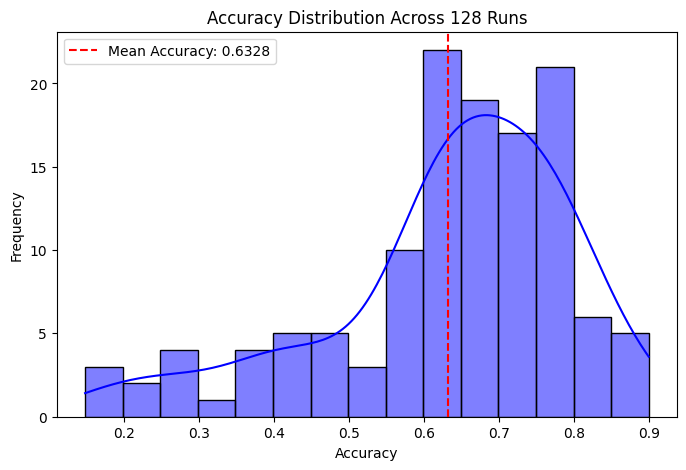

In [6]:

accuracy_array = np.array(accuracy_list)
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Compute Accuracy Stats
mean_accuracy = np.mean(accuracy_array)
std_accuracy = np.std(accuracy_array)
print(f"\nMean Accuracy: {mean_accuracy:.4f}")
print(f"Accuracy Standard Deviation: {std_accuracy:.4f}")

# Compute Mean Classification Report
avg_report = {}
for label in SLEEP_STAGES.values():
    avg_report[label] = {
        metric: np.mean([rep[label][metric] for rep in classification_reports]) 
        for metric in ['precision', 'recall', 'f1-score']
    }
print("\nAverage Classification Report:")
for label, metrics in avg_report.items():
    print(f"{label}: Precision={metrics['precision']:.4f}, Recall={metrics['recall']:.4f}, F1-Score={metrics['f1-score']:.4f}")

# # Compute Mean Confusion Matrix
# mean_cm = np.mean(confusion_matrices, axis=0)
# print(f"\nMean Confusion Matrix :\n{mean_cm}")


### --- PLOTTING RESULTS --- ###

# 1. Plot Accuracy Distribution
plt.figure(figsize=(8, 5))
sns.histplot(accuracy_array, kde=True, bins=15, color="blue")
plt.axvline(mean_accuracy, color='red', linestyle='dashed', label=f"Mean Accuracy: {mean_accuracy:.4f}")
plt.title("Accuracy Distribution Across 128 Runs")
plt.xlabel("Accuracy")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# # 2. Plot Mean Confusion Matrix
# plt.figure(figsize=(6, 5))
# sns.heatmap(mean_cm, annot=True, fmt=".2f", cmap="Blues", xticklabels=SLEEP_STAGES.values(), yticklabels=SLEEP_STAGES.values())
# plt.title("Mean Confusion Matrix Over 128 Runs")
# plt.xlabel("Predicted Labels")
# plt.ylabel("True Labels")
# plt.show()

